In [1]:
import pandas as pd
import numpy as np
import pickle
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import KeyedVectors
import keras

In [2]:
excel_path=r"C:\Users\derek\OneDrive\Documents\Main_data_cleaned_Elena.xlsx"
dataset=pd.read_excel(excel_path)
dataset.categories= dataset.categories.apply(eval)
dataset['description']=dataset['description'].astype(str)
dataset.shape[0]

44935

In [3]:
filepath=r"C:\Users\derek\Downloads\GoogleNews-vectors-negative300.bin.gz"


In [4]:
#Importing evaluation metrics


from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.1)
print(type(train), type(test), type(val))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [6]:
#Evaluating the number of labels per category in the test, train and validation dataset.


labels = {}

for category in test['categories']:
  if len(category) in labels:
    labels[len(category)] += 1
  else:
    labels[len(category)] = 1

labels

{2: 4385, 1: 3963, 3: 620, 4: 19}

In [7]:
labels = {}

for category in train['categories']:
  if len(category) in labels:
    labels[len(category)] += 1
  else:
    labels[len(category)] = 1

labels

{1: 14083, 2: 16026, 3: 2208, 4: 36}

In [8]:
labels = {}

for category in val['categories']:
  if len(category) in labels:
    labels[len(category)] += 1
  else:
    labels[len(category)] = 1

labels

{1: 1536, 2: 1821, 3: 233, 4: 5}

In [9]:

def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [10]:
mlb = MultiLabelBinarizer()
mlb.fit((dataset.categories))
mlb.classes_

array(['Accommodation', 'Accountants', 'Acoustic Materials', 'Actuaries',
       'Acupuncture Practitioners', 'Adhesives',
       'Advertising & Marketing Agencies & Services',
       'Advertising Displays', 'Agricultural Chemicals',
       'Agricultural Consultants', 'Agricultural Equipment & Supplies',
       'Air Charter', 'Air Conditioning Contractors',
       'Air Conditioning Equipment & Systems',
       'Air Conditioning Equipment & Systems-Repairing',
       'Aircraft Ground Support & Service', 'Airline Companies',
       'Airport Services', 'Airports', 'Alarms', 'Alternative Medicine',
       'Aluminium', 'Ambulance Services', 'Animal Feeds',
       'Animal Husbandry', 'Animation', 'Anti Corruption Organizations',
       'Antiques Dealers', 'Apartments', 'Appliances-Household',
       'Architects', 'Architectural Materials', 'Art & Craft Products',
       'Art Galleries & Dealers', 'Asset Management Solutions',
       'Associations', 'Auctioneers', 'Audio-Visual Equipment & Se

In [11]:
transformed_labels = mlb.fit_transform(dataset['categories'])
transformed_labels.shape
transformed_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
train_labels = mlb.transform(train['categories'])
train_labels.shape

(32353, 630)

In [13]:
test_labels = mlb.transform(test['categories'])
test_labels.shape

(8987, 630)

In [14]:
val_labels = mlb.transform(val['categories'])
val_labels.shape

(3595, 630)

### The Keras implmentation of the model

In [15]:

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Embedding, LSTM, Dropout, Dense, Input, Bidirectional, Flatten, Conv2D, MaxPooling2D, concatenate, Conv1D, MaxPooling1D
import keras.backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

### Fitting the Keras Tokenizer on the entire dataset

In [16]:
#Company Description
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = dataset['description'].map(len).max()
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(dataset['description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Max len:', MAX_SEQUENCE_LENGTH)

Found 47036 unique tokens.
Max len: 482


- This function loads the word2vec model and intializes the embedding matrix. Each word which is present in the embedding is then added as a vector to the embedding matrix.

In [17]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')
#model = Word2Vec(model)

#OR
# !pip install wget

# import wget
# url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
# filename = wget.download(url)

# f_in = gzip.open('GoogleNews-vectors-negative300.bin.gz', 'rb')
# f_out = open('GoogleNews-vectors-negative300.bin', 'wb')
# f_out.writelines(f_in)

In [18]:
from gensim.models.word2vec import Word2Vec
def get_embedding_matrix(typeToLoad):
  if typeToLoad == "glove":
    EMBEDDING_FILE="/content/glove.twitter.27B.100d.txt"
    embed_size = 100
  elif typeToLoad == "word2vec":
    word2vecDict = KeyedVectors.load_word2vec_format(filepath  , binary=True)
    embed_size = 300
  elif typeToLoad == "fasttext":
    EMBEDDING_FILE="/content/wiki-news-300d-1M.vec"
    embed_size = 300

  if typeToLoad == "glove" or typeToLoad == "fasttext":
    embeddings_index = dict()
    f = open(EMBEDDING_FILE)
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    f.close()
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
  else:
    embeddings_index = dict()
    for word in word2vecDict.key_to_index:
      embeddings_index[word] = word2vecDict.word_vec(word)
    print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
  embedding_matrix = 1 * np.random.randn(len(word_index)+1, embed_size)

  embeddedCount = 0
  for word, i in word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      embeddedCount+=1
  print("total embedded:", embeddedCount, "common words")
        
  del(embeddings_index)
        
  return embedding_matrix

In [19]:
word2vec_embedding_matrix = get_embedding_matrix("word2vec")

C:\Users\derek\AppData\Local\Temp\ipykernel_14388\1785336496.py:26: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  embeddings_index[word] = word2vecDict.word_vec(word)


Loaded 3000000 word vectors.
total embedded: 18004 common words


In [20]:
X_text_train = tokenizer.texts_to_sequences(train['description'].values)
X_text_train = pad_sequences(X_text_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_train.shape)
     

Shape of train tensor: (32353, 482)


In [21]:
X_text_test = tokenizer.texts_to_sequences(test['description'].values)
X_text_test = pad_sequences(X_text_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_test.shape)
     

Shape of train tensor: (8987, 482)


In [22]:
X_text_val = tokenizer.texts_to_sequences(val['description'].values)
X_text_val = pad_sequences(X_text_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', X_text_val.shape)

Shape of train tensor: (3595, 482)


### The model architecture

- The model architecture consists of an LSTM. The LSTM takes the input as a padded sequence of the description of a company. 
- The output layer has a sigmoid activation function.

- Binary crossentropy was the chosen loss function and the Adam optimizer was used.

In [23]:
def compile_model(embedding_matrix):
  lstm_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], mask_zero=True, input_length=MAX_SEQUENCE_LENGTH, trainable=False)(lstm_input)
  x = Dropout(0.3)(x)
  x = LSTM(64, return_sequences = True)(x)
  x = Dropout(0.3)(x)
  x = LSTM(64)(x)
  x = Dropout(0.3)(x)
  lstm_out = Dense(18, activation = 'relu')(x)

  concat_inp = lstm_out
  z = Dense(256, activation='relu')(concat_inp)
  z = Dropout(0.3)(z)
  z = Dense(128, activation='relu')(z)
  z = Dropout(0.3)(z)
  output = Dense(train_labels.shape[1], activation='sigmoid')(z)

  model = Model(inputs=[lstm_input], outputs=[output])
  adam = Adam(lr=0.001, decay=1e-5)
  
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model

In [24]:
word2vec_model = compile_model(word2vec_embedding_matrix)
word2vec_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 482)]             0         
                                                                 
 embedding (Embedding)       (None, 482, 300)          14111100  
                                                                 
 dropout (Dropout)           (None, 482, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 482, 64)           93440     
                                                                 
 dropout_1 (Dropout)         (None, 482, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Some default Keras callbacks were used to prevent overfitting and saving the model's data and training history.

In [25]:
import os
es = EarlyStopping(patience=5)
csv_logger = CSVLogger('model_history_log_model_lstm.csv', append=True)

check_point = ModelCheckpoint(filepath =r"C:\Users\derek\OneDrive\Documents\Model.check_history",
                              save_best_only=True, save_weights_only=True)
     

word2vec_multi_modal_model = word2vec_model.fit([X_text_train], train_labels, batch_size=256, epochs=1,
                            validation_data=([X_text_val], val_labels), callbacks = [es, csv_logger, check_point])
     

127/127 [==============================] - 4451s 35s/step - loss: 0.1251 - accuracy: 0.0232 - val_loss: 0.0151 - val_accuracy: 0.0620


In [26]:

def plot_loss(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend(['training loss', 'validation loss'], loc='upper right')
  plt.show()

def plot_acc(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
  plt.show()
     

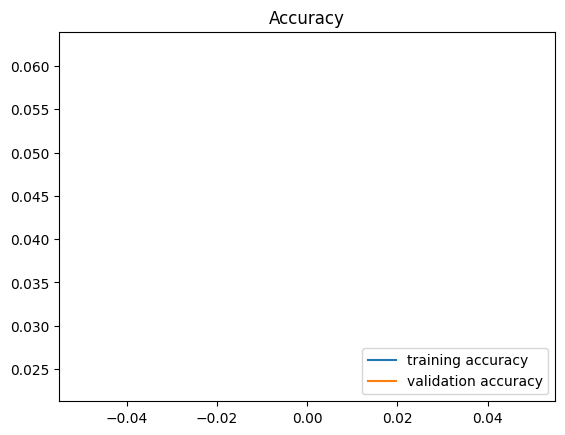

In [27]:
plot_acc(word2vec_multi_modal_model)

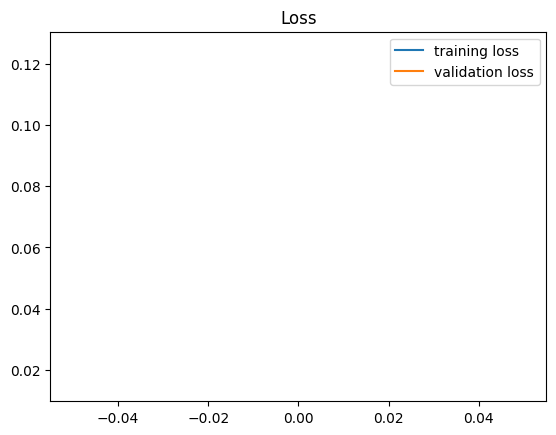

In [28]:
plot_loss(word2vec_multi_modal_model)
     

##### Model evaluation on the test set


In [29]:
loss, acc = word2vec_model.evaluate([X_text_test], test_labels, batch_size=256)
print("word2vec model:", loss, acc)

36/36 [==============================] - 31s 852ms/step - loss: 0.0152 - accuracy: 0.0649
word2vec model: 0.015211827121675014 0.06487148255109787


In [30]:

from sklearn.preprocessing import MultiLabelBinarizer
out = word2vec_model.predict([ X_text_test], batch_size=256)
     



36/36 [==============================] - 33s 871ms/step


The primary metric for evaluation was not accuracy due to an imbalance of classes and due to a multi-label output. The ROC AUC score was primarily used to evaluate the model's performance along with the F1 score and Hamming loss.

In [31]:

# roc_auc = roc_auc_score(test_labels, out)
# print(roc_auc)

In [32]:
#Arbitrary threshold of 0.5 to convert the output probabilities for initial evaluation. Evaluation metric are then applied to this one-hot encoded matrix.
y_pred = np.zeros(out.shape)
y_pred[out>0.3]=1
y_pred = np.array(y_pred)

In [33]:
hl = hamming_loss(test_labels,y_pred)
score = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels,y_pred, average = 'samples')
recall = recall_score(test_labels,y_pred, average = 'samples')
f1 = f1_score(test_labels,y_pred, average = 'samples')
print("Hamming loss:", hl)
print("score:", score)
print("Precision:", precision)
print("Recall:", recall)
print("F1_score:", f1)

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hamming loss: 0.0026966641409725866
score: 0.0
Precision: 0.00012934591302174887
Recall: 0.0006490857164051778
F1_score: 0.00017738871538402587


In [34]:
##Using Matthew's correlation coefficient to evaluate the best threshold for each of the  classes in the labels.


from sklearn.metrics import matthews_corrcoef
y_test = test_labels
y_pred = np.zeros(out.shape)
y_pred = np.array(y_pred) 
threshold = np.arange(0.01, 0.90, 0.20)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
  y_prob = np.array(out[:,i])
  for j in threshold:
    y_pred = [1 if prob>=j else 0 for prob in y_prob]
    y_pred = np.array(y_pred)
    mcc = matthews_corrcoef(y_test[:,i],y_pred)
    acc.append(mcc)
  acc   = np.array(acc)
  index = np.where(acc==acc.max())
  accuracies.append(acc.max())
  best_threshold[i] = threshold[index[0][0]]
  acc = []

y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))]) 

In [35]:
preds = np.transpose(y_pred)
labels = np.transpose(test_labels)

Evaluation of the model's performance for each indivual class. Evaluation metrics are applied to each class label and then the average of these metrics is taken to evaluate the entire model's performance.

Accommodation
accuracy: 0.030377211527762325 precision: 0.030377211527762325 recall: 1.0 f1: 0.05896328293736502


<Figure size 640x480 with 0 Axes>

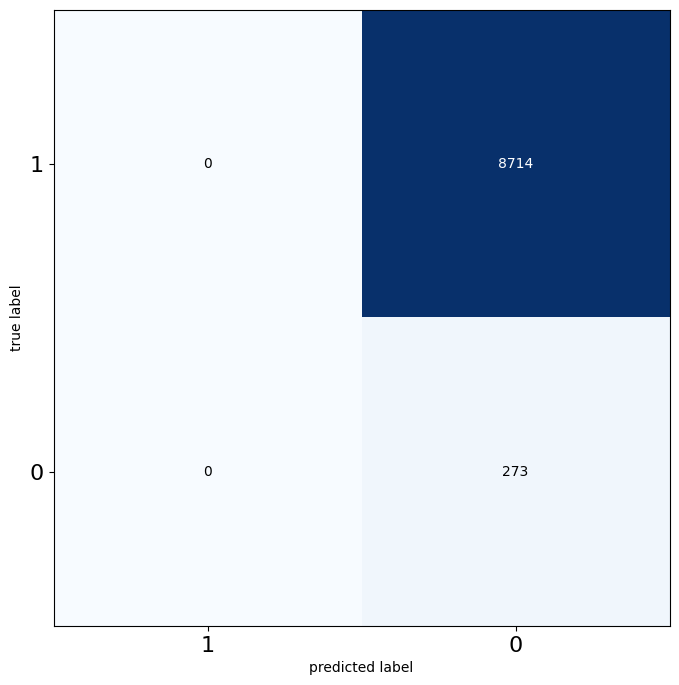

Accountants
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

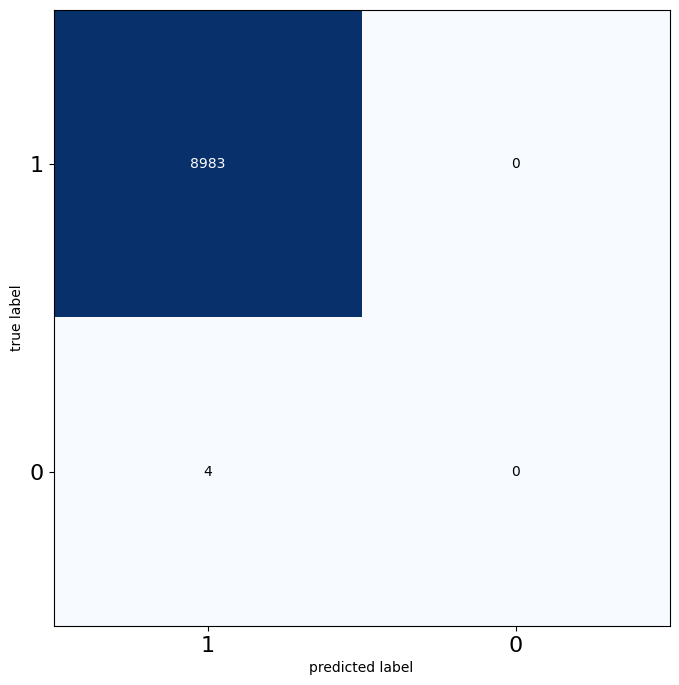

Acoustic Materials
accuracy: 0.9934349616112162 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

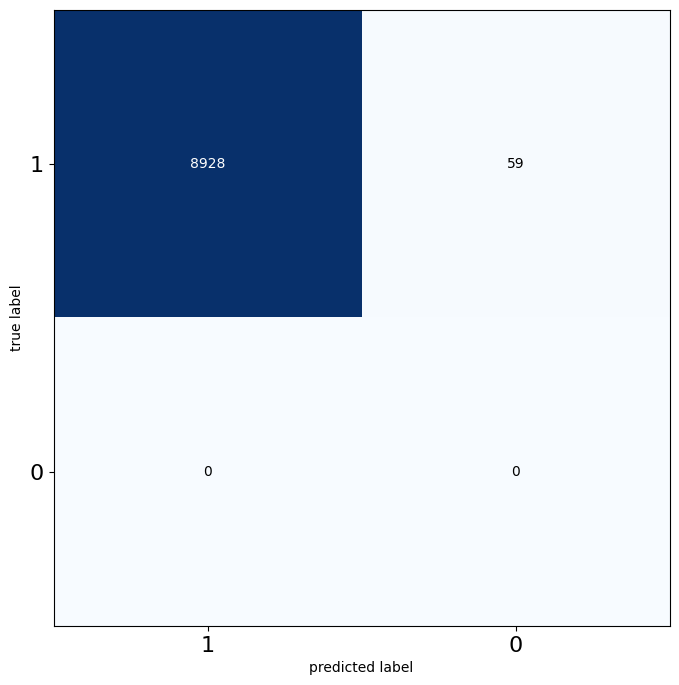

Actuaries
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

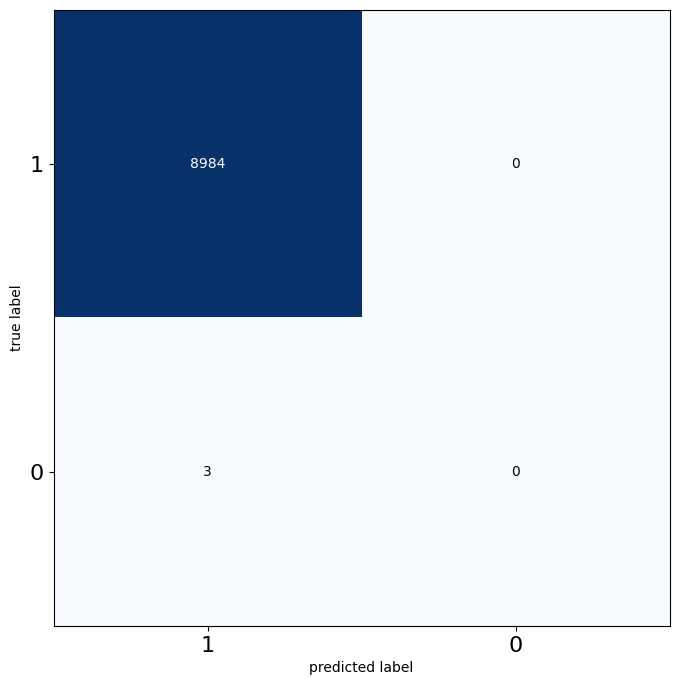

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acupuncture Practitioners
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

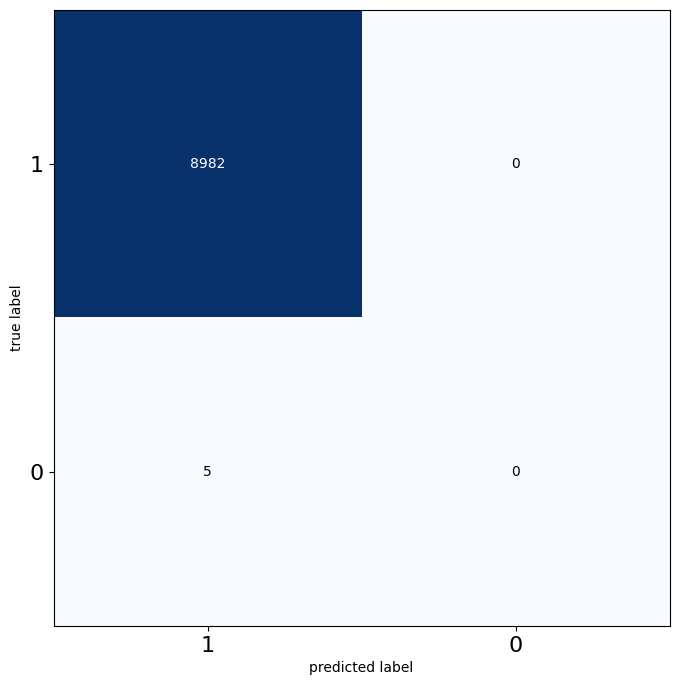

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Adhesives
accuracy: 0.9951040391676866 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

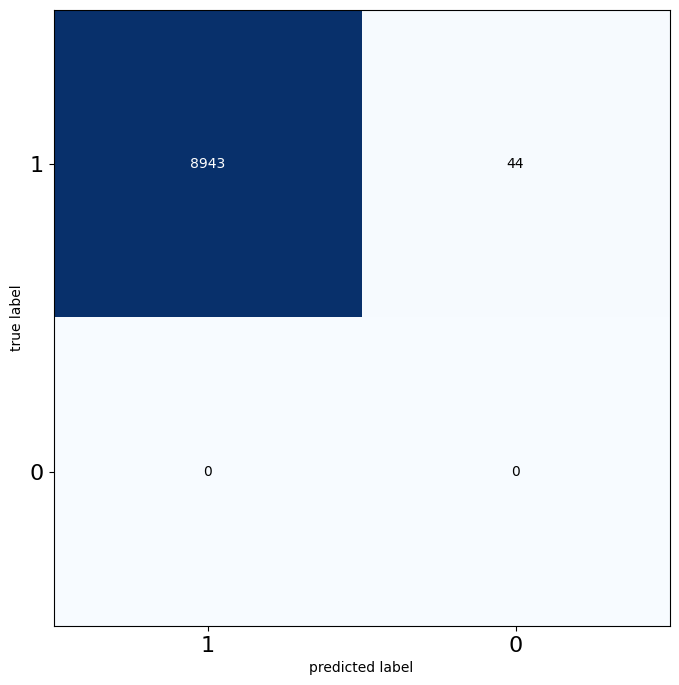

Advertising & Marketing Agencies & Services
accuracy: 0.9849783019917658 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

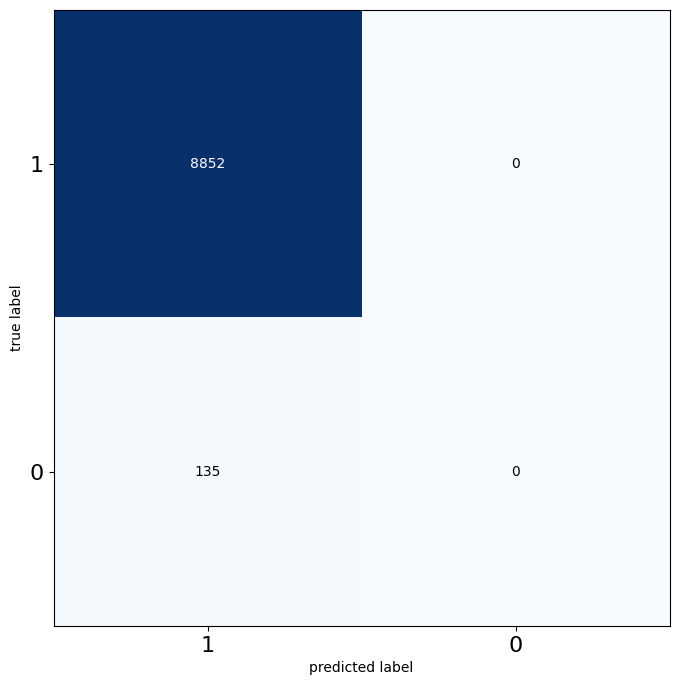

Advertising Displays
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

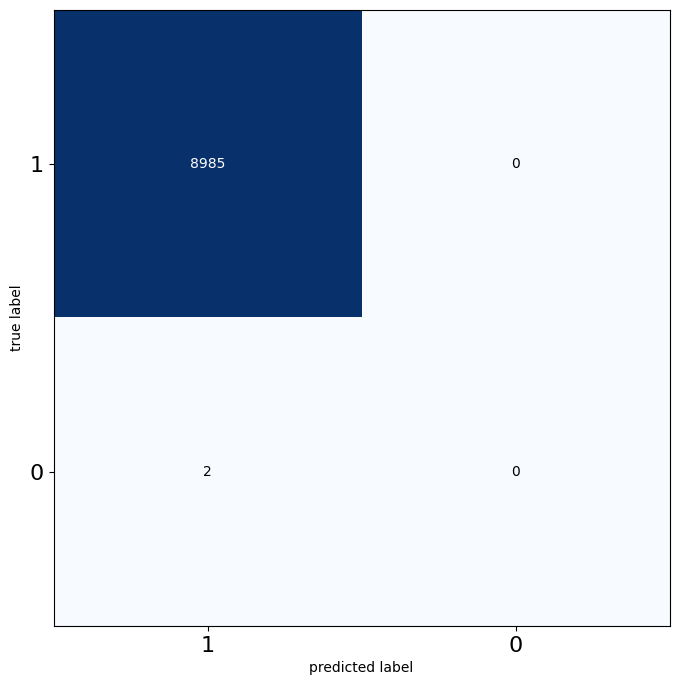

Agricultural Chemicals
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

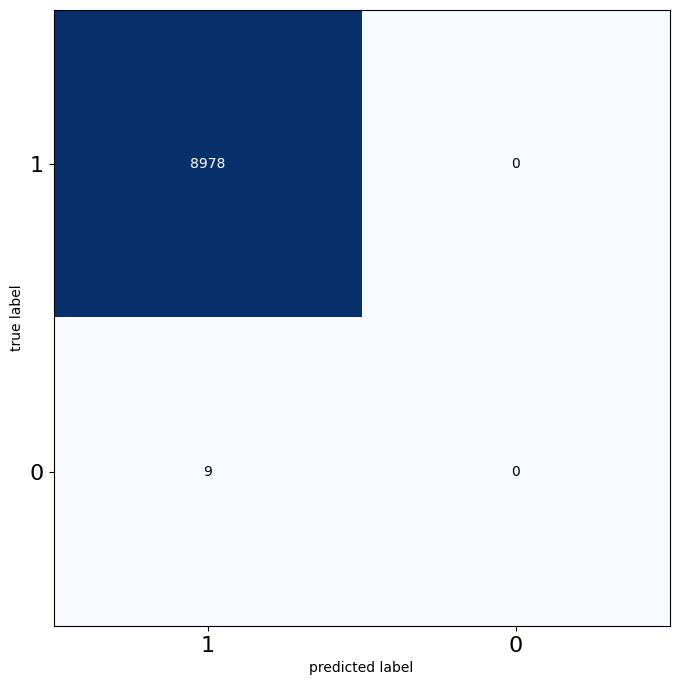

Agricultural Consultants
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

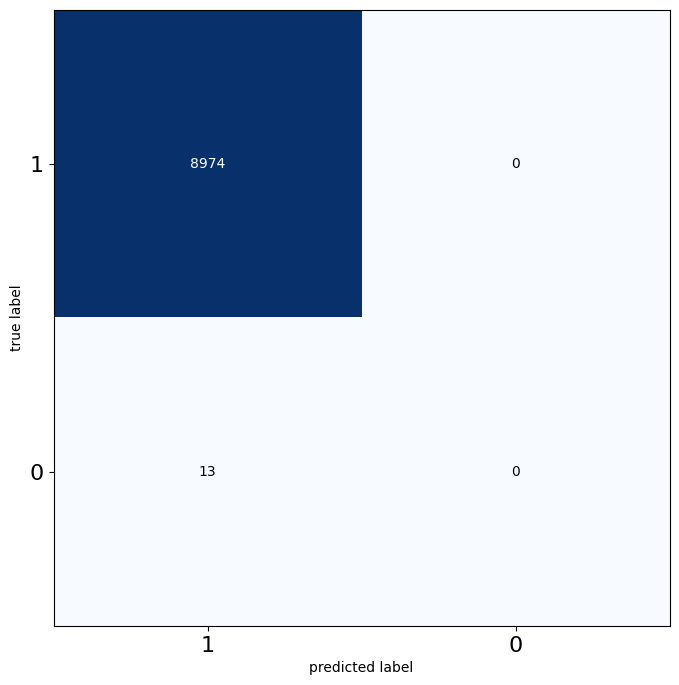

Agricultural Equipment & Supplies
accuracy: 0.025703794369645042 precision: 0.025703794369645042 recall: 1.0 f1: 0.050119331742243436


<Figure size 640x480 with 0 Axes>

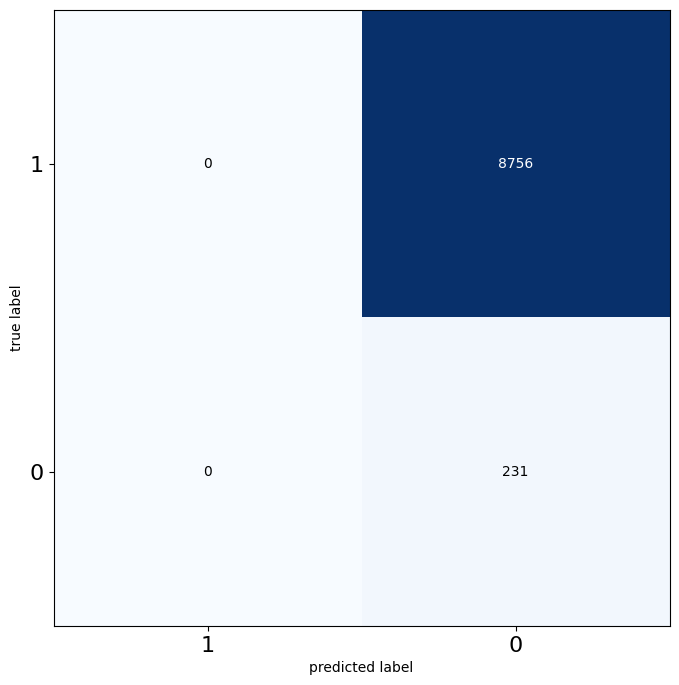

Air Charter
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

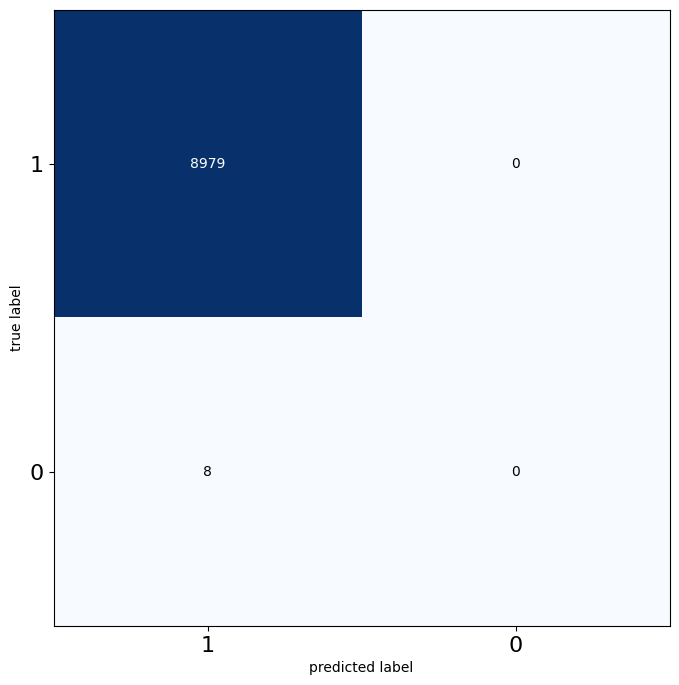

Air Conditioning Contractors
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

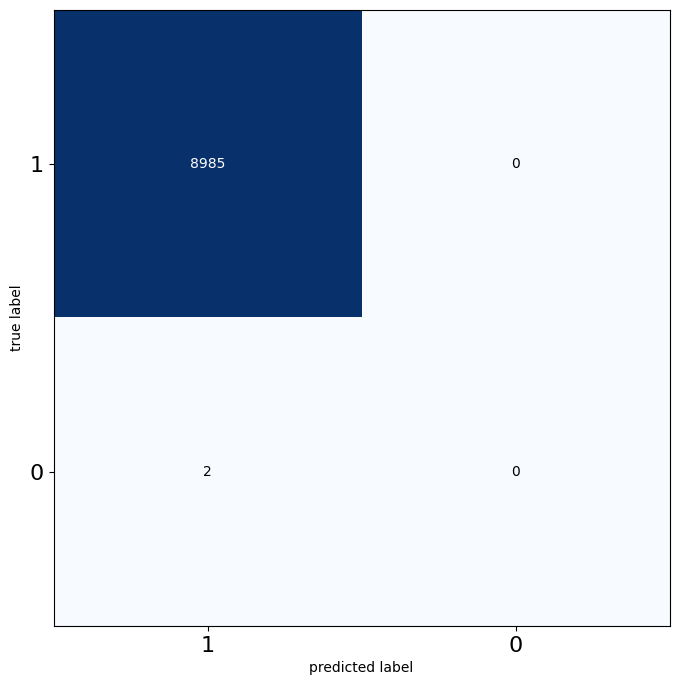

Air Conditioning Equipment & Systems
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

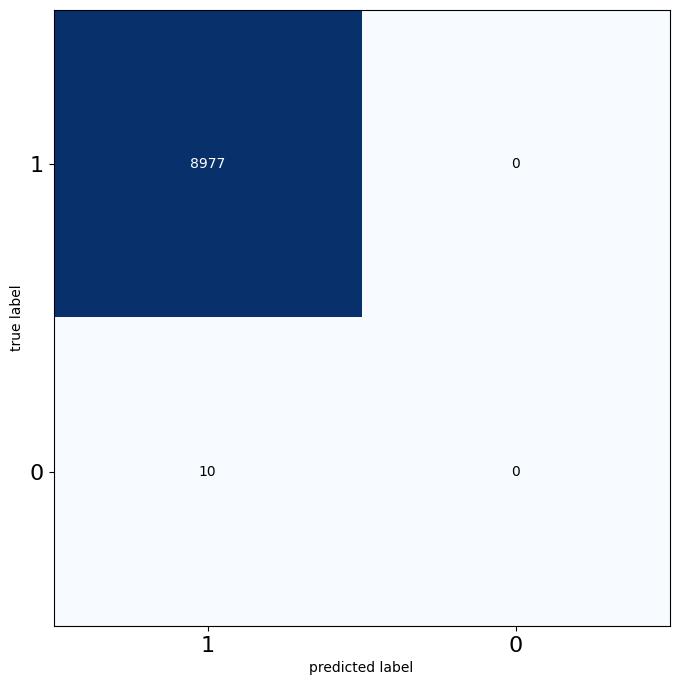

Air Conditioning Equipment & Systems-Repairing
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

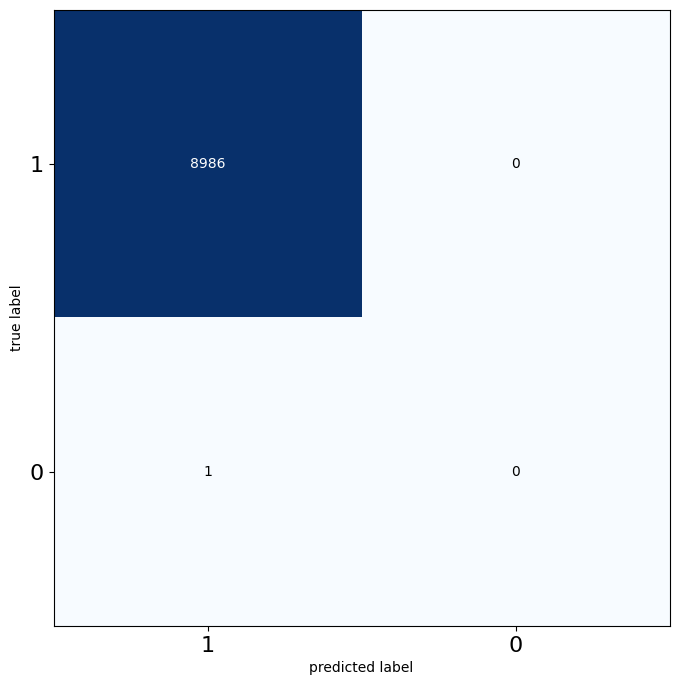

Aircraft Ground Support & Service
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

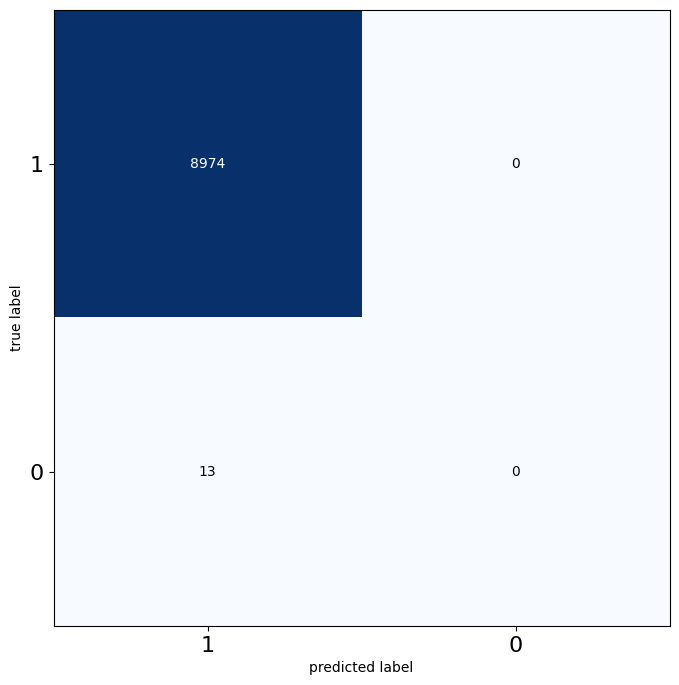

Airline Companies
accuracy: 0.9974407477467453 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

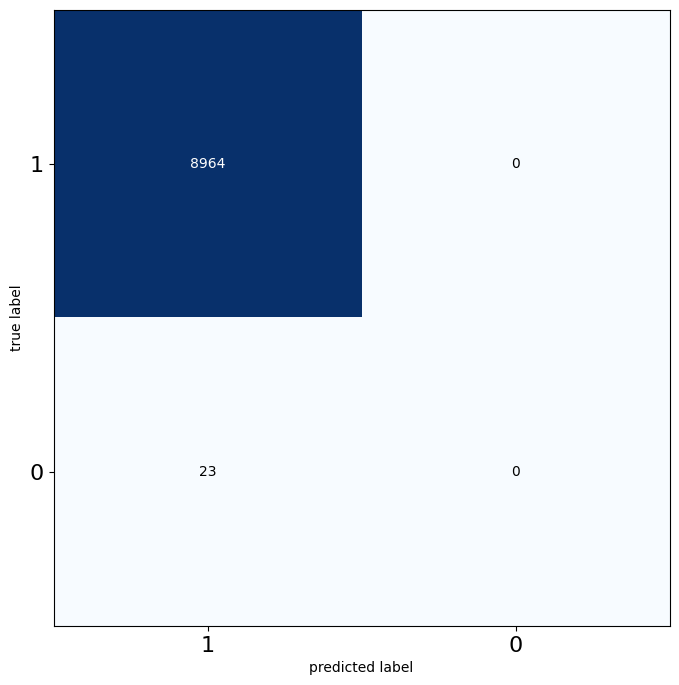

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Airport Services
accuracy: 0.9984421942806275 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

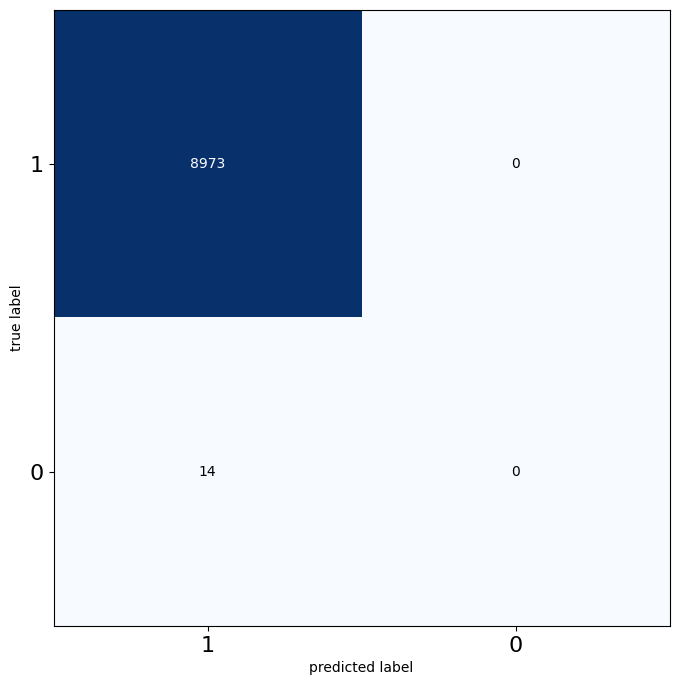

Airports
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

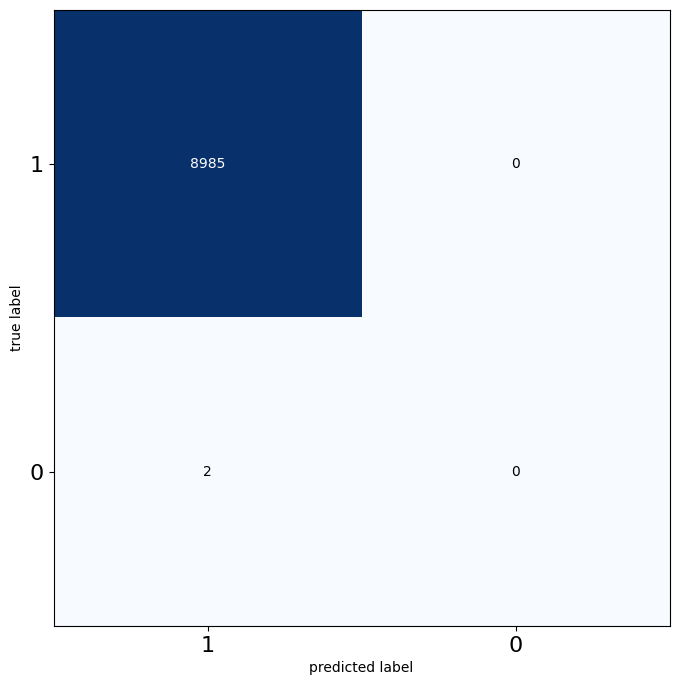

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Alarms
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

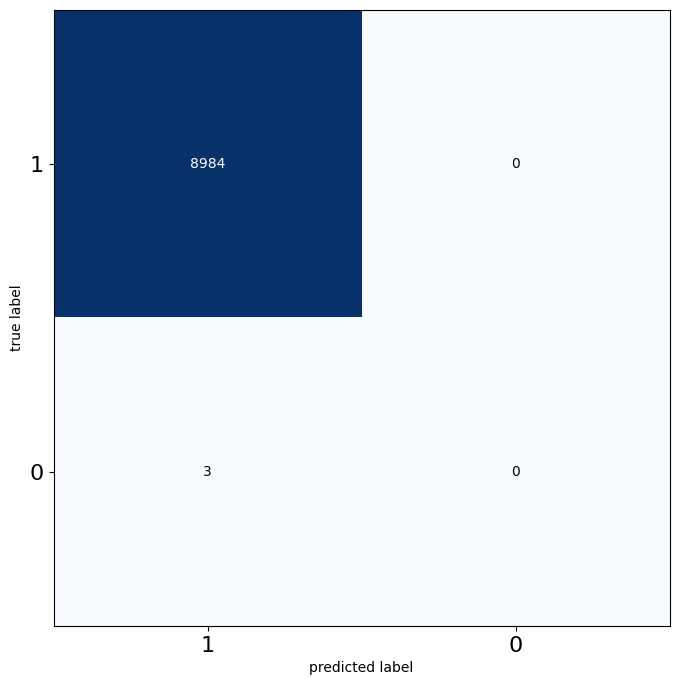

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Alternative Medicine
accuracy: 0.996105485701569 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

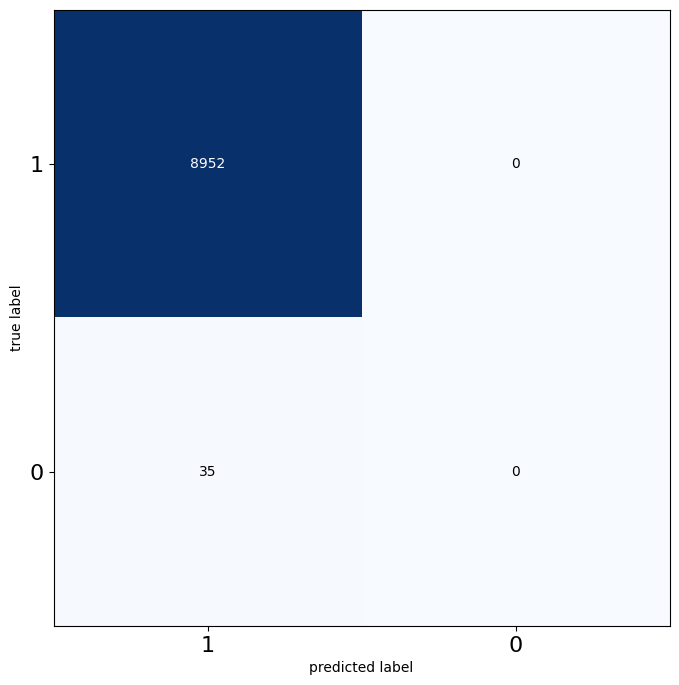

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Aluminium
accuracy: 0.9977745632580394 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

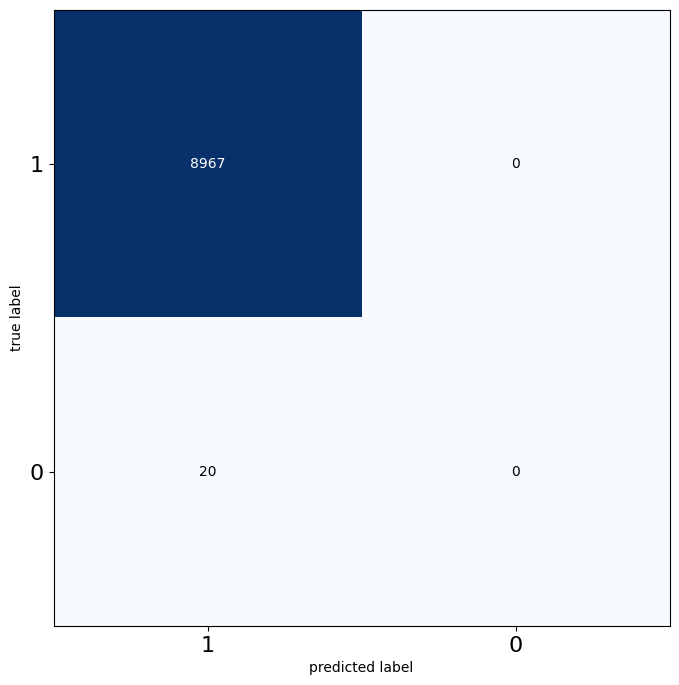

Ambulance Services
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

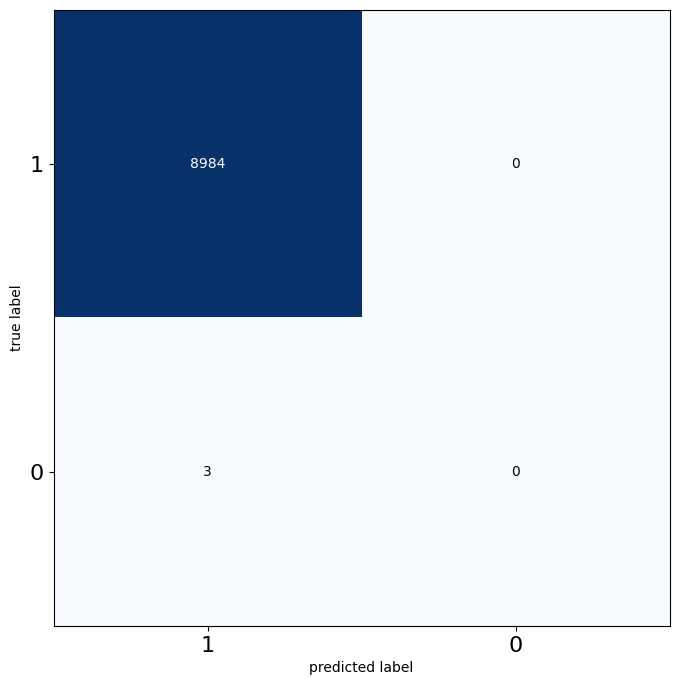

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Animal Feeds
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

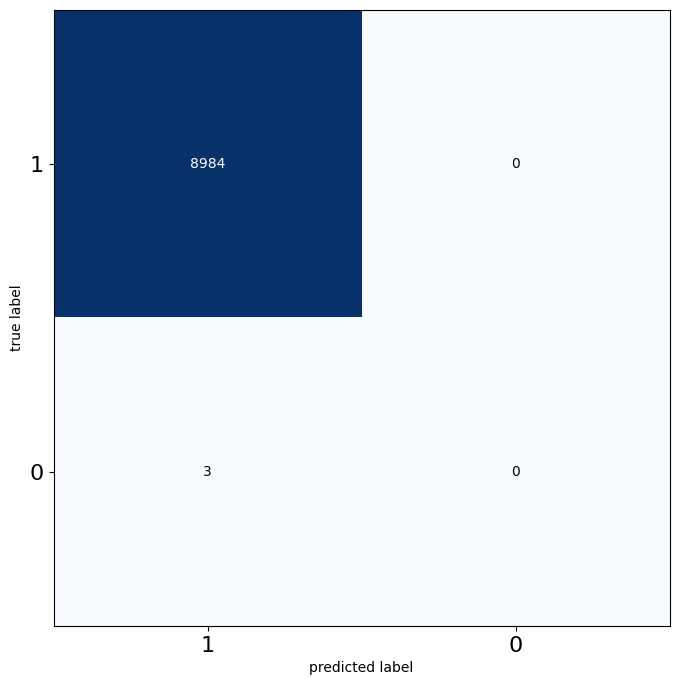

Animal Husbandry
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

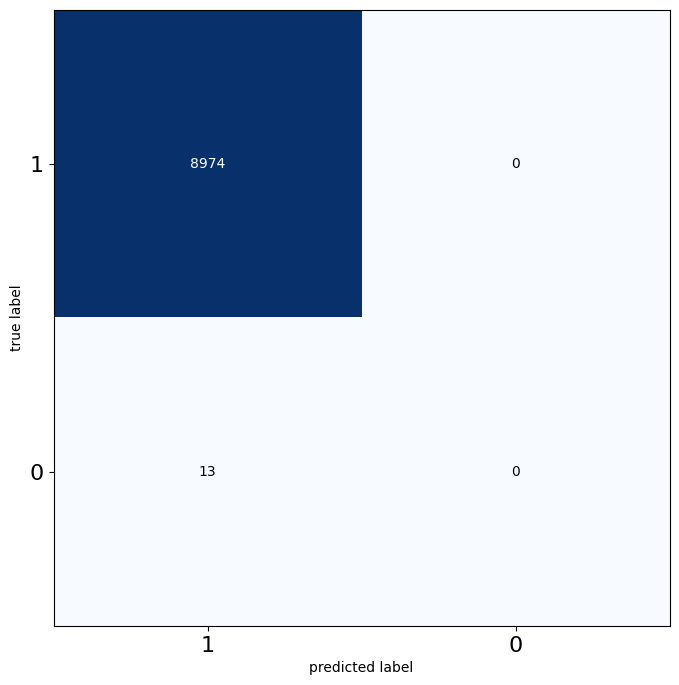

Animation
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

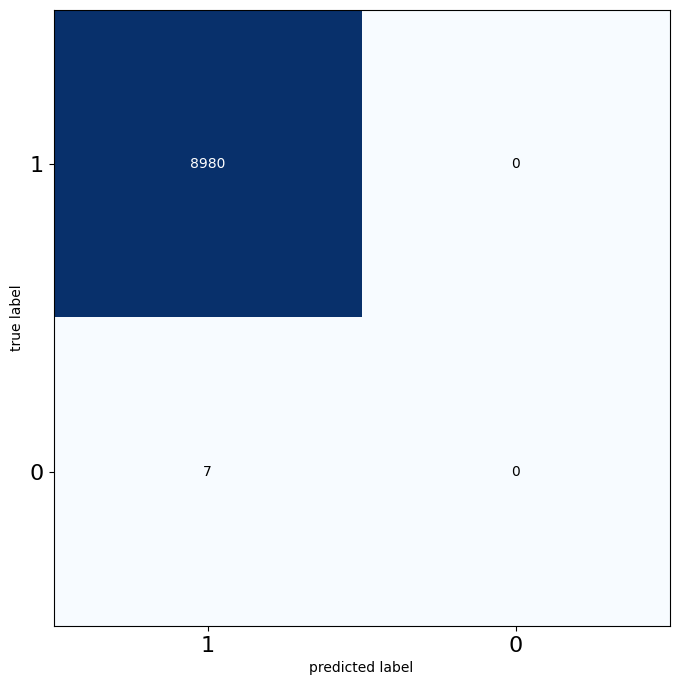

Anti Corruption Organizations
accuracy: 0.9920996995660398 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

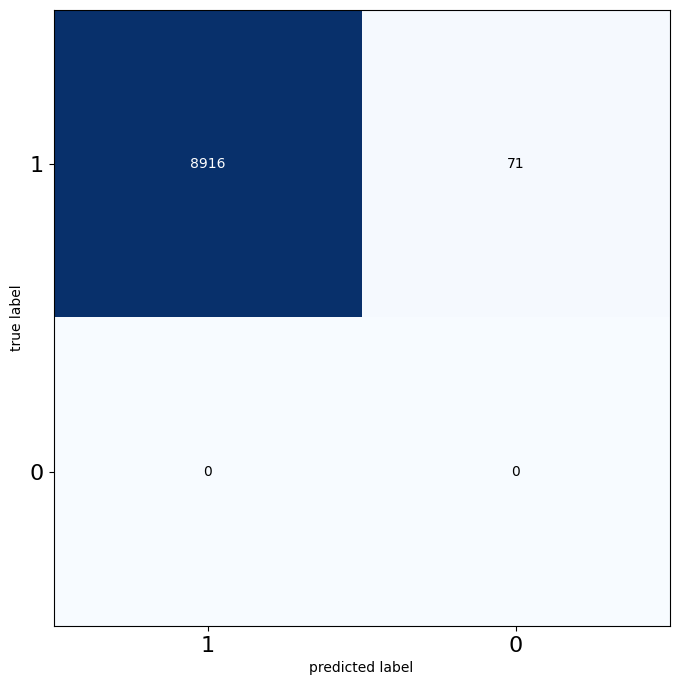

Antiques Dealers
accuracy: 0.9944364081450985 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

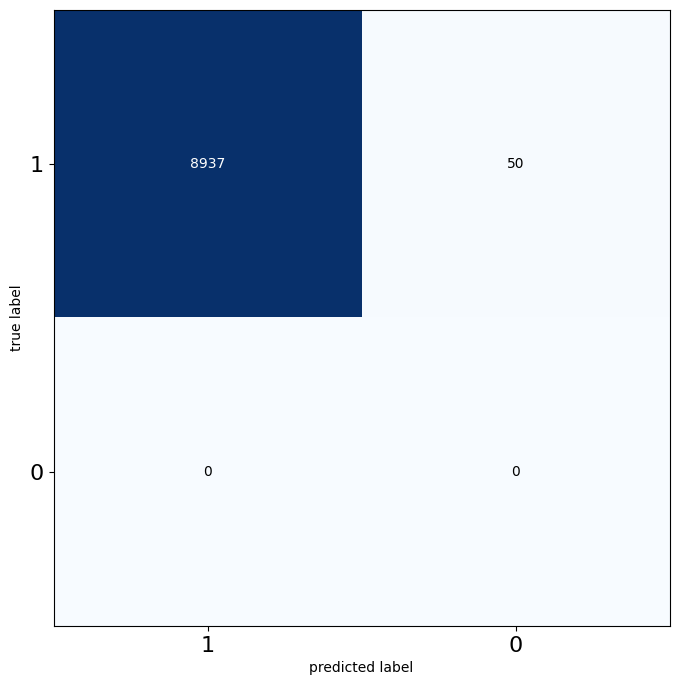

Apartments
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

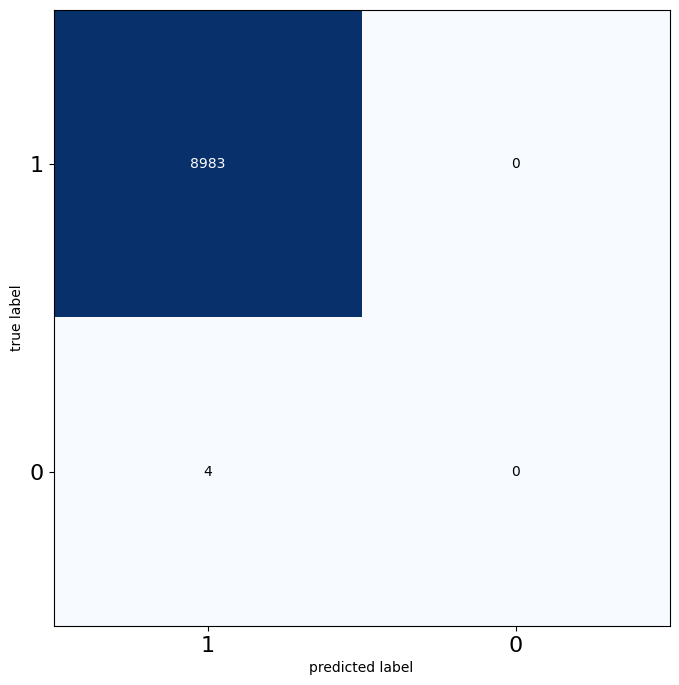

Appliances-Household
accuracy: 0.9949927673305886 precision: 0.021739130434782608 recall: 1.0 f1: 0.042553191489361694


<Figure size 640x480 with 0 Axes>

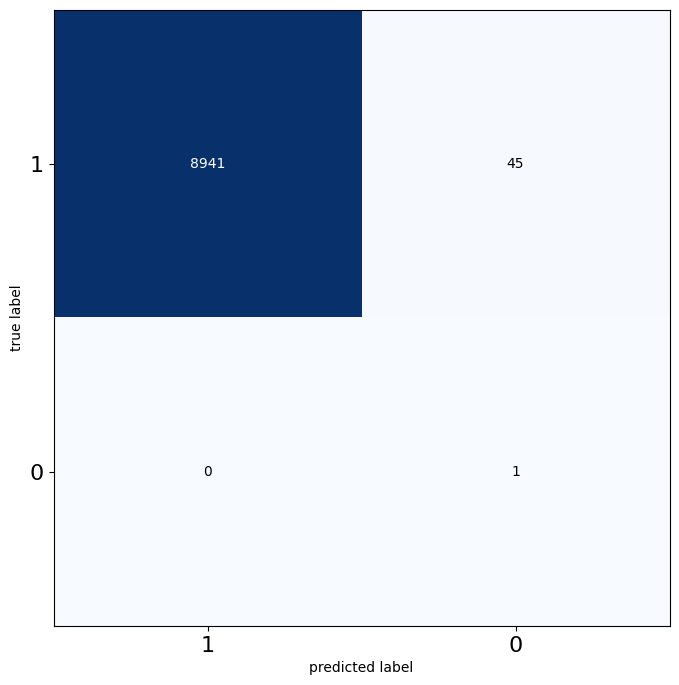

Architects
accuracy: 0.996216757538667 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

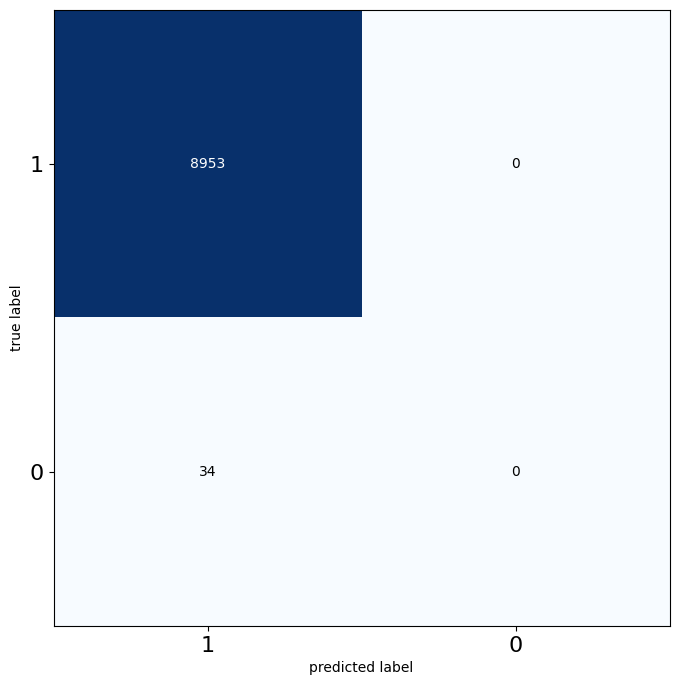

Architectural Materials
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

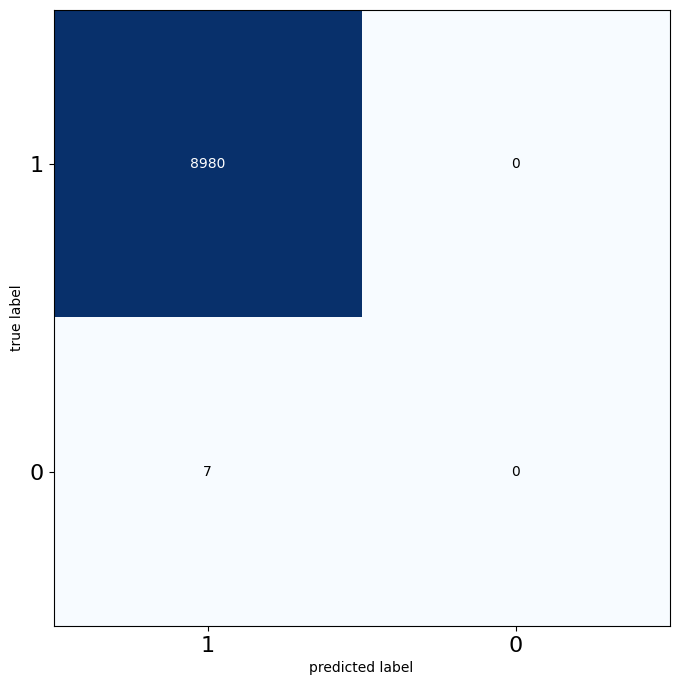

Art & Craft Products
accuracy: 0.02447980416156671 precision: 0.02447980416156671 recall: 1.0 f1: 0.04778972520908004


<Figure size 640x480 with 0 Axes>

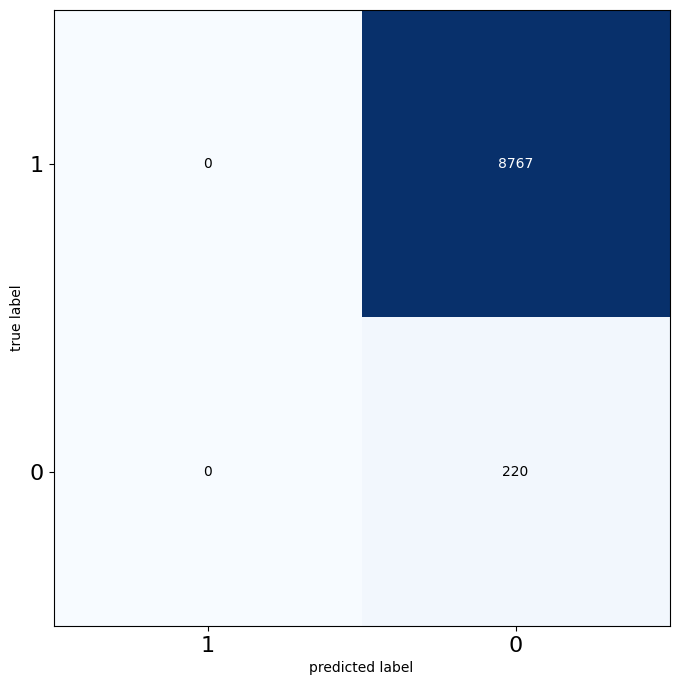

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Art Galleries & Dealers
accuracy: 0.9981083787693334 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

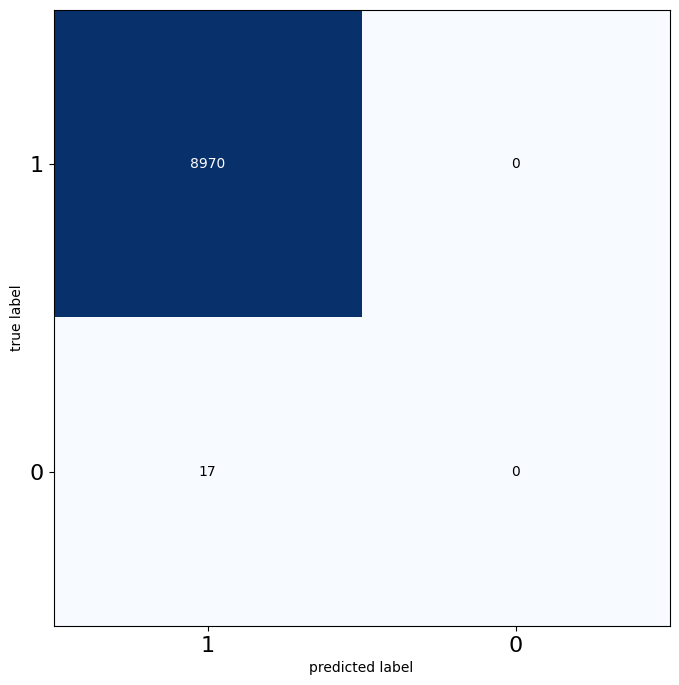

Asset Management Solutions
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

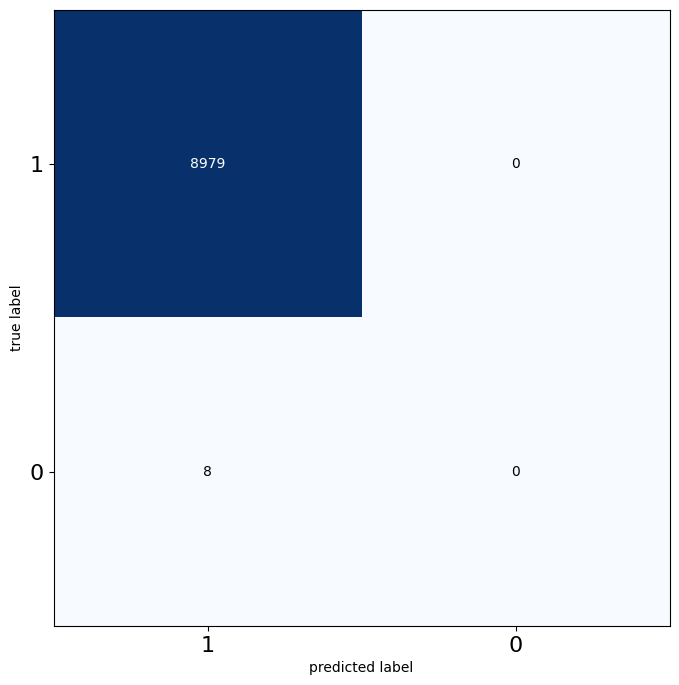

Associations
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

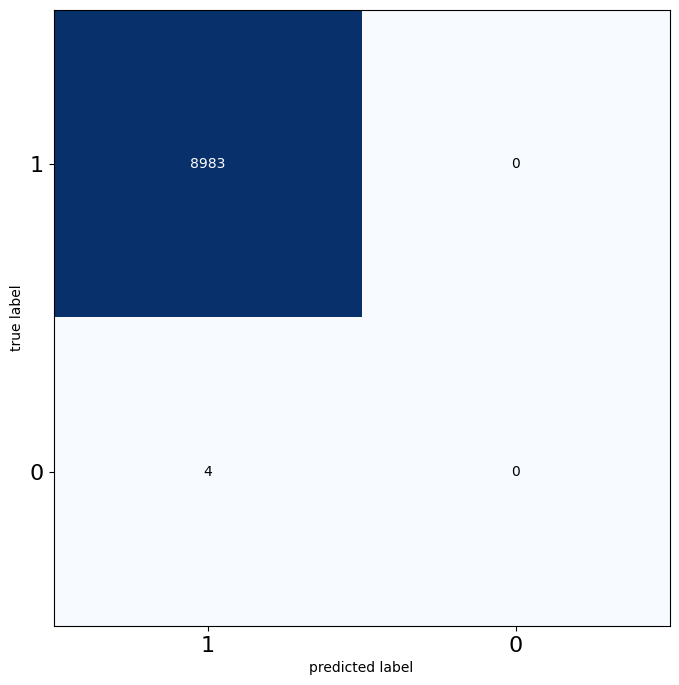

Auctioneers
accuracy: 0.9905418938466674 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

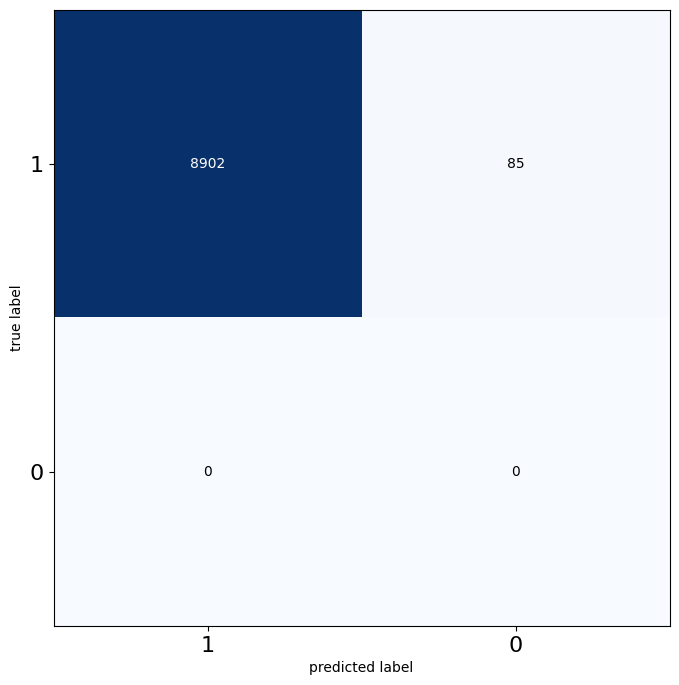

Audio-Visual Equipment & Services
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

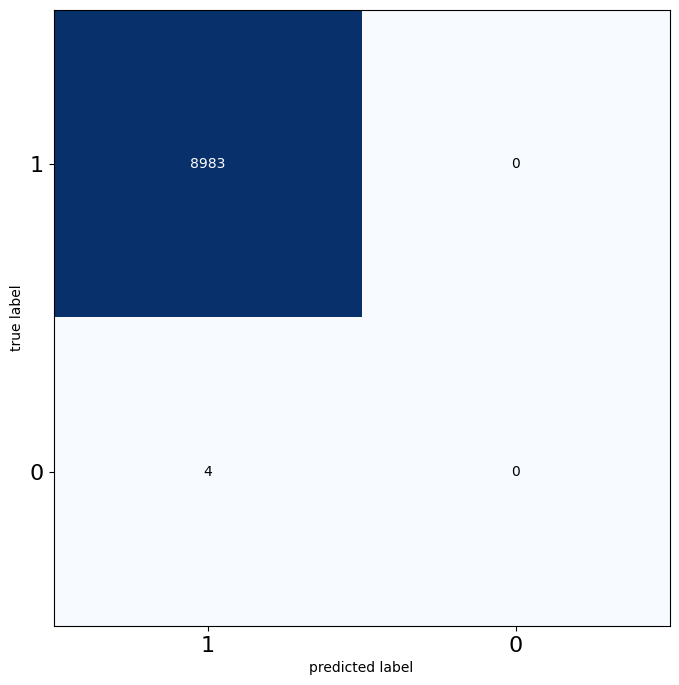

Auditors
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

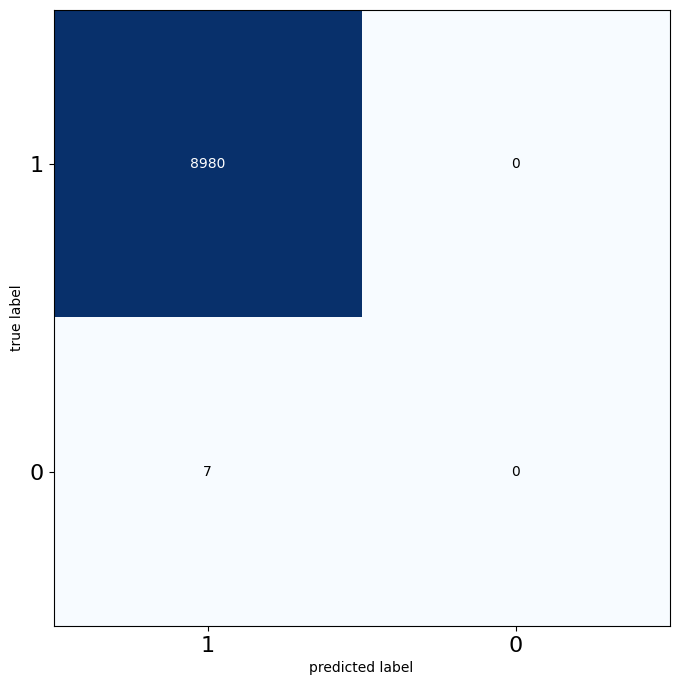

Auto Accessories
accuracy: 0.03527317236007566 precision: 0.03527317236007566 recall: 1.0 f1: 0.06814273430782458


<Figure size 640x480 with 0 Axes>

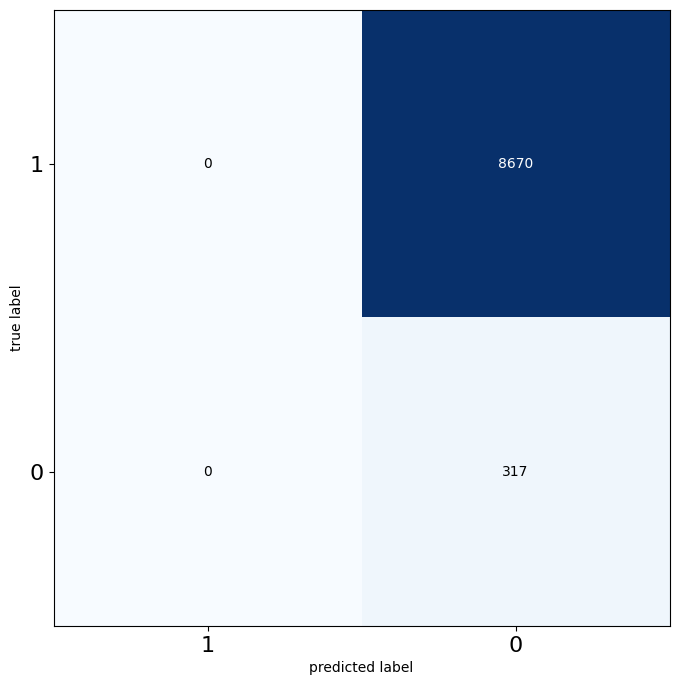

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Auto Springs
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

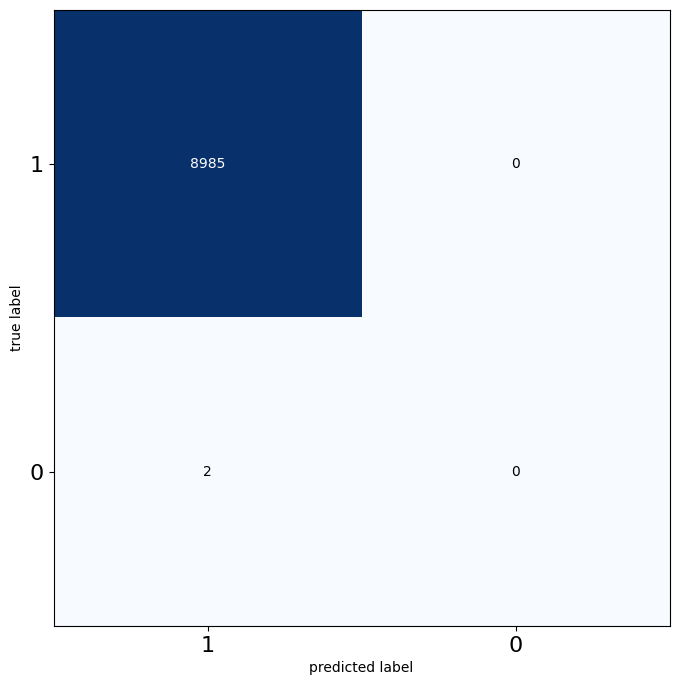

Automation Systems & Equipment
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

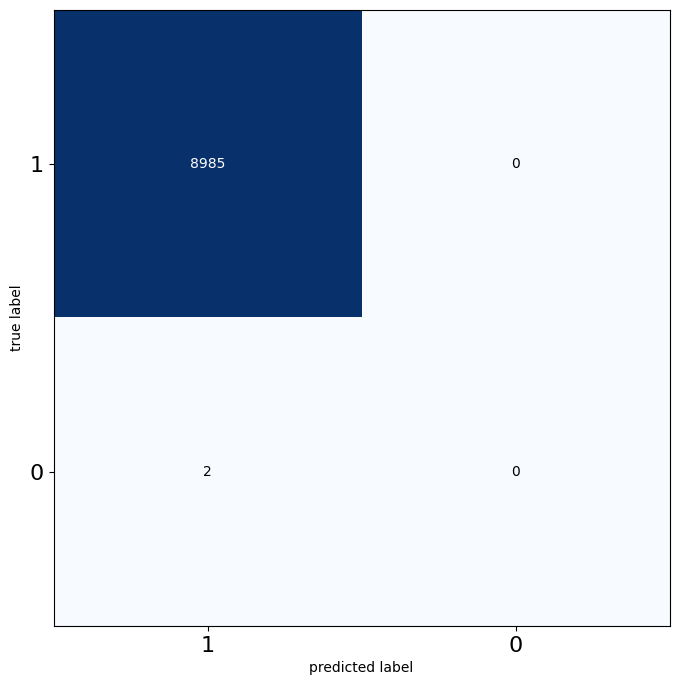

Baby Accessories
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

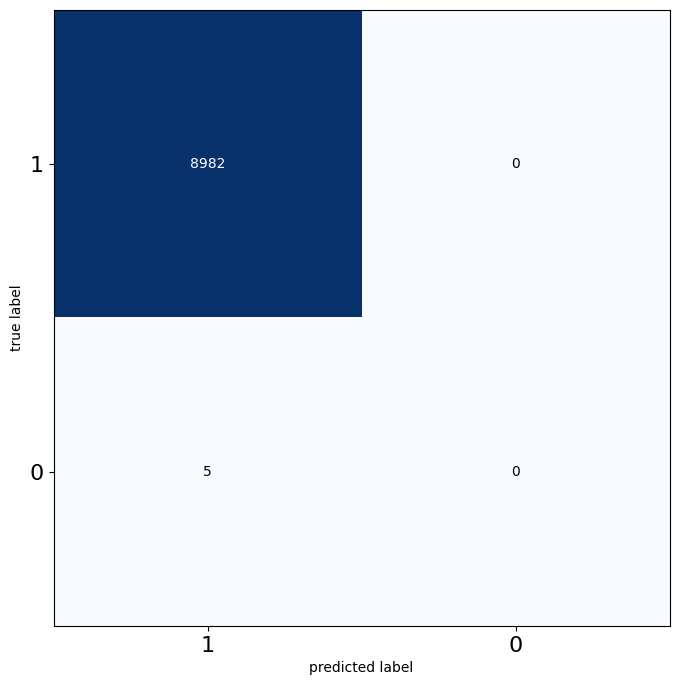

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Badges
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

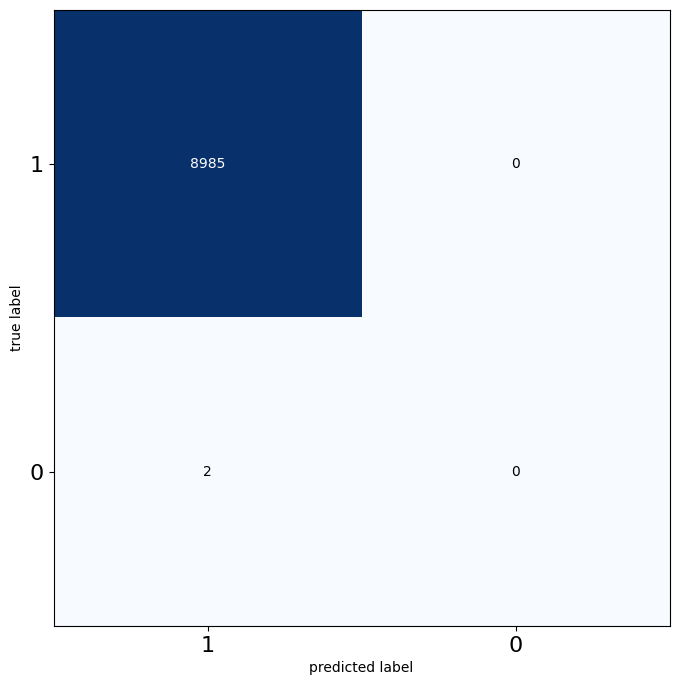

Bakers & Pastry Shops
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

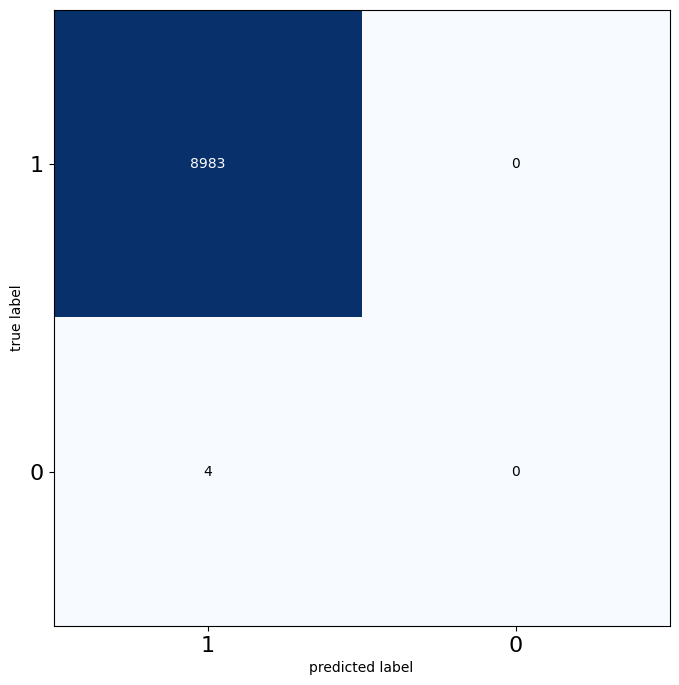

Bakery Equipment & Supplies
accuracy: 0.978079448091688 precision: 0.007575757575757576 recall: 0.014925373134328358 f1: 0.010050251256281407


<Figure size 640x480 with 0 Axes>

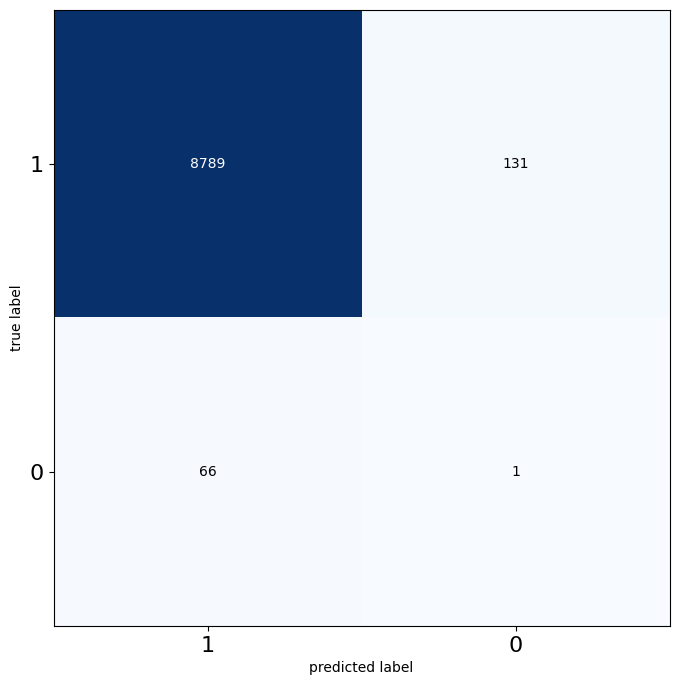

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balloons
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

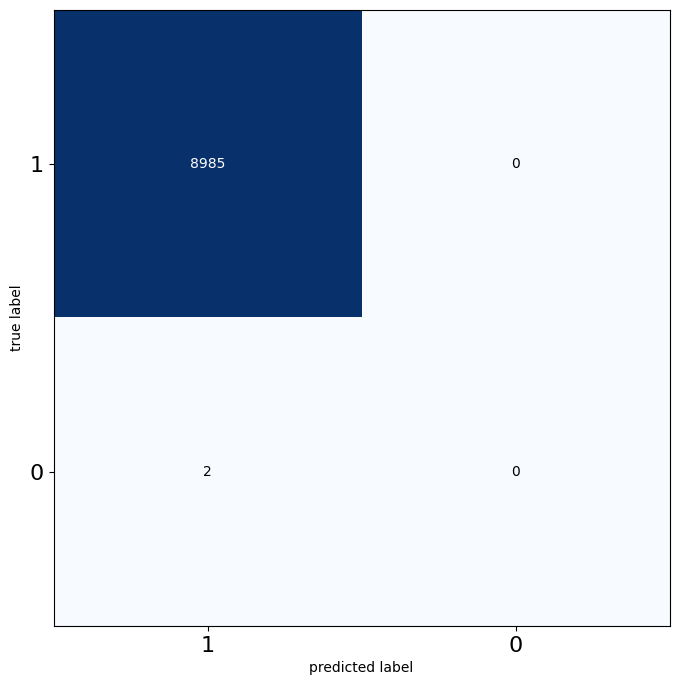

Bank Equipment
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

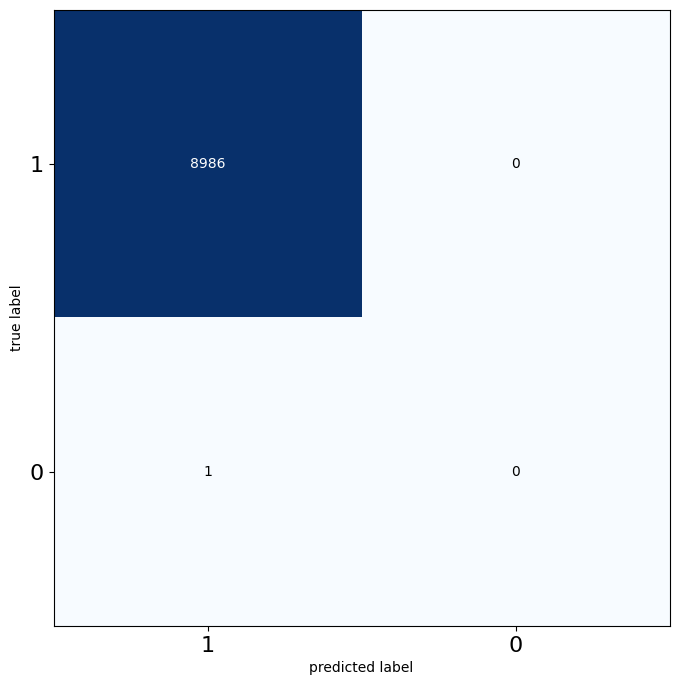

Banks
accuracy: 0.9687326137754534 precision: 0.08 recall: 0.007692307692307693 f1: 0.014035087719298246


<Figure size 640x480 with 0 Axes>

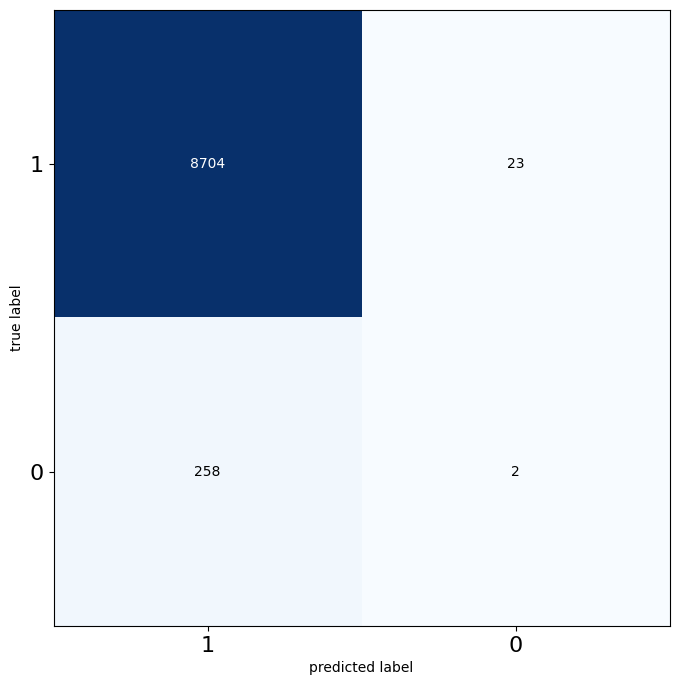

Bar Codes
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

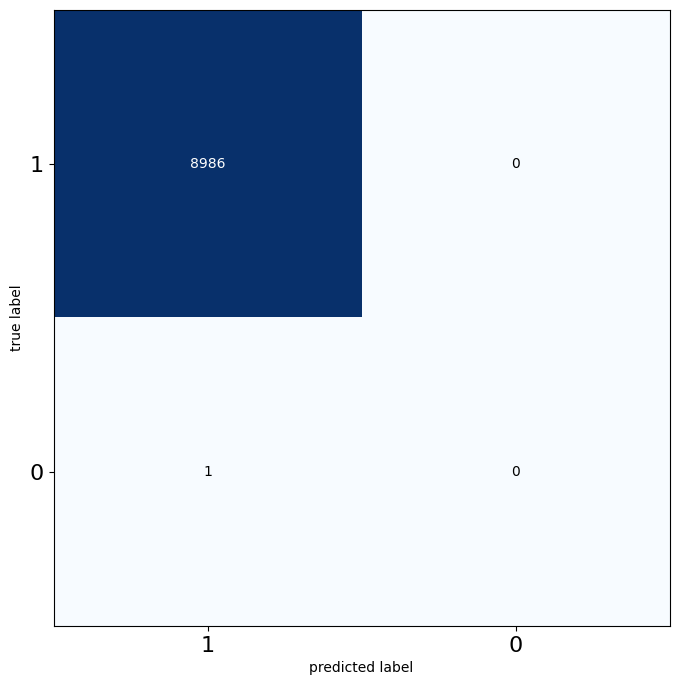

Bars
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

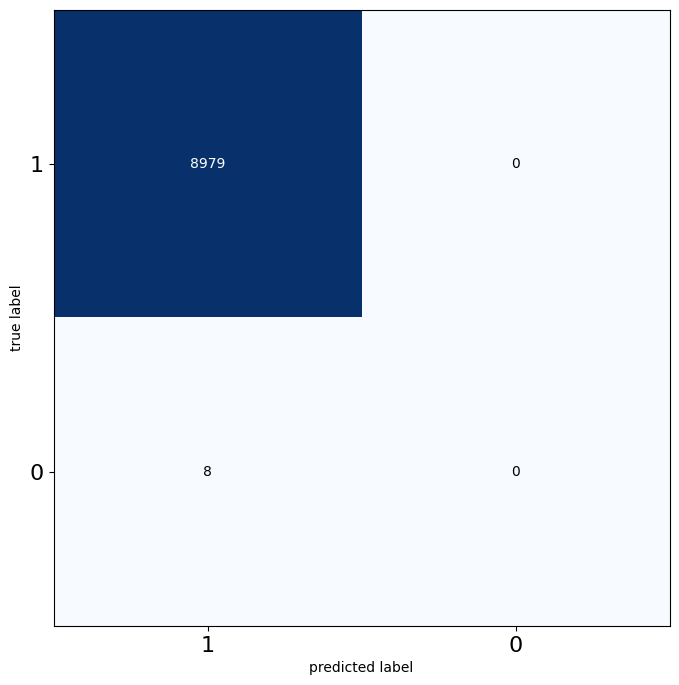

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Bathrooms
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

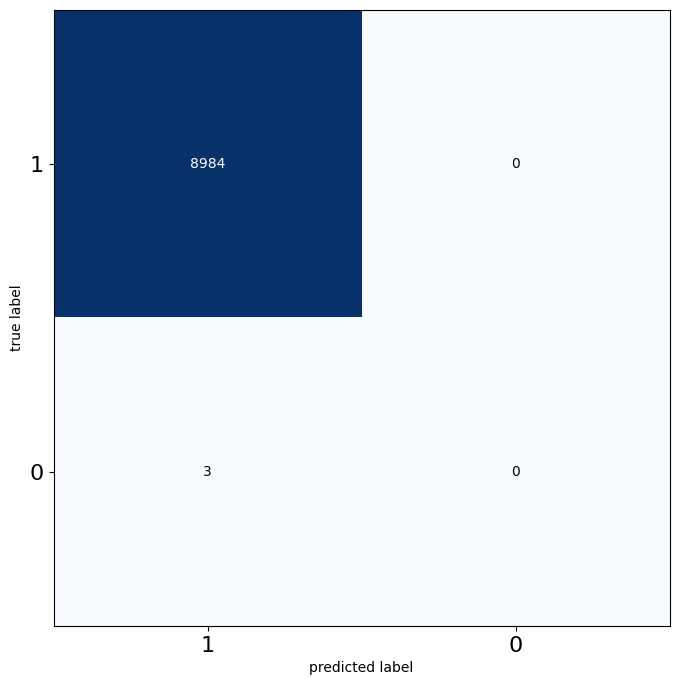

Batteries
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

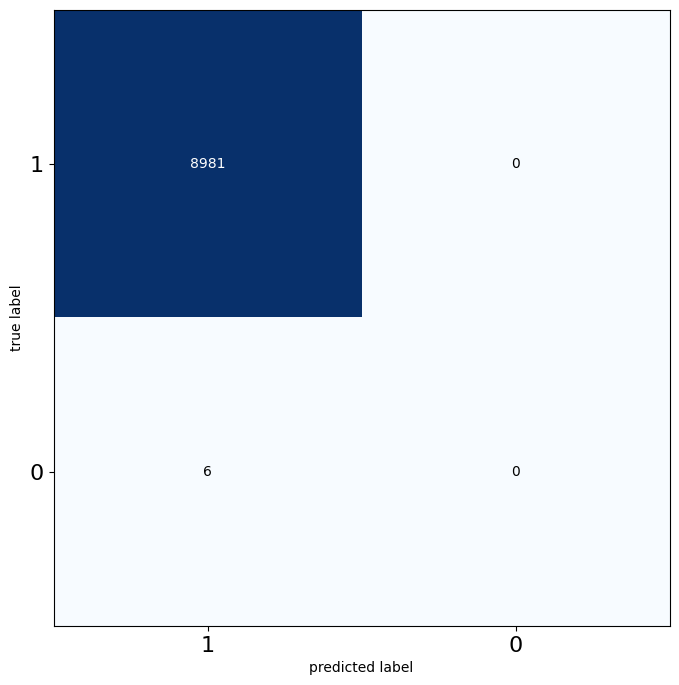

Beach Hotels
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

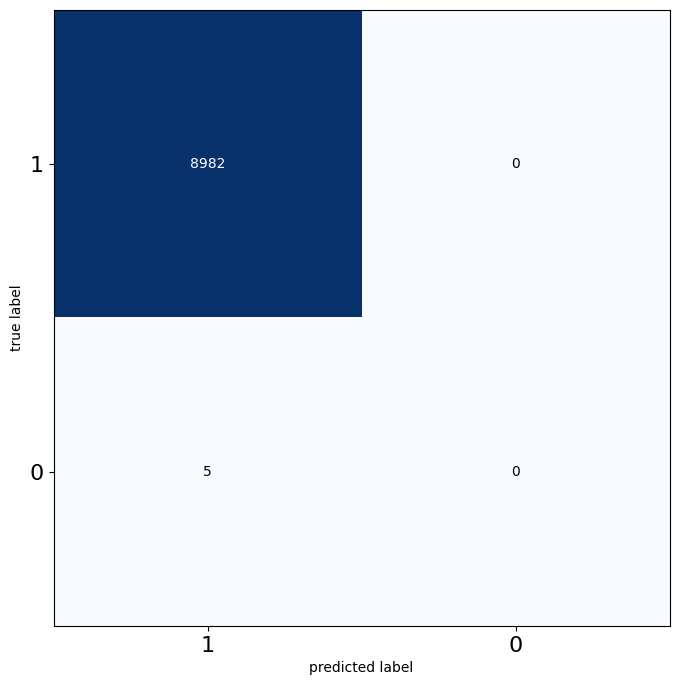

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Beauty Products
accuracy: 0.9902080783353733 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

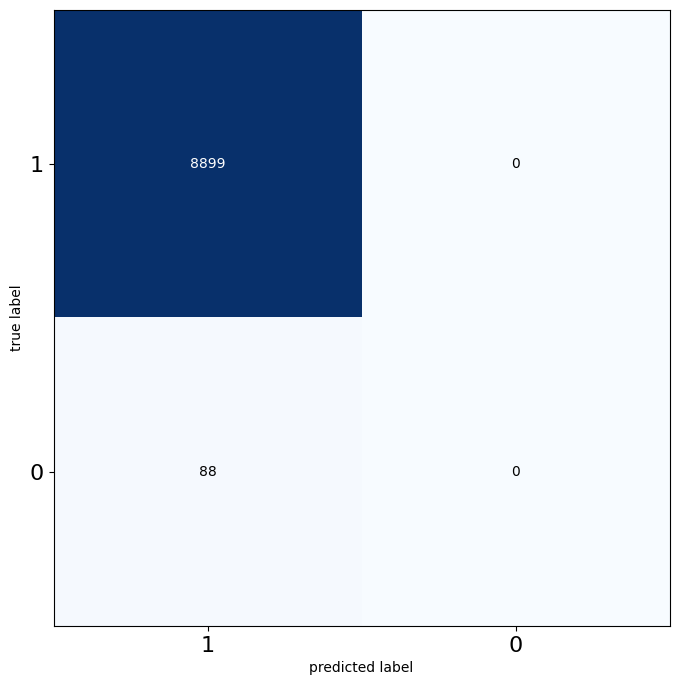

Beauty Salons
accuracy: 0.023812173138978526 precision: 0.023812173138978526 recall: 1.0 f1: 0.04651668296924248


<Figure size 640x480 with 0 Axes>

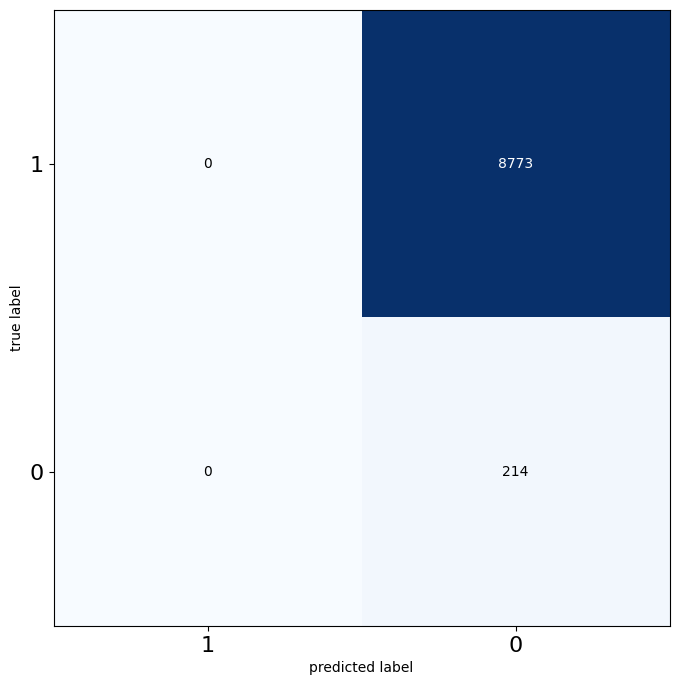

Beauty Salons Equipment & Supplies
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

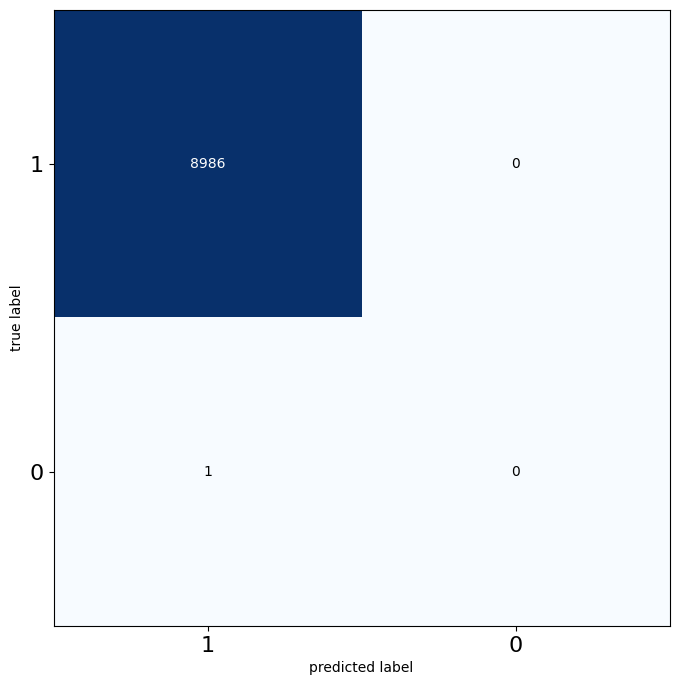

Beddings
accuracy: 0.9984421942806275 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

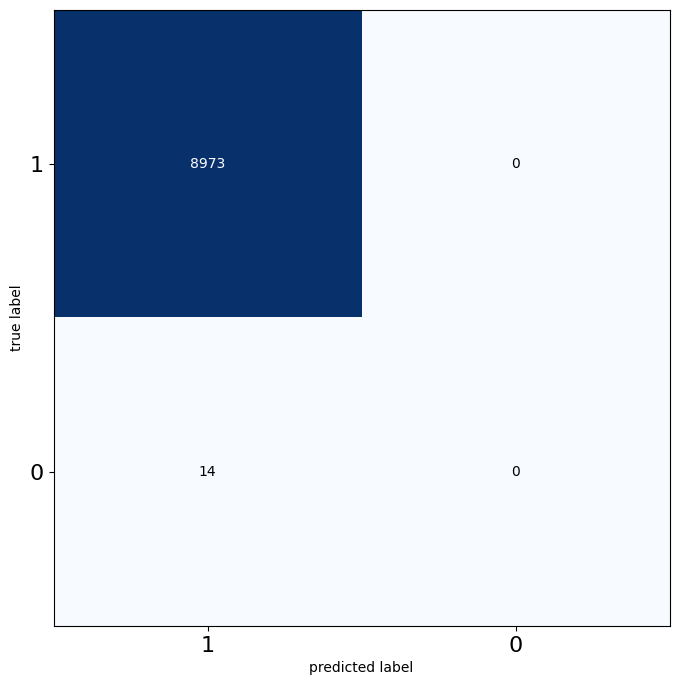

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Beer & Ale
accuracy: 0.9937687771225103 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

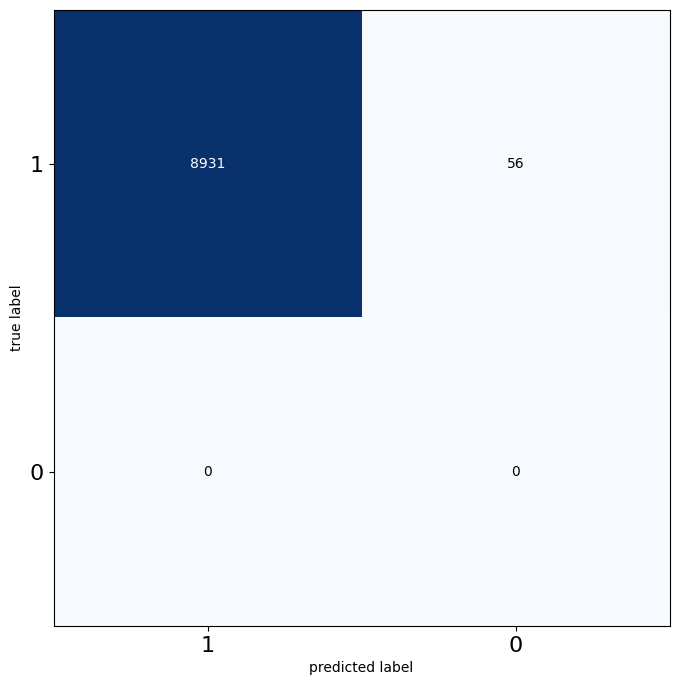

Beverages
accuracy: 0.9925447869144319 precision: 0.01694915254237288 recall: 0.1 f1: 0.028985507246376815


<Figure size 640x480 with 0 Axes>

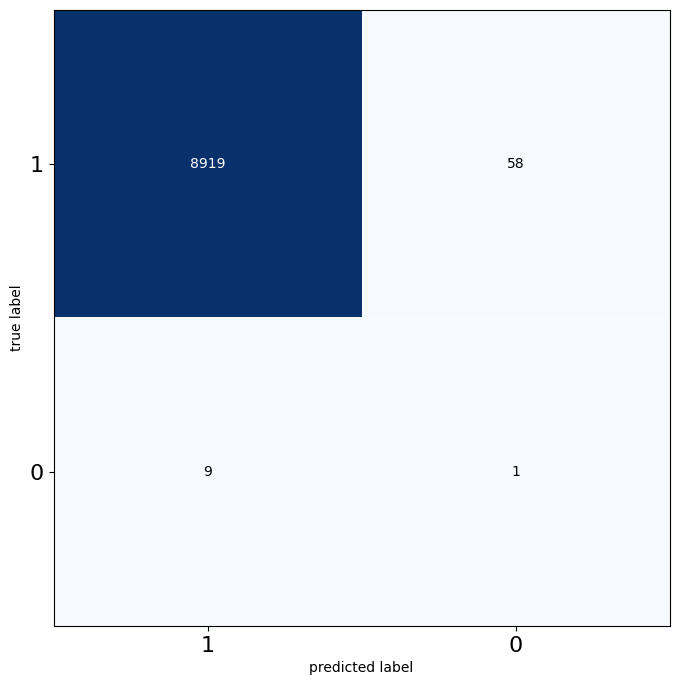

Bicycles-Dealers & Repairs
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

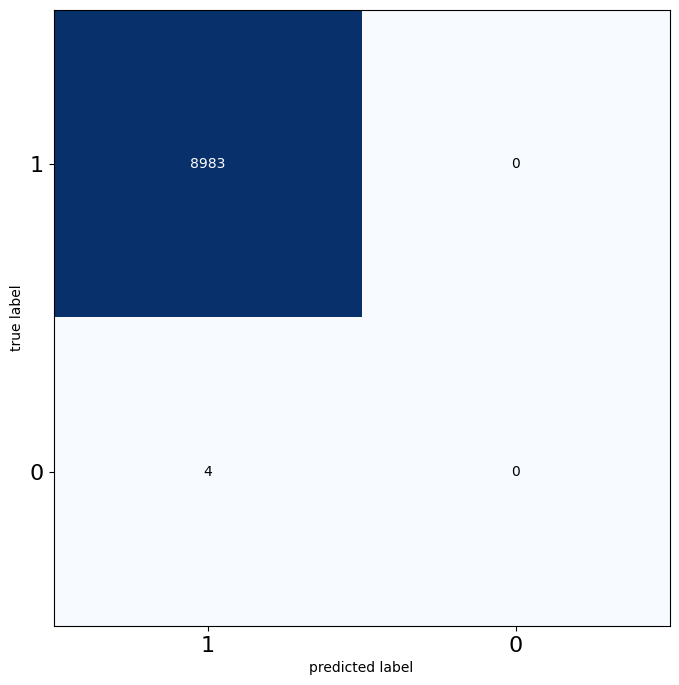

Biscuits
accuracy: 0.992878602425726 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

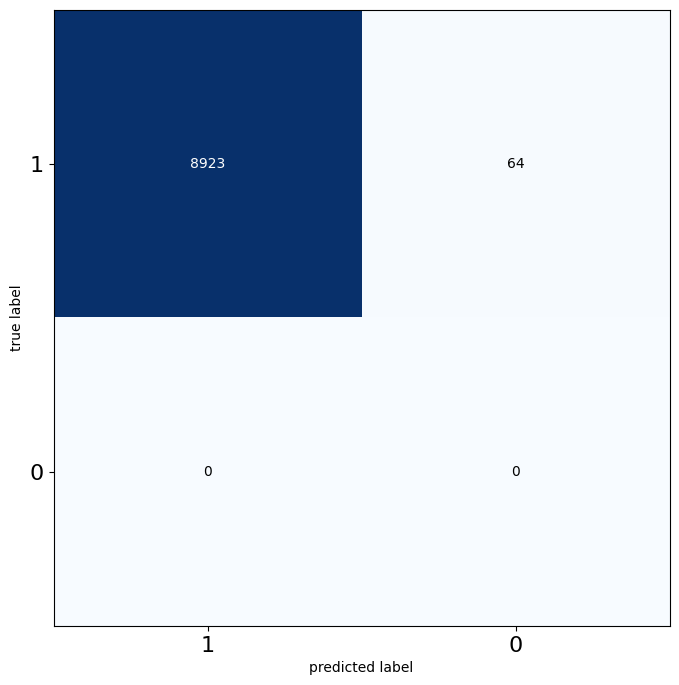

Blinds
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

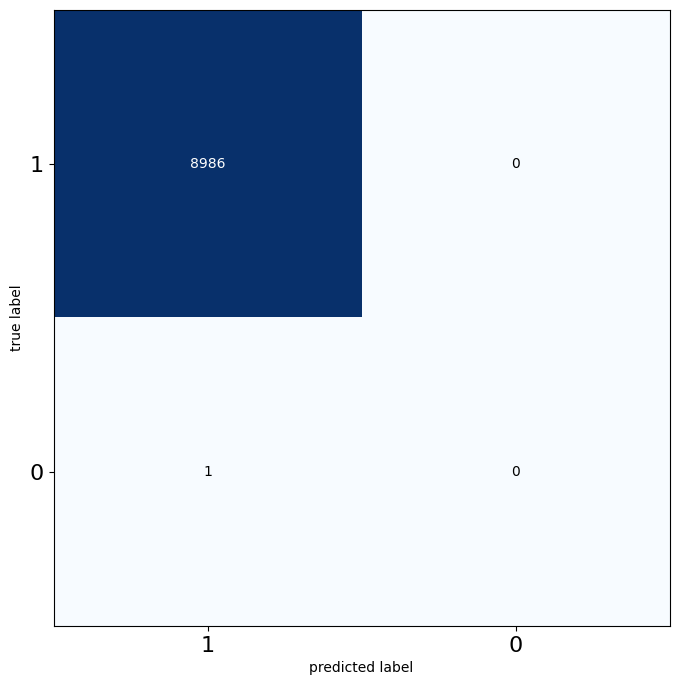

Boat Builders
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

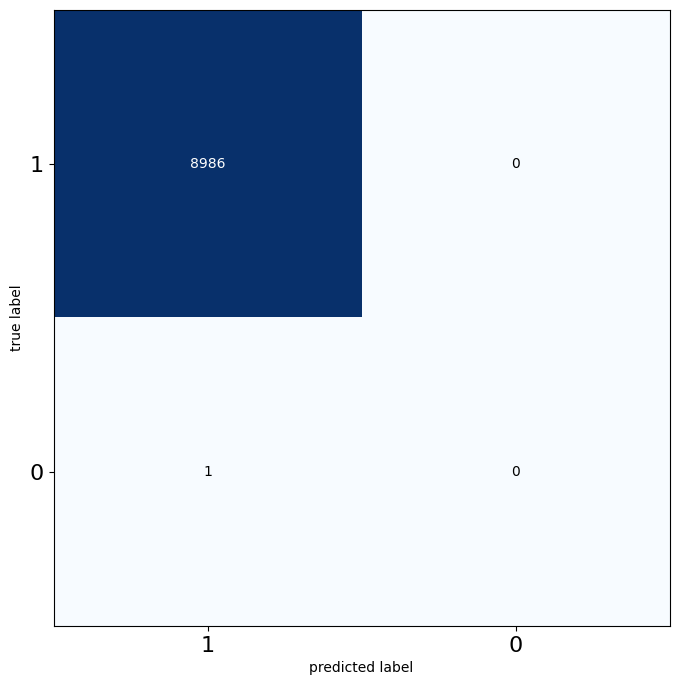

Boat Repairs & Maintenance
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

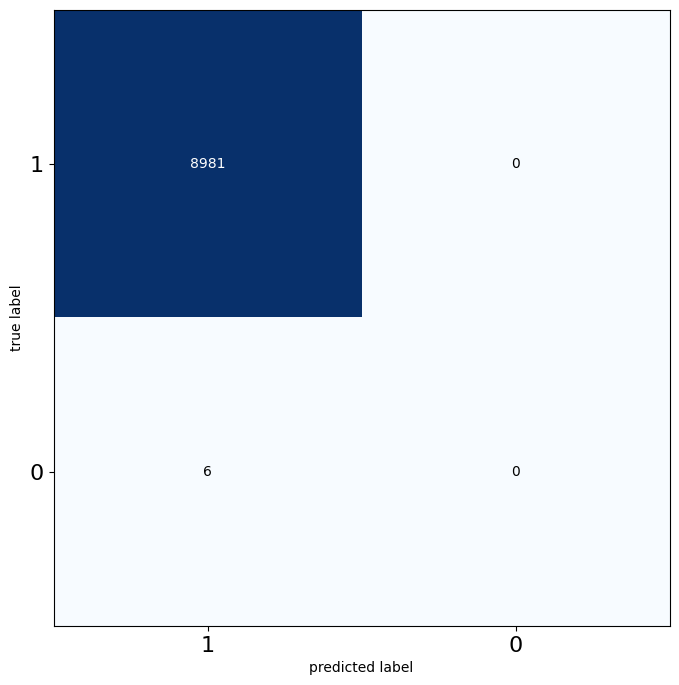

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Bookeeping Services
accuracy: 0.9859797485256482 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

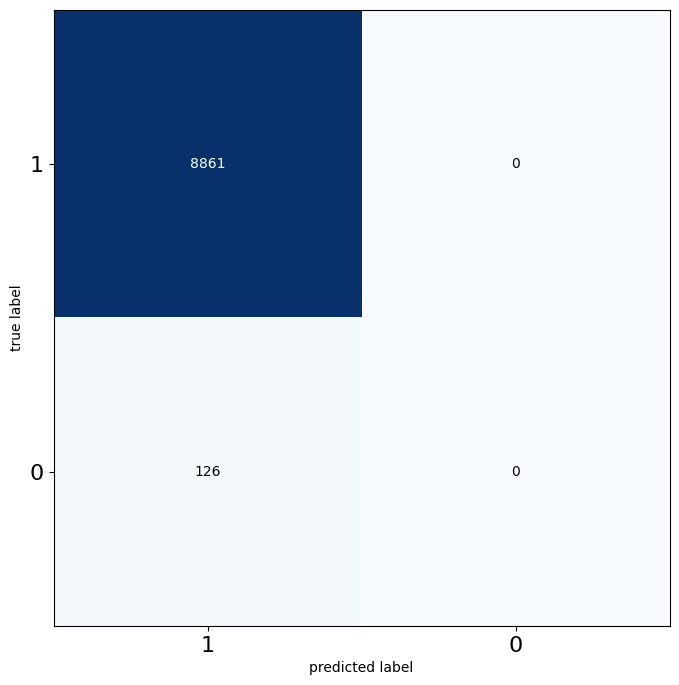

Bookshops
accuracy: 0.9846444864804718 precision: 0.01904761904761905 recall: 0.05405405405405406 f1: 0.028169014084507043


<Figure size 640x480 with 0 Axes>

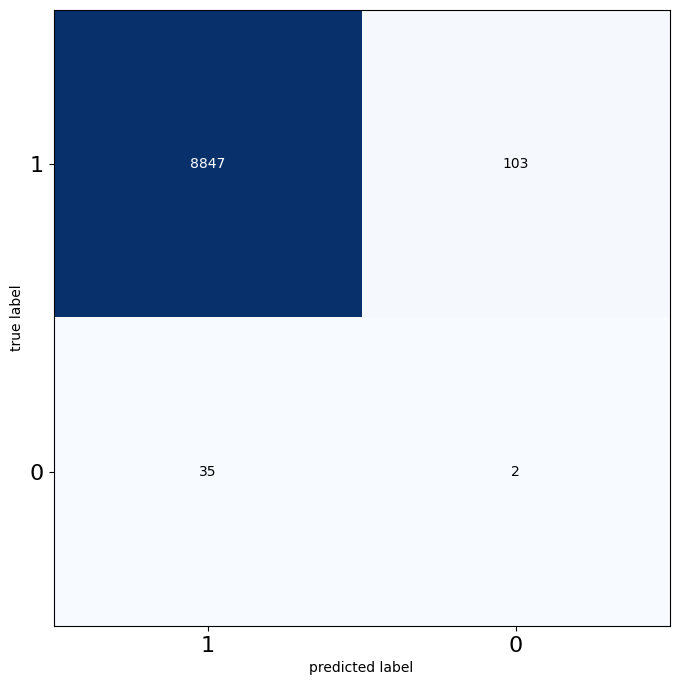

Boreholes Drilling
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

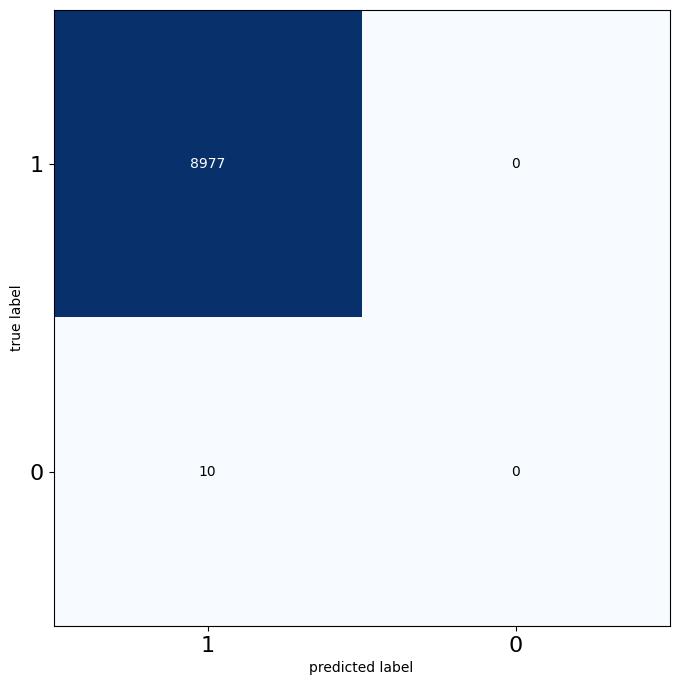

Boutiques
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

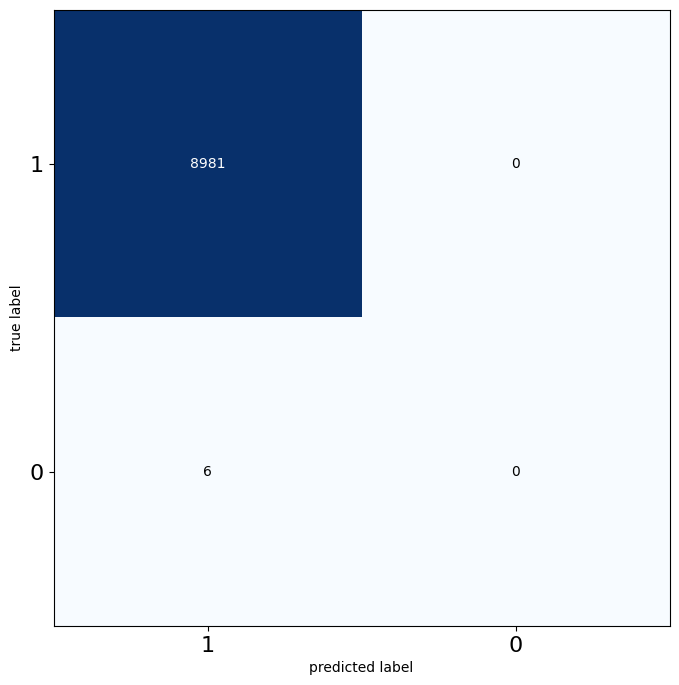

Brass
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

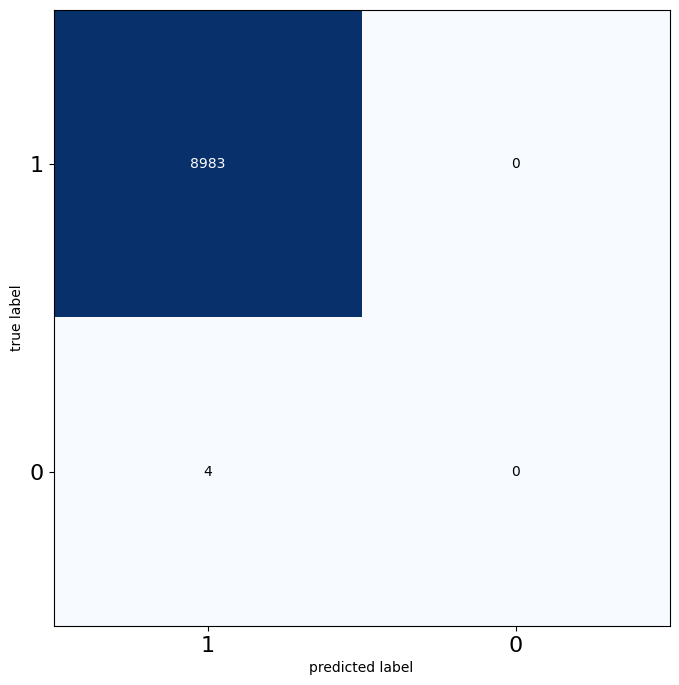

Breakdown Services
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

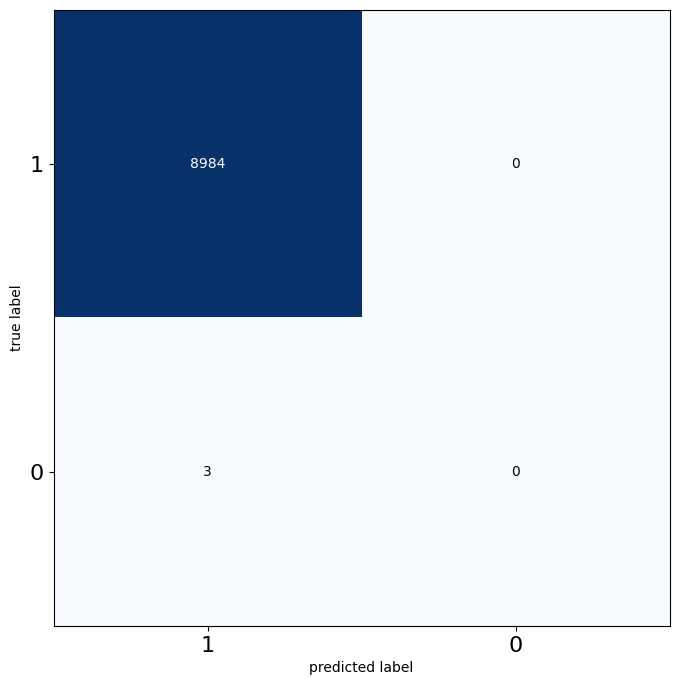

Brewers

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



accuracy: 0.9934349616112162 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

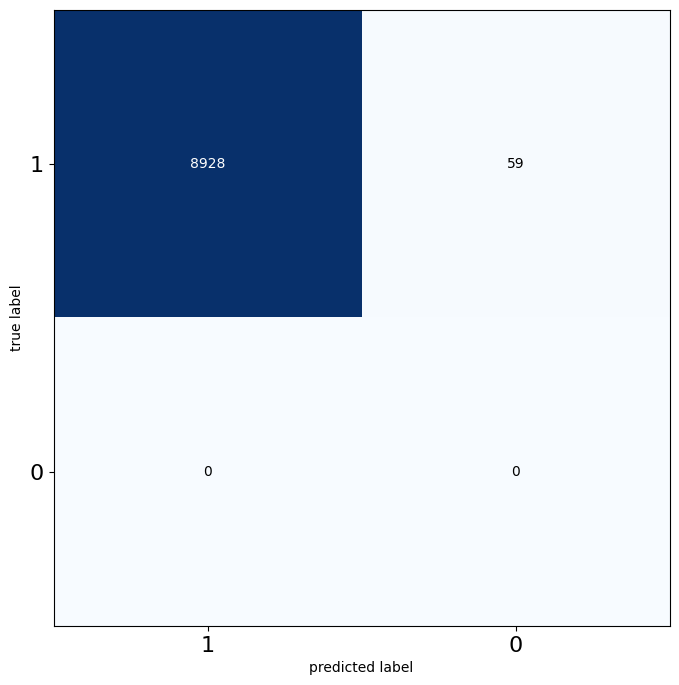

Bridal Shops
accuracy: 0.9971069322354512 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

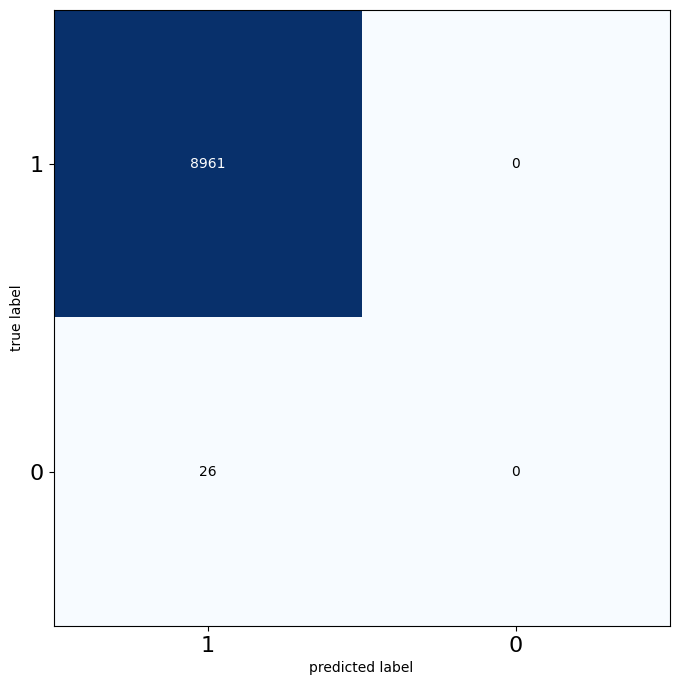

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


Brushes
accuracy: 0.9934349616112162 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

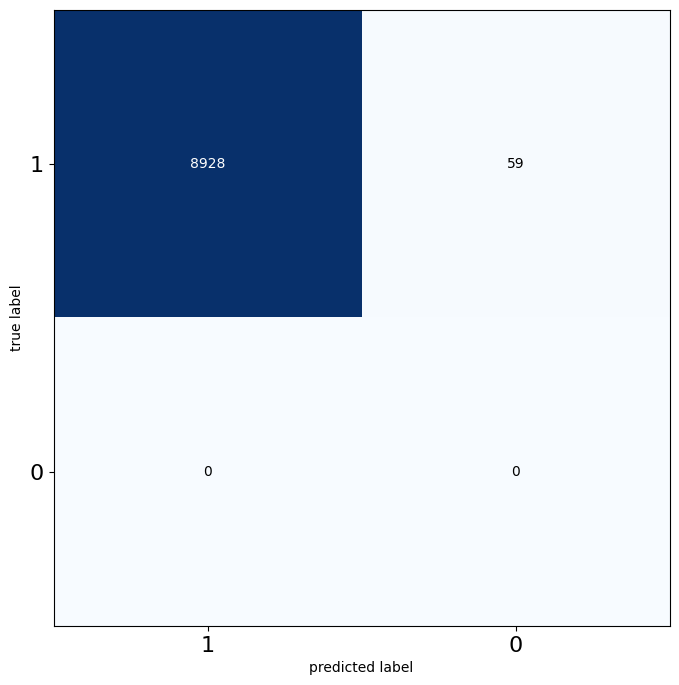

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Building & Planning Consultants
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

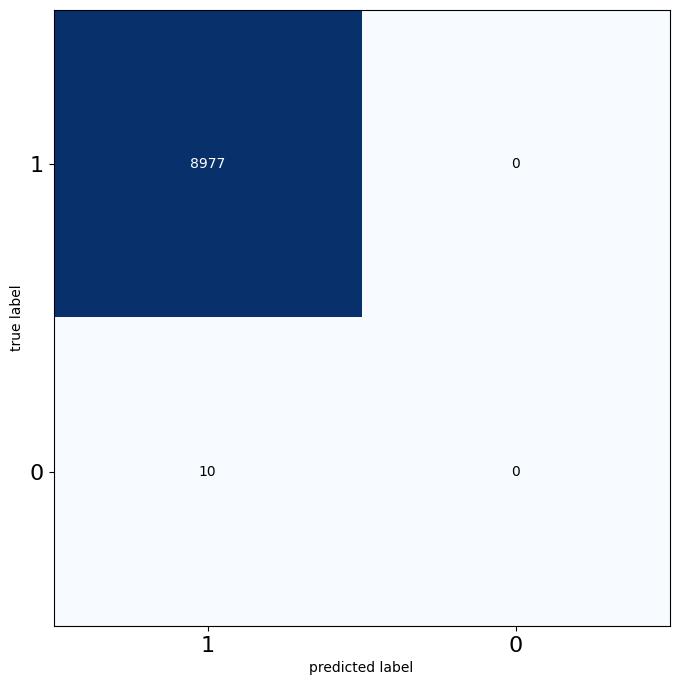

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Building Contractors
accuracy: 0.9941025926338044 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

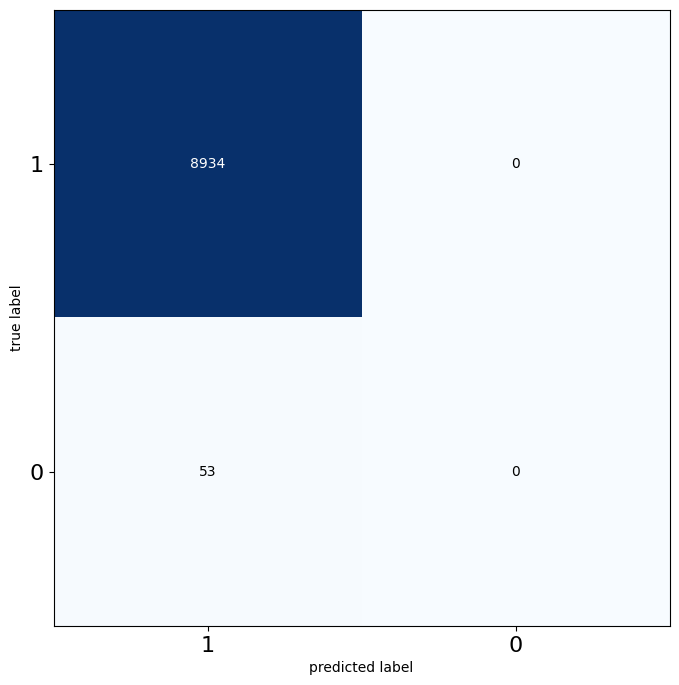

Building Materials
accuracy: 0.9957716701902748 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

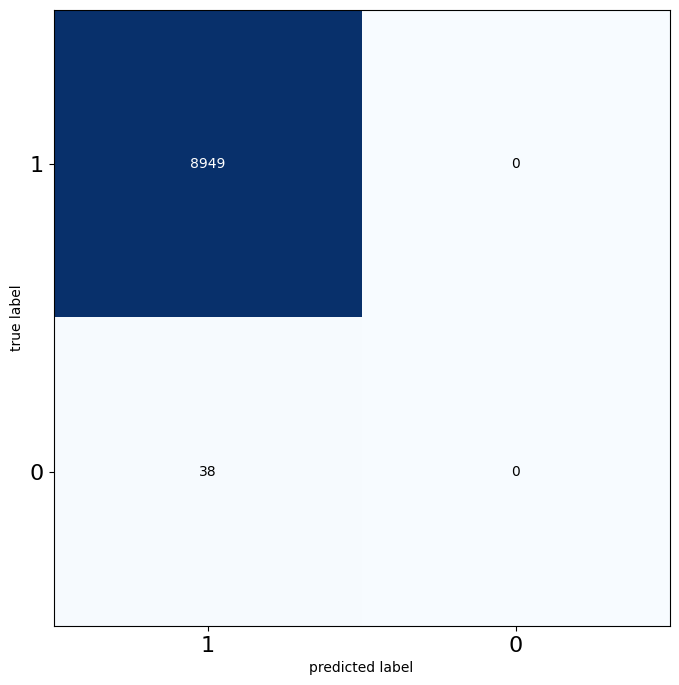

Building Repairers & Renovators
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

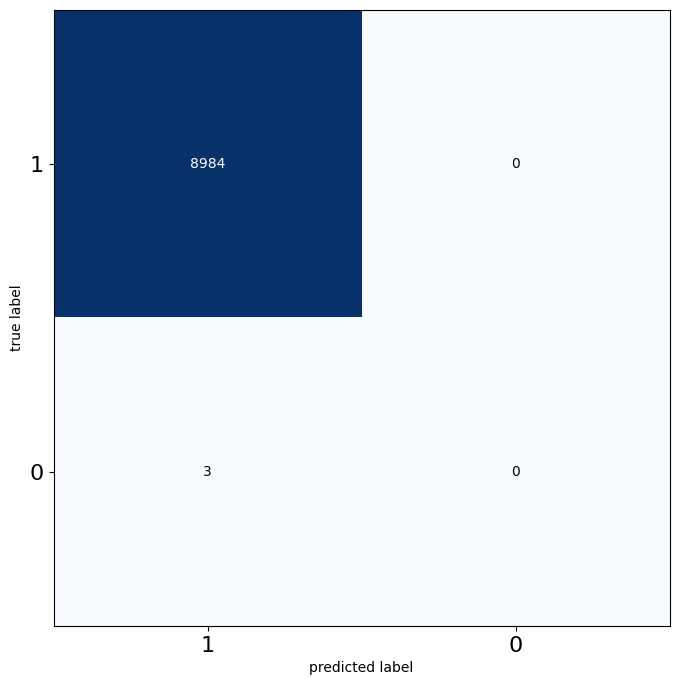

Building Societies
accuracy: 0.9941025926338044 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

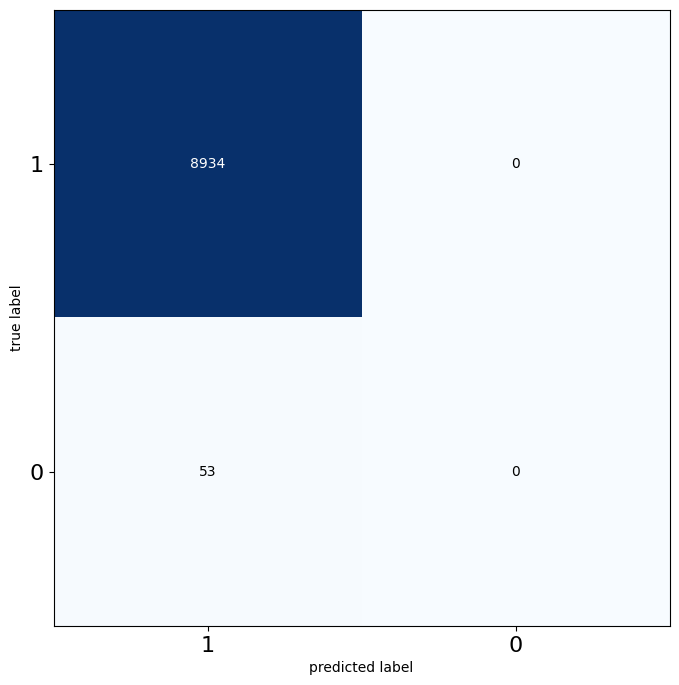

Bureau Services
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

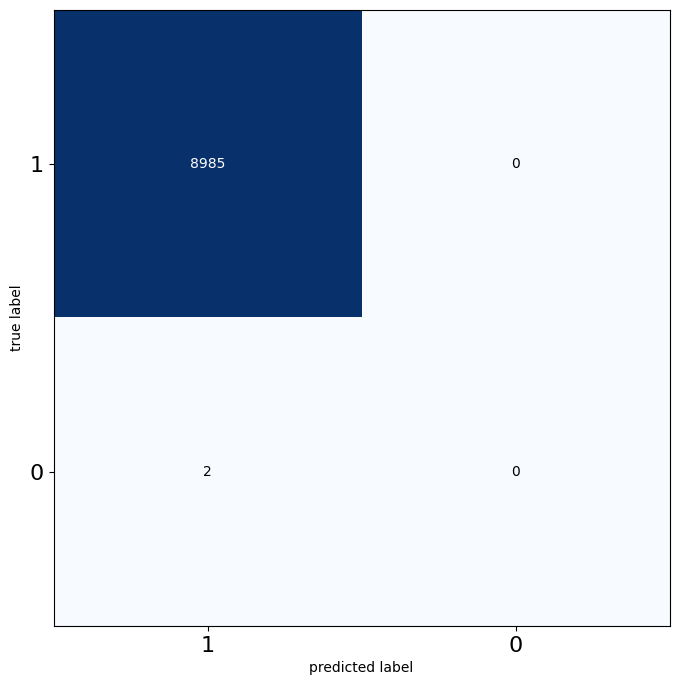

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Bus Companies
accuracy: 0.9902080783353733 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

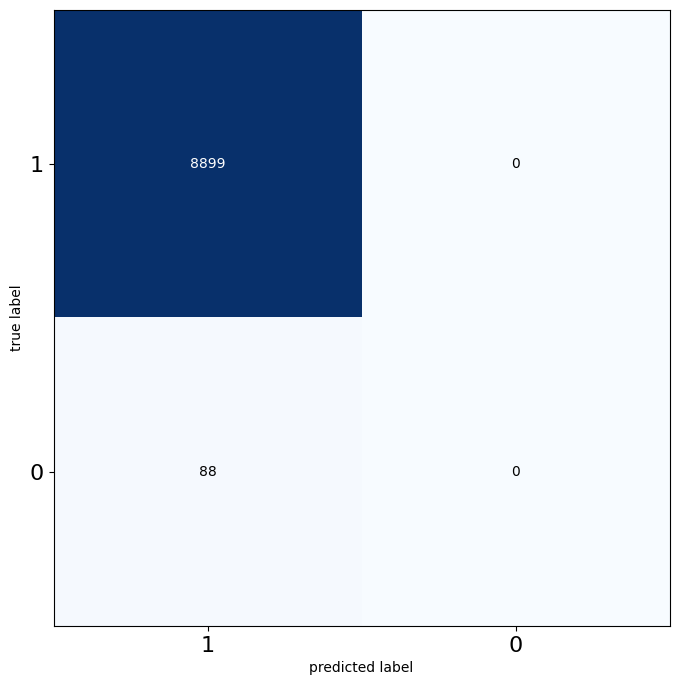

Butcheries
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

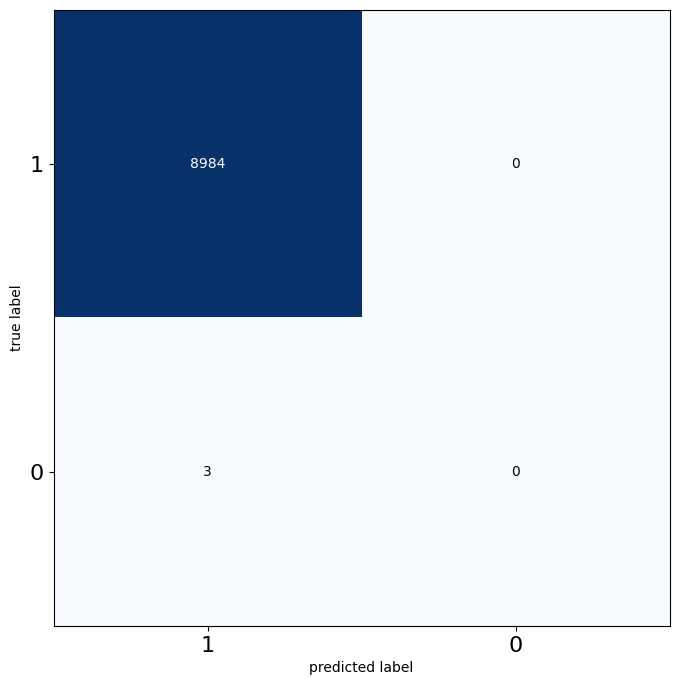

Cables
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

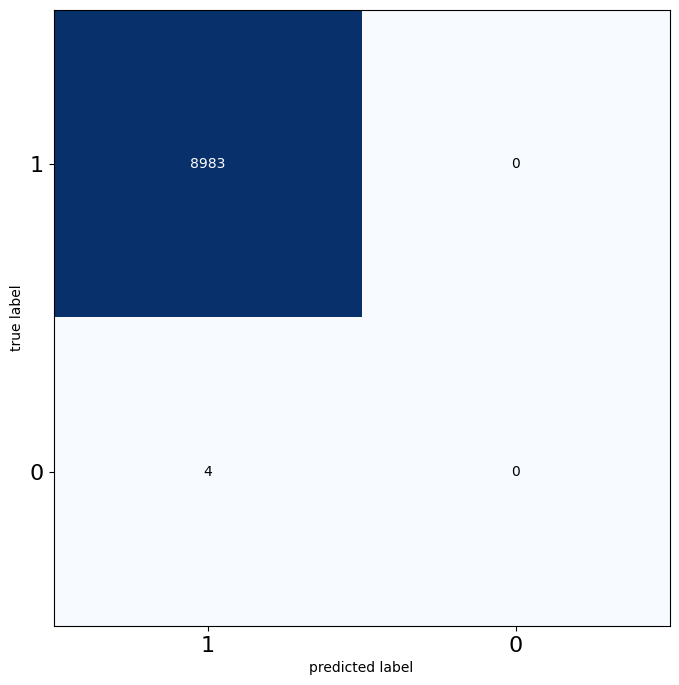

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cabling & Trunking
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

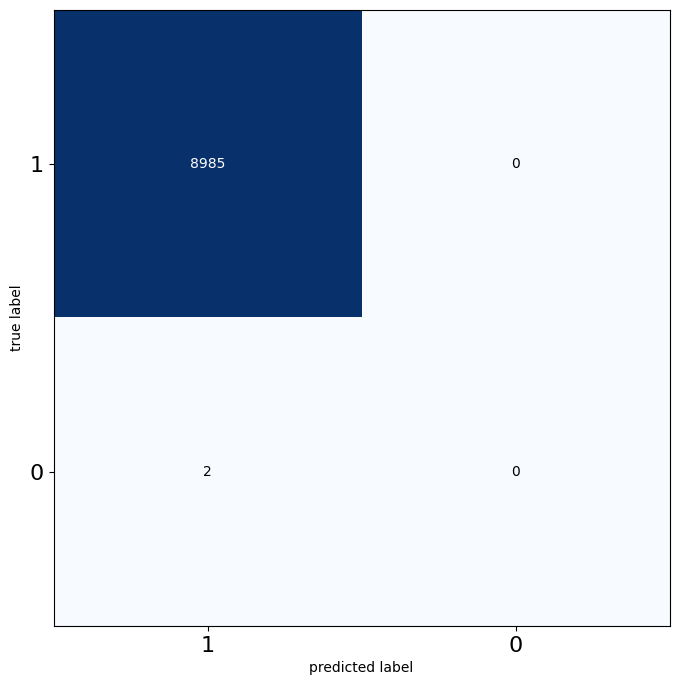

Cabs/Taxis
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

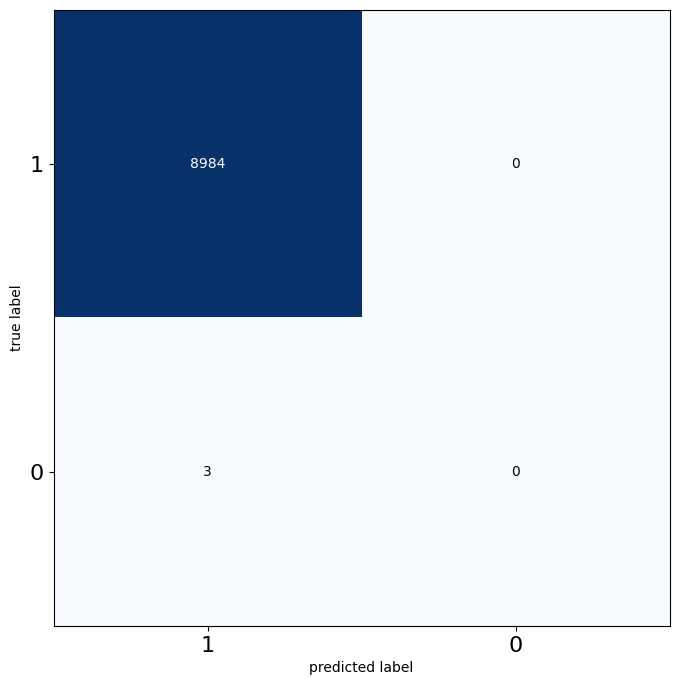

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cafeterias
accuracy: 0.9948814954934906 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

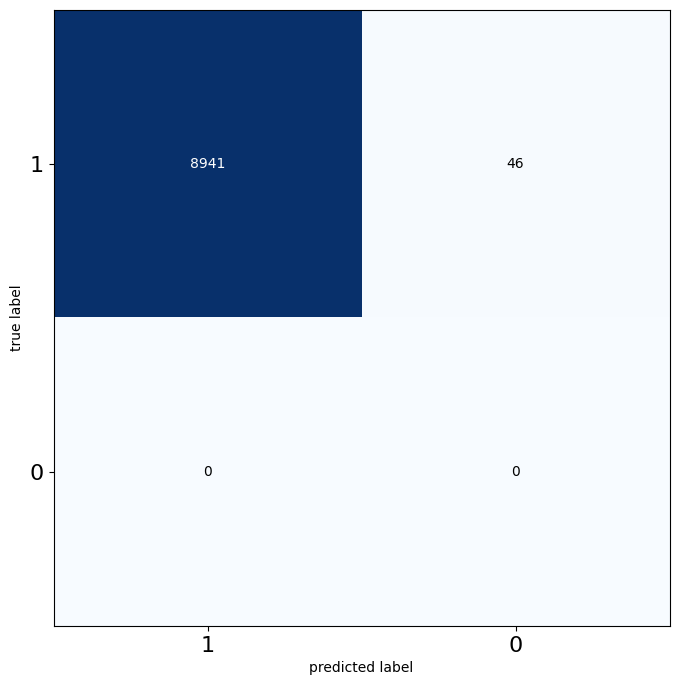

Call Centres
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

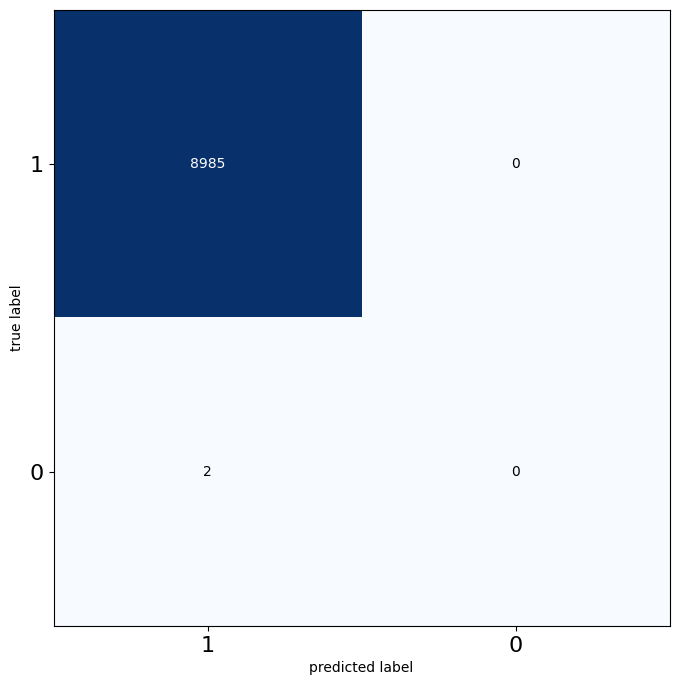

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cameras
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

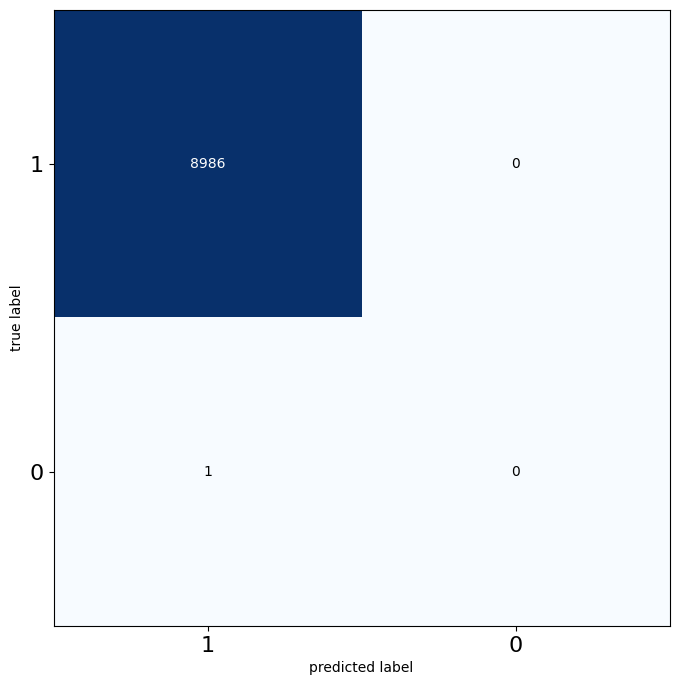

Candles
accuracy: 0.9934349616112162 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

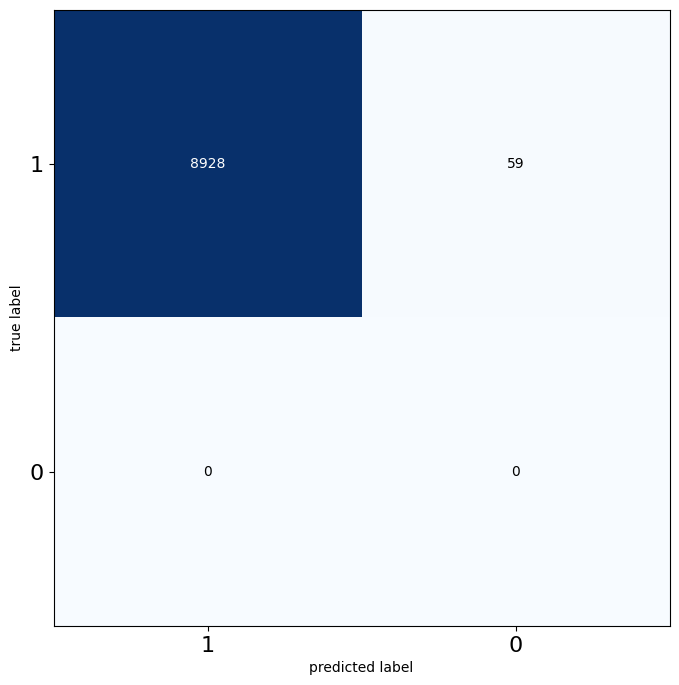

Canned Foods
accuracy: 0.9647268276399243 precision: 0.0319634703196347 recall: 0.0625 f1: 0.04229607250755287


<Figure size 640x480 with 0 Axes>

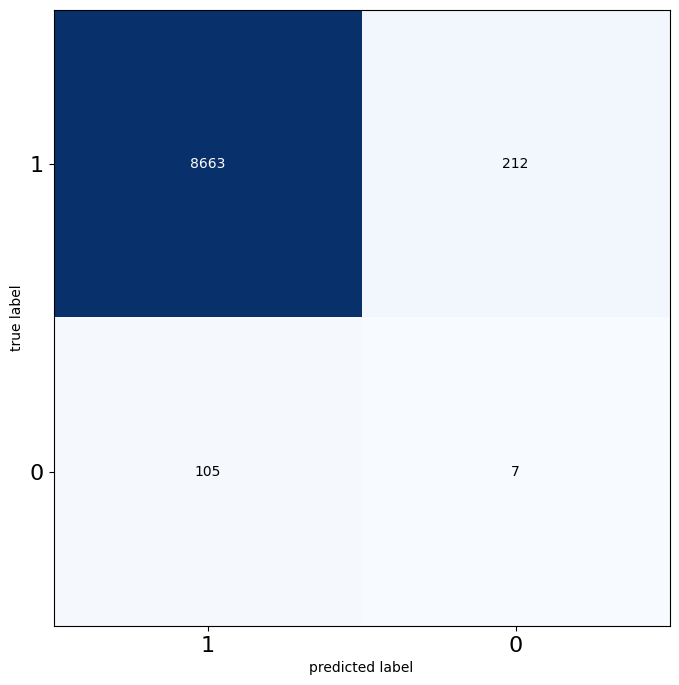

Capital Markets
accuracy: 0.9956603983531768 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

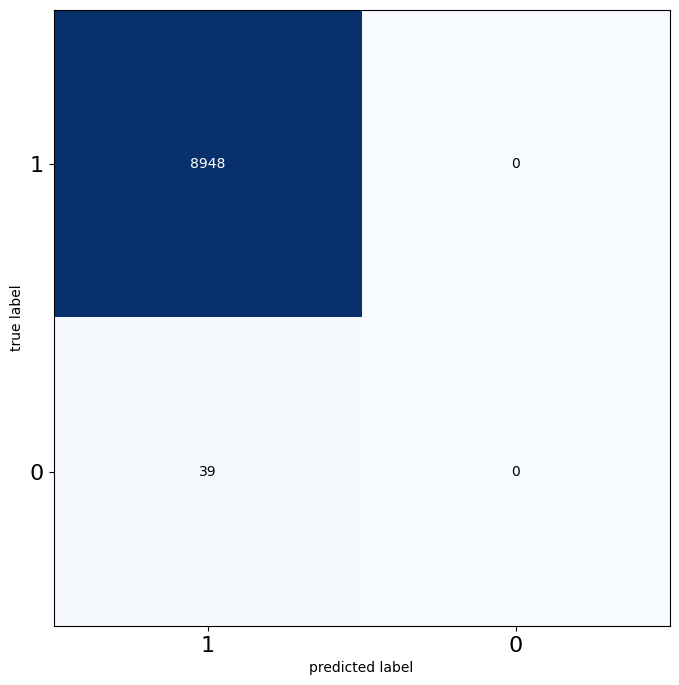

Car Hire
accuracy: 0.9953265828418827 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

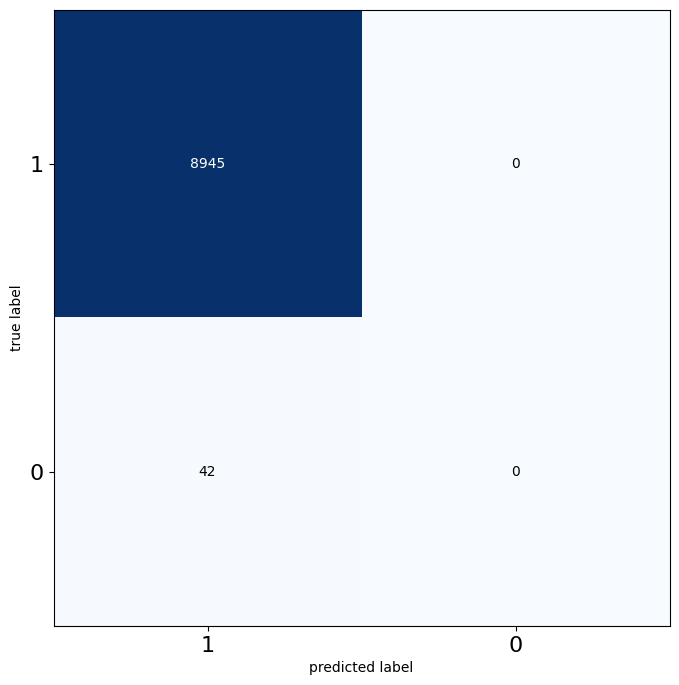

Car Parks
accuracy: 0.9931011460999221 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

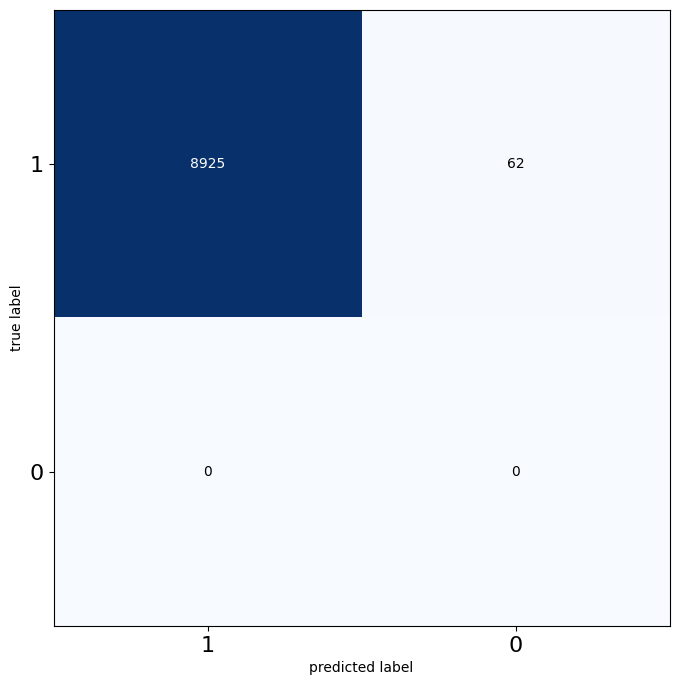

Carpet & Rug Cleaners
accuracy: 0.9982196506064315 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

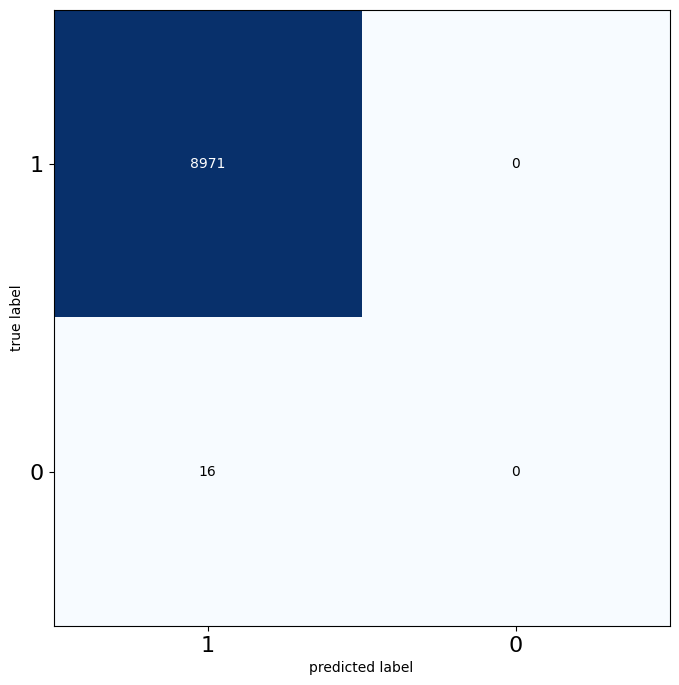

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cashewnuts
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

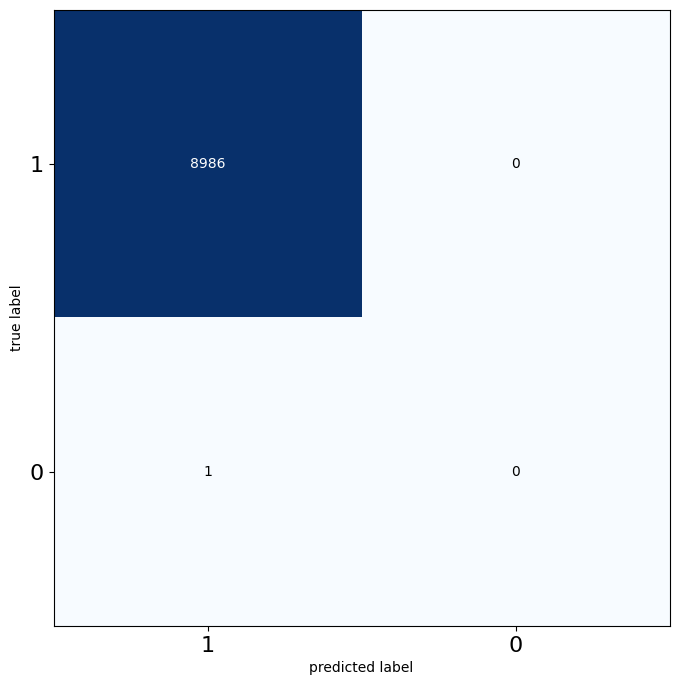

Casinos
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

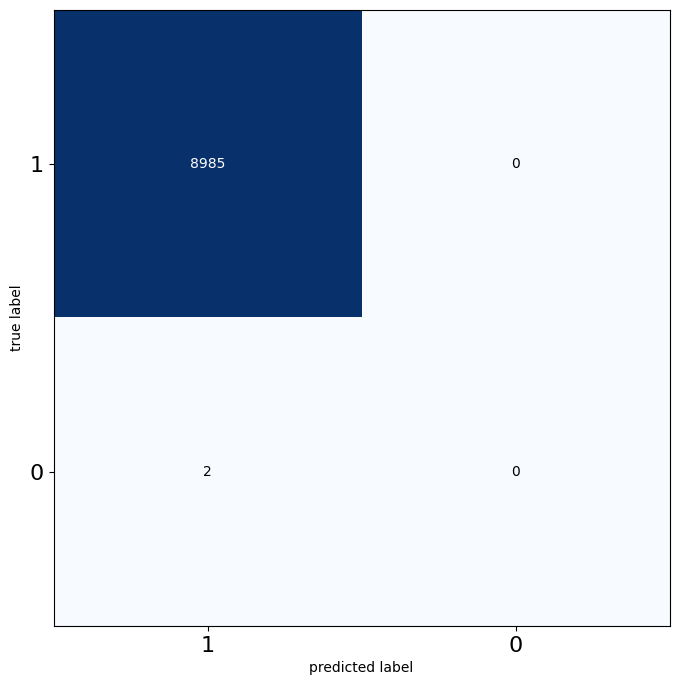

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Caterers
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

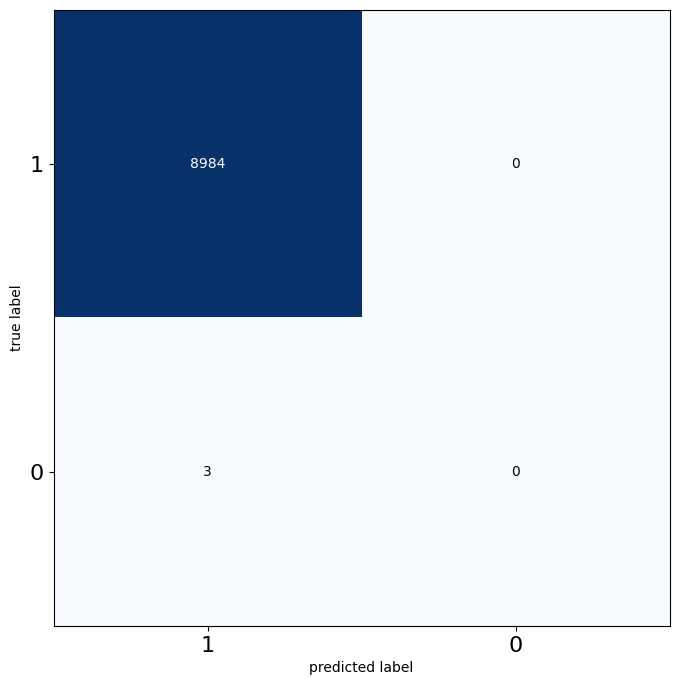

Catering Equipment
accuracy: 0.9968843885612552 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

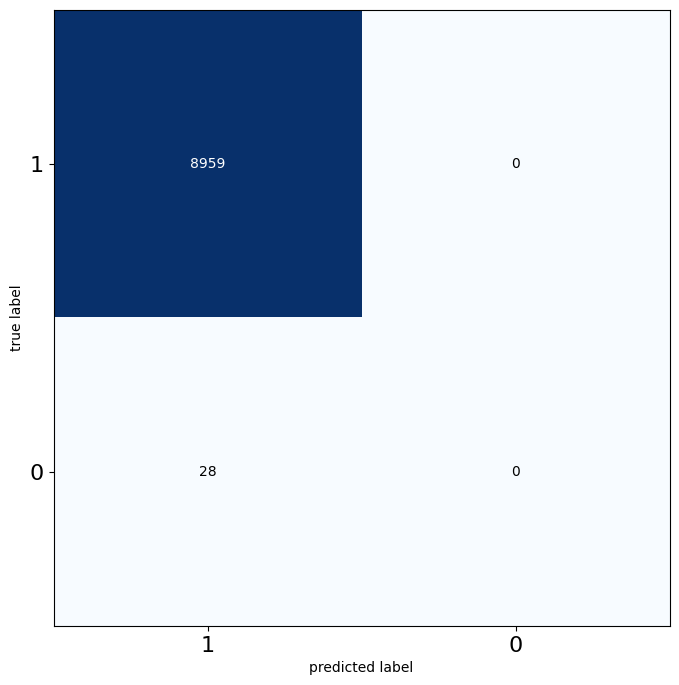

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Chemical Engineers
accuracy: 0.9943251363080005 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

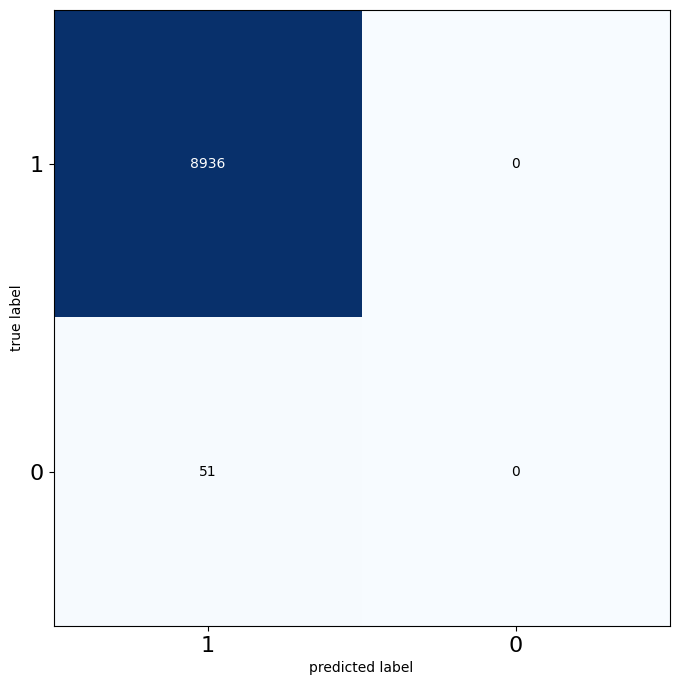

Childrens & Infants Wear
accuracy: 0.9977745632580394 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

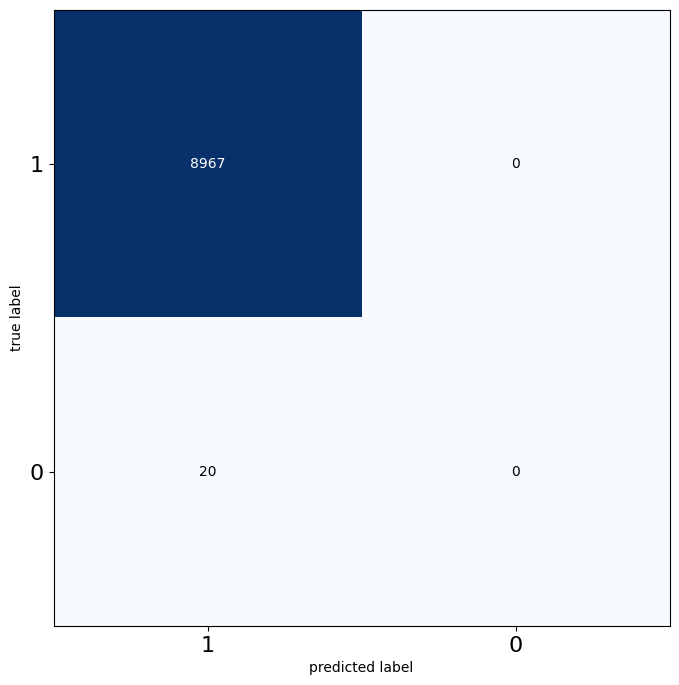

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Chiropodists
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

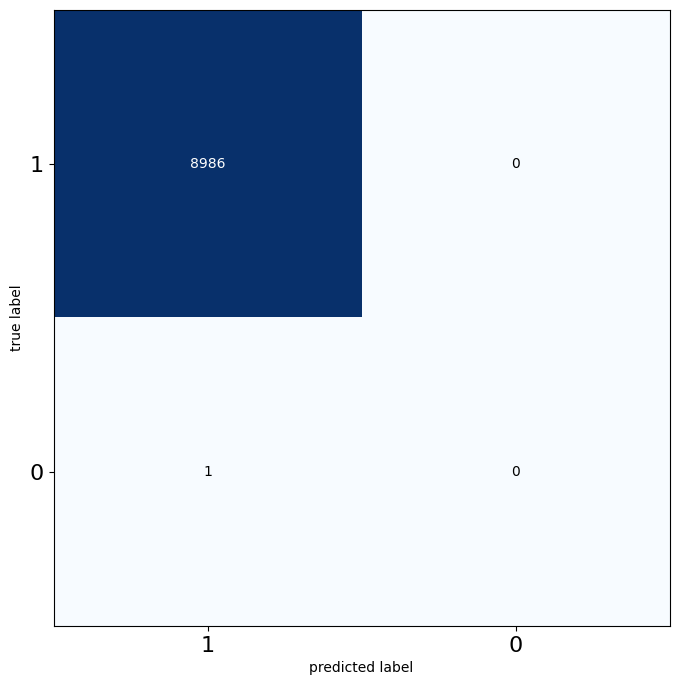

Chiropractors
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

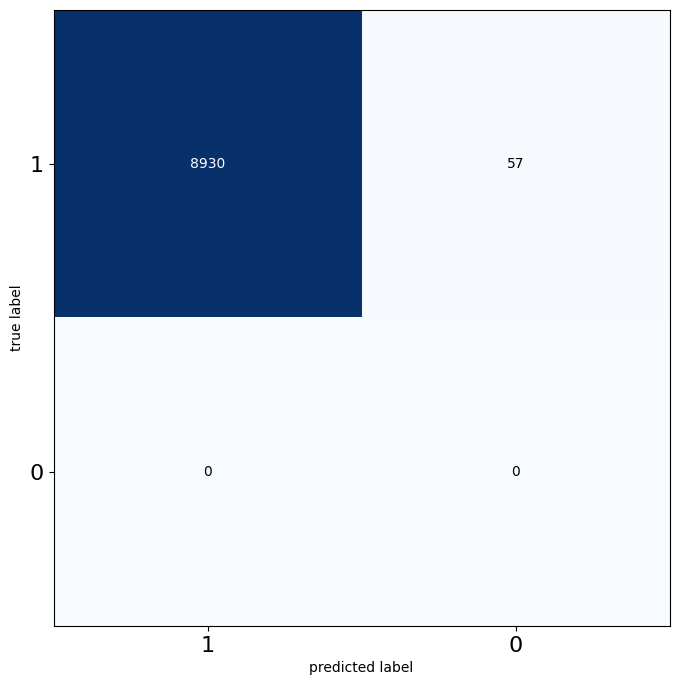

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Chocolate Manufacturers
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

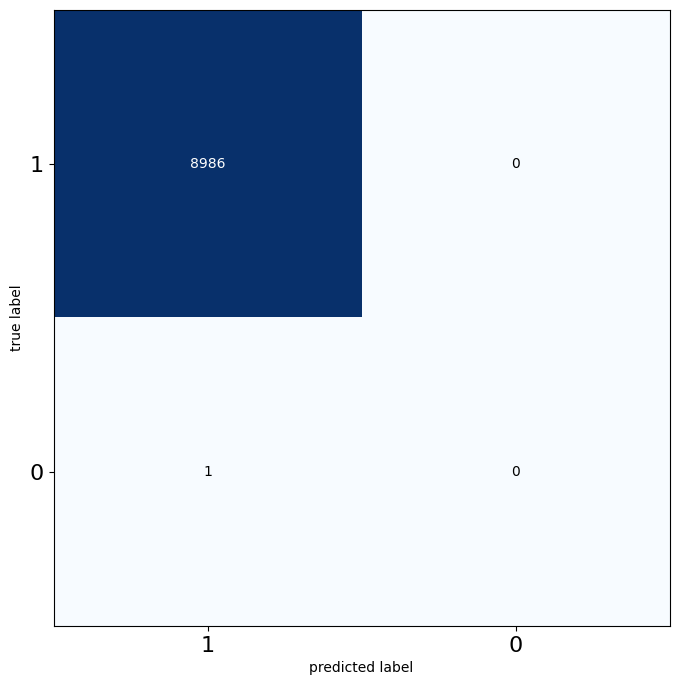

Cigar, Cigarette & Tobacco Dealers
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

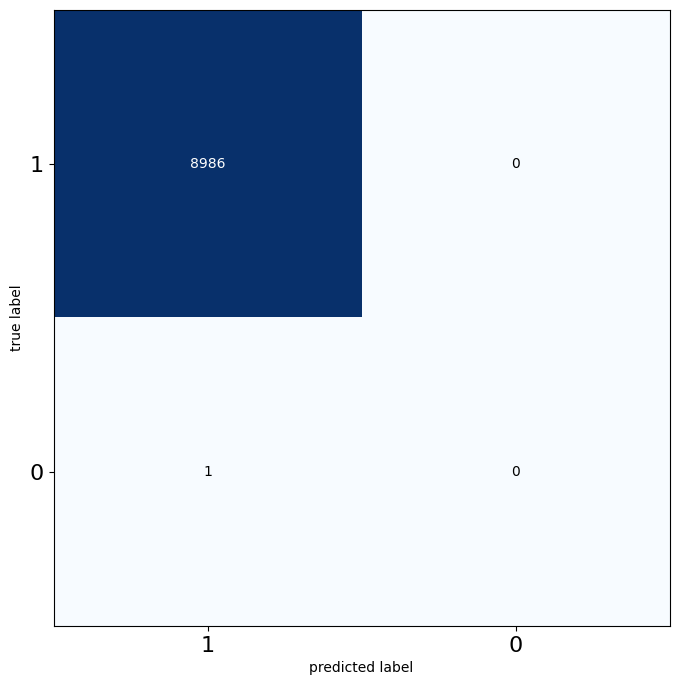

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Civil Engineers
accuracy: 0.9981083787693334 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

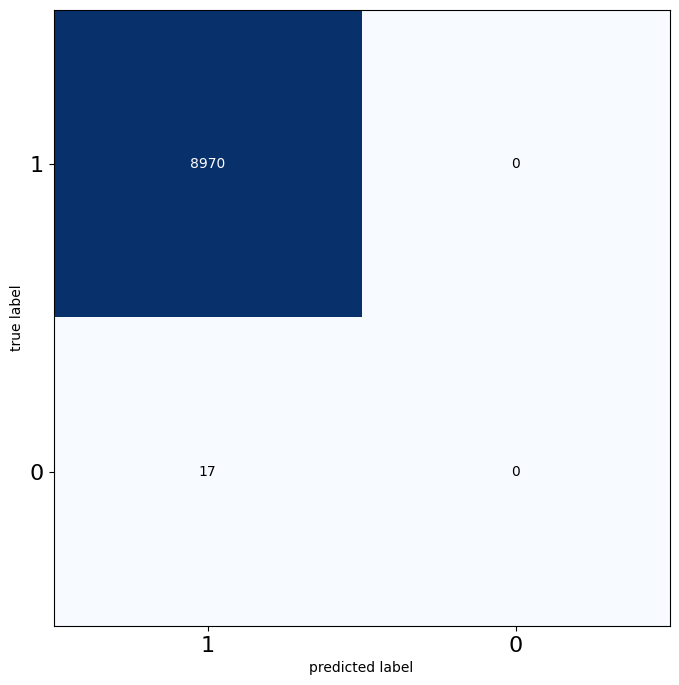

Cleaning Services
accuracy: 0.2072994325136308 precision: 0.017019510170195103 recall: 0.8601398601398601 f1: 0.033378561736770694


<Figure size 640x480 with 0 Axes>

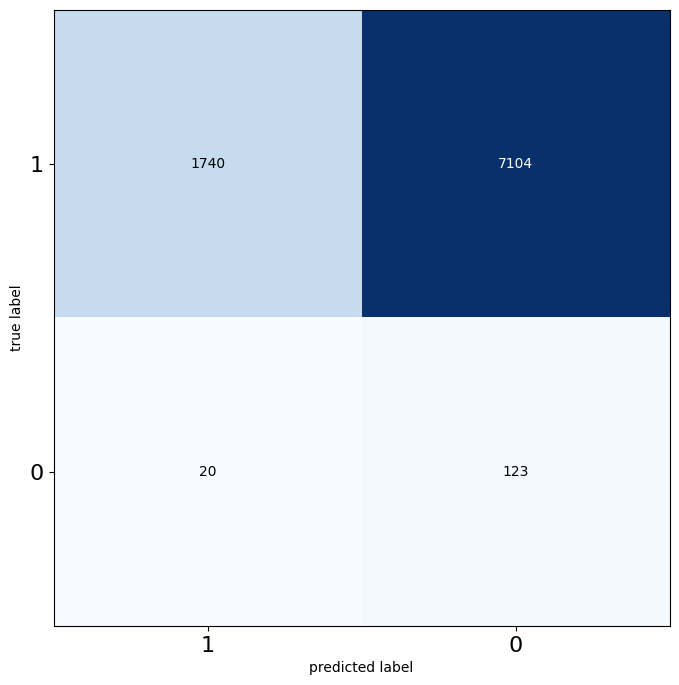

Cleaning Supplies
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

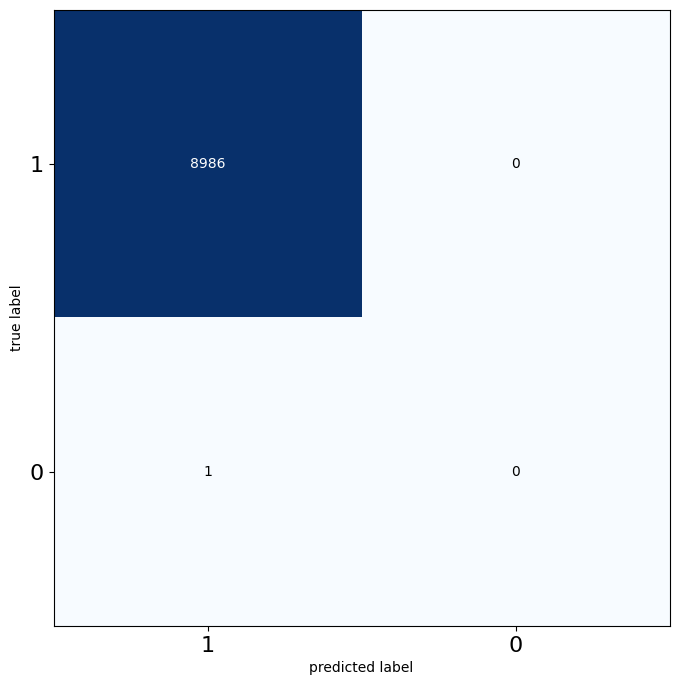

Clearing & Forwarding
accuracy: 0.9974407477467453 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

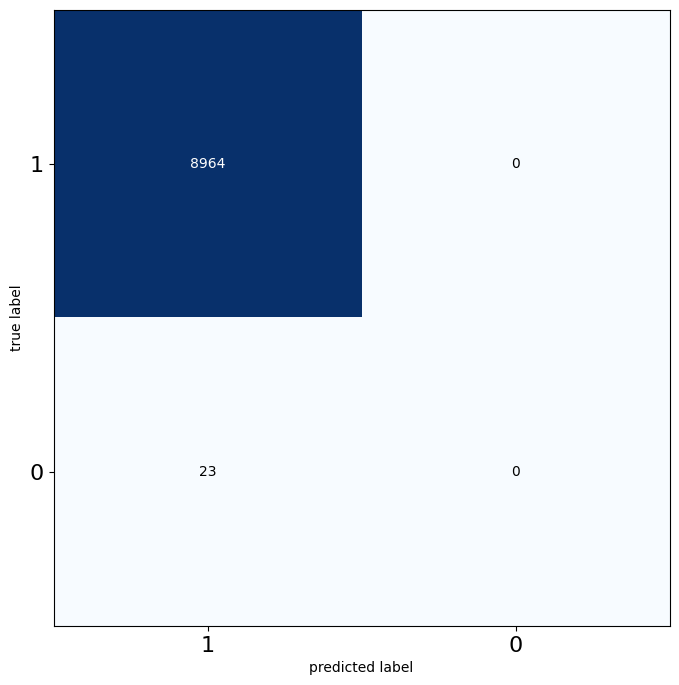

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clinics
accuracy: 0.9976632914209413 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

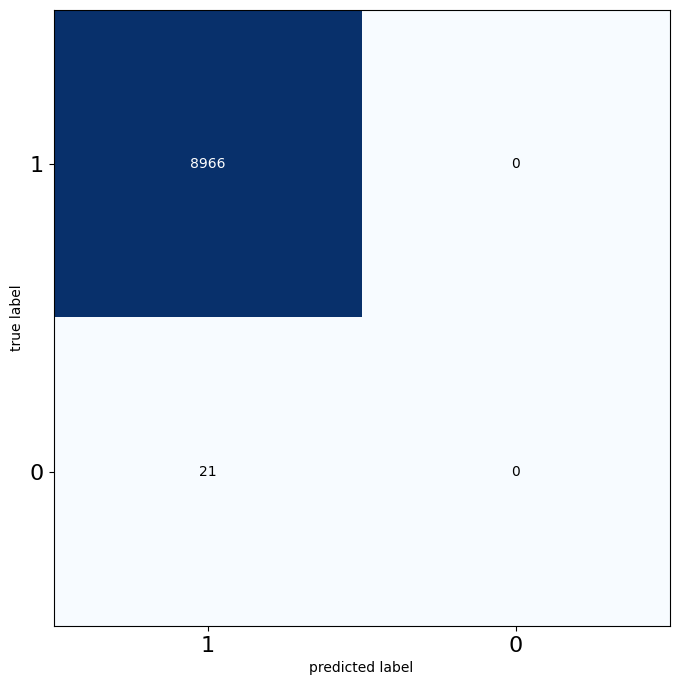

Clothing Accessories
accuracy: 0.9732947590964727 precision: 0.04 recall: 0.004608294930875576 f1: 0.008264462809917356


<Figure size 640x480 with 0 Axes>

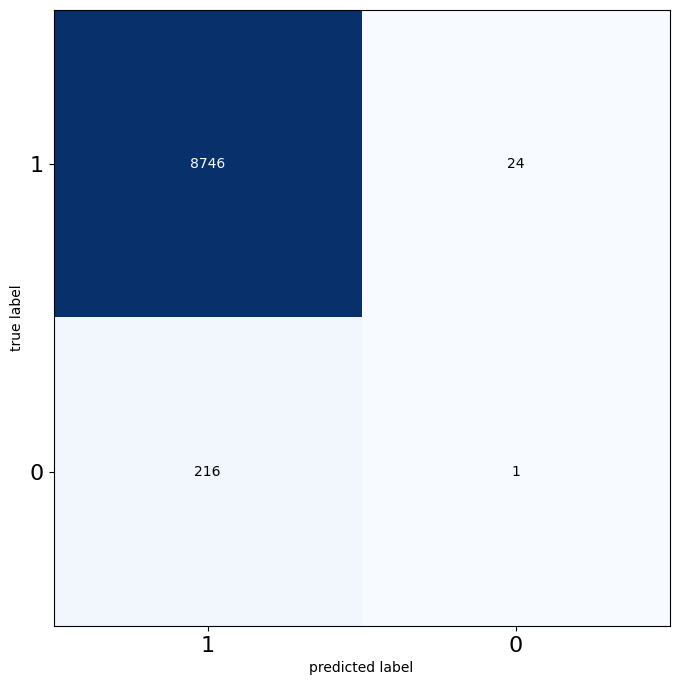

Clothing Manufacturers Supplies
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

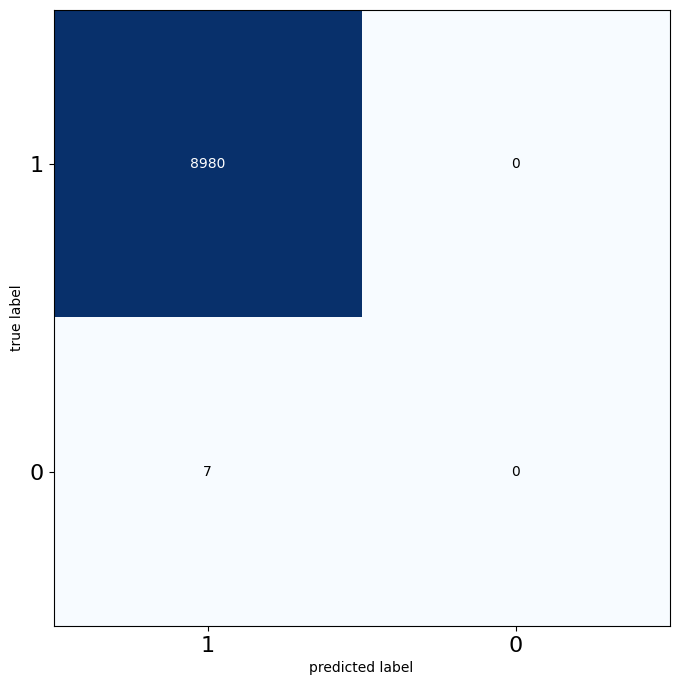

Clothing-Manufacturers & Wholesalers
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

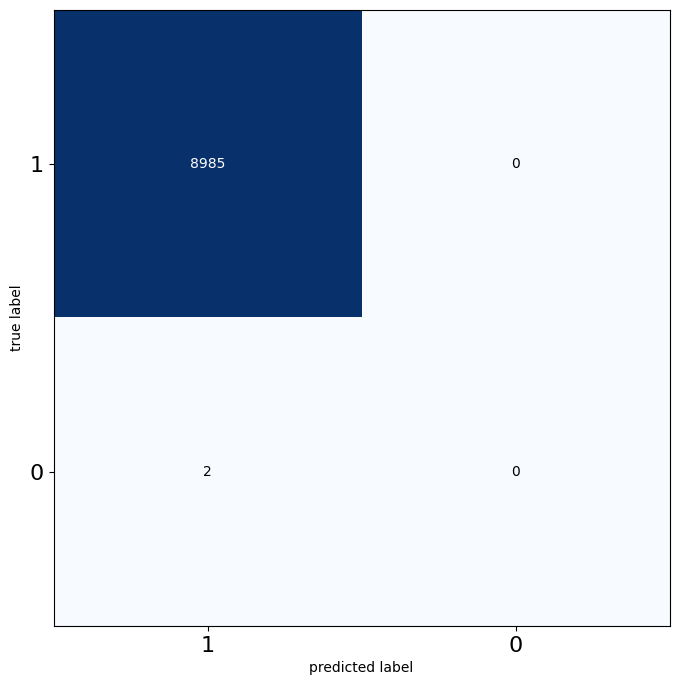

Clothing-Retail
accuracy: 0.9876488260821186 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

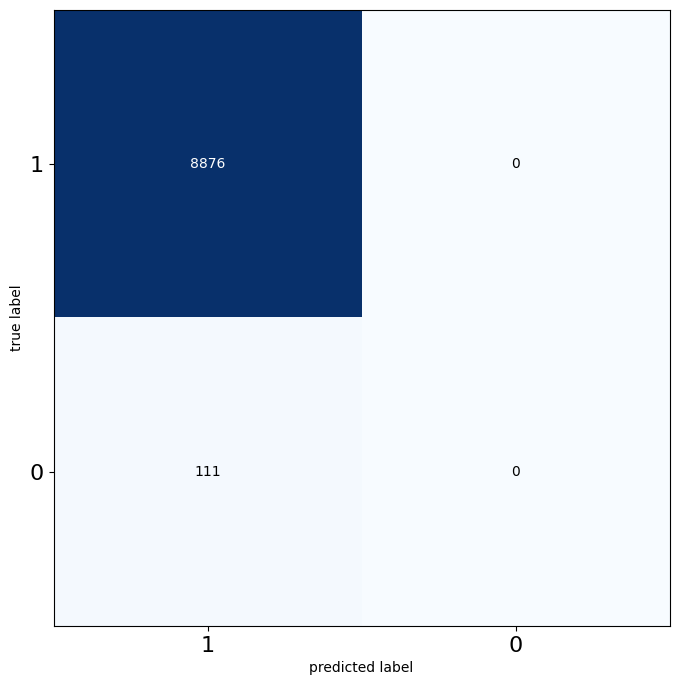

Clubs
accuracy: 0.9947702236563926 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

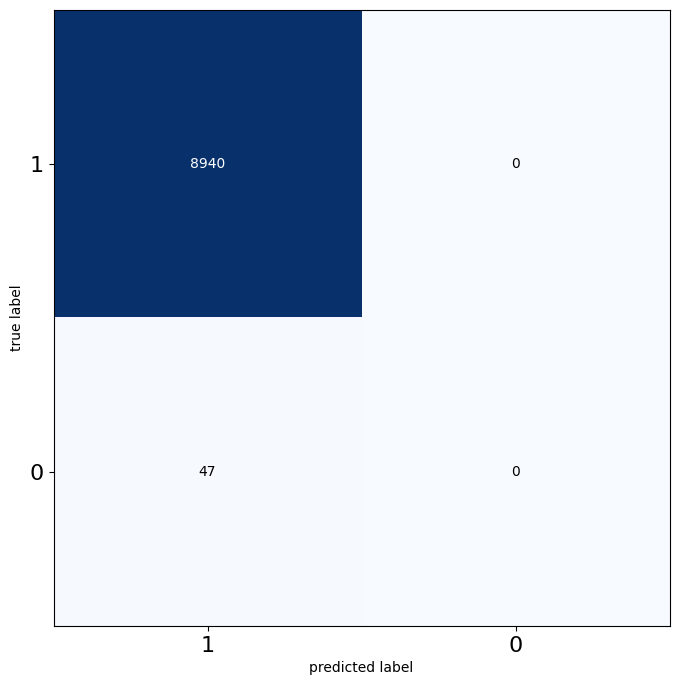

Co-operatives
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

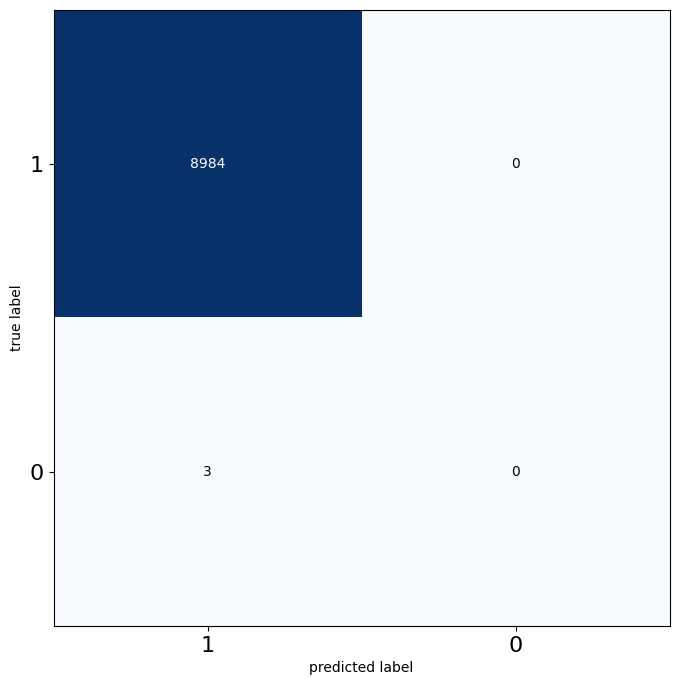

Coffee Dealers
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

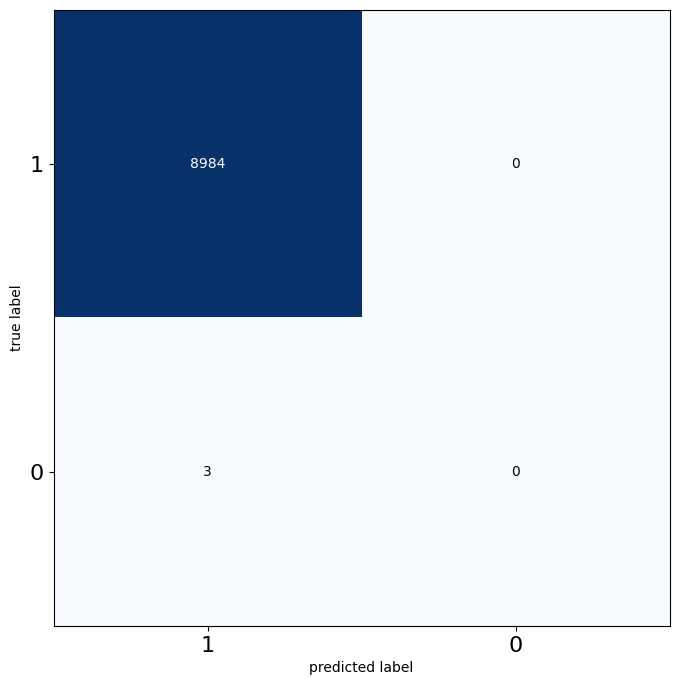

Coffee Machinery & Equipment Supplies
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

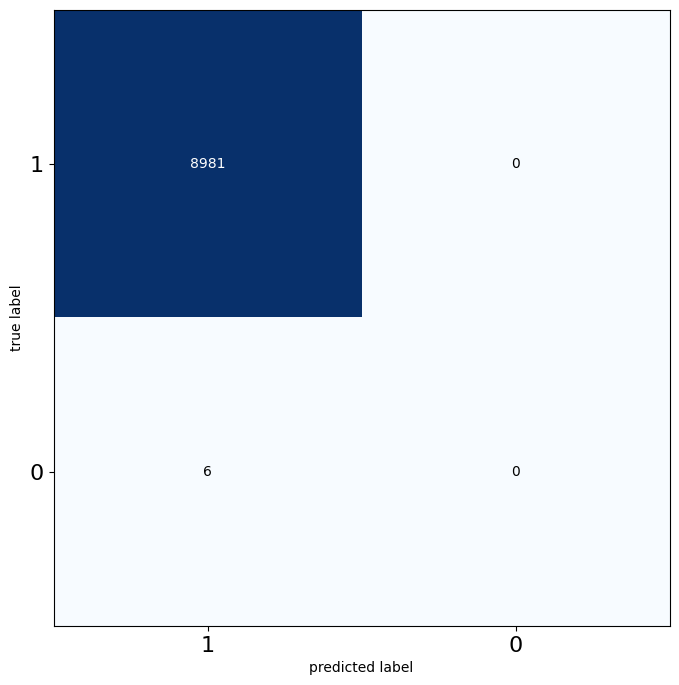

Cold Storage Companies
accuracy: 0.9949927673305886 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

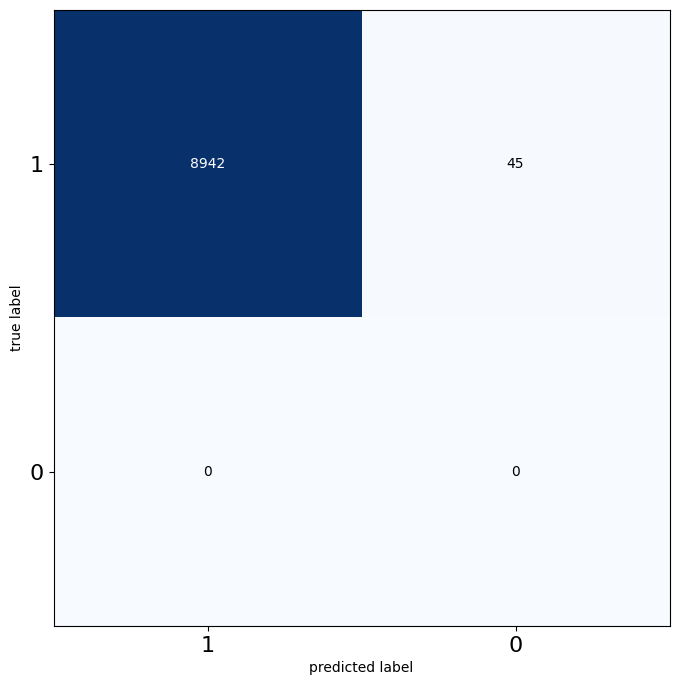

Collection Agencies
accuracy: 0.9964393012128631 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

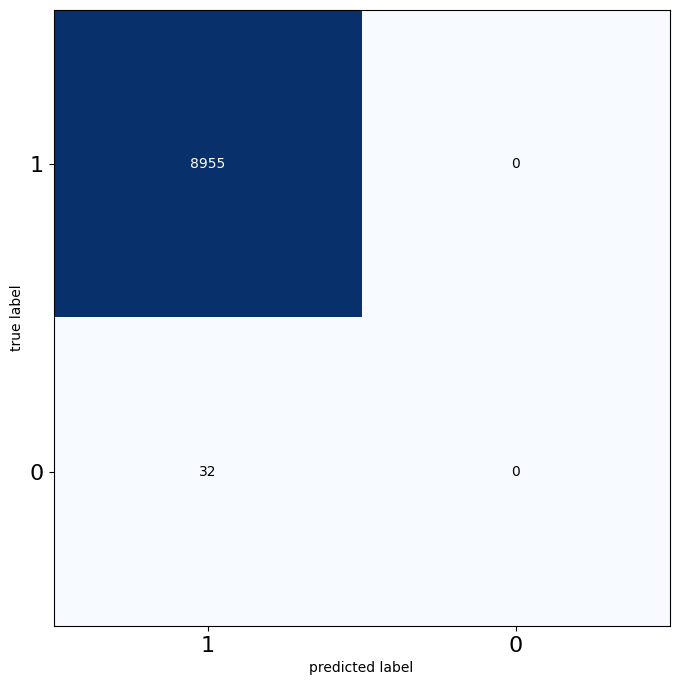

Colleges - Aviation
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

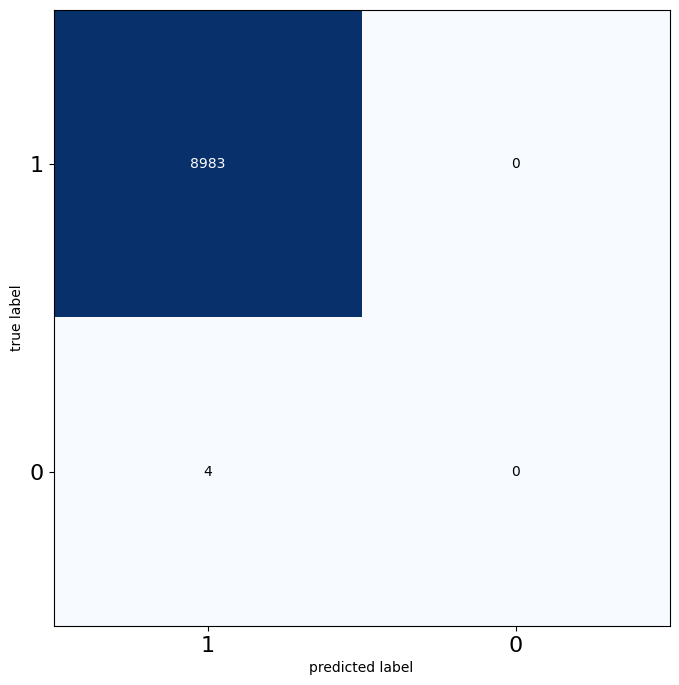

Colleges - Banking
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

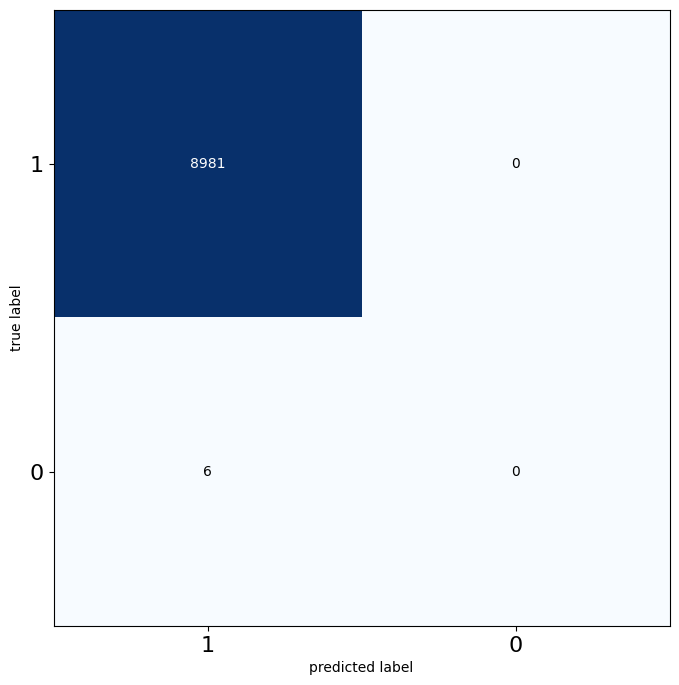

Commission Agents
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

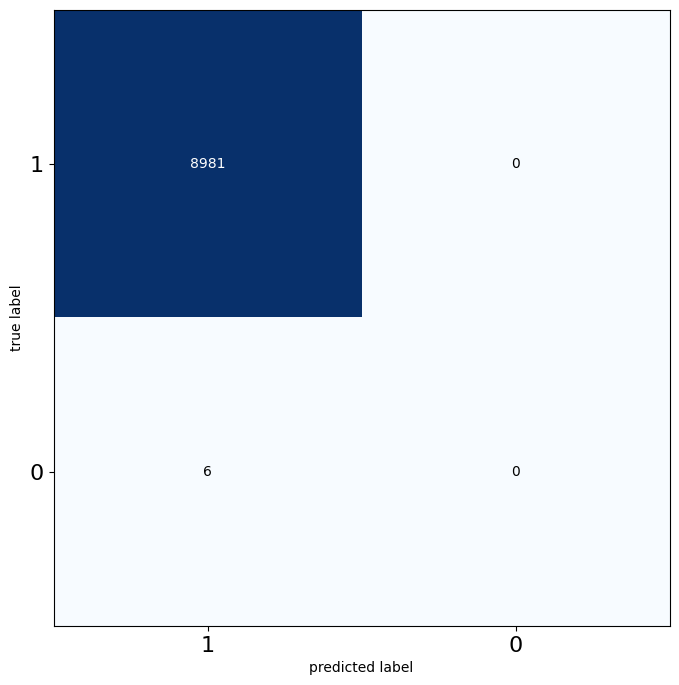

Commodity Brokers
accuracy: 0.9952153110047847 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

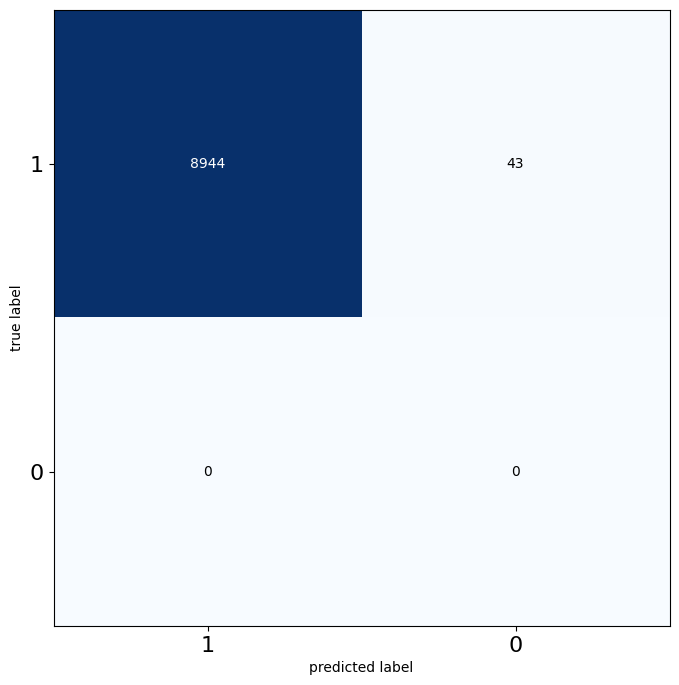

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Communication Equipment
accuracy: 0.9949927673305886 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

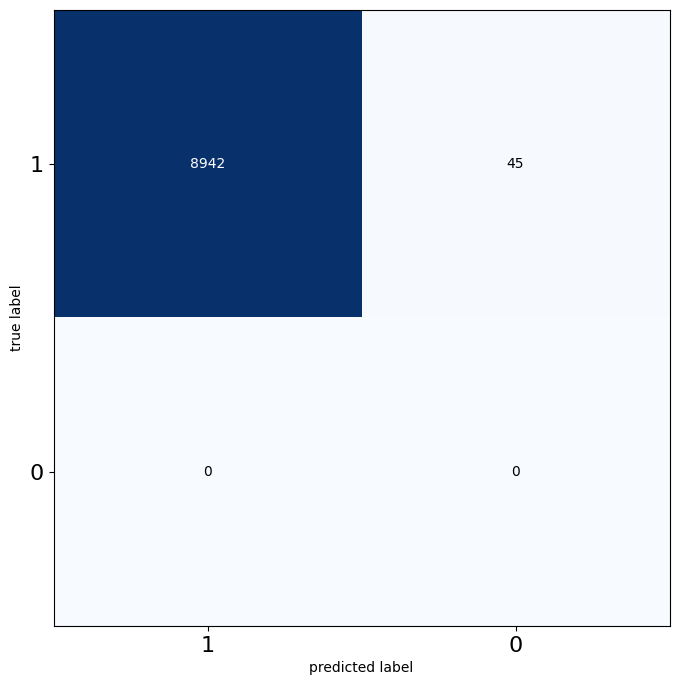

Communications
accuracy: 0.9947702236563926 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

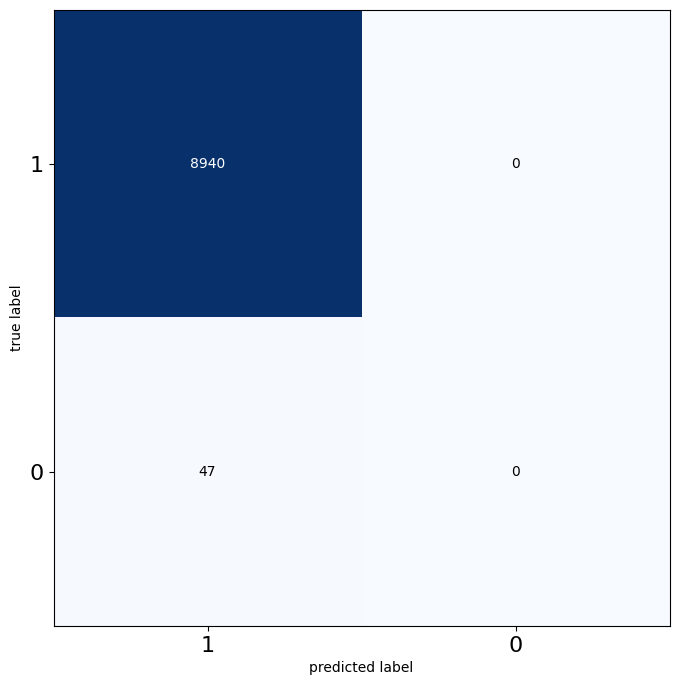

Company Secretaries
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

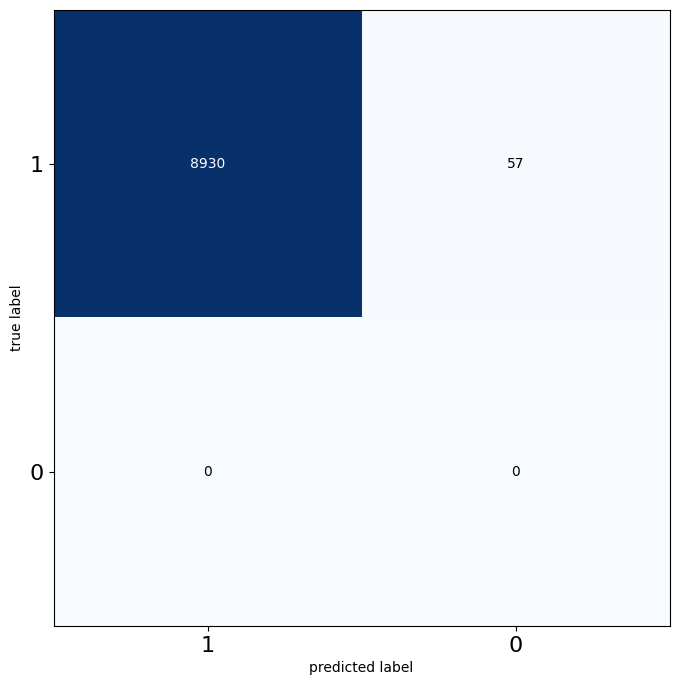

Compressors-Air & Gas
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

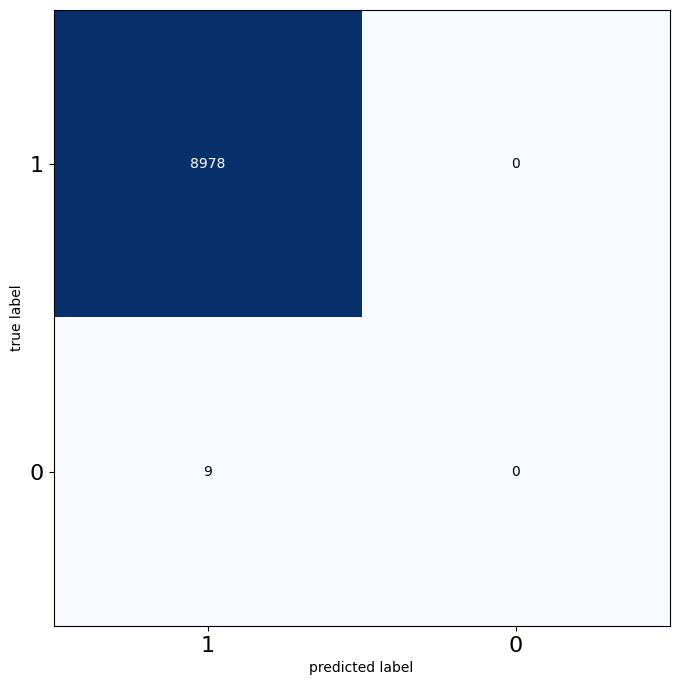

Computer Aided Design
accuracy: 0.9983309224435295 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

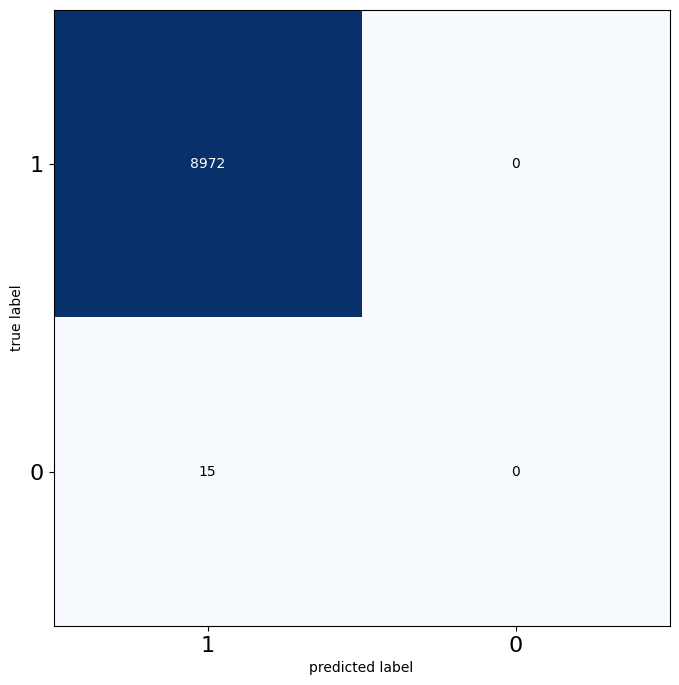

Computer Consultants
accuracy: 0.9806387003449427 precision: 0.075 recall: 0.125 f1: 0.09374999999999999


<Figure size 640x480 with 0 Axes>

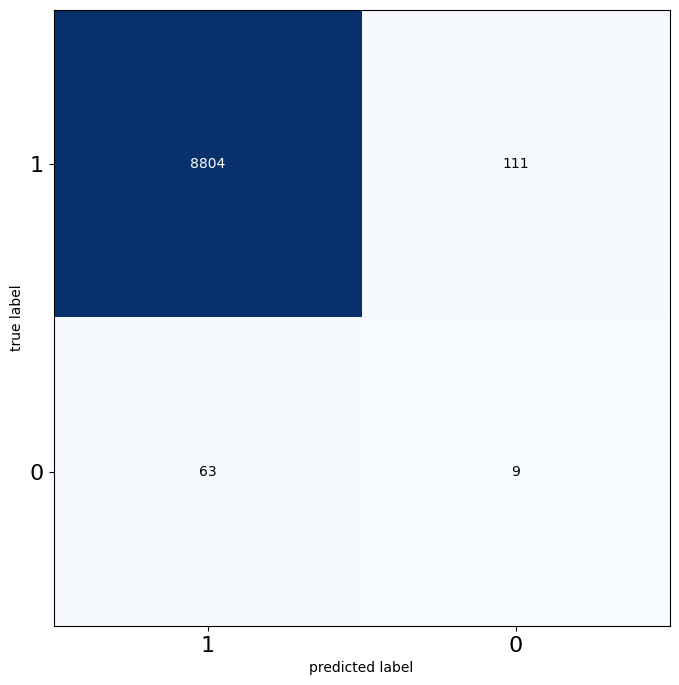

Computers - Cabling & Networking
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

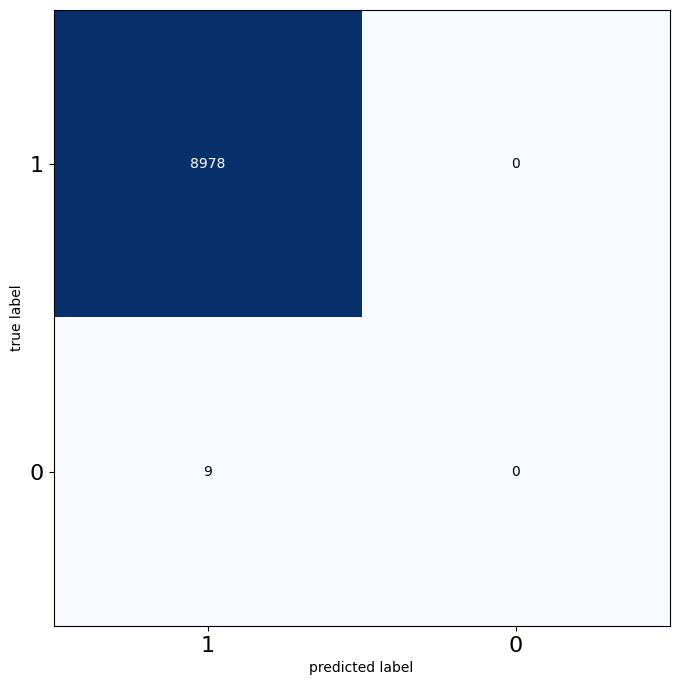

Computers - Hardware & Maintenance
accuracy: 0.9801936129965506 precision: 0.00819672131147541 recall: 0.017241379310344827 f1: 0.011111111111111112


<Figure size 640x480 with 0 Axes>

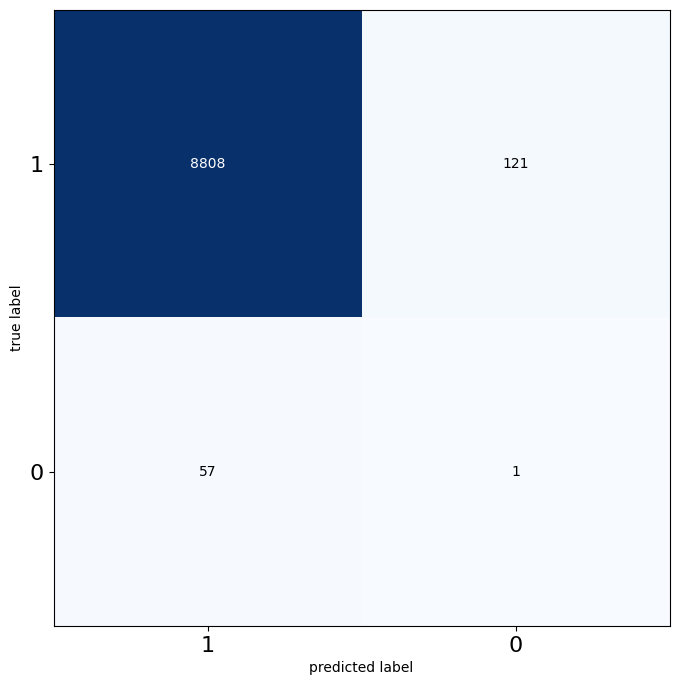

Computers - Software & Services
accuracy: 0.058862801824858126 precision: 0.058862801824858126 recall: 1.0 f1: 0.11118116855821775


<Figure size 640x480 with 0 Axes>

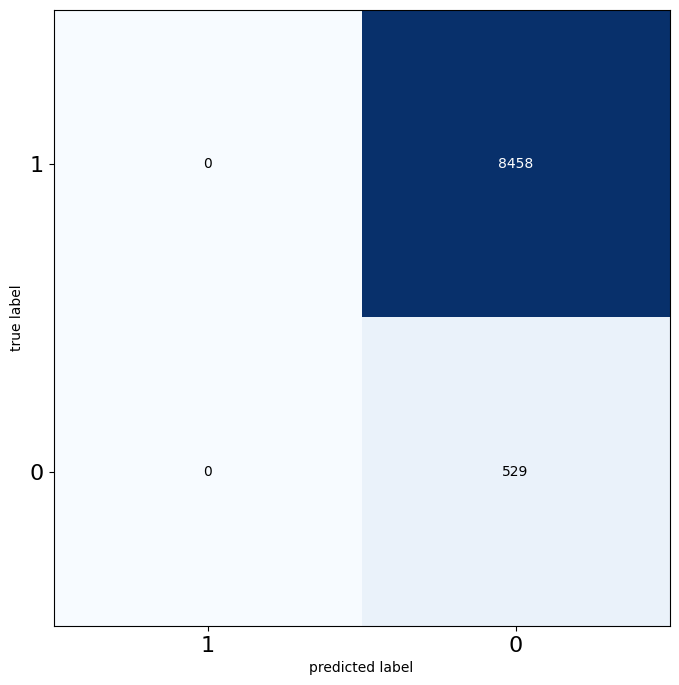

Computers - Training
accuracy: 0.98531211750306 precision: 0.009433962264150943 recall: 0.03571428571428571 f1: 0.014925373134328358


<Figure size 640x480 with 0 Axes>

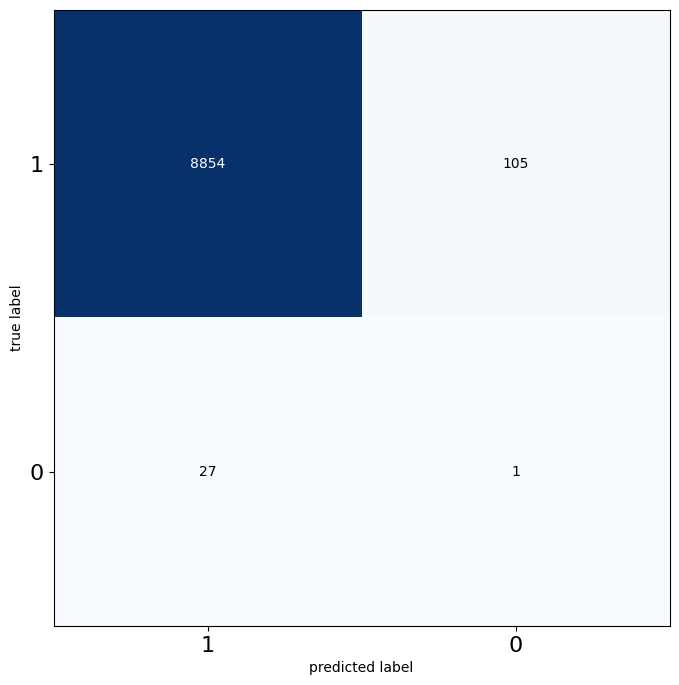

Concrete Products
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

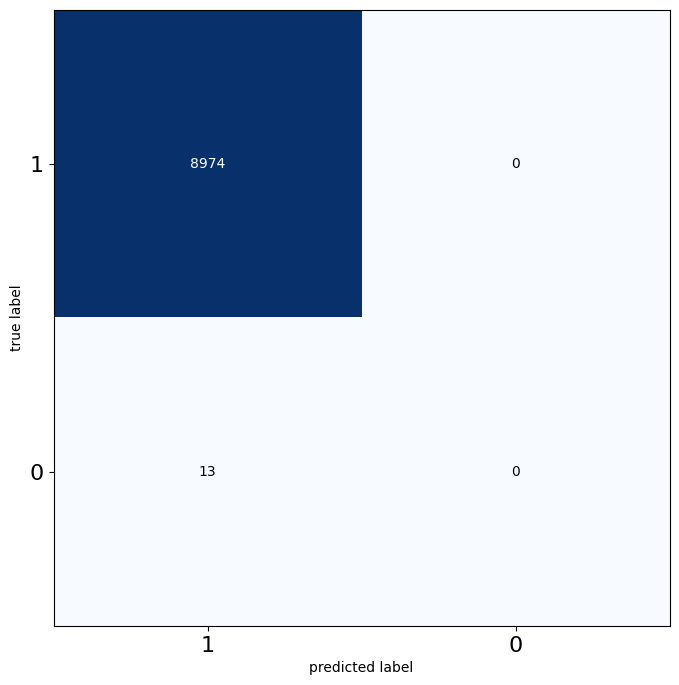

Conference Facilities & Organisers
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

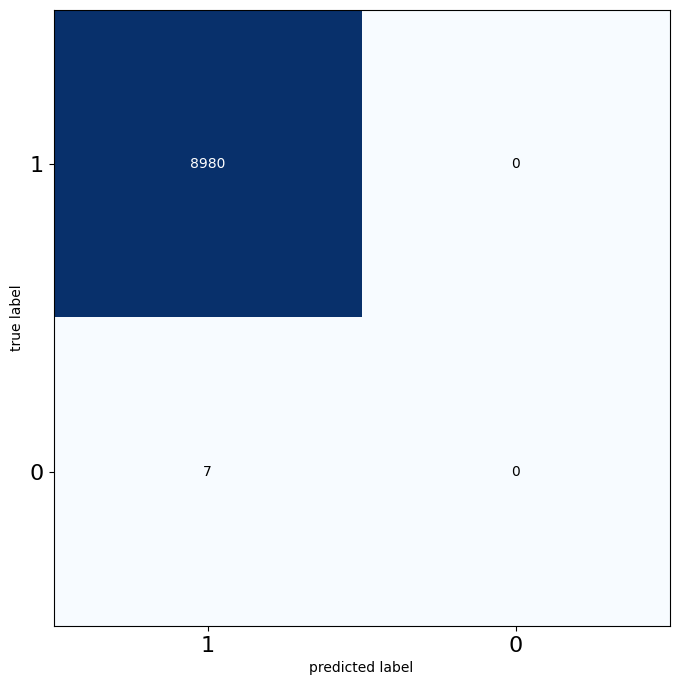

Construction Equipment
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

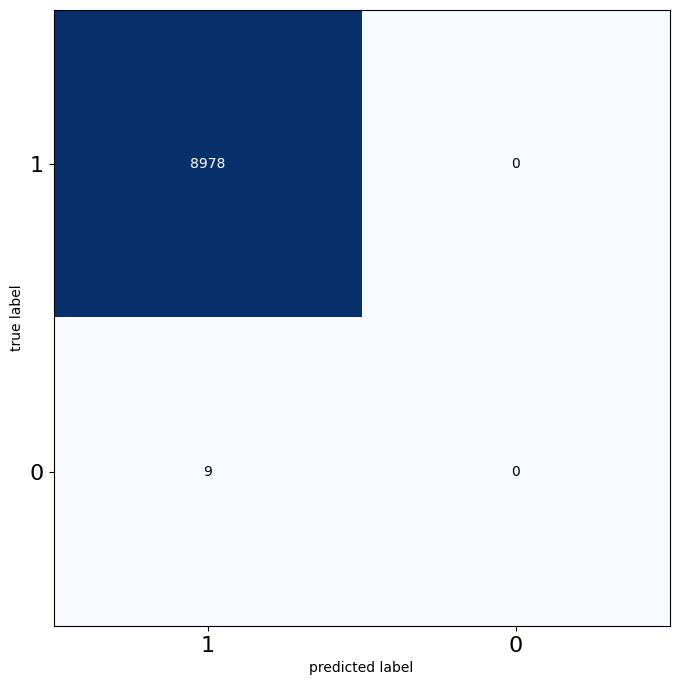

Construction Management
accuracy: 0.04361856014242795 precision: 0.04361856014242795 recall: 1.0 f1: 0.08359100117283293


<Figure size 640x480 with 0 Axes>

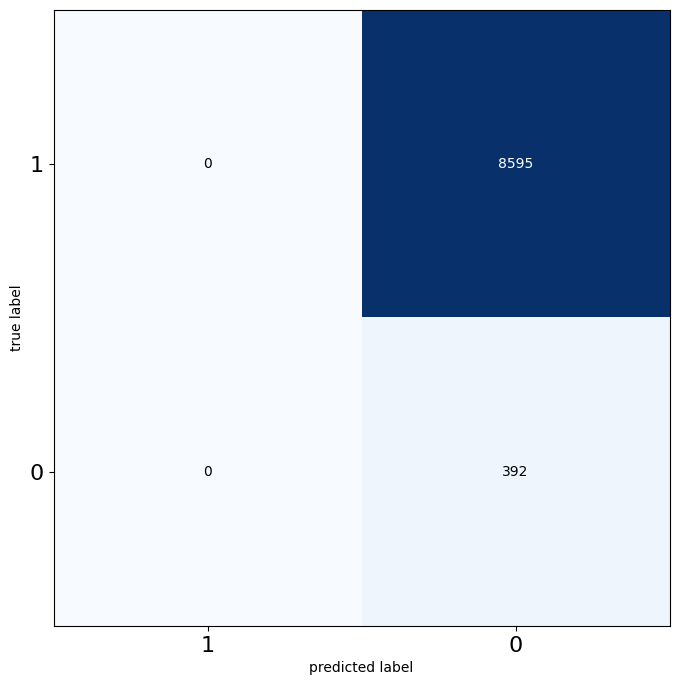

Consultants
accuracy: 0.9981083787693334 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

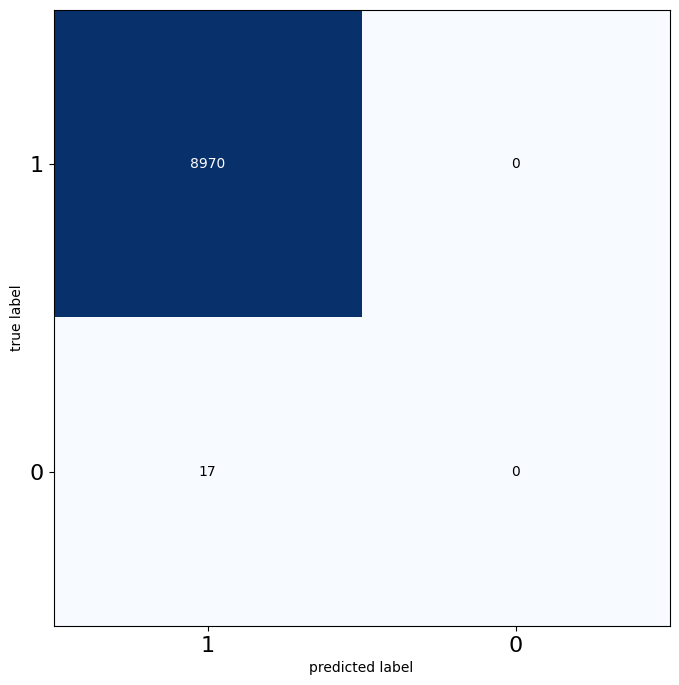

Consultants - Education & Career
accuracy: 0.9968843885612552 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

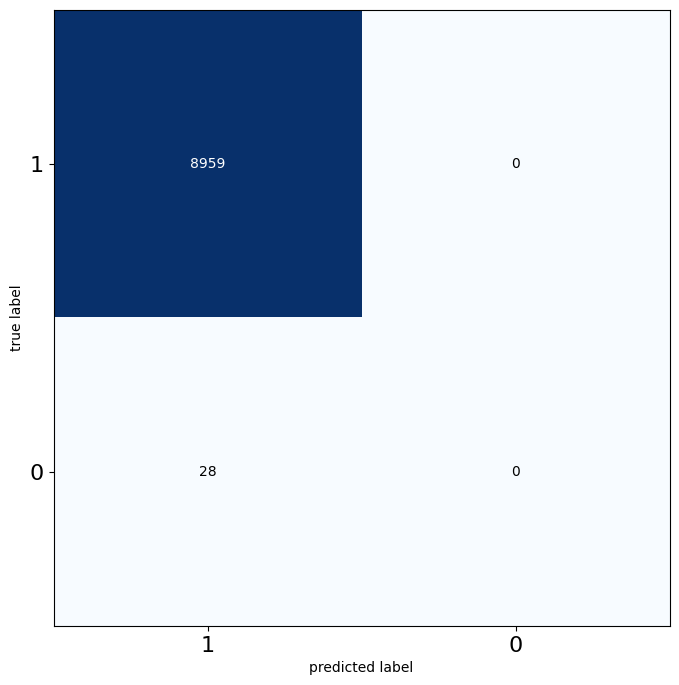

Consumer Products
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

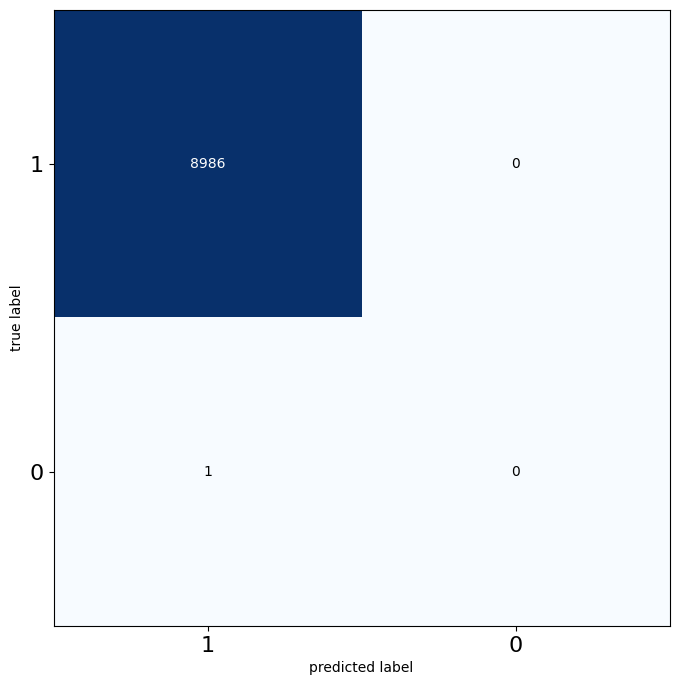

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Containerized Freight Service
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

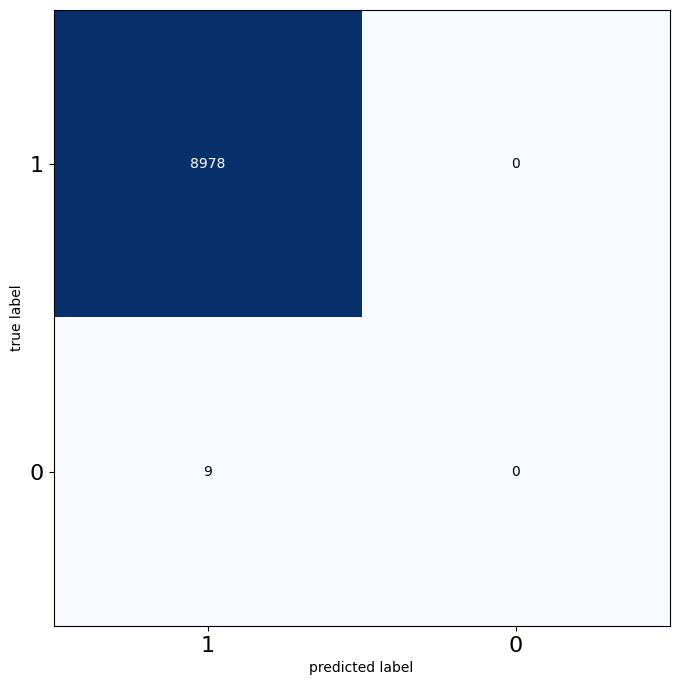

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Contractors-Engineering
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

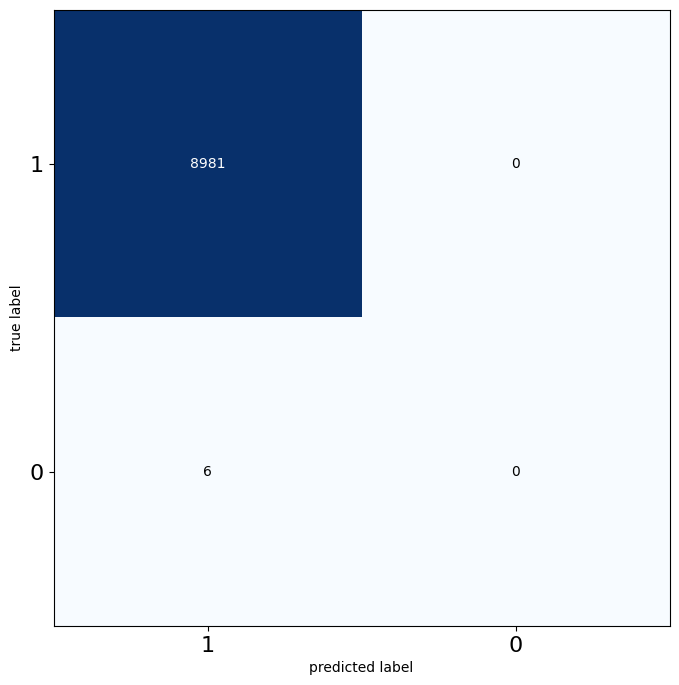

Contractors-Engineering, General
accuracy: 0.9982196506064315 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

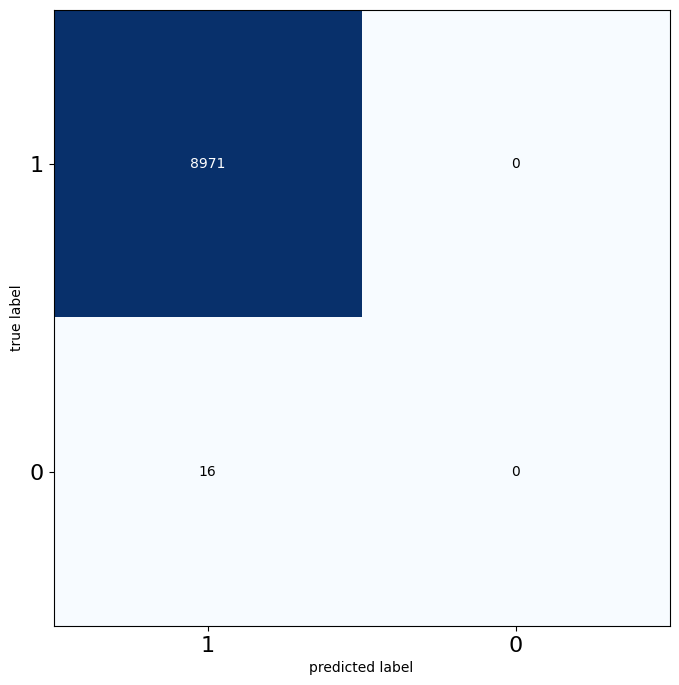

Contractors-Equipment & Supplies
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

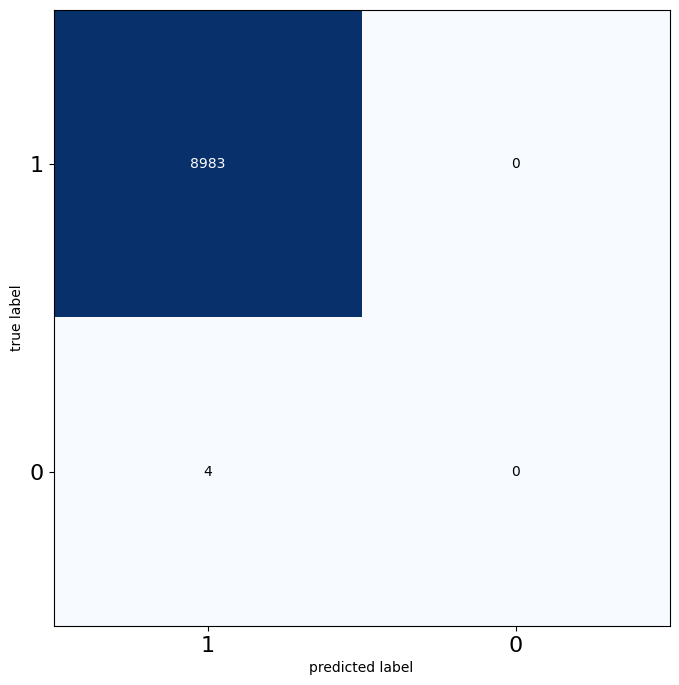

Controls, Control Systems & Regulators
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

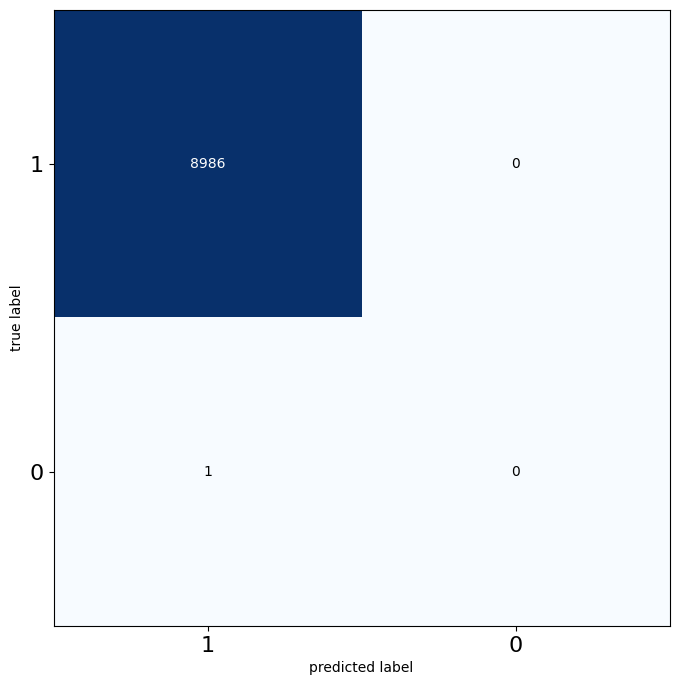

Cookers & Stoves
accuracy: 0.9905418938466674 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

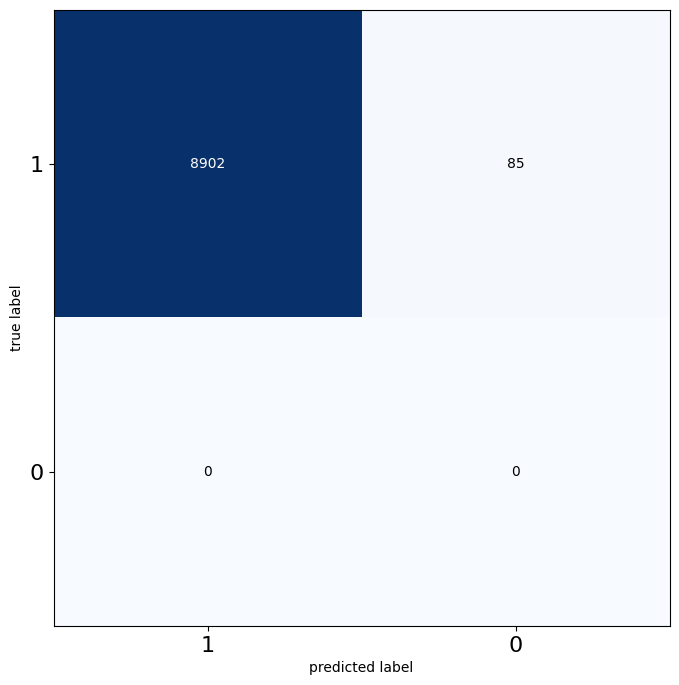

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cosmetics & Perfumes
accuracy: 0.996216757538667 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

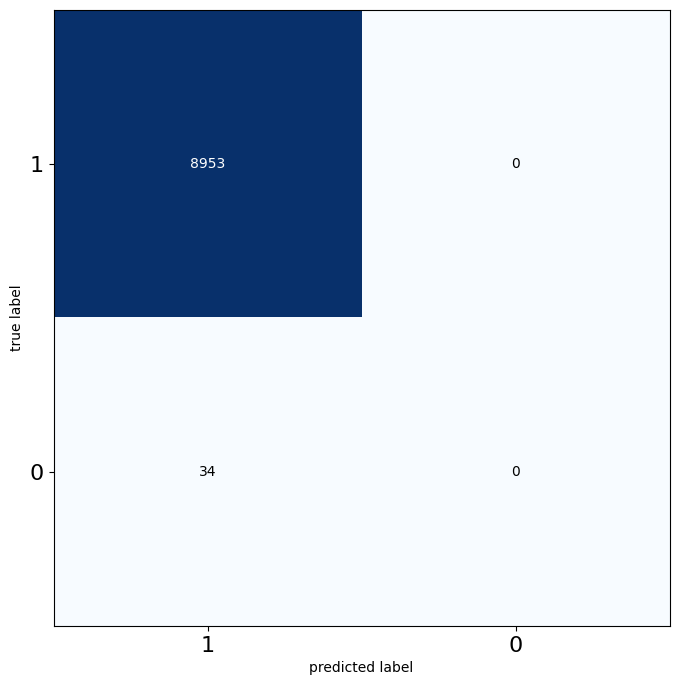

Costumes
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

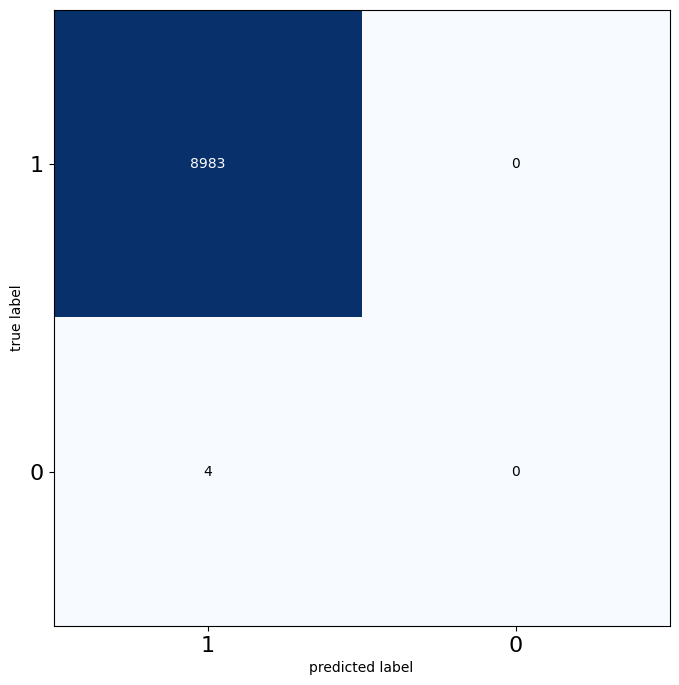

Counselling Service
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

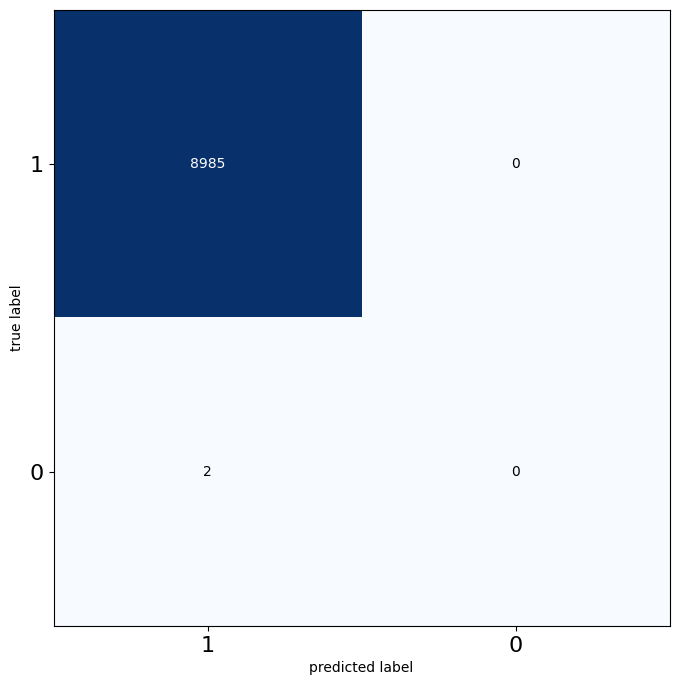

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Courier Service
accuracy: 0.99265605875153 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

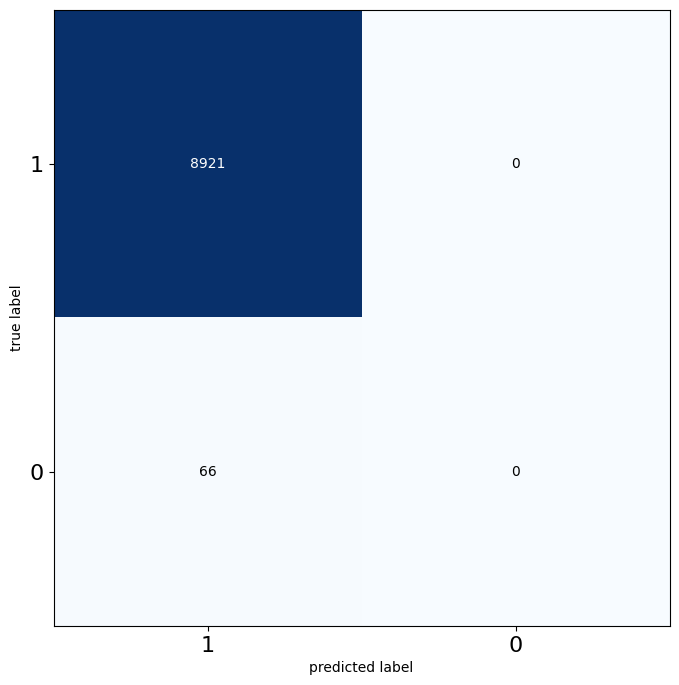

Cultural Organizations
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

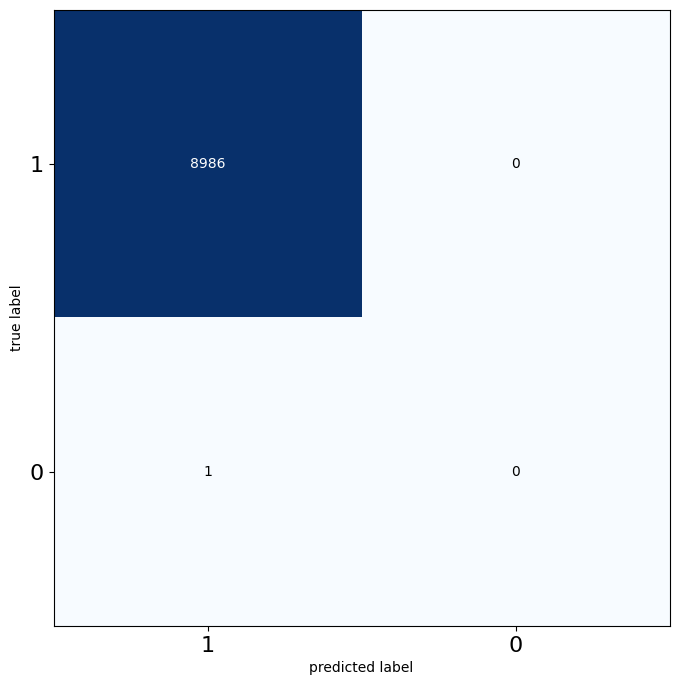

Curios
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

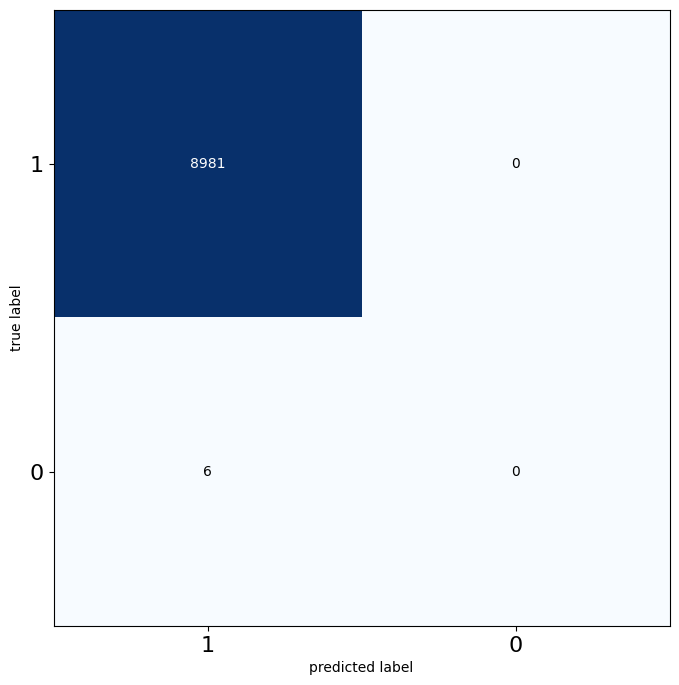

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cyber Cafes
accuracy: 0.9986647379548237 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

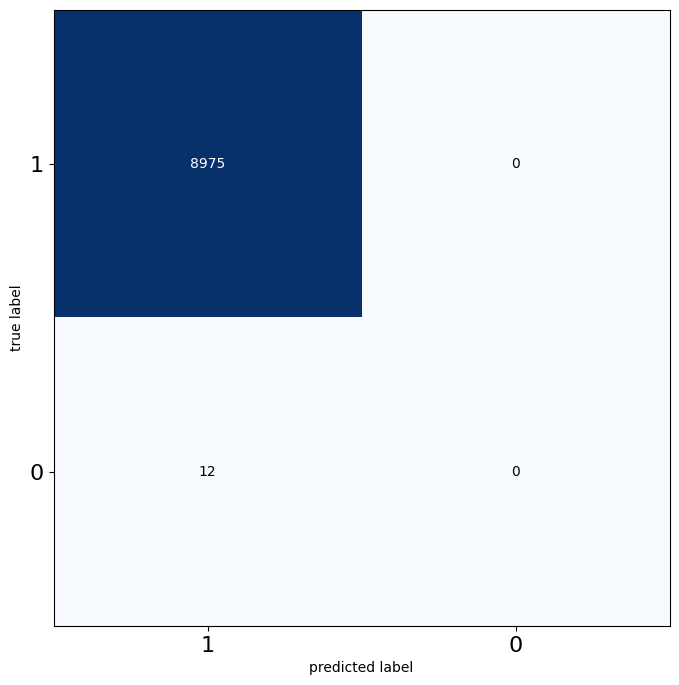

Dairy Products
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

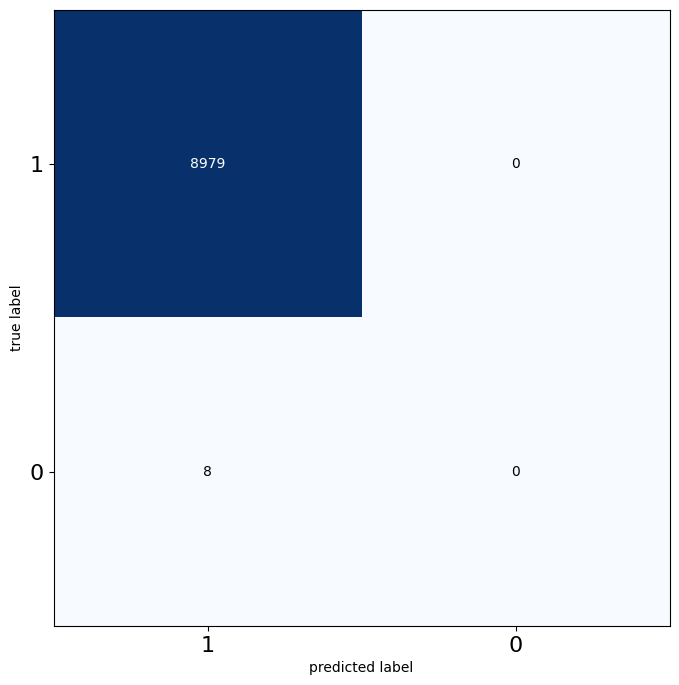

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dancing Instruction
accuracy: 0.9987760097919217 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

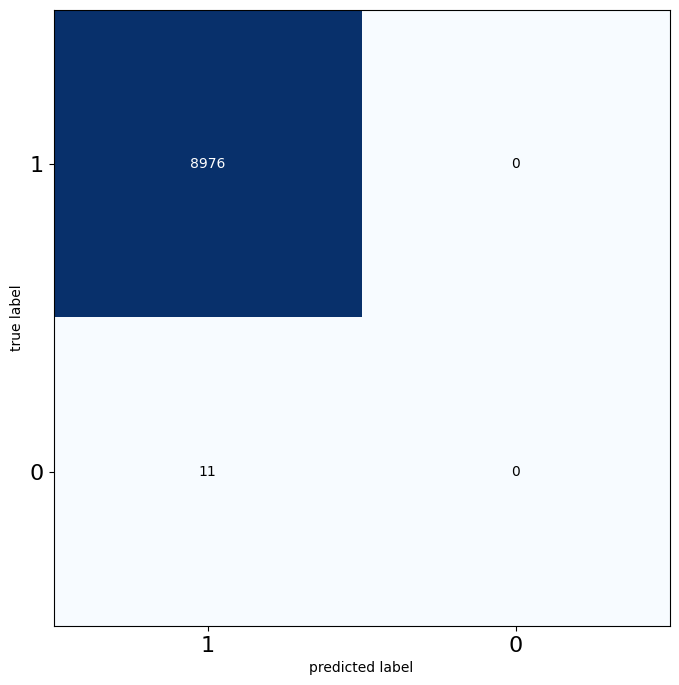

Data Communication Equipment
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

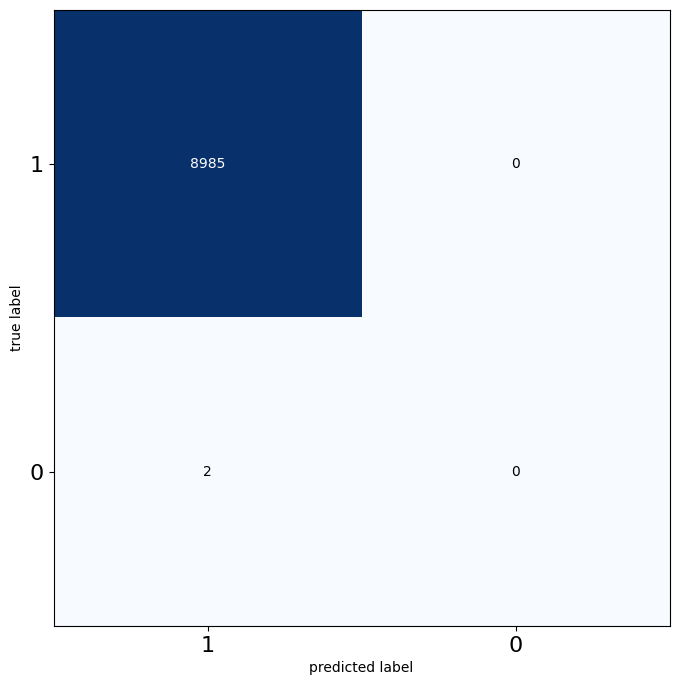

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Data Network Services
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

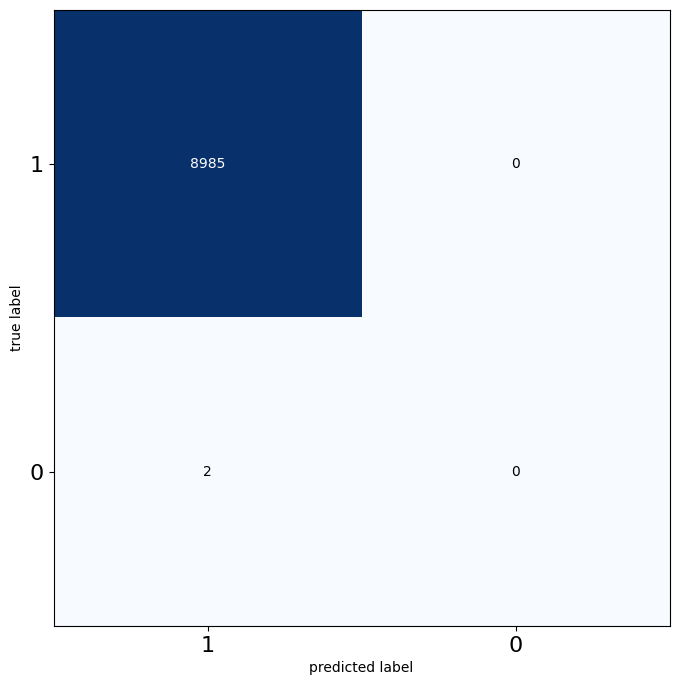

Data Processing Services & Supplies
accuracy: 0.9949927673305886 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

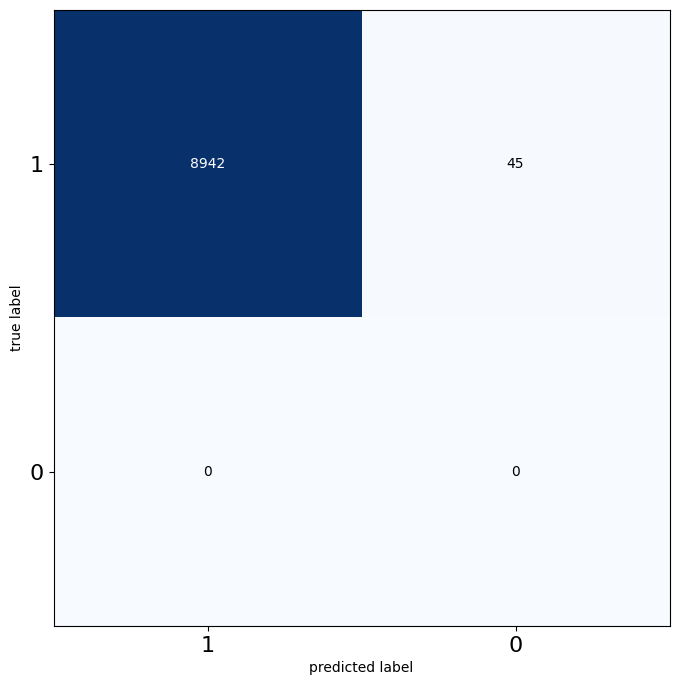

Data Recovery
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

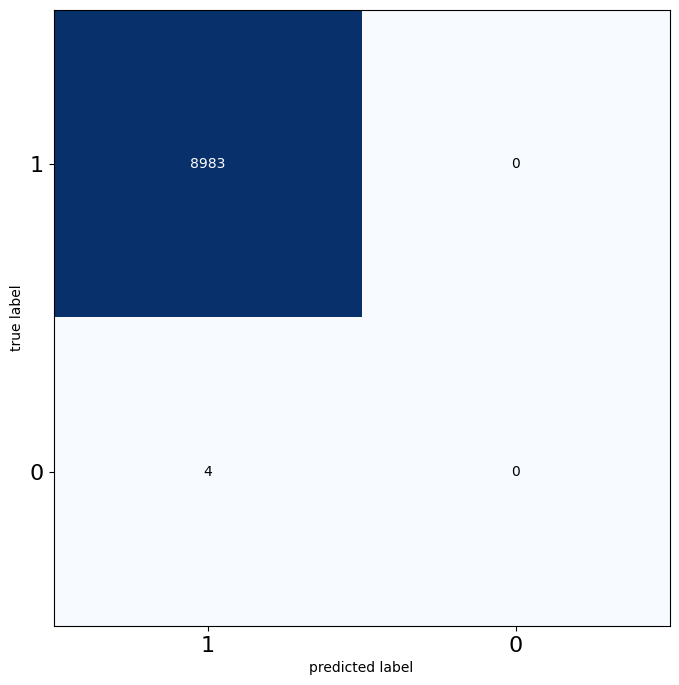

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Debt Collection Agencies
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

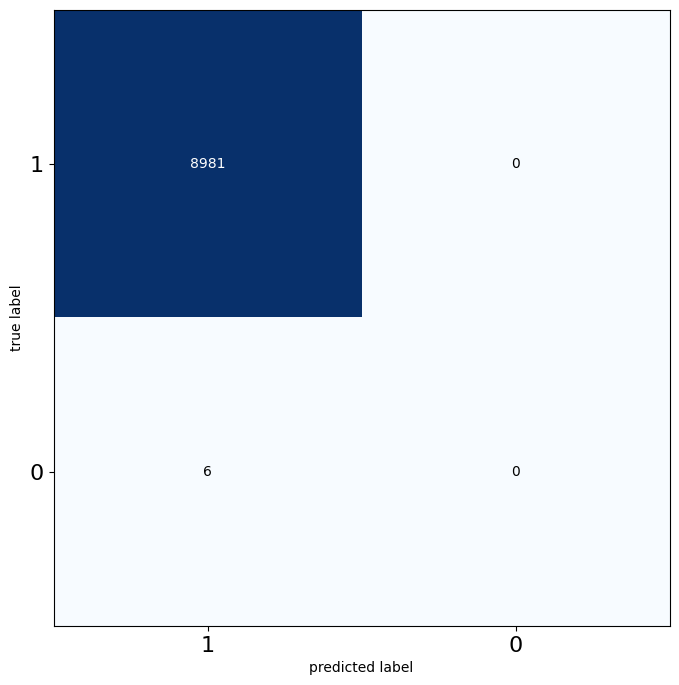

Dental Practitioners
accuracy: 0.9969956603983532 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

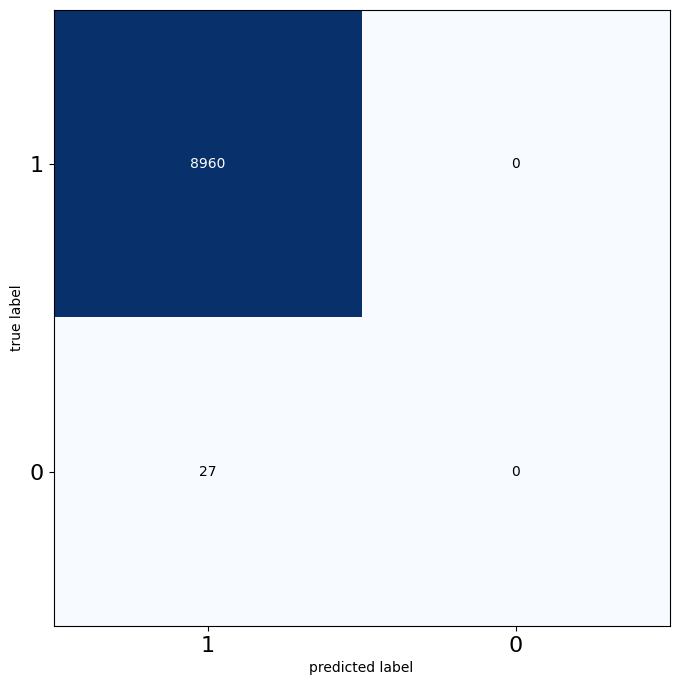

Designers - Clothing
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

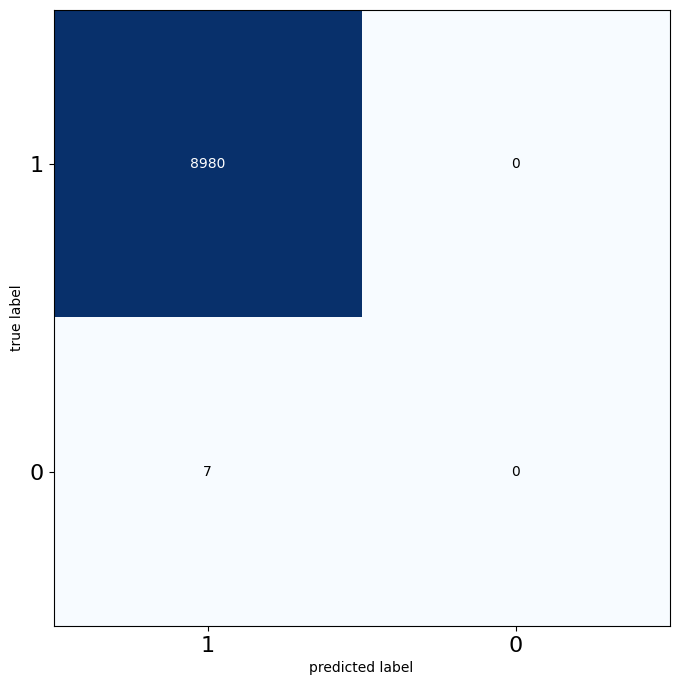

Development Organizations
accuracy: 0.9982196506064315 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

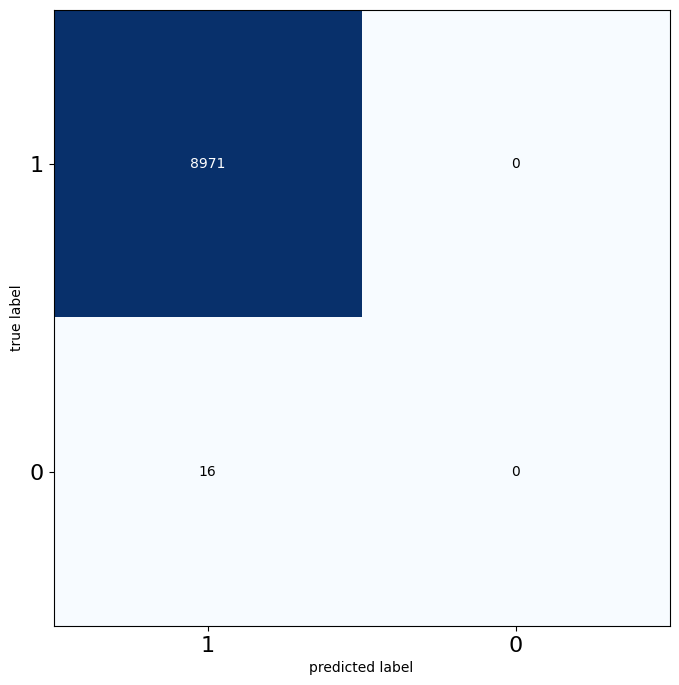

Diesel Engines,Parts & Services
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

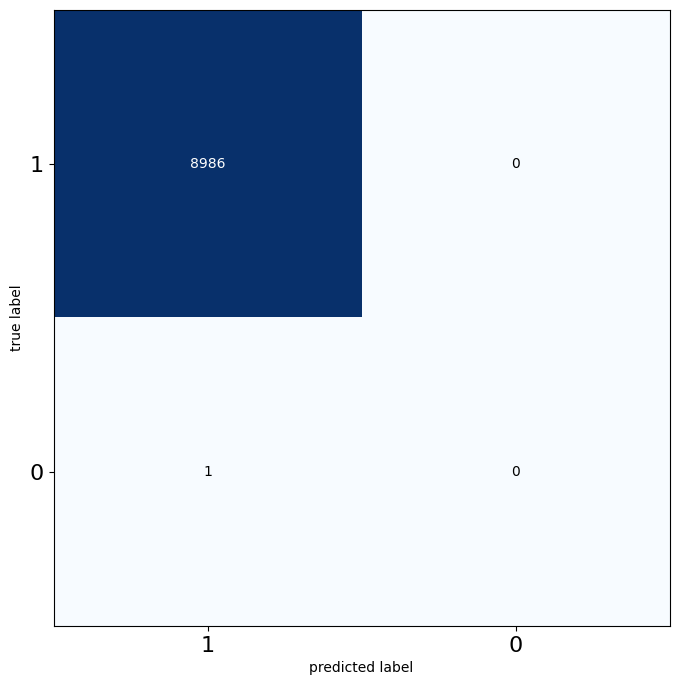

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Discotheques
accuracy: 0.9942138644709024 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

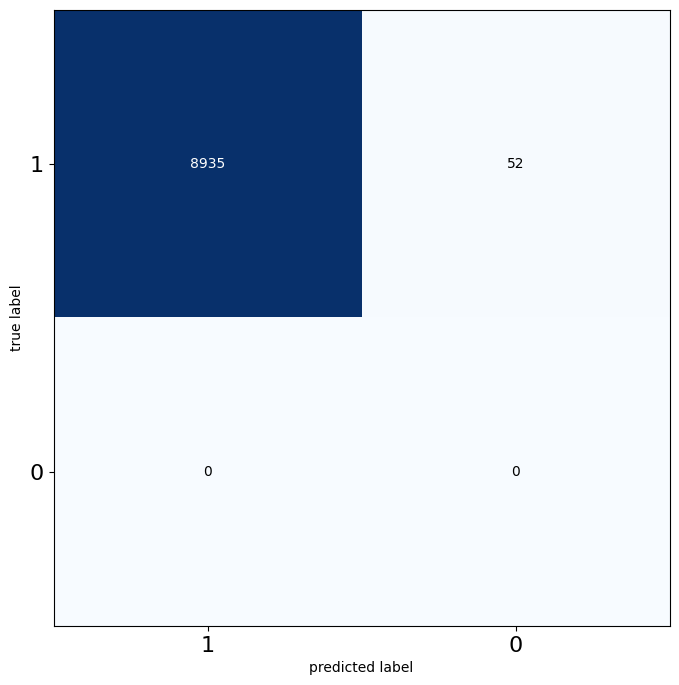

Disinfectants
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

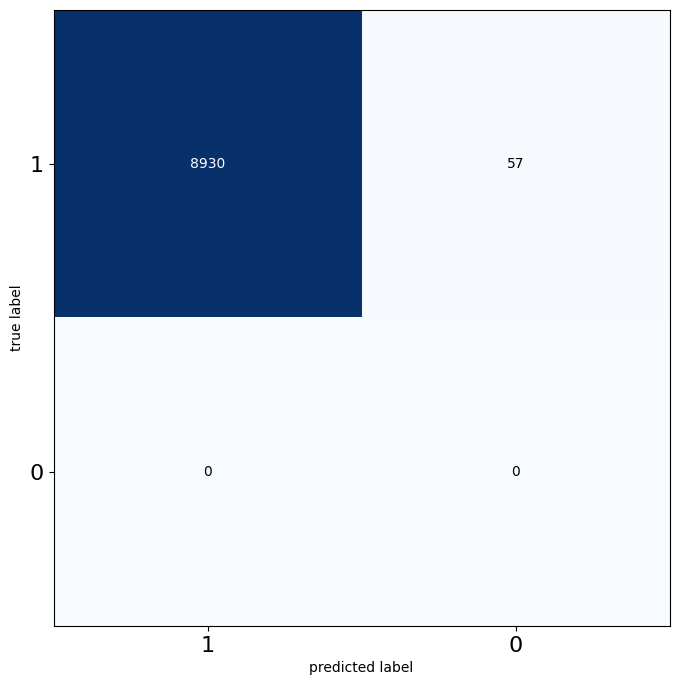

Distillers
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

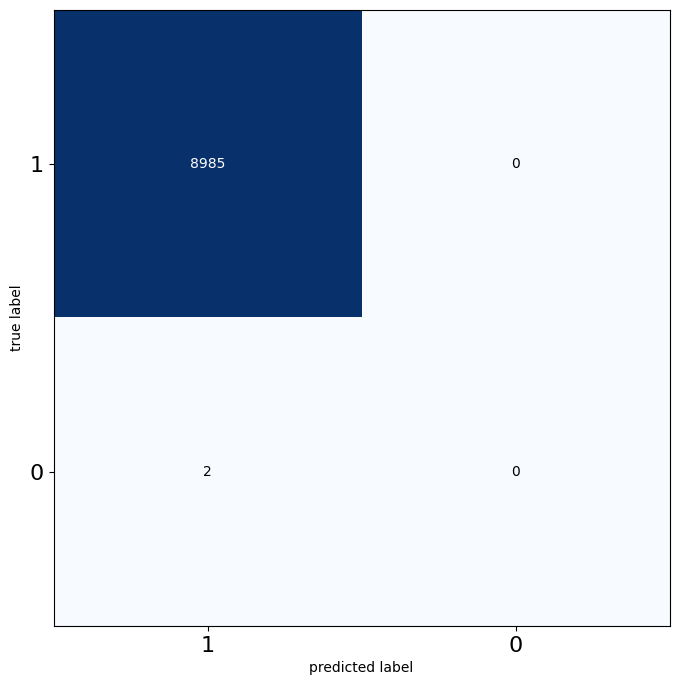

Distributors & Stockists
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

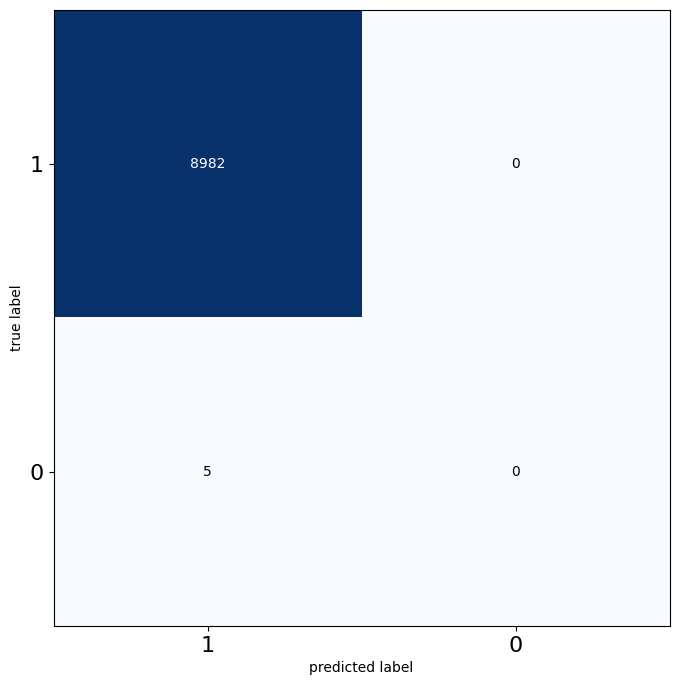

Doctors
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

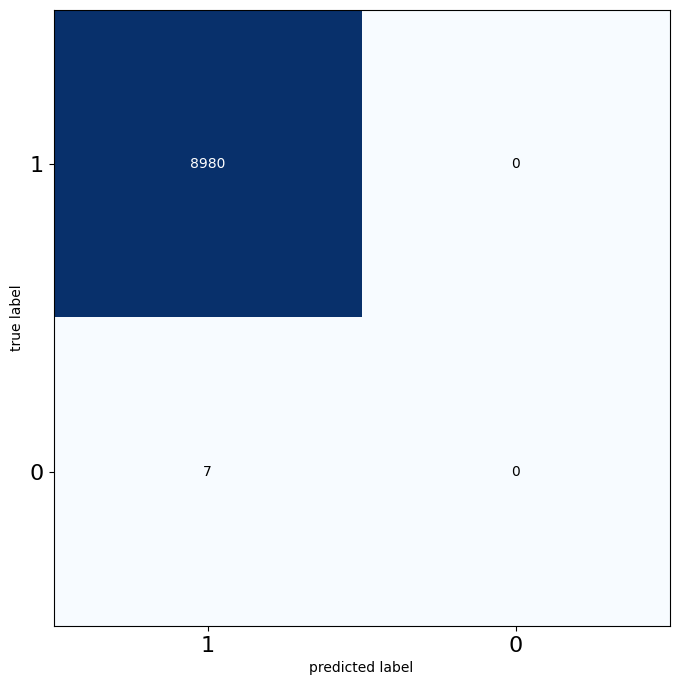

Document Storage & Management
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

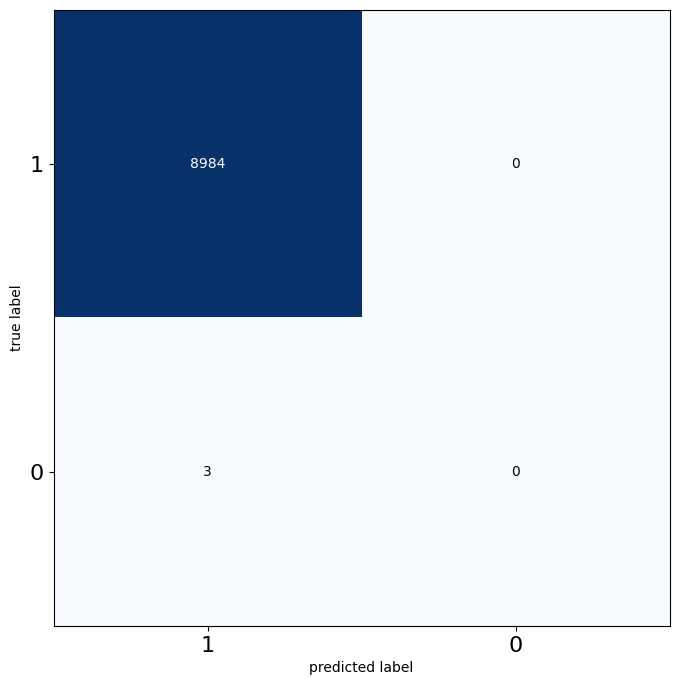

Dog Kennels
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

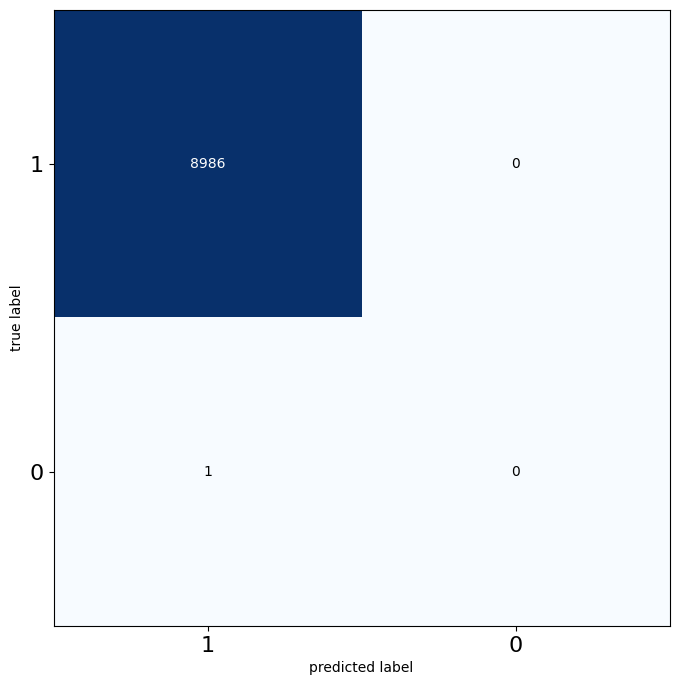

Domestic Help Agencies
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

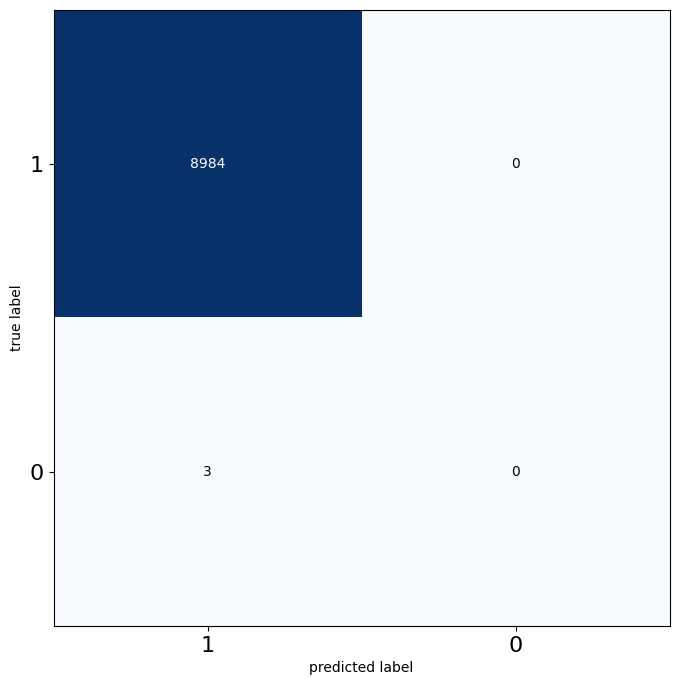

Doors
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

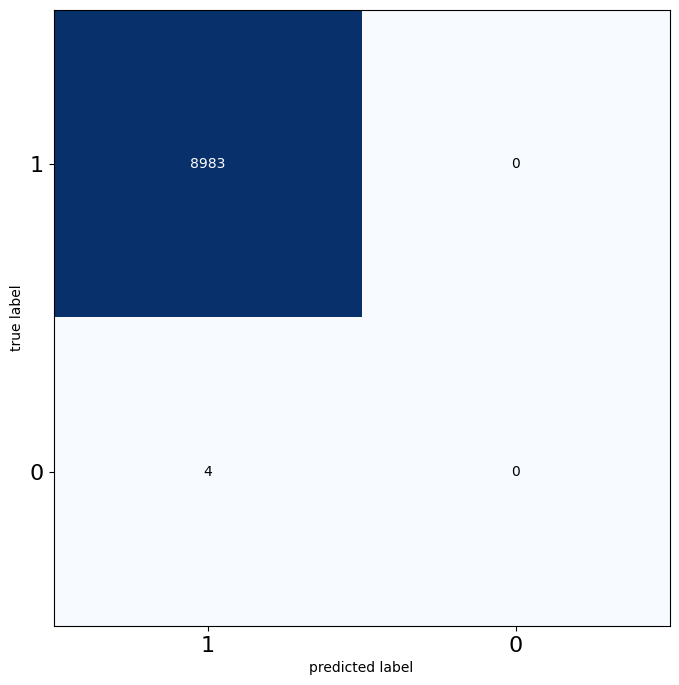

Draperies & Curtains
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

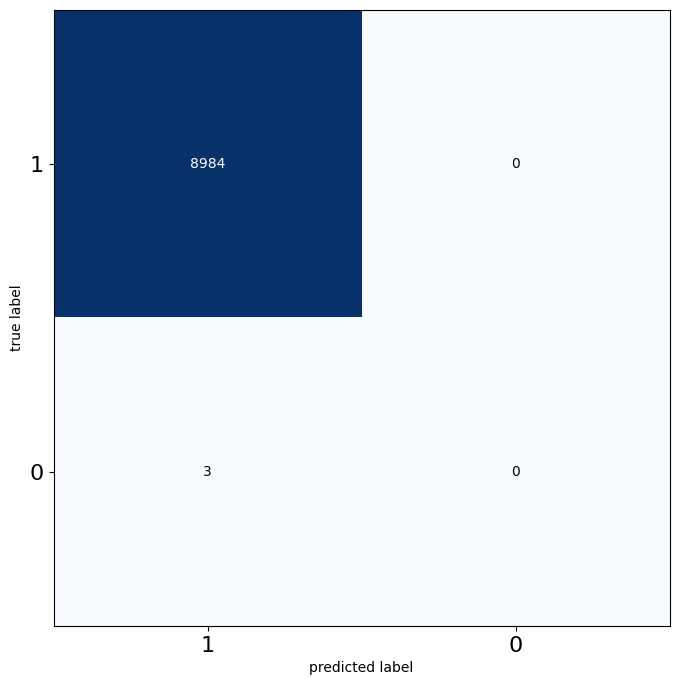

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dressmakers
accuracy: 0.9987760097919217 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

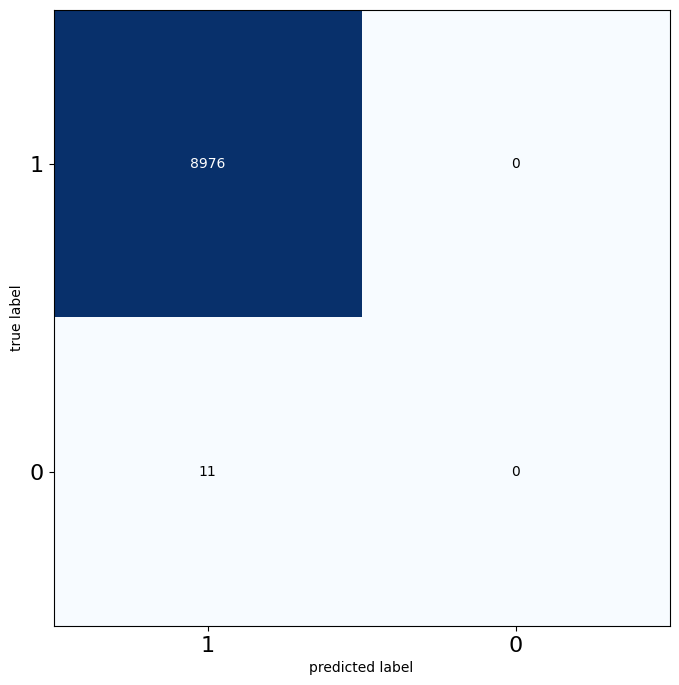

Drilling Contractors
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

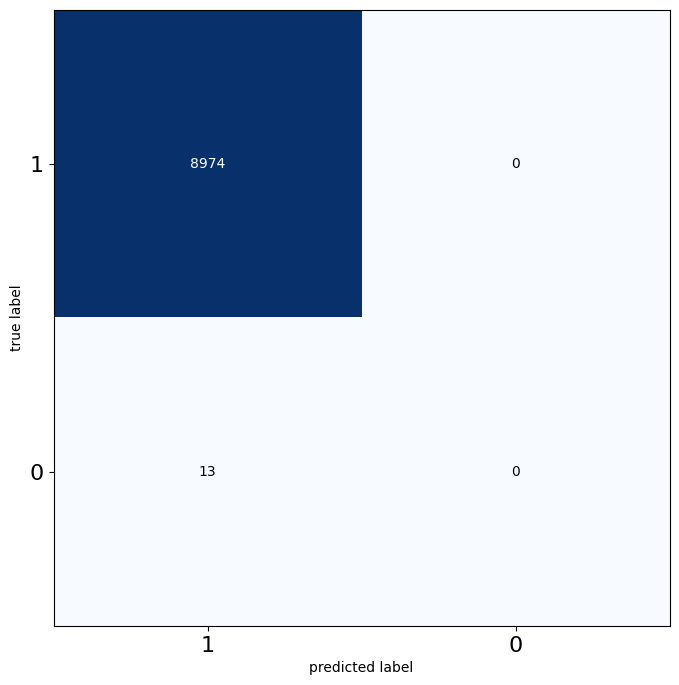

Driving Schools
accuracy: 0.996216757538667 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

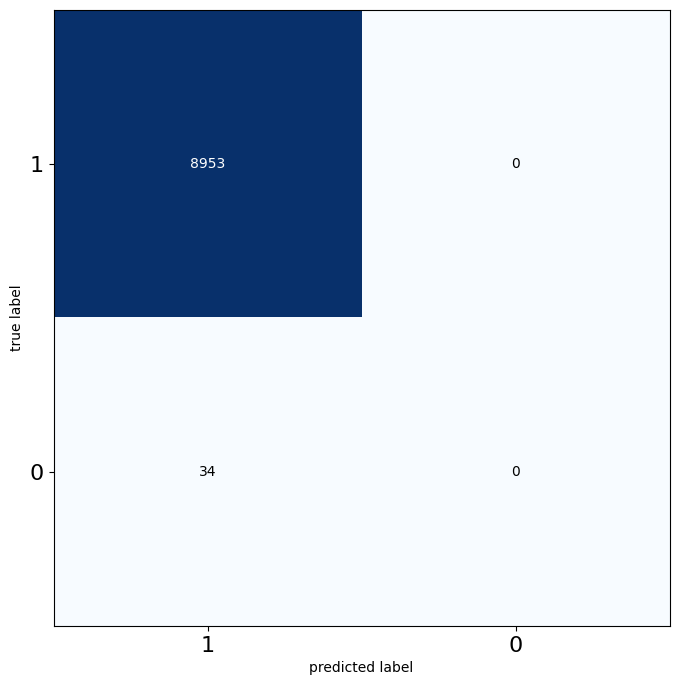

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Drug Abuse Control
accuracy: 0.9942138644709024 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

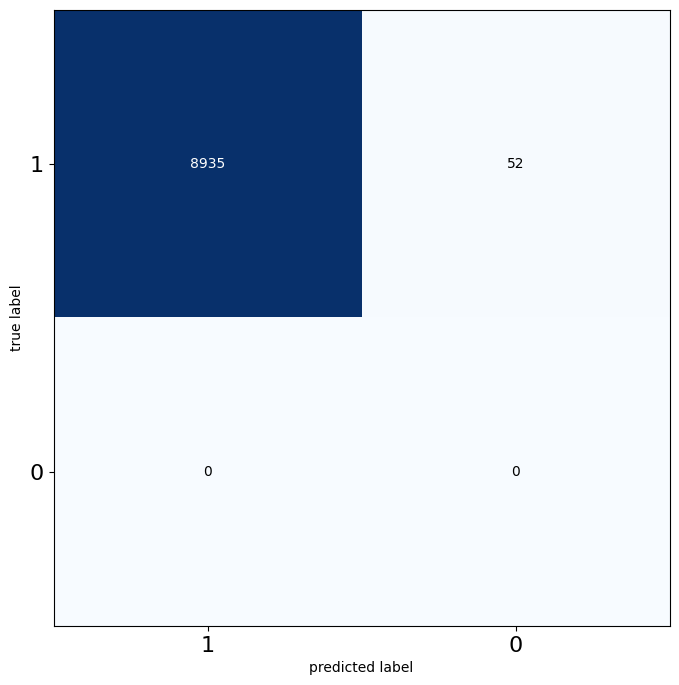

Dry Cleaners
accuracy: 0.996328029375765 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

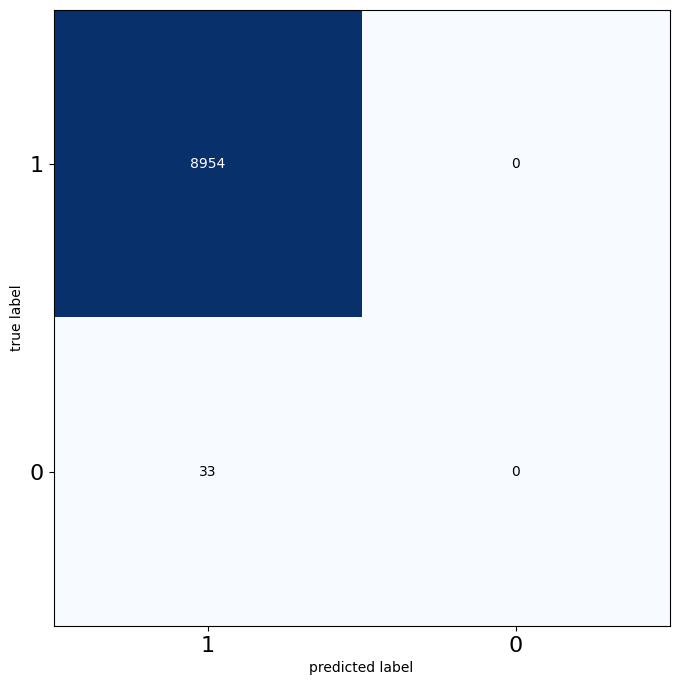

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


E-Mail Services
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

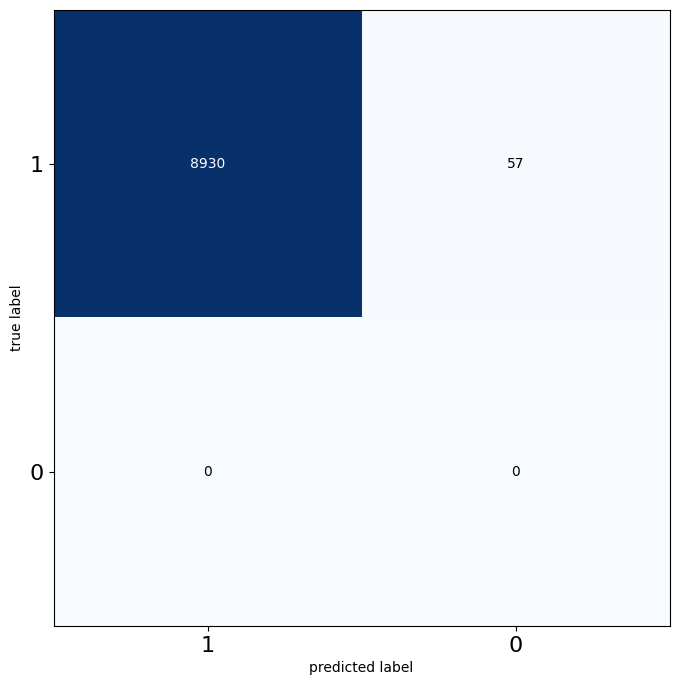

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Educational Supplies
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

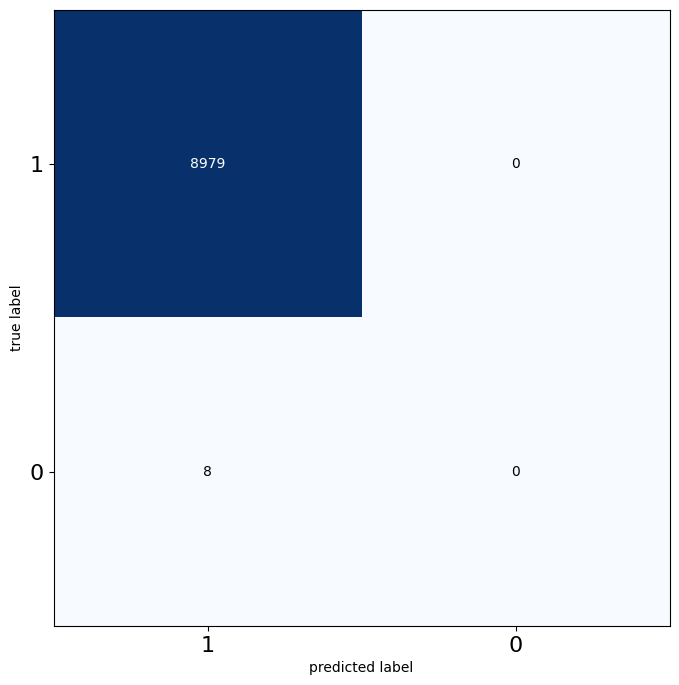

Electric Light & Power Companies
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

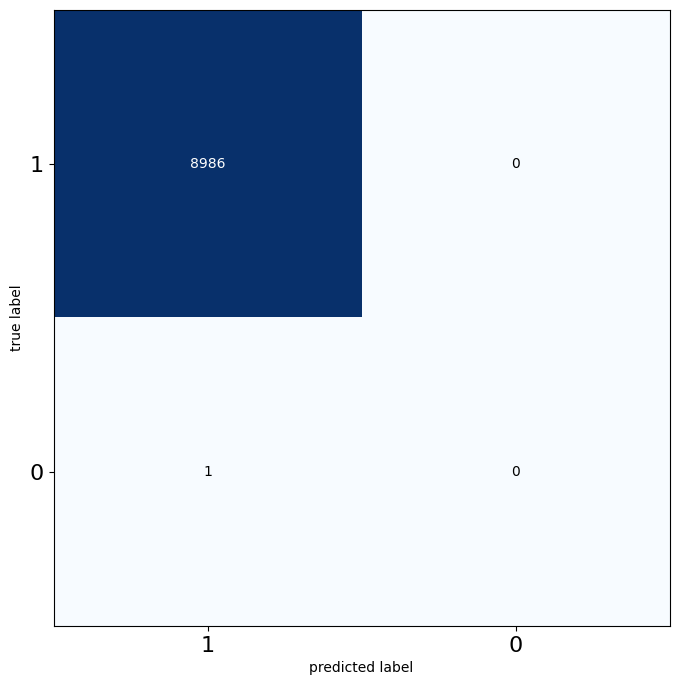

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Electric Pumps
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

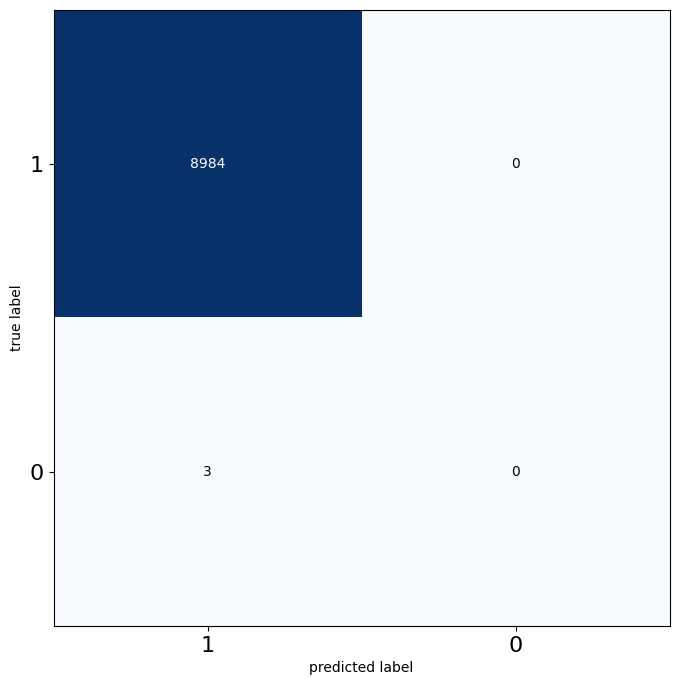

Electrical Appliances
accuracy: 0.9955491265160787 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

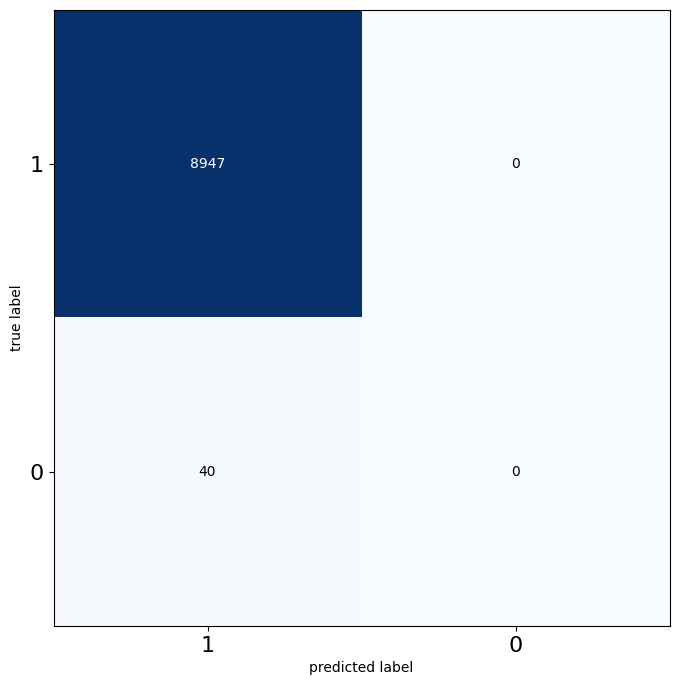

Electrical Appliances - Manufacturers & Wholesaler
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

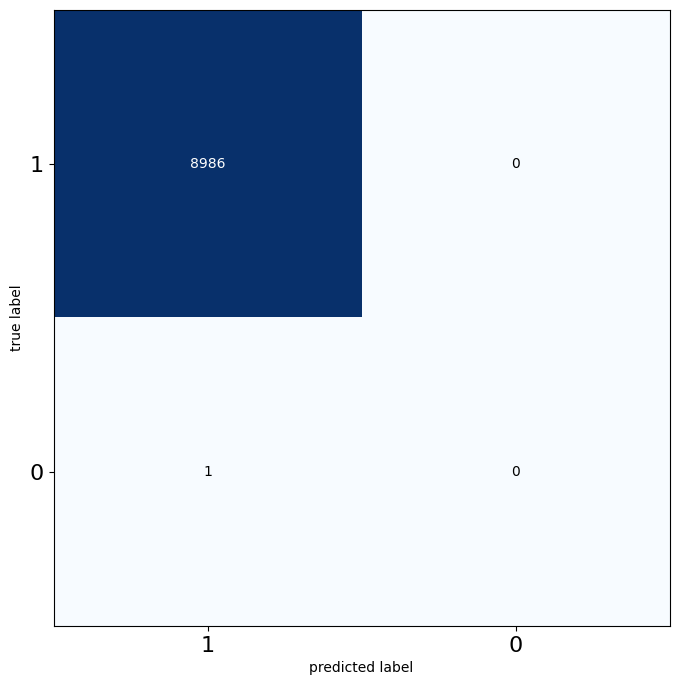

Electrical Contractors
accuracy: 0.988872816290197 precision: 0.011764705882352941 recall: 0.058823529411764705 f1: 0.0196078431372549


<Figure size 640x480 with 0 Axes>

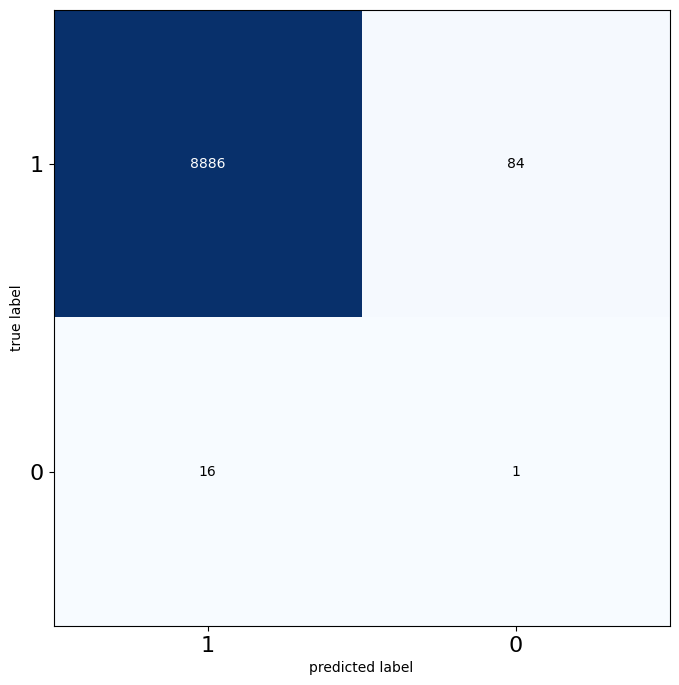

Electrical Engineers
accuracy: 0.9982196506064315 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

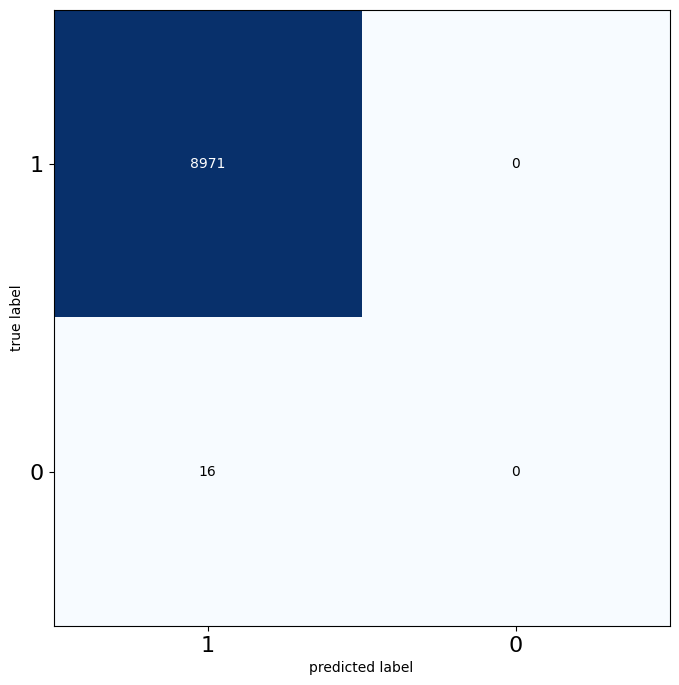

Electrical Equipment
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

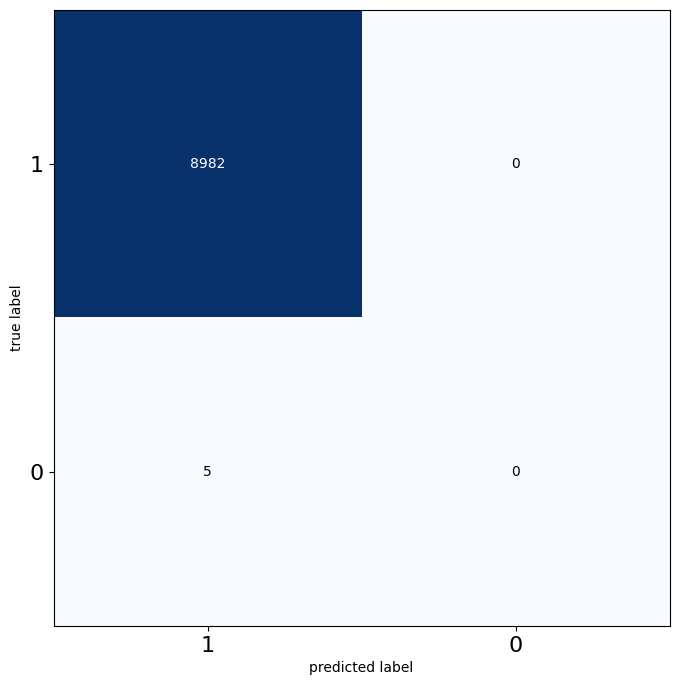

Electrical Fittings
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

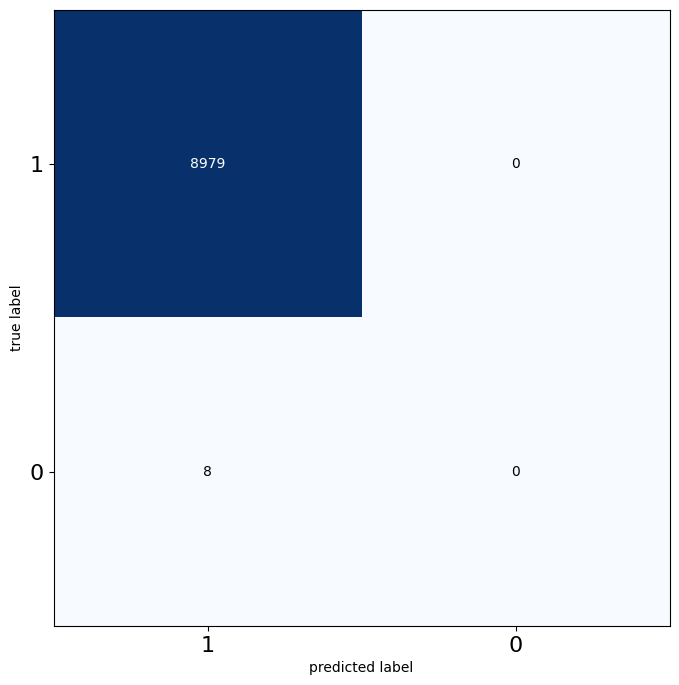

Electrical Supplies
accuracy: 0.1488817180371648 precision: 0.019907526329309016 recall: 0.8959537572254336 f1: 0.038949616786028395


<Figure size 640x480 with 0 Axes>

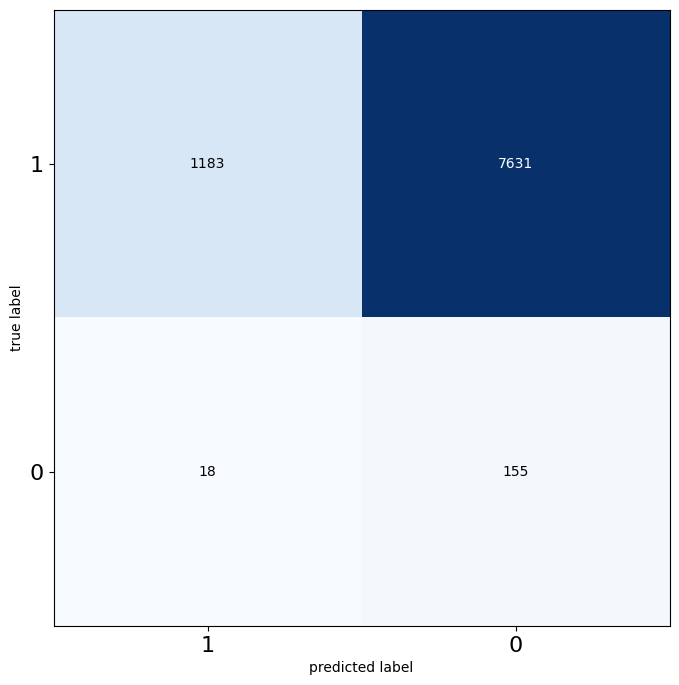

Electronic Components
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

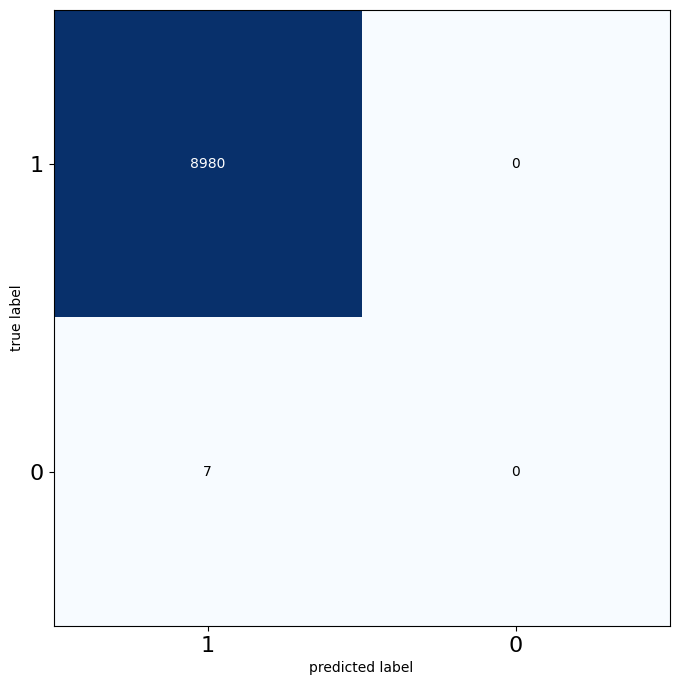

Electronic Equipment & Supplies
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

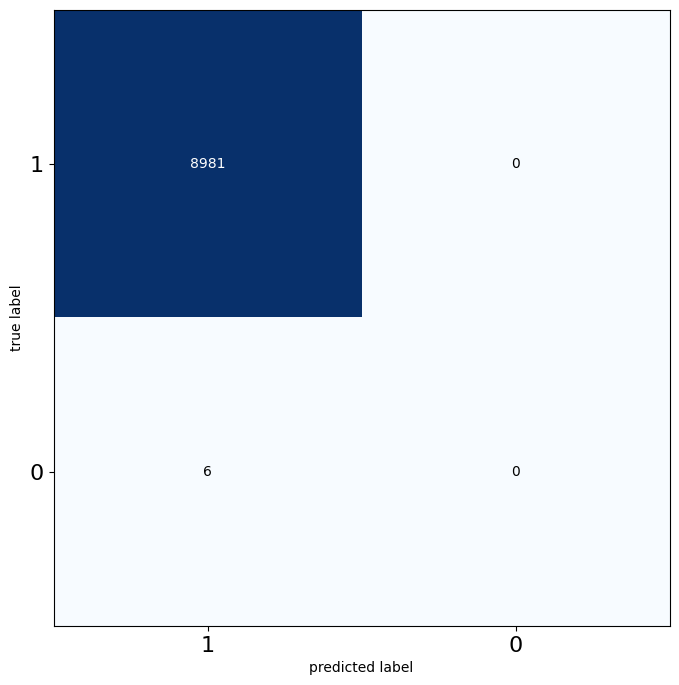

Electronic Tax Register
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

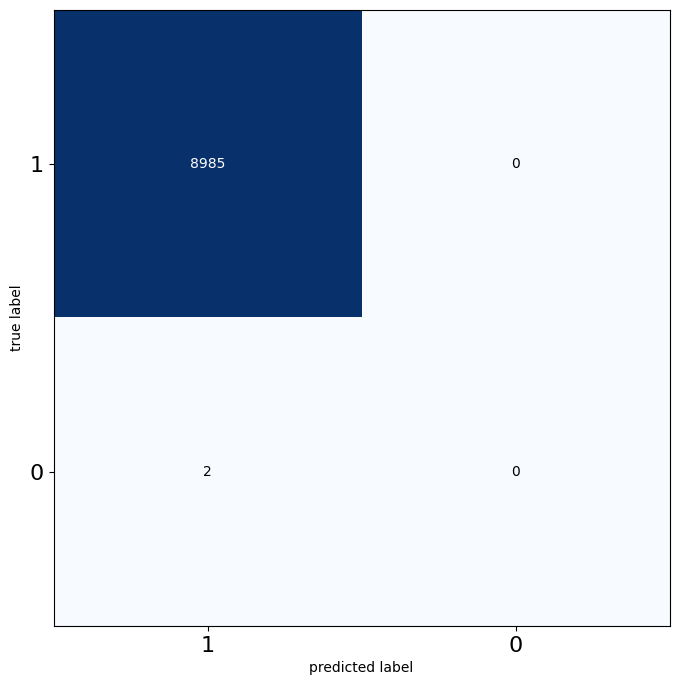

Embassies
accuracy: 0.9948814954934906 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

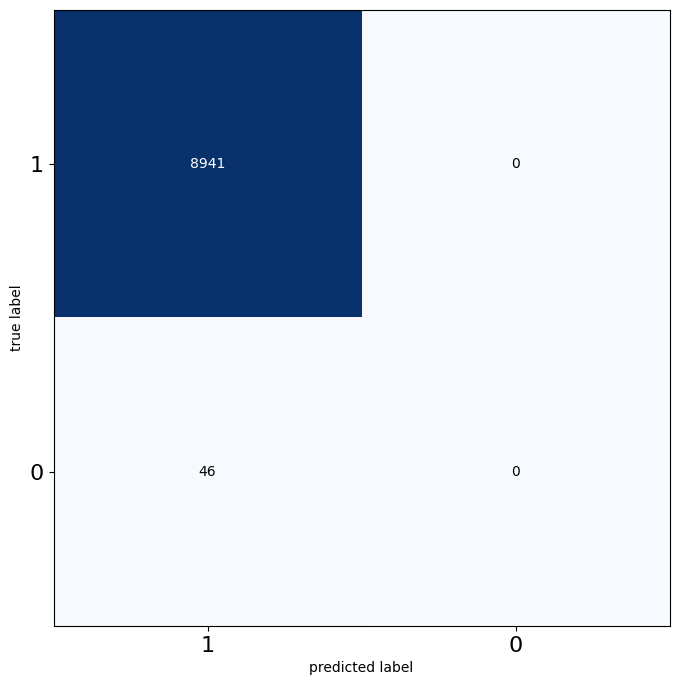

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Embroidery
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

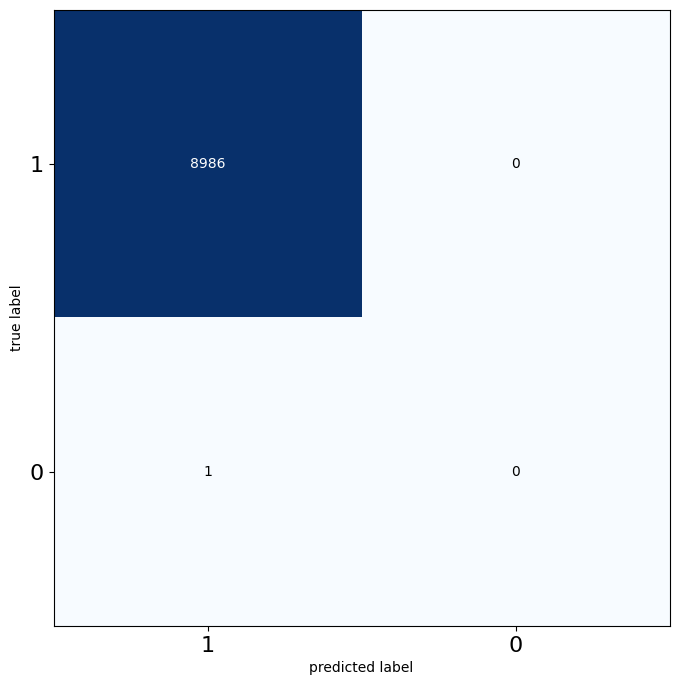

Emergency Services
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

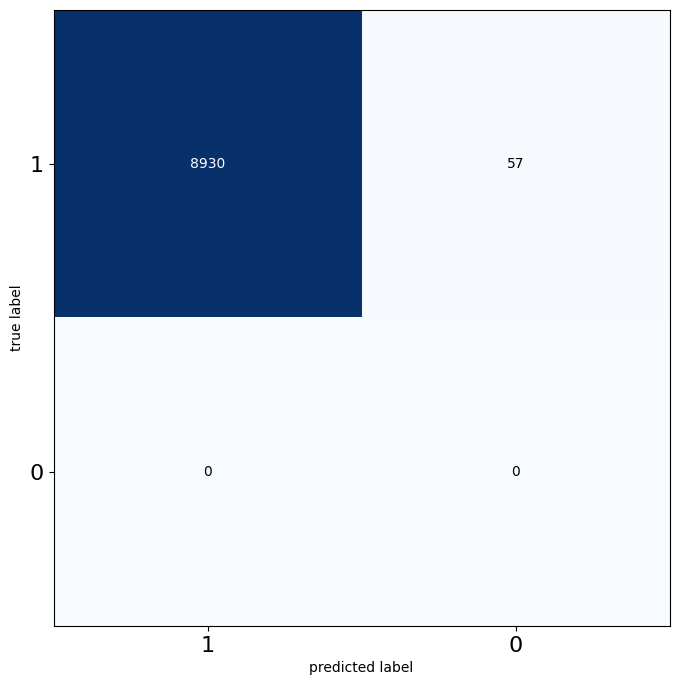

Employment Agencies
accuracy: 0.9715144097029041 precision: 0.05612244897959184 recall: 0.13414634146341464 f1: 0.07913669064748202


<Figure size 640x480 with 0 Axes>

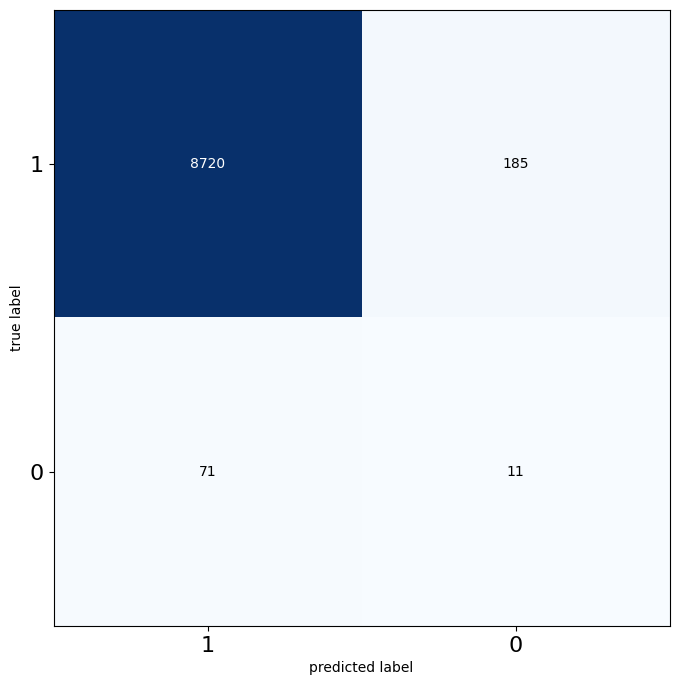

Energy Management Consultants
accuracy: 0.9948814954934906 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

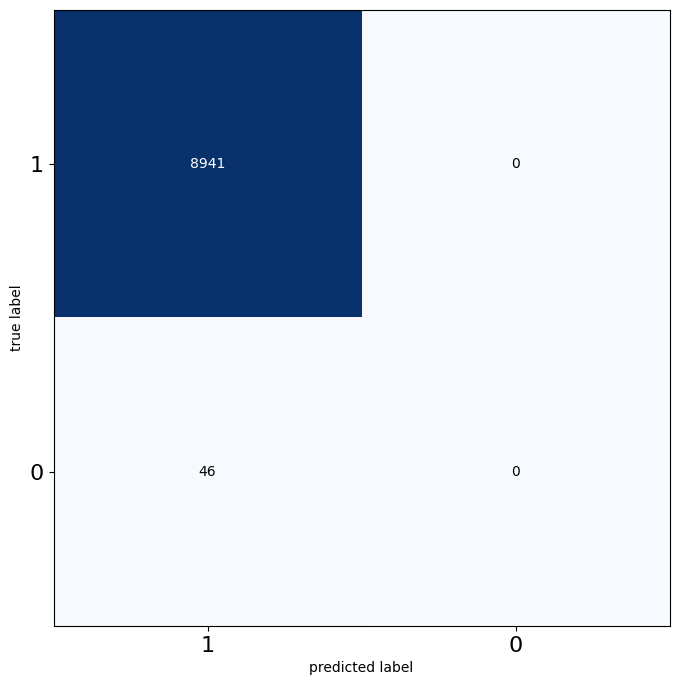

Engineering Surveyors
accuracy: 0.9954378546789807 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

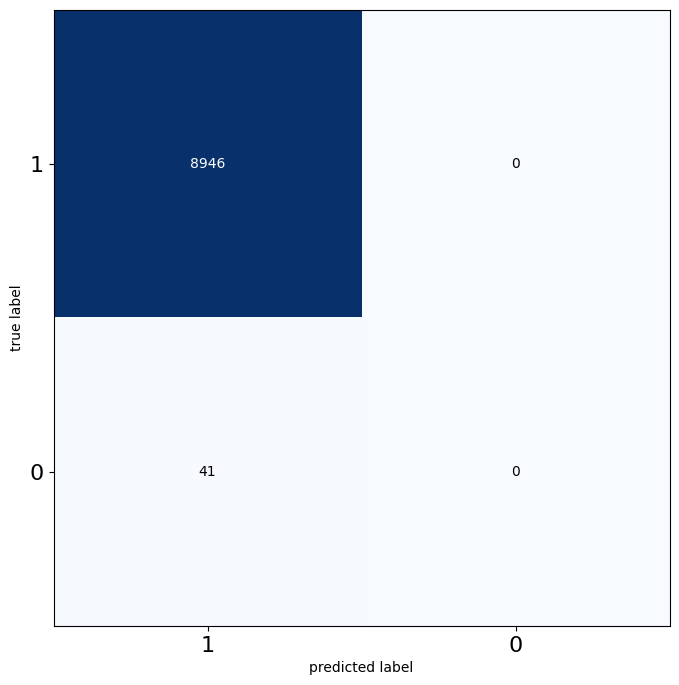

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Engineers
accuracy: 0.9976632914209413 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

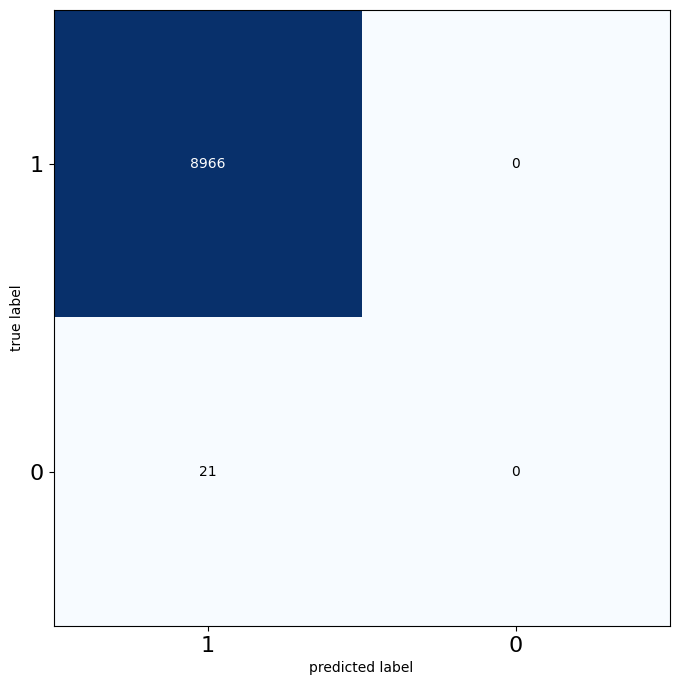

Engineers- Consulting
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

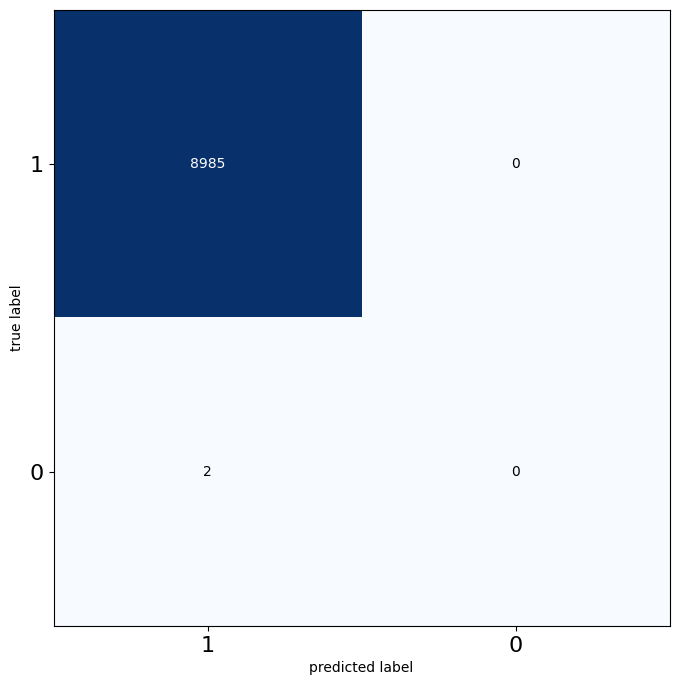

Engravers
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

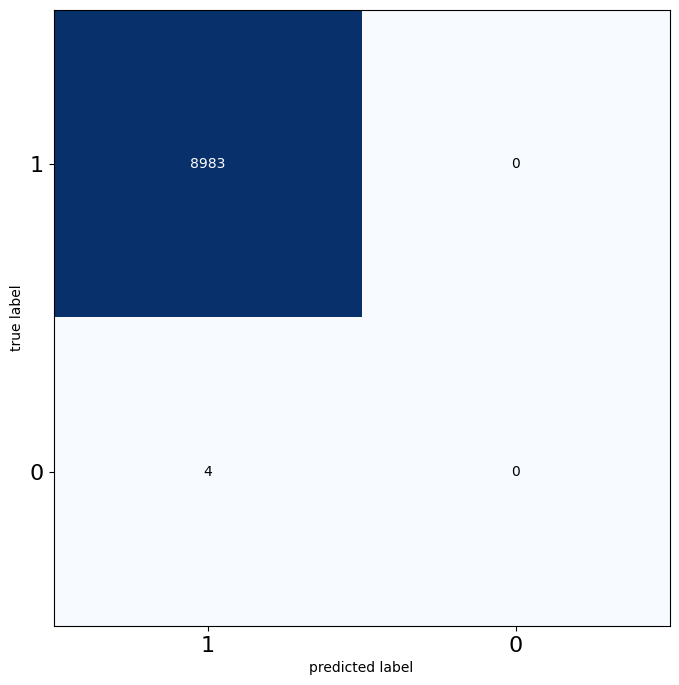

Environmental Consultants
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

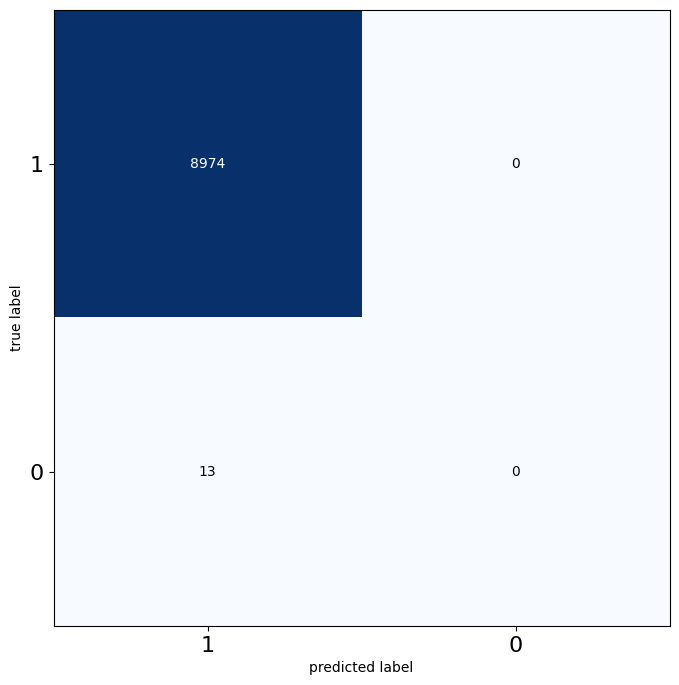

Estate Agents
accuracy: 0.9973294759096473 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

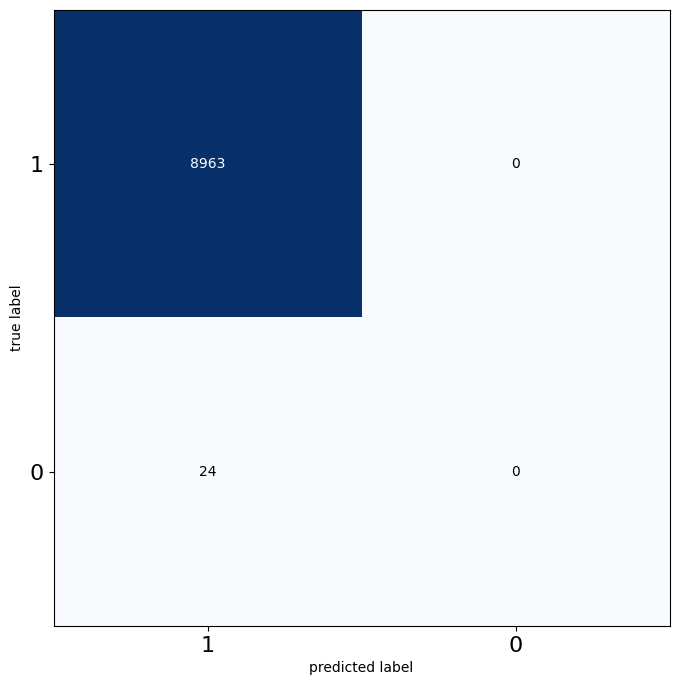

Estate Management
accuracy: 0.9973294759096473 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

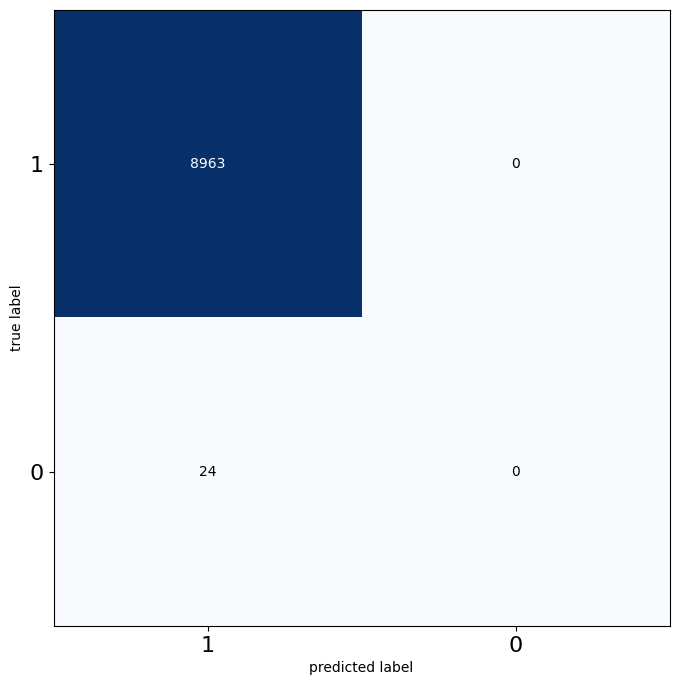

Event Organizers
accuracy: 0.28663625236452656 precision: 0.01605929586164299 recall: 0.7272727272727273 f1: 0.03142468650853603


<Figure size 640x480 with 0 Axes>

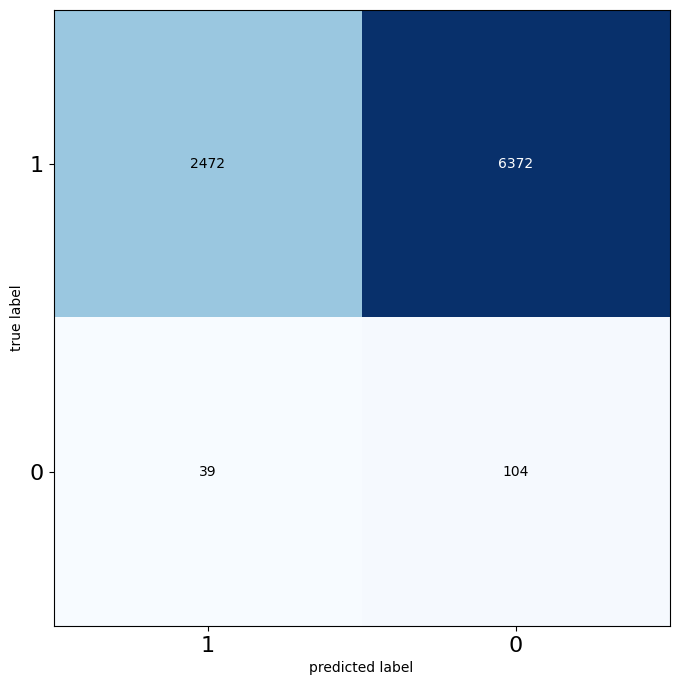

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Exhauster Services
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

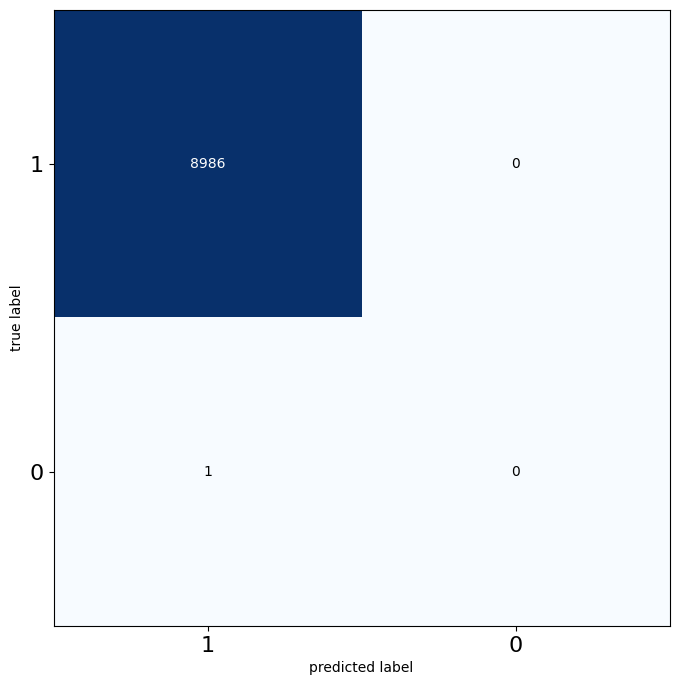

Exhibitions & Trade Fairs
accuracy: 0.9984421942806275 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

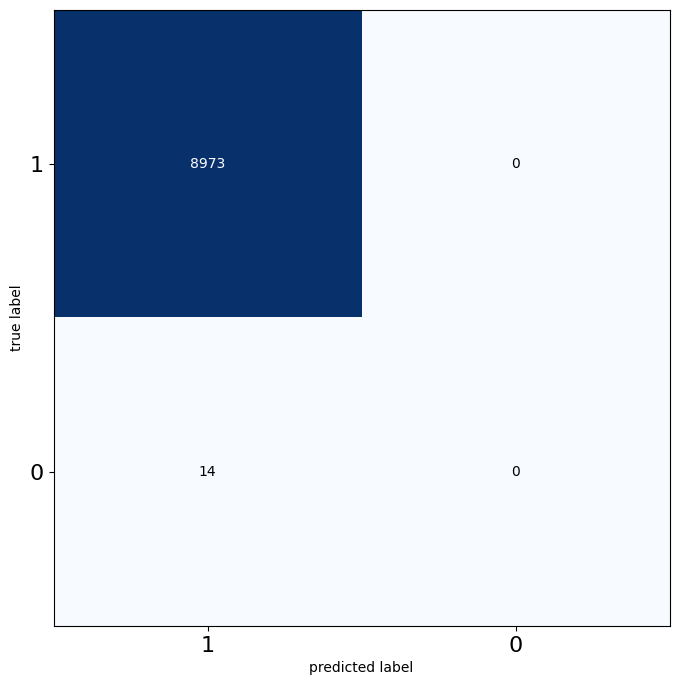

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fabricators
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

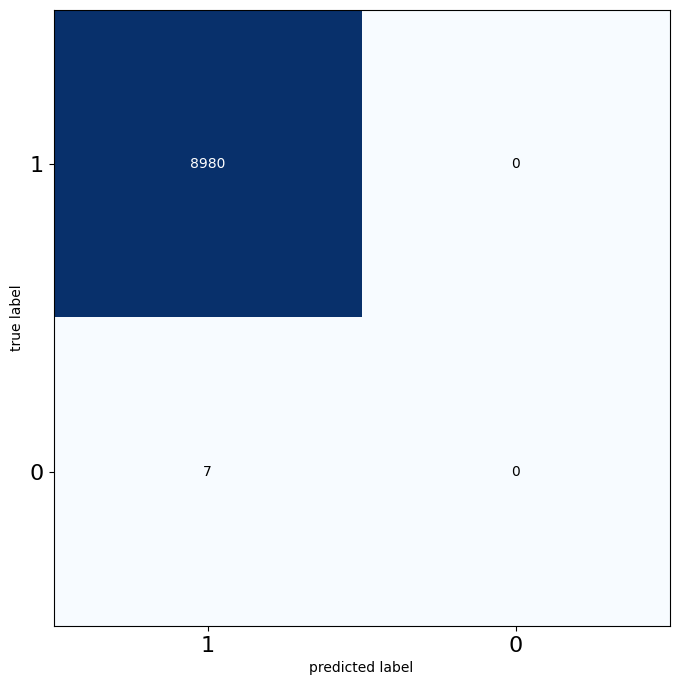

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fabrics
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

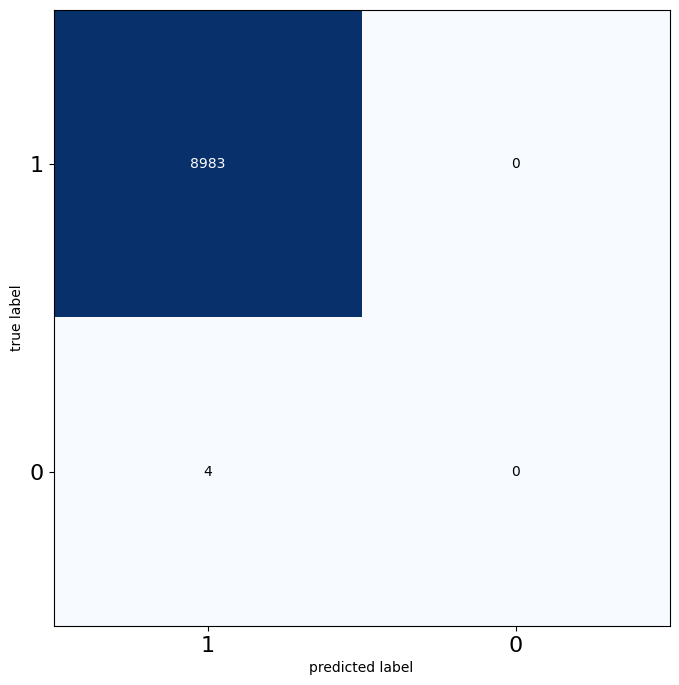

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Facilities Management
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

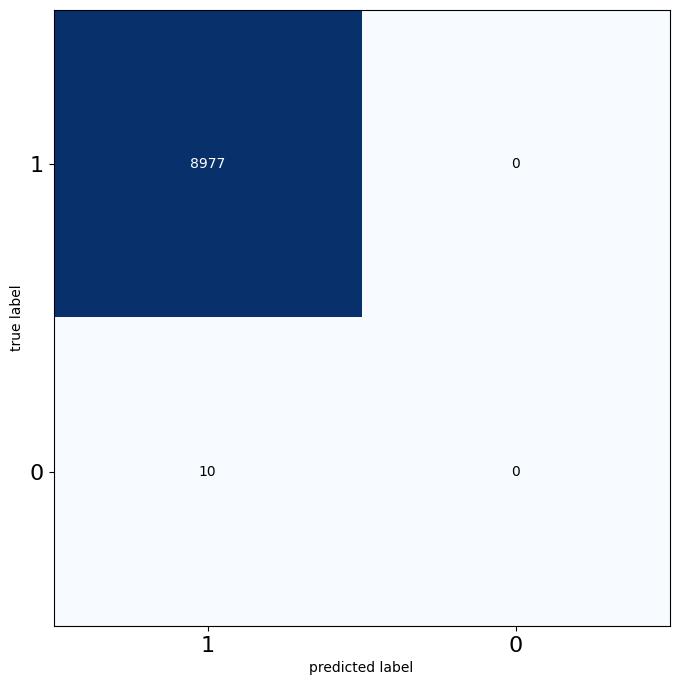

Farm Machineries
accuracy: 0.9944364081450985 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

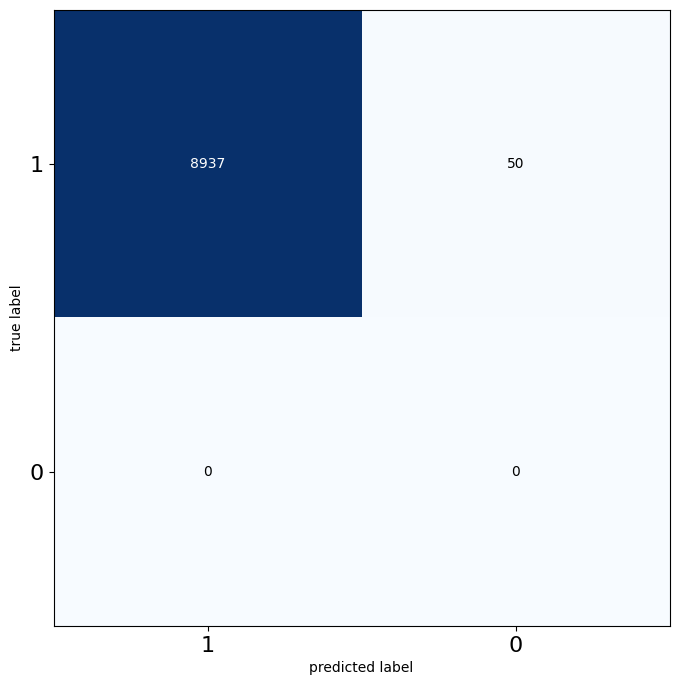

Farms
accuracy: 0.9982196506064315 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

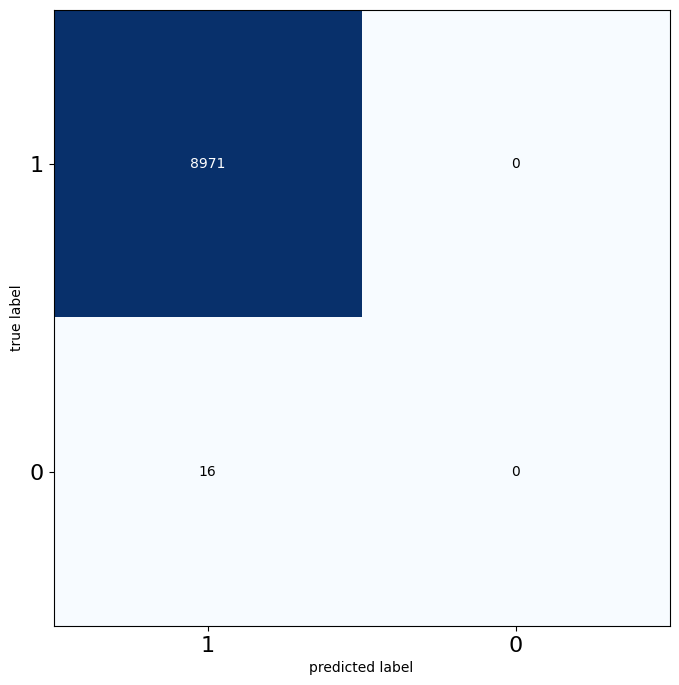

Fashion Designers
accuracy: 0.9775230889061979 precision: 0.04 recall: 0.00558659217877095 f1: 0.00980392156862745


<Figure size 640x480 with 0 Axes>

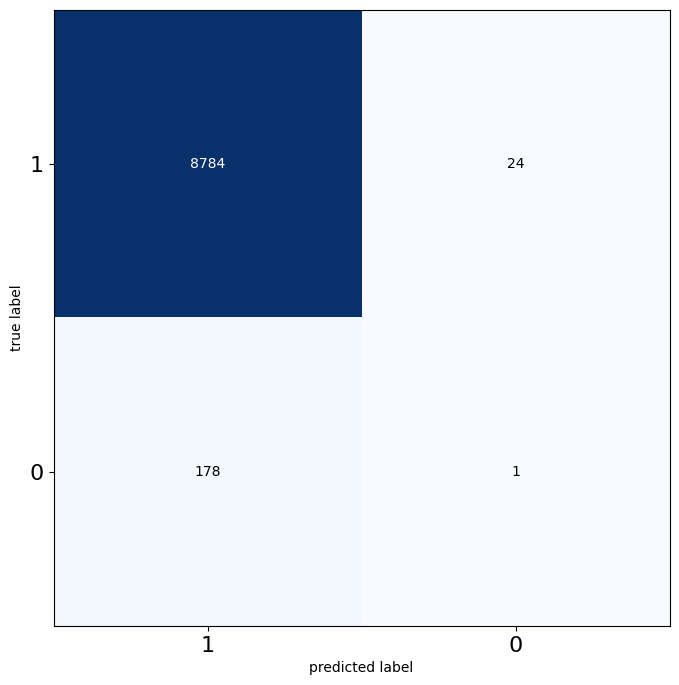

Feeds Dealers
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

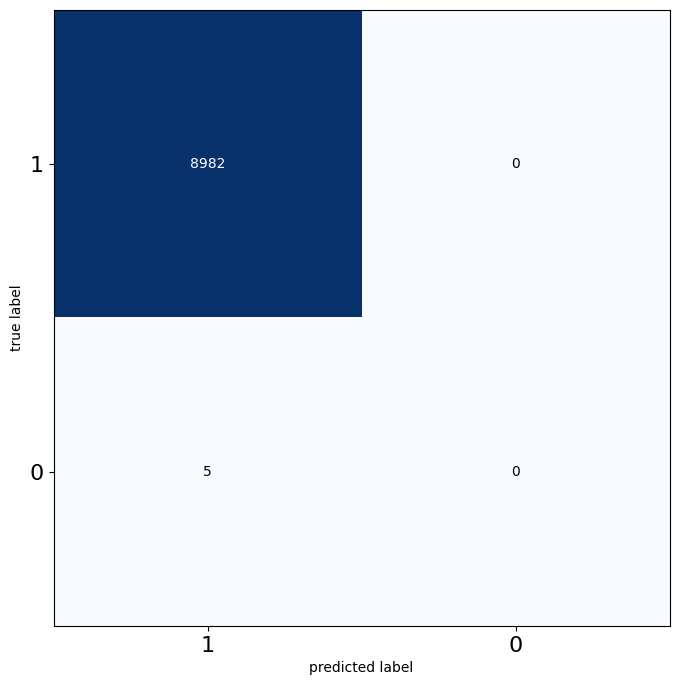

Ferries
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

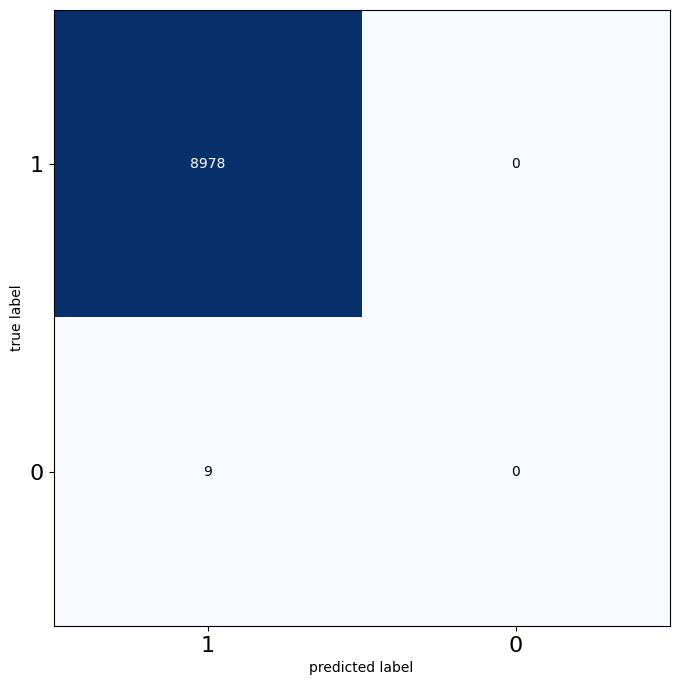

Fertilizers
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

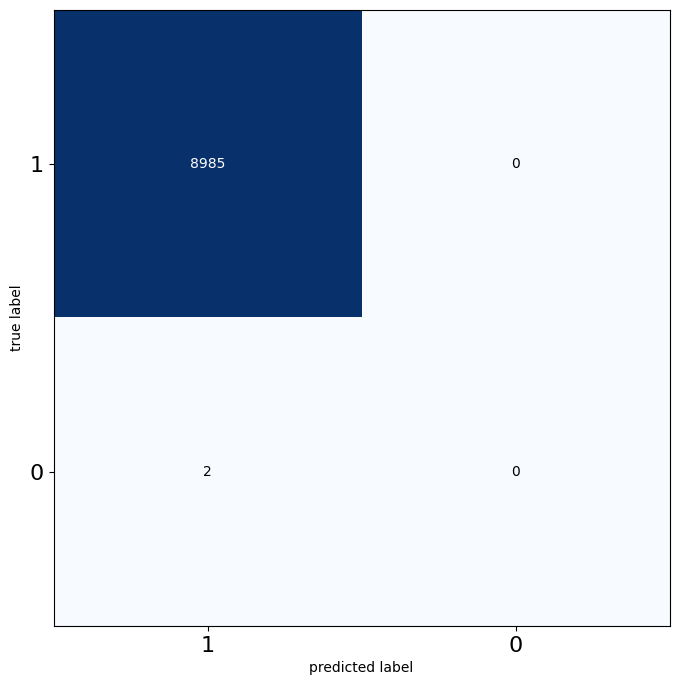

Film & Video Productions
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

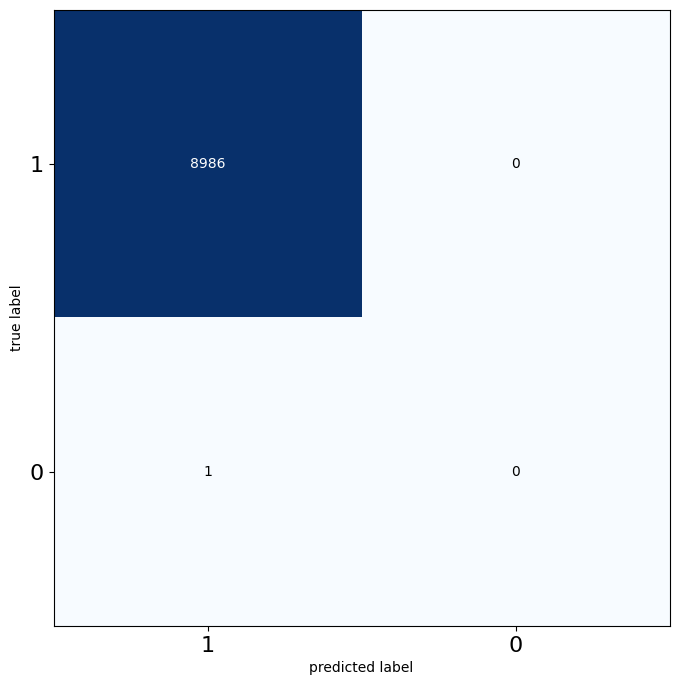

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Film Companies
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

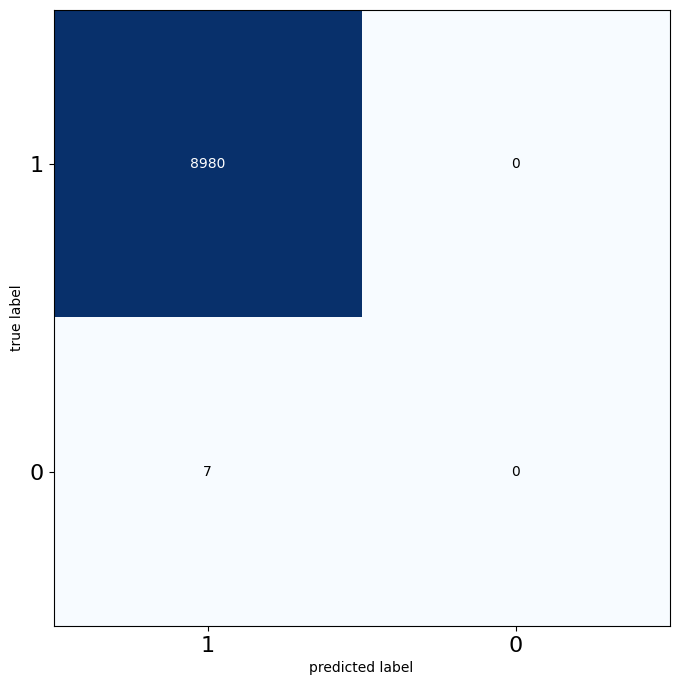

Finance Companies
accuracy: 0.9955491265160787 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

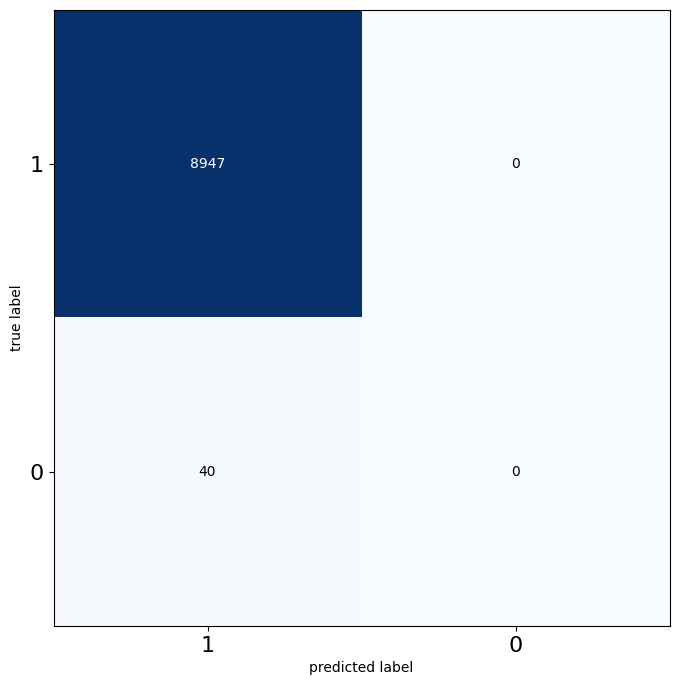

Financial Consultants
accuracy: 0.9975520195838433 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

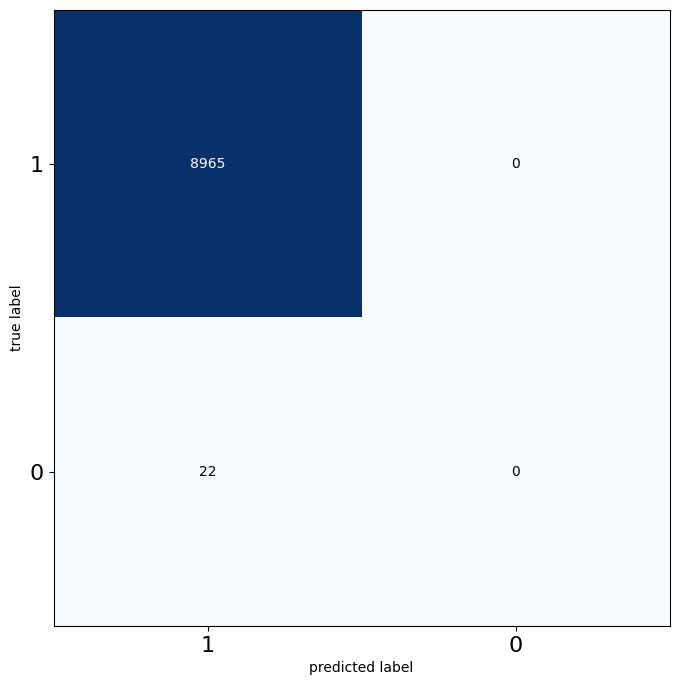

Financial Services
accuracy: 0.9313452765105152 precision: 0.11627906976744186 recall: 0.008561643835616438 f1: 0.01594896331738437


<Figure size 640x480 with 0 Axes>

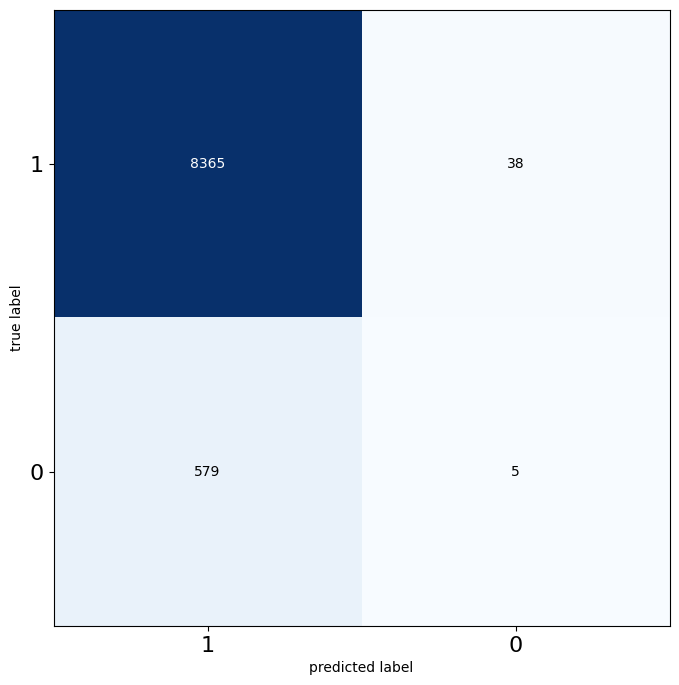

Fire Fighting Equipment & Systems-Suppliers & Contractors
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

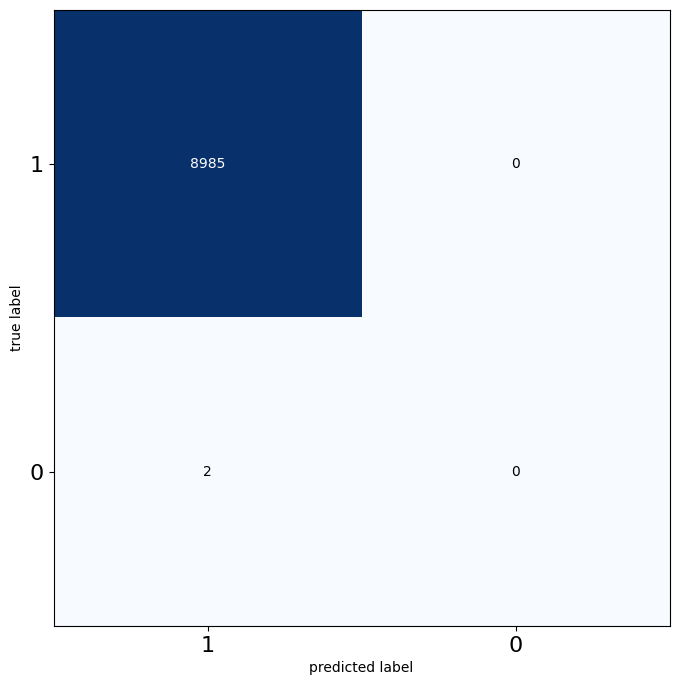

Fire Protection Consultants
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

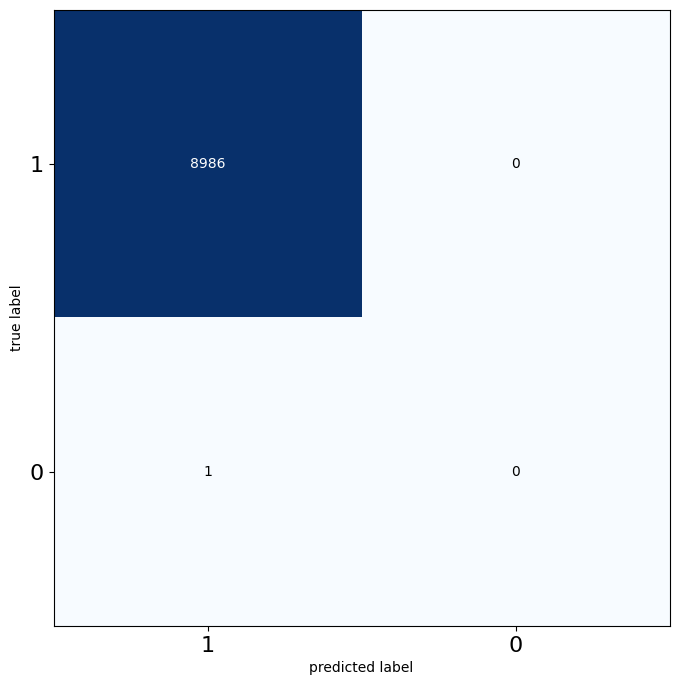

Fire Surveyors
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

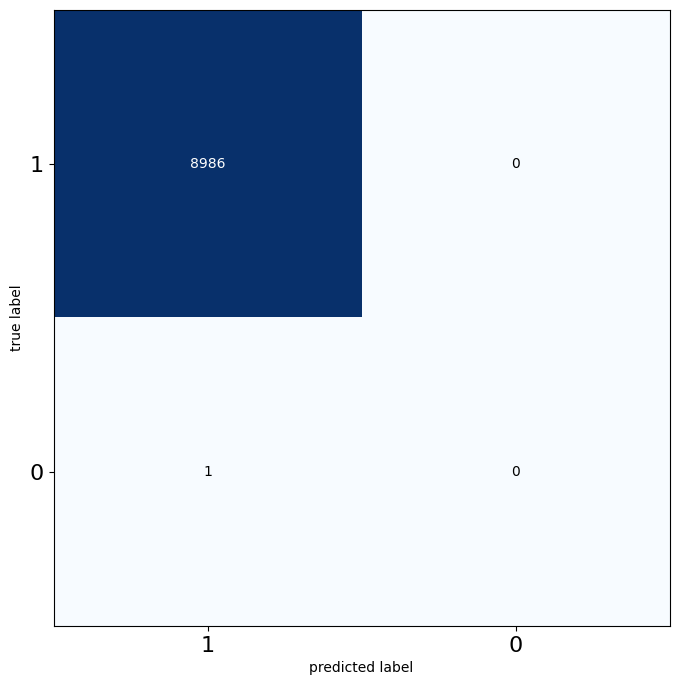

Fish Merchants
accuracy: 0.9978858350951374 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

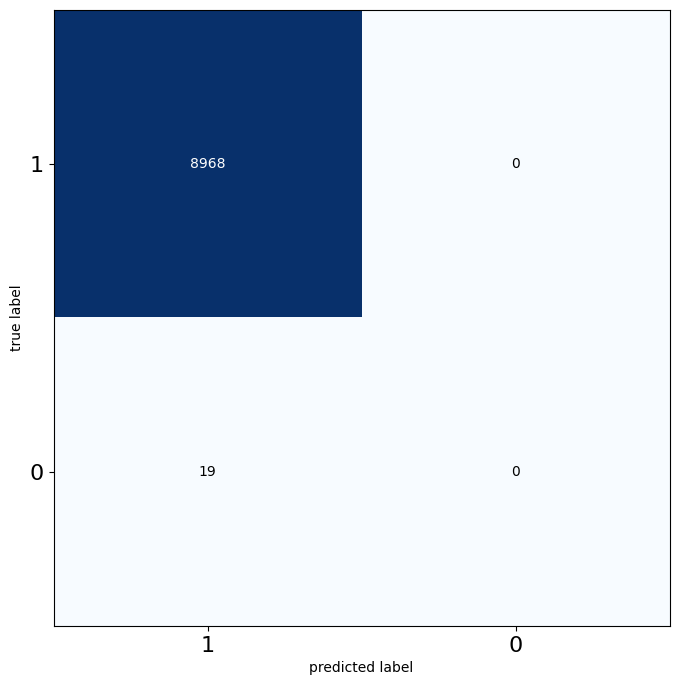

Fishing
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

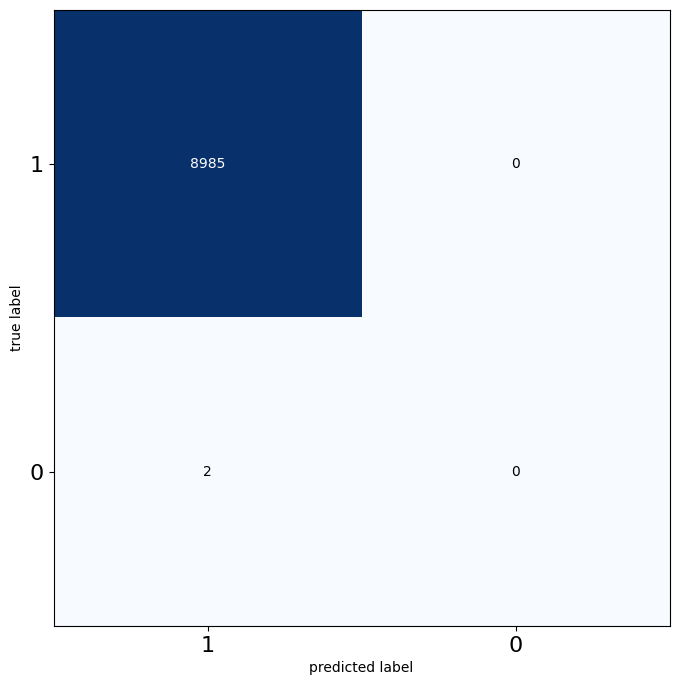

Fishing Sport
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

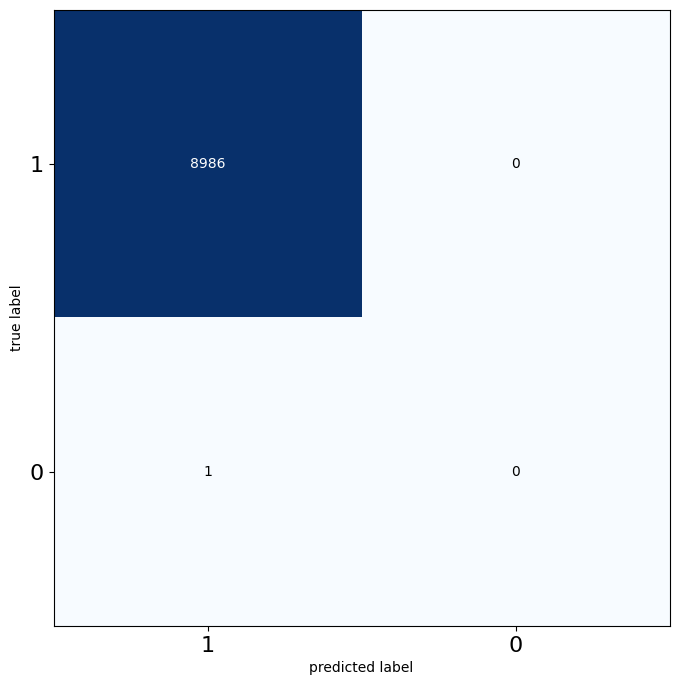

Fitness Centres
accuracy: 0.9965505730499611 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

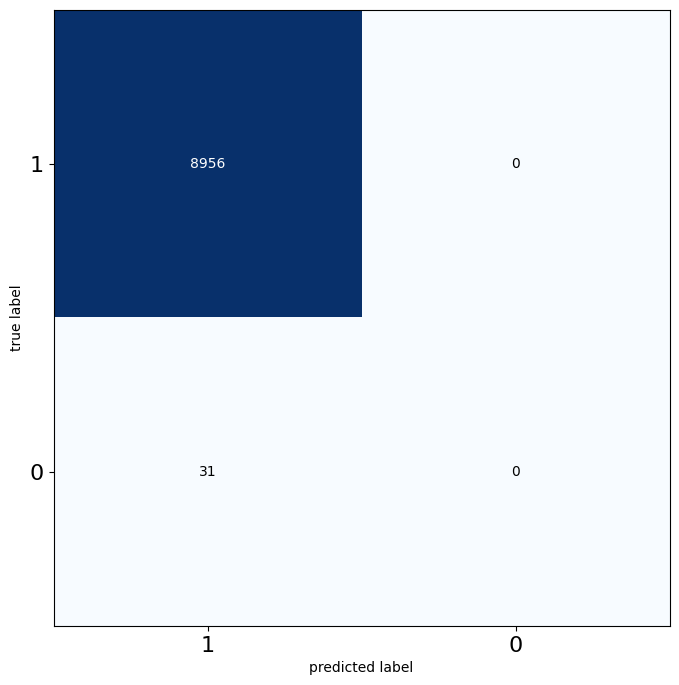

Flavouring Extracts
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

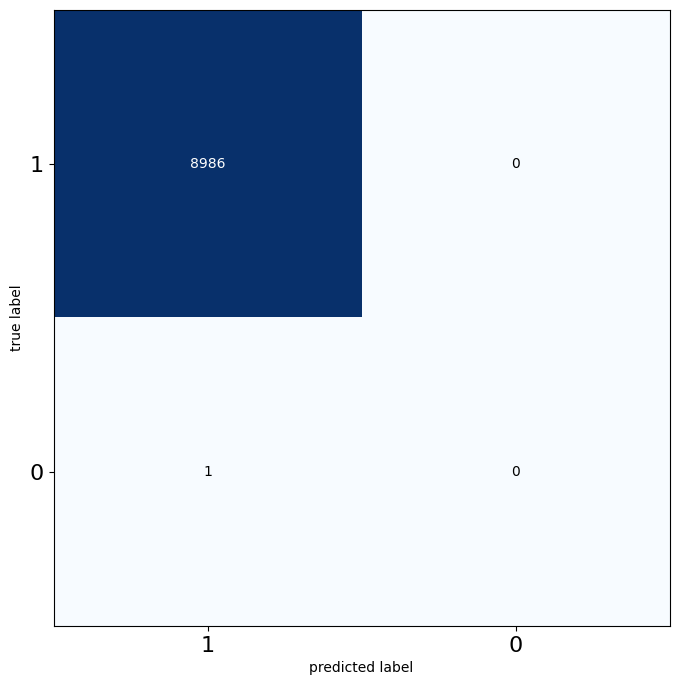

Floor Tiles
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

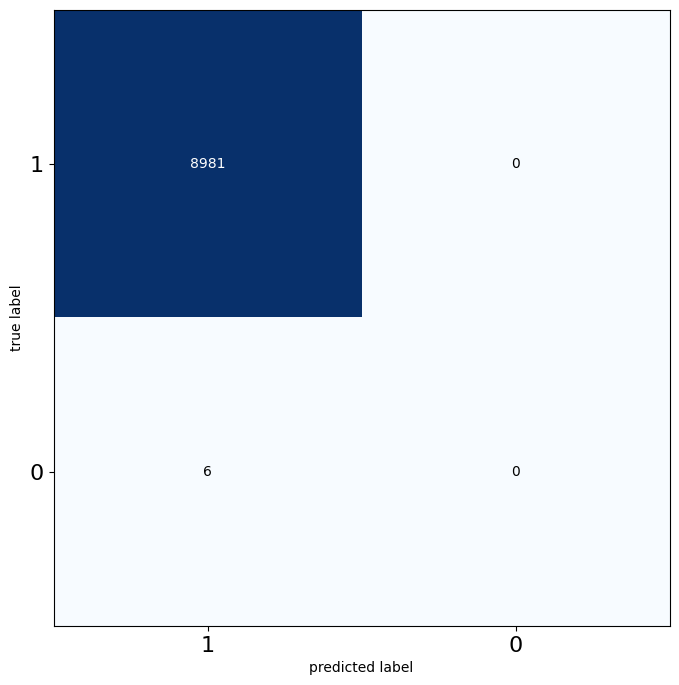

Florists
accuracy: 0.9937687771225103 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

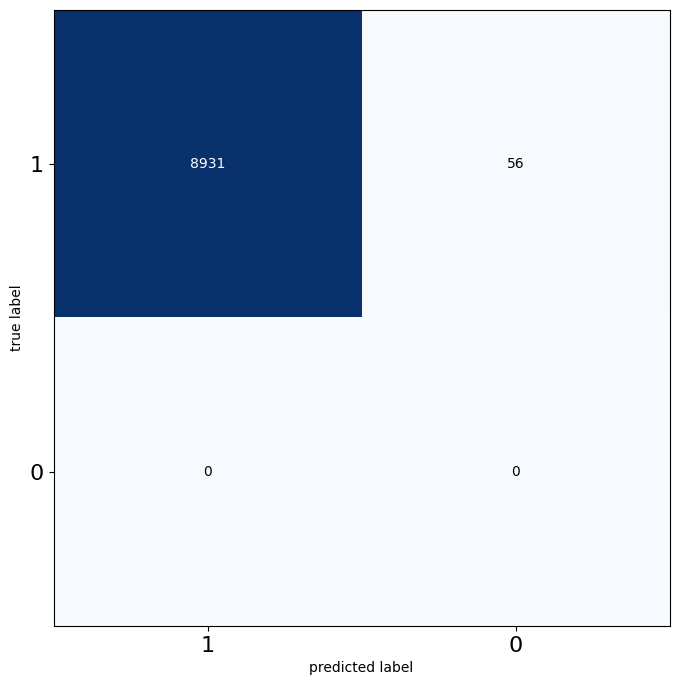

Flour
accuracy: 0.992878602425726 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

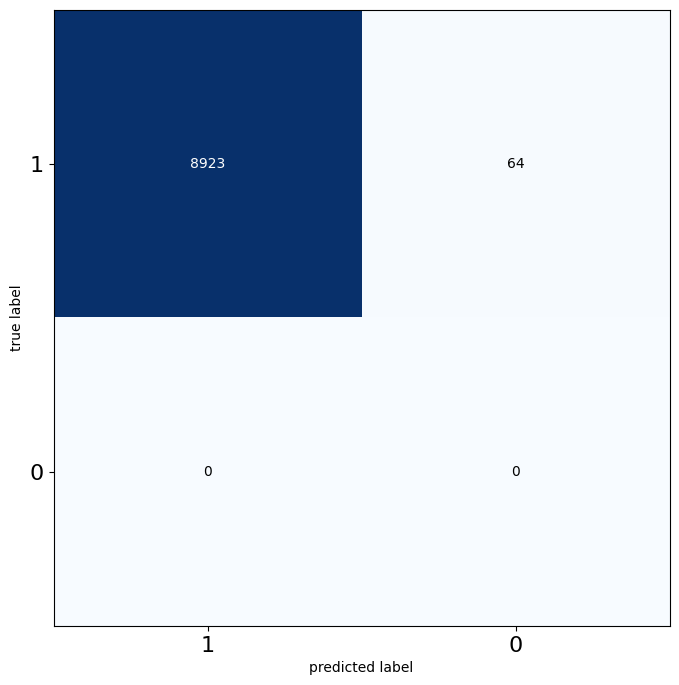

Flying Schools
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

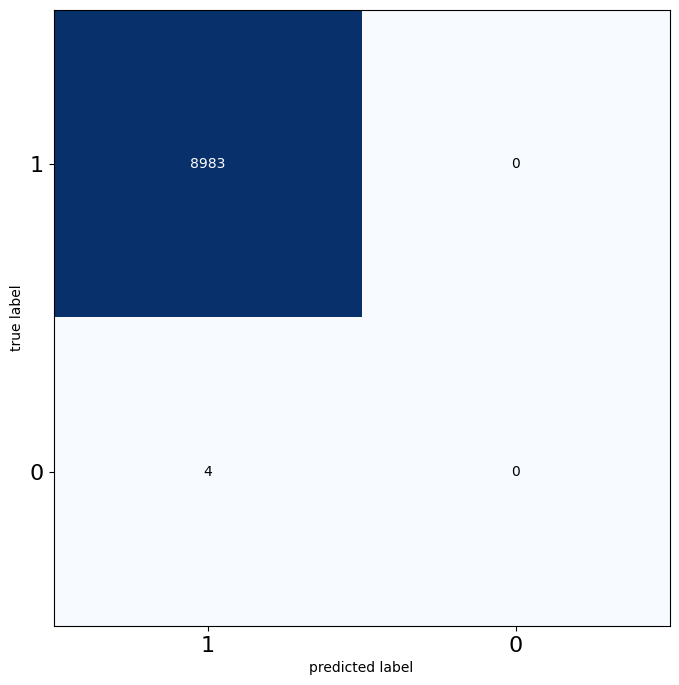

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Foam & Foam Products
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

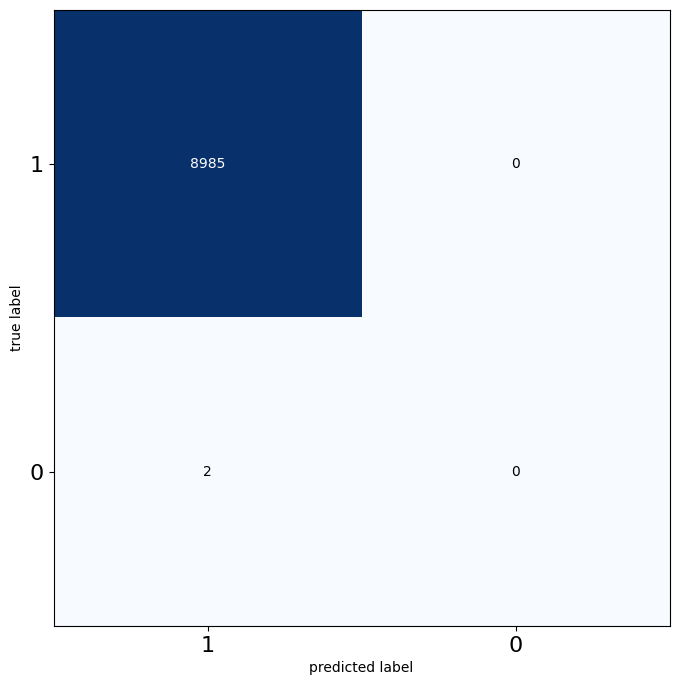

Food Products
accuracy: 0.04005786135529098 precision: 0.04005786135529098 recall: 1.0 f1: 0.07703006312185728


<Figure size 640x480 with 0 Axes>

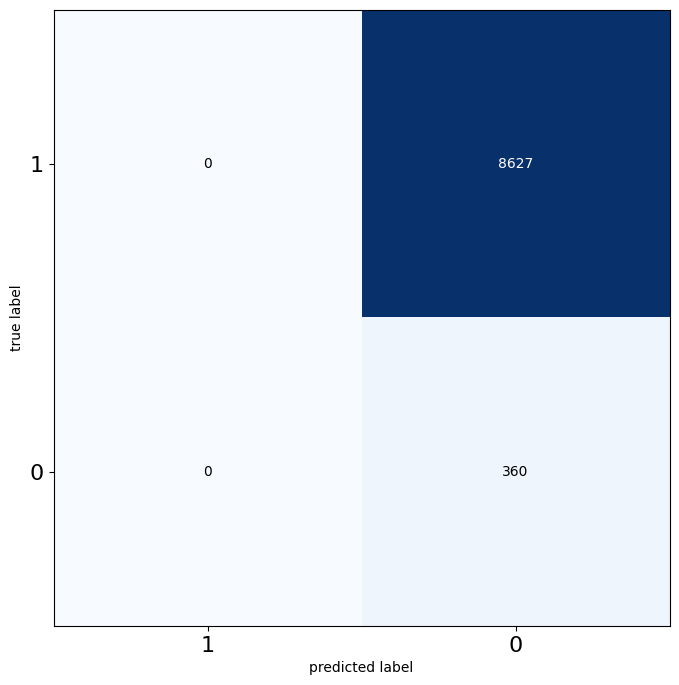

Foreign Exchange Bureau
accuracy: 0.9973294759096473 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

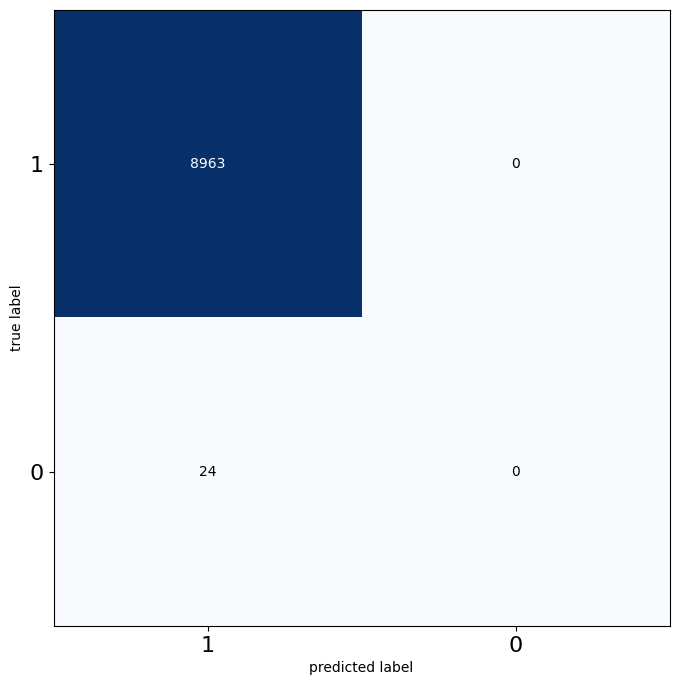

Fruit Juices
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

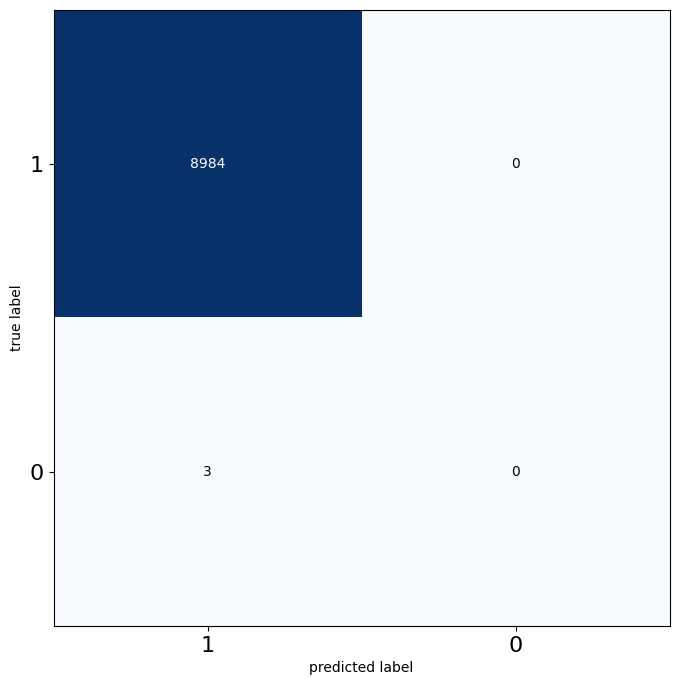

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Furniture Dealers
accuracy: 0.9867586513853344 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

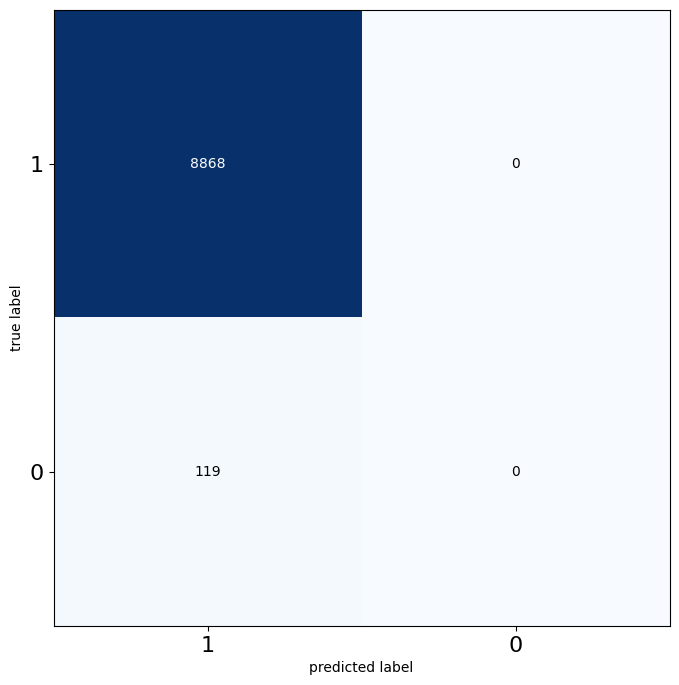

Furniture Manufacturers
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

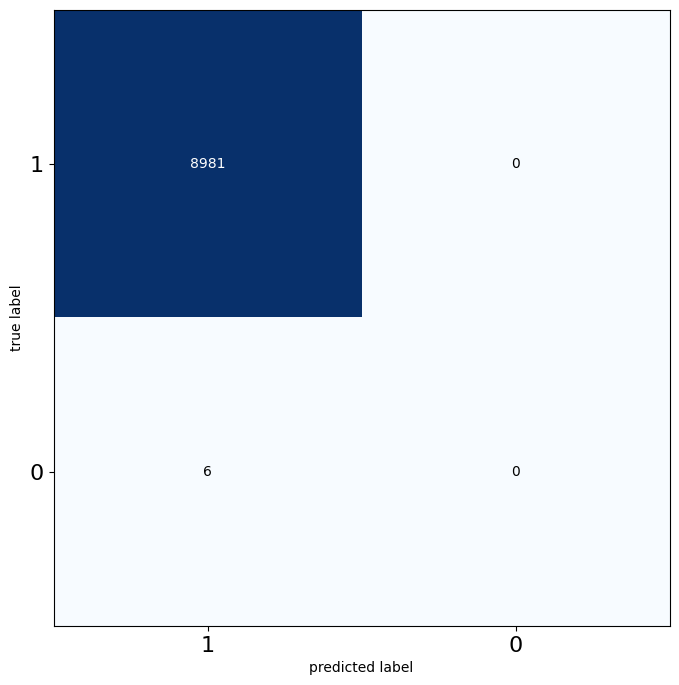

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Games & Games Supplies
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

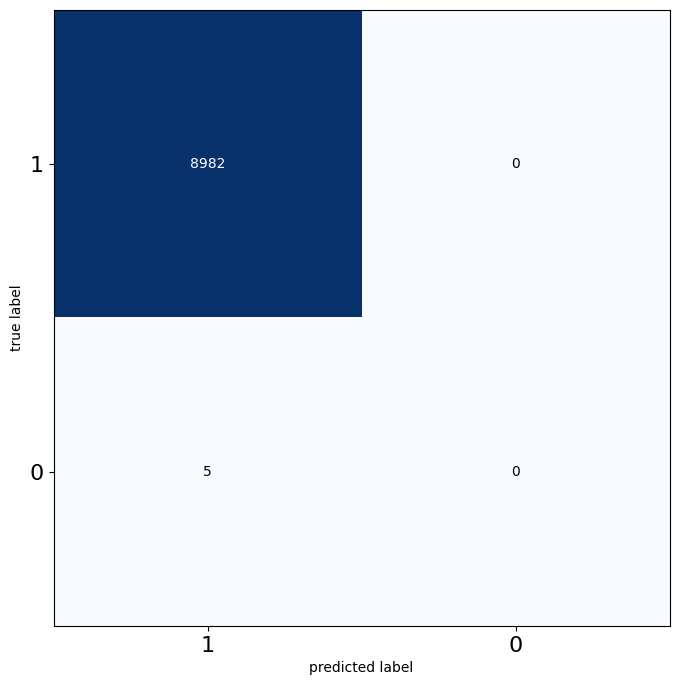

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Garages-Equipment & Supplies
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

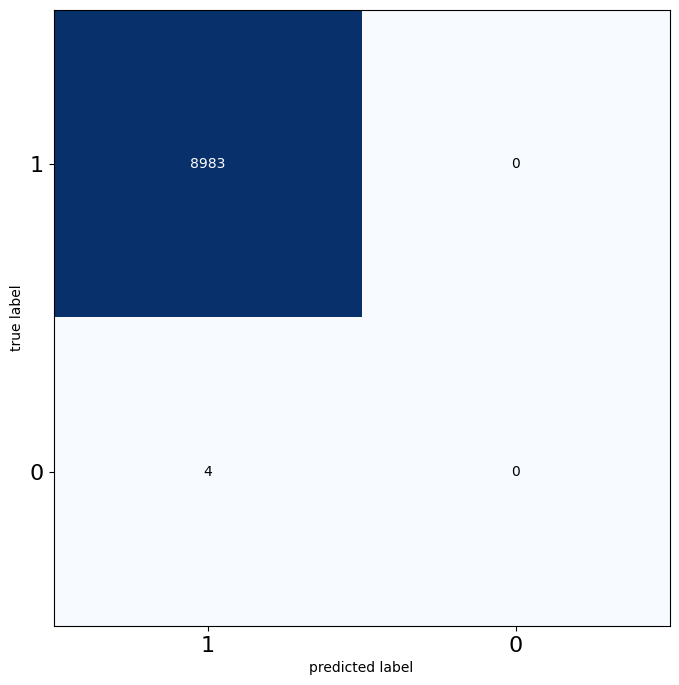

Garden & Lawn Equipment Supplies
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

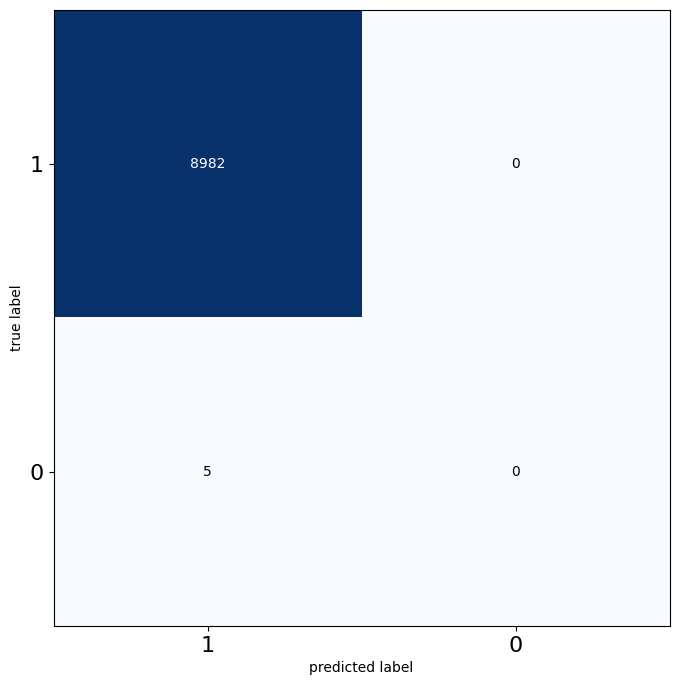

Garment Manufacturers
accuracy: 0.9916546122176477 precision: 0.014084507042253521 recall: 0.16666666666666666 f1: 0.025974025974025976


<Figure size 640x480 with 0 Axes>

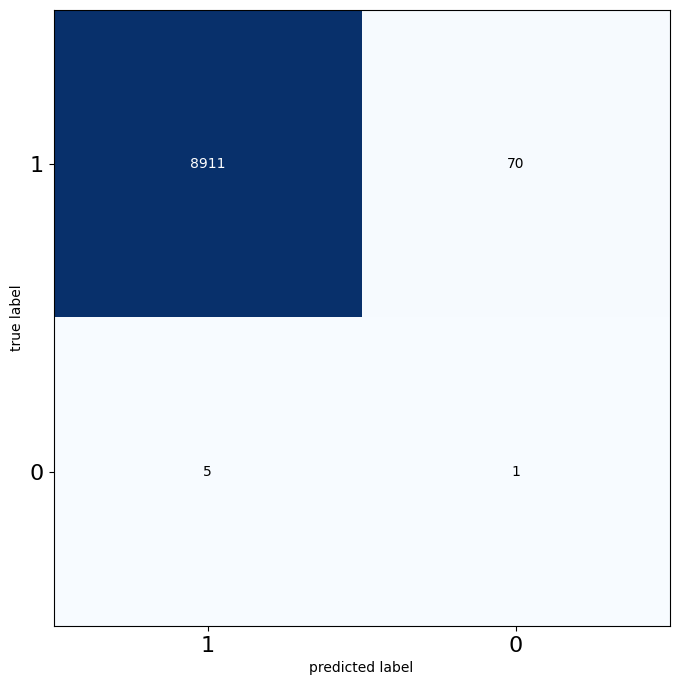

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gas Cylinders
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

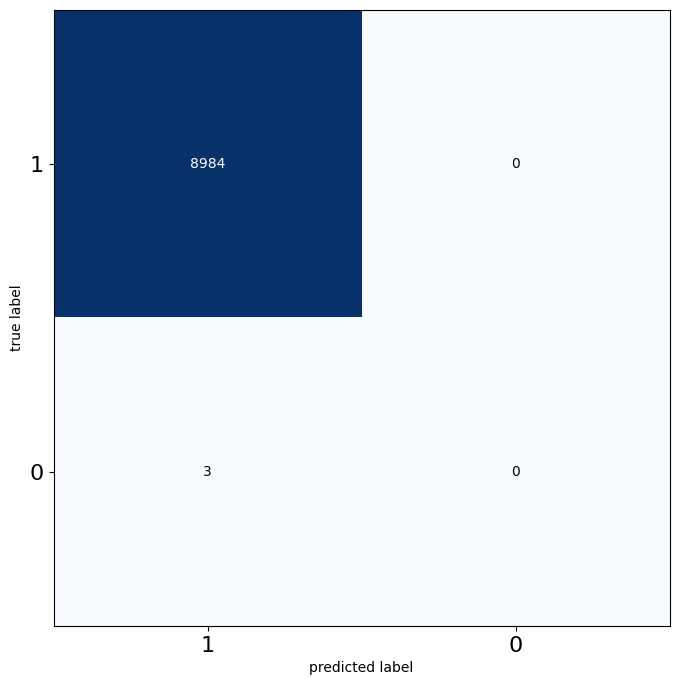

Gems
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

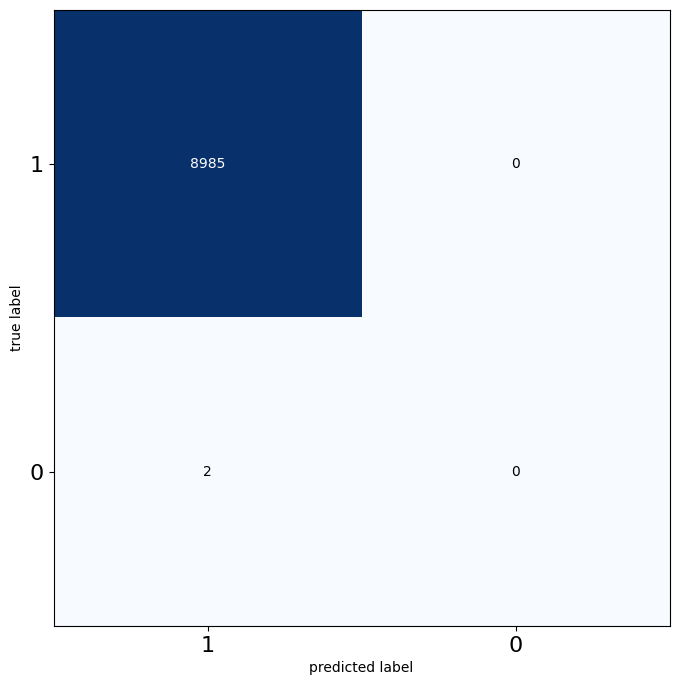

Generators
accuracy: 0.9975520195838433 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

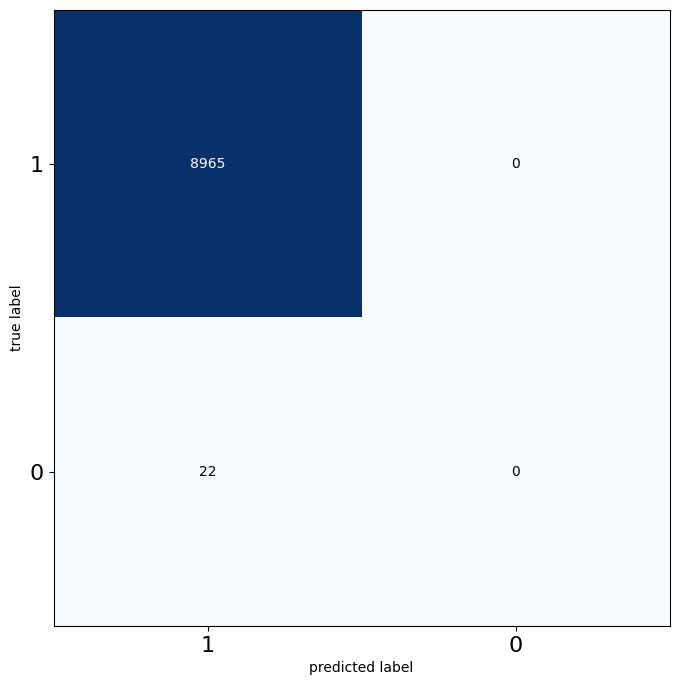

Gift Shops
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

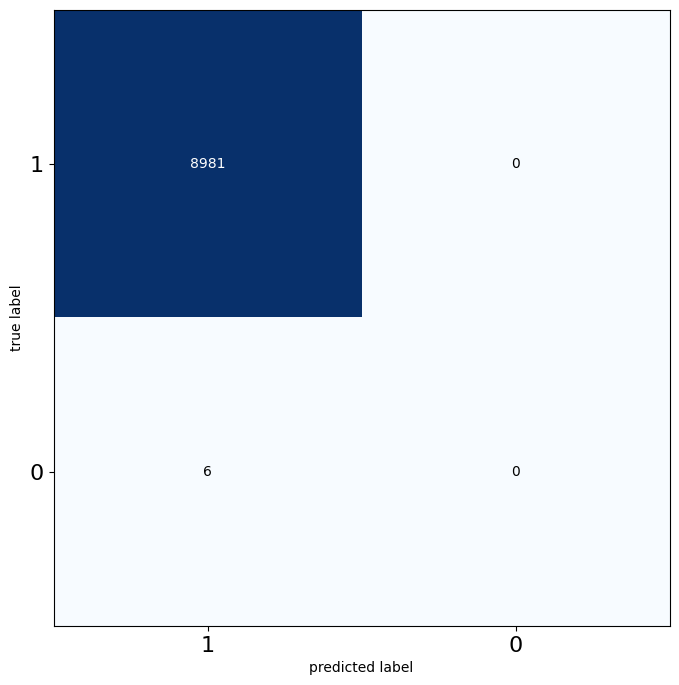

Glassware Merchants
accuracy: 0.9946589518192945 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

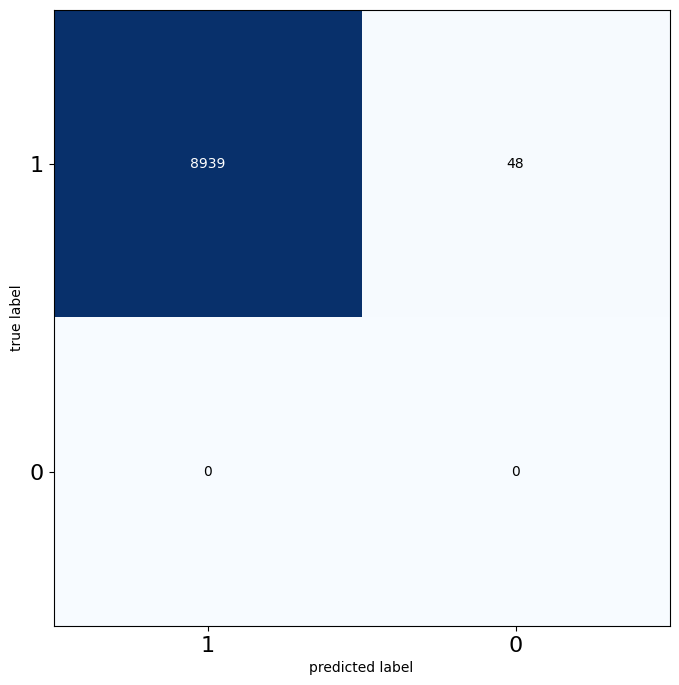

Golf Clubs
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

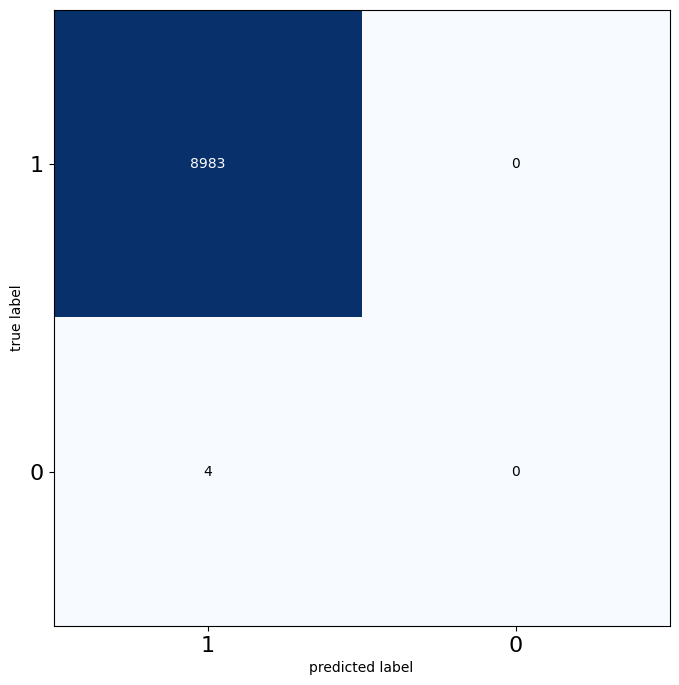

Golf Equipment & Accessories
accuracy: 0.9934349616112162 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

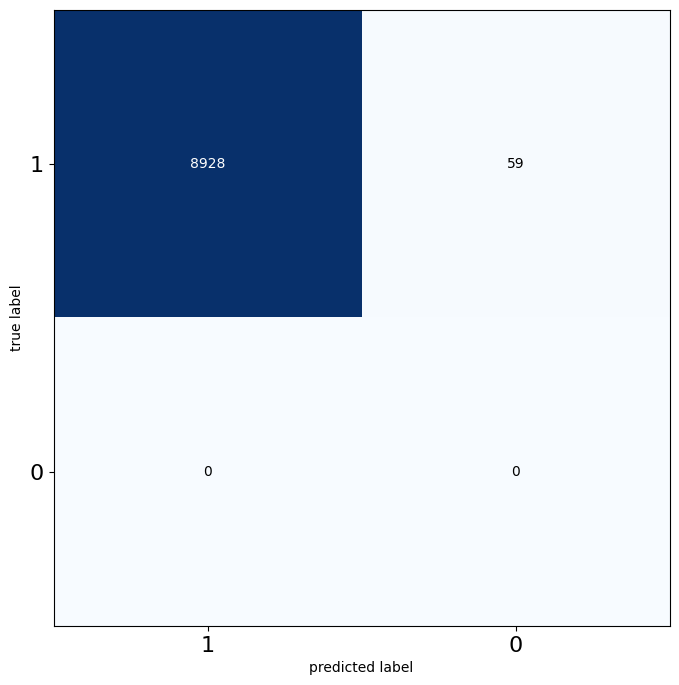

Grain Dealers
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

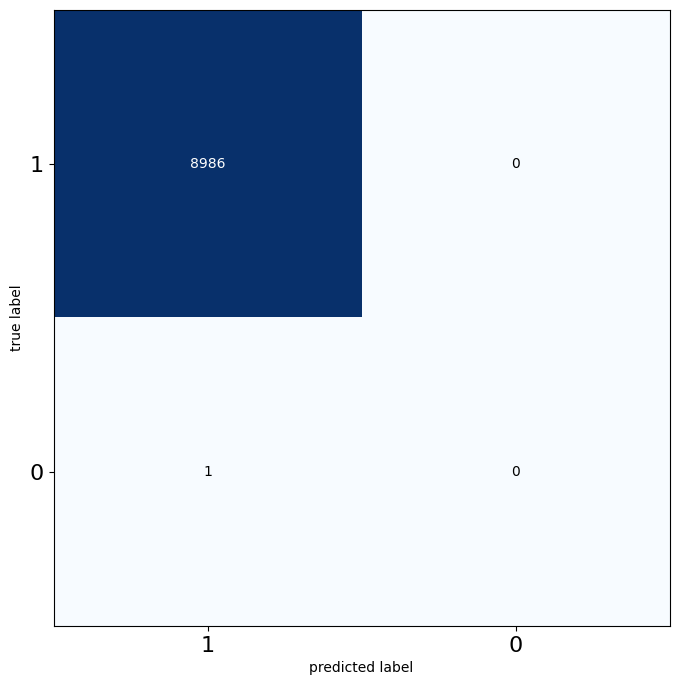

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Graphic Designers
accuracy: 0.9987760097919217 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

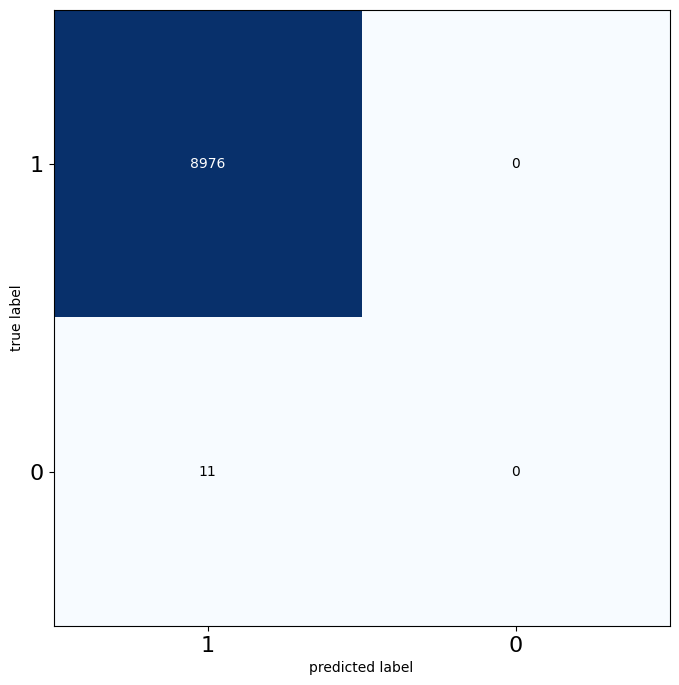

Grocers
accuracy: 0.9987760097919217 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

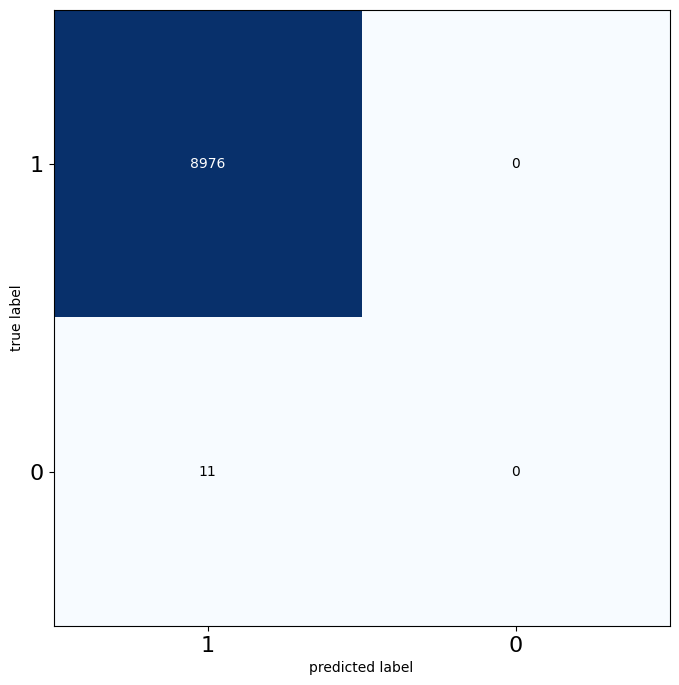

Guards & Patrol Service
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

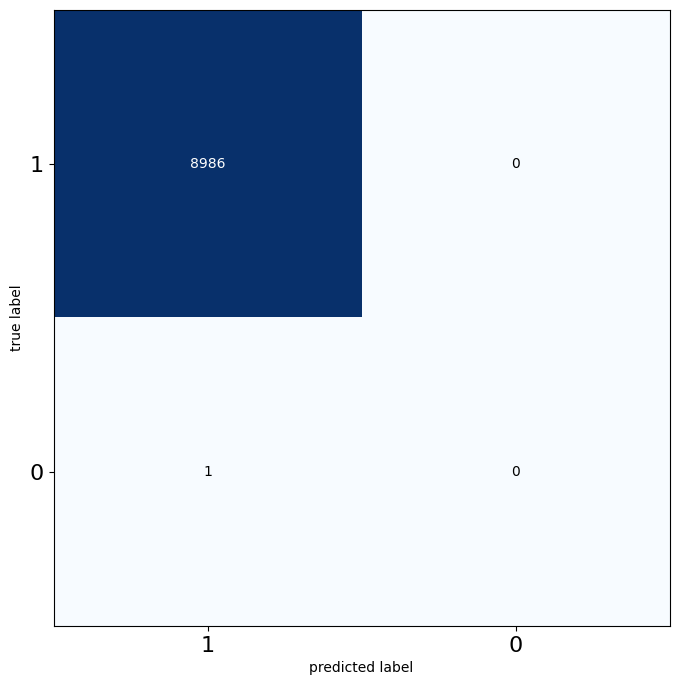

Guest House
accuracy: 0.9971069322354512 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

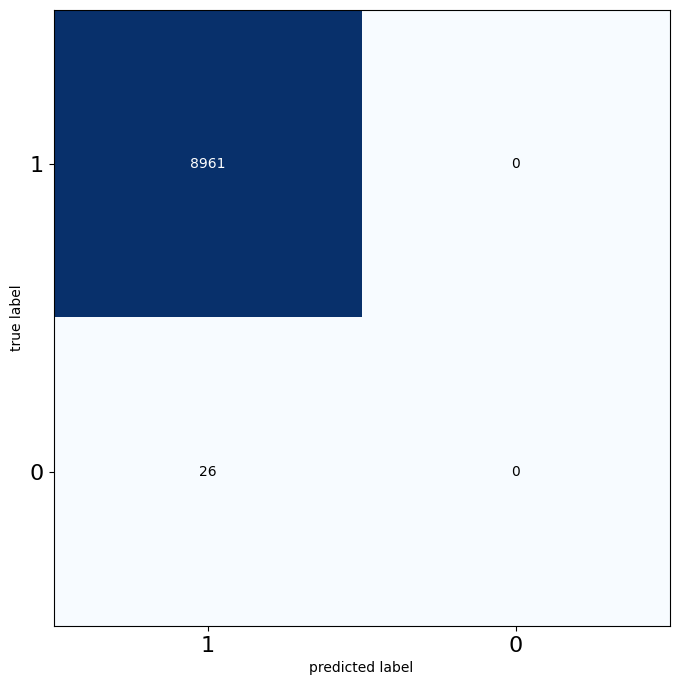

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


HIV-Aids
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

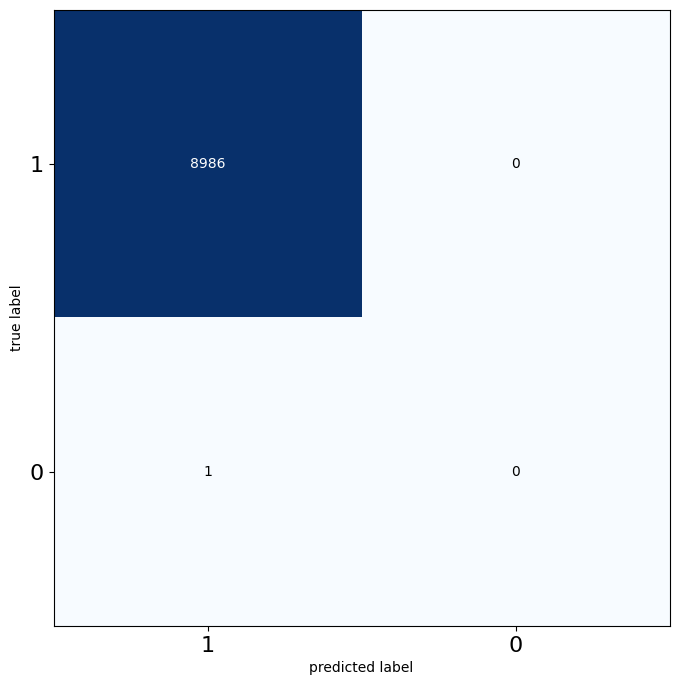

Hair Accessories
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

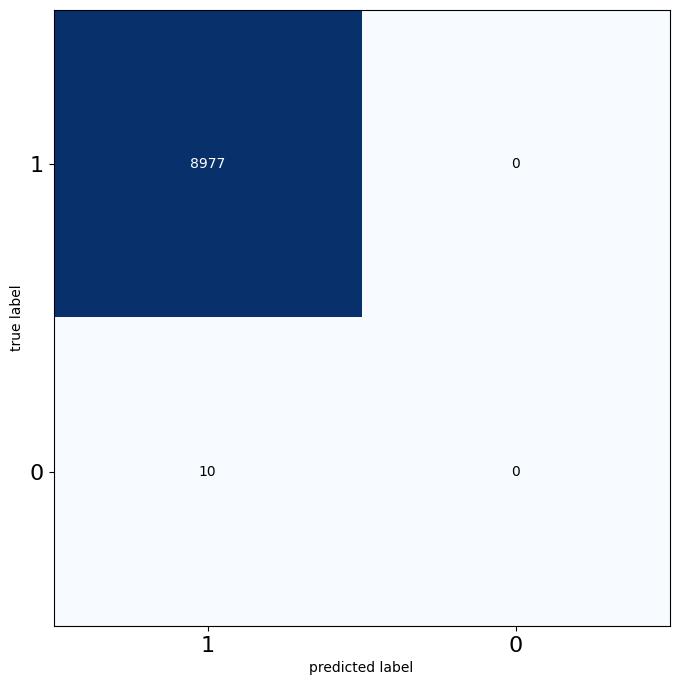

Hair Care
accuracy: 0.9965505730499611 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

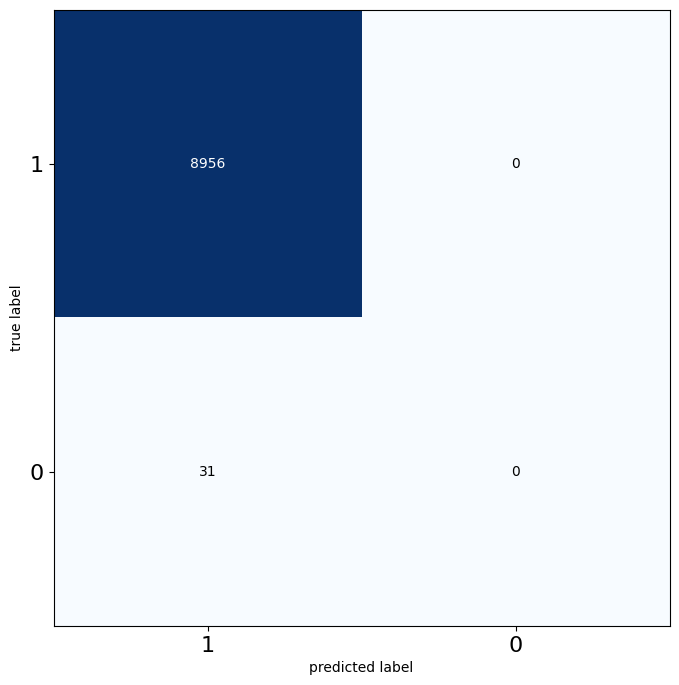

Hairdressing Equipment & Supplies
accuracy: 0.9947702236563926 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

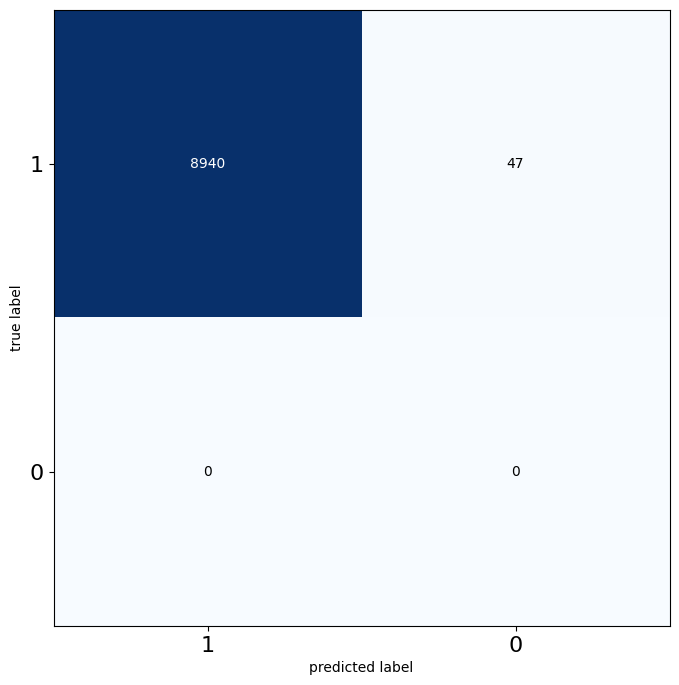

Hairdressing Schools
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

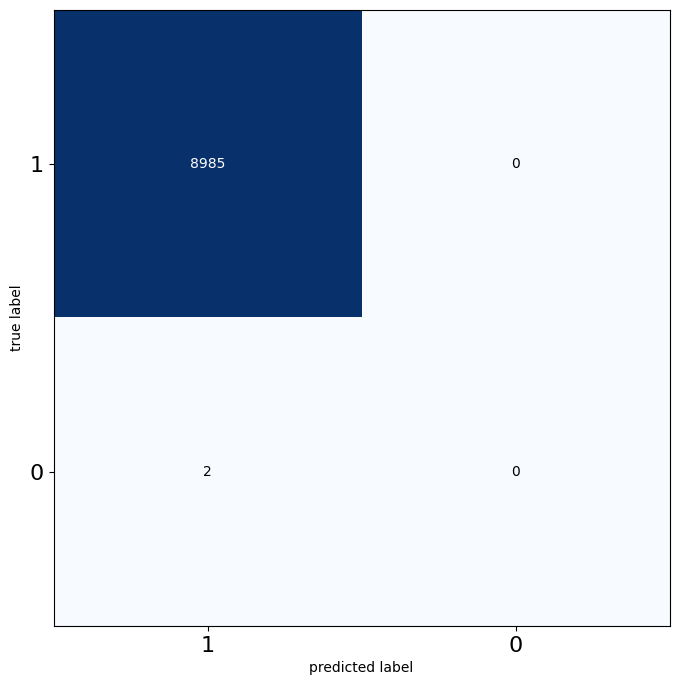

Handicrafts
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

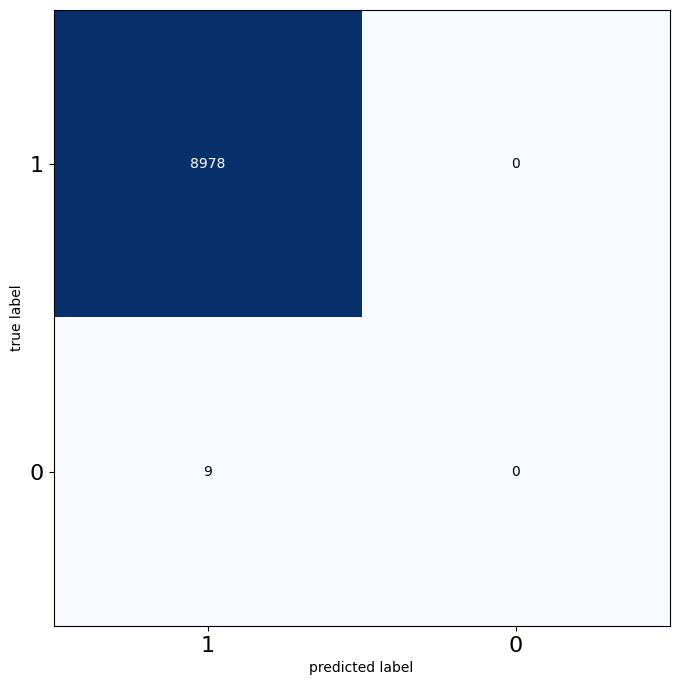

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hardware - Manufacturers & Wholesalers
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

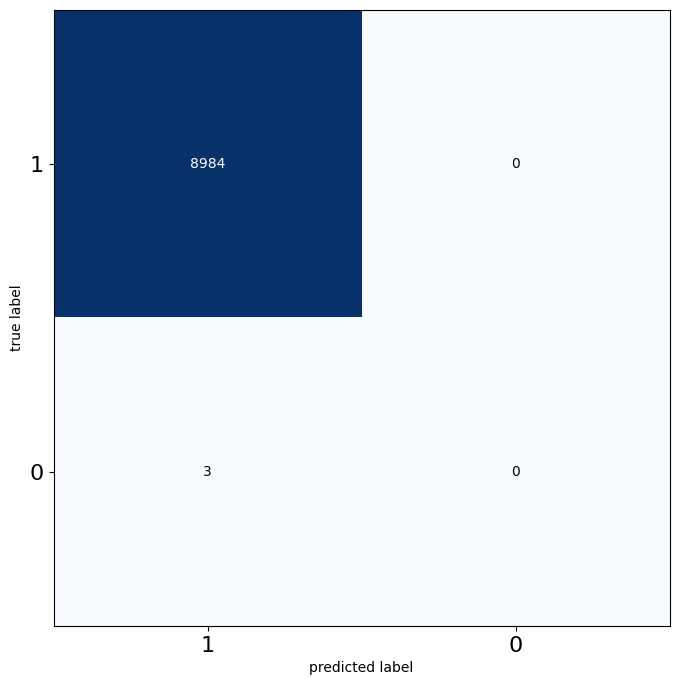

Hardware-Retail
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

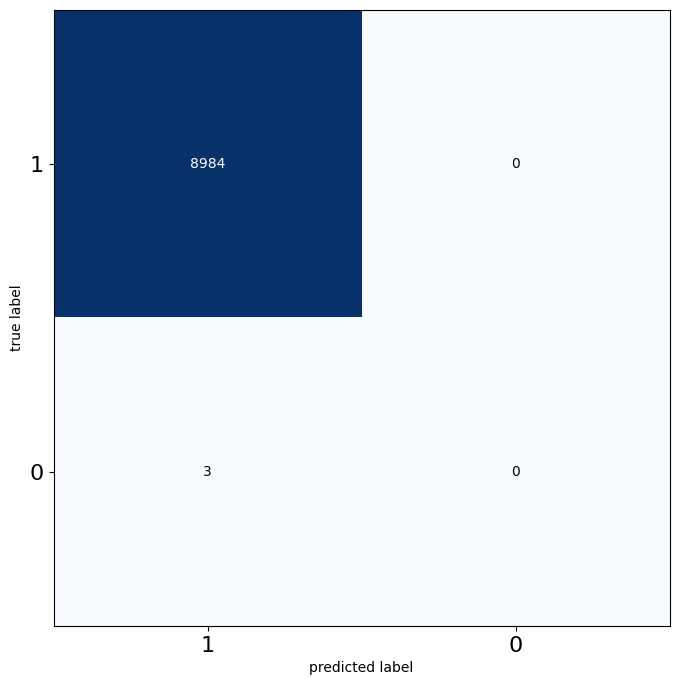

Health
accuracy: 0.9182151997329476 precision: 0.09090909090909091 recall: 0.005722460658082976 f1: 0.010767160161507403


<Figure size 640x480 with 0 Axes>

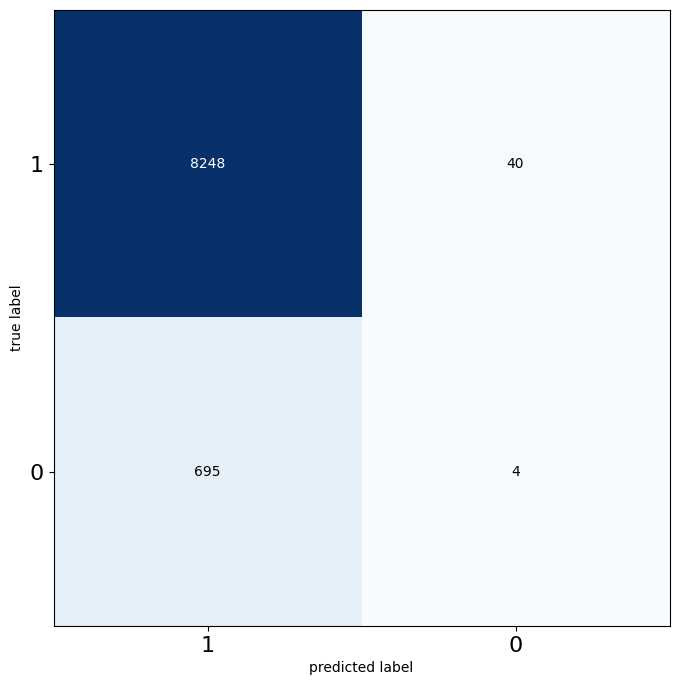

Health Care
accuracy: 0.9965505730499611 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

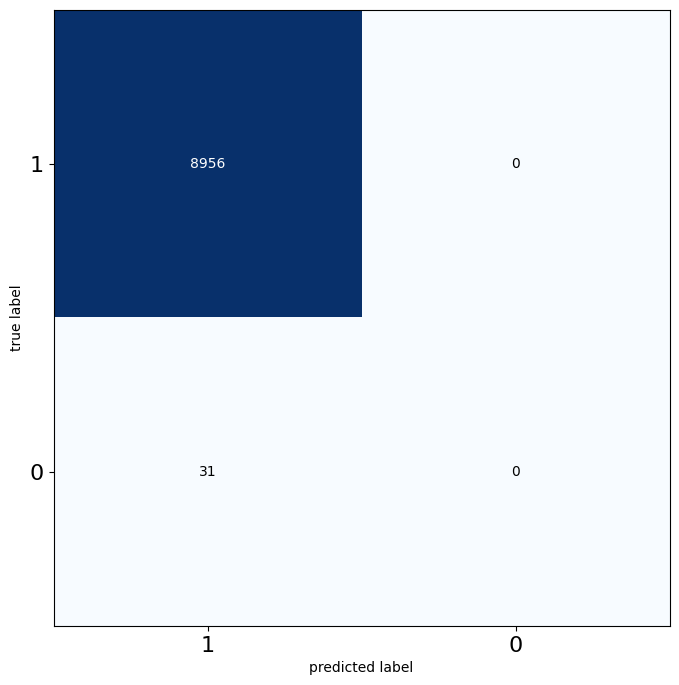

Health Care Products
accuracy: 0.9984421942806275 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

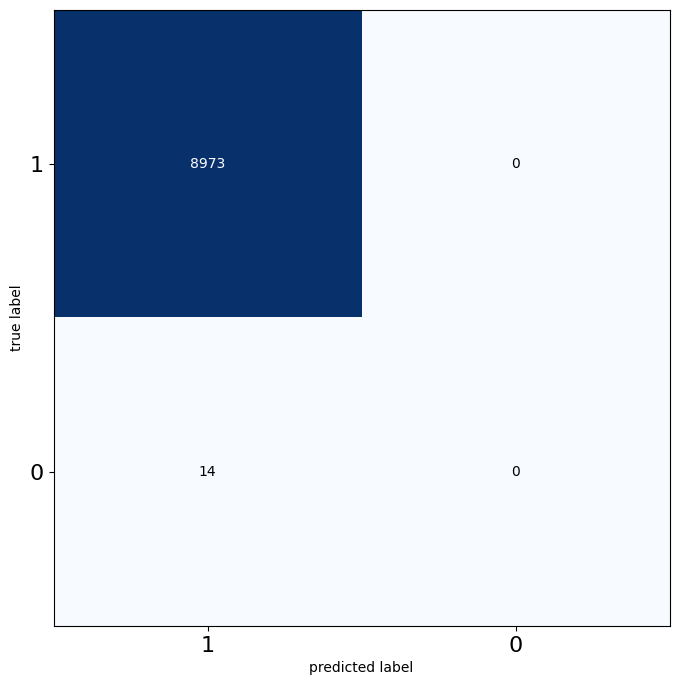

Health Centres
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

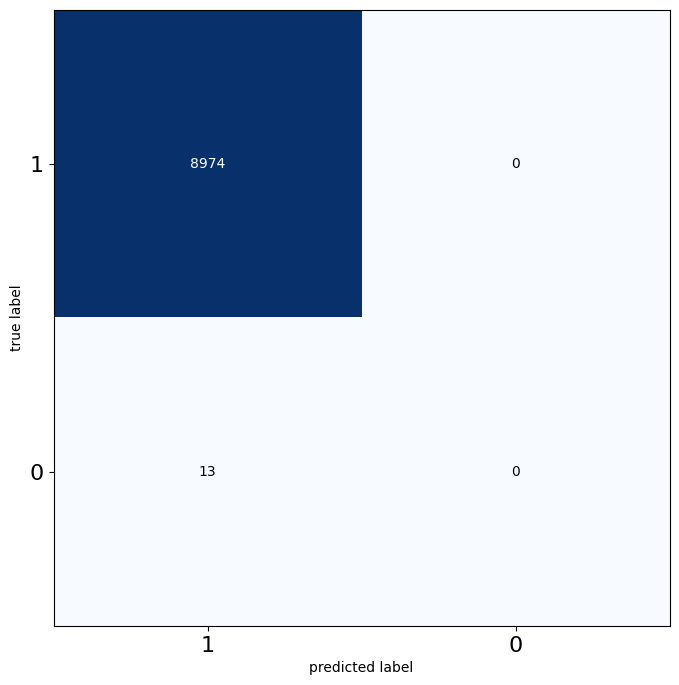

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Health Clubs
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

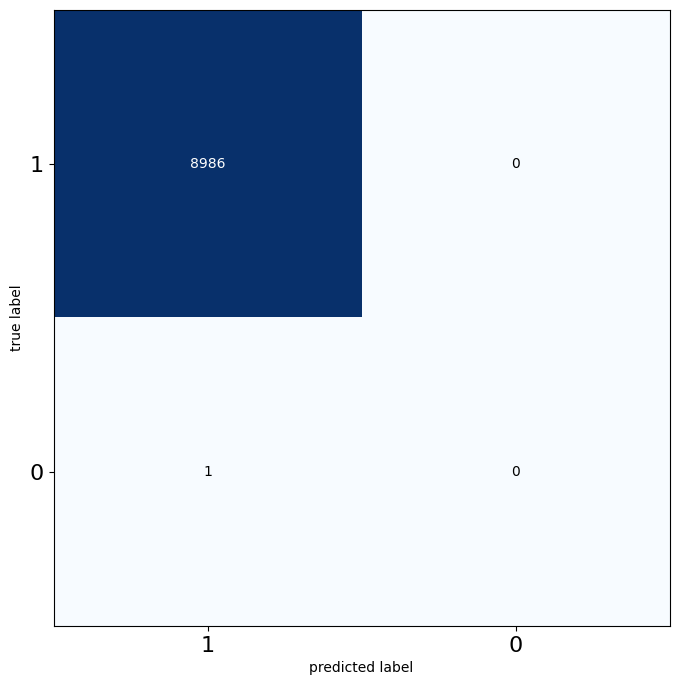

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Health Foods
accuracy: 0.9977745632580394 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

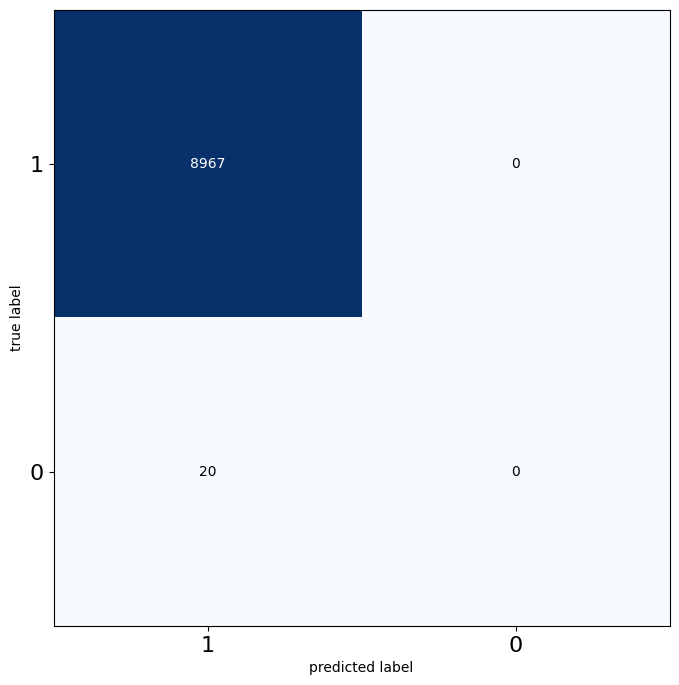

Health Management Organisations
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

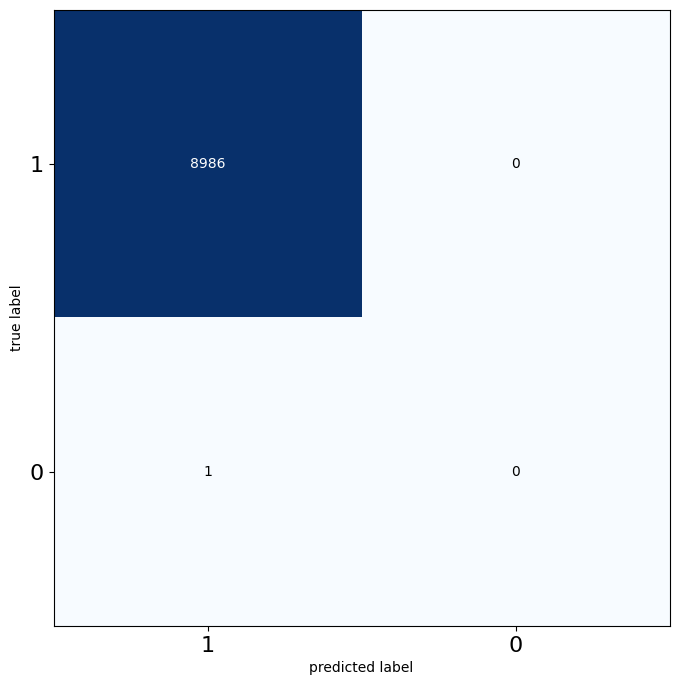

Hearing Aids
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

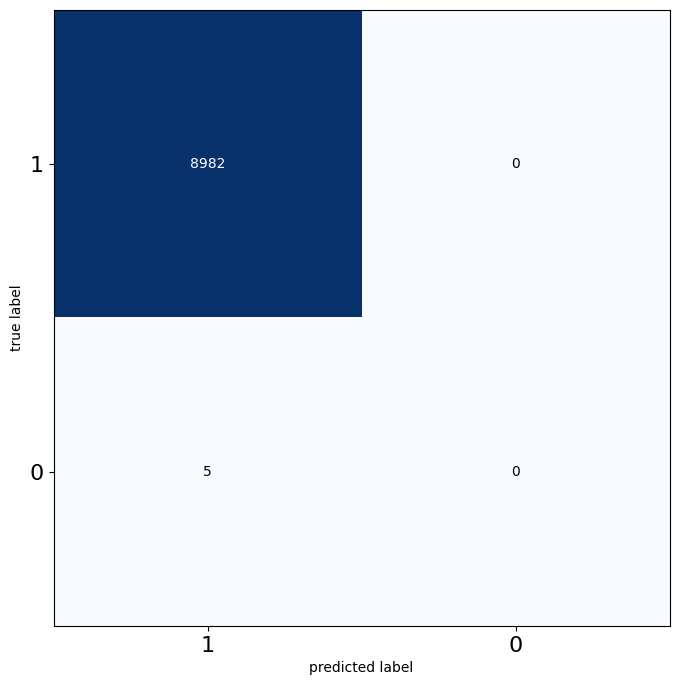

Herbalists
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

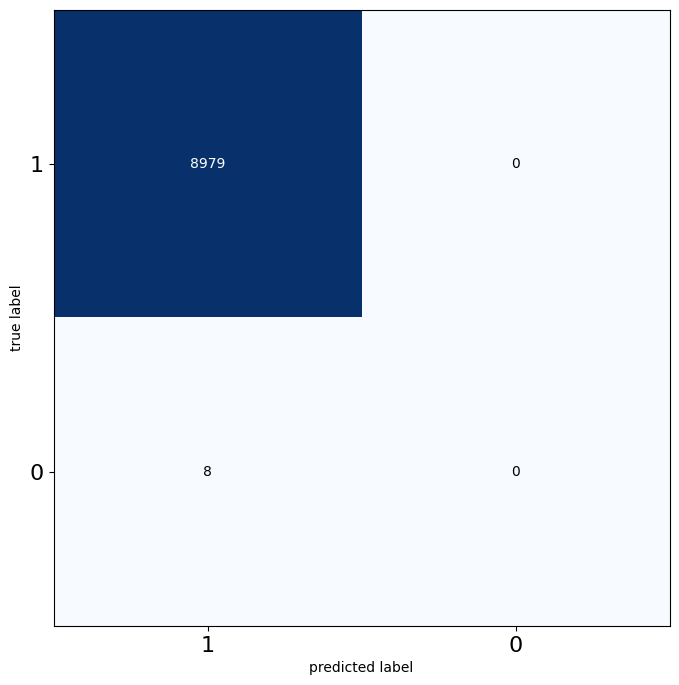

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hire Purchase
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

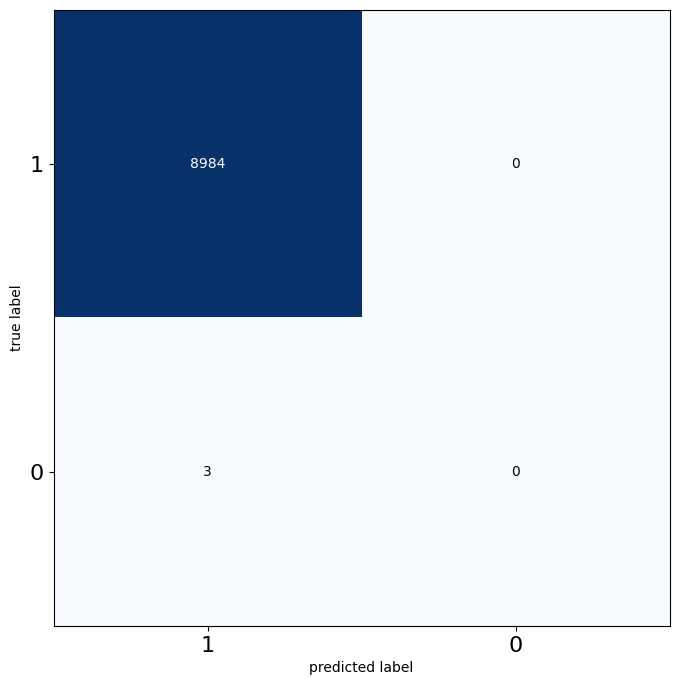

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Honey
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

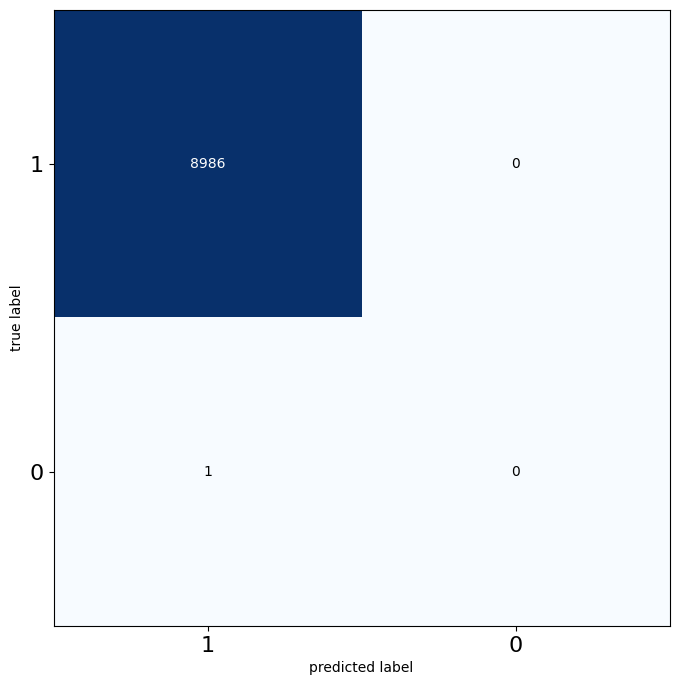

Hospitals
accuracy: 0.9883164571047068 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

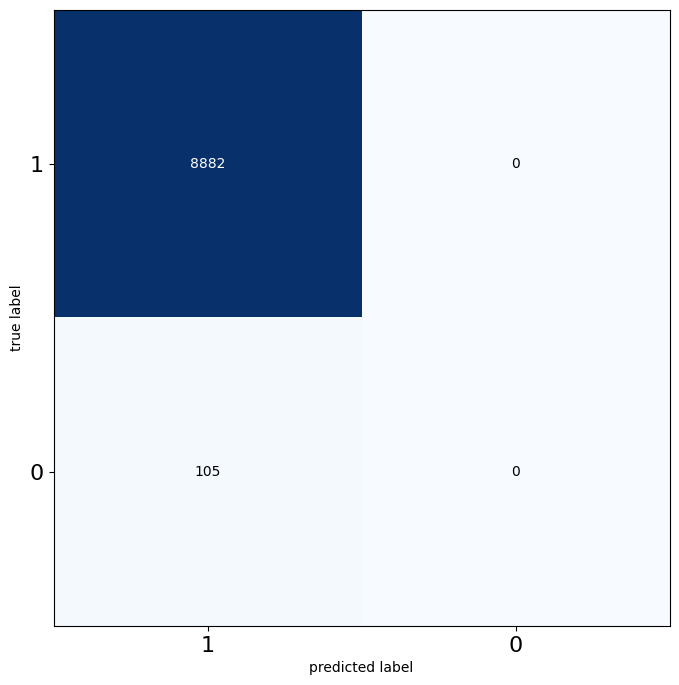

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hostels
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

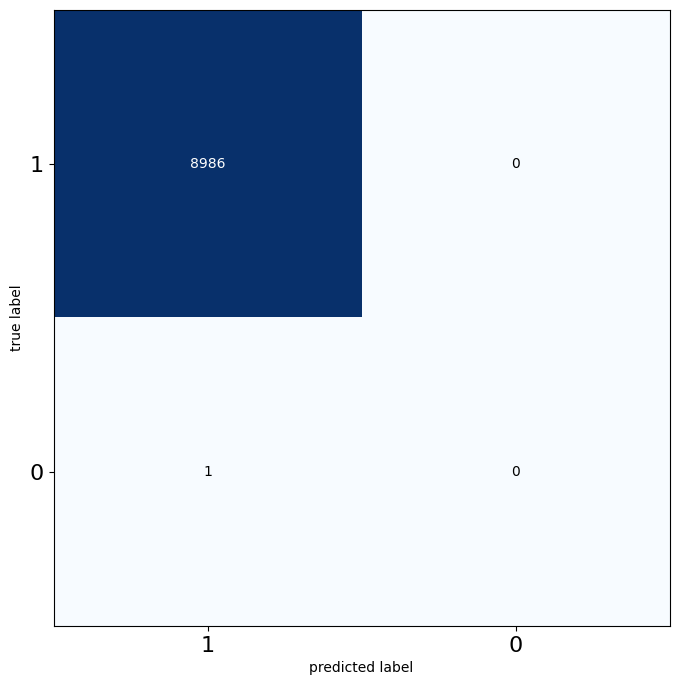

Hotel Locks & Safes
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

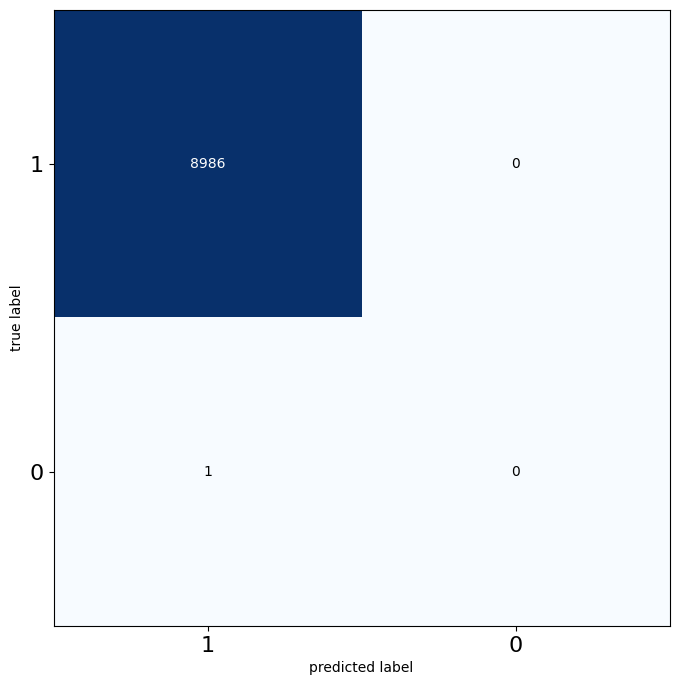

Hotels
accuracy: 0.9834204962723935 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

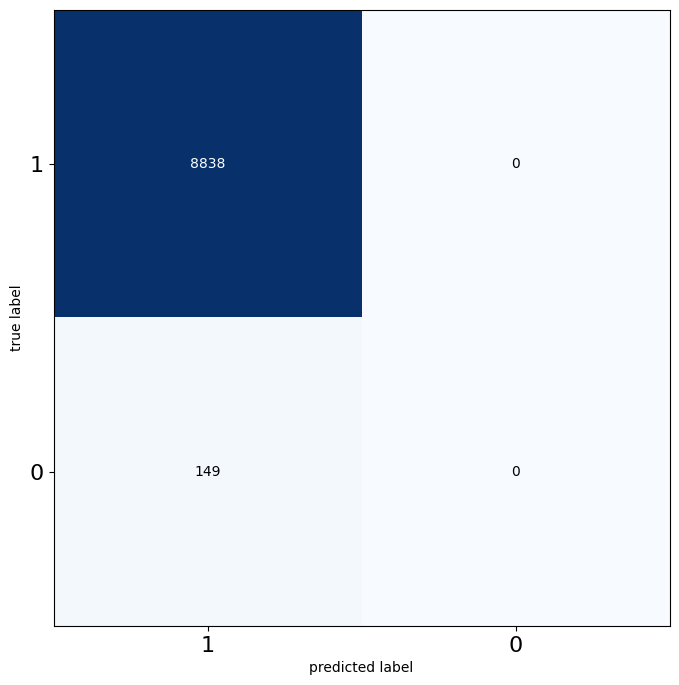

Household Appliances
accuracy: 0.9862022921998442 precision: 0.009523809523809525 recall: 0.047619047619047616 f1: 0.015873015873015876


<Figure size 640x480 with 0 Axes>

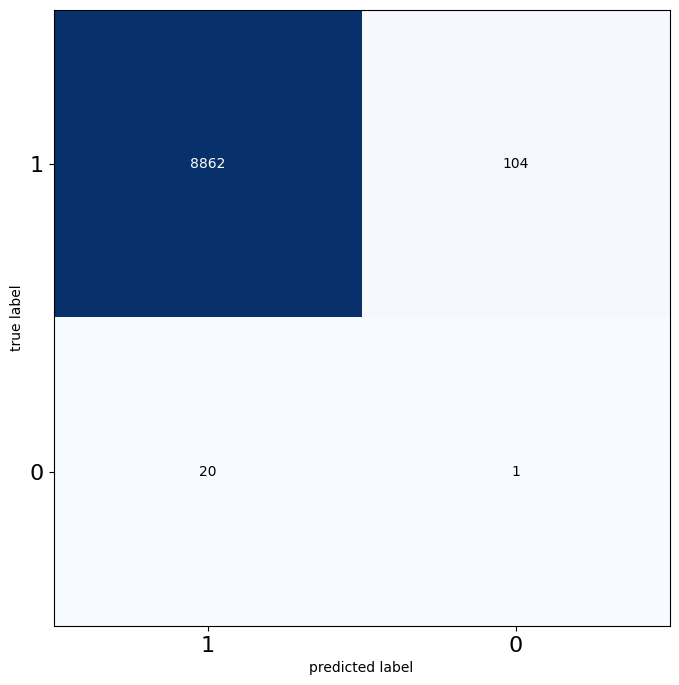

Housewares-Retail
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

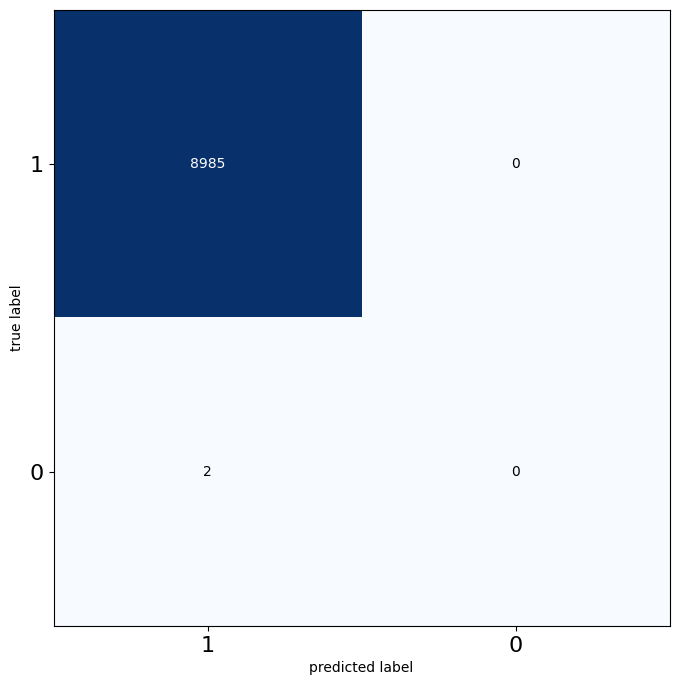

Human Resources Consultants
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

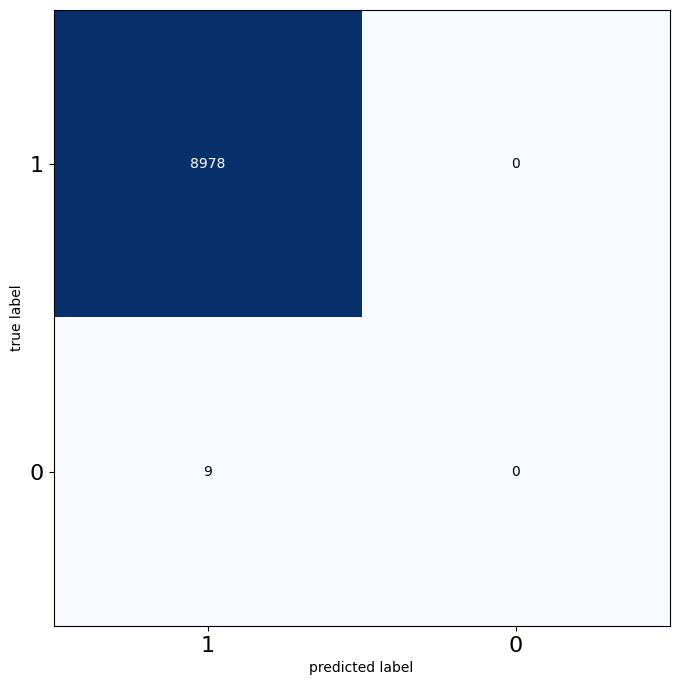

Ice Cream Parlours
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

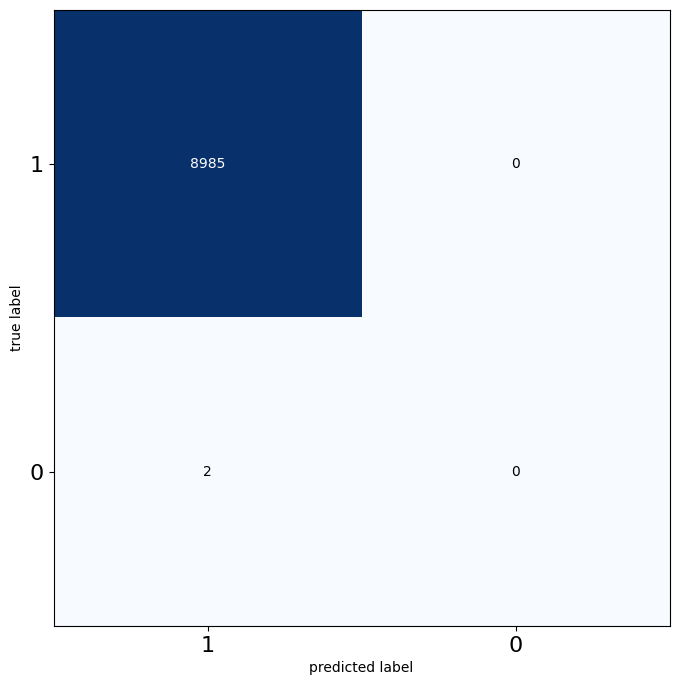

Identification Cards
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

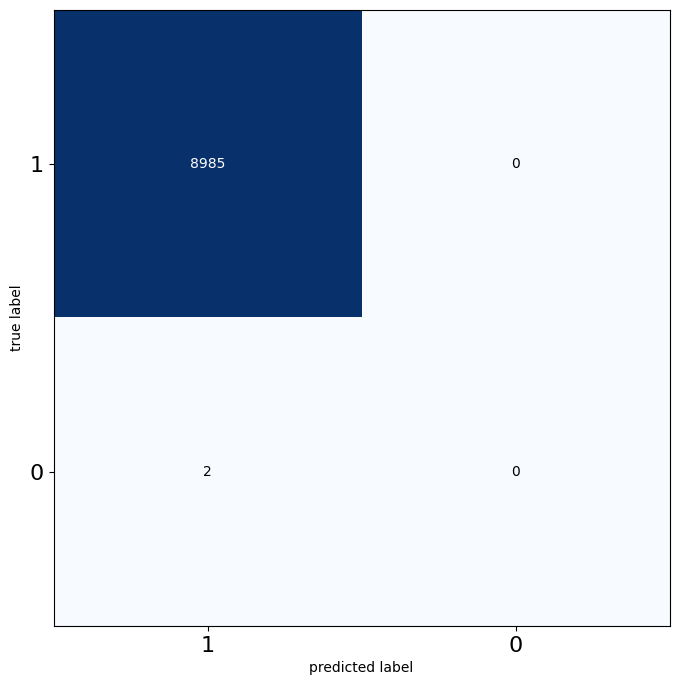

Importers & Exporters
accuracy: 0.9969956603983532 precision: 0.4444444444444444 recall: 0.15384615384615385 f1: 0.2285714285714286


<Figure size 640x480 with 0 Axes>

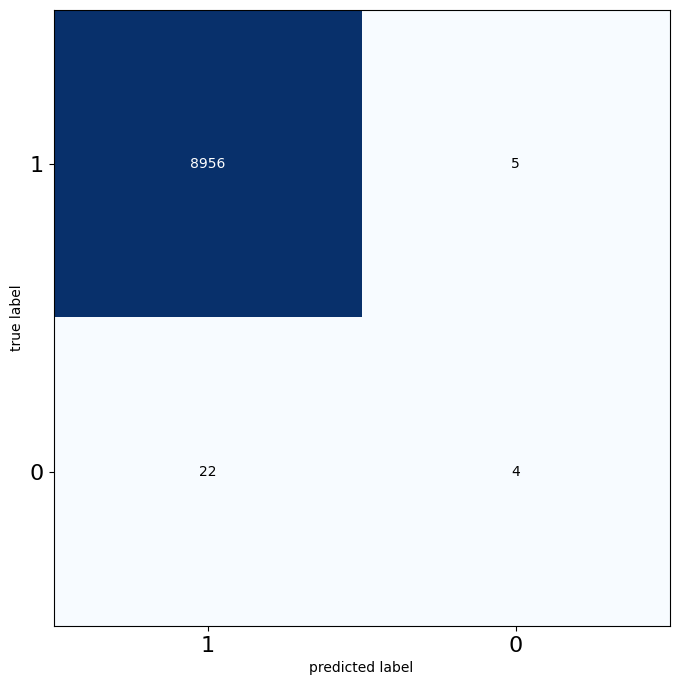

Industrial Chemicals
accuracy: 0.9937687771225103 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

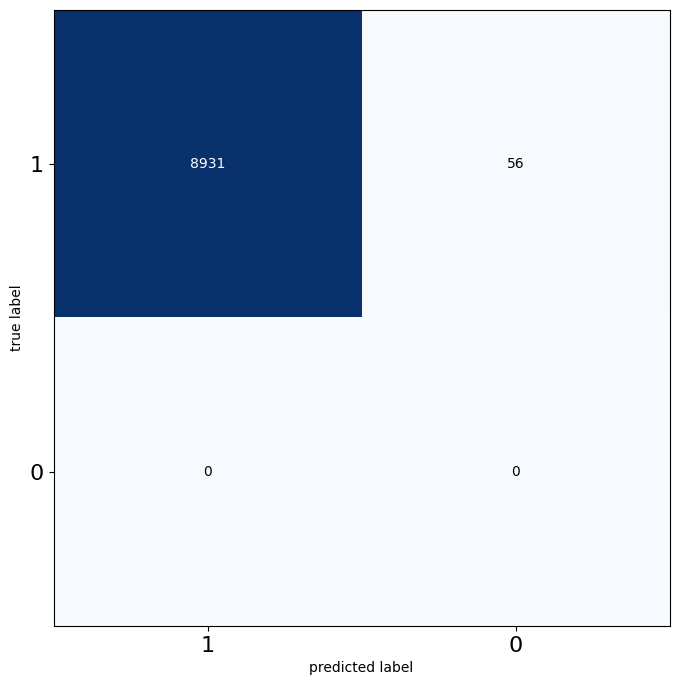

Industrial Consultants
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

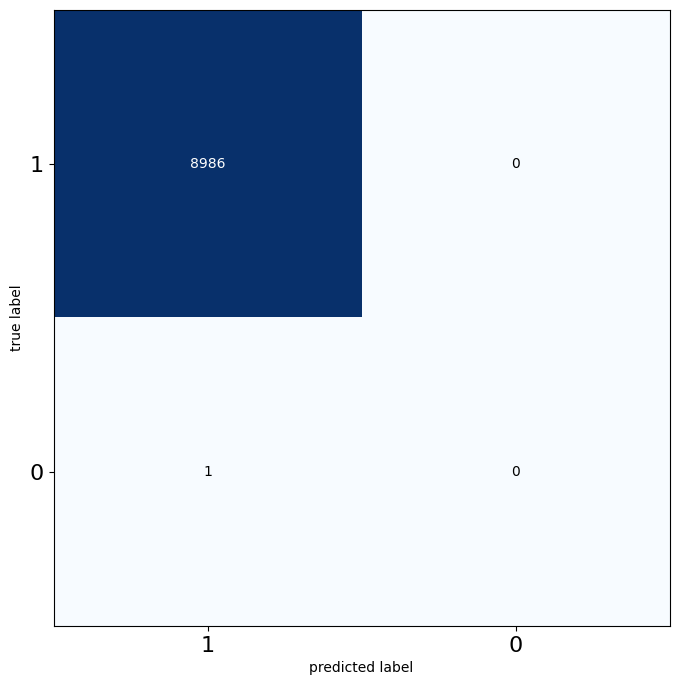

Industrial Equipment & Supplies
accuracy: 0.9981083787693334 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

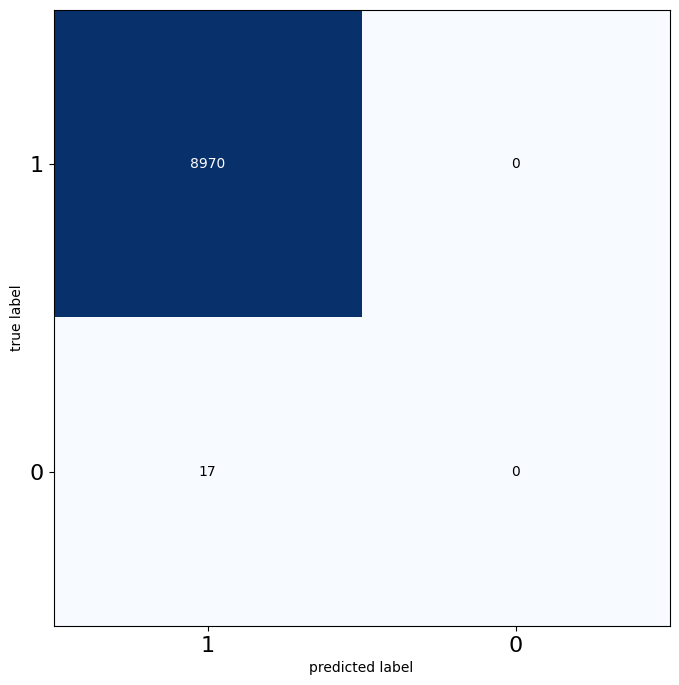

Industrial Products
accuracy: 0.9640591966173362 precision: 0.045454545454545456 recall: 0.10679611650485436 f1: 0.06376811594202898


<Figure size 640x480 with 0 Axes>

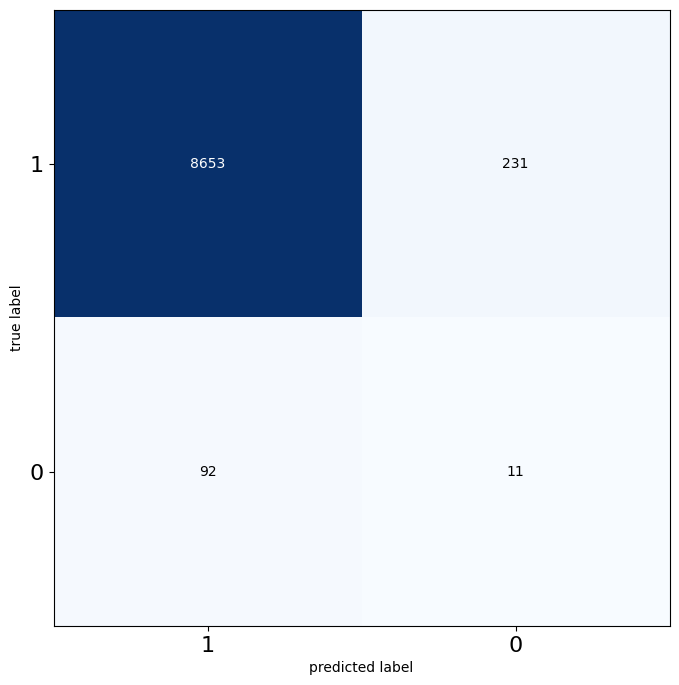

Information & Communication Technology Services
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

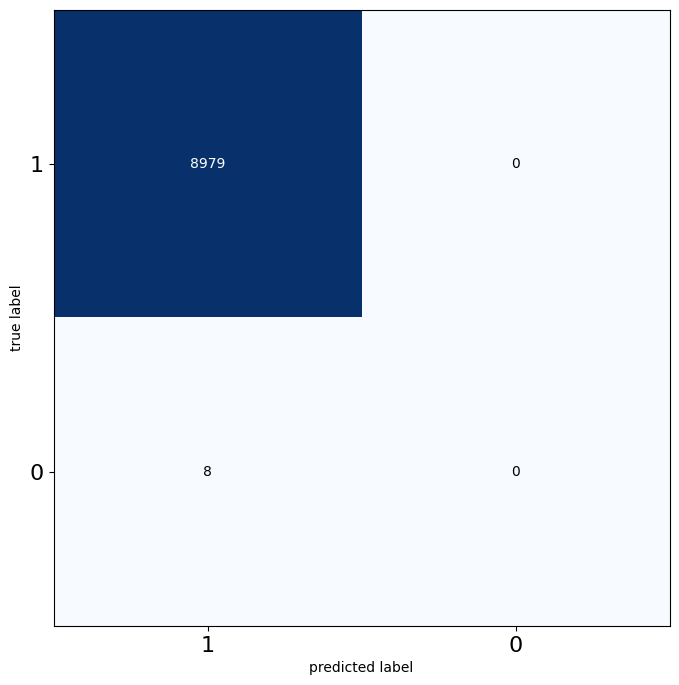

Information Agencies
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

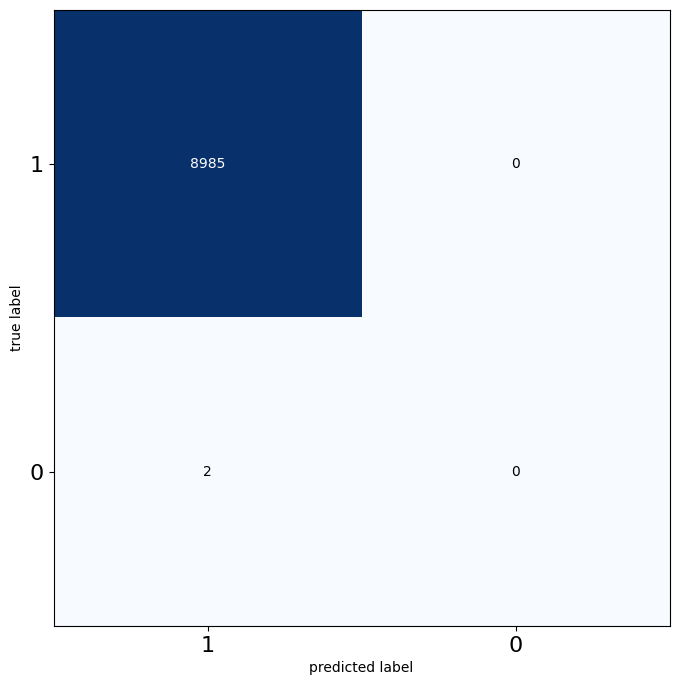

Information Systems Consultants
accuracy: 0.9983309224435295 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

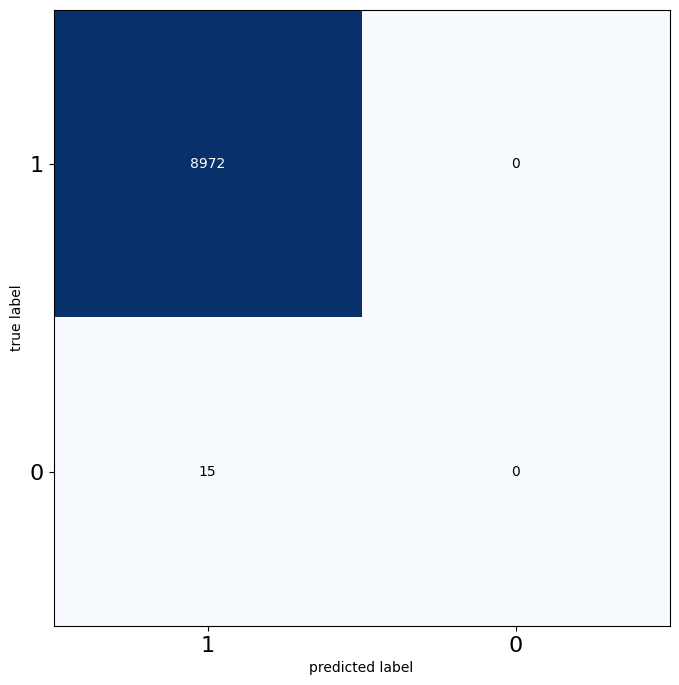

Inns
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

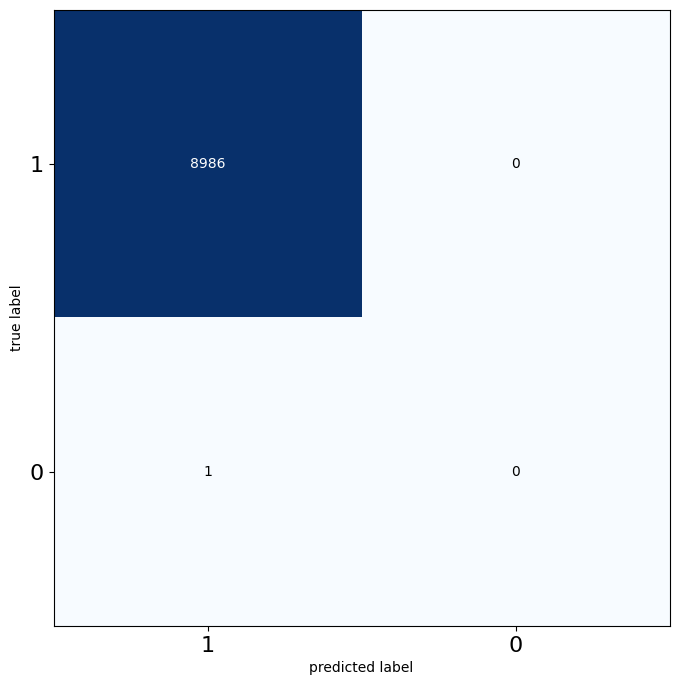

Insecticides
accuracy: 0.9947702236563926 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

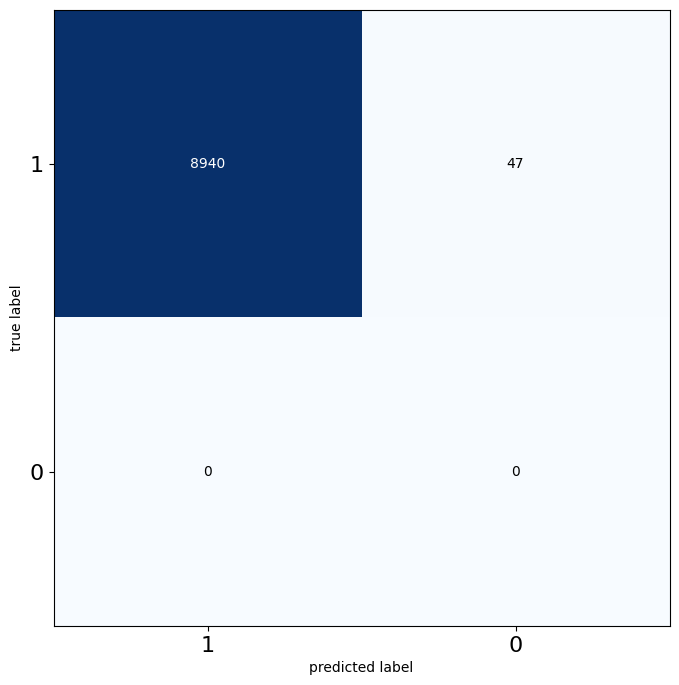

Inspection Services
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

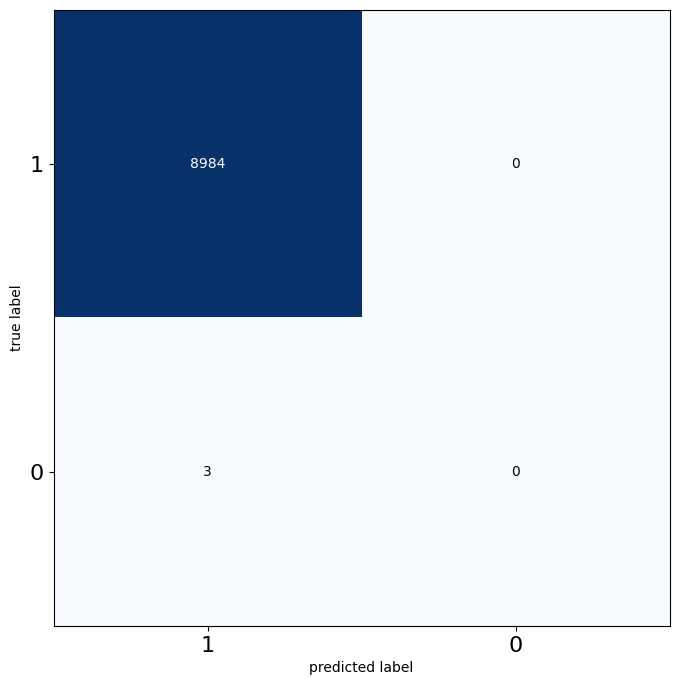

Insulation Contractors
accuracy: 0.9937687771225103 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

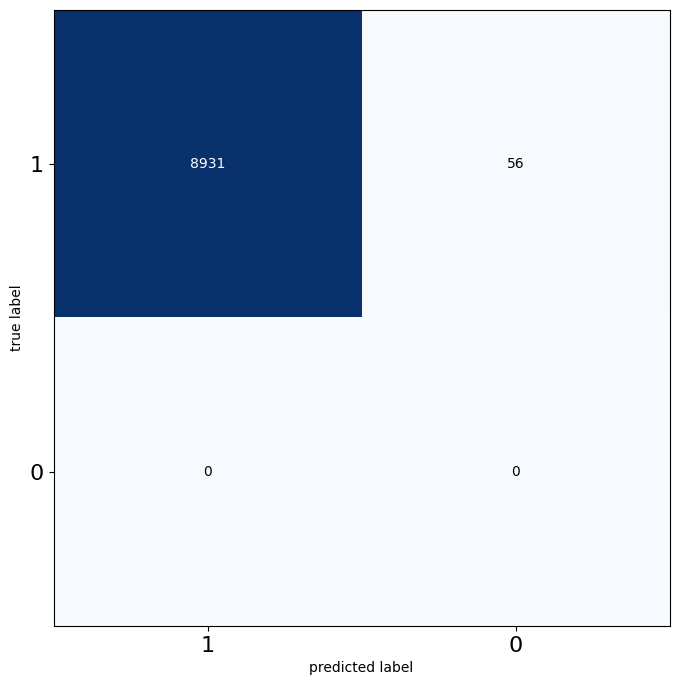

Insurance Brokers & Agents
accuracy: 0.9813063313675309 precision: 0.00819672131147541 recall: 0.020833333333333332 f1: 0.011764705882352943


<Figure size 640x480 with 0 Axes>

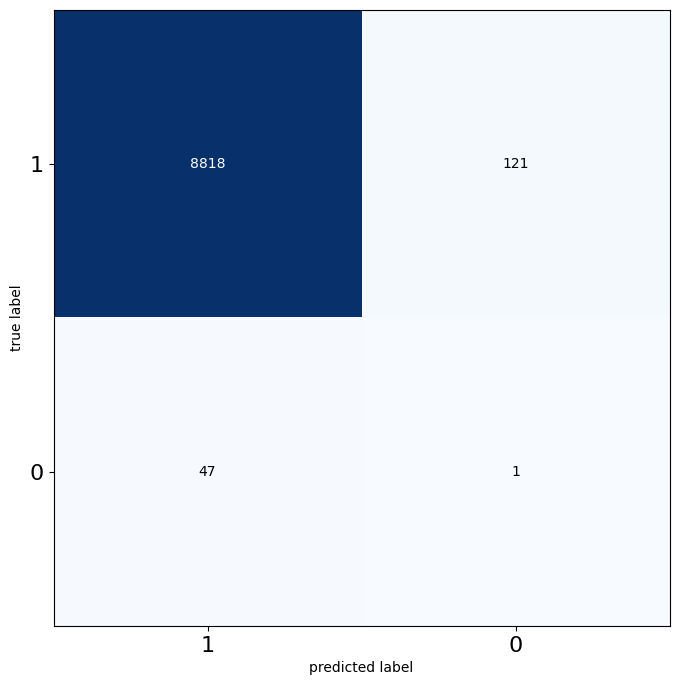

Insurance Companies
accuracy: 0.9900968064982753 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

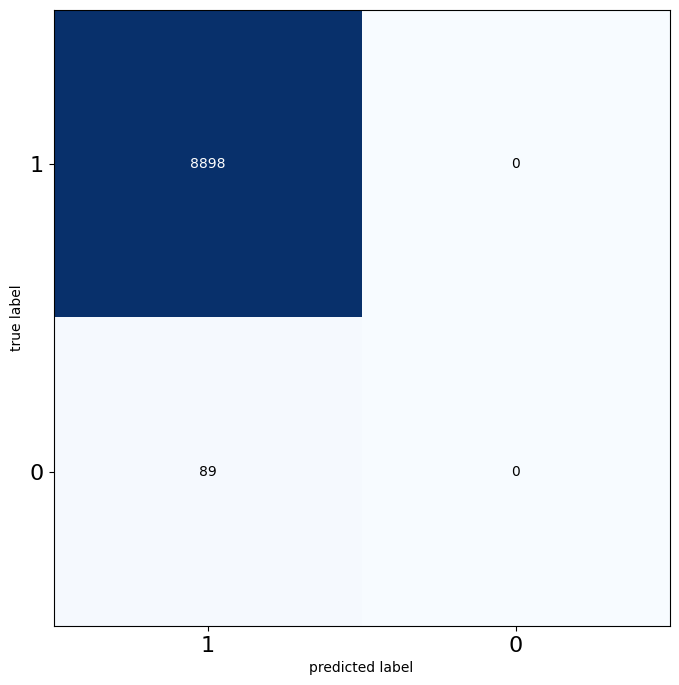

Interior Decorators
accuracy: 0.996105485701569 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

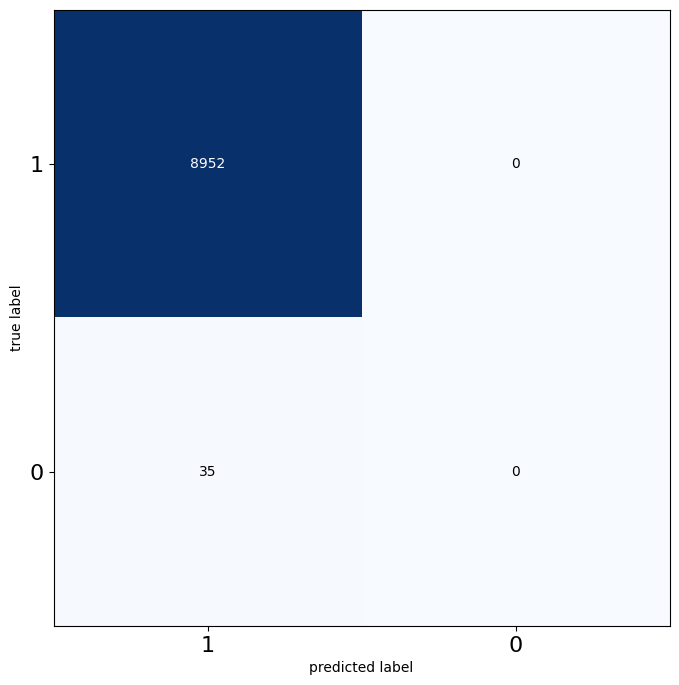

Interior Designers
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

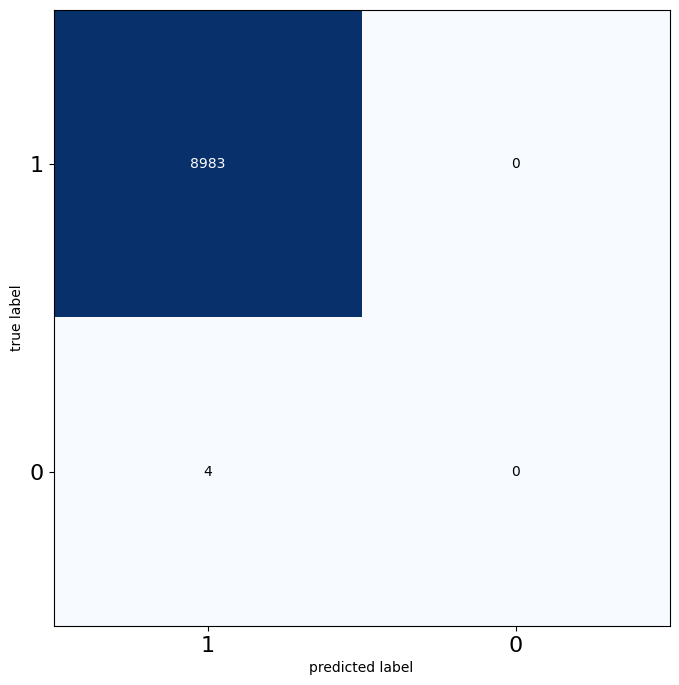

International Organizations
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

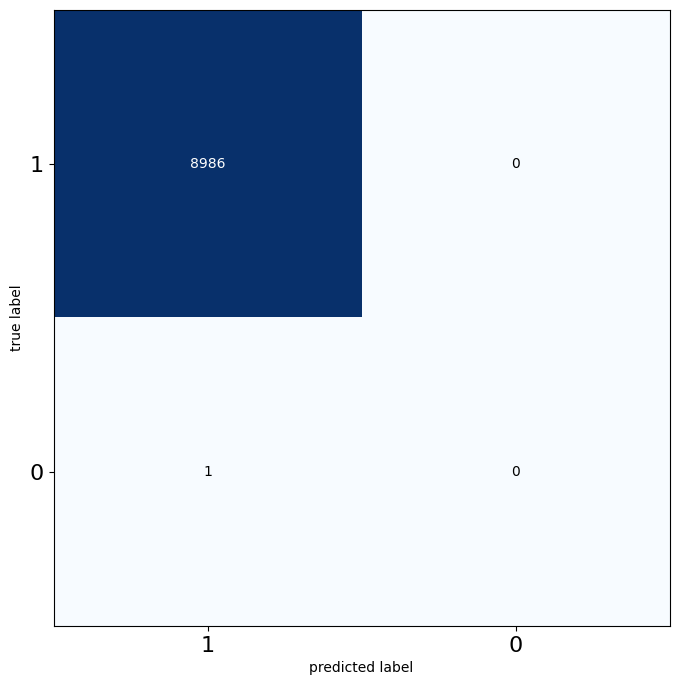

International Schools
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

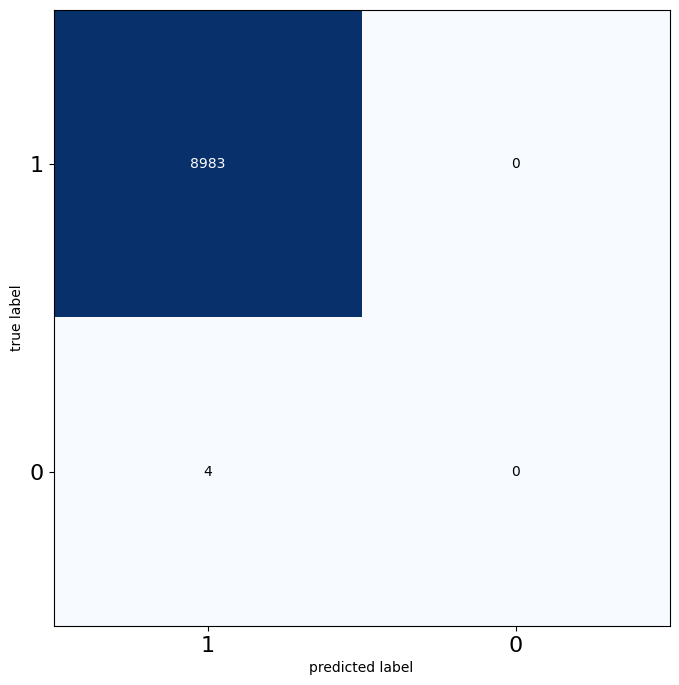

Internet Services
accuracy: 0.9870924668966284 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

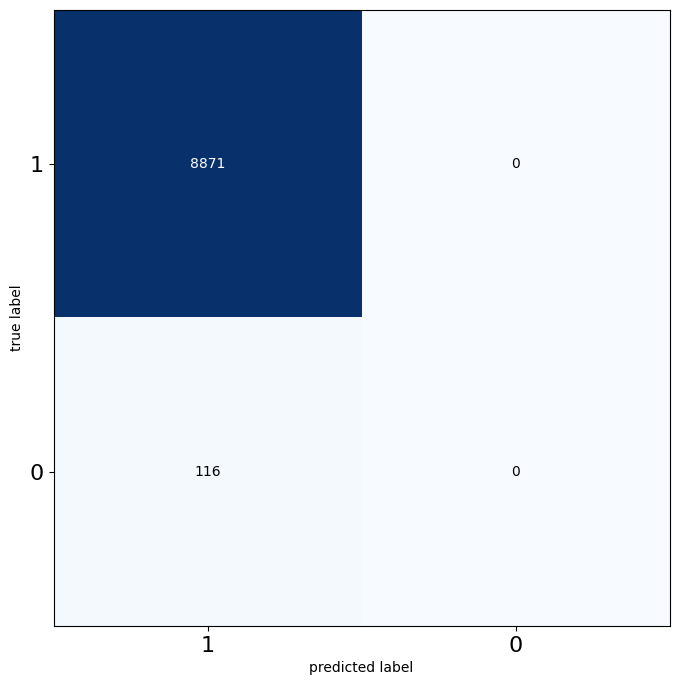

Investigators
accuracy: 0.99265605875153 precision: 0.015625 recall: 0.25 f1: 0.029411764705882353


<Figure size 640x480 with 0 Axes>

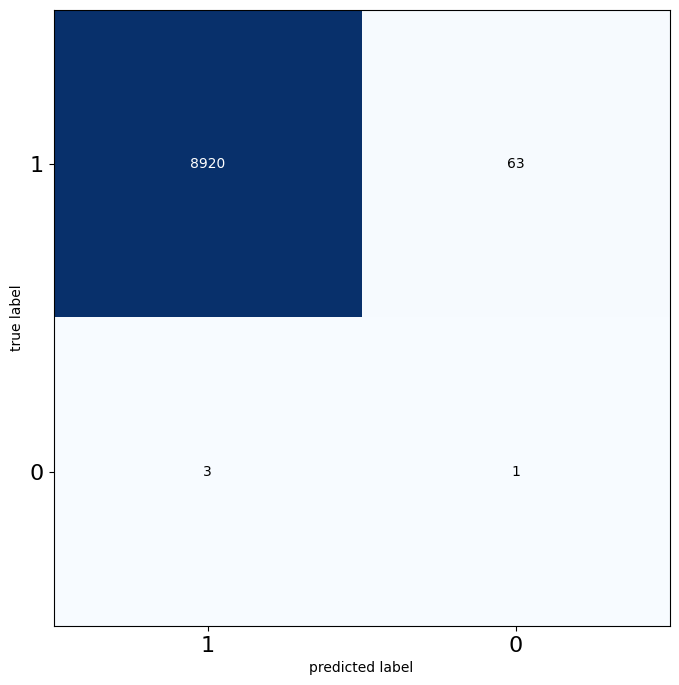

Investment Management
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

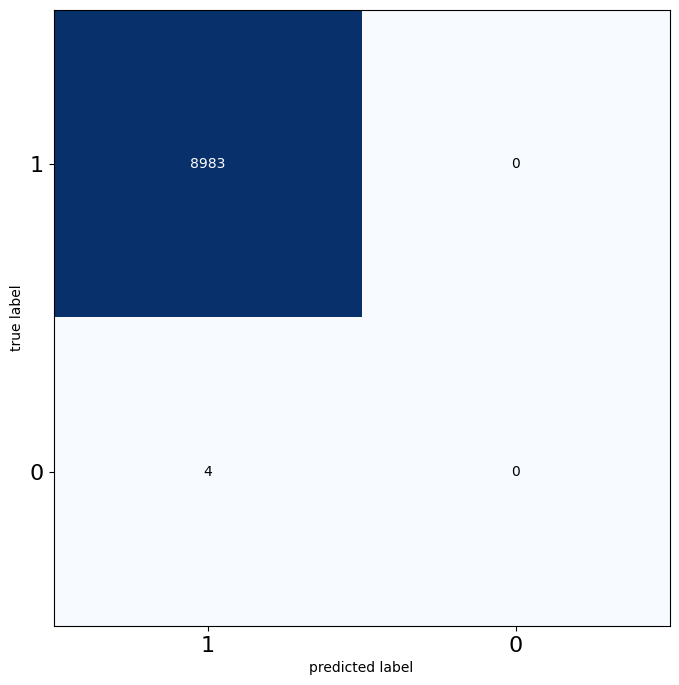

Investment Securities
accuracy: 0.9958829420273728 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

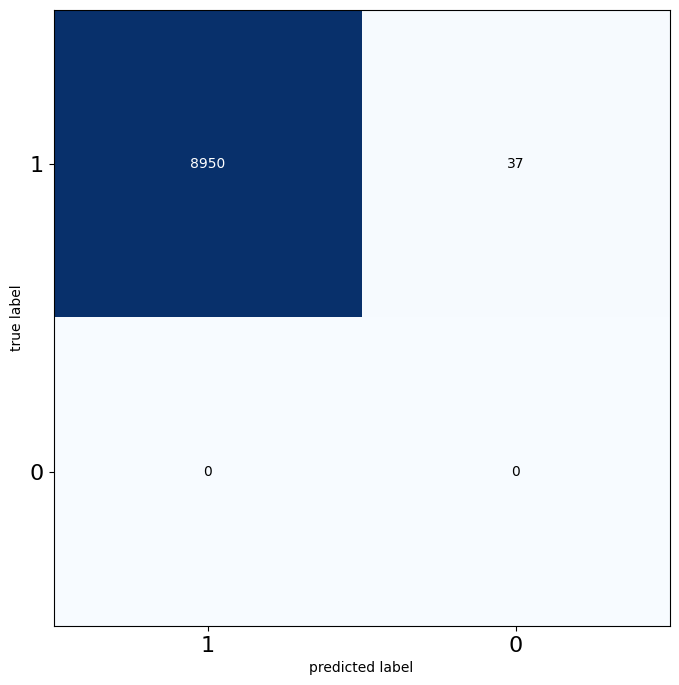

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Investments
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

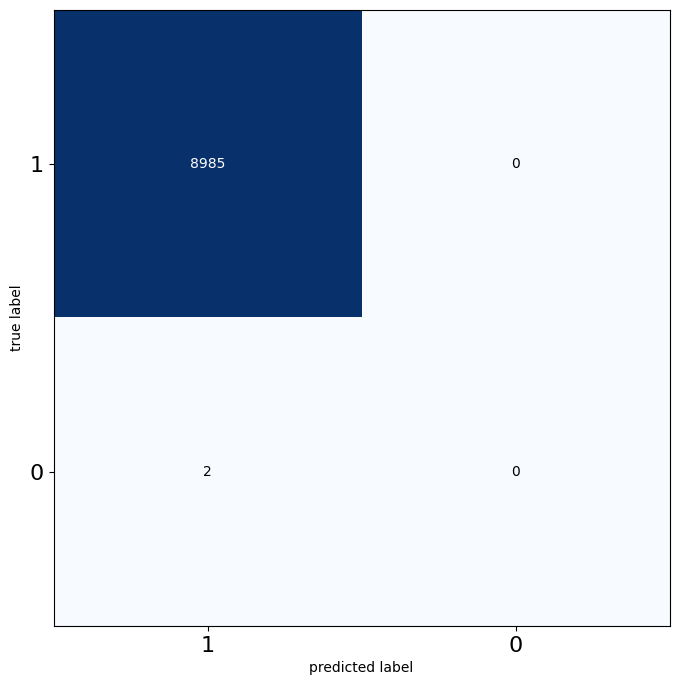

Ironmongers
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

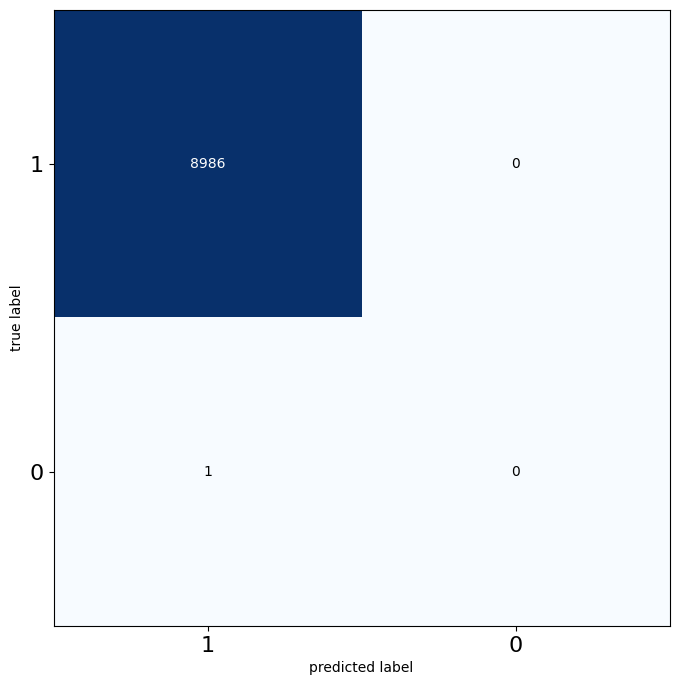

Irrigation Schemes
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

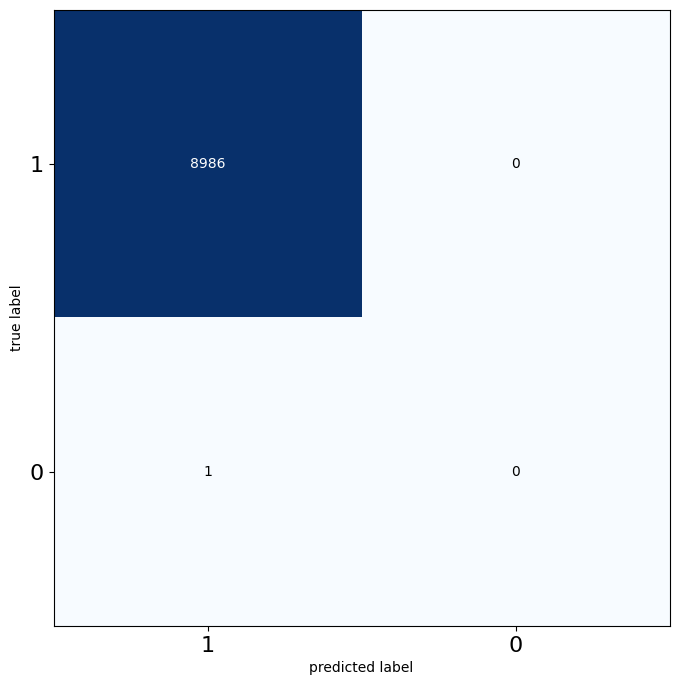

Jewellers
accuracy: 0.996105485701569 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

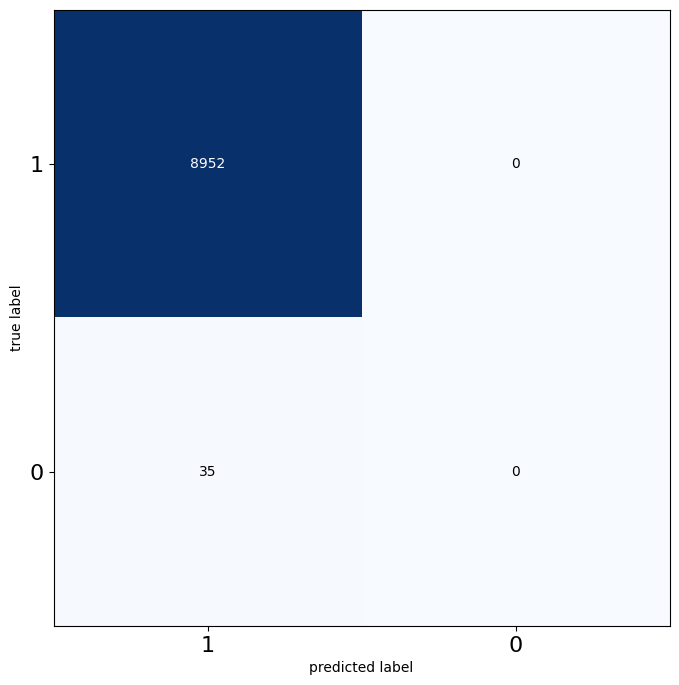

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Joinery Works
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

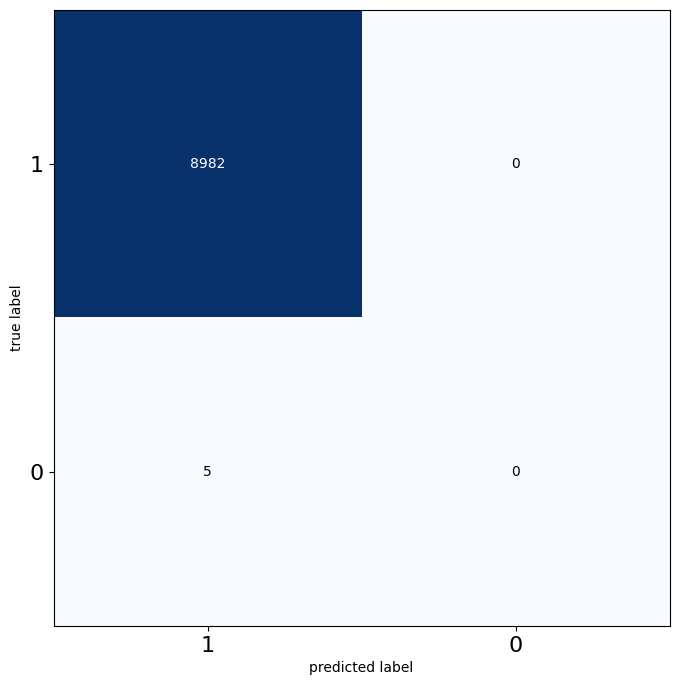

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Key Cutters
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

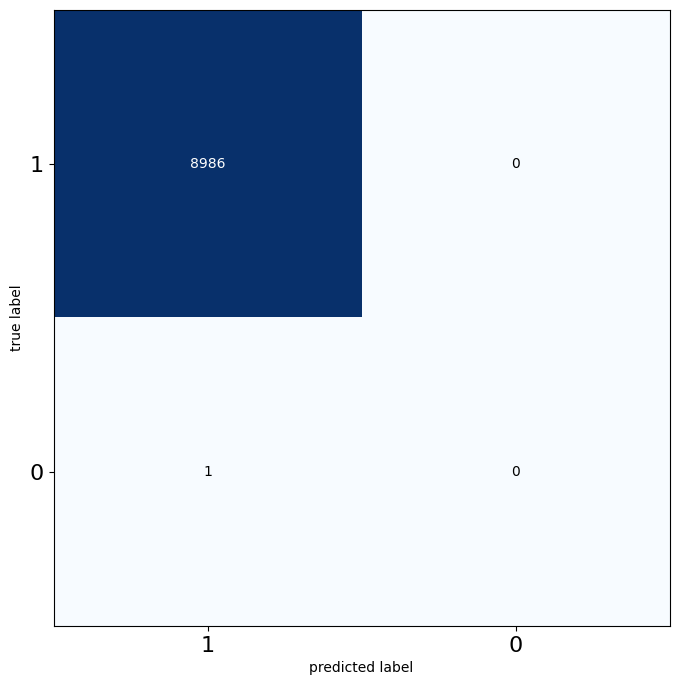

Kindergartens
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

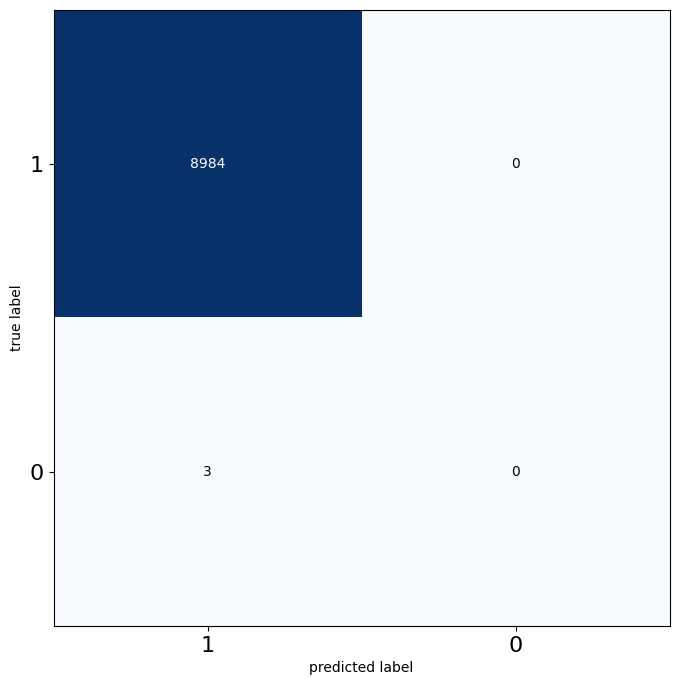

Kitchen Fittings & Fixtures
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

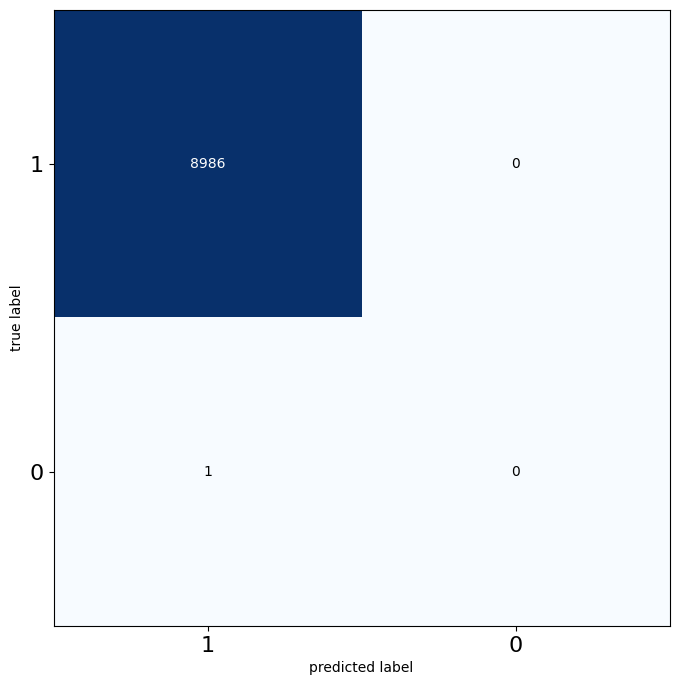

Kitchen Utensils
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

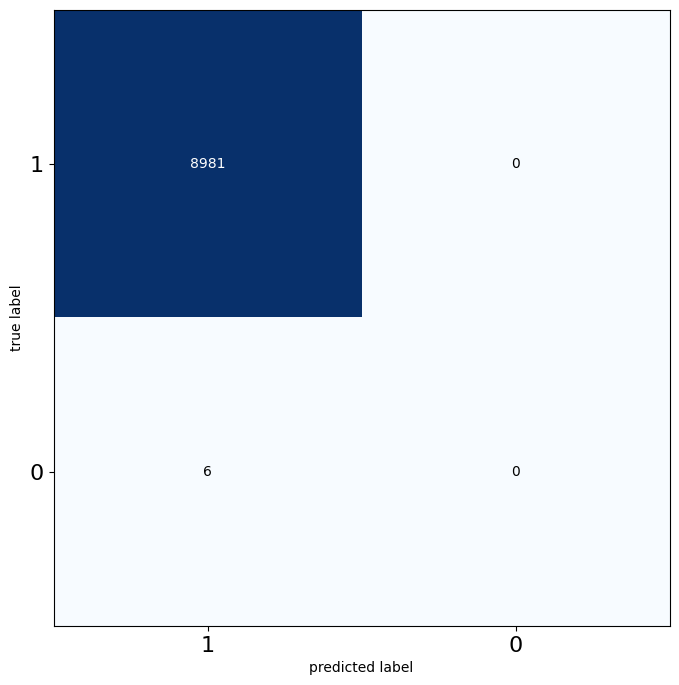

Laboratories - Research & Development
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

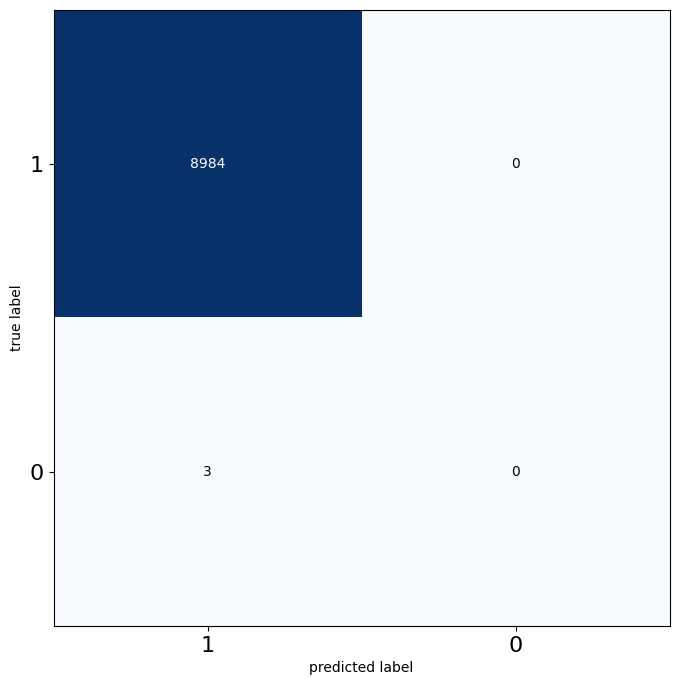

Laboratory Quality Control
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

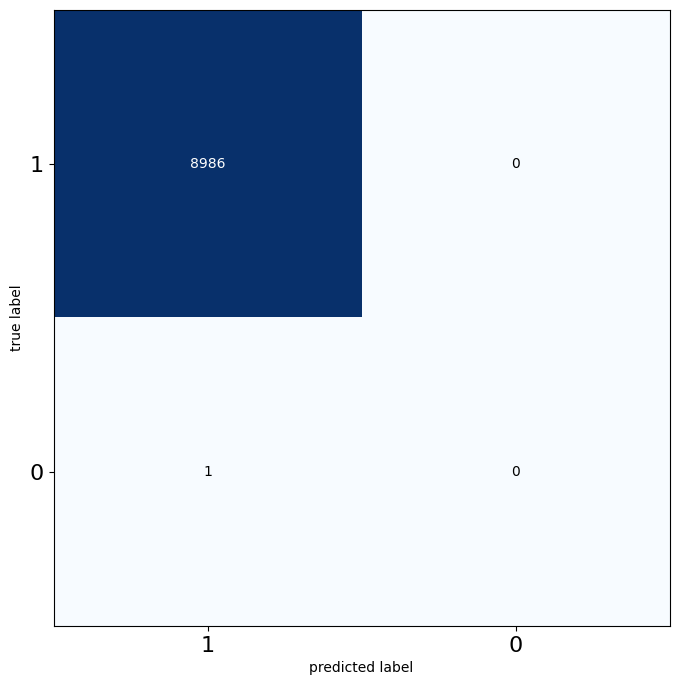

Laboratory Supplies
accuracy: 0.9977745632580394 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

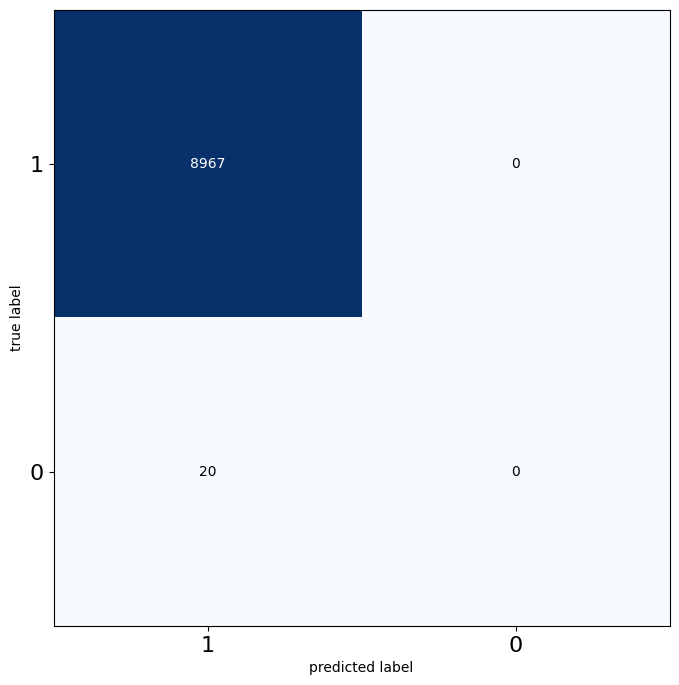

Labour Organizations
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

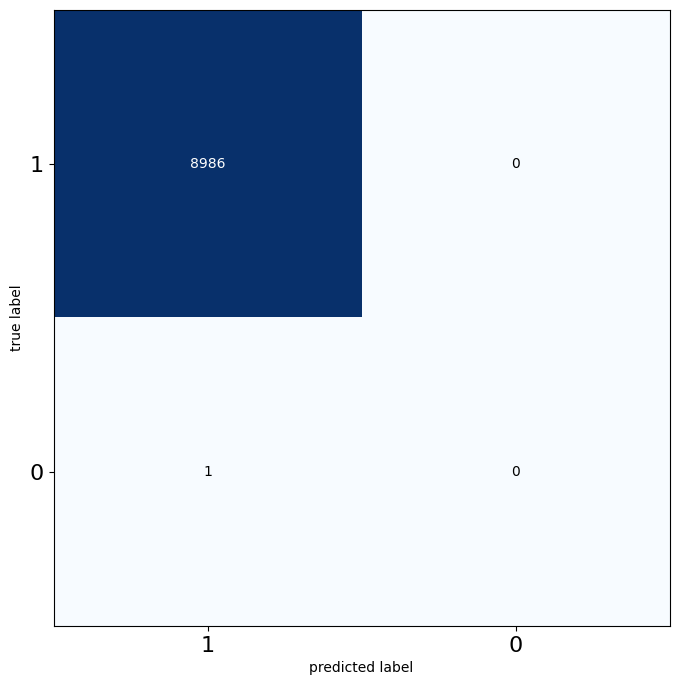

Ladies' Wear
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

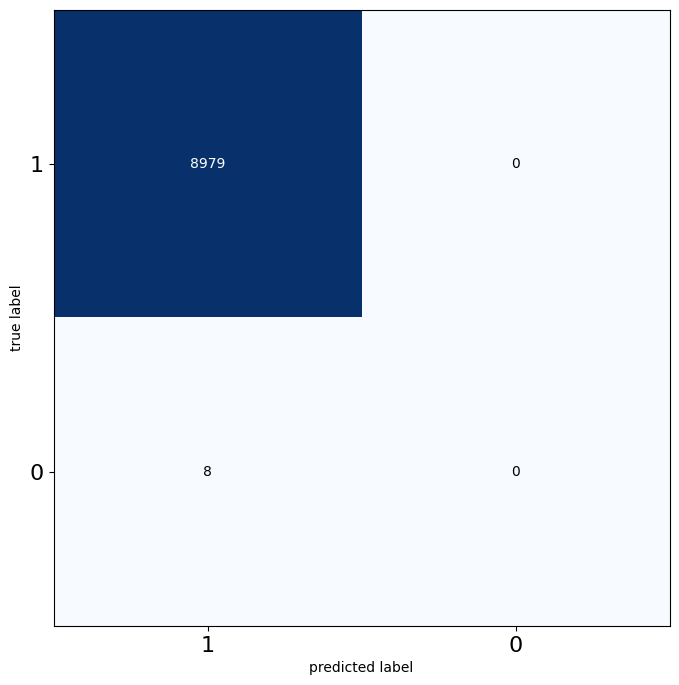

Laminating Service
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

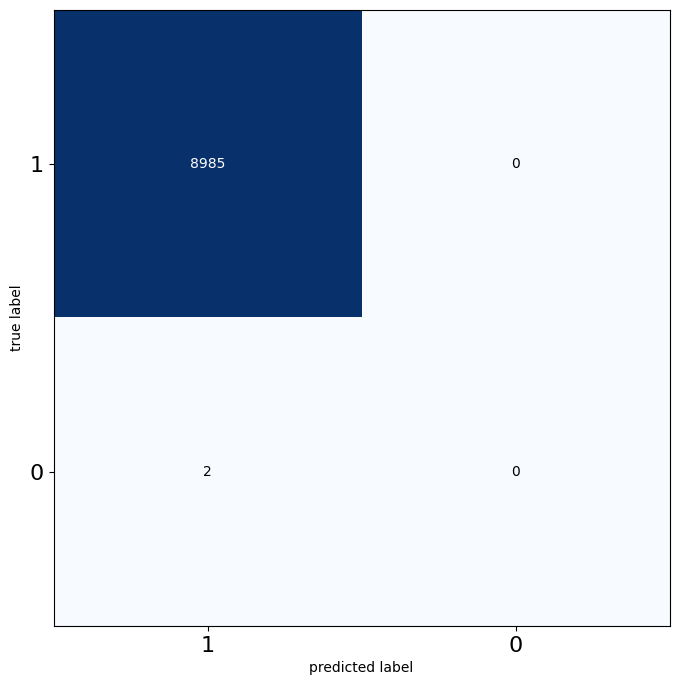

Land Surveyors
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

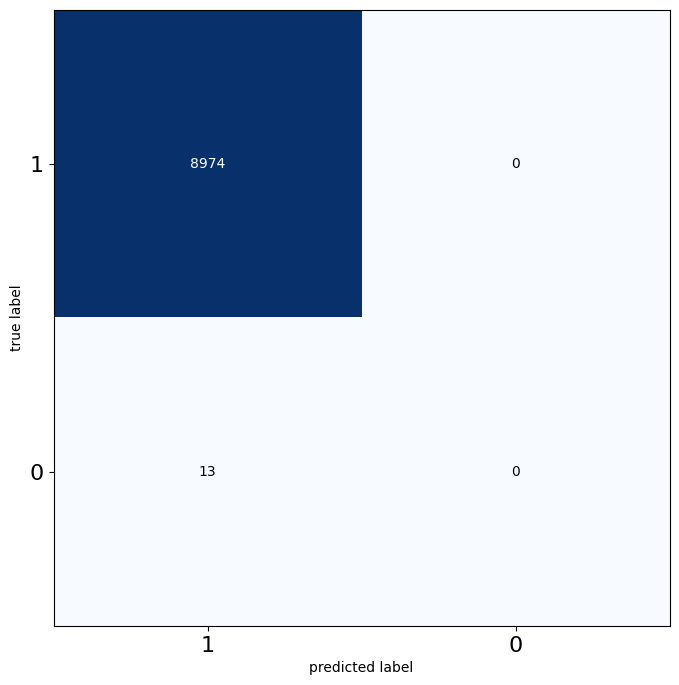

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Landscape Architect
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

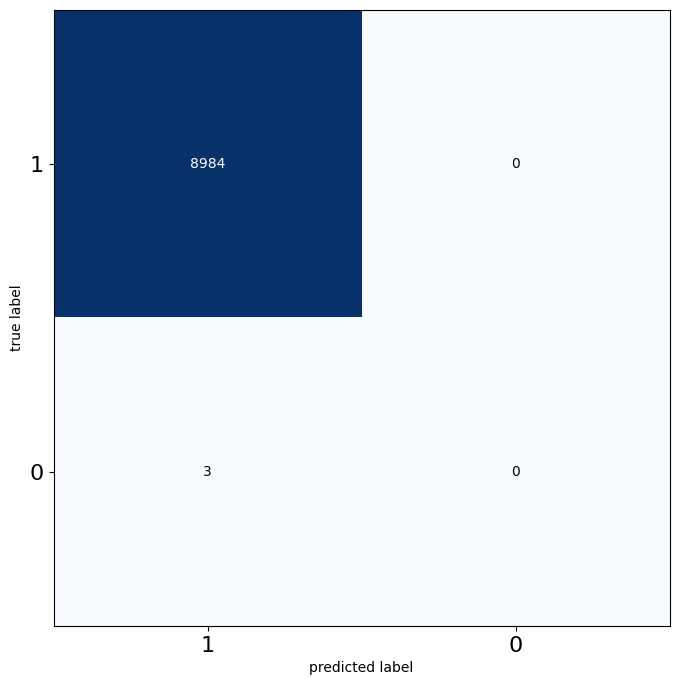

Landscaping
accuracy: 0.9986647379548237 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

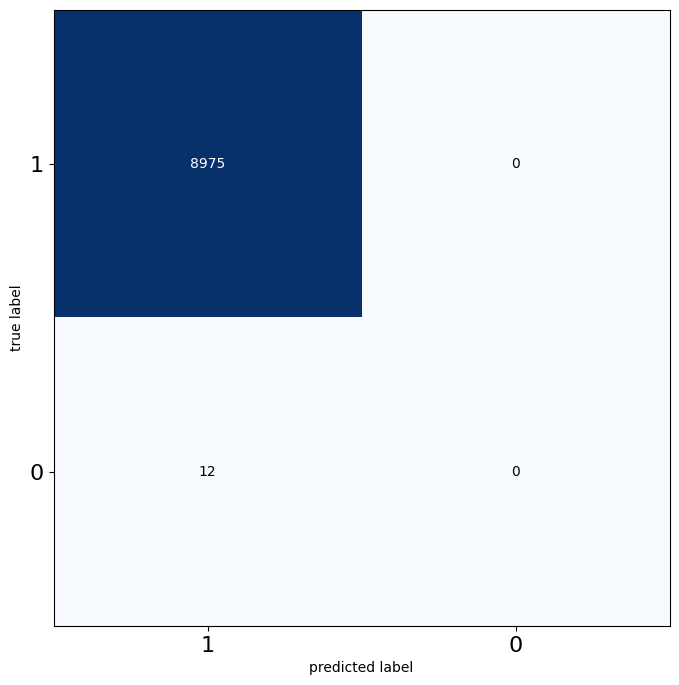

Language Schools
accuracy: 0.9986647379548237 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

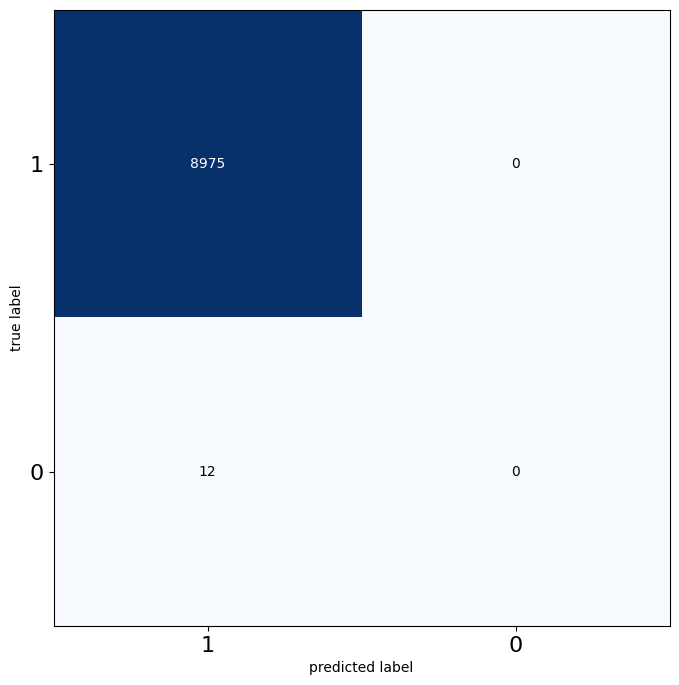

Laundry & Drycleaning Equipment
accuracy: 0.9979971069322354 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

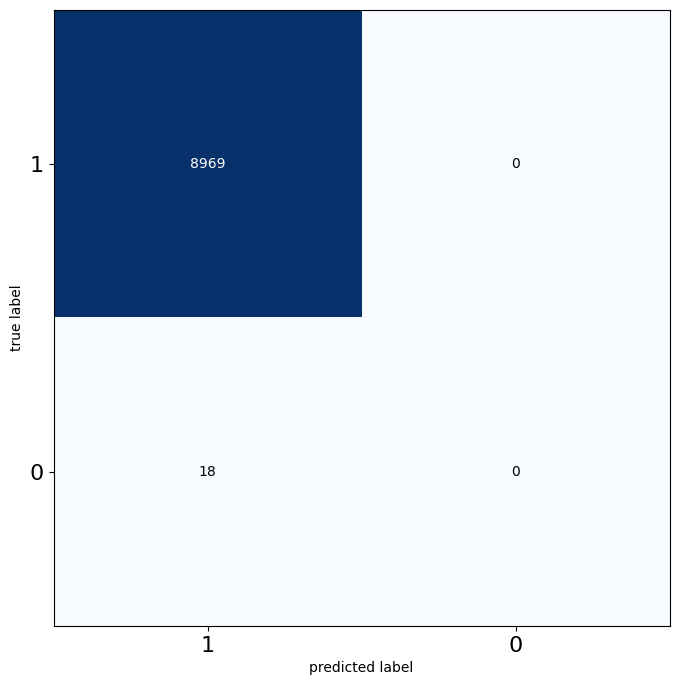

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Lawyers & Advocates
accuracy: 0.9897629909869812 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

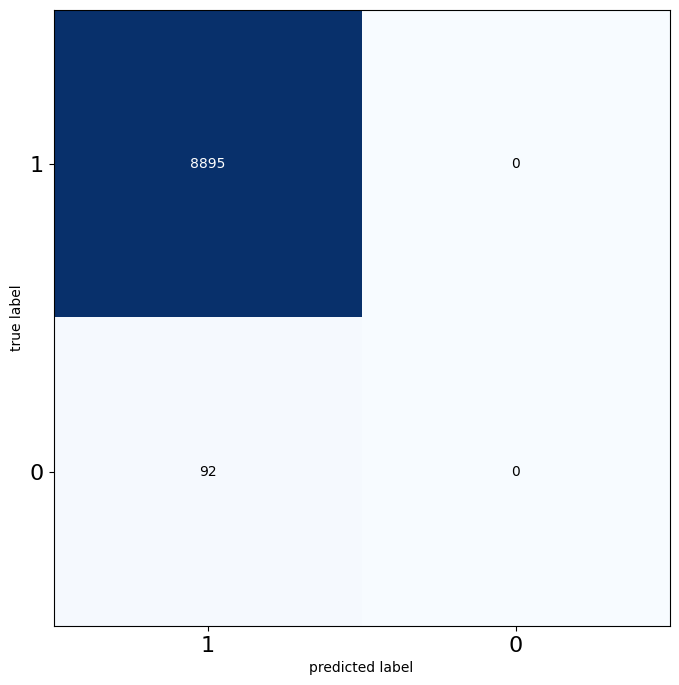

Leather Goods
accuracy: 0.9906531656837655 precision: 0.013513513513513514 recall: 0.08333333333333333 f1: 0.023255813953488372


<Figure size 640x480 with 0 Axes>

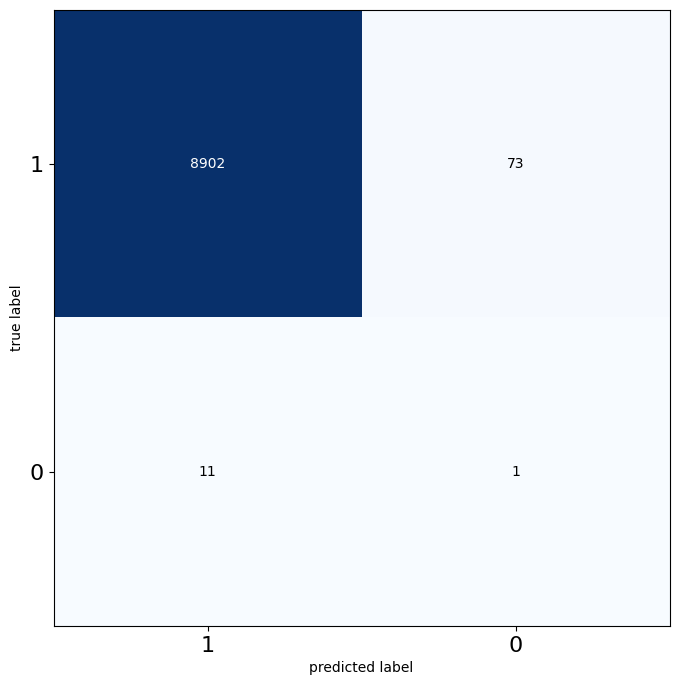

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Libraries
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

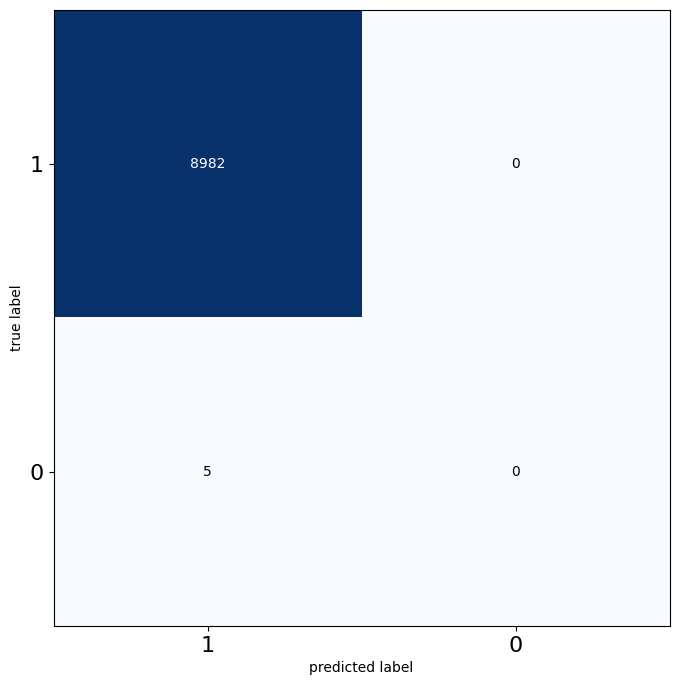

Lifting Machinery & Equipment
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

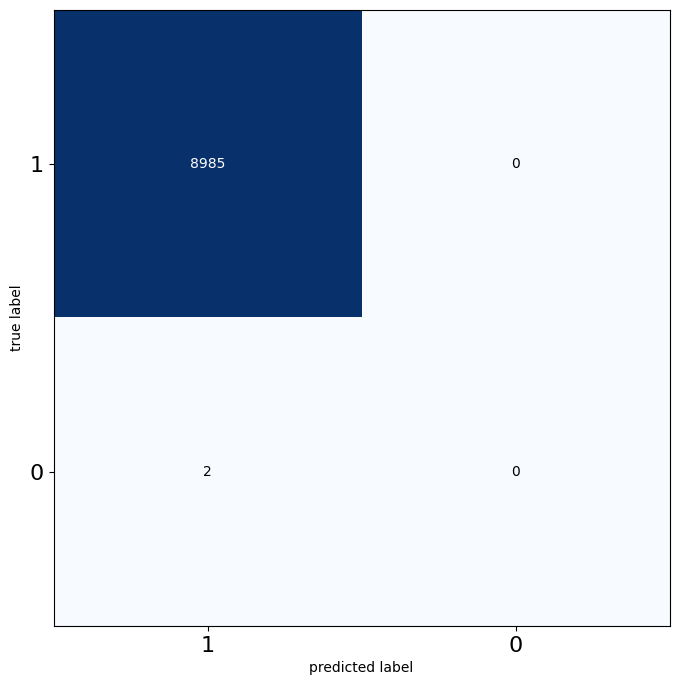

Lighting Systems & Equipment
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

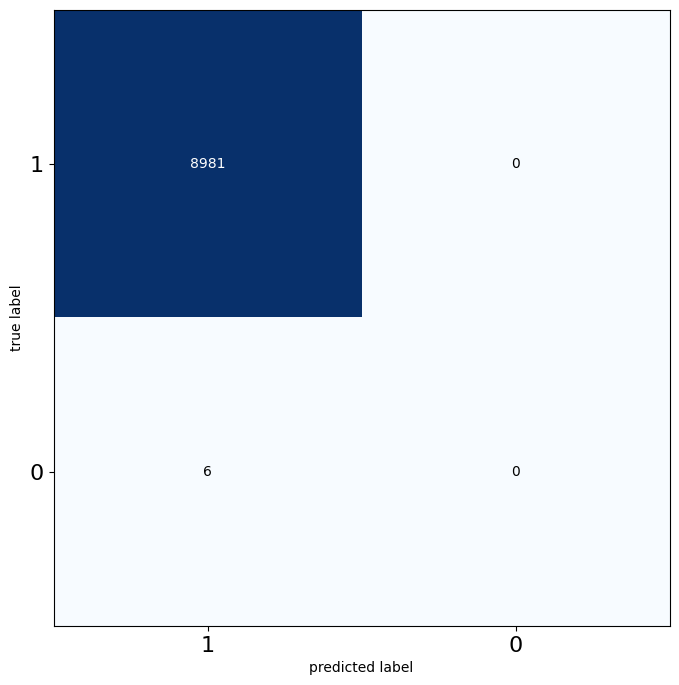

Lingerie
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

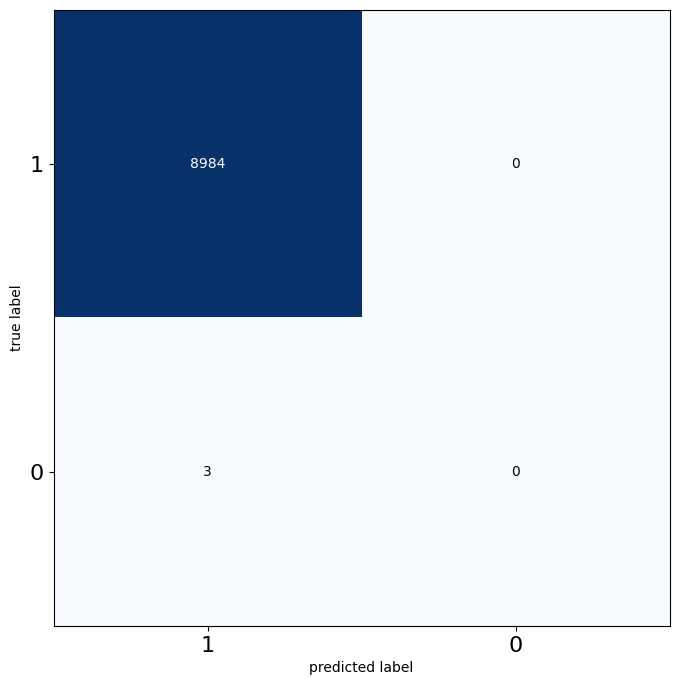

Livestock Dealers
accuracy: 0.9975520195838433 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

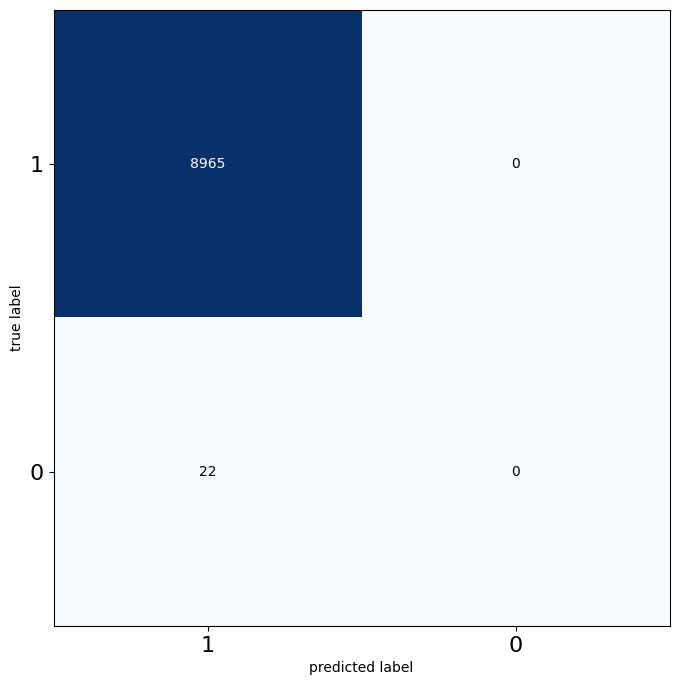

Local Authorities
accuracy: 0.2266607321686881 precision: 0.02265053460889139 recall: 0.9817073170731707 f1: 0.044279427942794276


<Figure size 640x480 with 0 Axes>

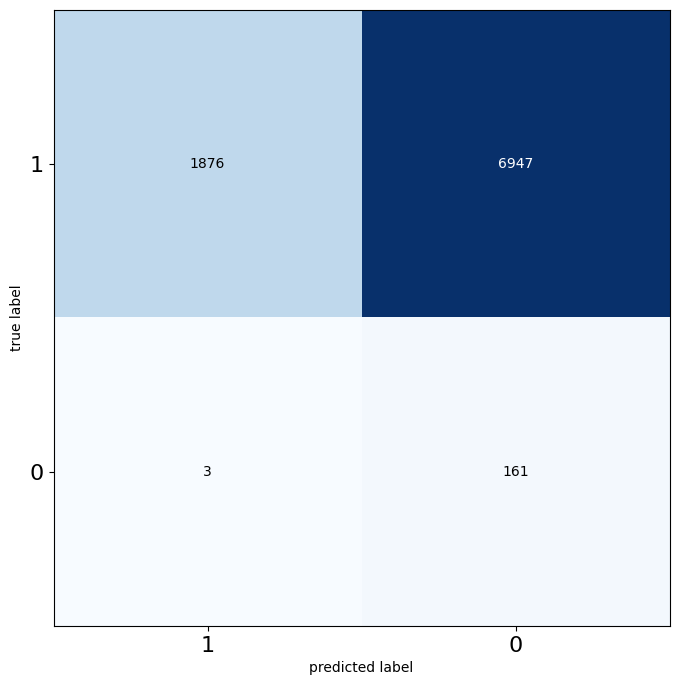

Locksmiths
accuracy: 0.9937687771225103 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

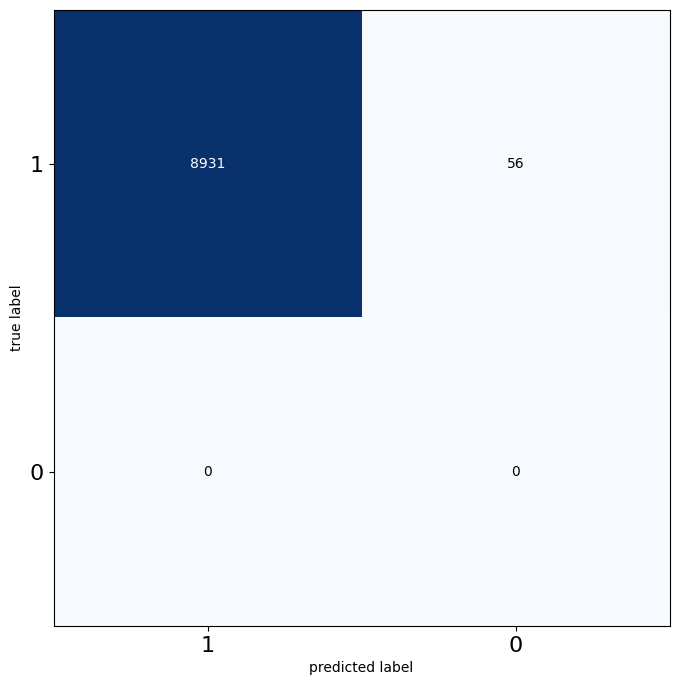

Logistics Providers
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

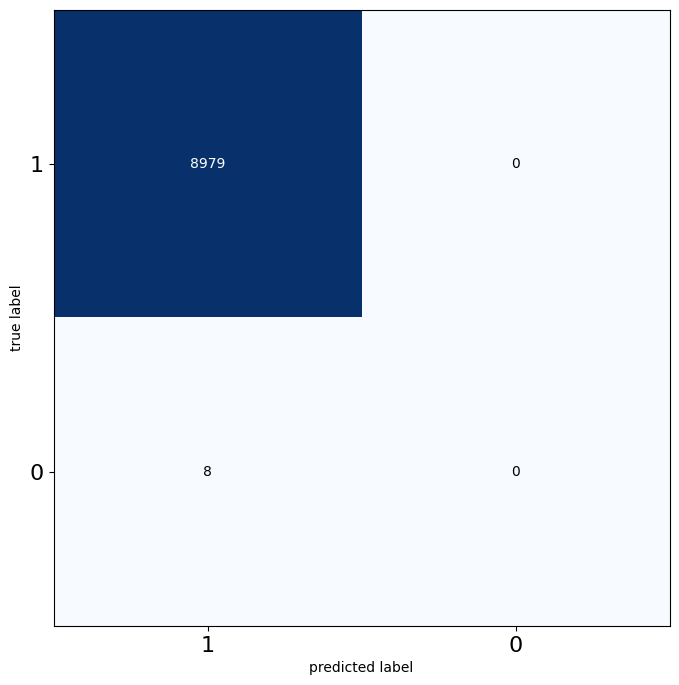

Machine Tools
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

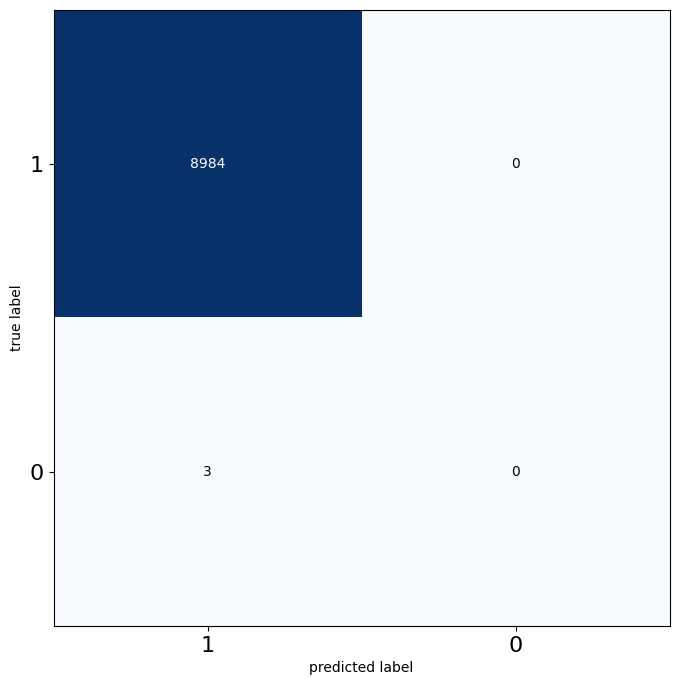

Machinery
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

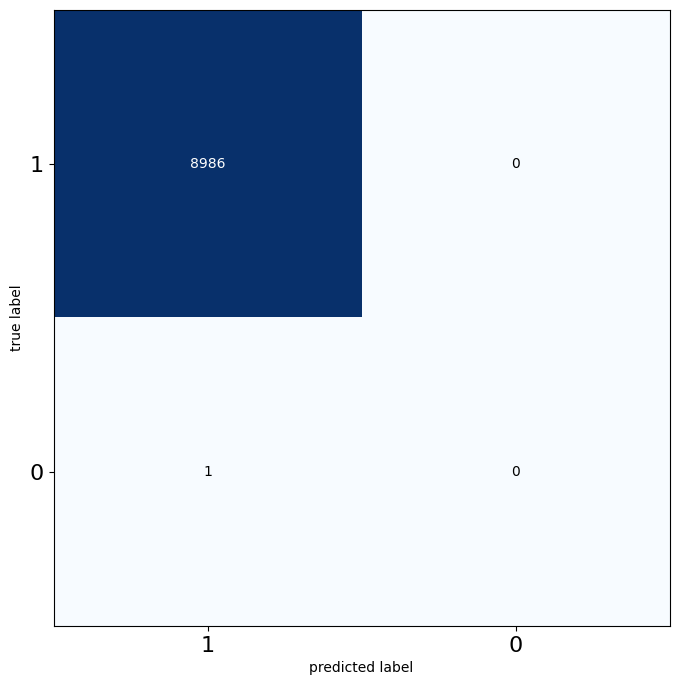

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Machinery Parts
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

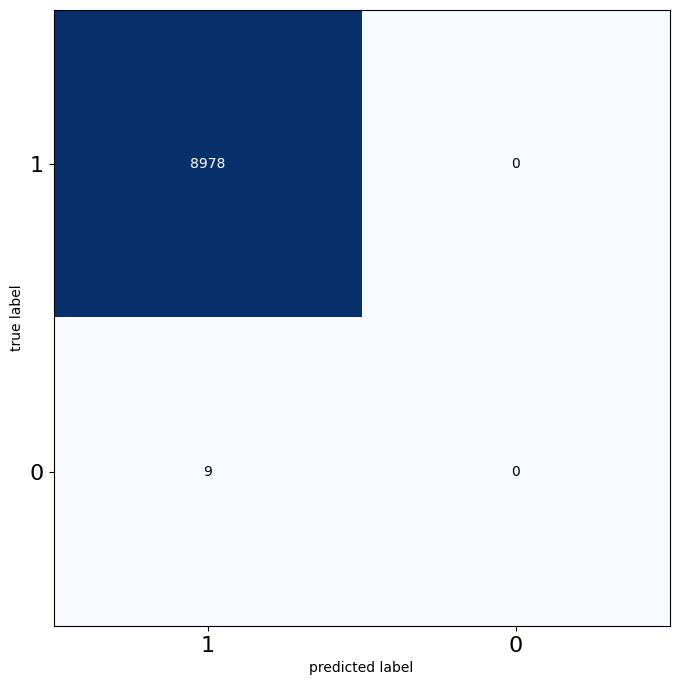

Magazine & Newspaper Publishers
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

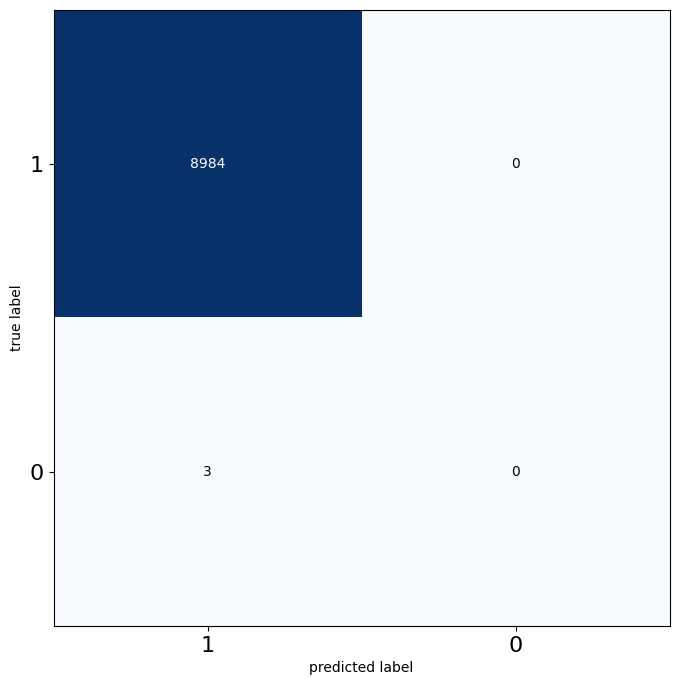

Magazines Publishers
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

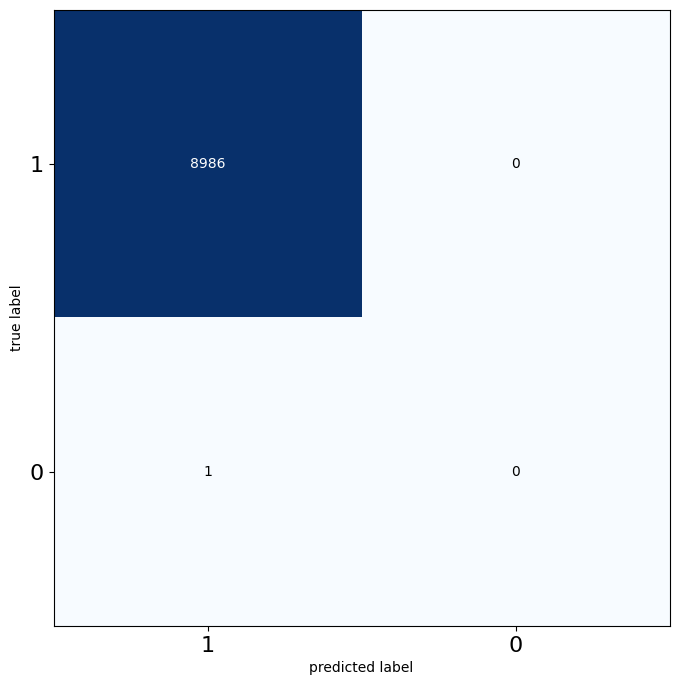

Management Consultants
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

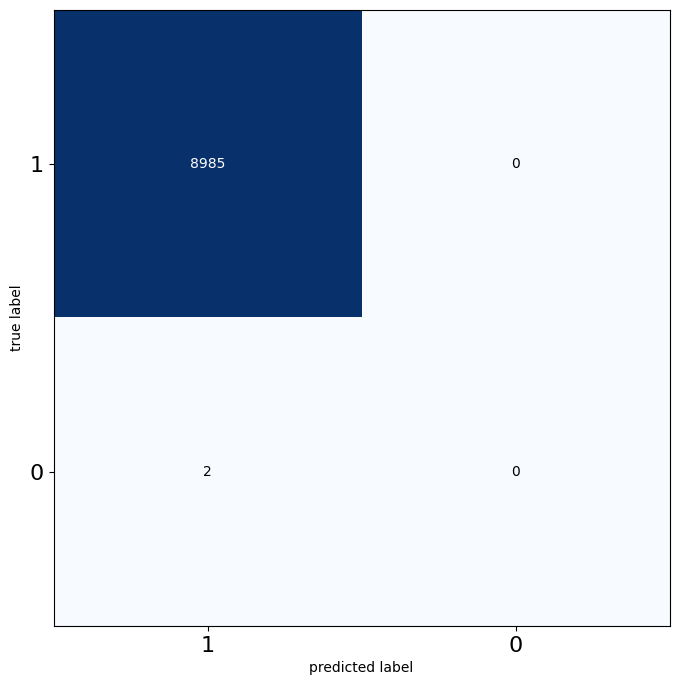

Manufacturers
accuracy: 0.9846444864804718 precision: 0.05555555555555555 recall: 0.14285714285714285 f1: 0.08


<Figure size 640x480 with 0 Axes>

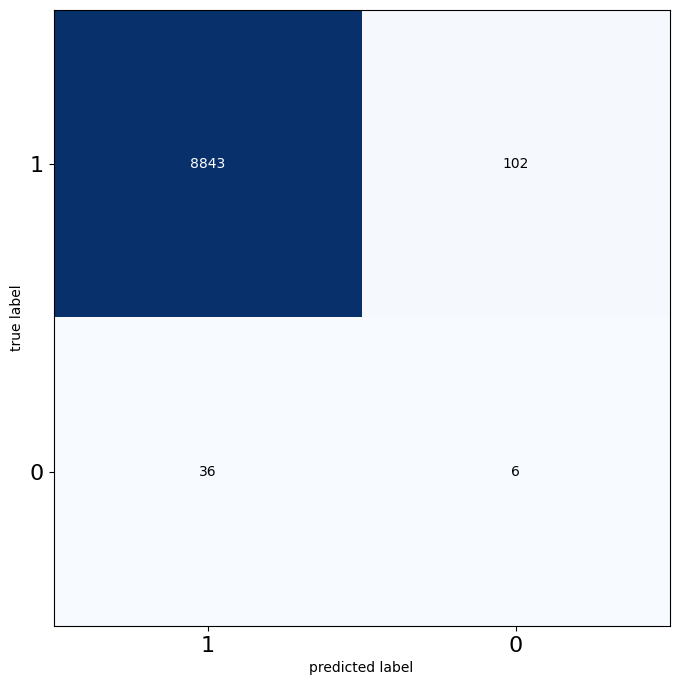

Manufacturers Agents & Representatives
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

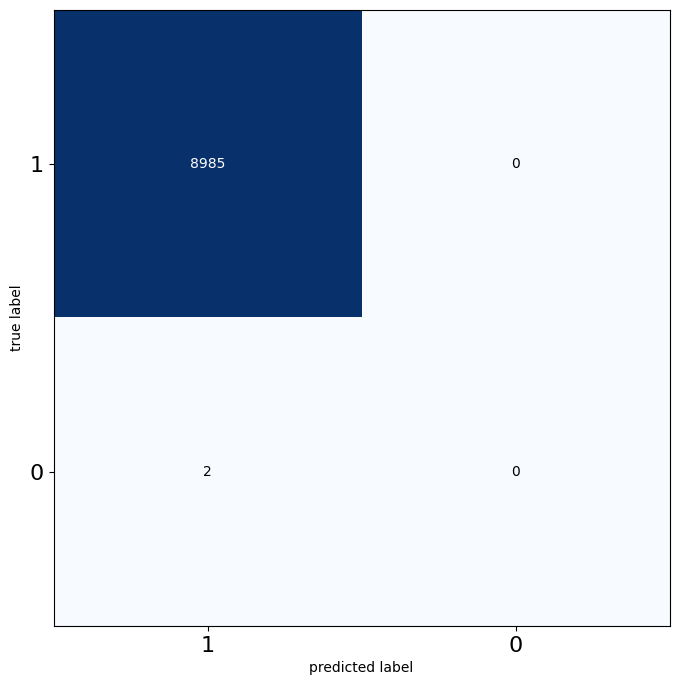

Mapping Consultants
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

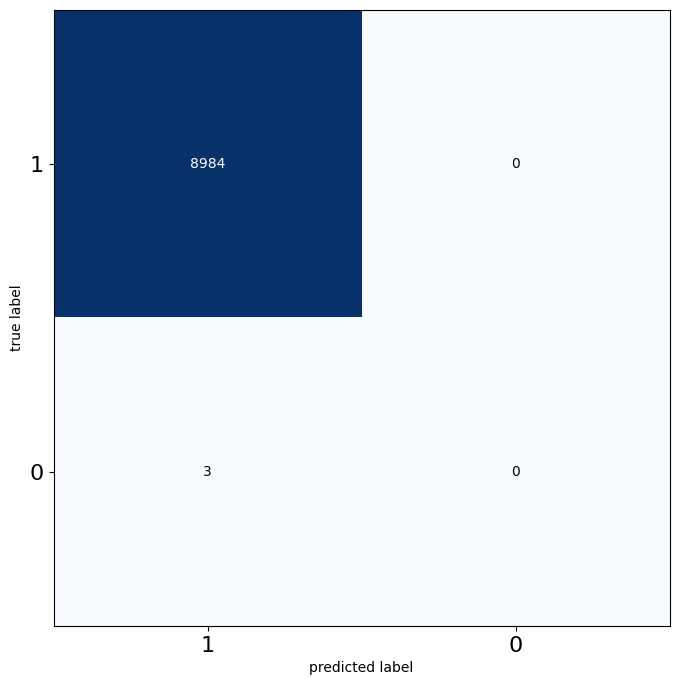

Marble
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

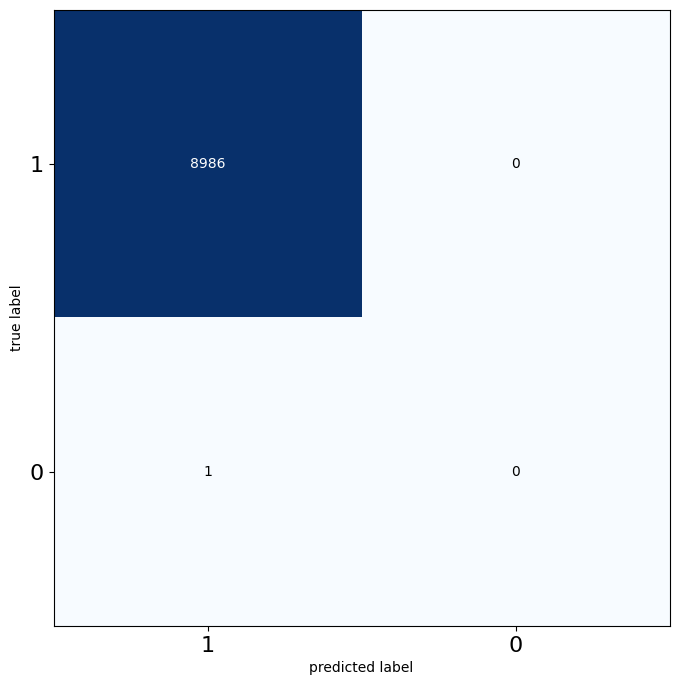

Marine Equipment & Supplies
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

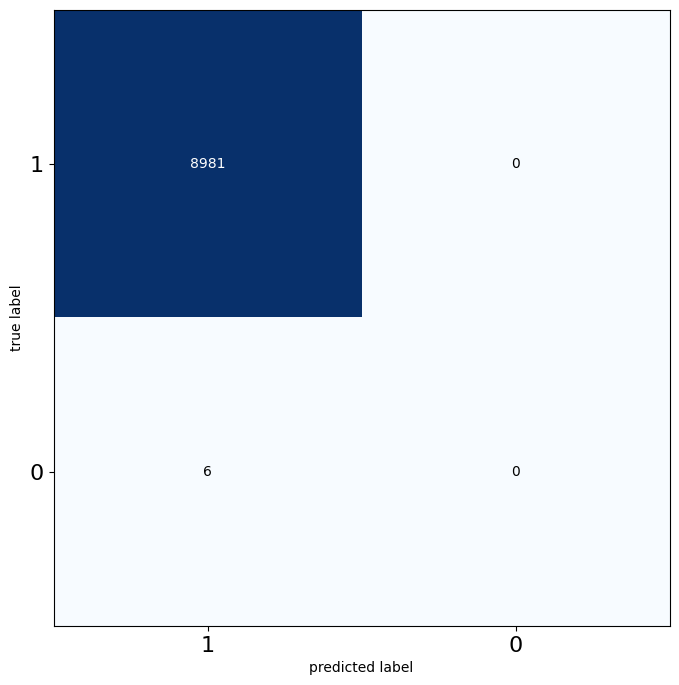

Marine Equipment Repairs
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

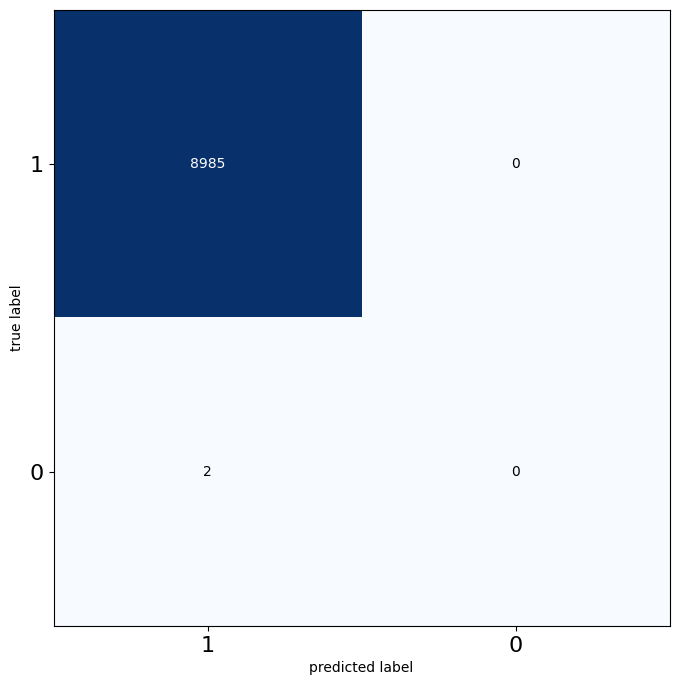

Marine Surveyors
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

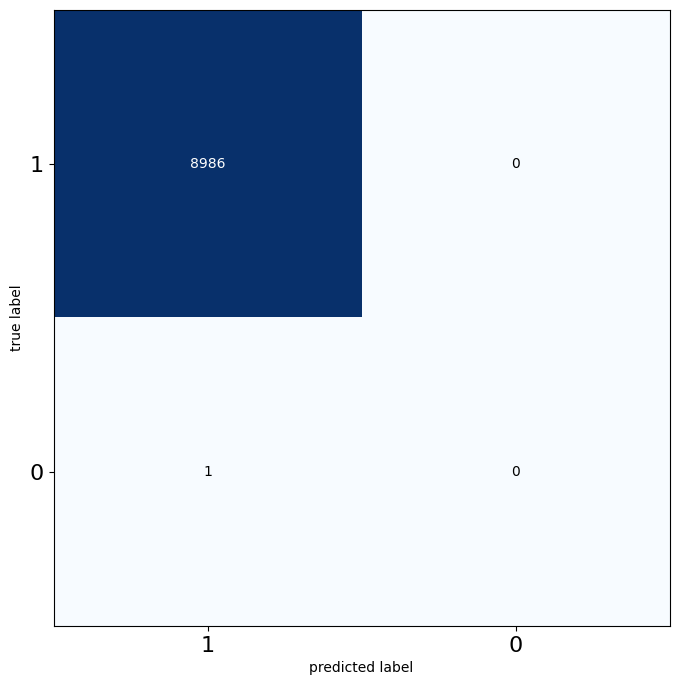

Marketing Consultants
accuracy: 0.9964393012128631 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

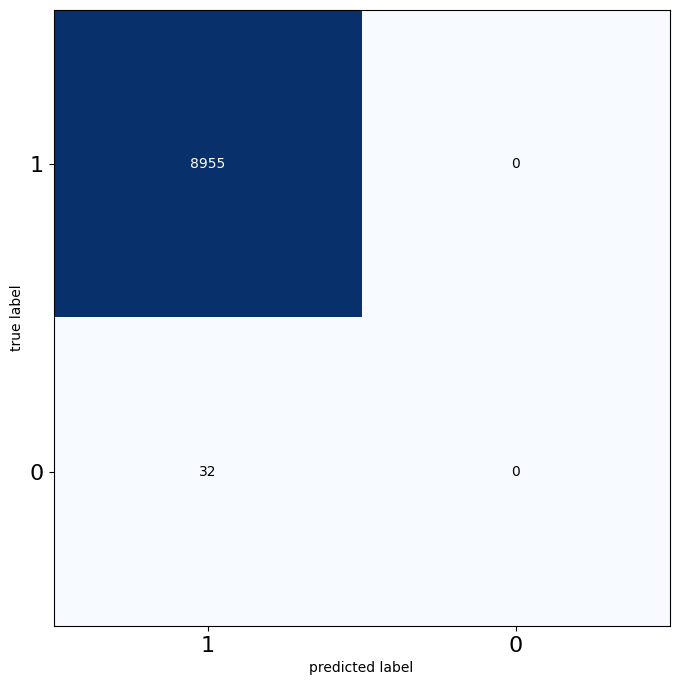

Massage Parlours
accuracy: 0.9976632914209413 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

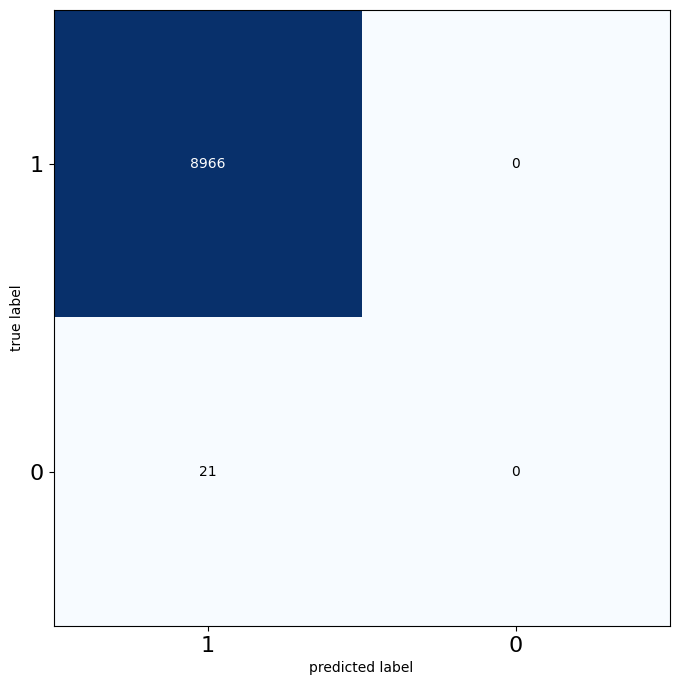

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Material Handling Equipment & Supplies
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

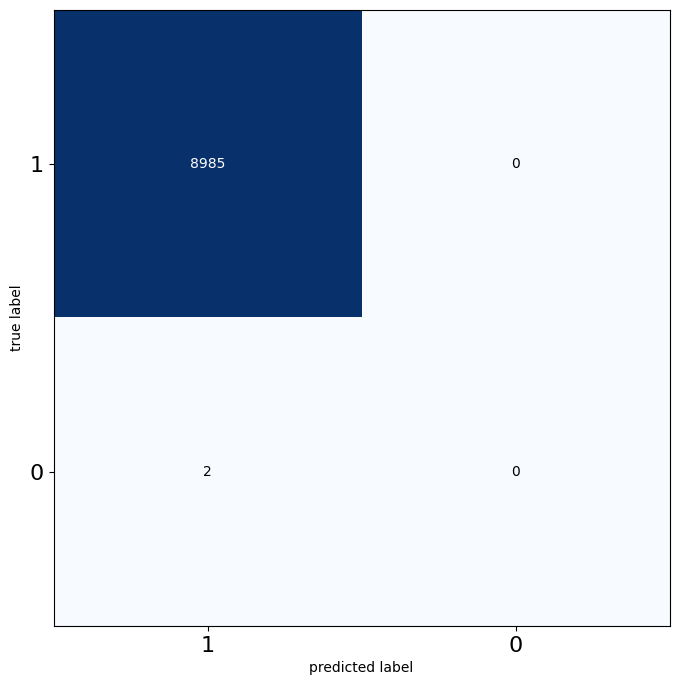

Maternity Homes
accuracy: 0.9986647379548237 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

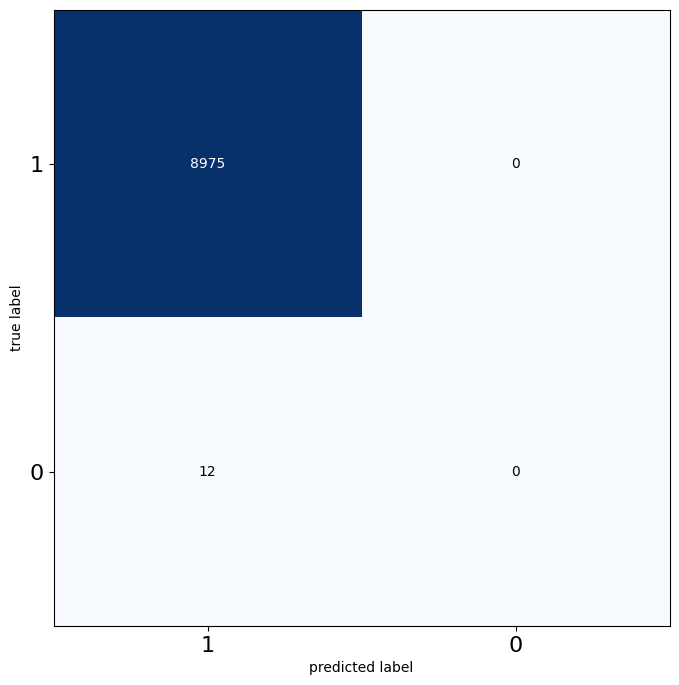

Mattresses
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

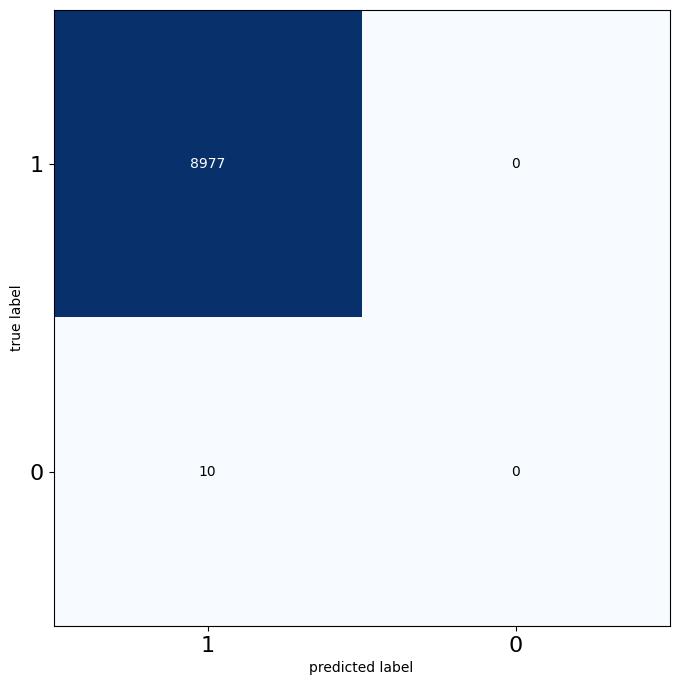

Meat
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

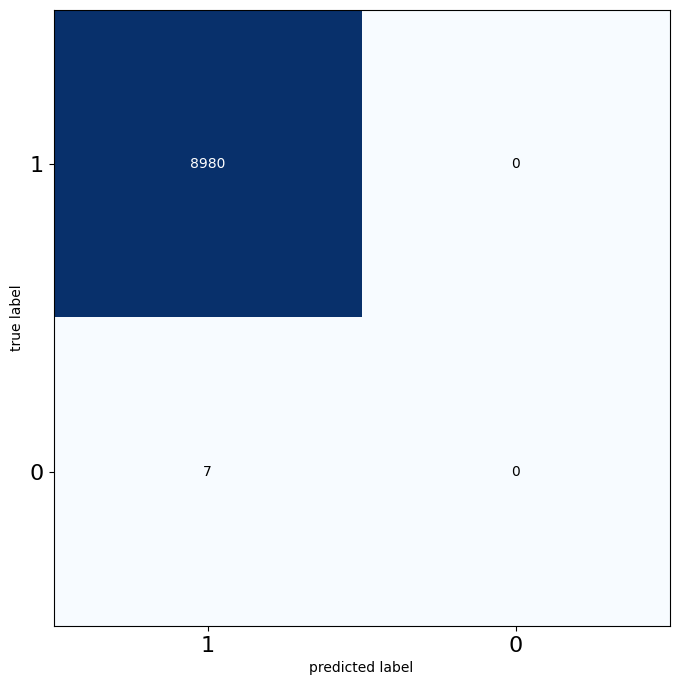

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mechanical Engineers
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

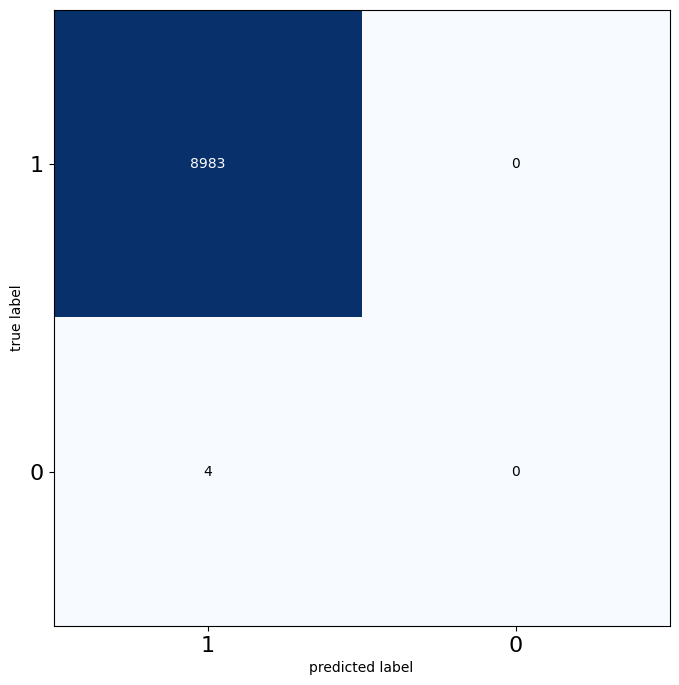

Media Agencies
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

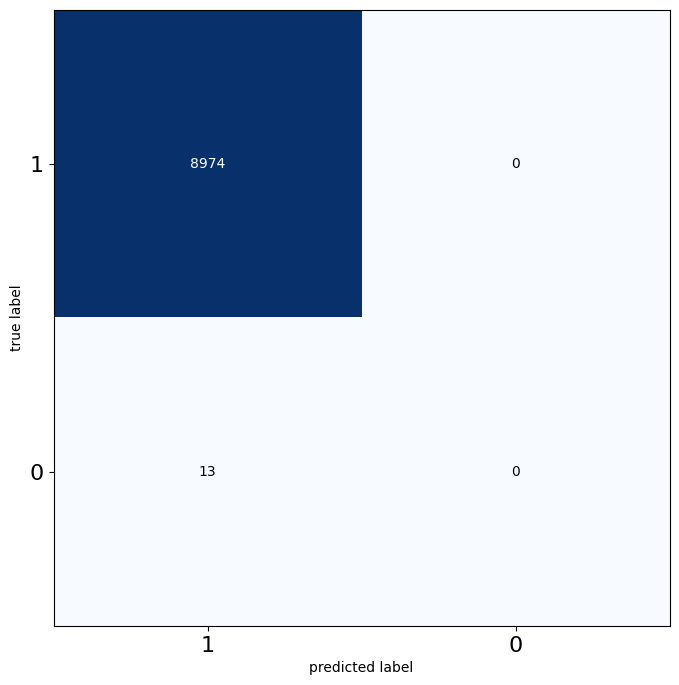

Medical Assistance Organizations
accuracy: 0.9942138644709024 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

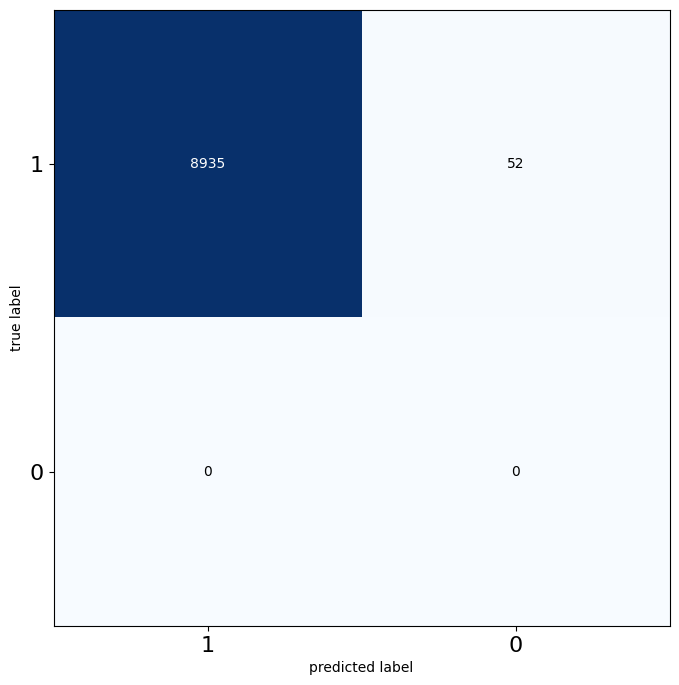

Medical Centres
accuracy: 0.15967508623567375 precision: 0.024970888860137146 recall: 0.9234449760765551 f1: 0.048626858150667675


<Figure size 640x480 with 0 Axes>

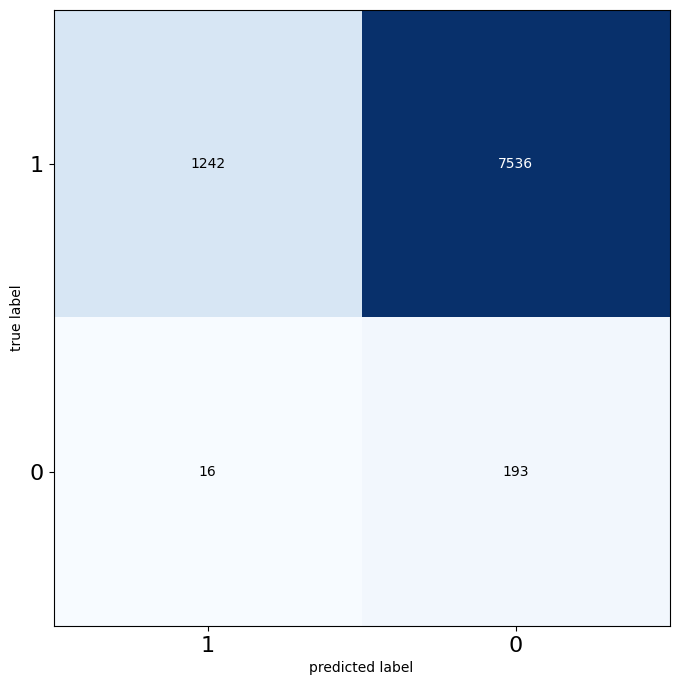

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Medical Equipment & Supplies
accuracy: 0.9975520195838433 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

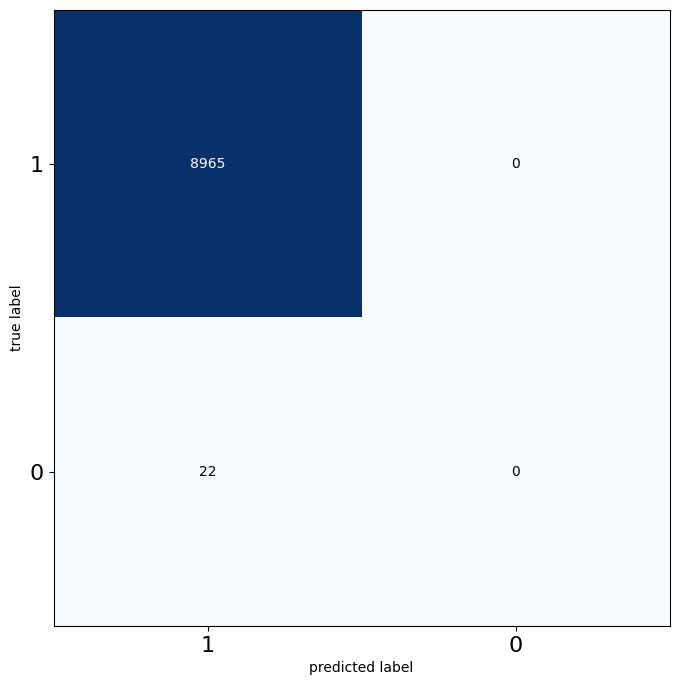

Medical Insurance
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

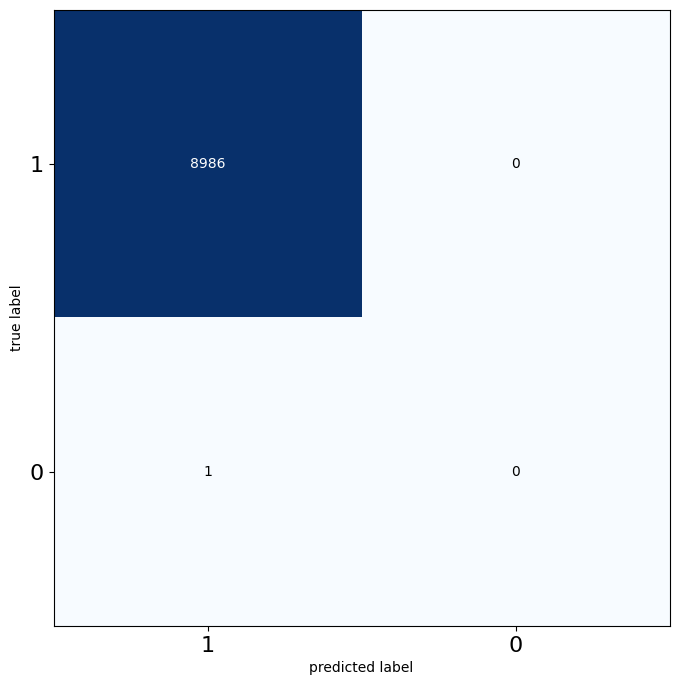

Medical Practitioners - Anaesthetists
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

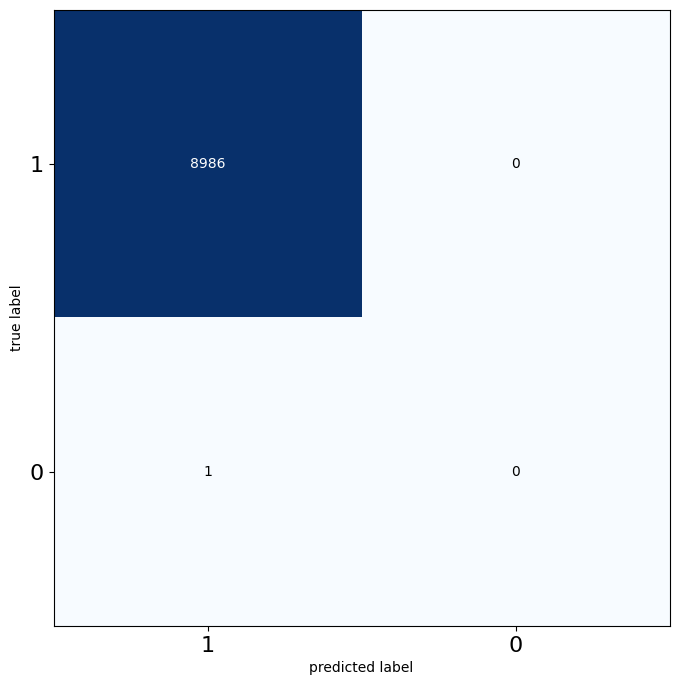

Medical Practitioners - Cardiologists Heart Speci
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

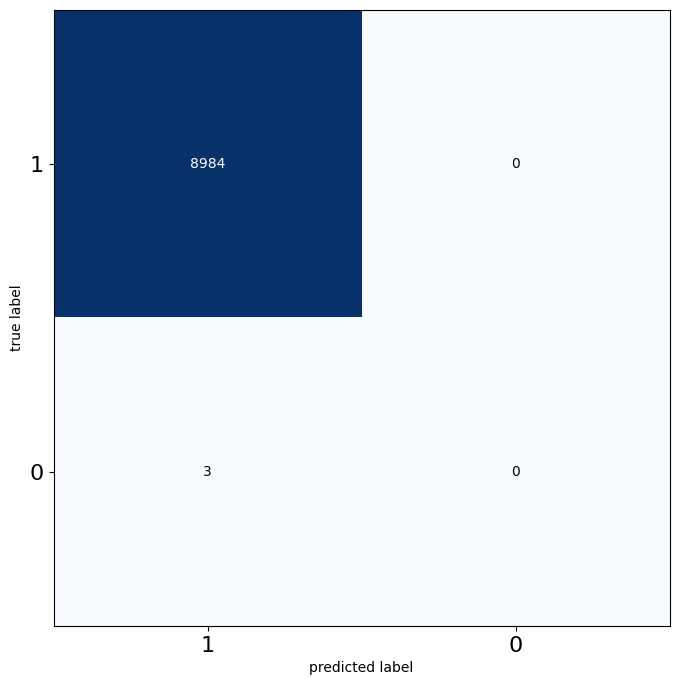

Medical Practitioners - Chest Physicians
accuracy: 0.9952153110047847 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

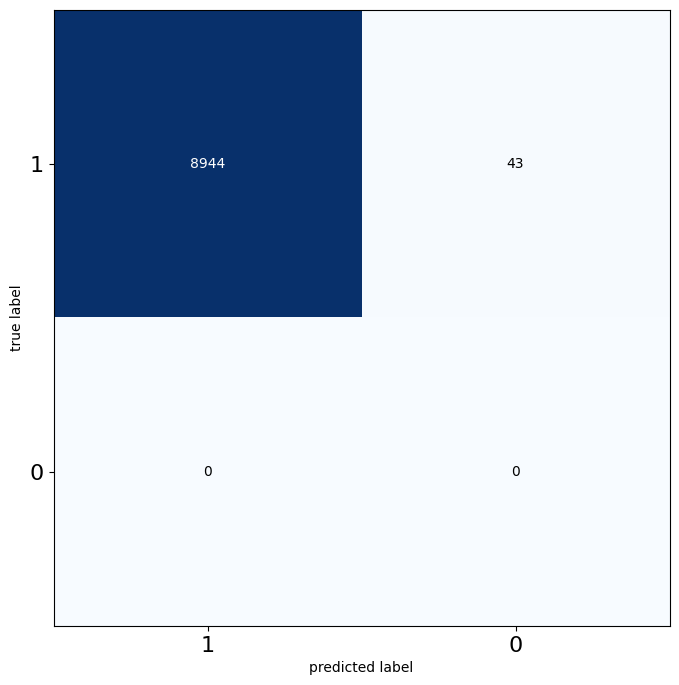

Medical Practitioners - Dermatologists Skin Speci
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

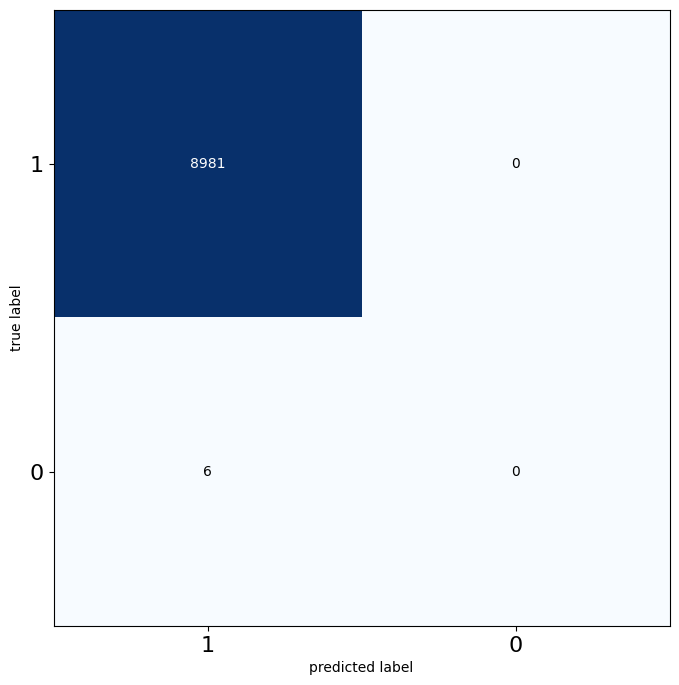

Medical Practitioners - ENT Specialists
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

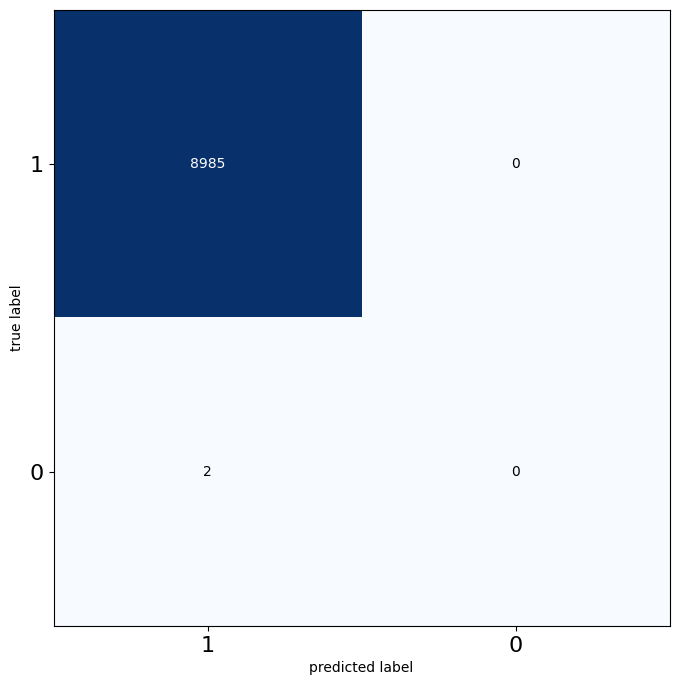

Medical Practitioners - General Practitioners
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

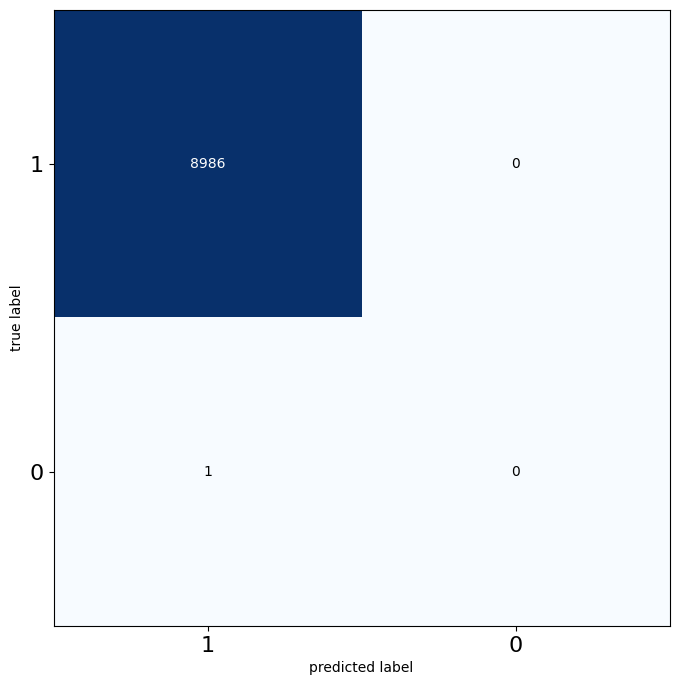

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Medical Practitioners - Gynaecologists
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

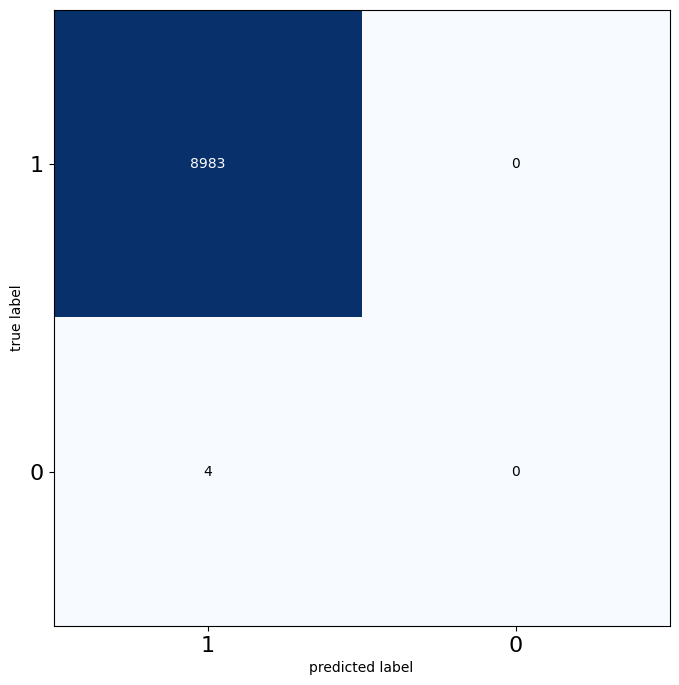

Medical Practitioners - Nephrologists
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

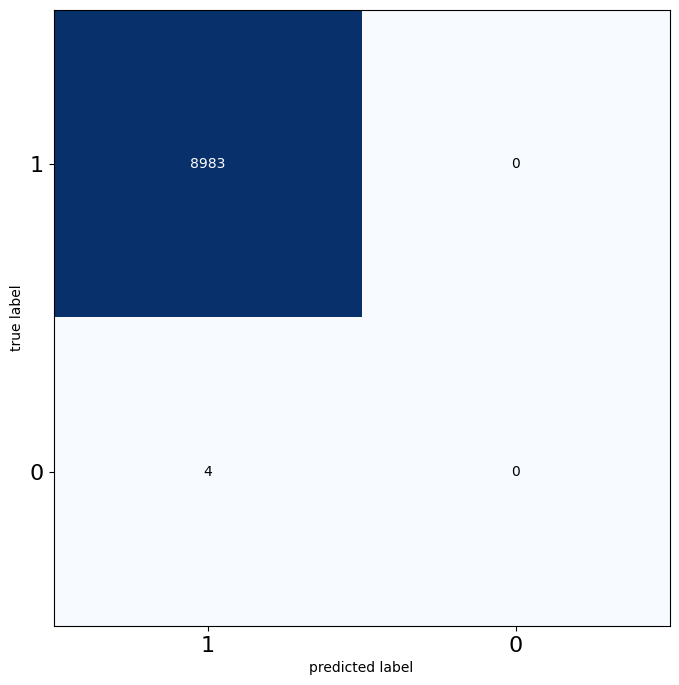

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Medical Practitioners - Oncologists Tumour Specia
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

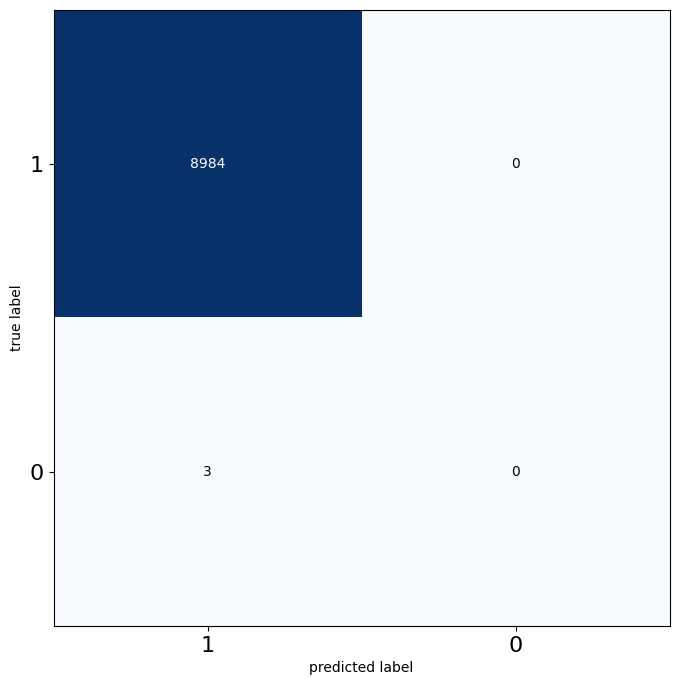

Medical Practitioners - Ophthalmologists Eye Spec
accuracy: 0.9935462334483143 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

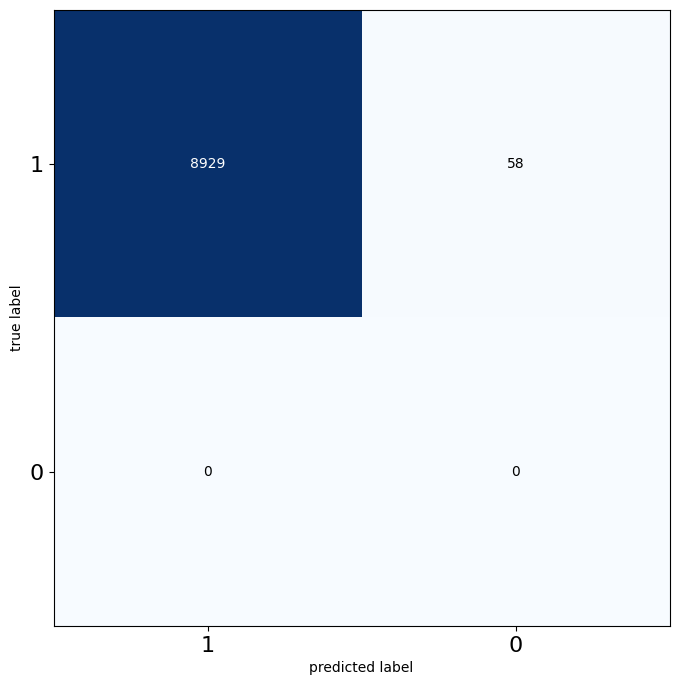

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Medical Practitioners - Pathologists
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

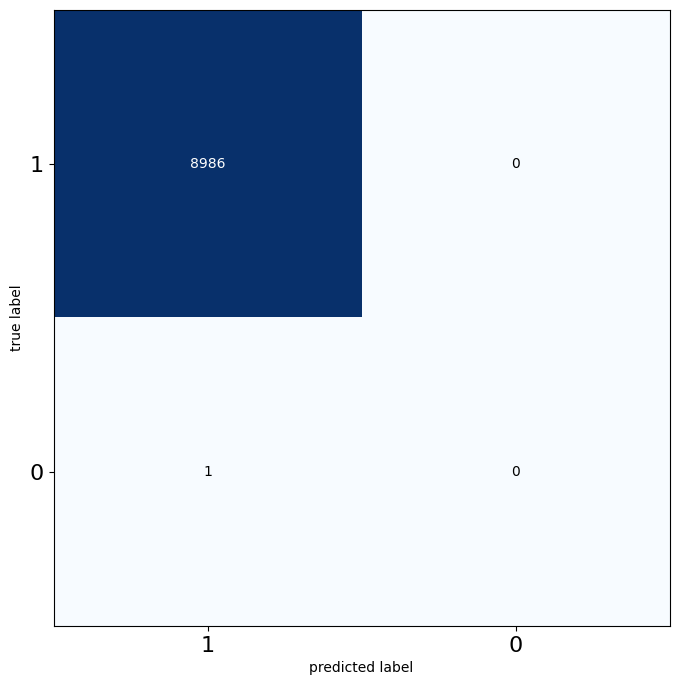

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Medical Practitioners - Physicians
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

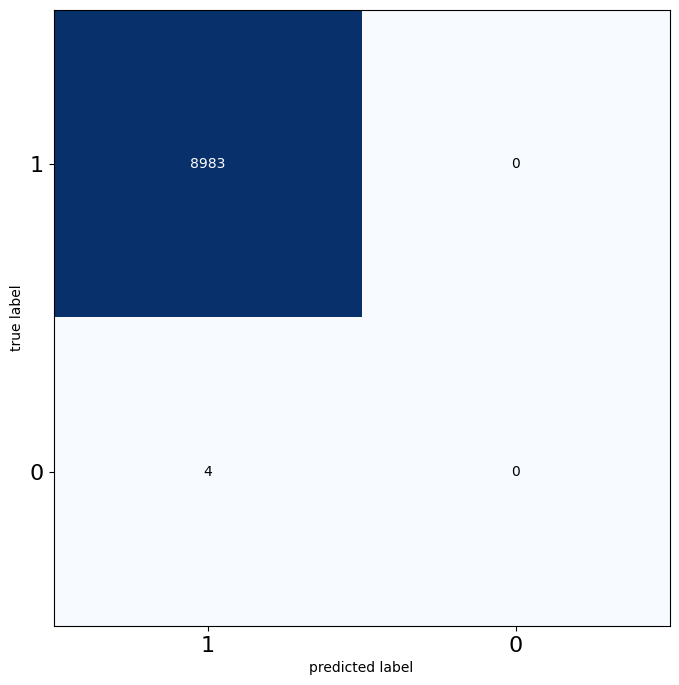

Medical Practitioners - Plastic Surgeons
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

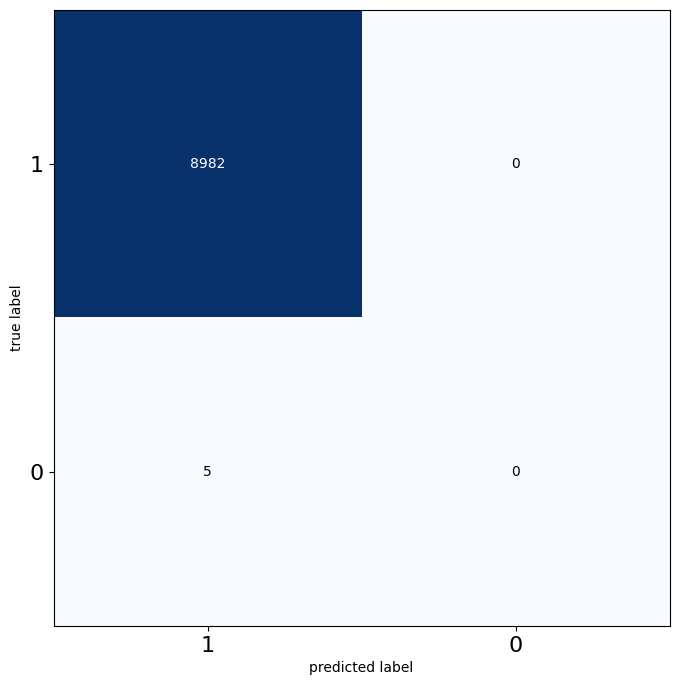

Medical Practitioners - Surgeons
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

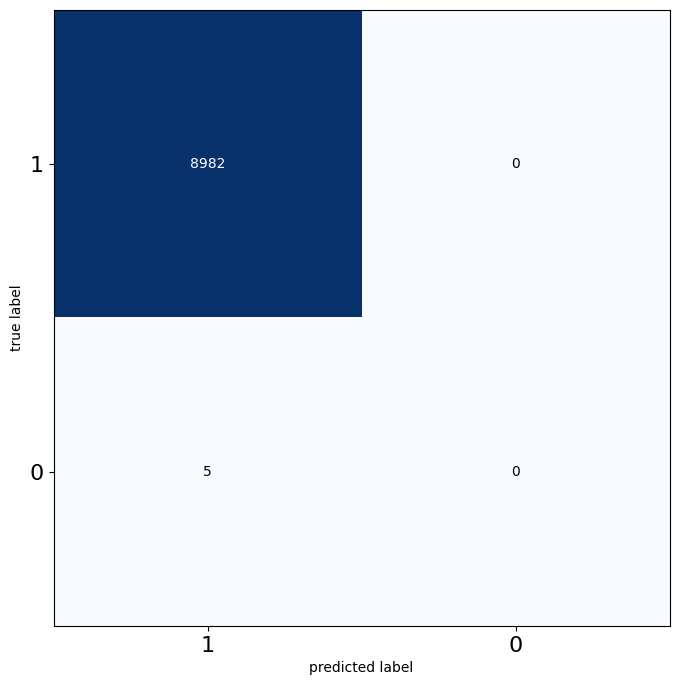

Medical Practitioners Radiologists
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

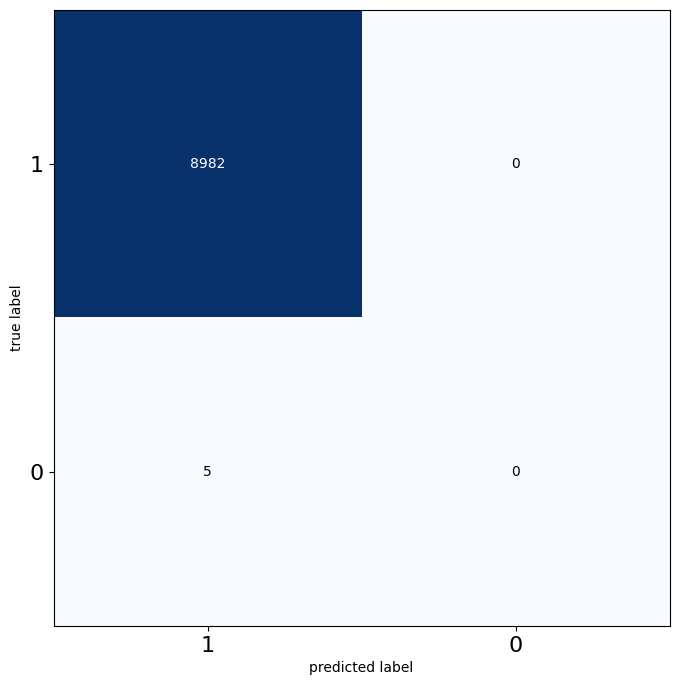

Medical practitioners - Orthopaedic Surgeons
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

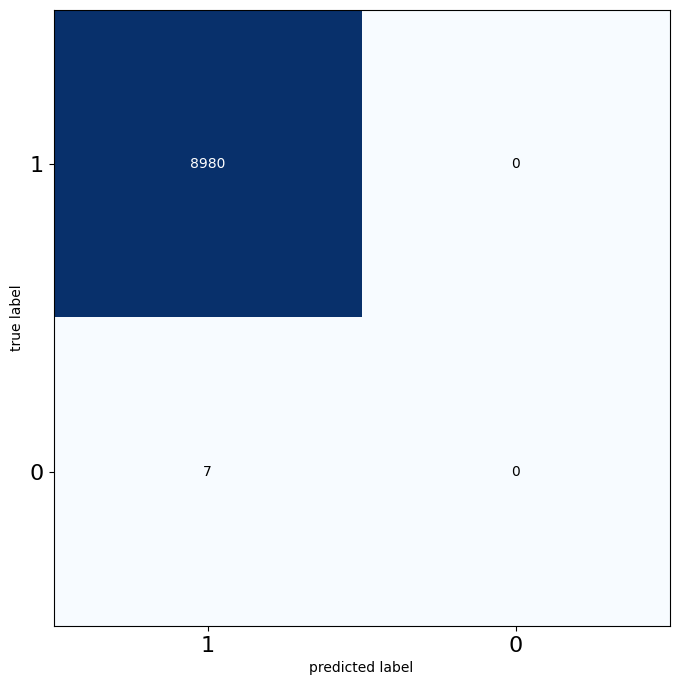

Mens Clothing-Retail
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

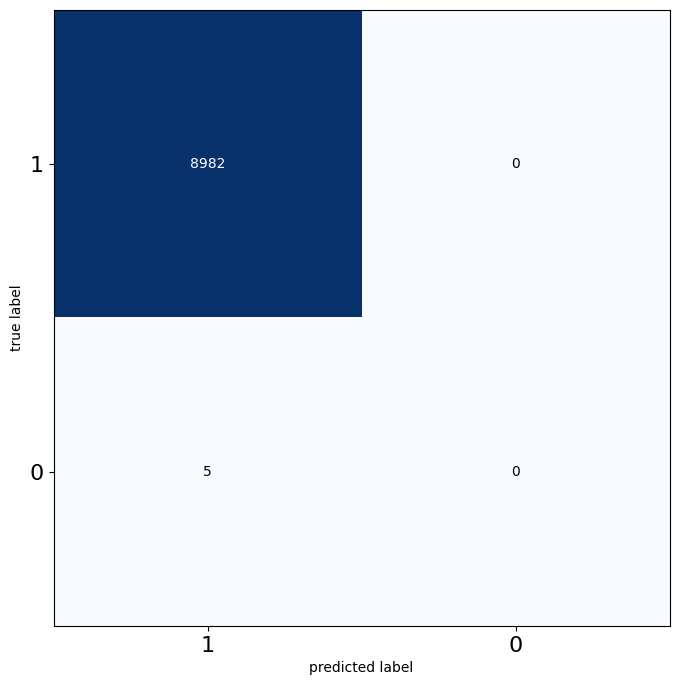

Metal Merchants
accuracy: 0.9976632914209413 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

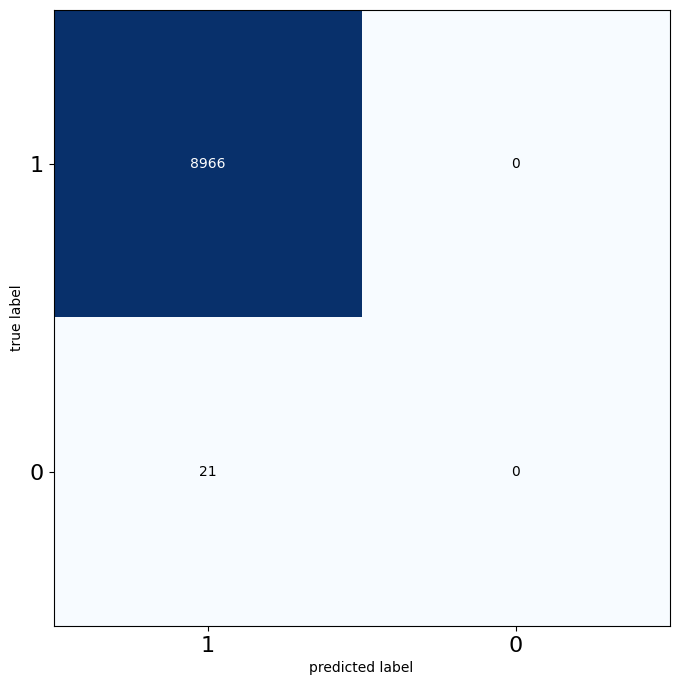

Metallizing
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

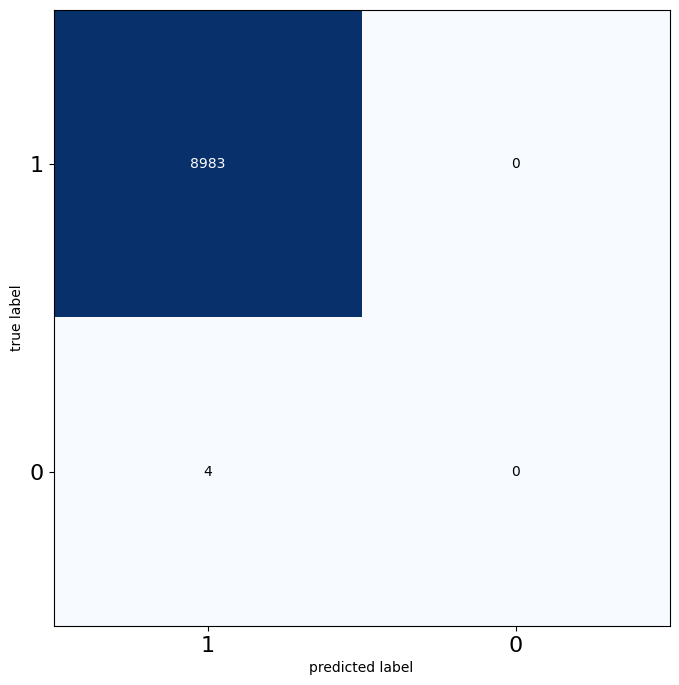

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Micro Finance Institutions
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

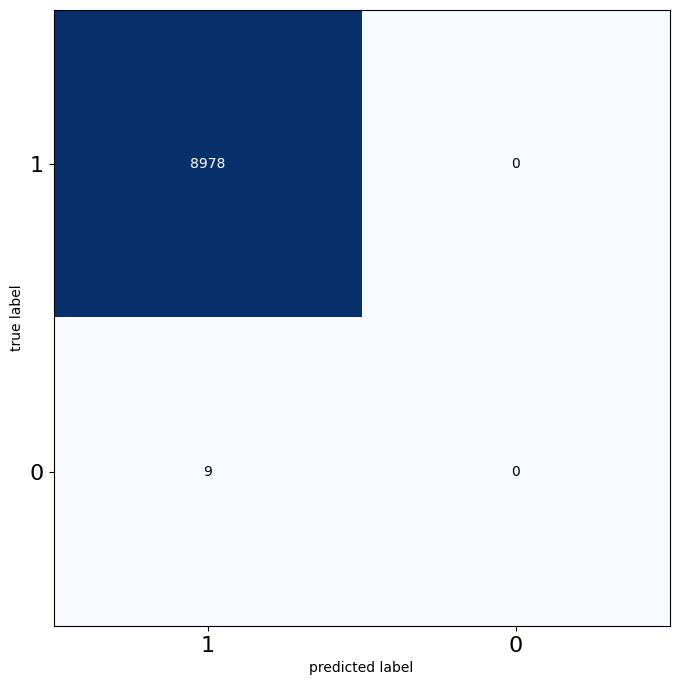

Milk & Milk Products
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

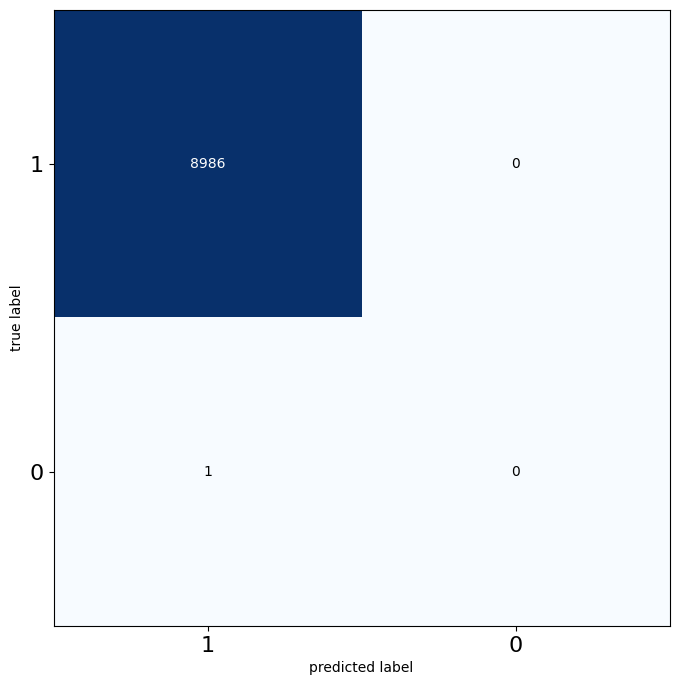

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Milling Equipment
accuracy: 0.9947702236563926 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

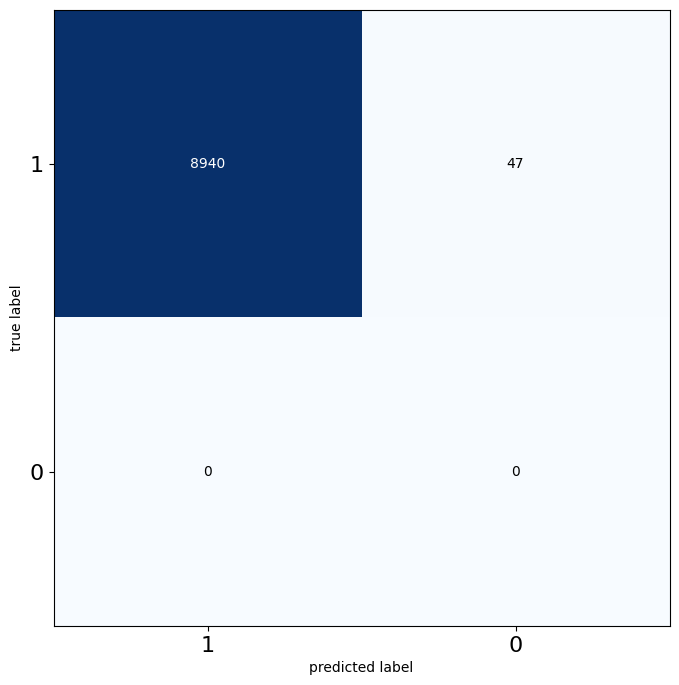

Mining Companies
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

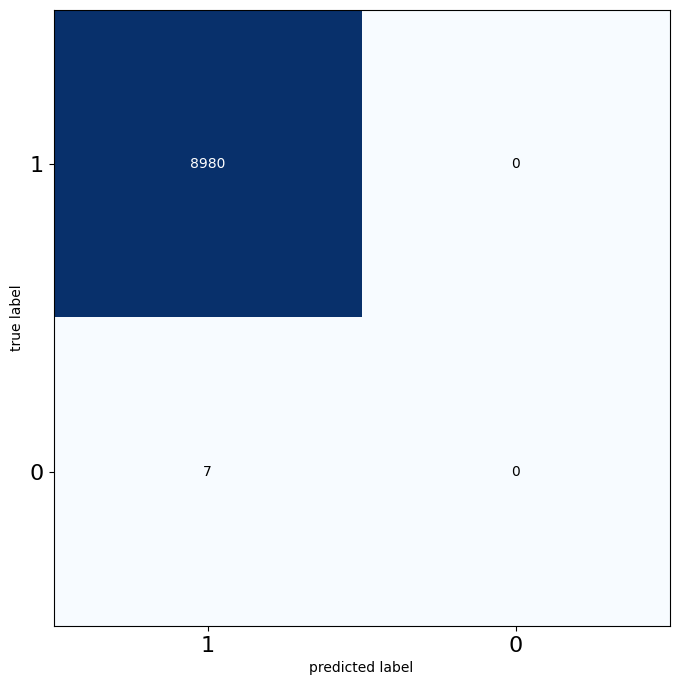

Mobile Applications Developers
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

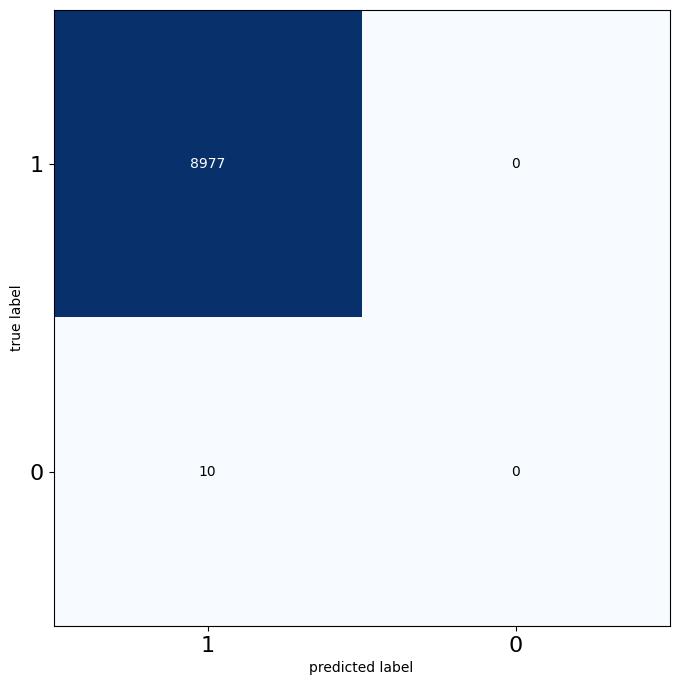

Mobile Phone Dealers & Accessories
accuracy: 0.9983309224435295 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

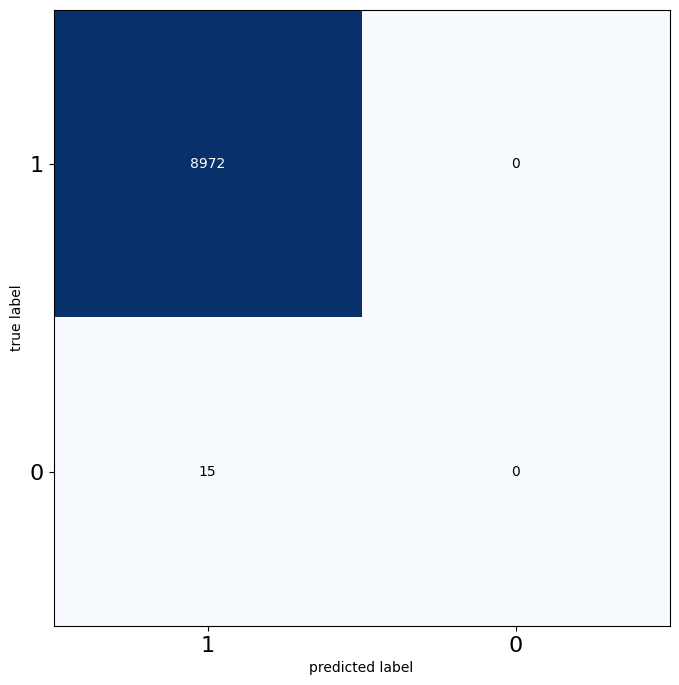

Mobile Phones Repairs & Service
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

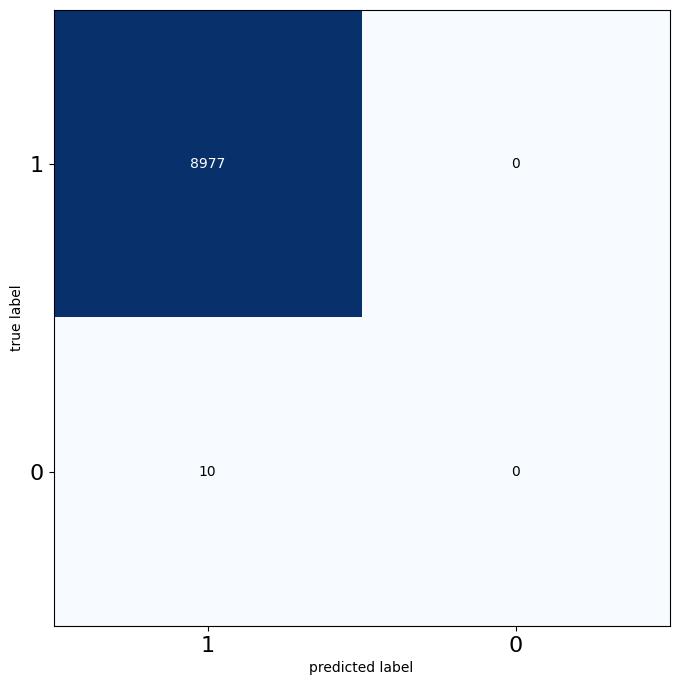

Modelling Agencies
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

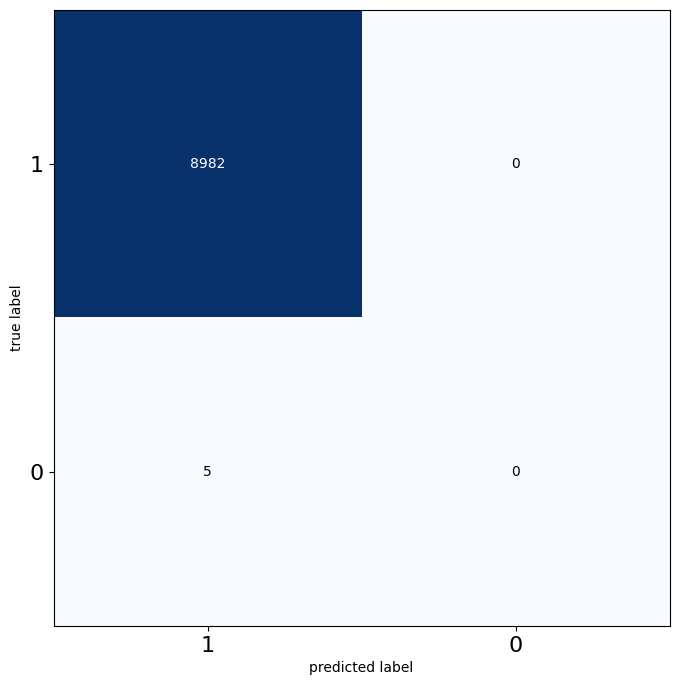

Money Transfer
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

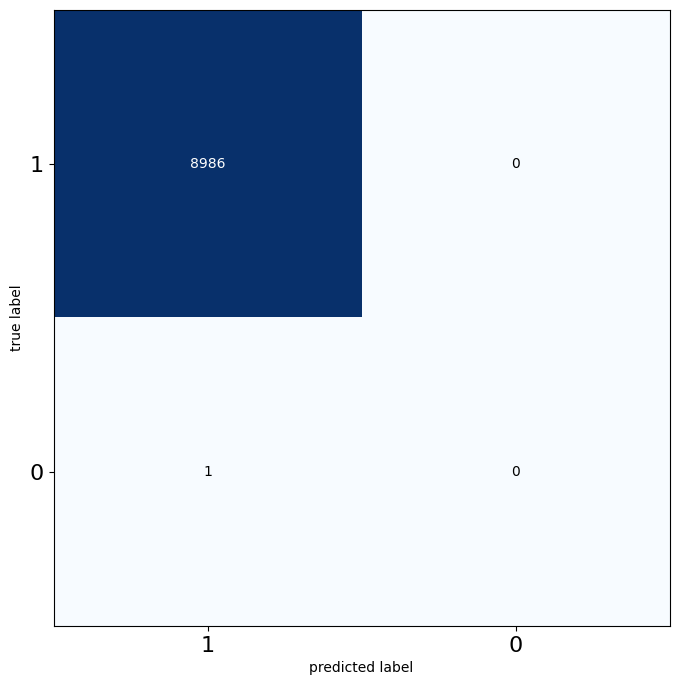

Mortgages
accuracy: 0.9984421942806275 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

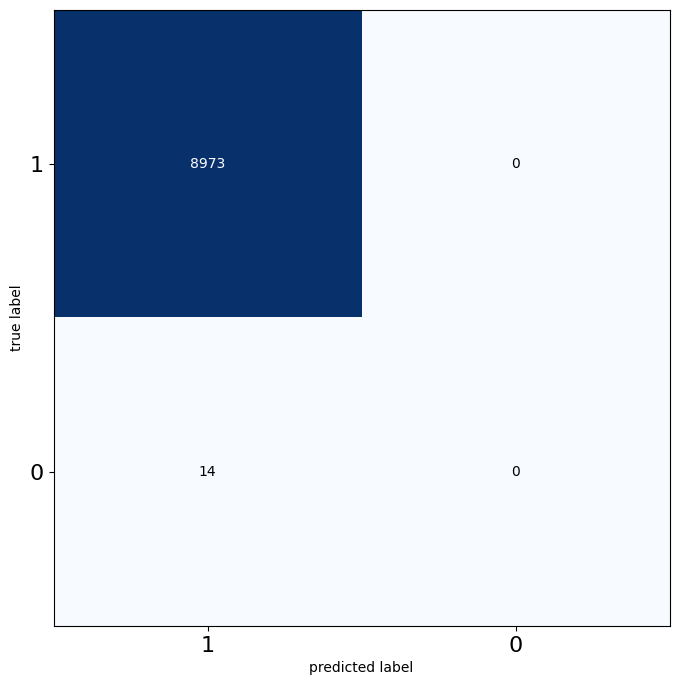

Motor Vehicles
accuracy: 0.9958829420273728 precision: 0.05555555555555555 recall: 0.4 f1: 0.09756097560975609


<Figure size 640x480 with 0 Axes>

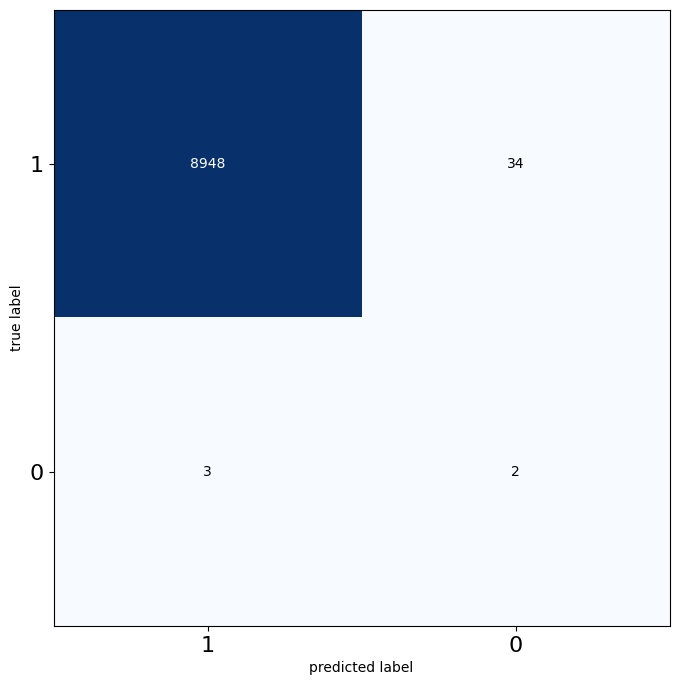

Motorcycle Dealers
accuracy: 0.9964393012128631 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

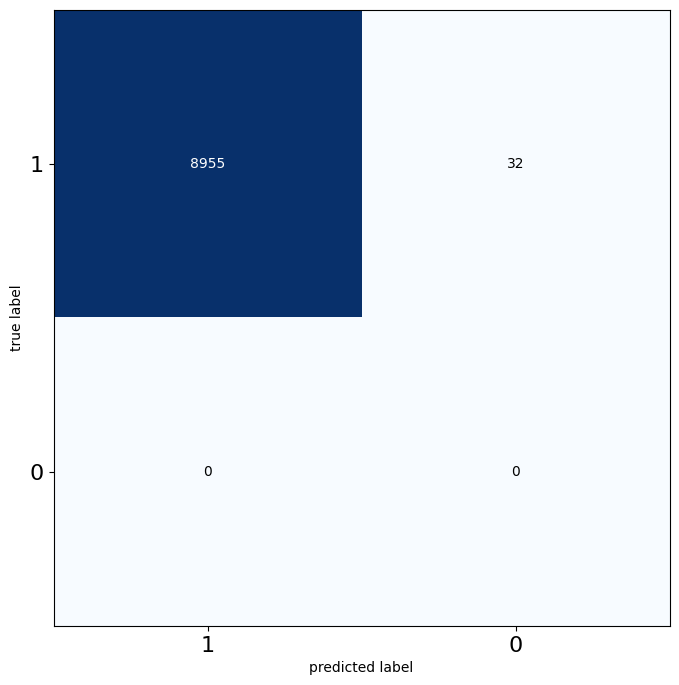

Motorcycle Hire
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

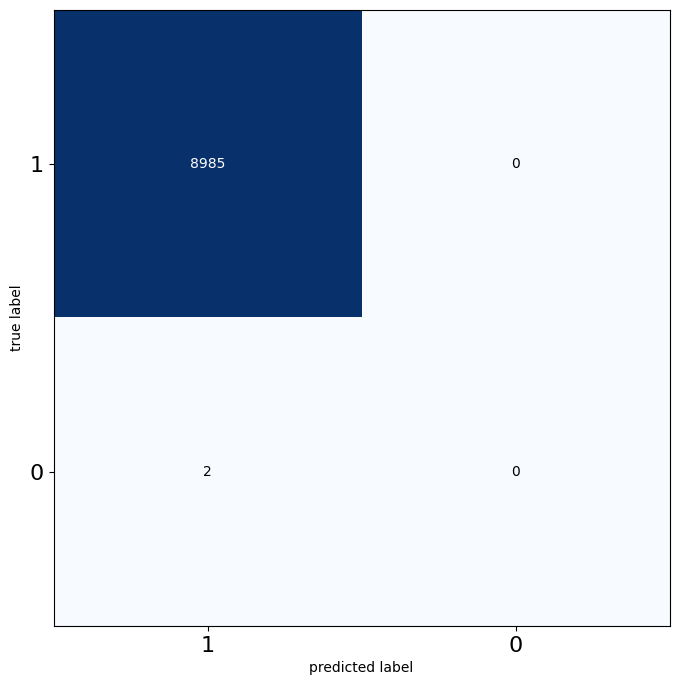

Motoring Services
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

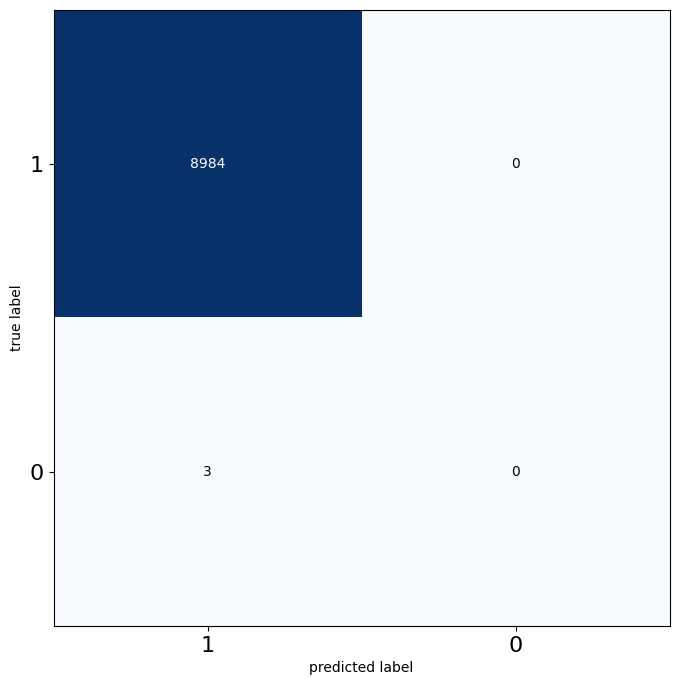

Motorvehicle Accessories
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

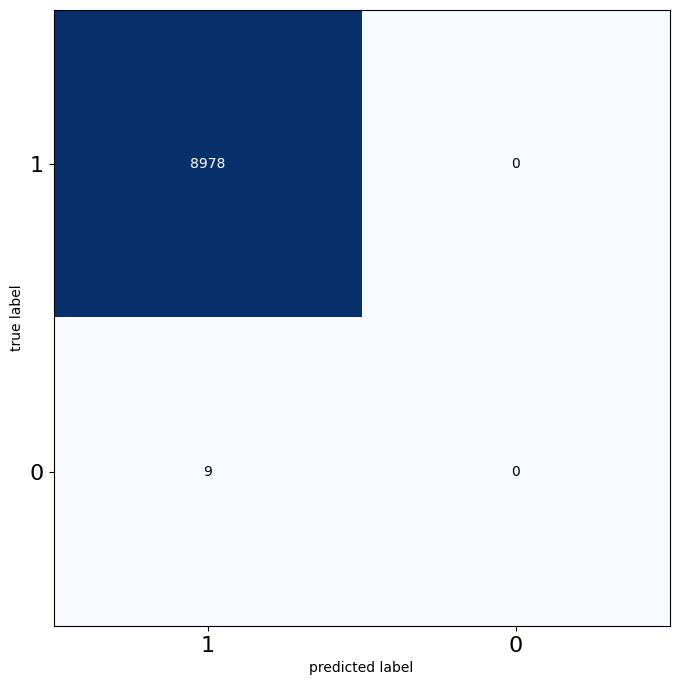

Motorvehicle Dealers - New
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

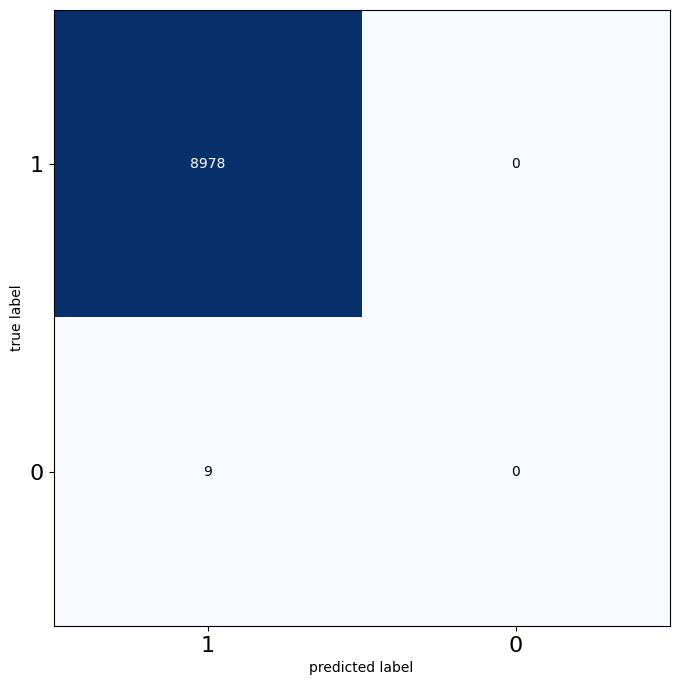

Motorvehicle Parts & Supplies
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

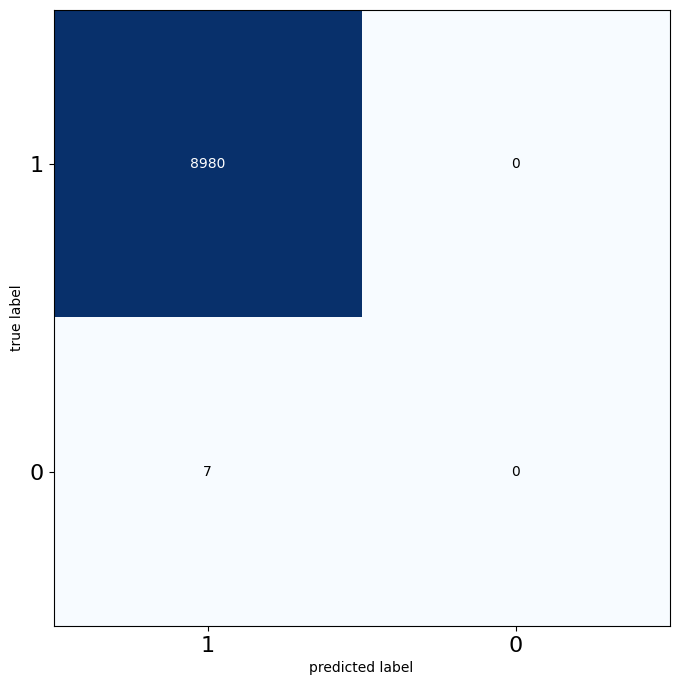

Motorvehicle Washing & Polishing
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

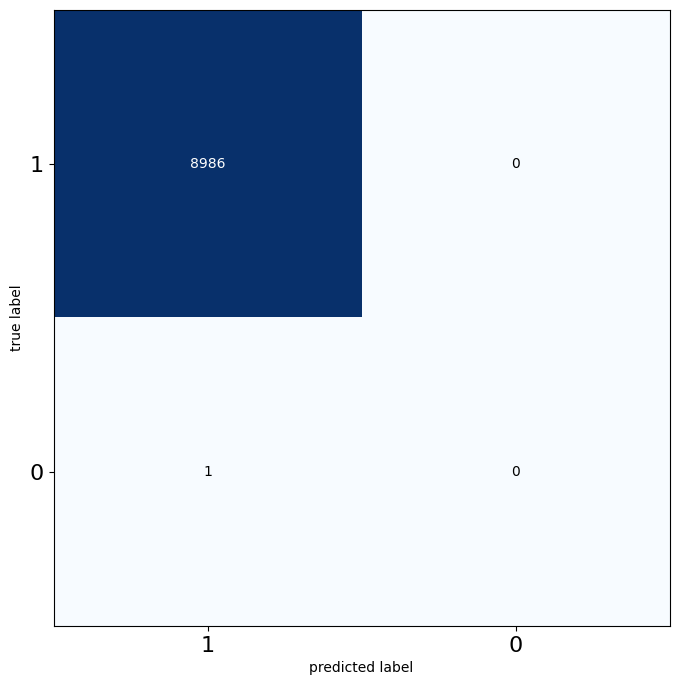

Movers
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

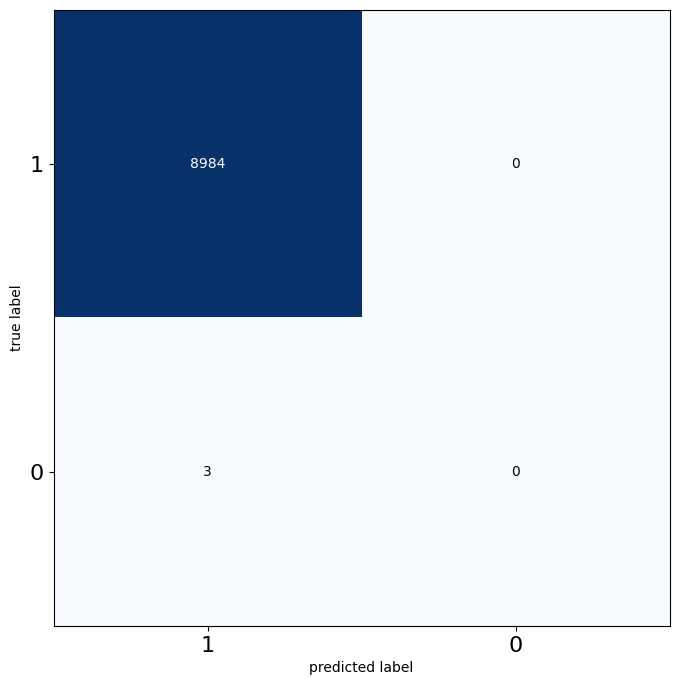

Museums
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

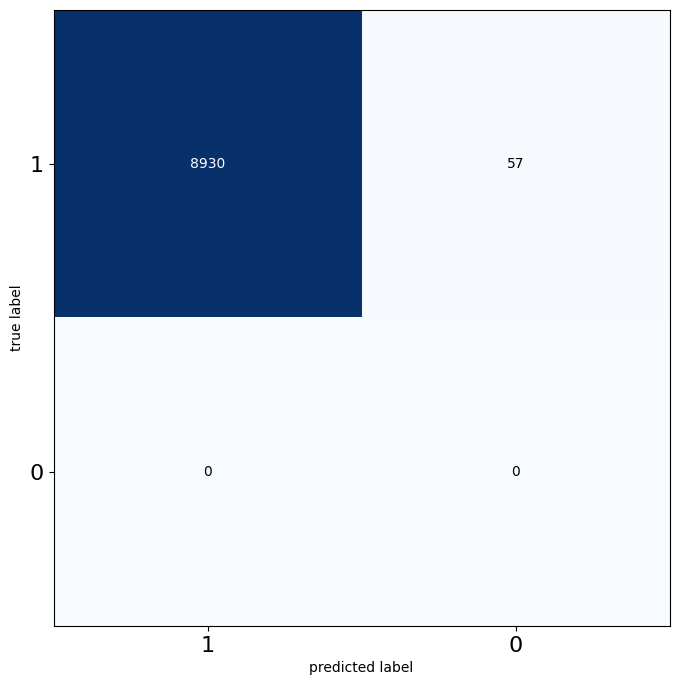

Music & Video Shops
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

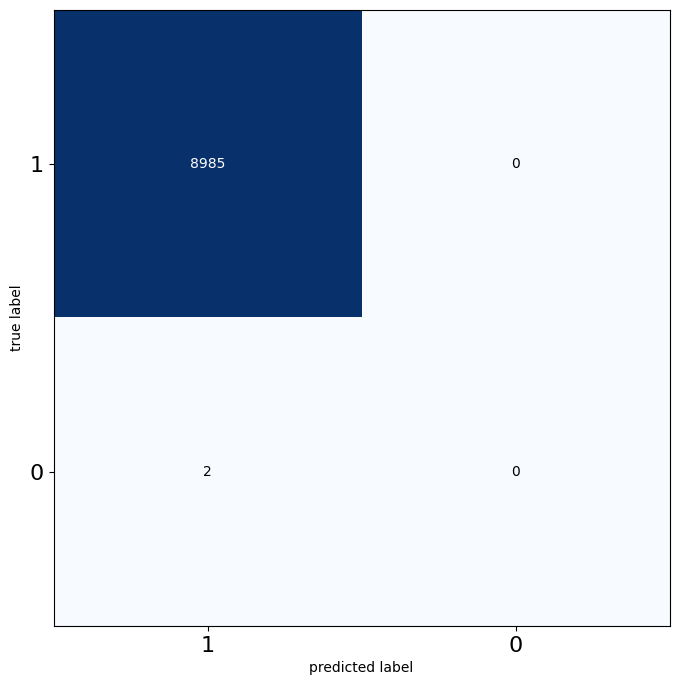

Music Instruction
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

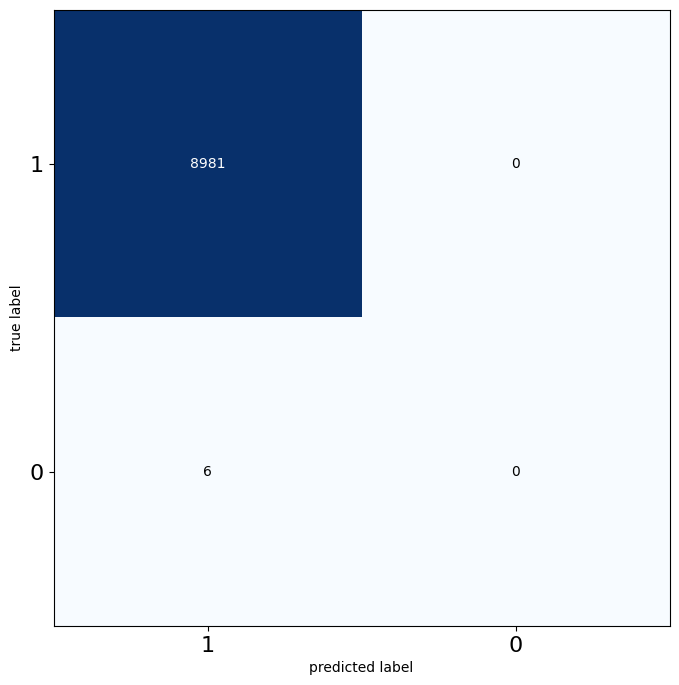

Music Publishers
accuracy: 0.9918771558918438 precision: 0.014705882352941176 recall: 0.14285714285714285 f1: 0.026666666666666665


<Figure size 640x480 with 0 Axes>

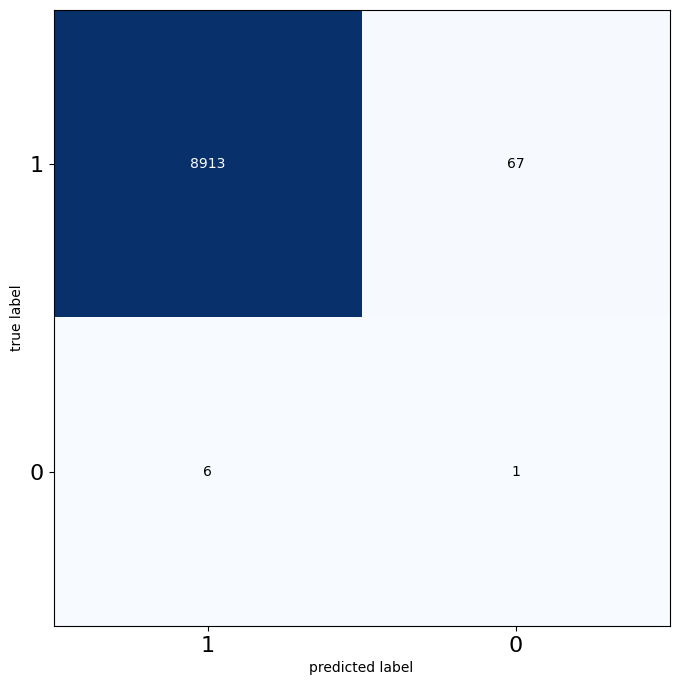

Music Studios
accuracy: 0.9829754089240014 precision: 0.008547008547008548 recall: 0.02631578947368421 f1: 0.012903225806451615


<Figure size 640x480 with 0 Axes>

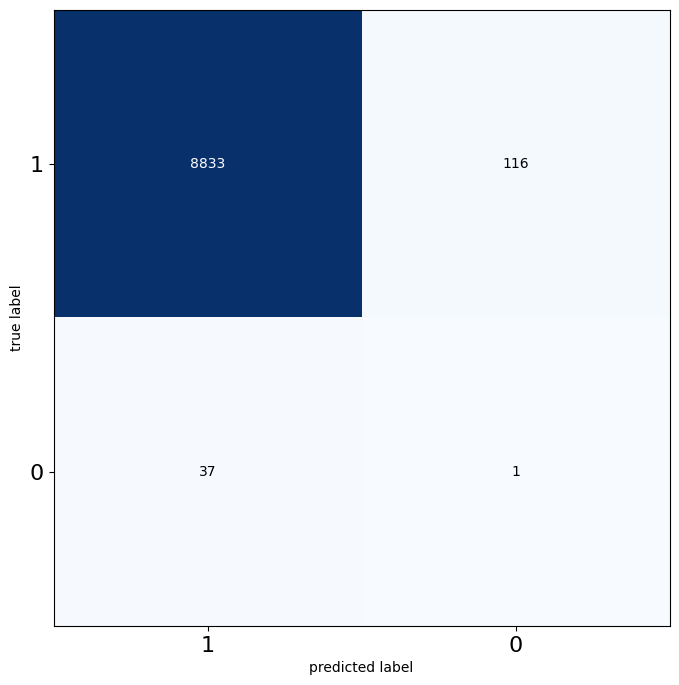

Musical Instruments-Dealers & Repairs
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

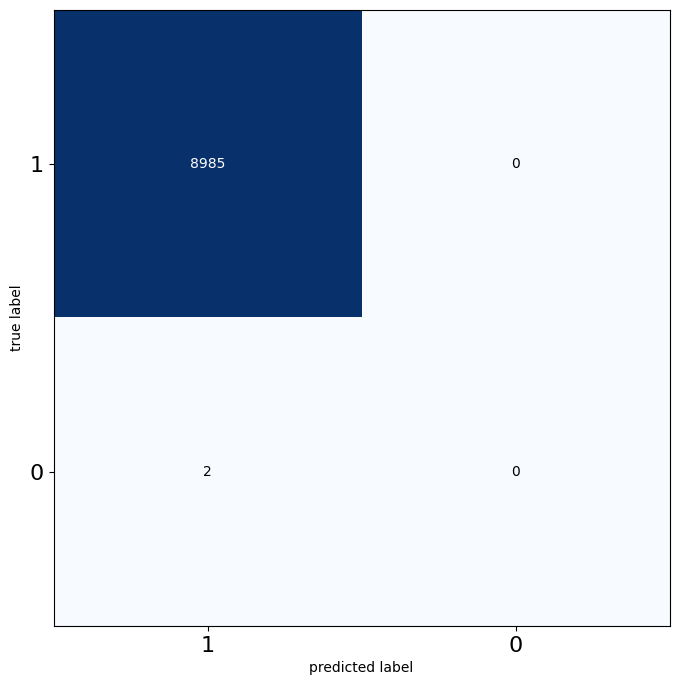

Musicians
accuracy: 0.9987760097919217 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

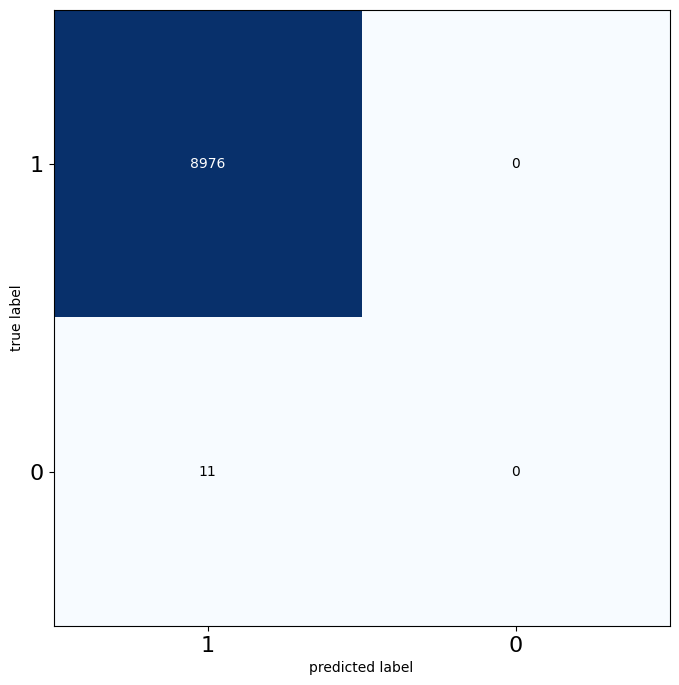

Nails & Tacks
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

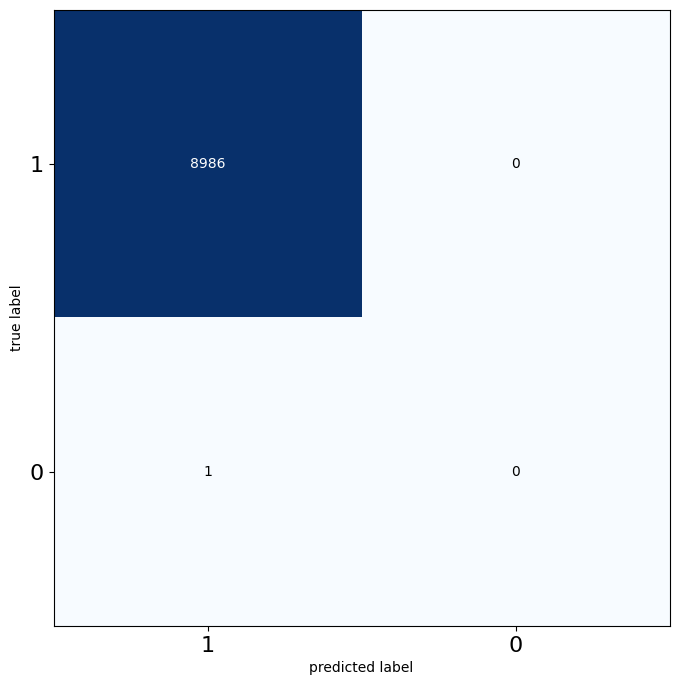

News Agencies & Services
accuracy: 0.9931011460999221 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

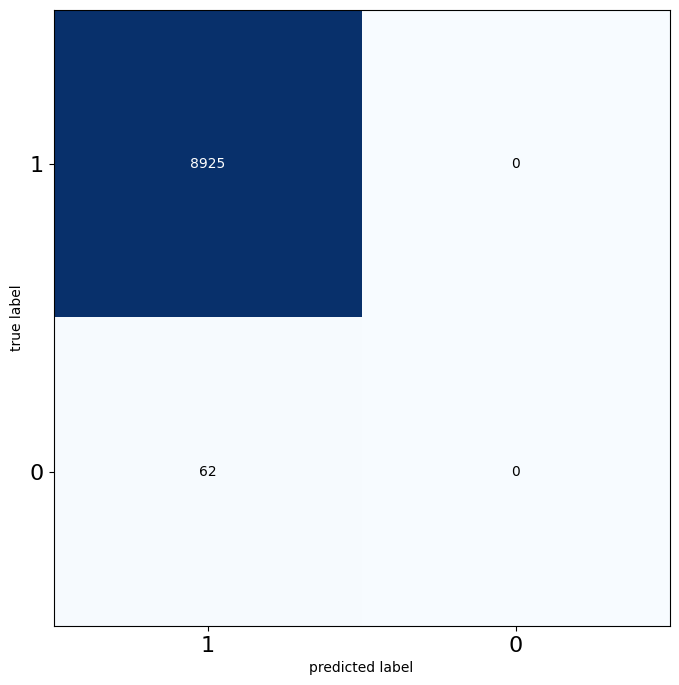

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Newspapers & Periodicals
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

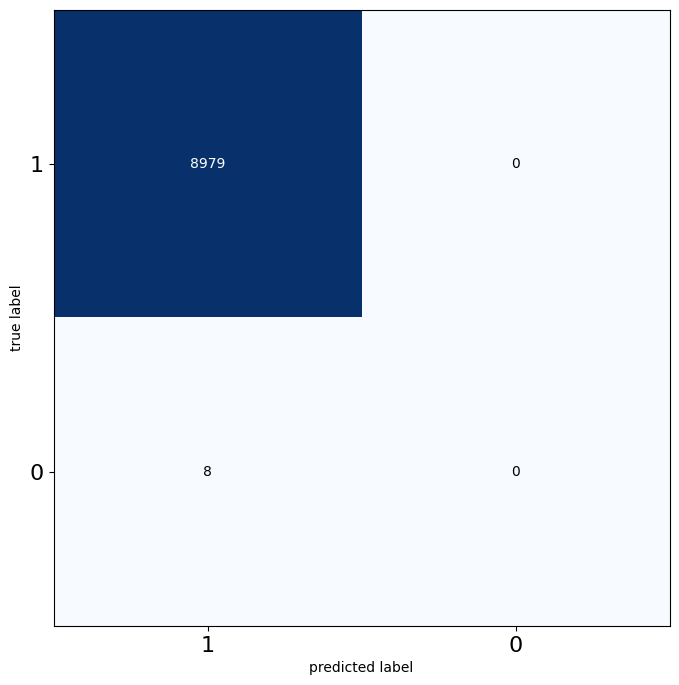

Nightclubs
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

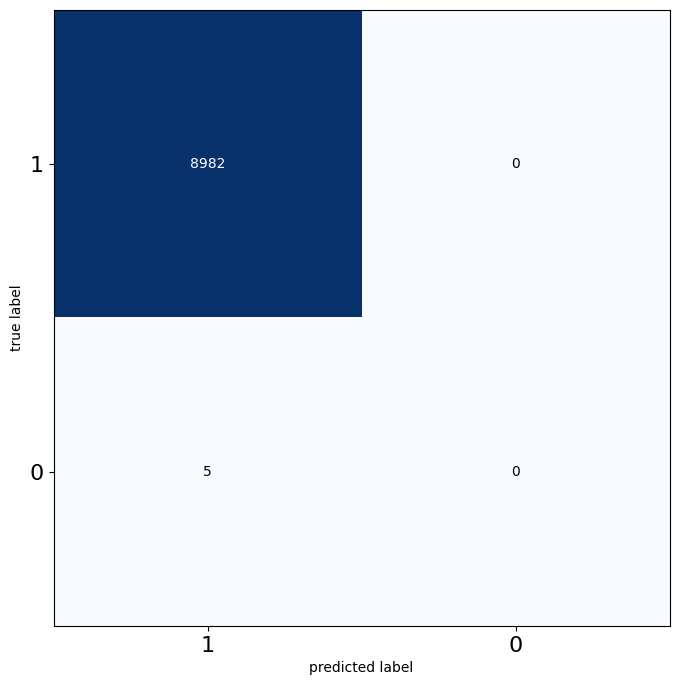

Nurseries-Plants
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

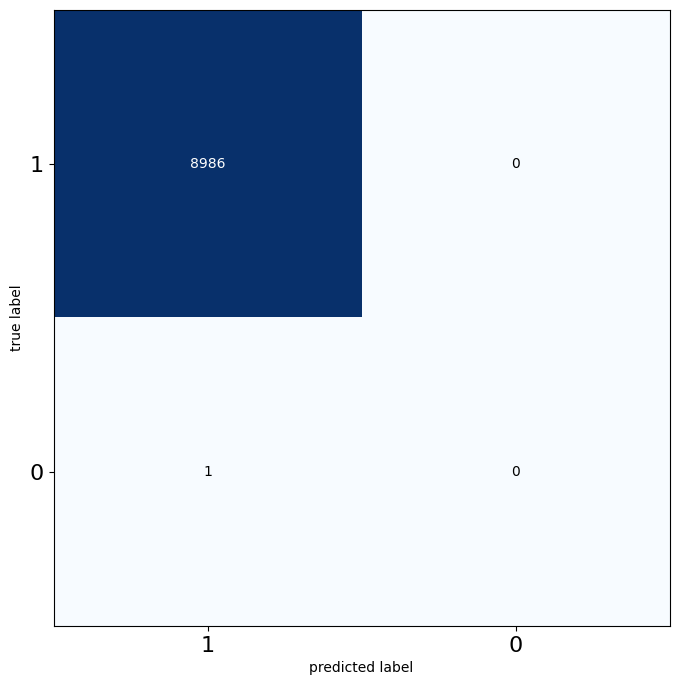

Nursery Schools & Homes
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

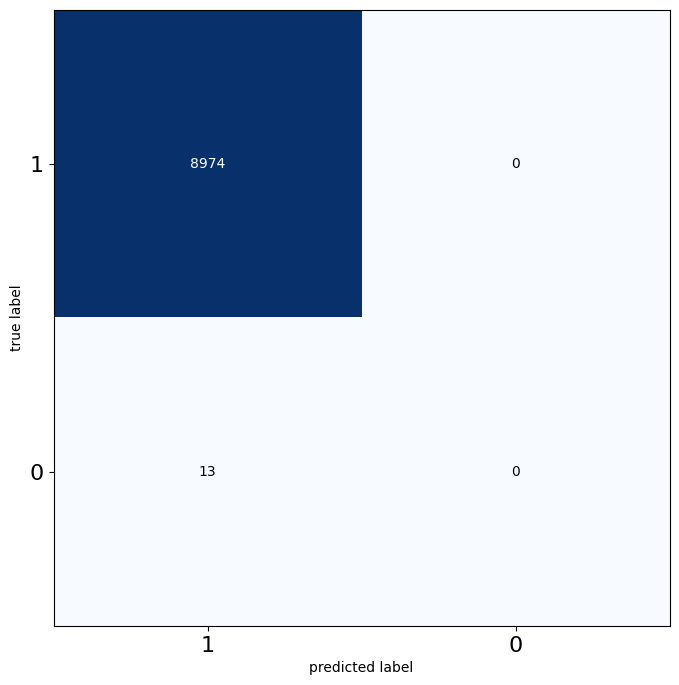

Nursing Homes
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

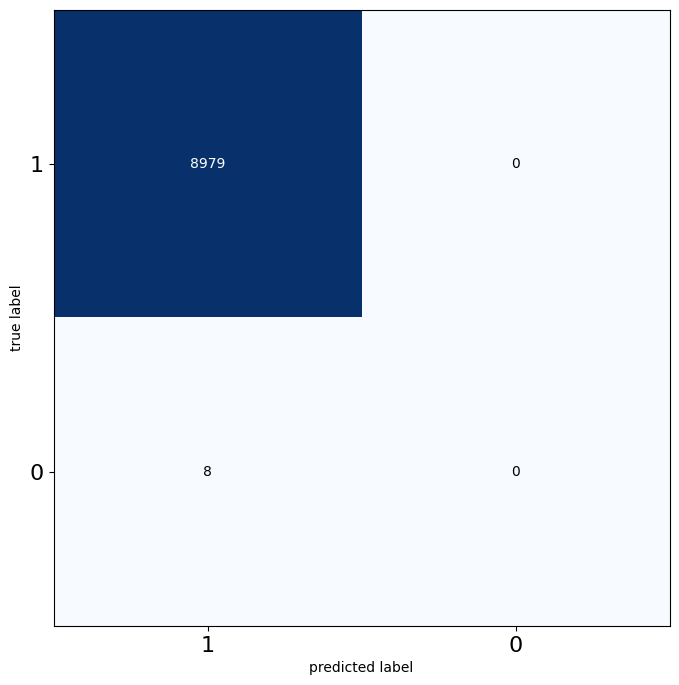

Nutritionists
accuracy: 0.9909869811950596 precision: 0.014084507042253521 recall: 0.08333333333333333 f1: 0.024096385542168676


<Figure size 640x480 with 0 Axes>

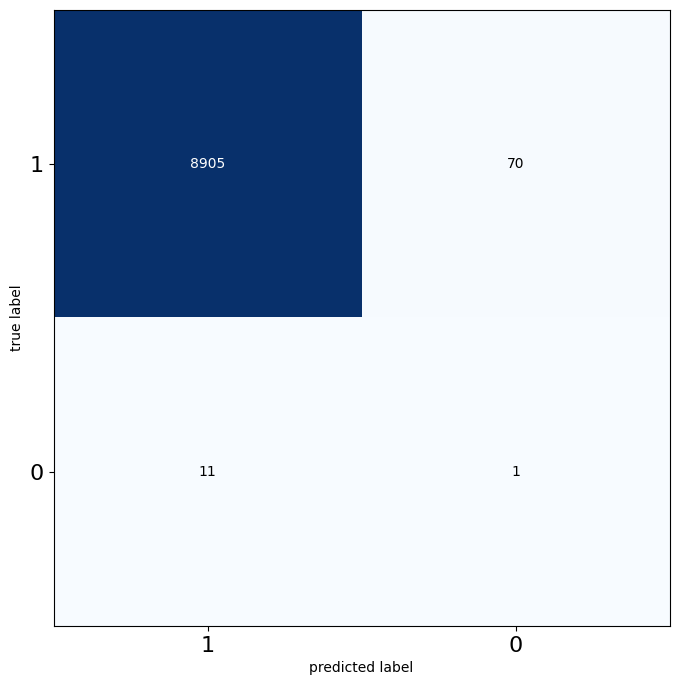

Nuts-Edible
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

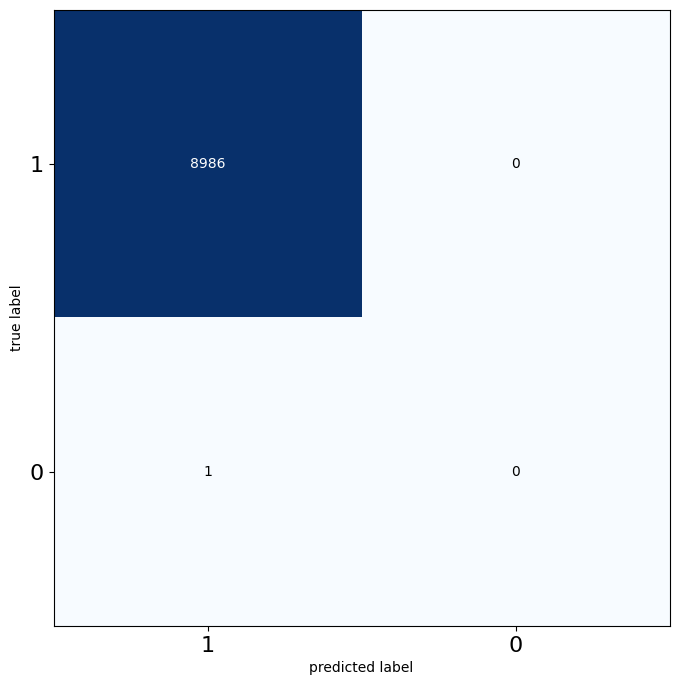

Office Equipment & Supplies
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

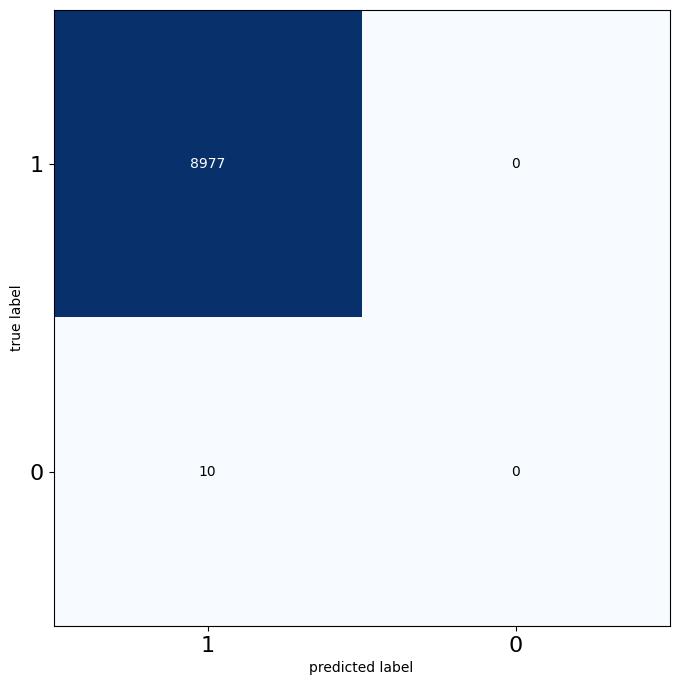

Office Equipment Leasing
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

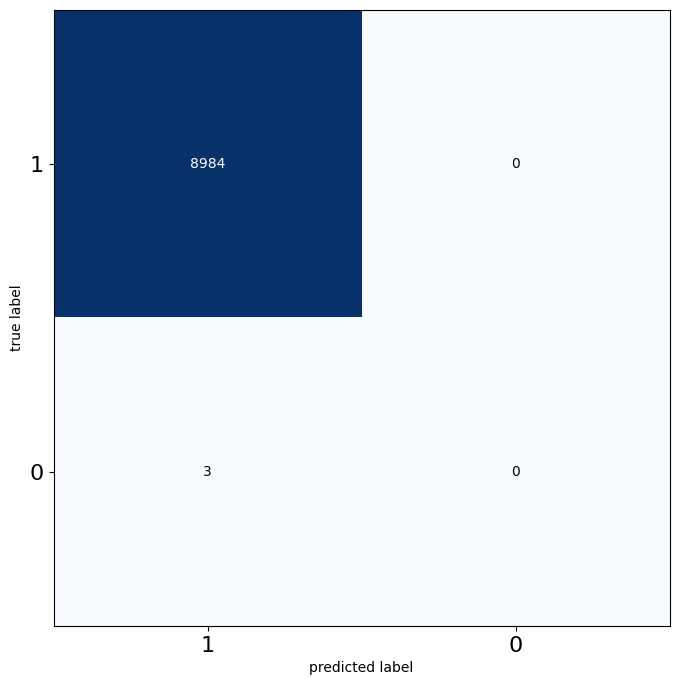

Office Equipment-Repair
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

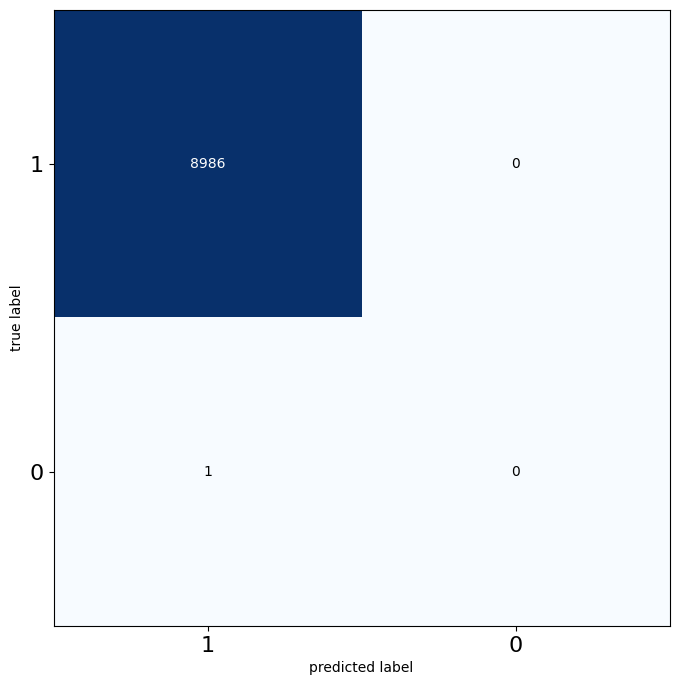

Office Furniture
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

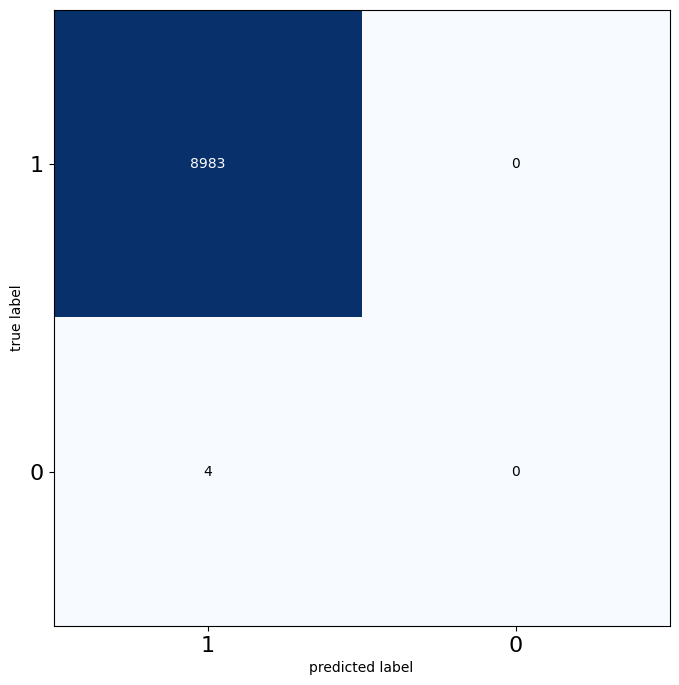

Oil & Gas Exploration
accuracy: 0.9882051852676088 precision: 0.07142857142857142 recall: 0.010638297872340425 f1: 0.018518518518518517


<Figure size 640x480 with 0 Axes>

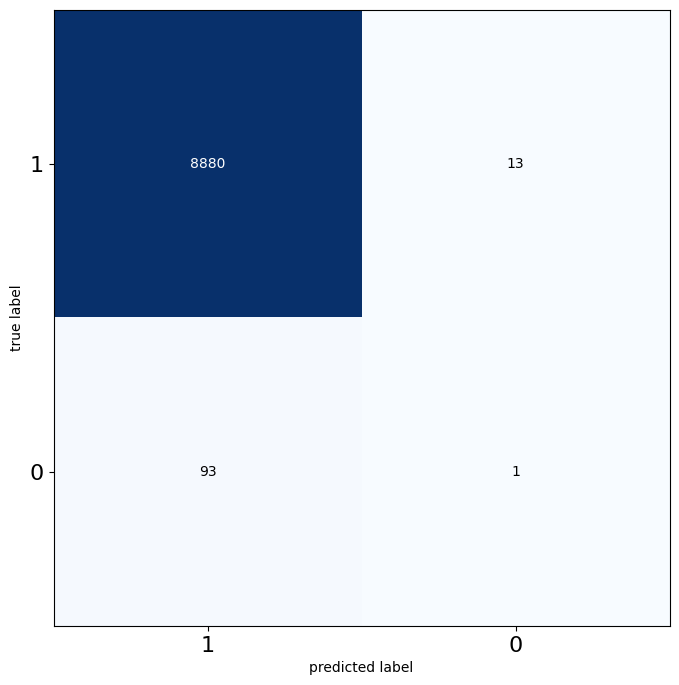

Oil Companies
accuracy: 0.9972182040725492 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

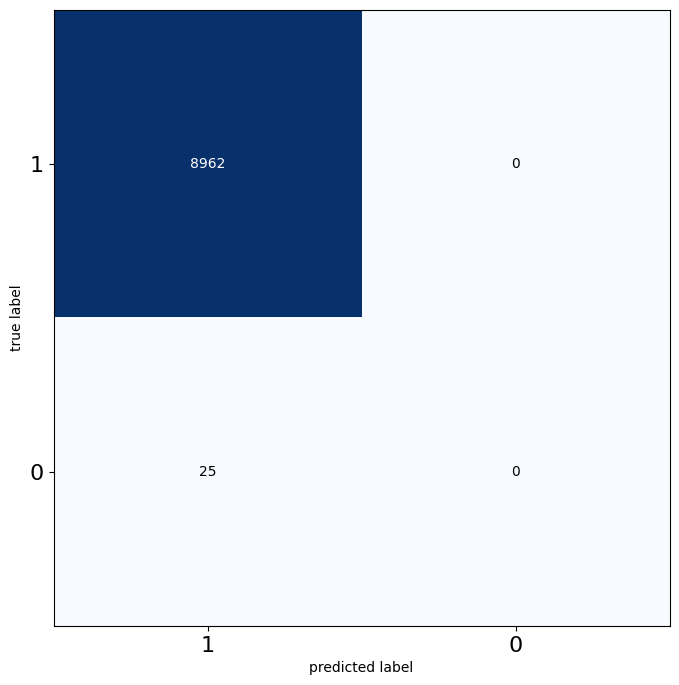

Oils - Cooking
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

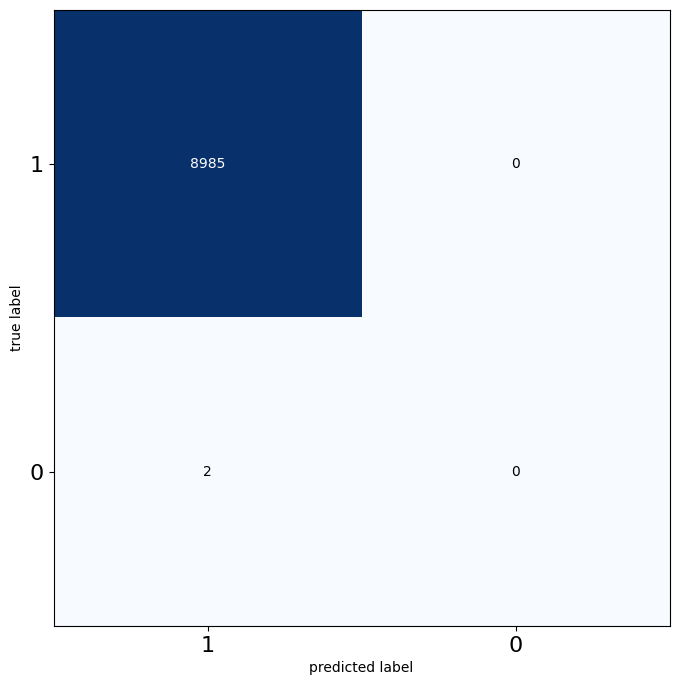

Online Marketing
accuracy: 0.9974407477467453 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

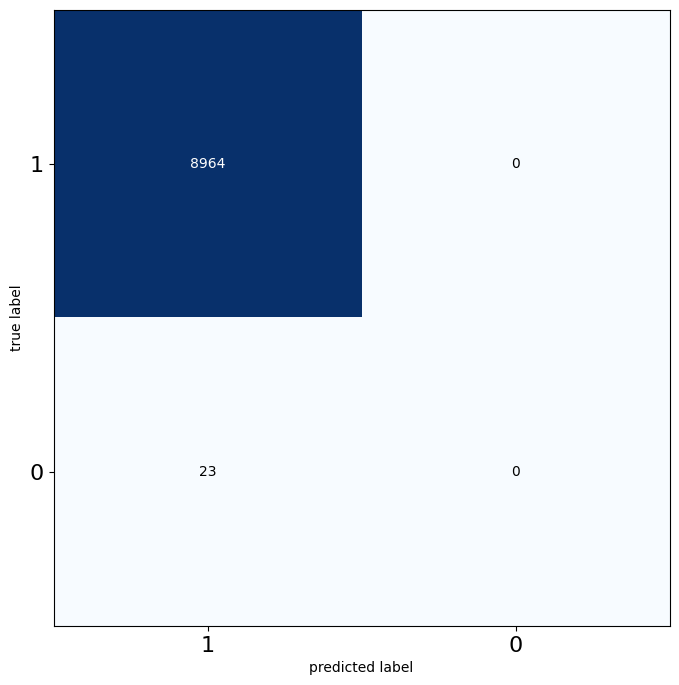

Ophthalmic Opticians/Optometrists
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

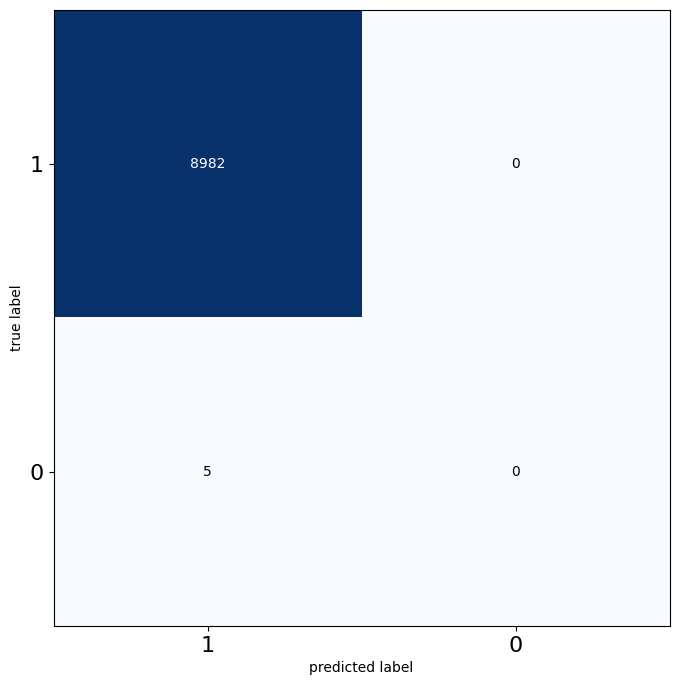

Optical Goods
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

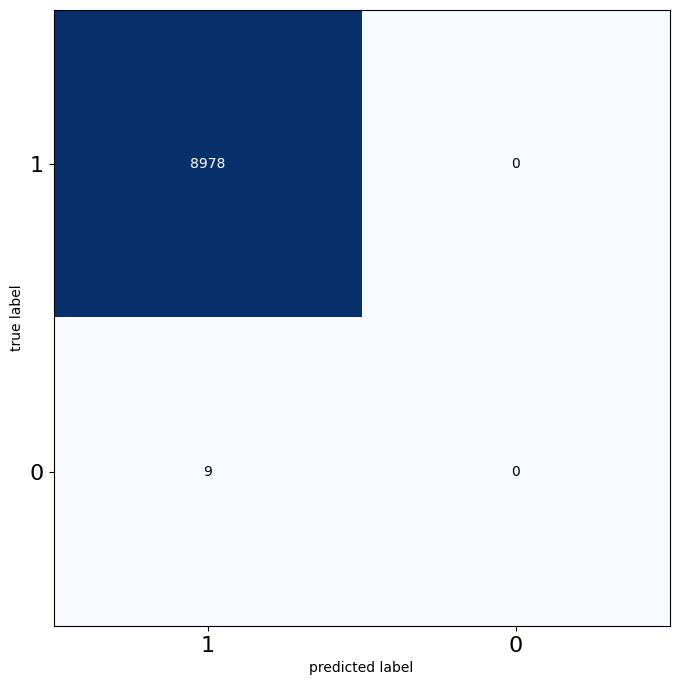

Opticians
accuracy: 0.9984421942806275 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

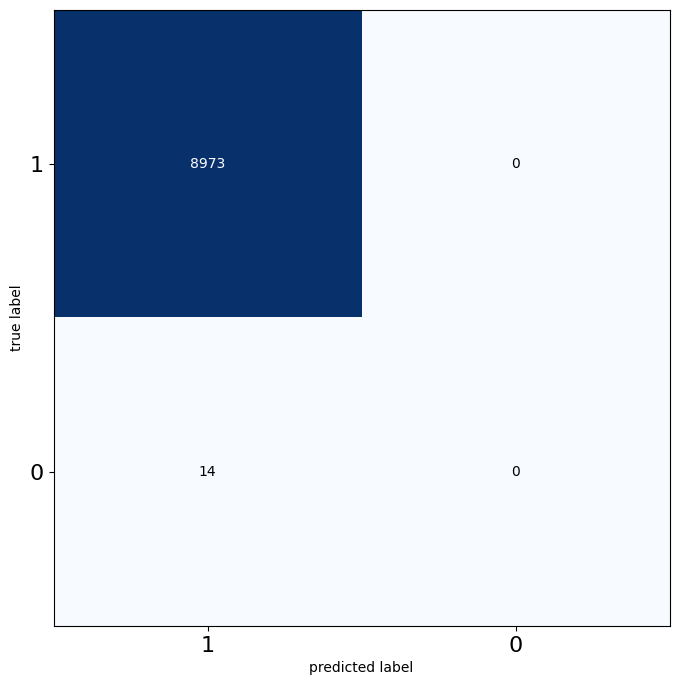

Packaging Machinery
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

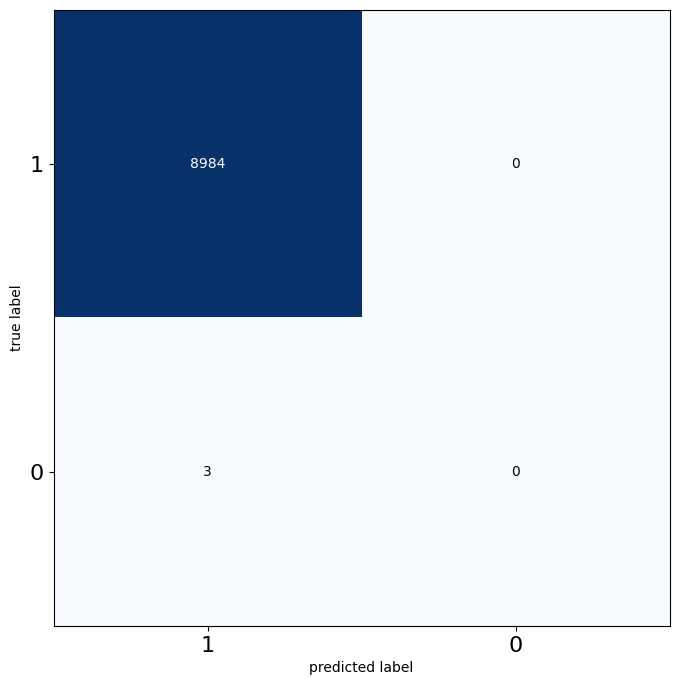

Packaging Materials
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

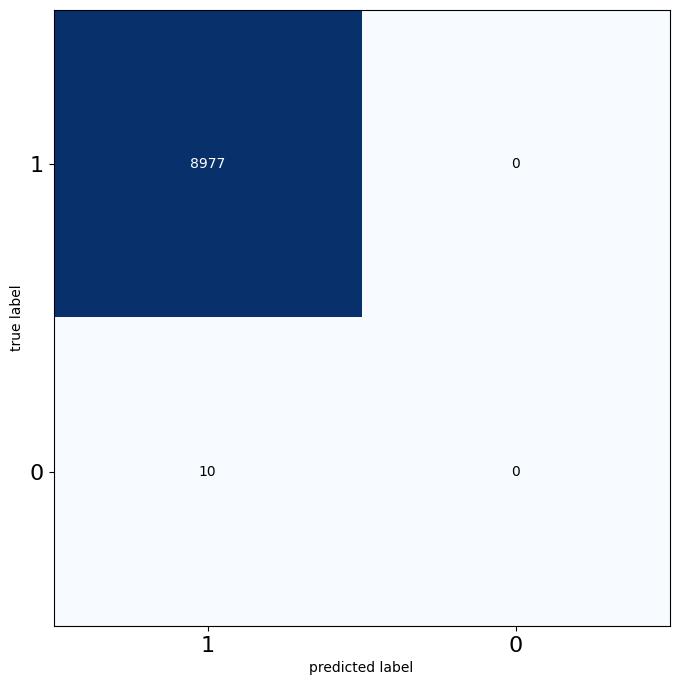

Packaging Service
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

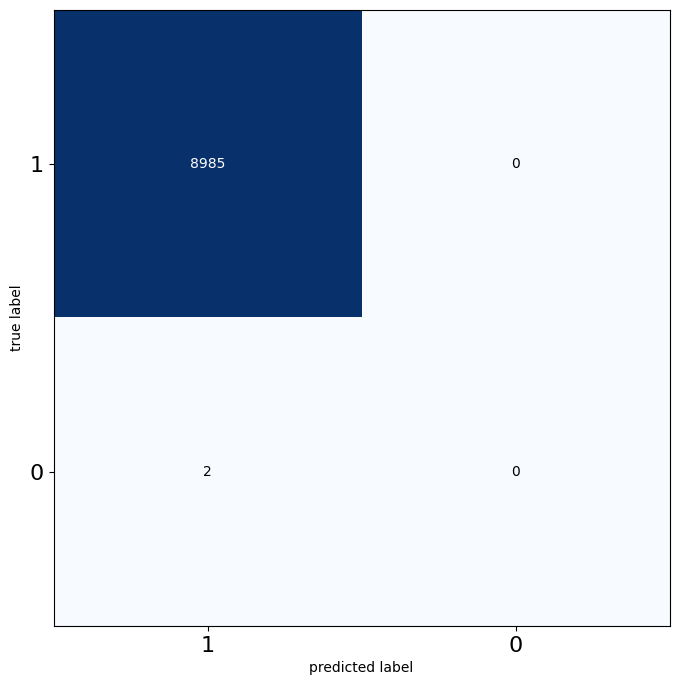

Paint - Wholesale & Manufacturers
accuracy: 0.9934349616112162 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

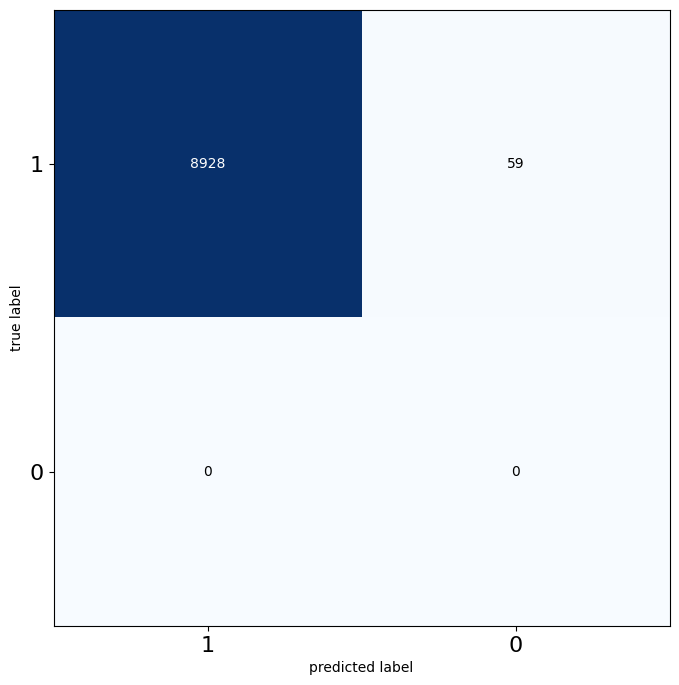

Painting Contractors
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

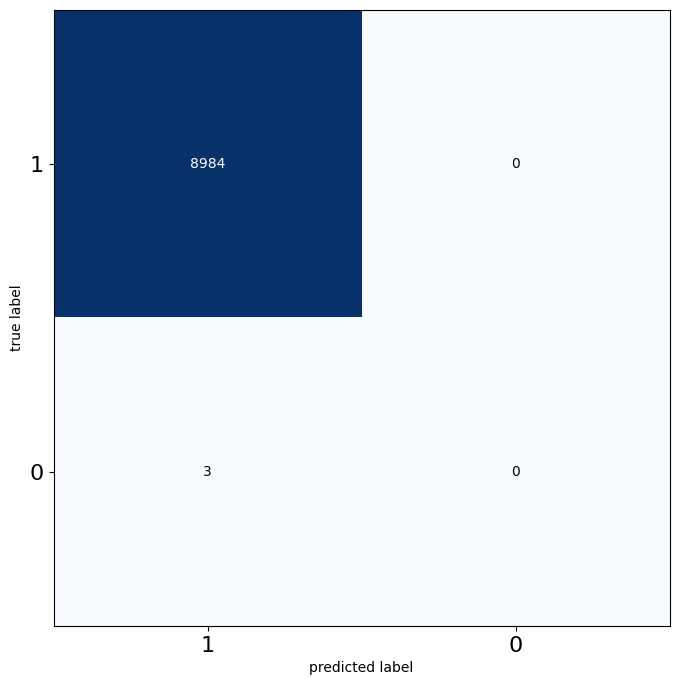

Painting Equipment & Supplies
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

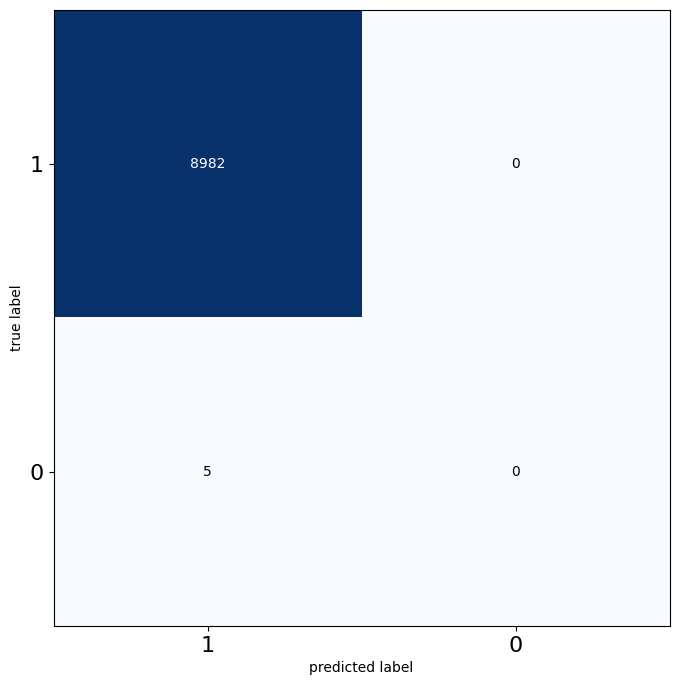

Paper Converters
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

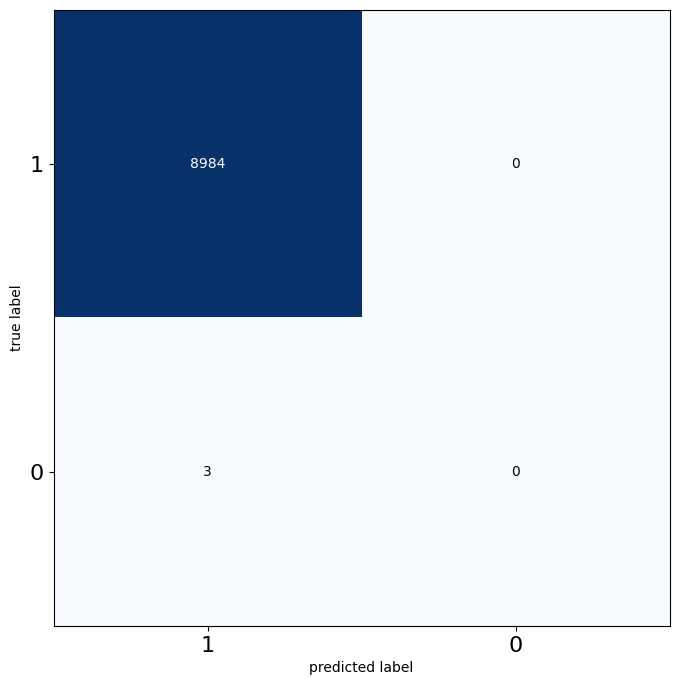

Paper Manufacturers
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

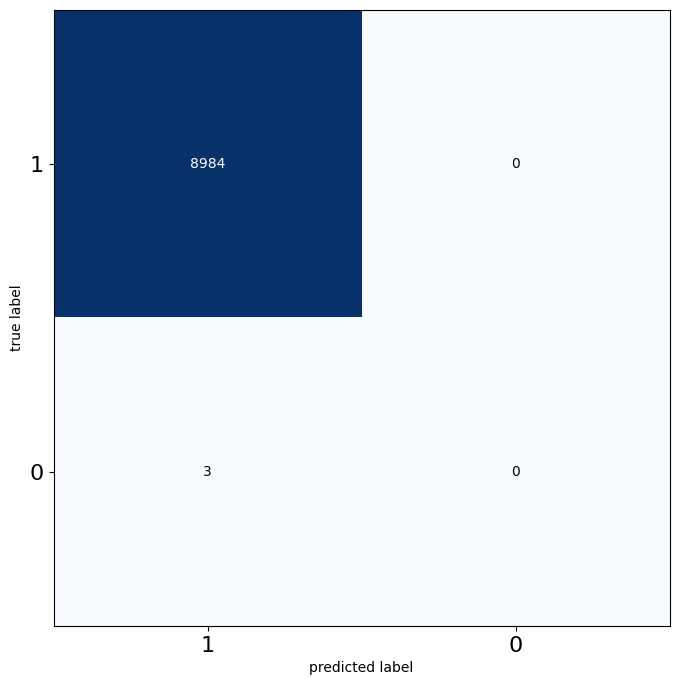

Paper Products
accuracy: 0.9917658840547457 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

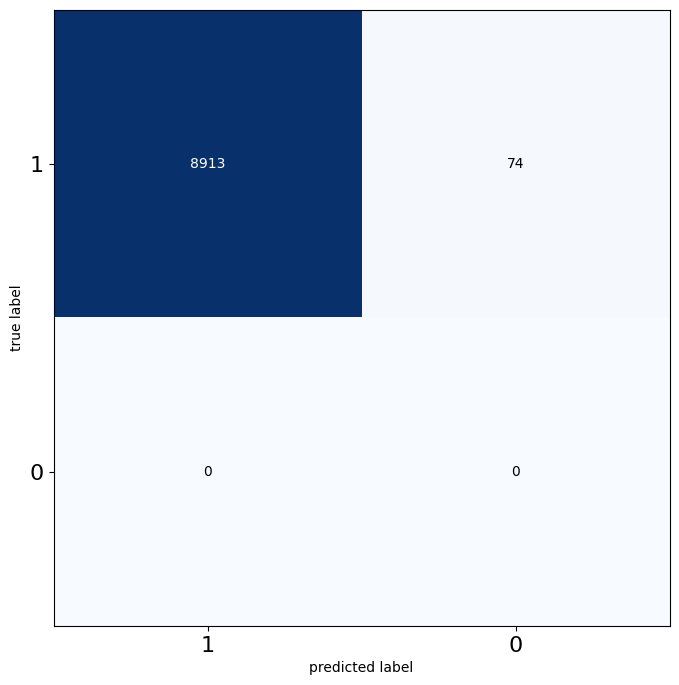

Parastatals
accuracy: 0.996216757538667 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

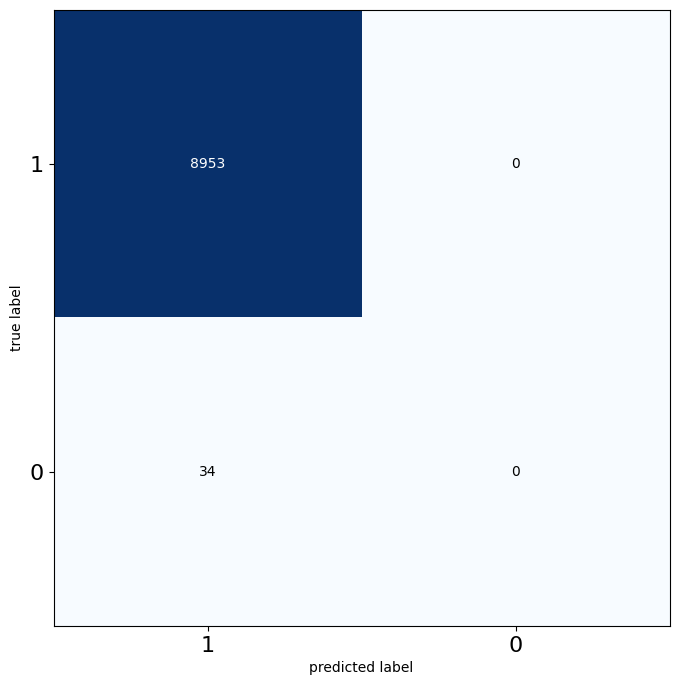

Parks
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

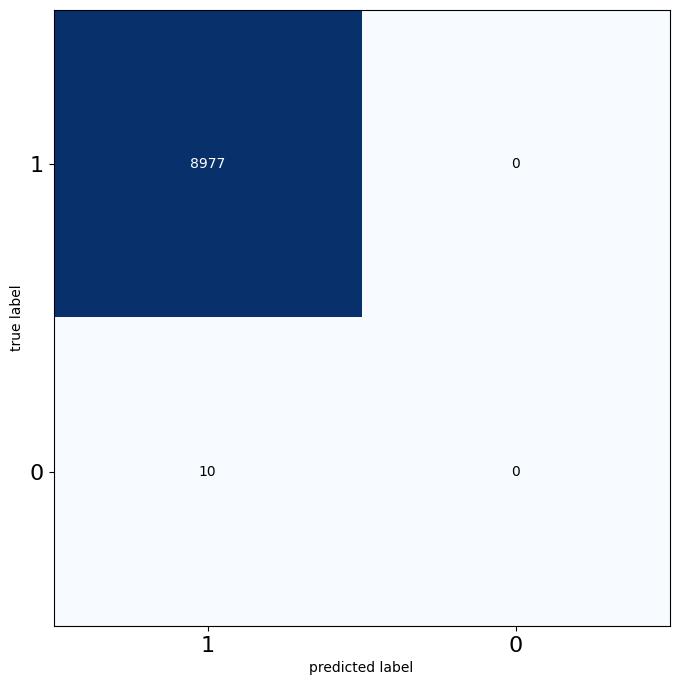

Party Service & Supplies
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

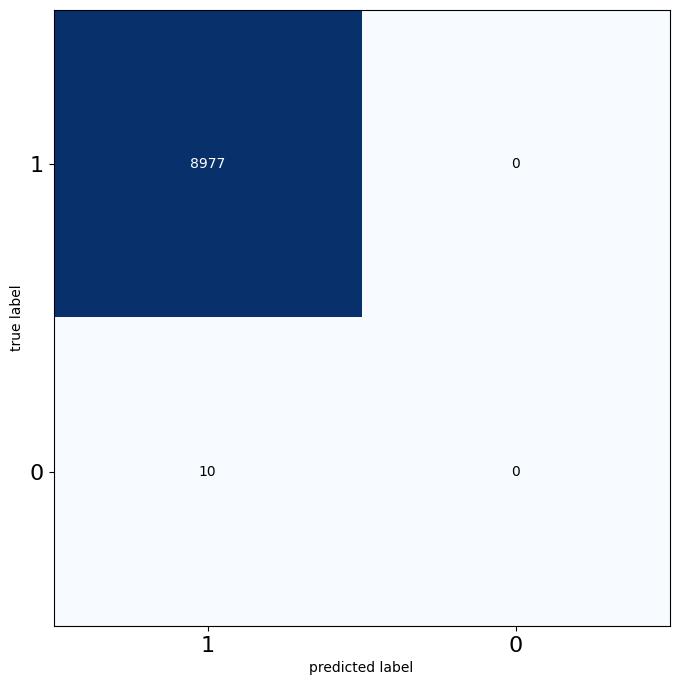

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pastry Shops
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

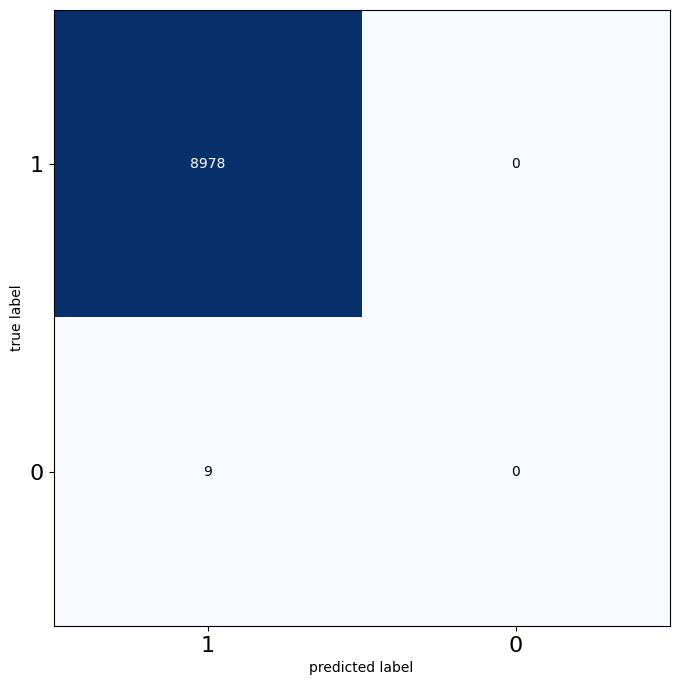

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pension Administration
accuracy: 0.9943251363080005 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

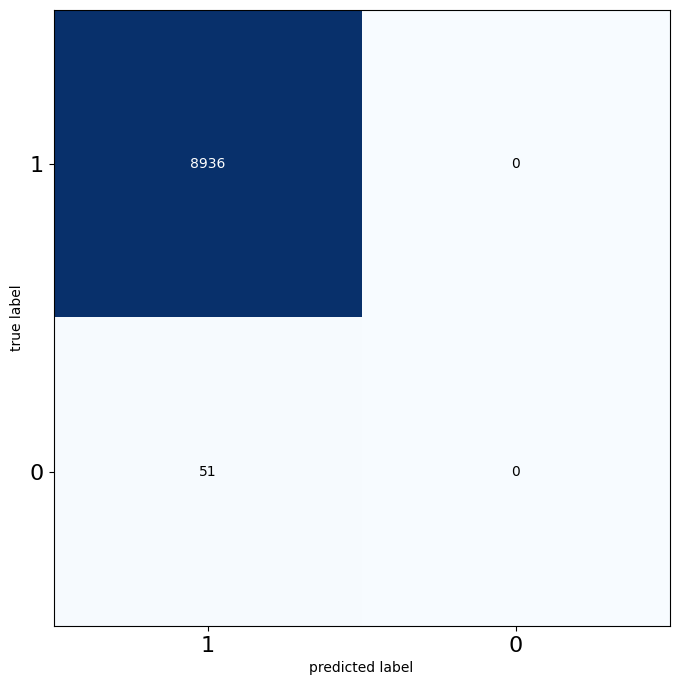

Perfumes
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

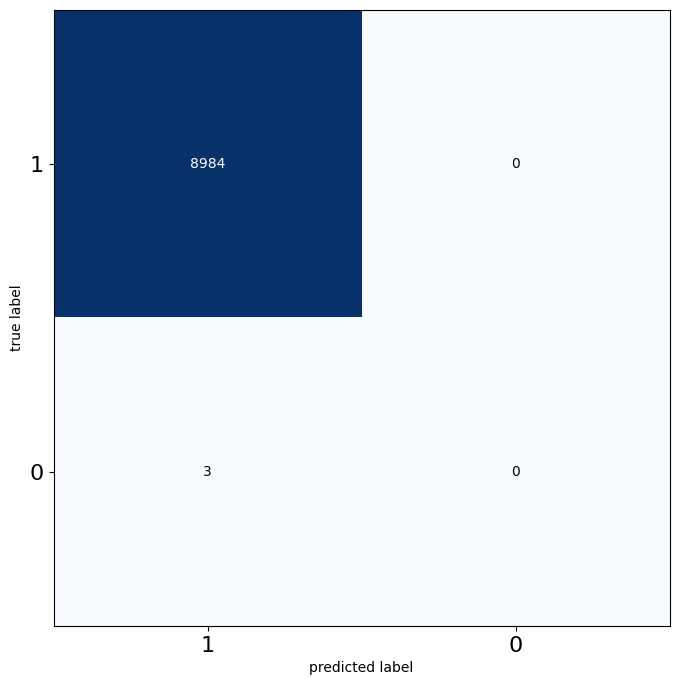

Personal Care Products
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

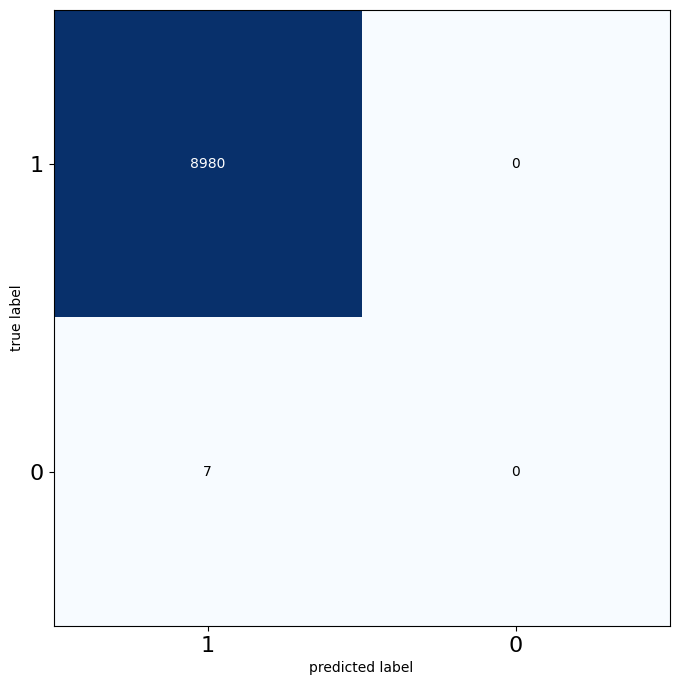

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Personal Services
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

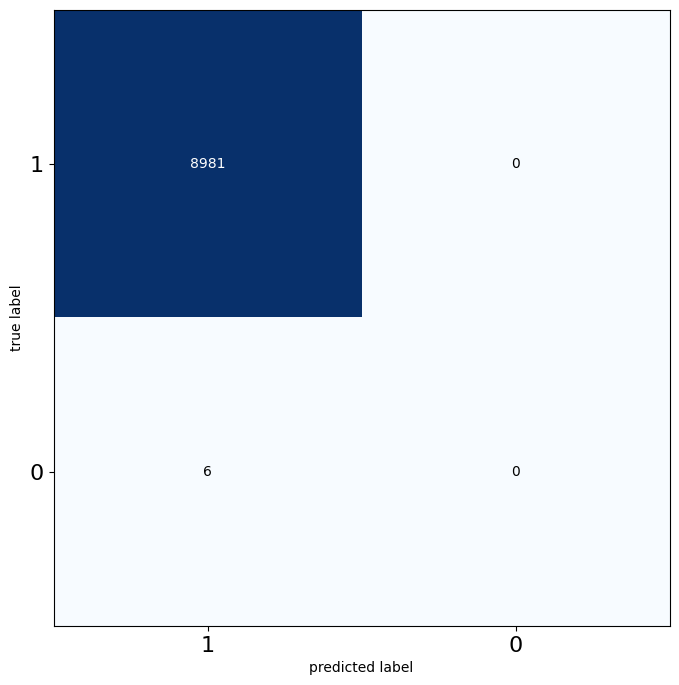

Pest Control
accuracy: 0.9971069322354512 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

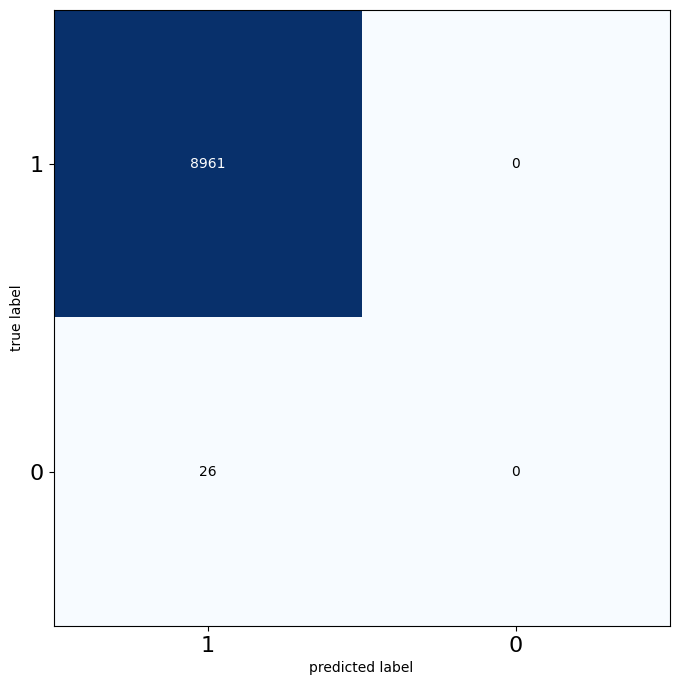

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pet Shops
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

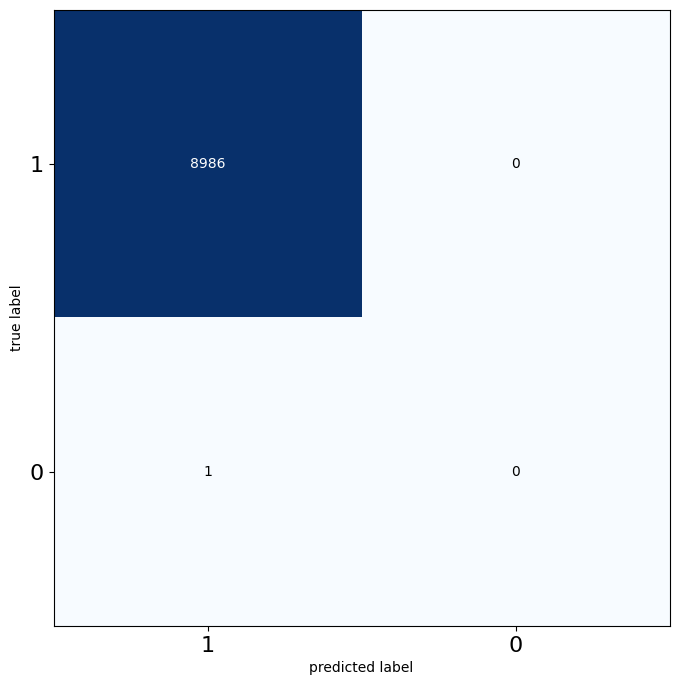

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Petrol & Oil Marketers & Distributors
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

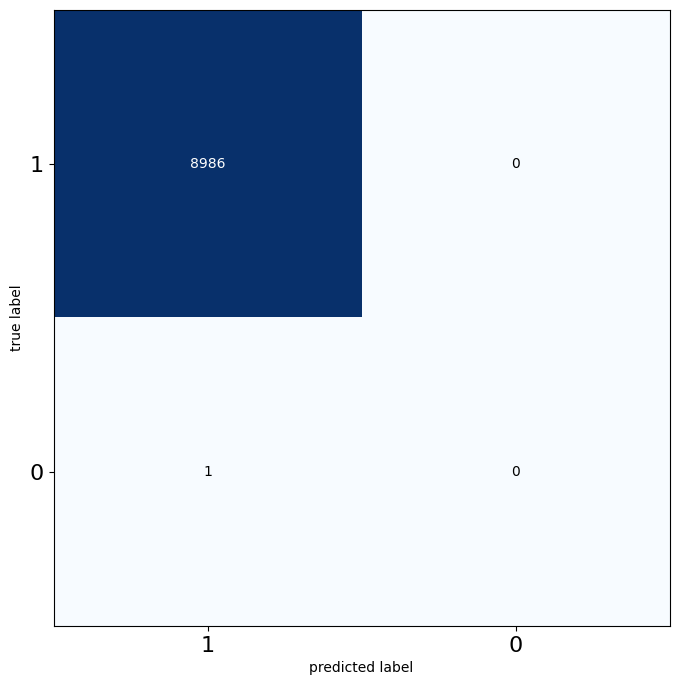

Petrol Stations
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

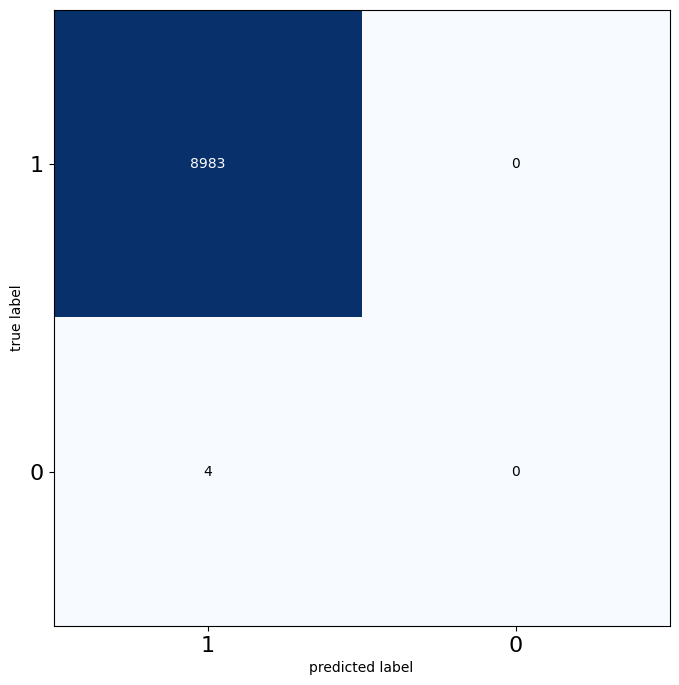

Petroleum Products
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

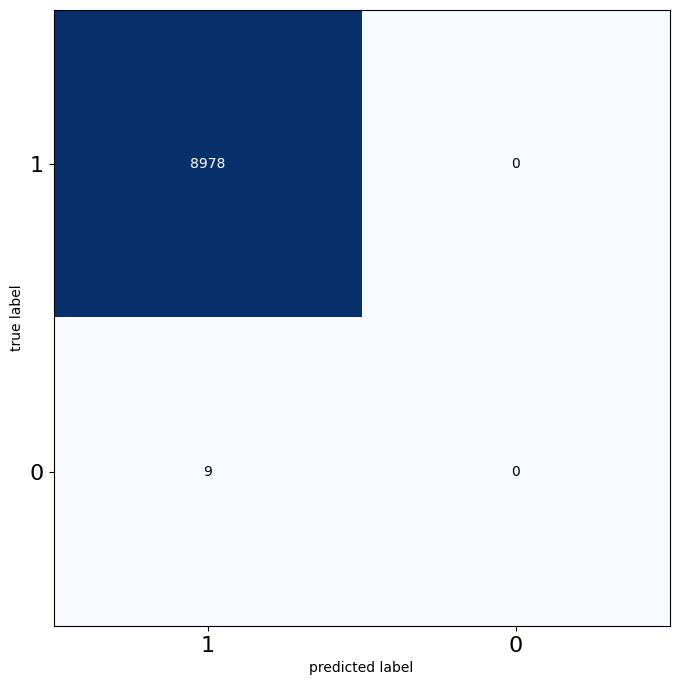

Pharmaceutical Equipment
accuracy: 0.9971069322354512 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

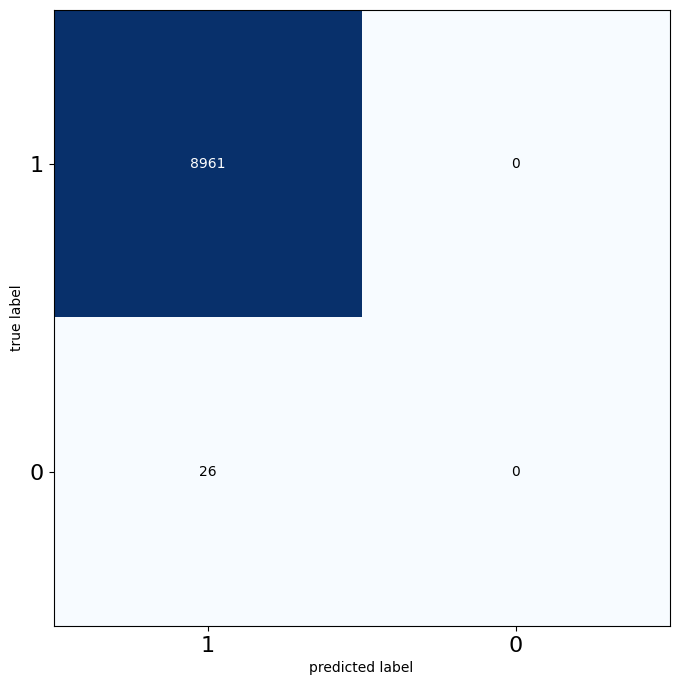

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pharmaceuticals-Manufacturers, Agents & Distributors
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

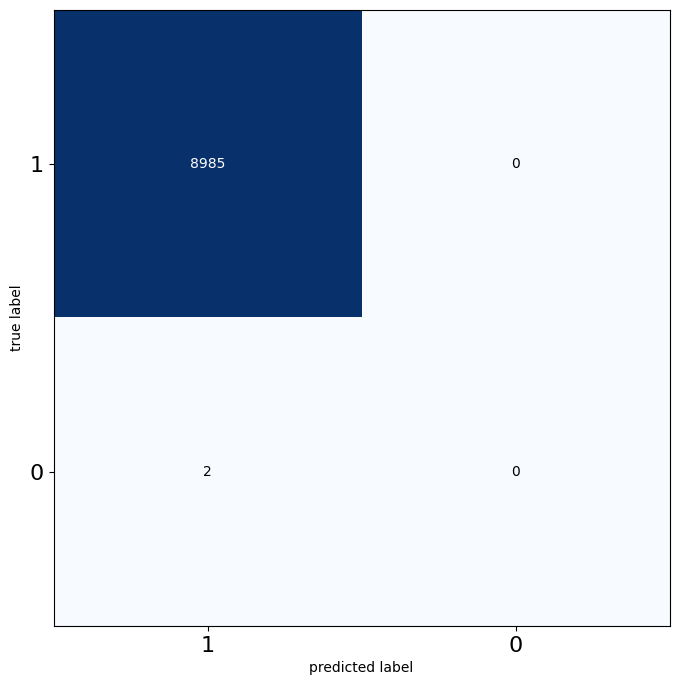

Pharmacies
accuracy: 0.9910982530321576 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

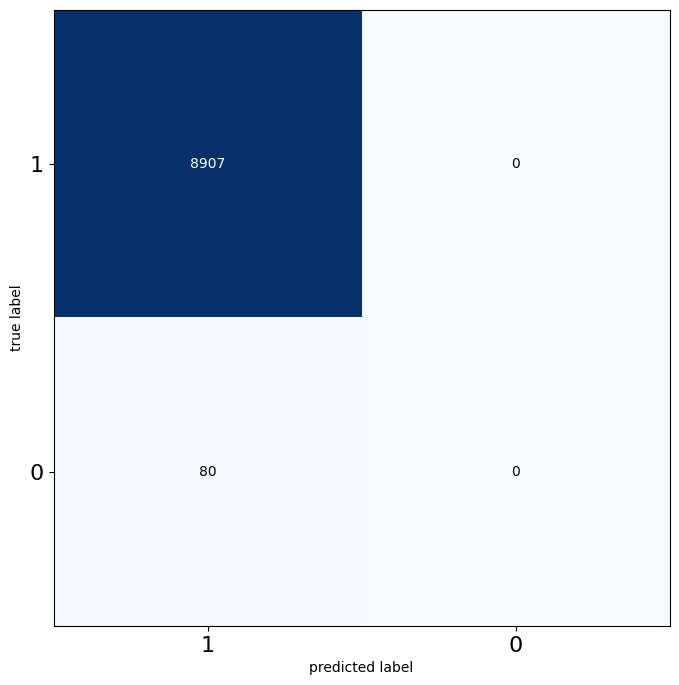

Photocopying Services
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

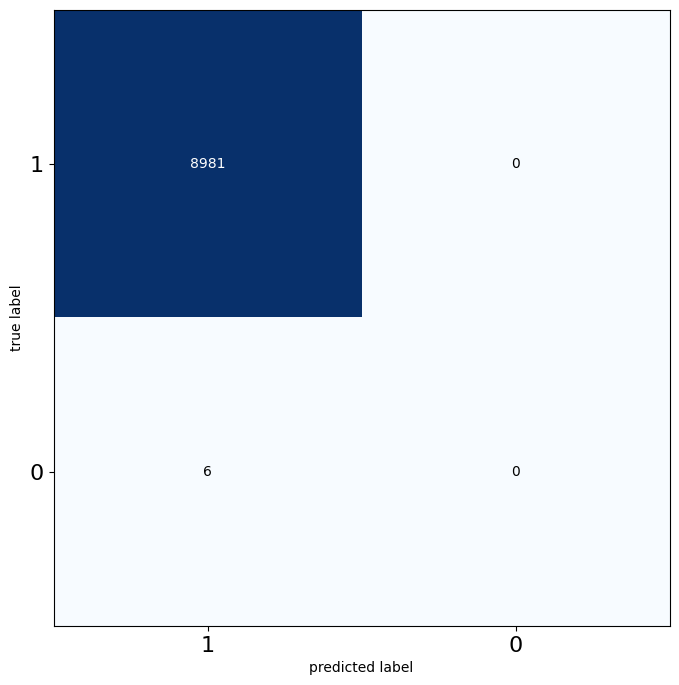

Photographers
accuracy: 0.9946589518192945 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

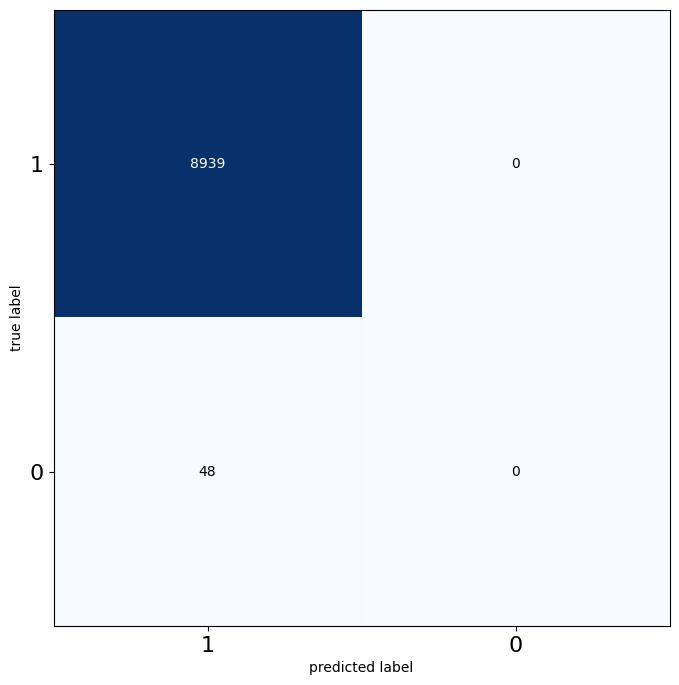

Photographic Equipment
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

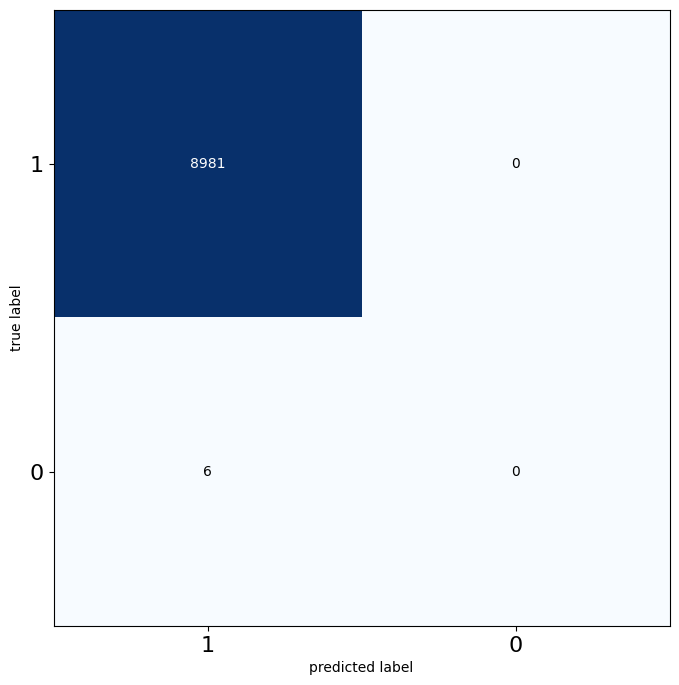

Photographic Products & Supplies
accuracy: 0.9946589518192945 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

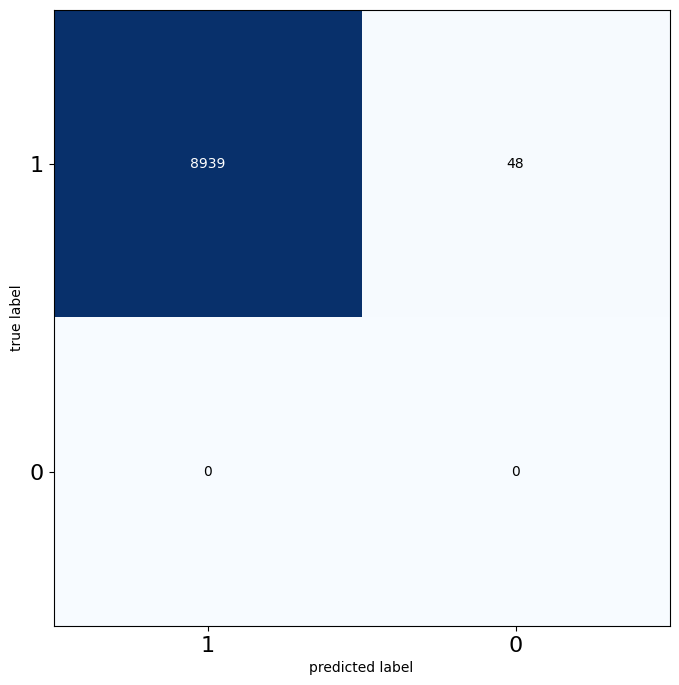

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Physiotherapists
accuracy: 0.9978858350951374 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

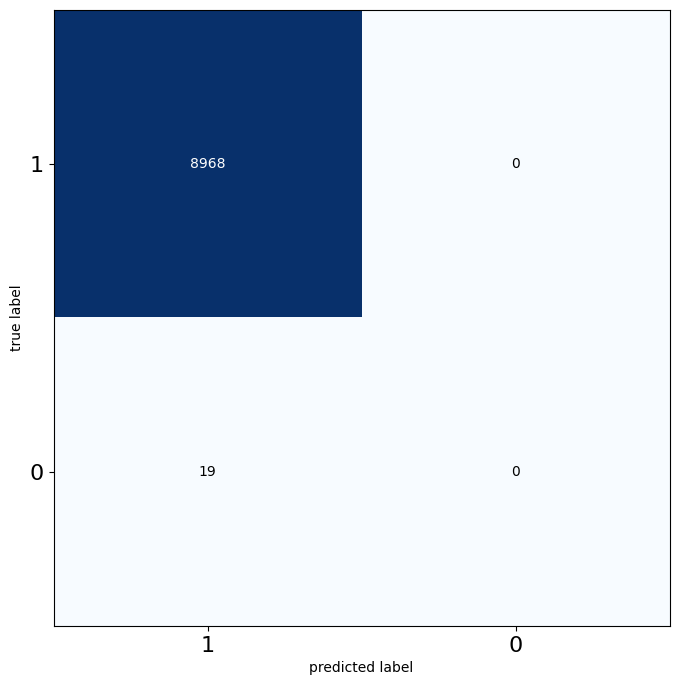

Plan Printing Equipment & Services
accuracy: 0.992989874262824 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

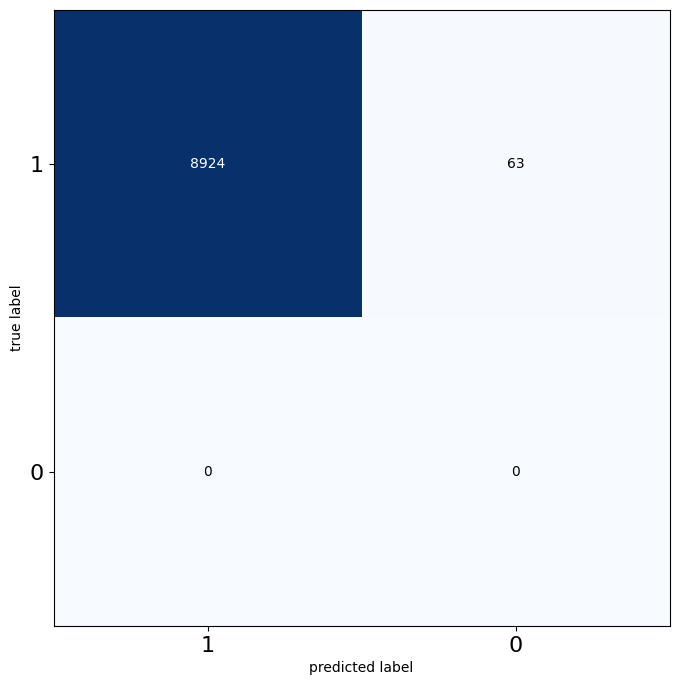

Planning Consultants
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

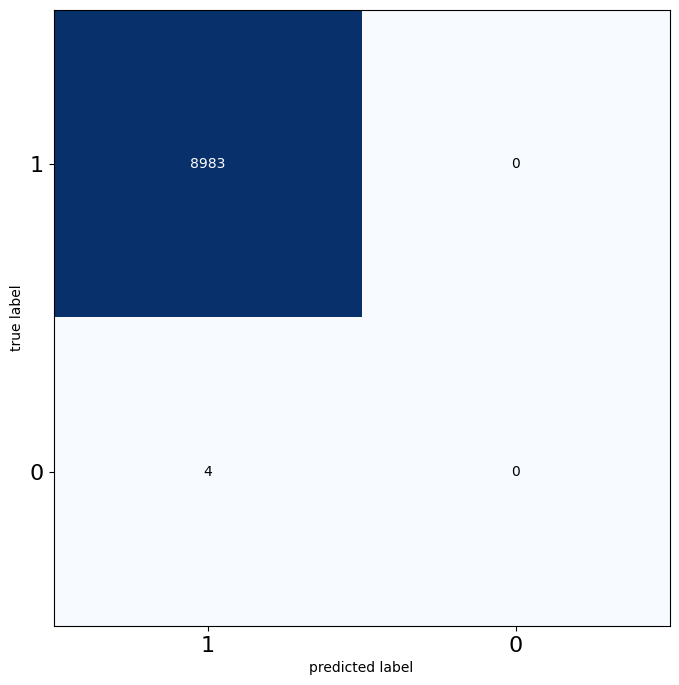

Plants
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

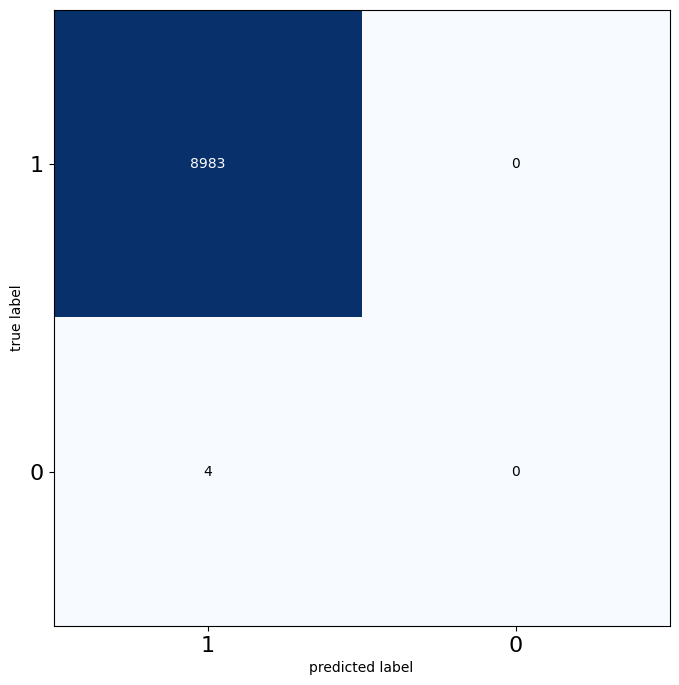

Plastic Products
accuracy: 0.9984421942806275 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

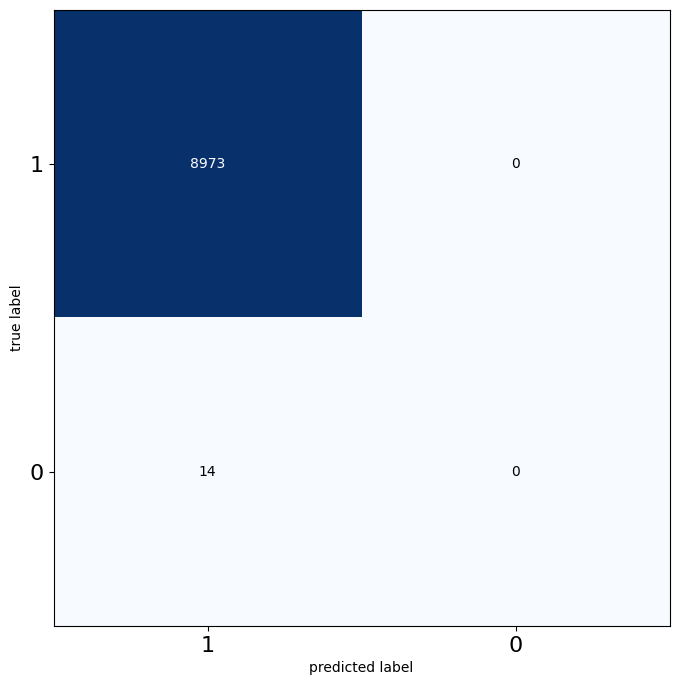

Plastics Raw Materials
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

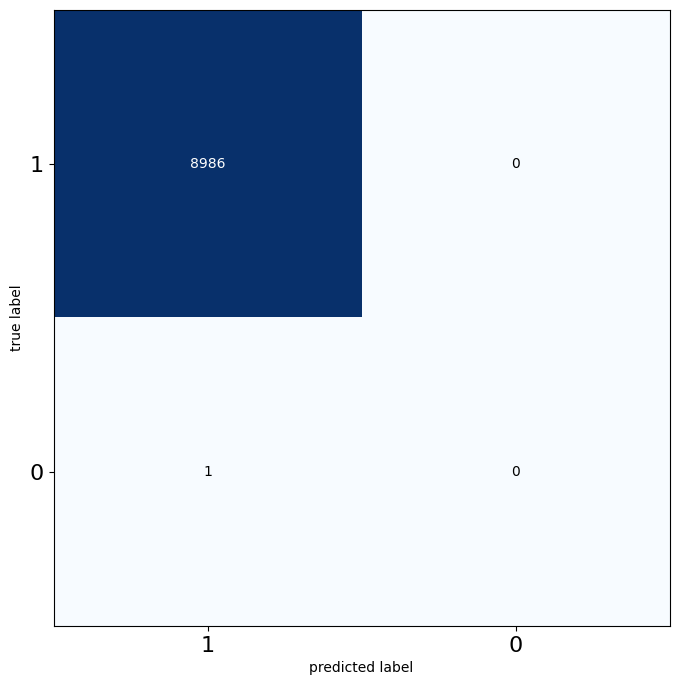

Playground Equipment
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

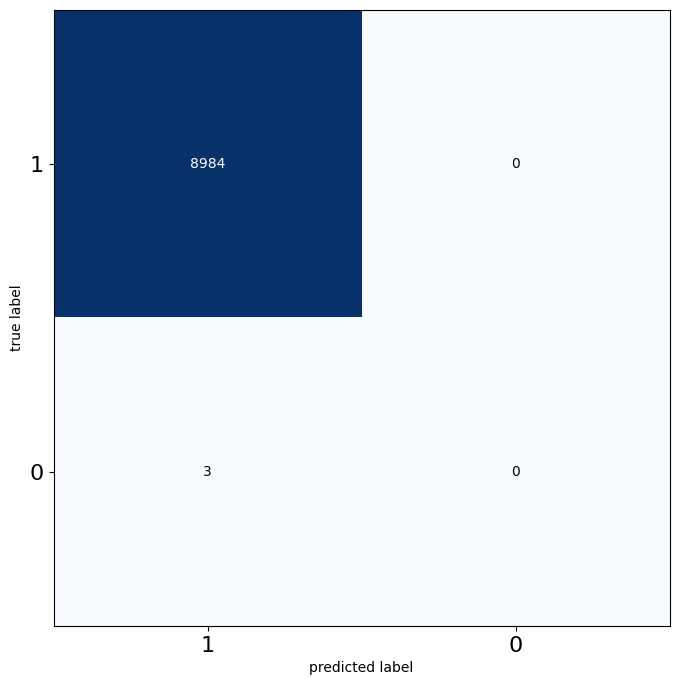

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plumbing Contractors
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

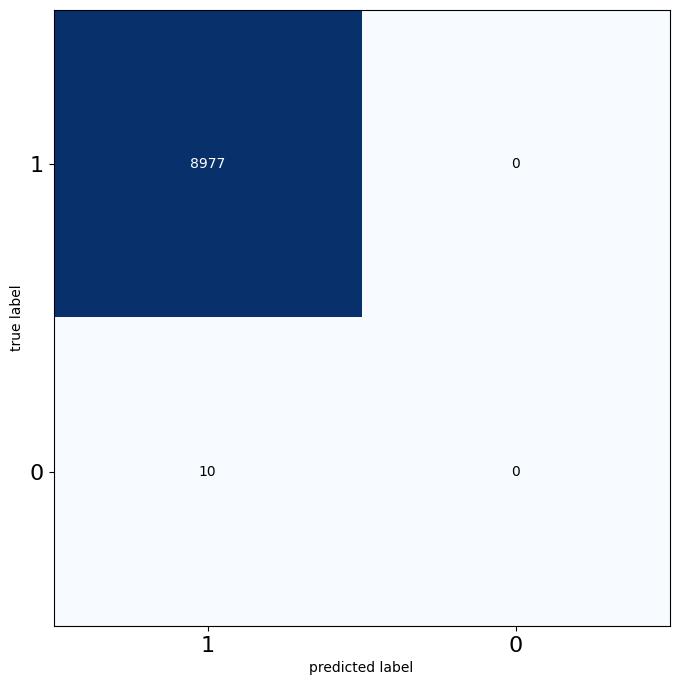

Political Parties
accuracy: 0.9831979525981974 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

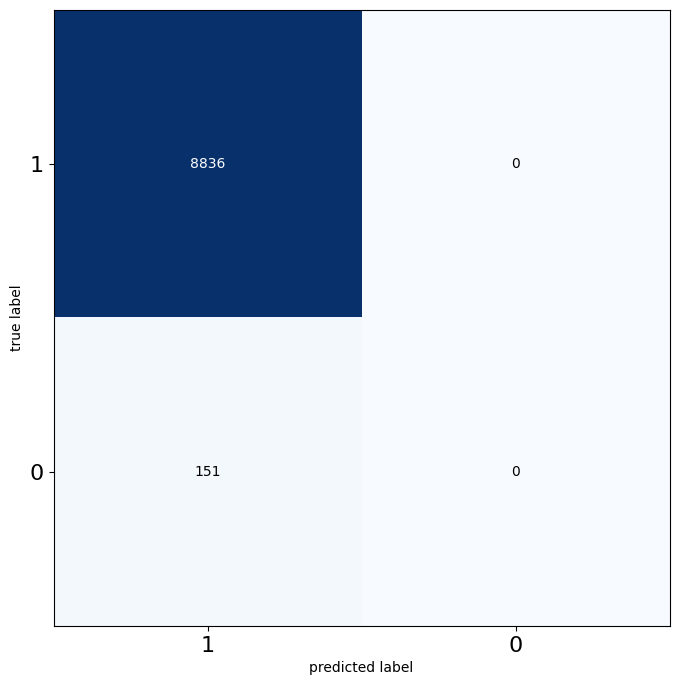

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Poultry
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

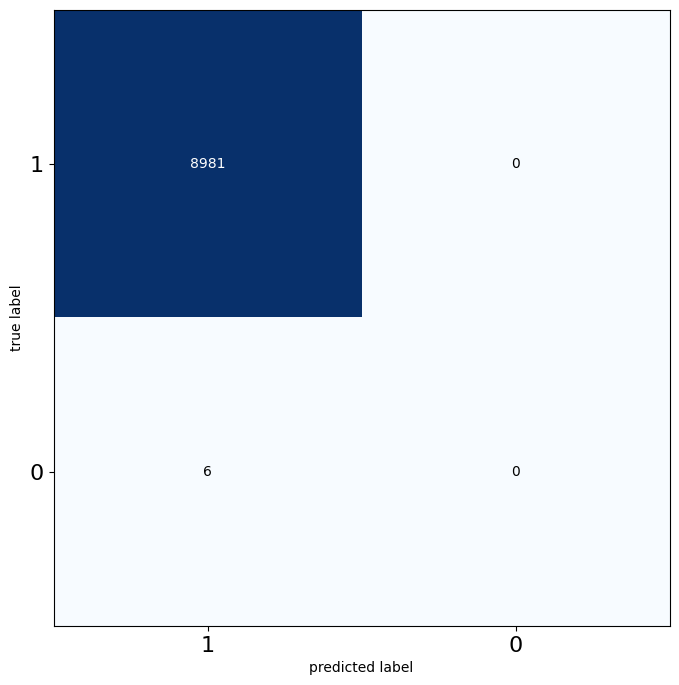

Poultry Farms
accuracy: 0.9966618448870591 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

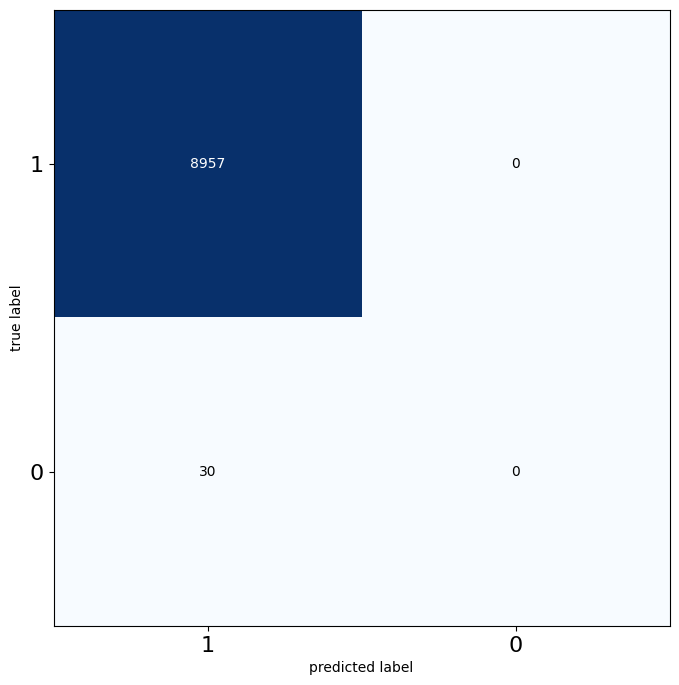

Power Generation
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

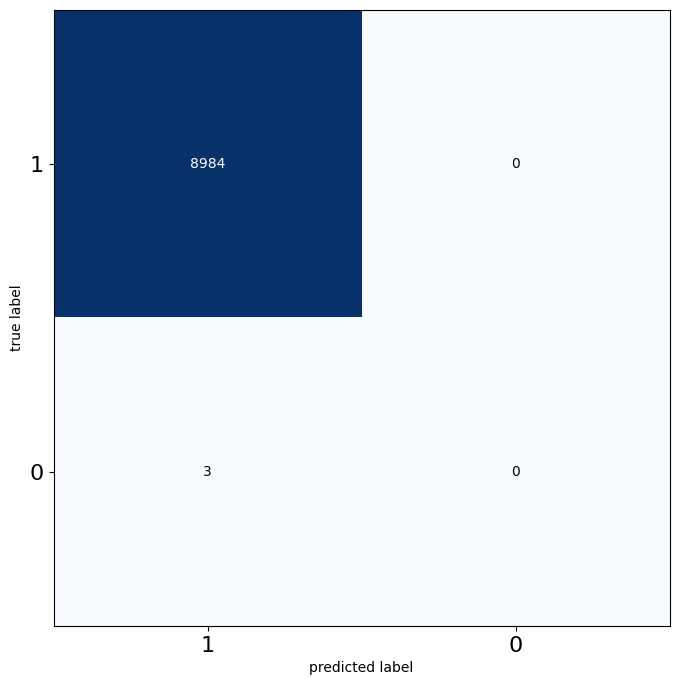

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Power Tools
accuracy: 0.9935462334483143 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

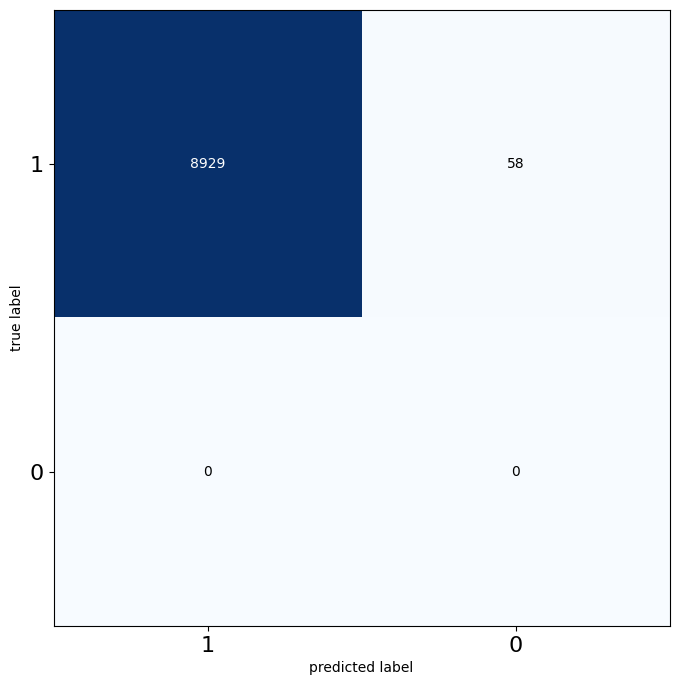

Pre-Shipment Inspection
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

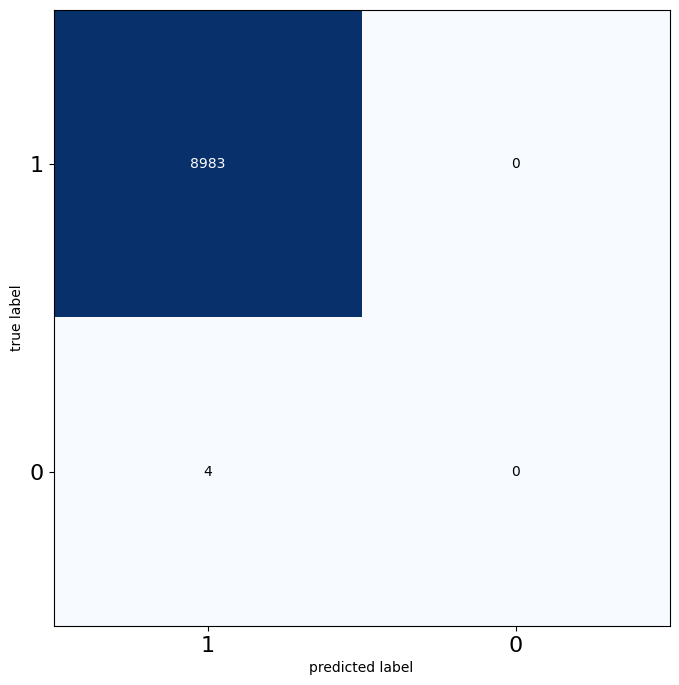

Printers - Screen
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

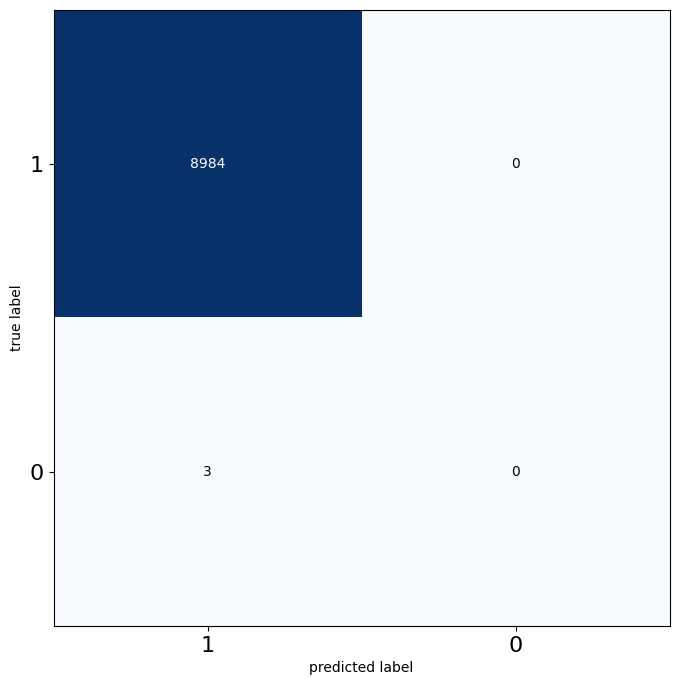

Printing Equipment & Supplies
accuracy: 0.9935462334483143 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

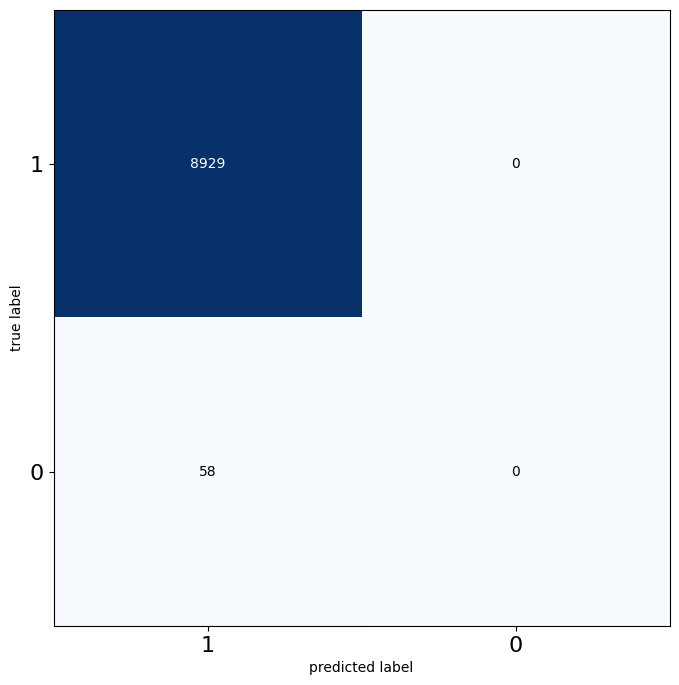

Private Investigators
accuracy: 0.9977745632580394 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

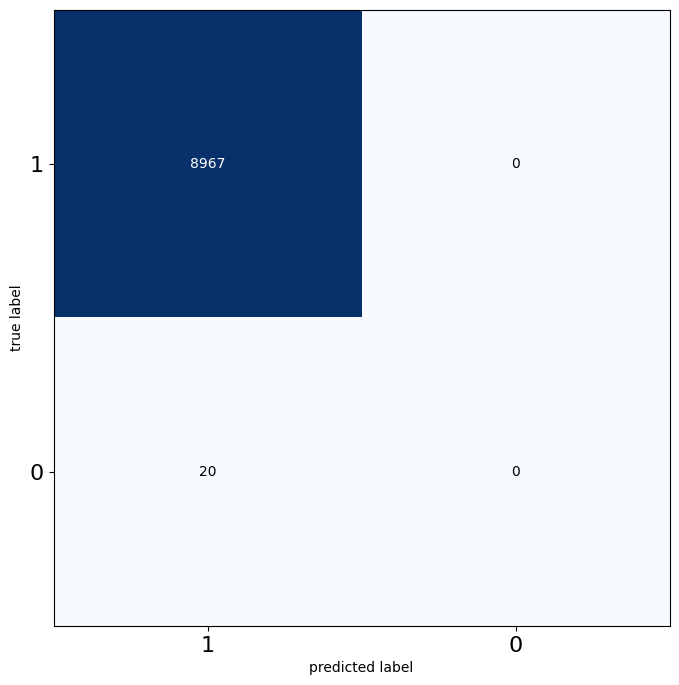

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Private Schools - Primary
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

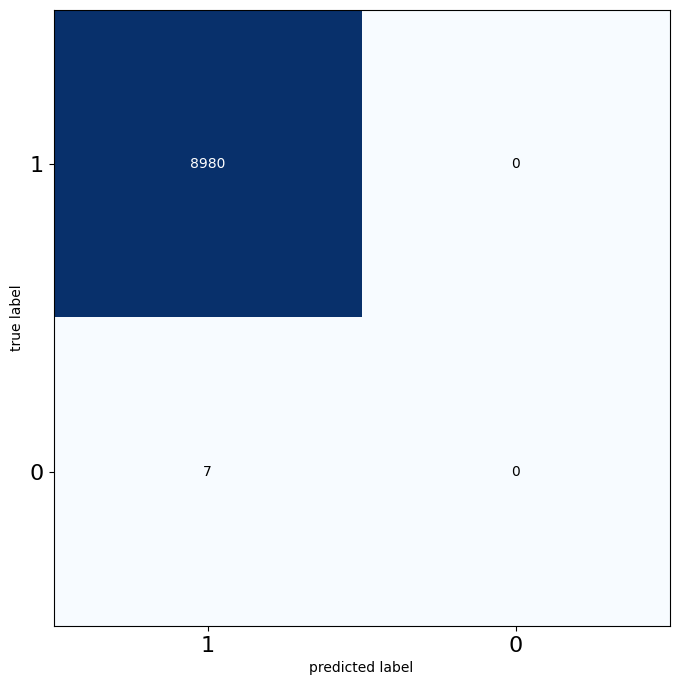

Promotional Materials
accuracy: 0.9946589518192945 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

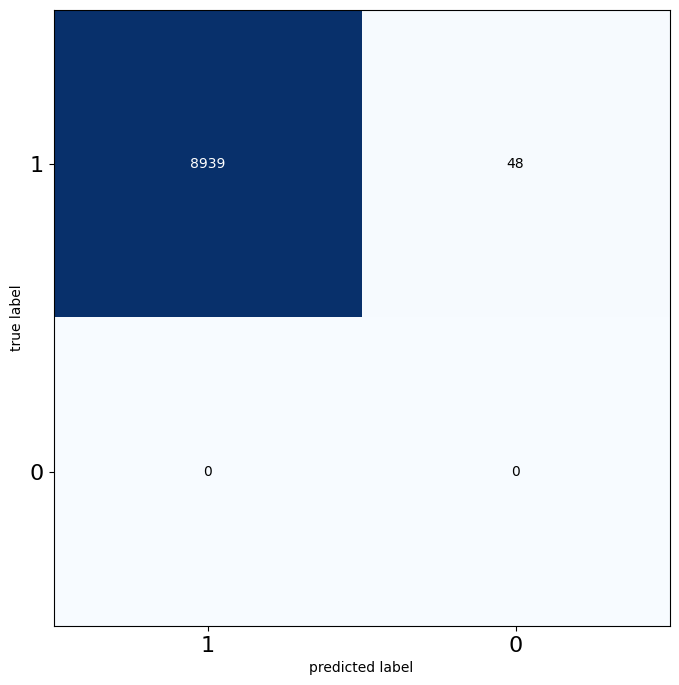

Property Developers
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

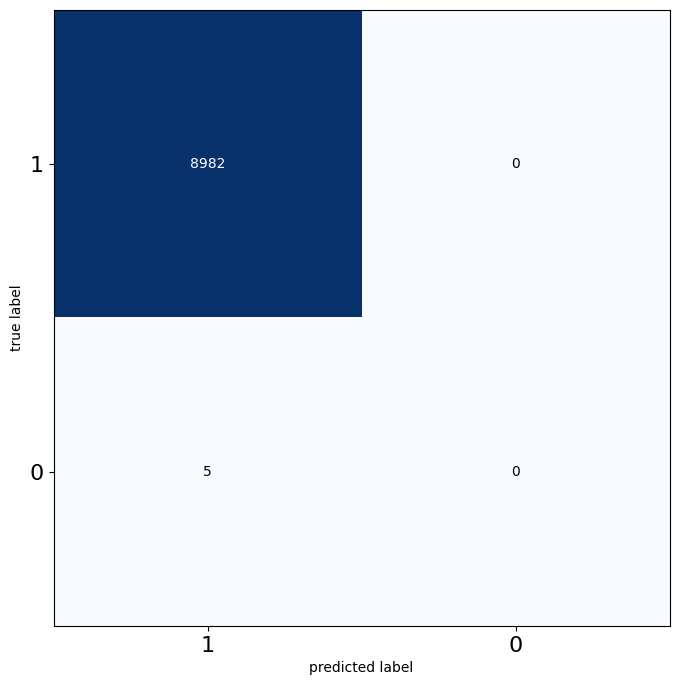

Property Investment Companies
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

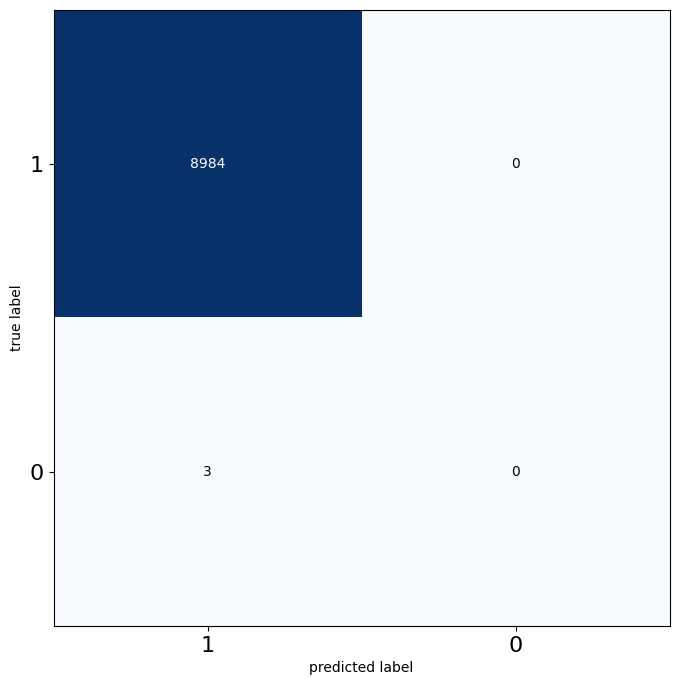

Property Management
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

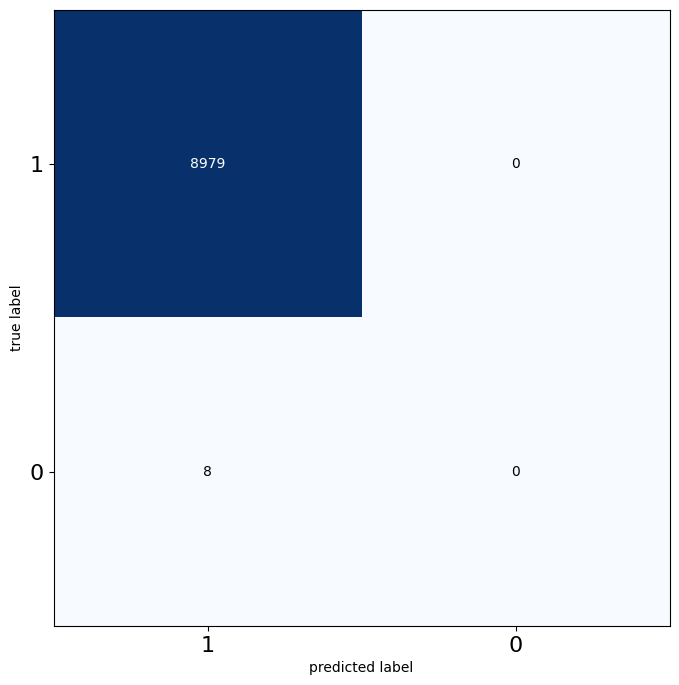

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Psychiatrists
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

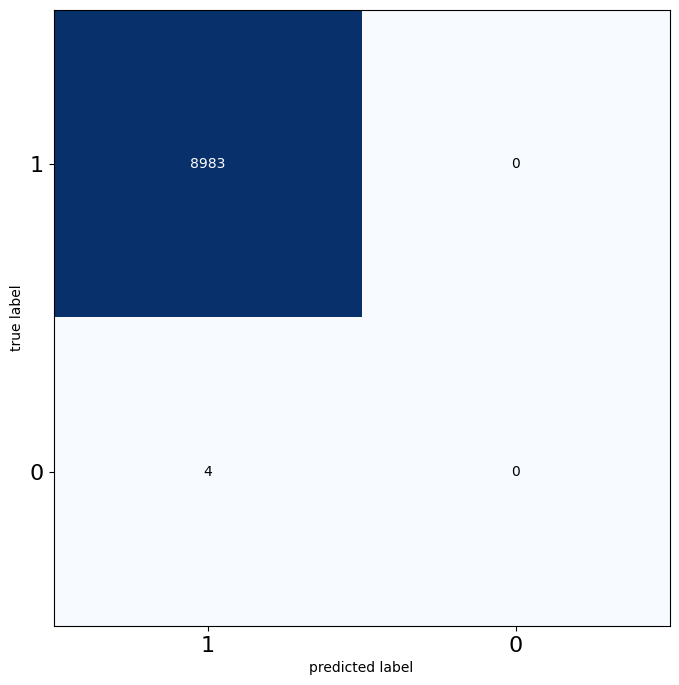

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Public Relations Consultants
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

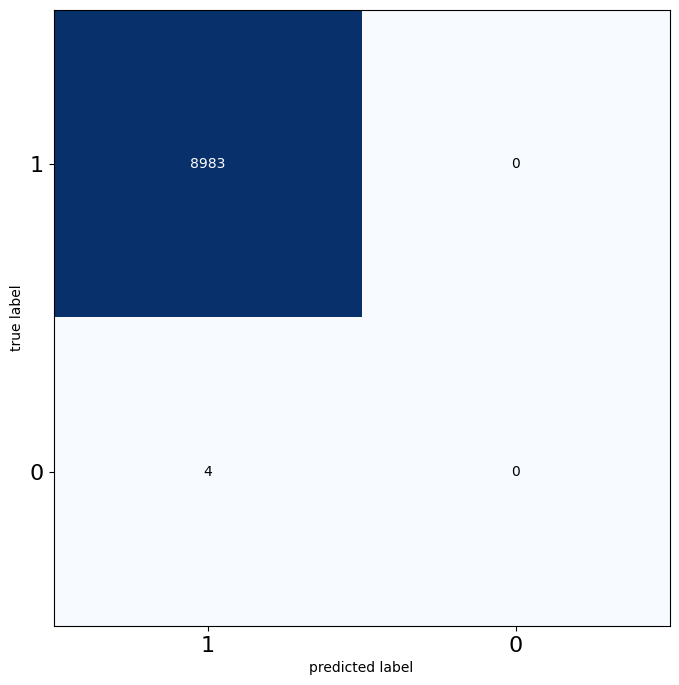

Publishers
accuracy: 0.9978858350951374 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

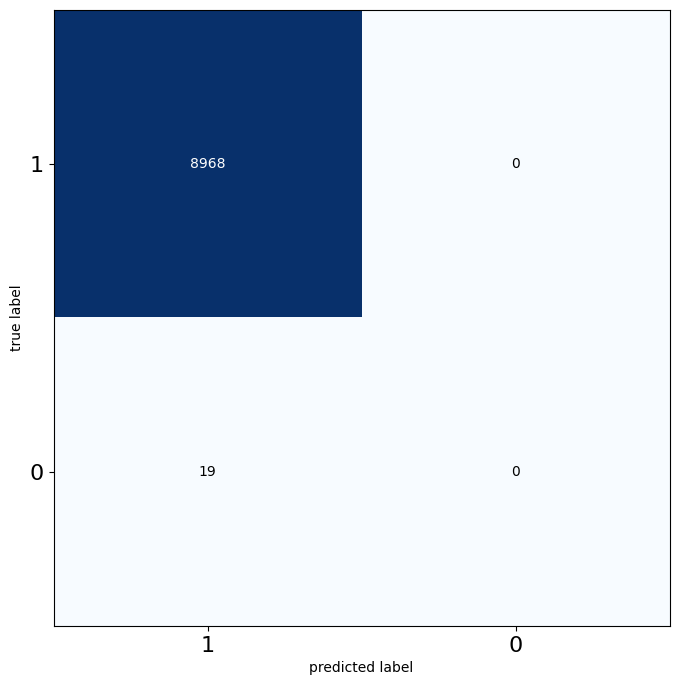

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Quarries
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

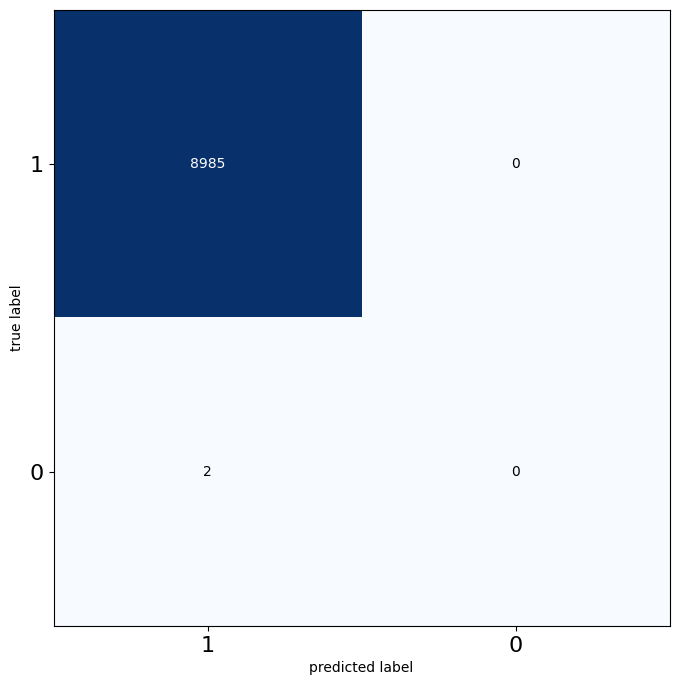

Radio Components & Accessories
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

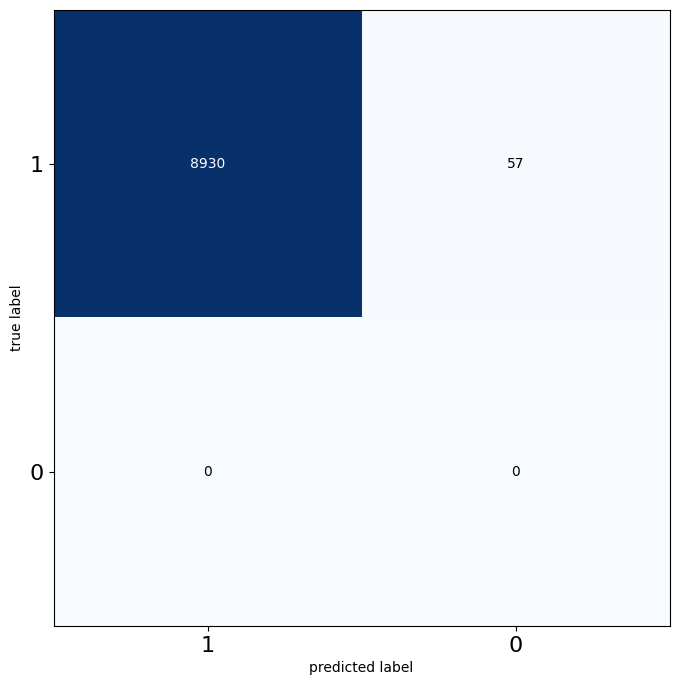

Radio Stations
accuracy: 0.9898742628240792 precision: 0.012345679012345678 recall: 0.08333333333333333 f1: 0.02150537634408602


<Figure size 640x480 with 0 Axes>

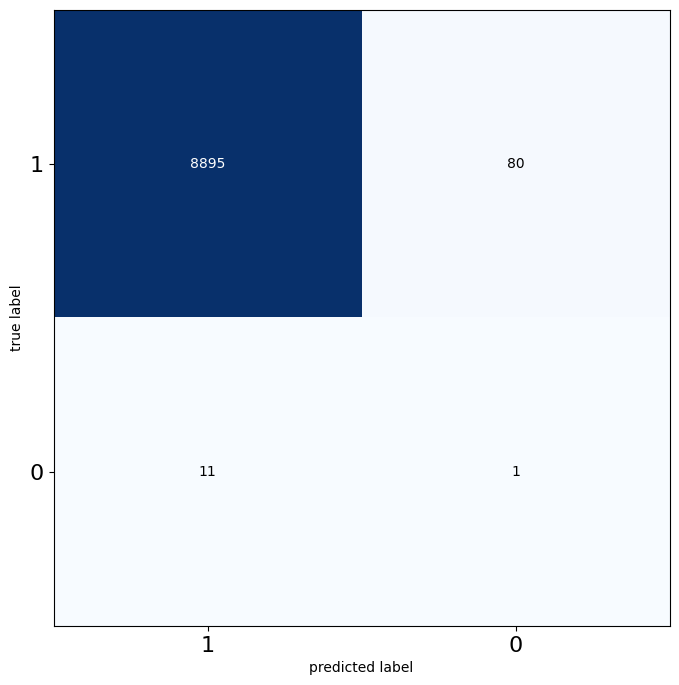

Real Estate Agents, Developers & Valuers
accuracy: 0.028151774785801713 precision: 0.028151774785801713 recall: 1.0 f1: 0.054761904761904755


<Figure size 640x480 with 0 Axes>

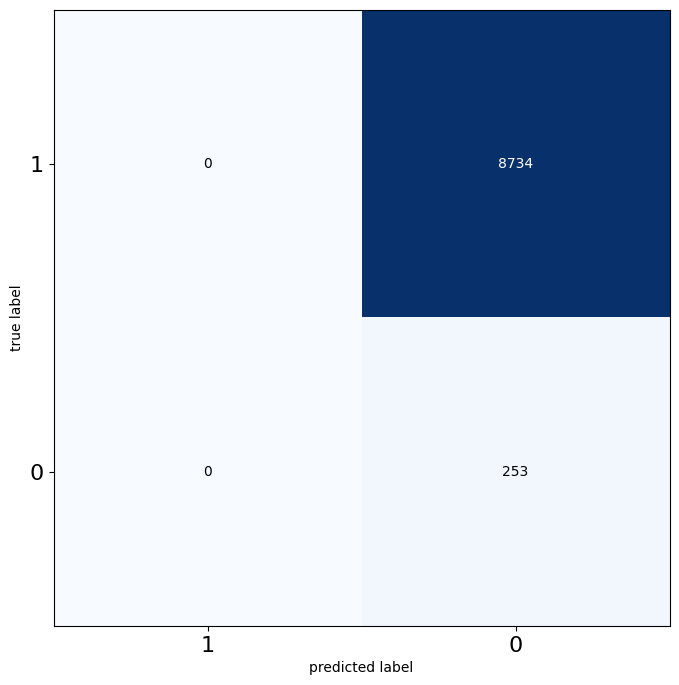

Recording Service-Sound
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

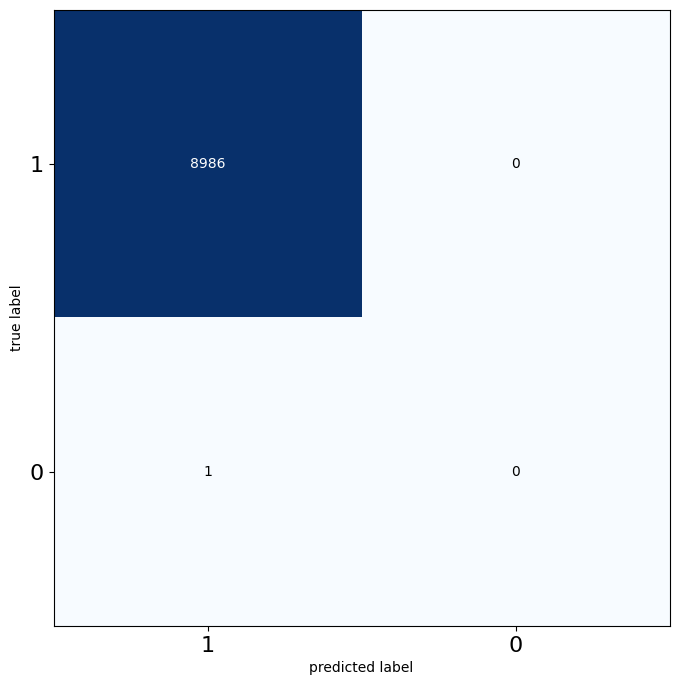

Recruitment Consultants
accuracy: 0.9937687771225103 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

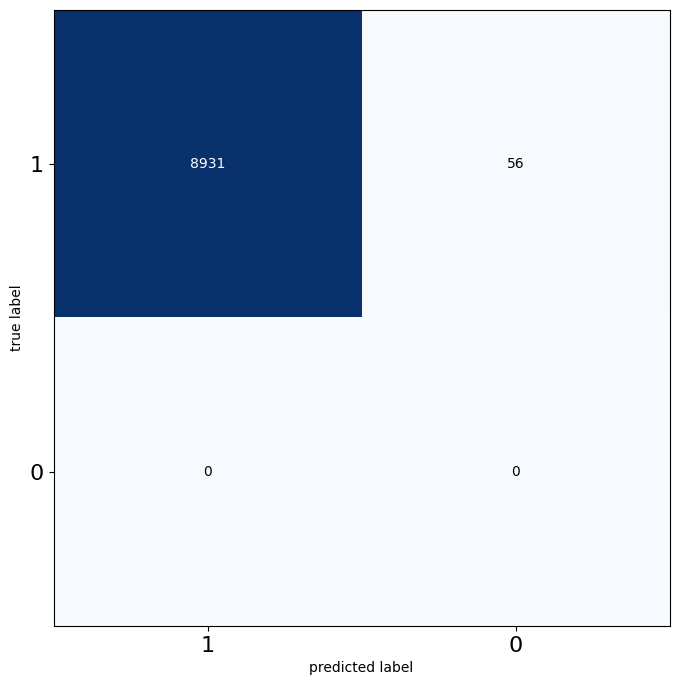

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Registrar Services
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

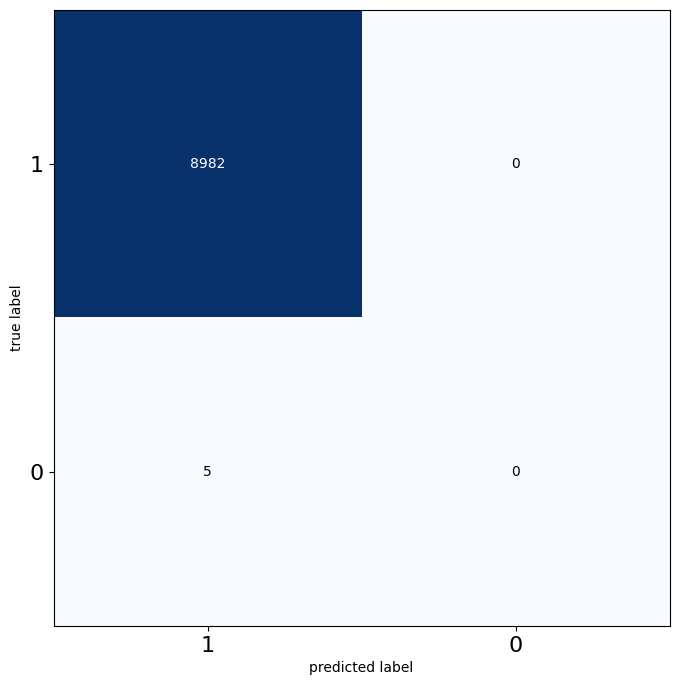

Regulatory Bodies
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

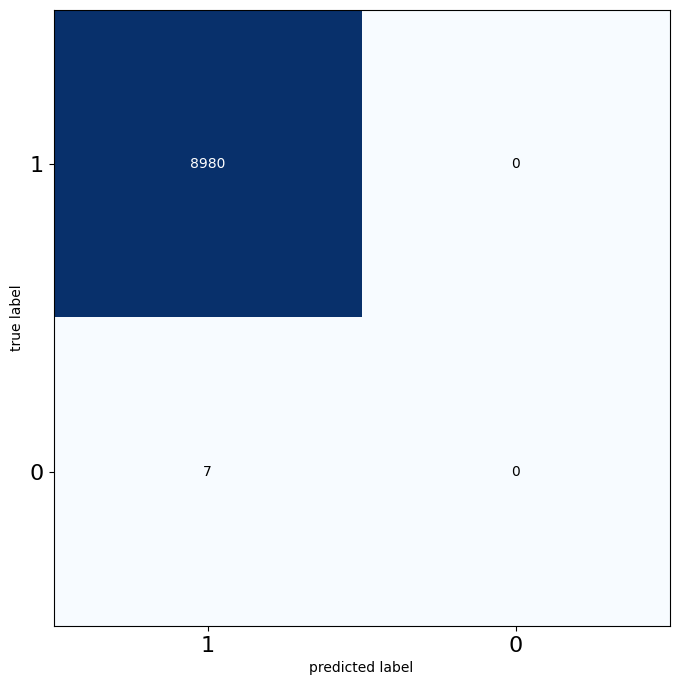

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rehabilitation Centres
accuracy: 0.9918771558918438 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

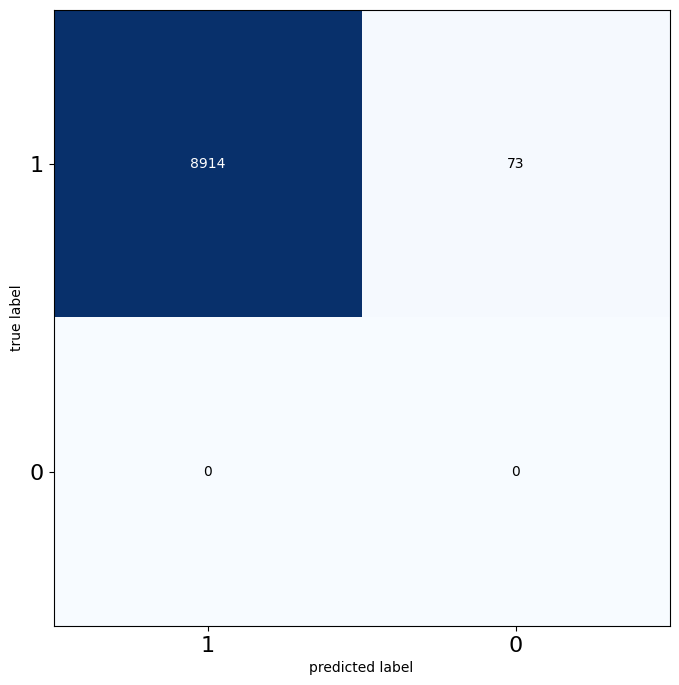

Relief Supplies
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

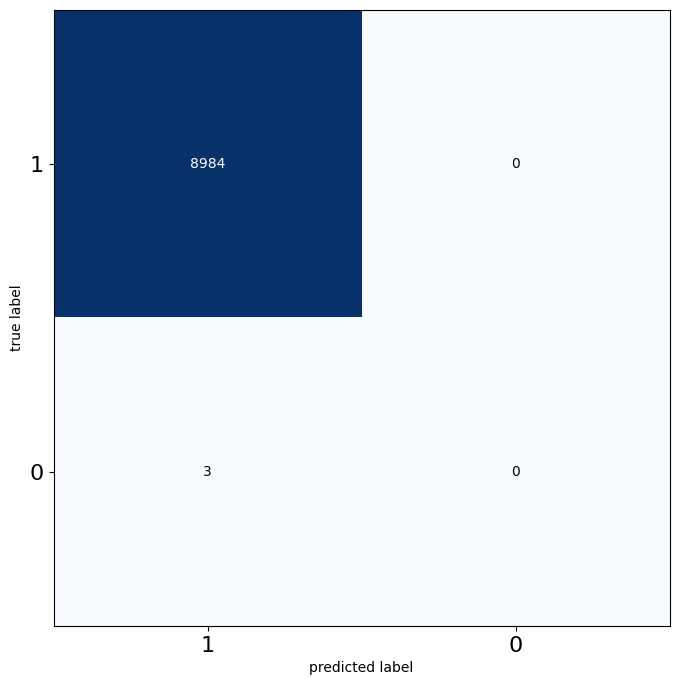

Religious Organizations
accuracy: 0.992989874262824 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

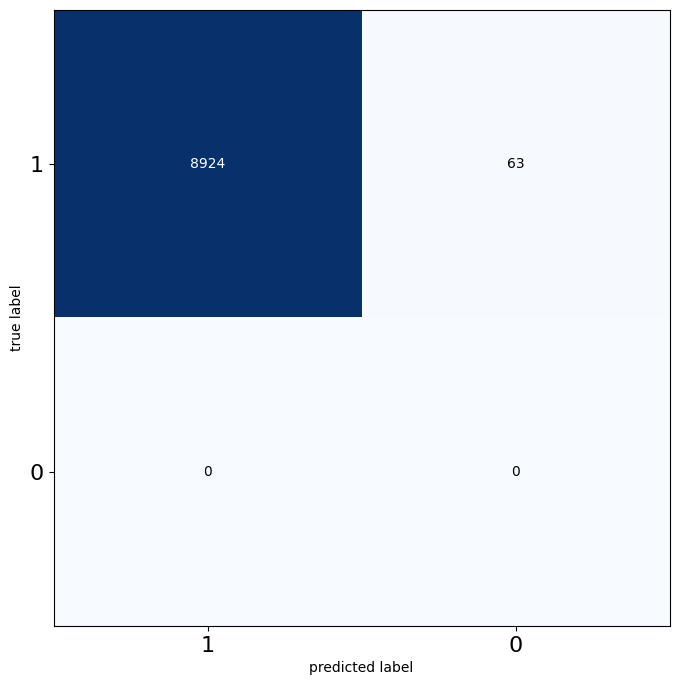

Religious Schools
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

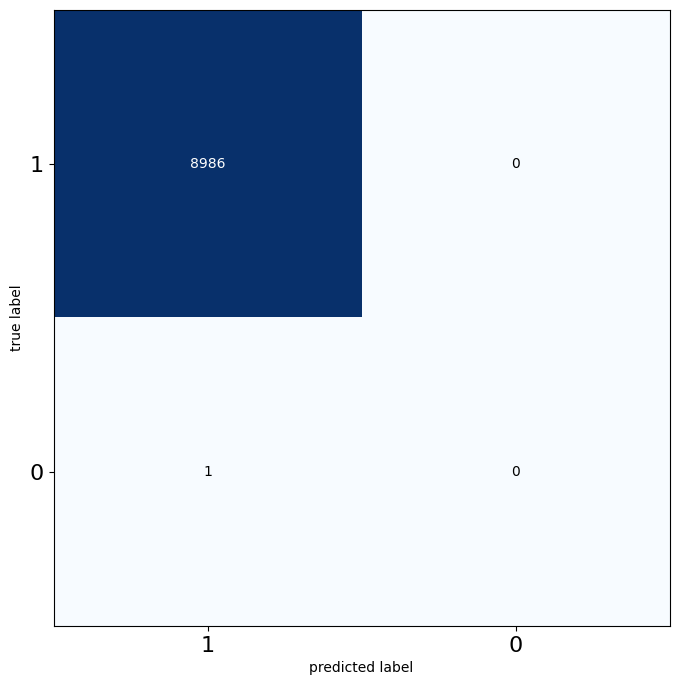

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Relocation Services
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

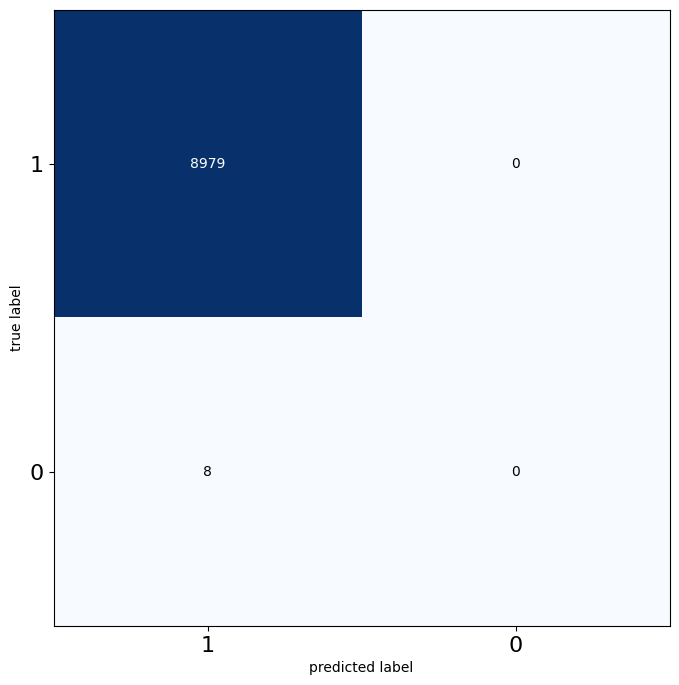

Research Organizations
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

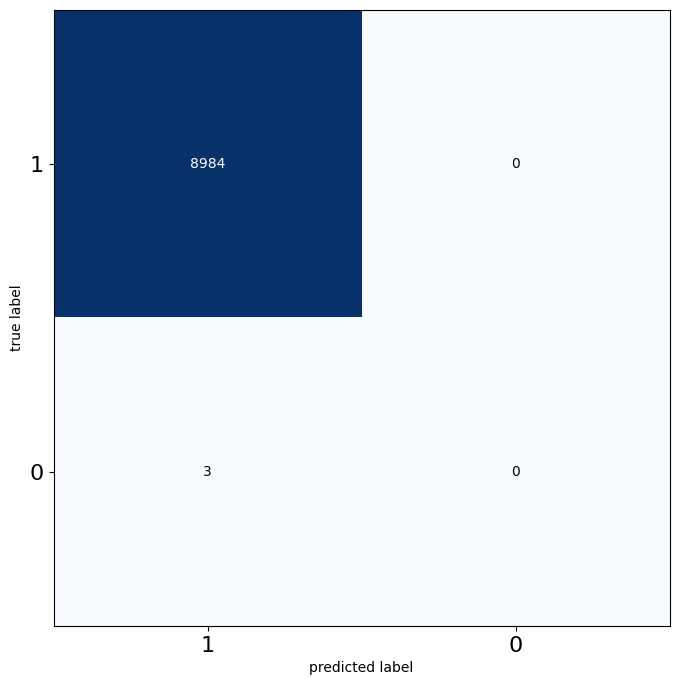

Resorts
accuracy: 0.9983309224435295 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

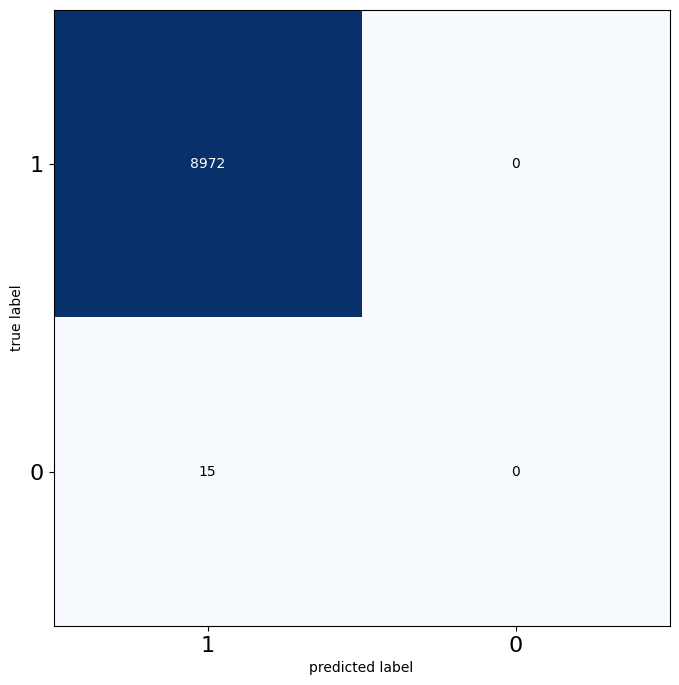

Restaurants
accuracy: 0.9337932569266718 precision: 0.021052631578947368 recall: 0.07142857142857142 f1: 0.032520325203252036


<Figure size 640x480 with 0 Axes>

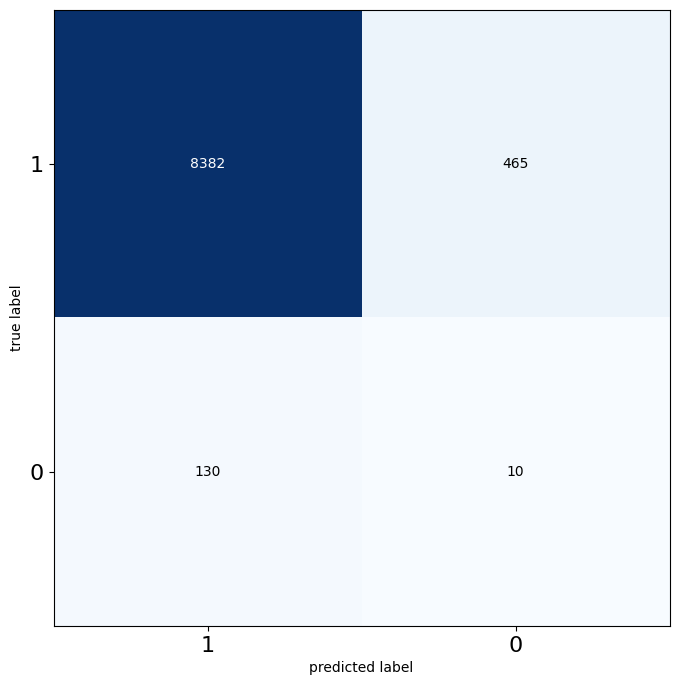

Restaurants - African
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

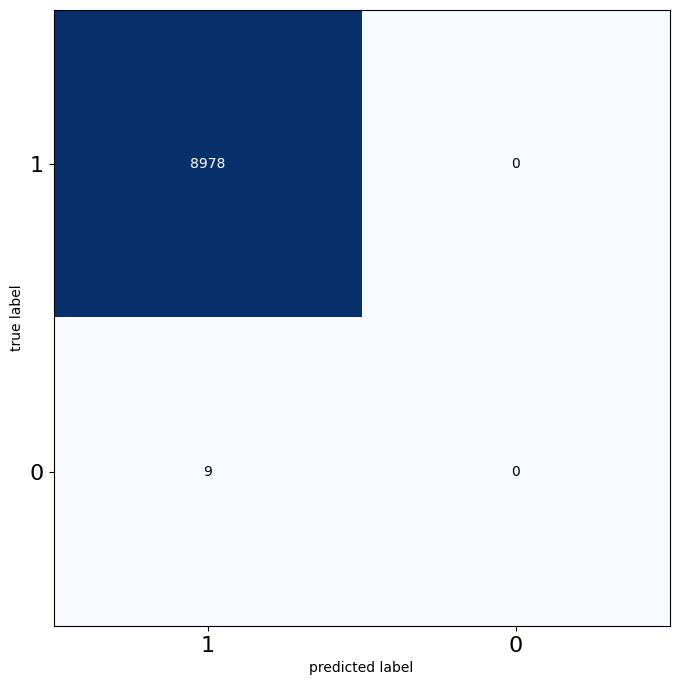

Restaurants - Chinese
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

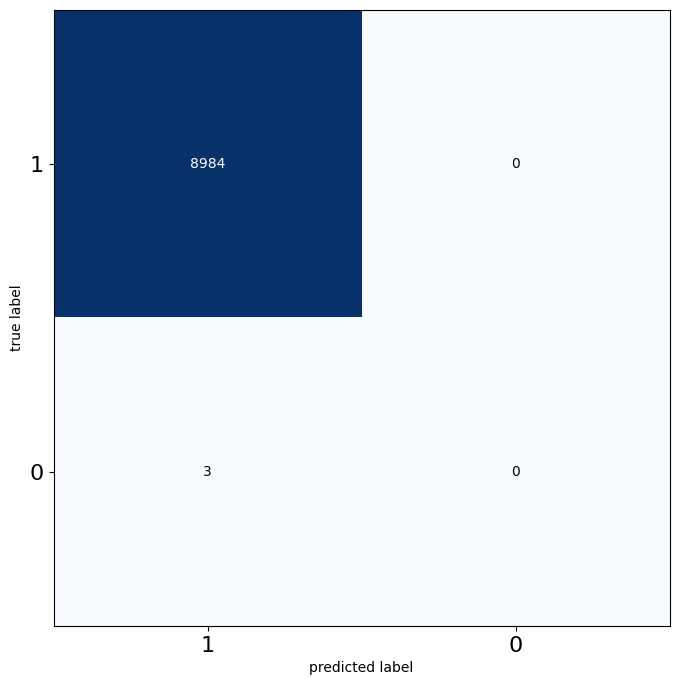

Restaurants - Indian
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

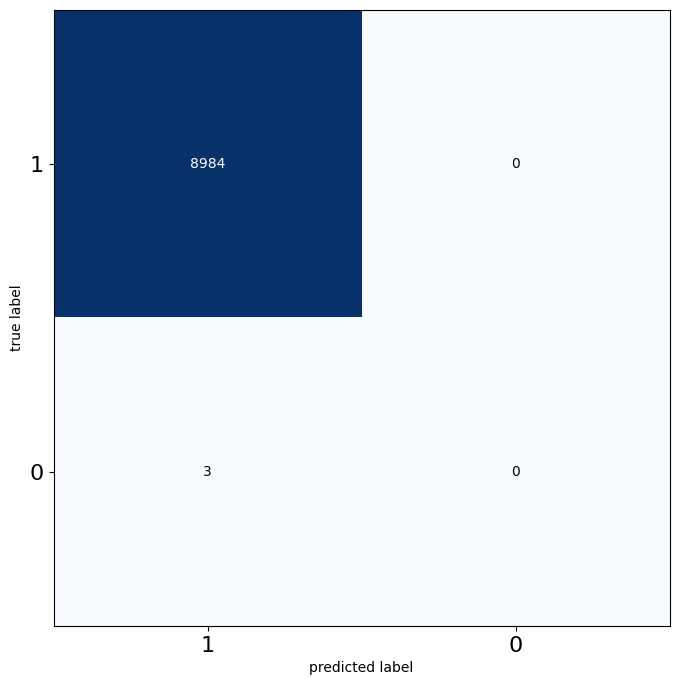

Restaurants - International
accuracy: 0.9982196506064315 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

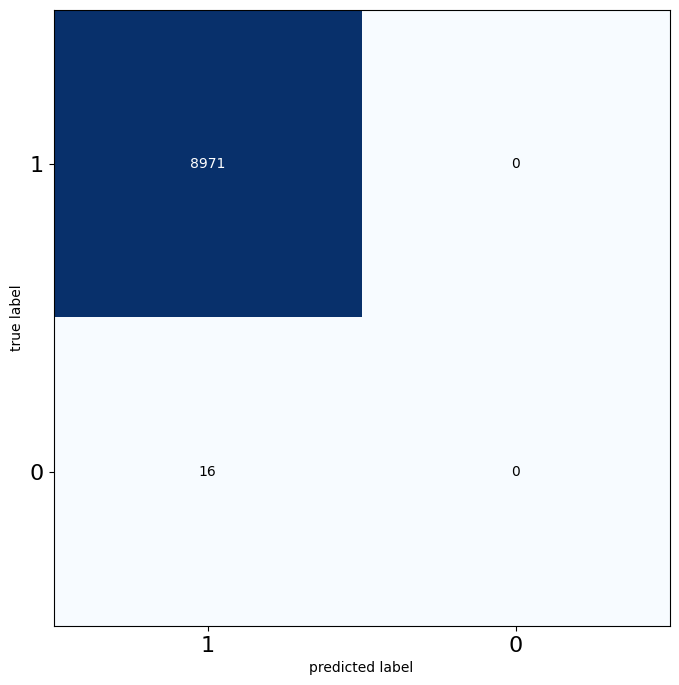

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Restaurants - Italian
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

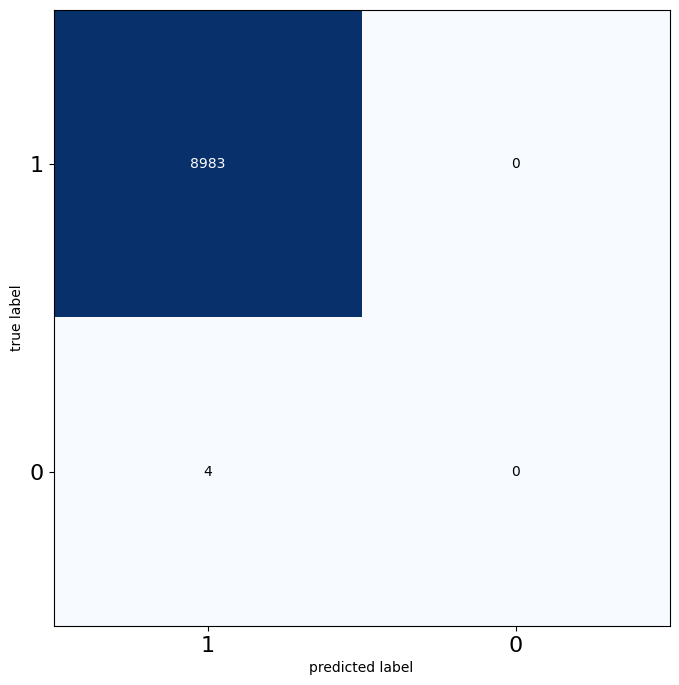

Retail Shops
accuracy: 0.9984421942806275 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

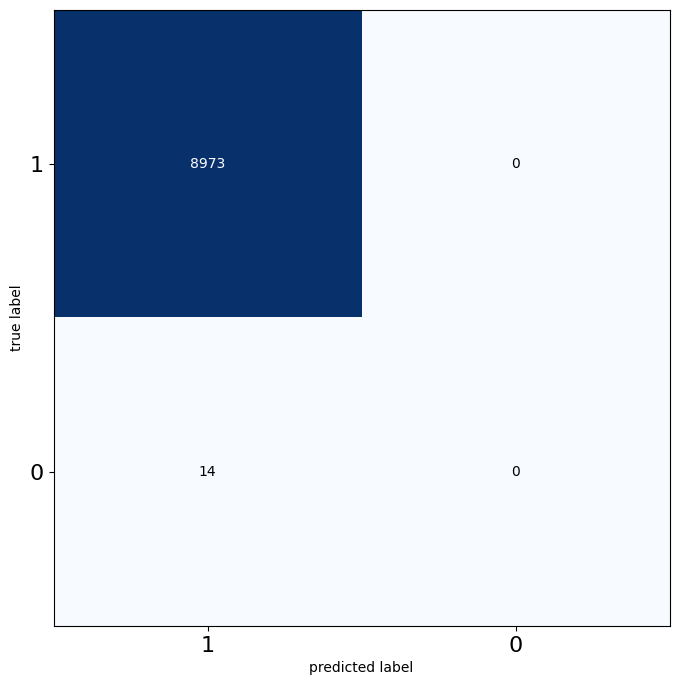

Roads-Construction, Equipment & Supplies
accuracy: 0.9979971069322354 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

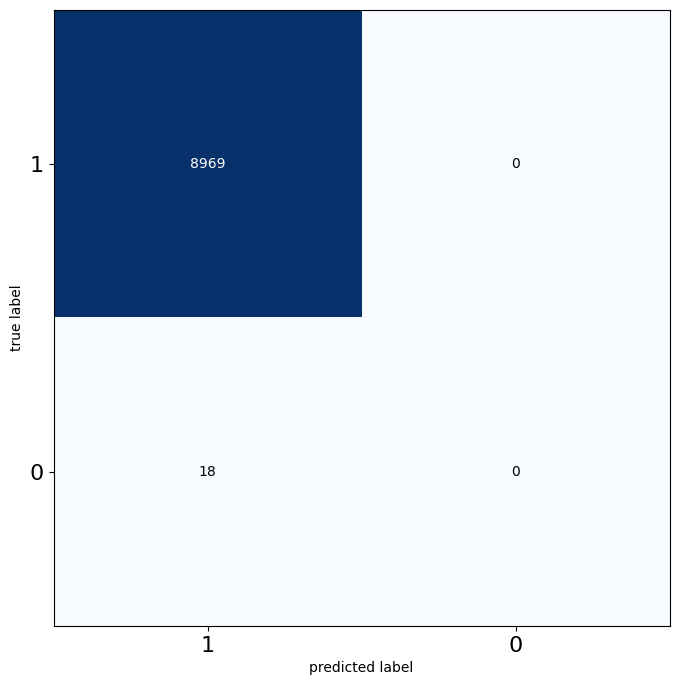

Roofing Contractors
accuracy: 0.9952153110047847 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

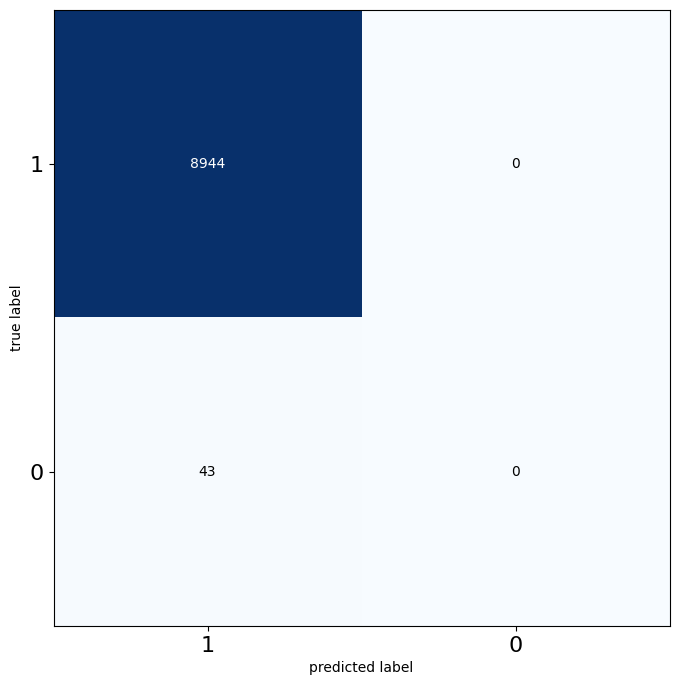

Roofing Materials
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

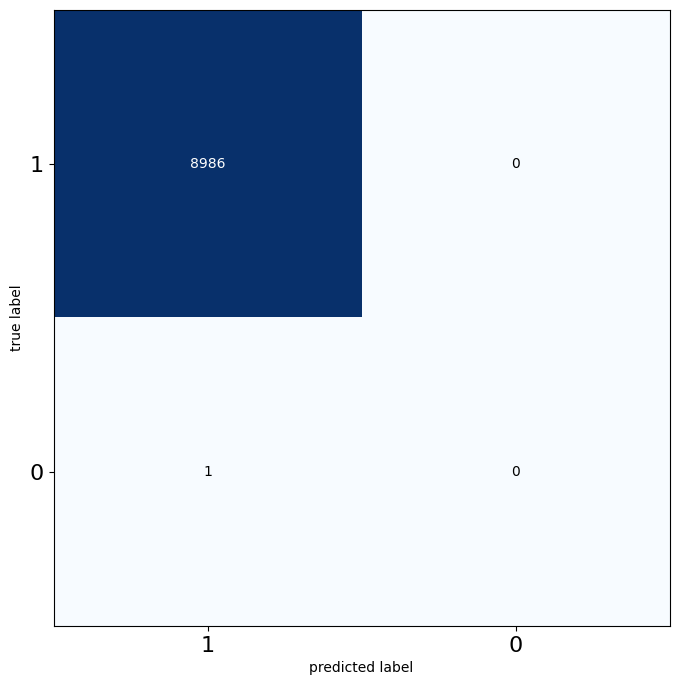

Ropes
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

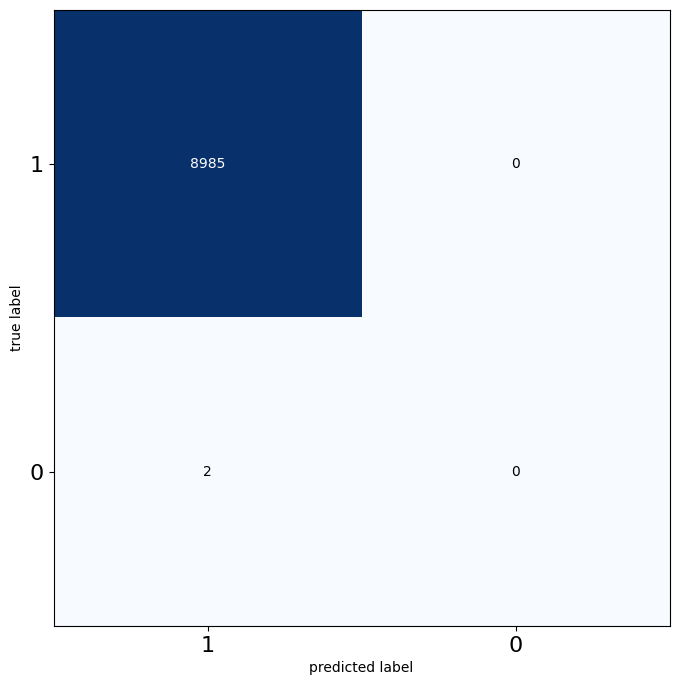

Rubber Products
accuracy: 0.992878602425726 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

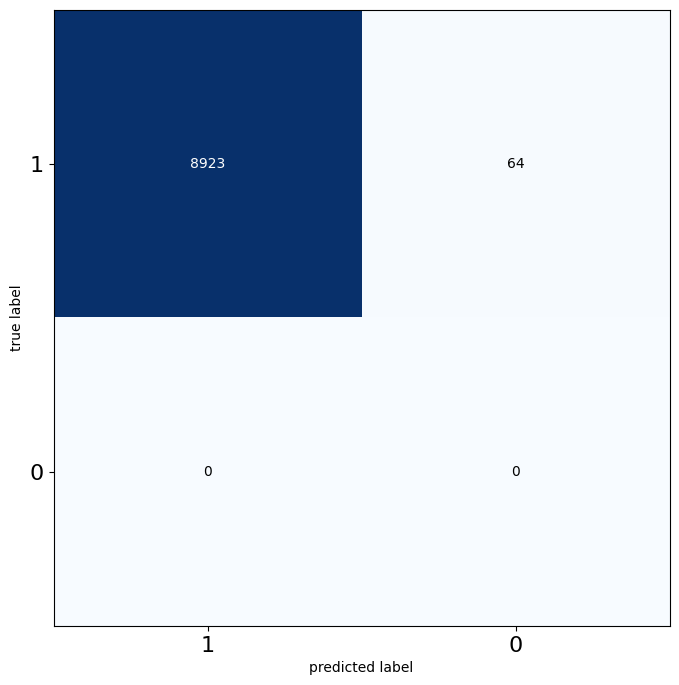

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Safety Equipment & Clothing
accuracy: 0.9989985534661178 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

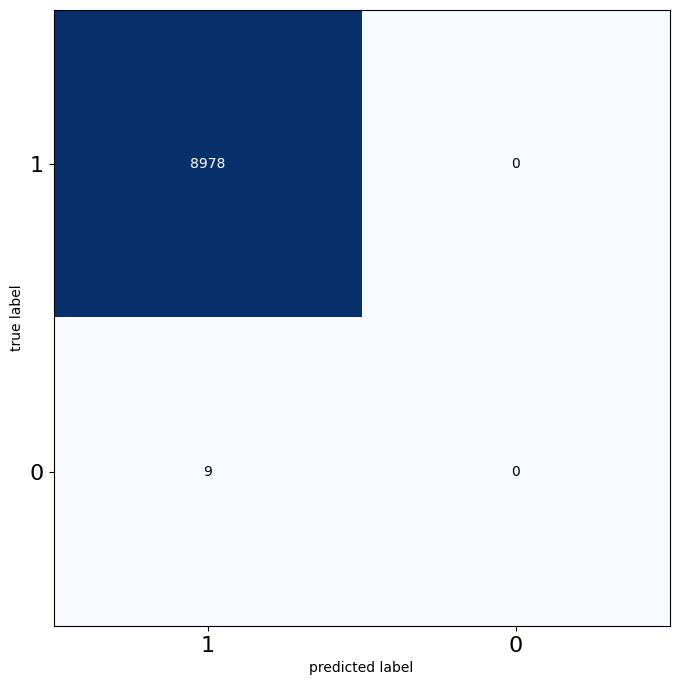

Salt
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

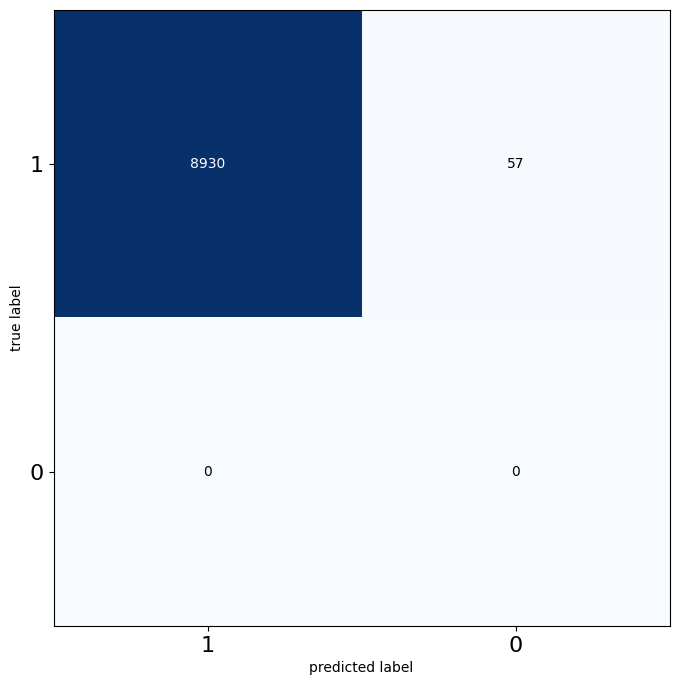

Sanitaryware & Fittings
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

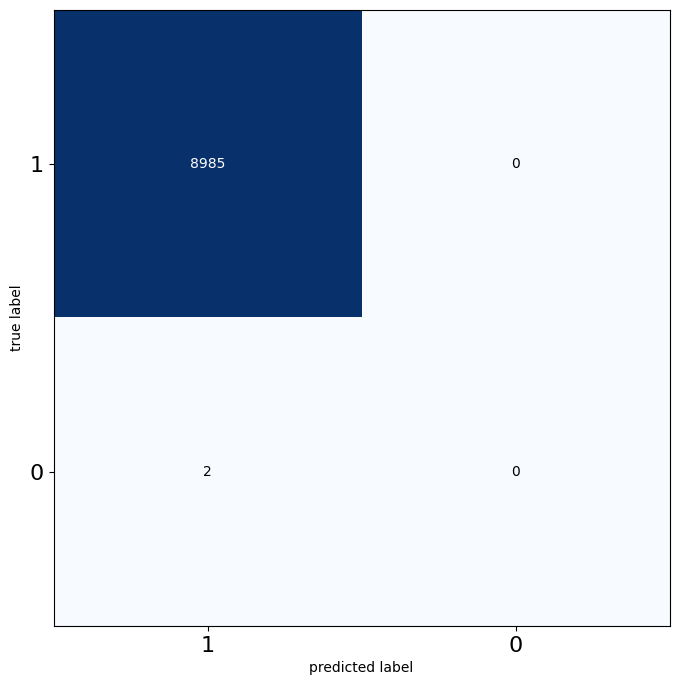

Satellite Equipment & Services
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

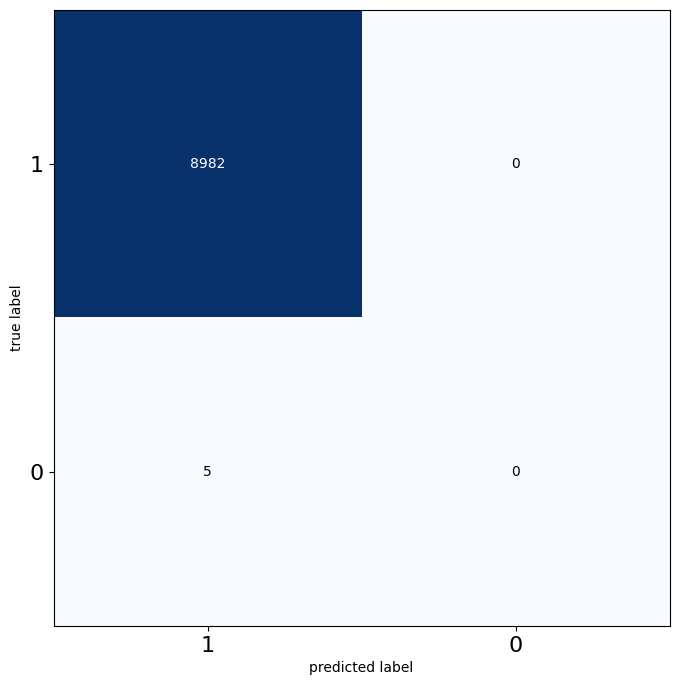

Sawmills
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

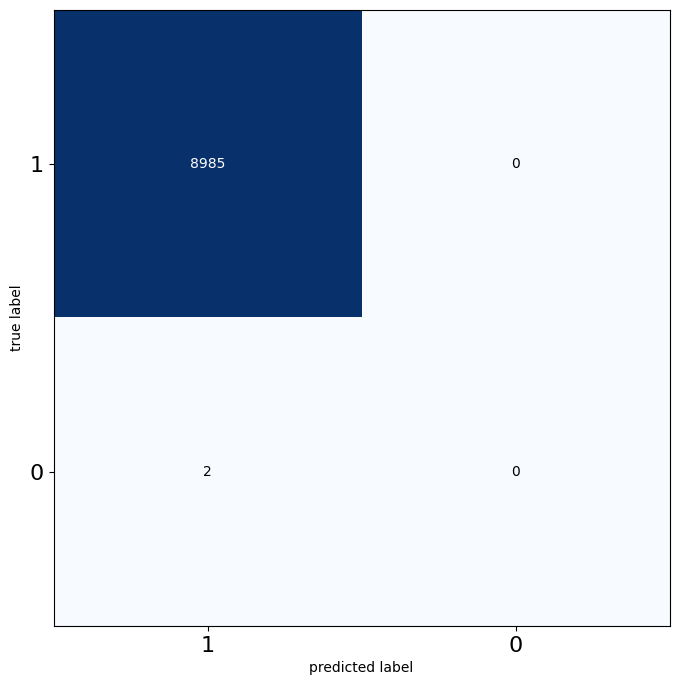

Schools & Colleges Management
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

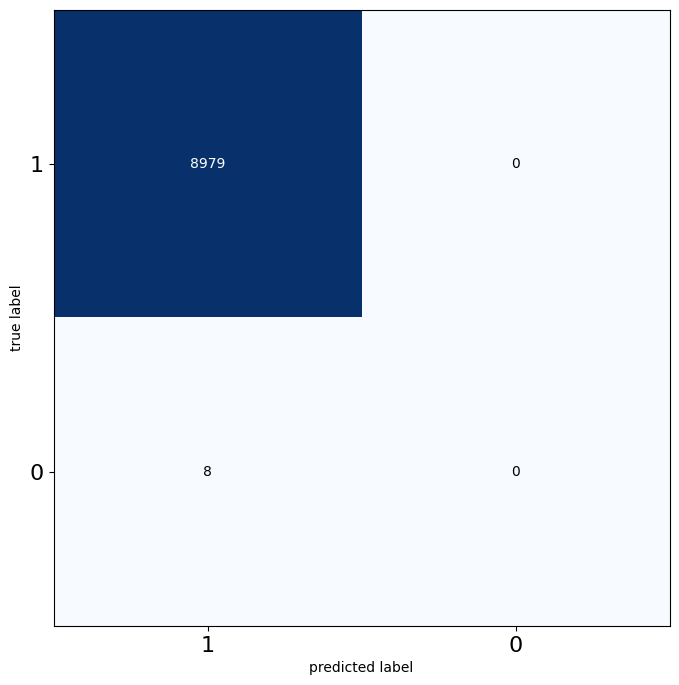

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Schools - Catering
accuracy: 0.9975520195838433 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

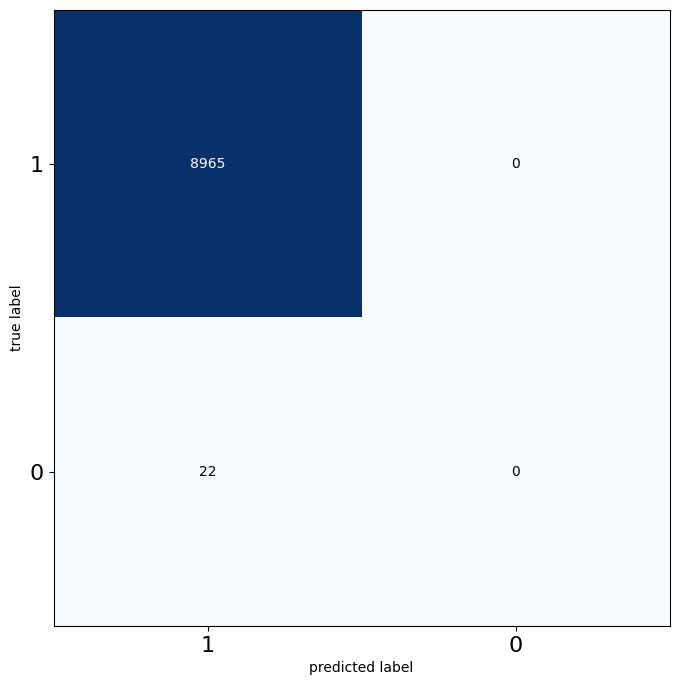

Schools - Colleges & Universities
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

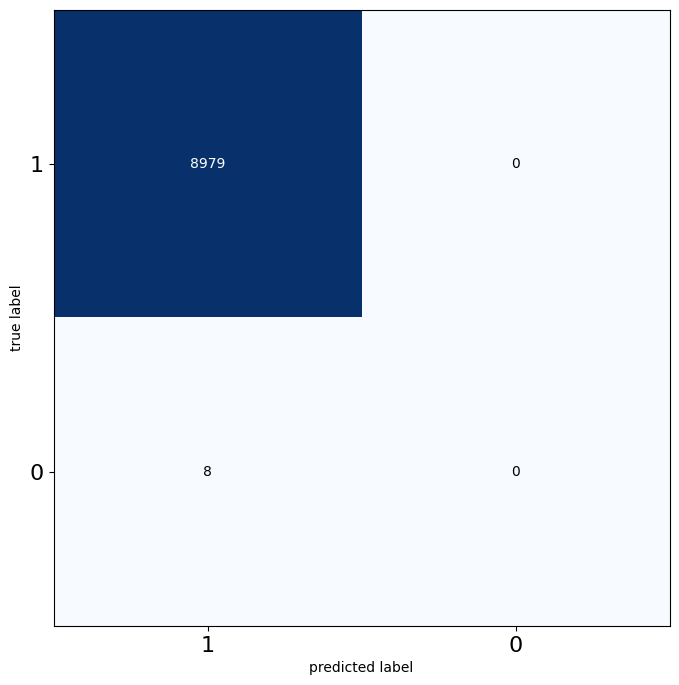

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Schools - Dress Making & design
accuracy: 0.9982196506064315 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

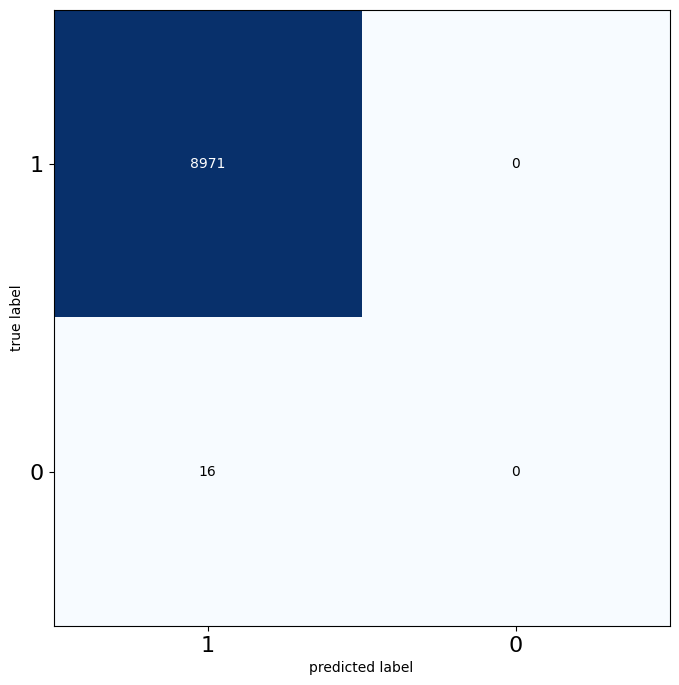

Schools - International
accuracy: 0.9983309224435295 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

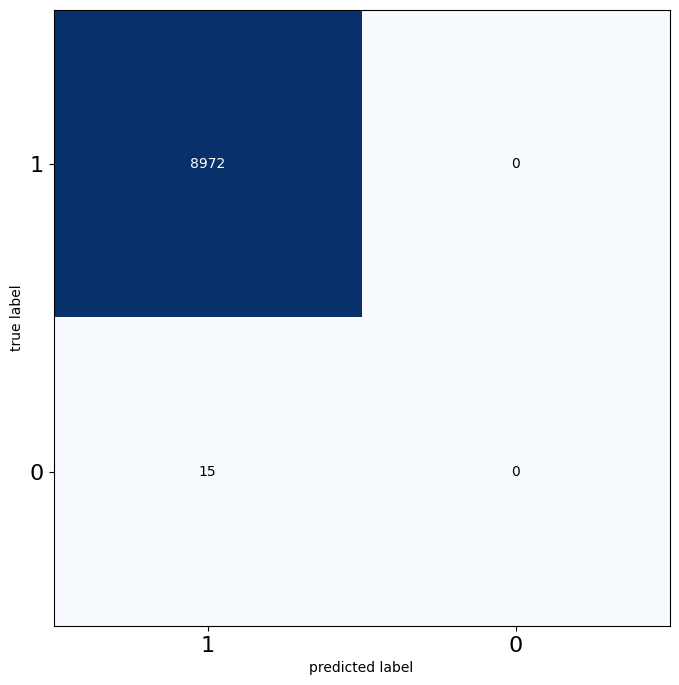

Schools - Nursery & Kindergarten
accuracy: 0.9975520195838433 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

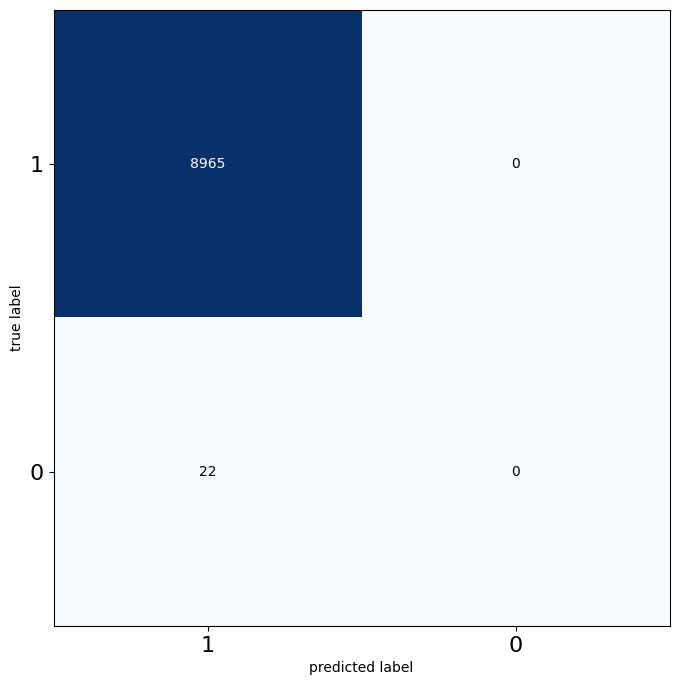

Schools - Polytechnic
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

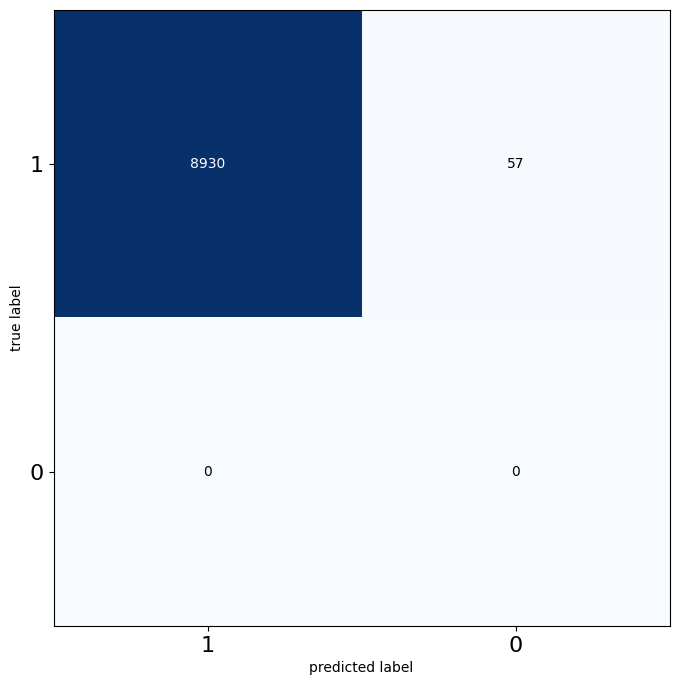

Schools - Primary
accuracy: 0.9895404473127851 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

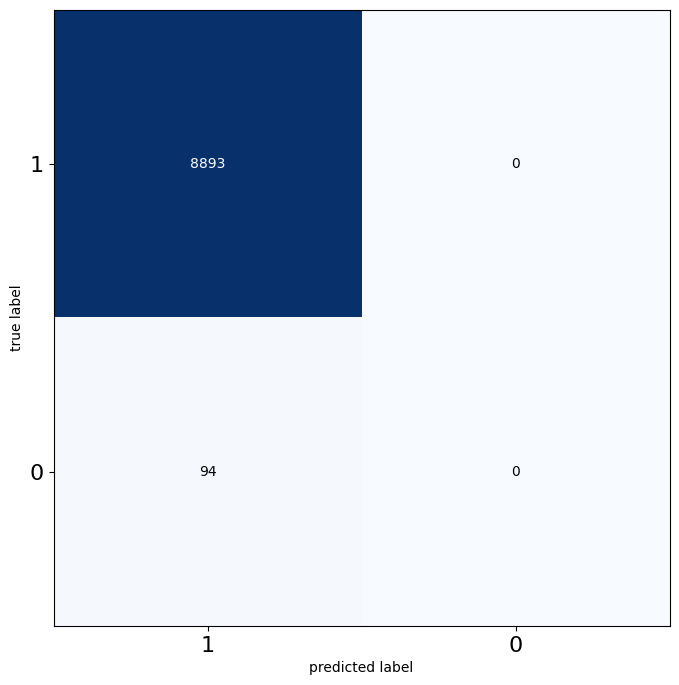

Schools - Secondary
accuracy: 0.9857572048514521 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

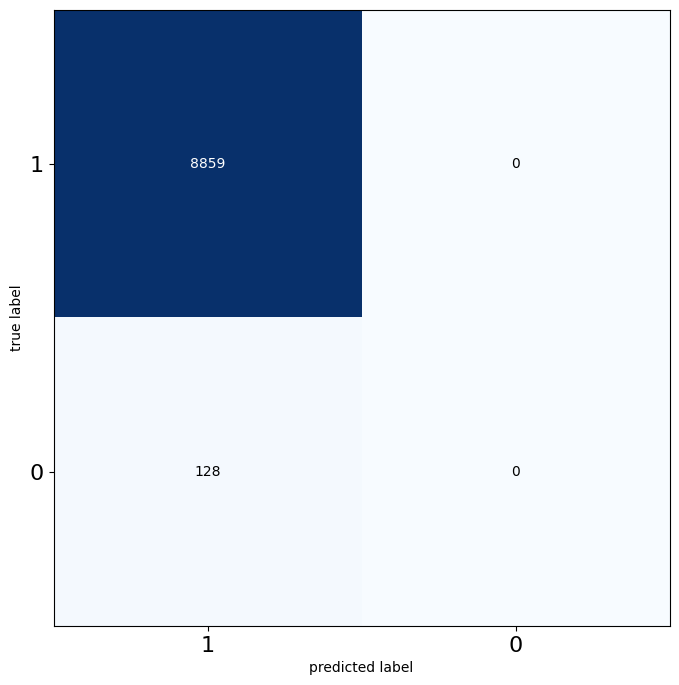

Schools - Supplies
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

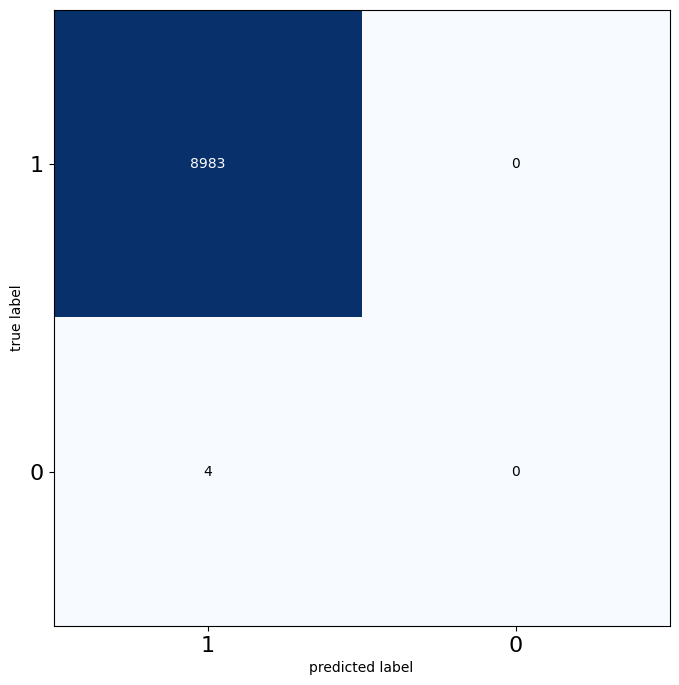

Schools - Teaching Aids
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

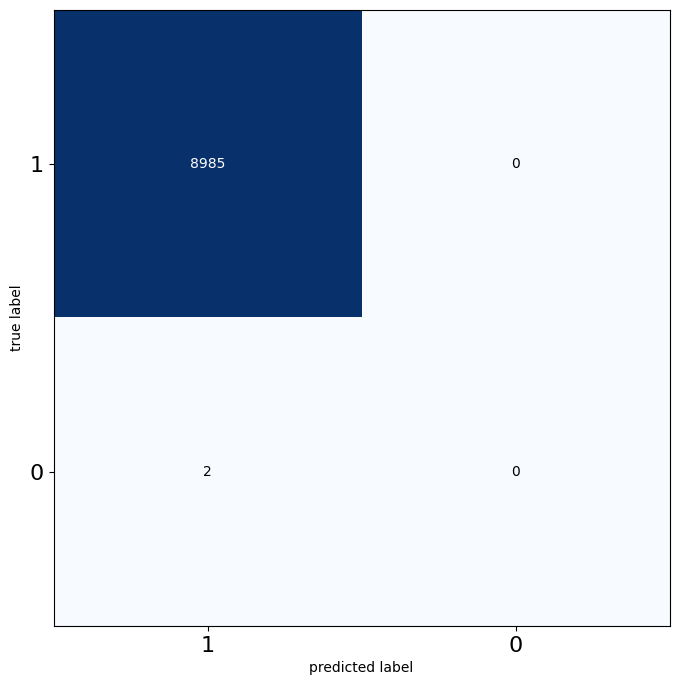

Schools - Technical & Trade
accuracy: 0.9945476799821965 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

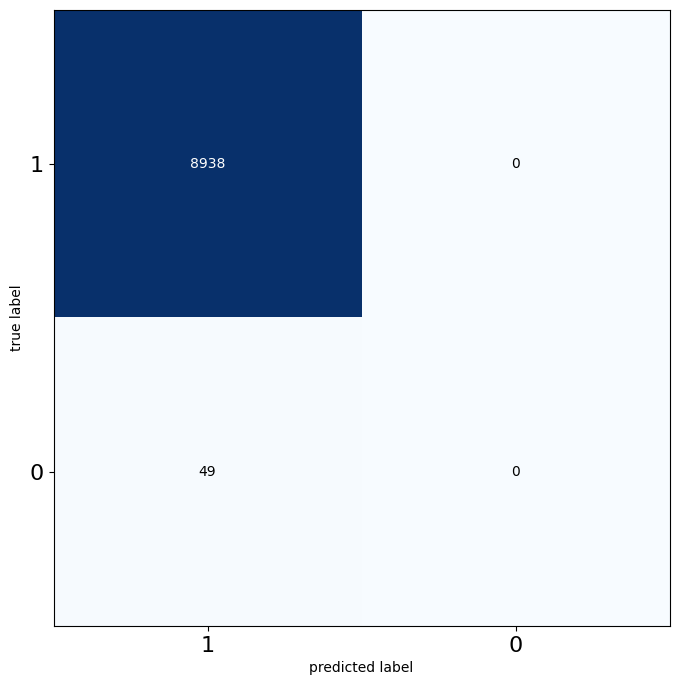

Screen Printing Equipment & Supplies
accuracy: 0.9934349616112162 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

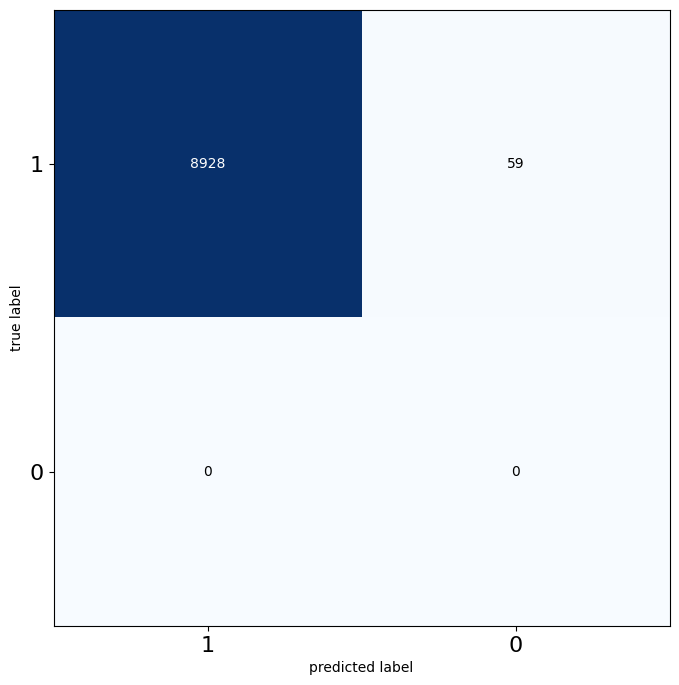

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Seafood
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

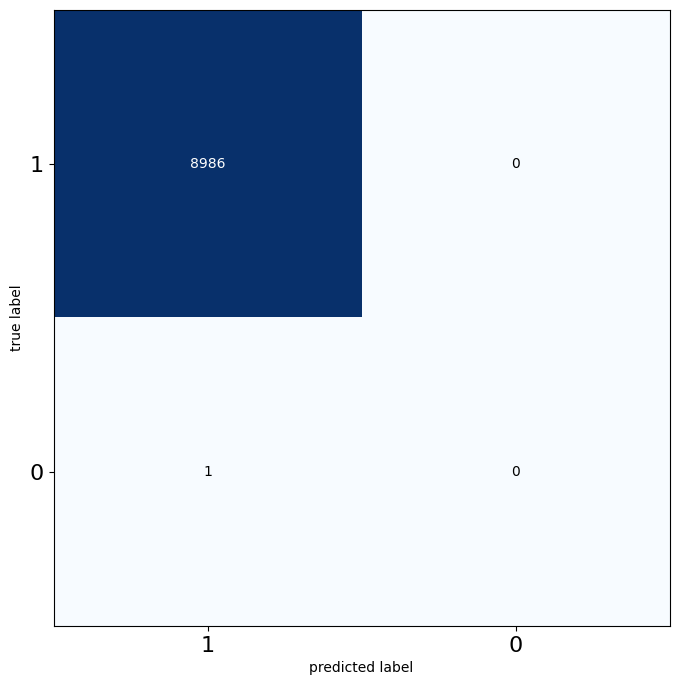

Security Control Equipment & Systems
accuracy: 0.012128630243685323 precision: 0.012128630243685323 recall: 1.0 f1: 0.023966578715919083


<Figure size 640x480 with 0 Axes>

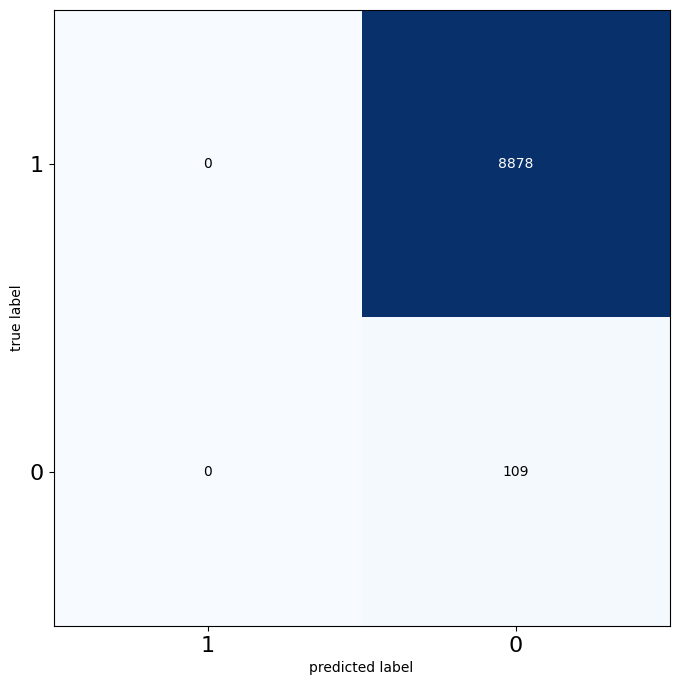

Security Guard & Patrol Service
accuracy: 0.9981083787693334 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

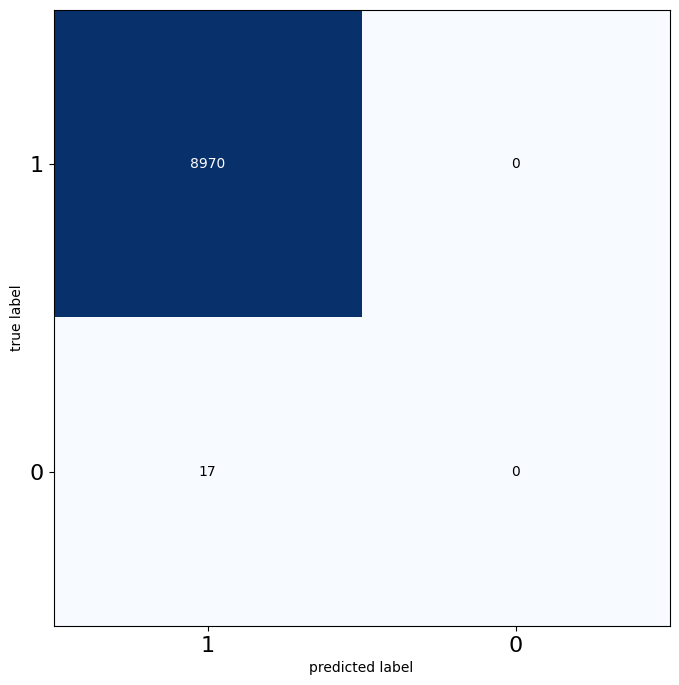

Security Printers
accuracy: 0.9934349616112162 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

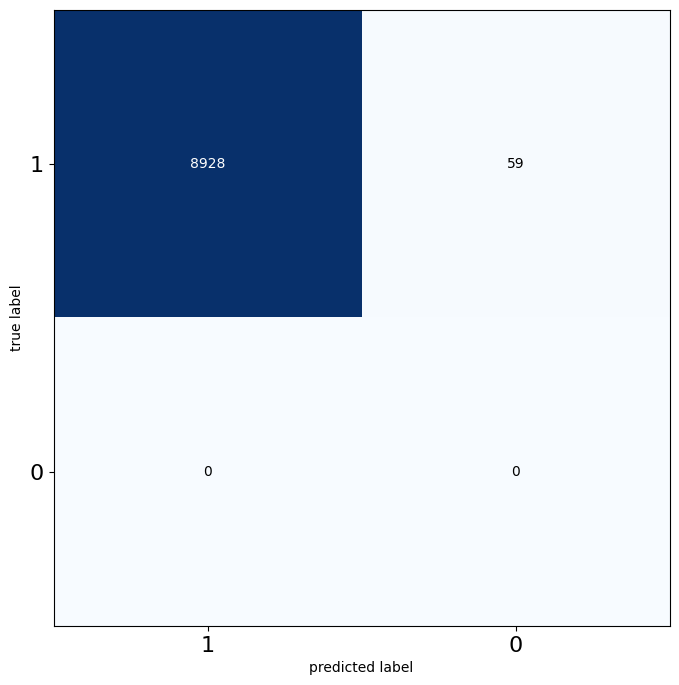

Security-Screening Equipment
accuracy: 0.9979971069322354 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

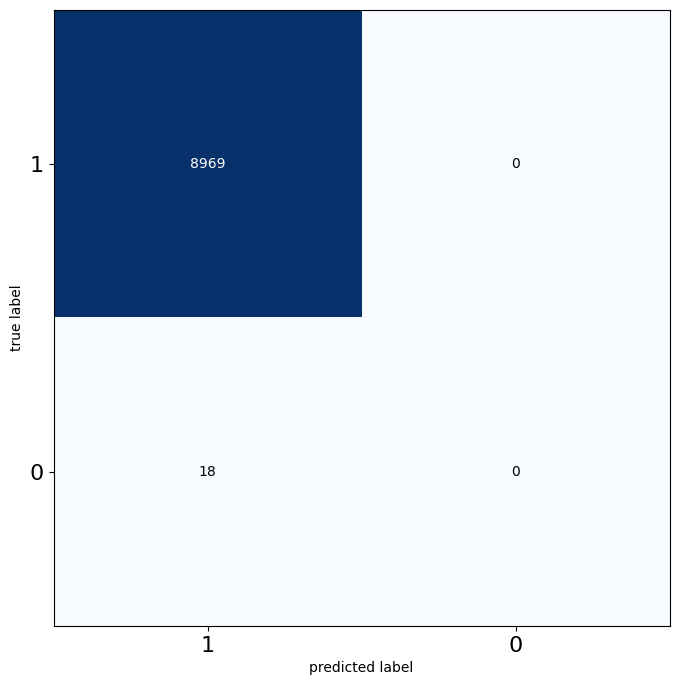

Sewage Disposal
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

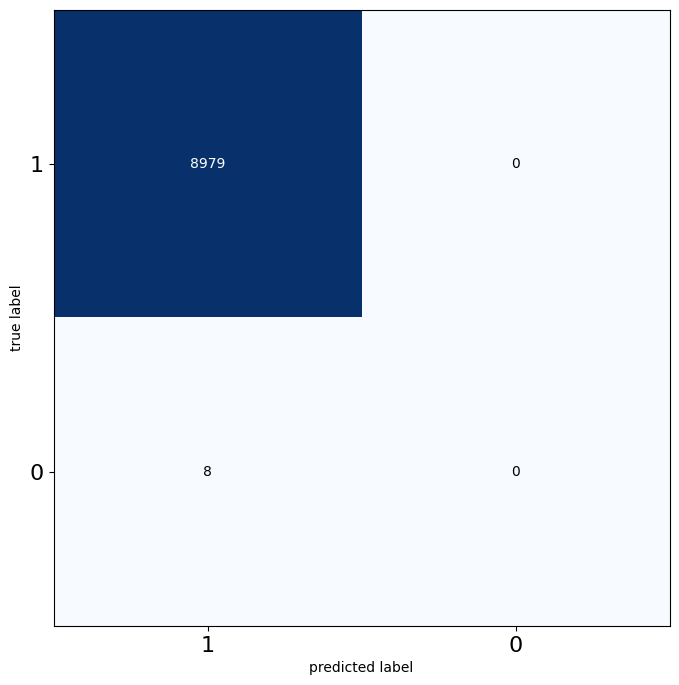

Sewing Machines-Industrial
accuracy: 0.9949927673305886 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

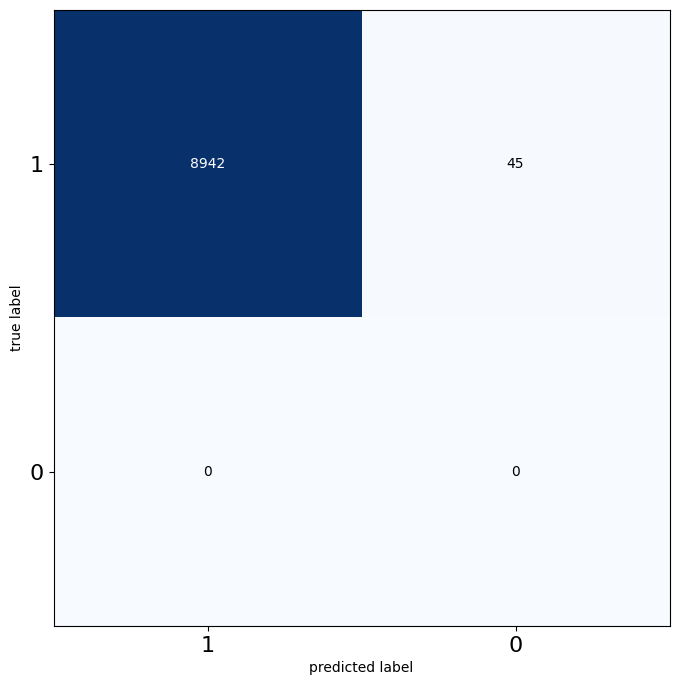

Ship Brokers
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

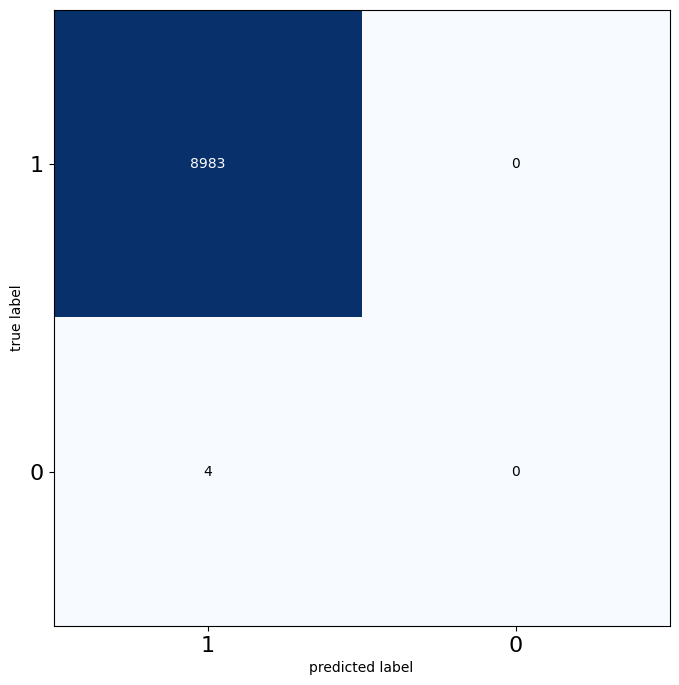

Ship Chandlers
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

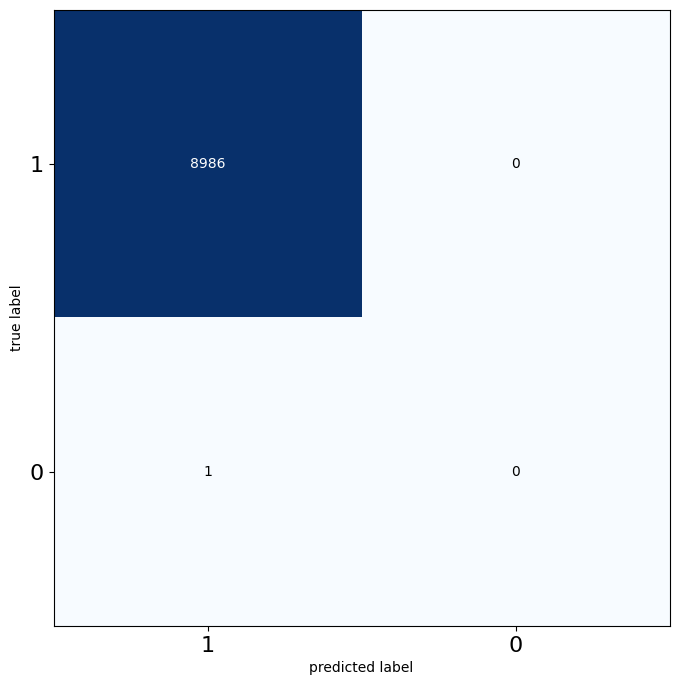

Ship Contractors
accuracy: 0.996328029375765 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

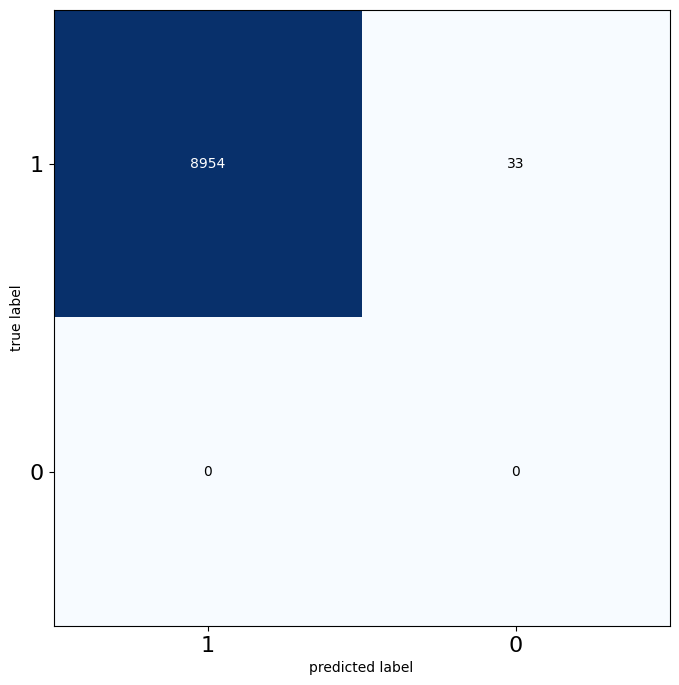

Ship Discharge Terminal
accuracy: 0.9935462334483143 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

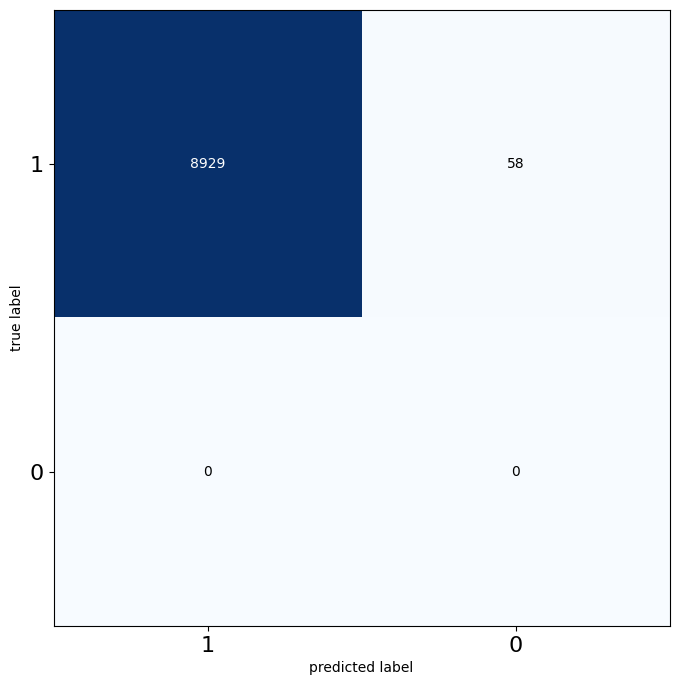

Shipping Lines
accuracy: 0.9954378546789807 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

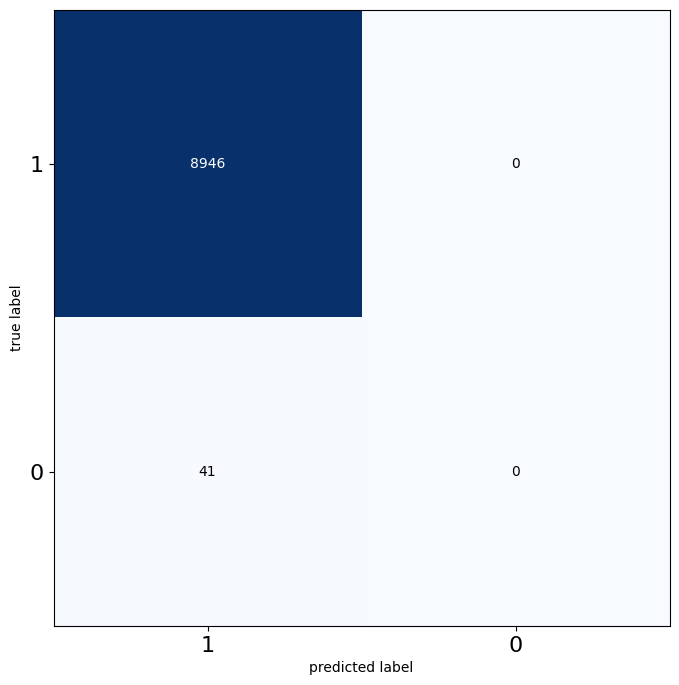

Shirts
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

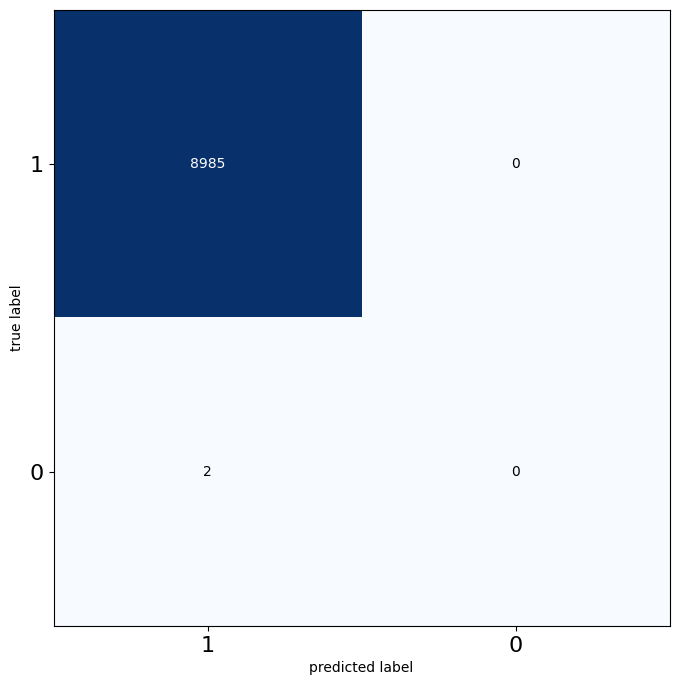

Shoe & Leather Polishes
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

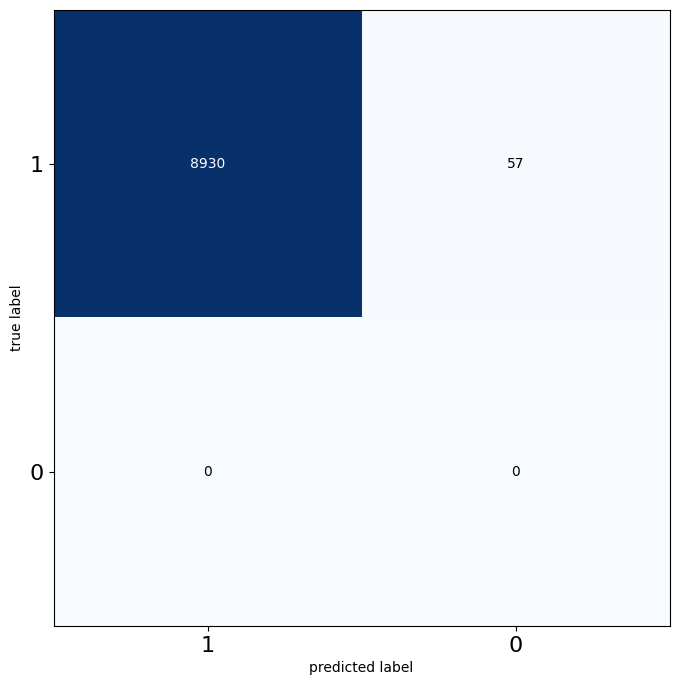

Shoe Materials & Supplies
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

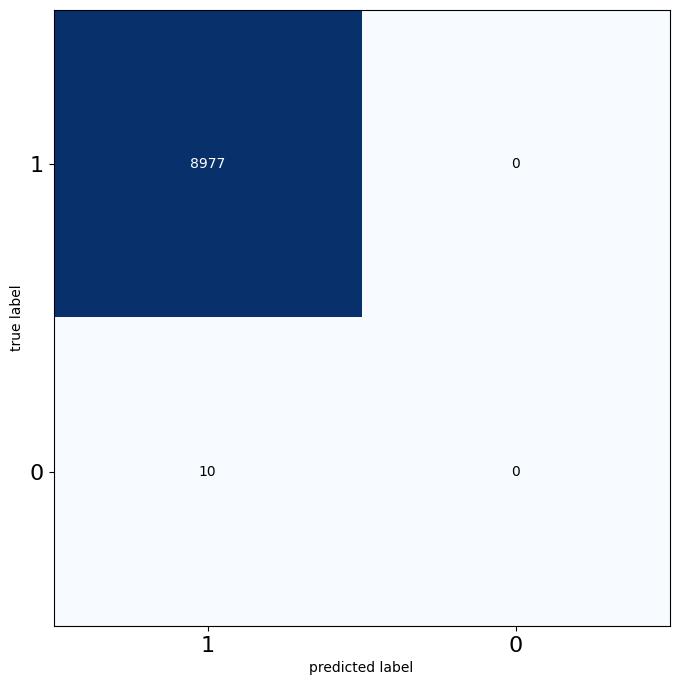

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shoes - Retail
accuracy: 0.9982196506064315 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

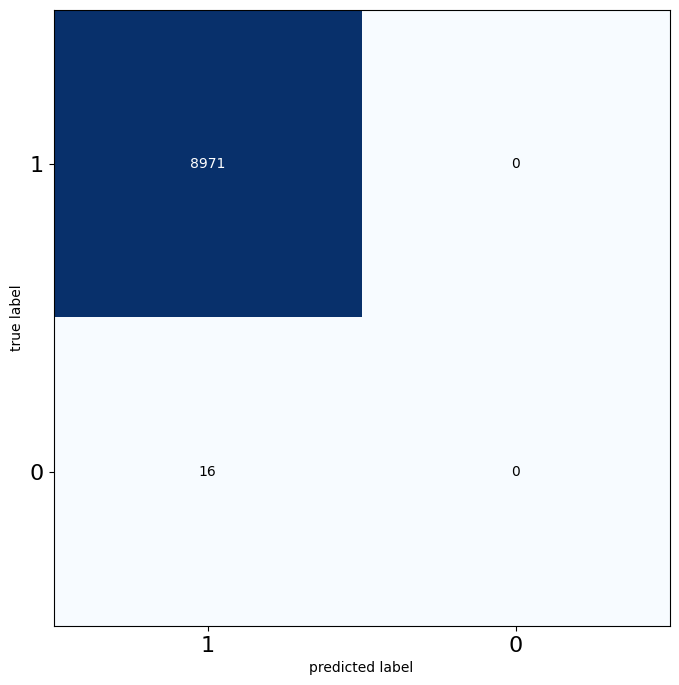

Shoes -Retail
accuracy: 0.9947702236563926 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

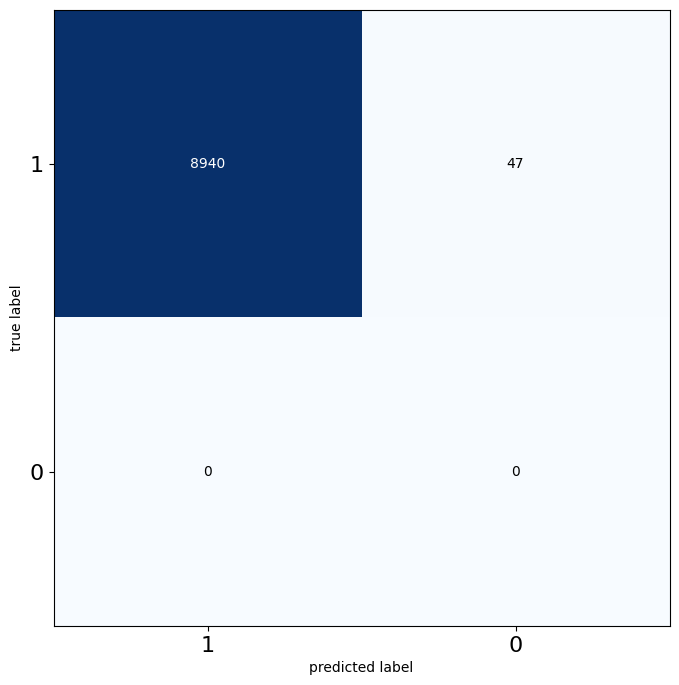

Shopping
accuracy: 0.06275731612328919 precision: 0.06275731612328919 recall: 1.0 f1: 0.11810281645900951


<Figure size 640x480 with 0 Axes>

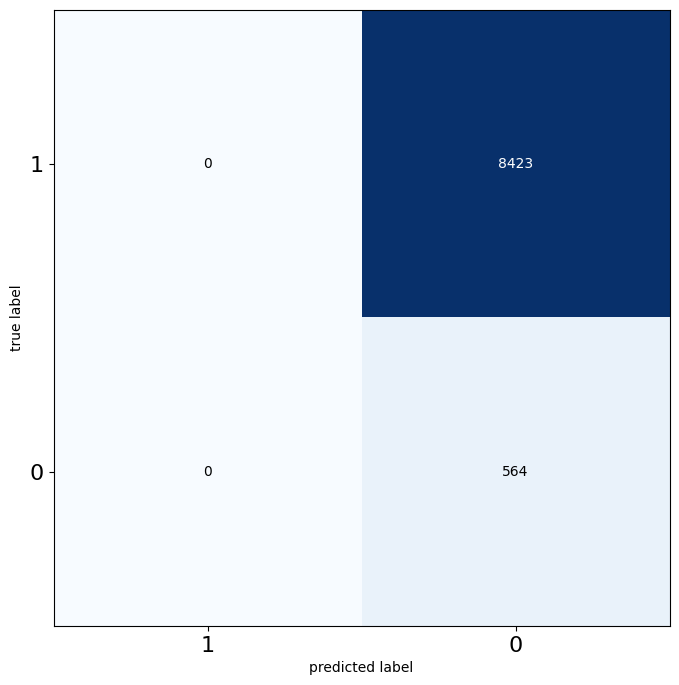

Shopping Centers
accuracy: 0.988984088127295 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

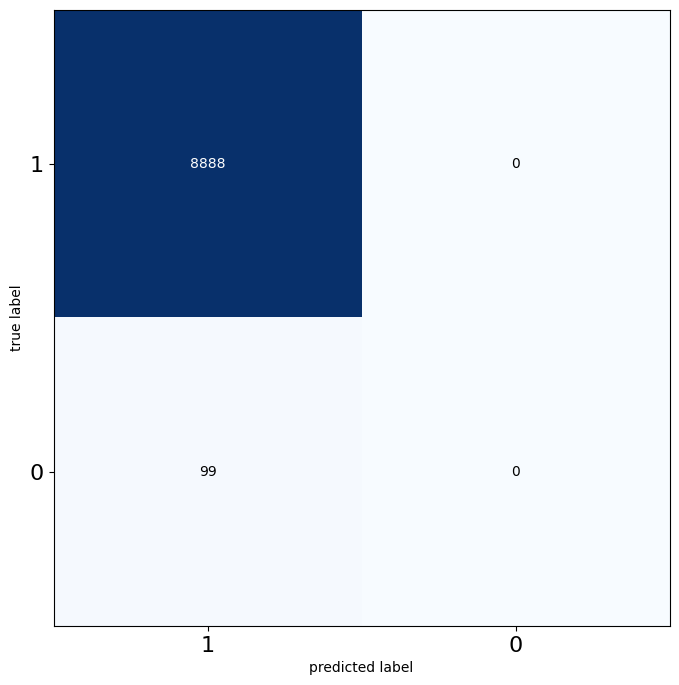

Soaps & Detergents
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

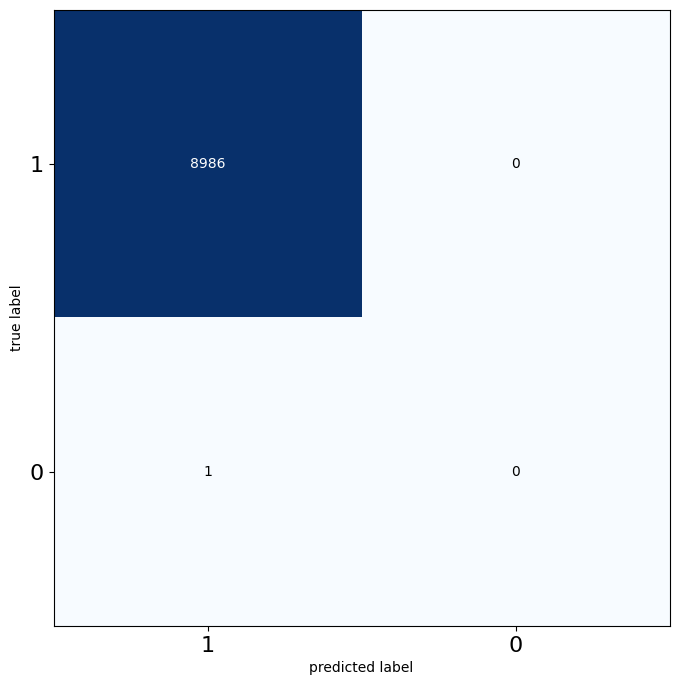

Social Service Organizations
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

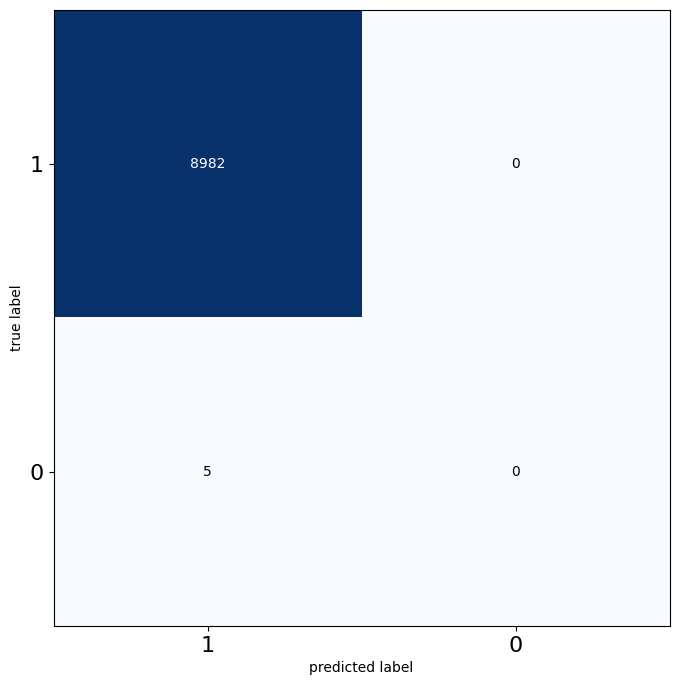

Societies & Associations
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

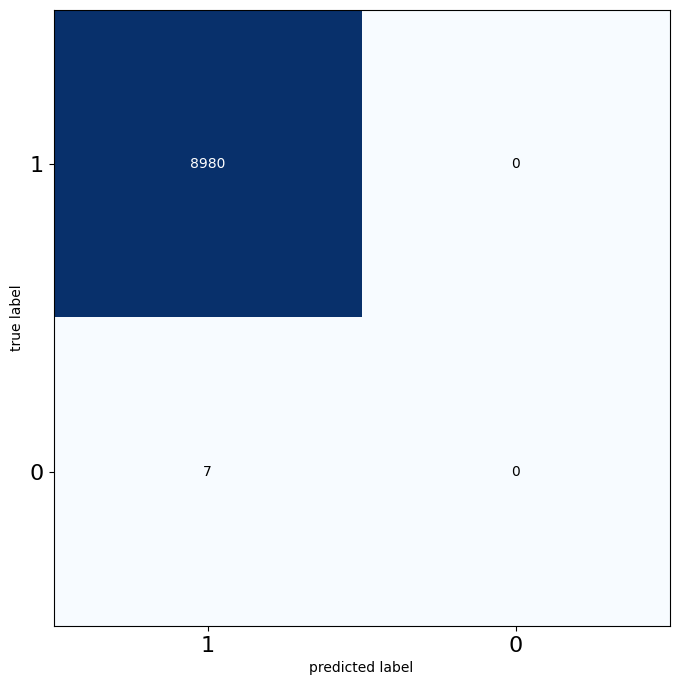

Socks
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

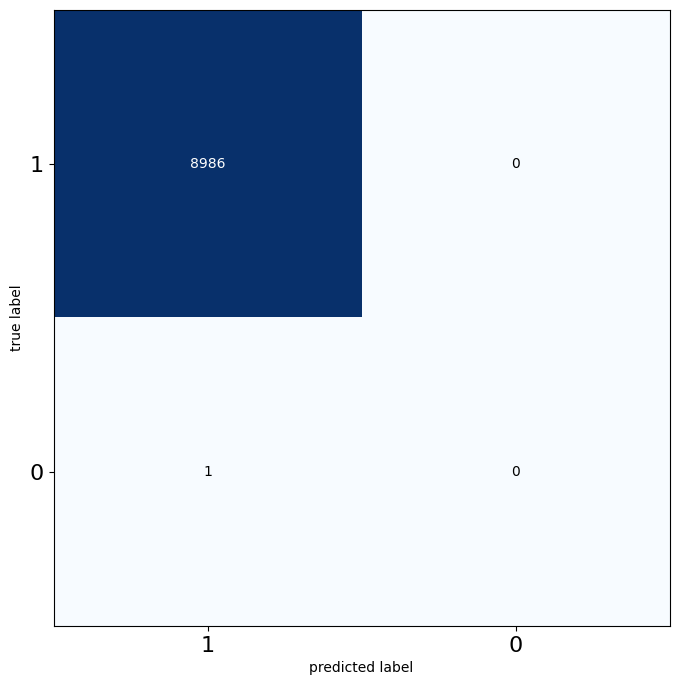

Soft Drinks
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

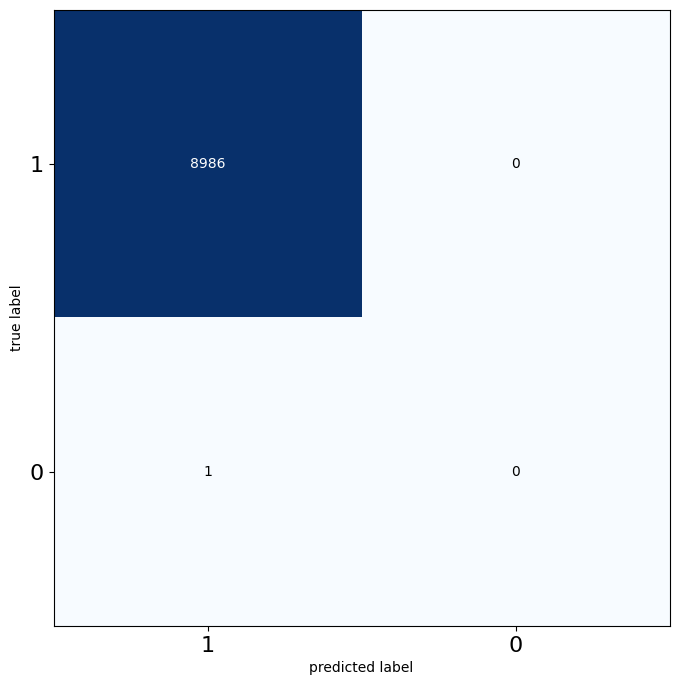

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Software Developers
accuracy: 0.996105485701569 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

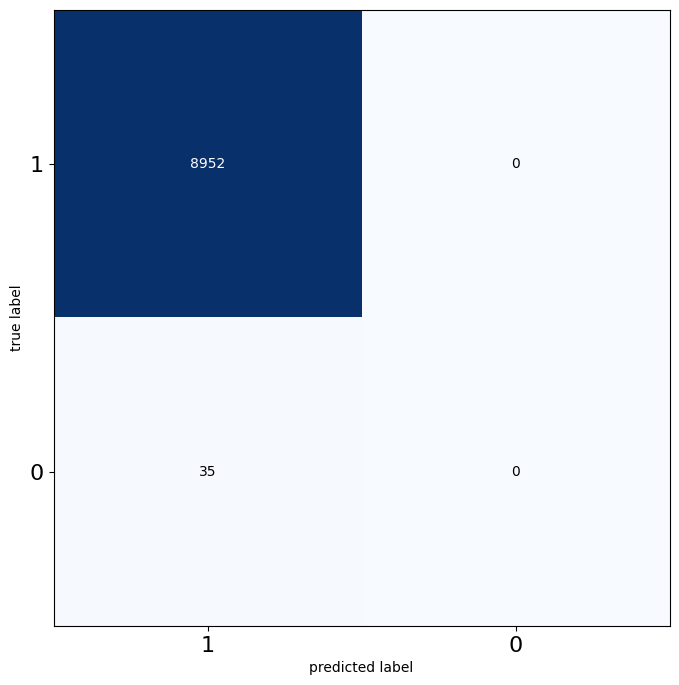

Solar Energy-Equipment & Supplies
accuracy: 0.996328029375765 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

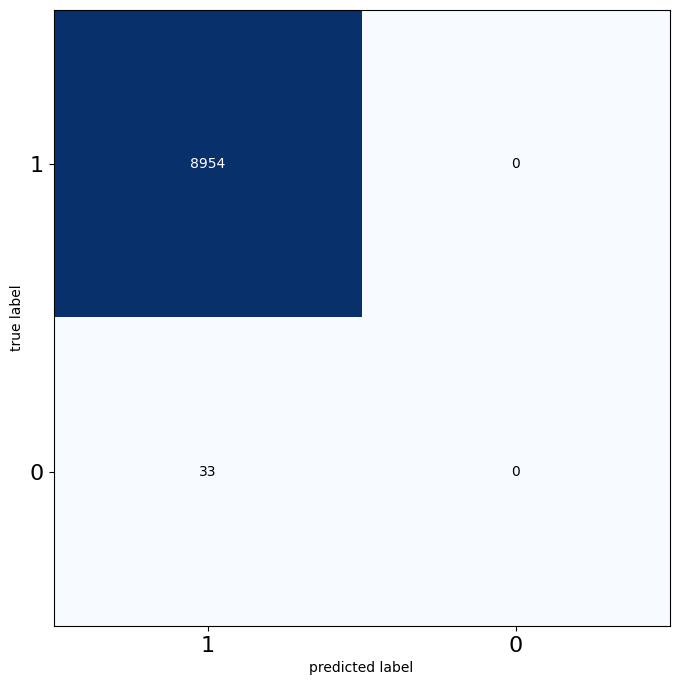

Solar Power Generation
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

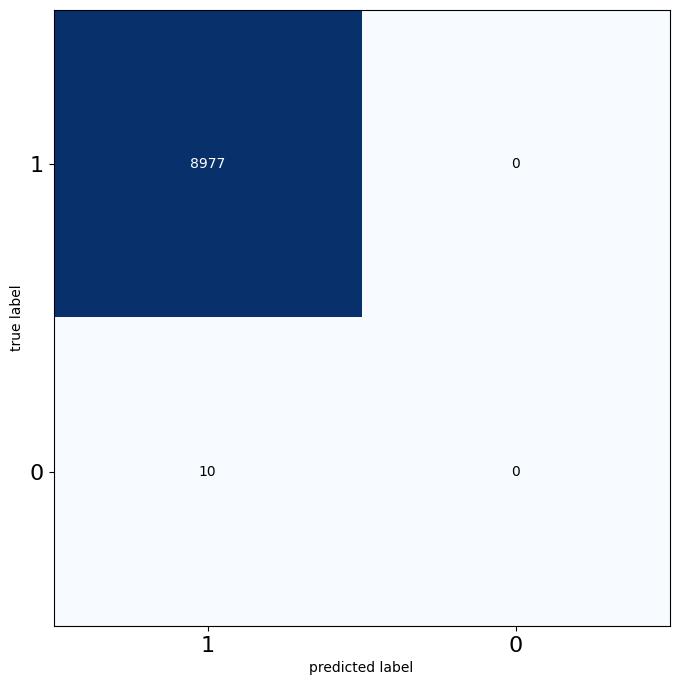

Sound Systems & Equipment
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

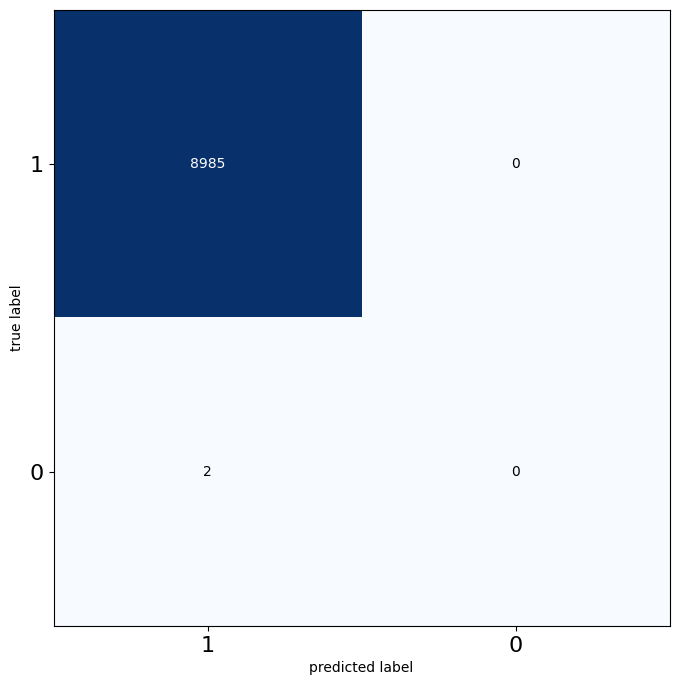

Spices
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

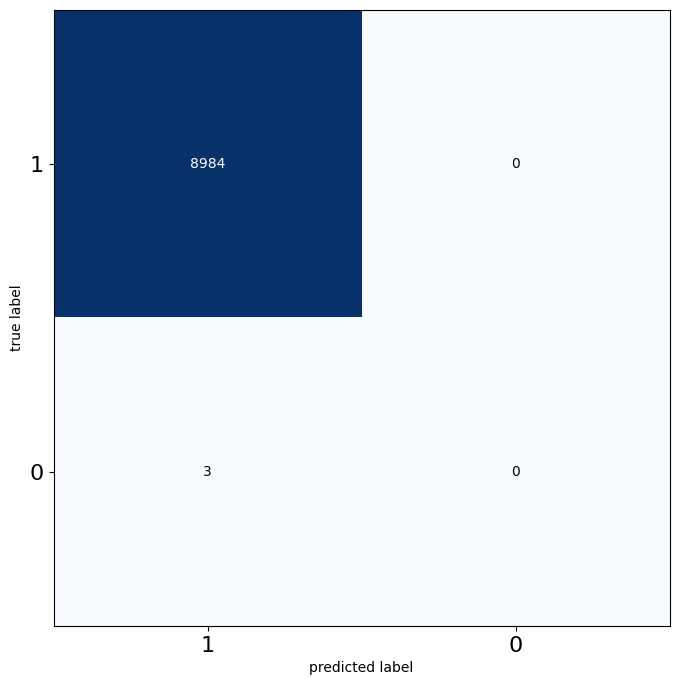

Sports
accuracy: 0.138644709024146 precision: 0.018156424581005588 recall: 0.9470198675496688 f1: 0.035629749595116486


<Figure size 640x480 with 0 Axes>

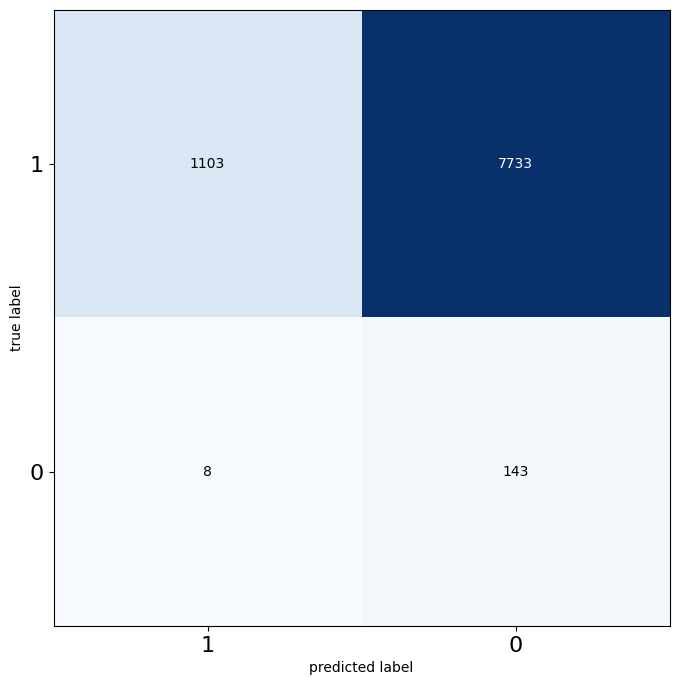

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sports Equipment & Supplies
accuracy: 0.9981083787693334 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

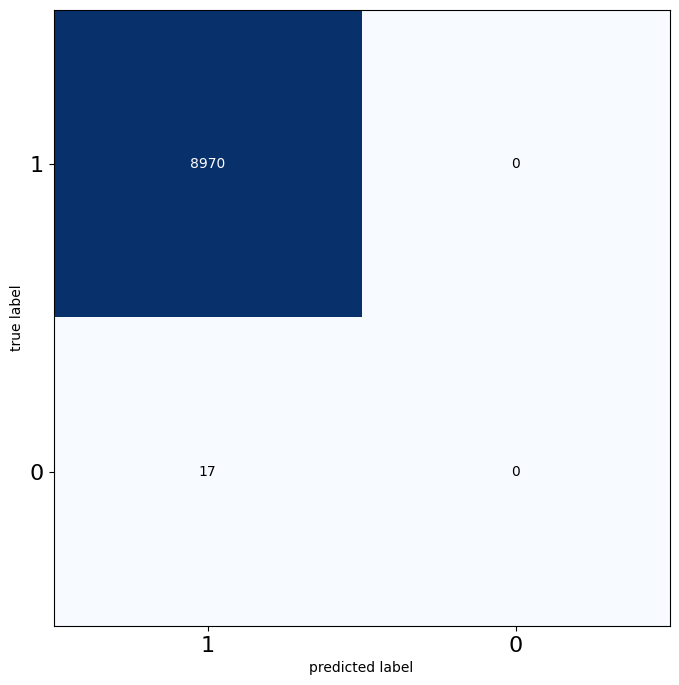

Sports Organizations
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

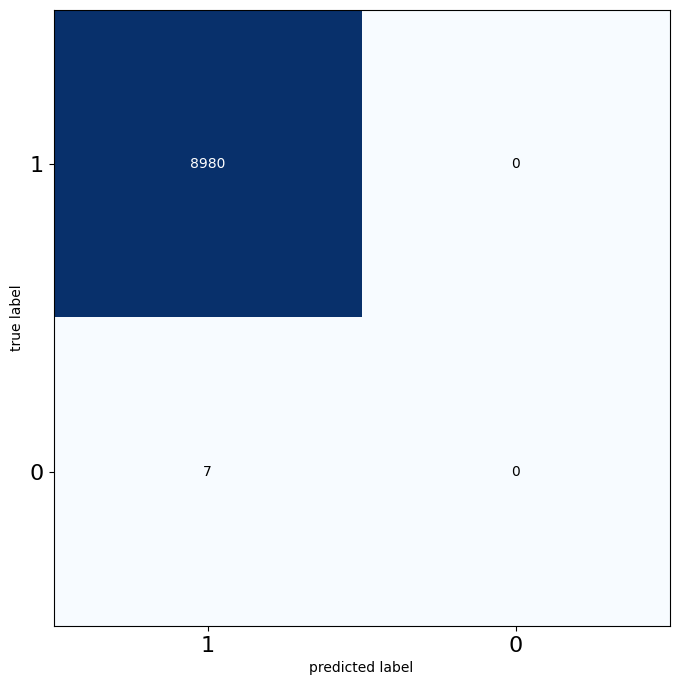

Sportswear
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

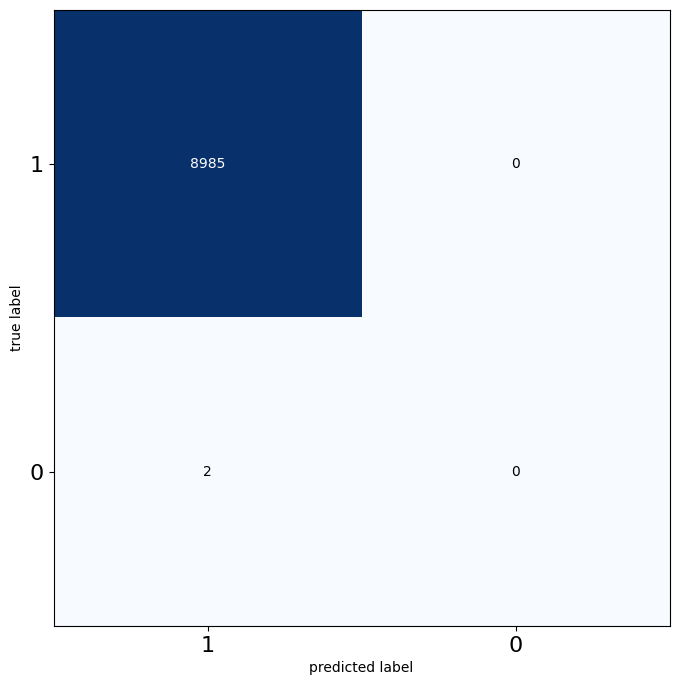

Stadiums
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

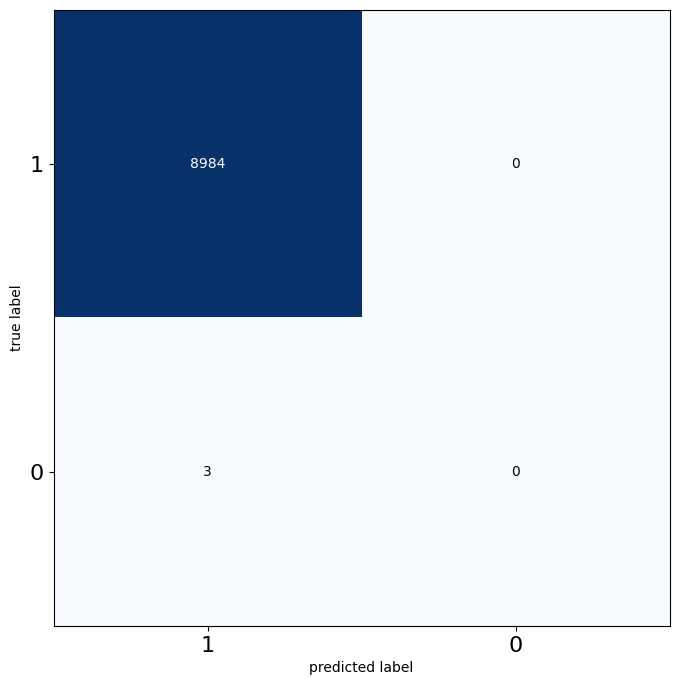

Stationery
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

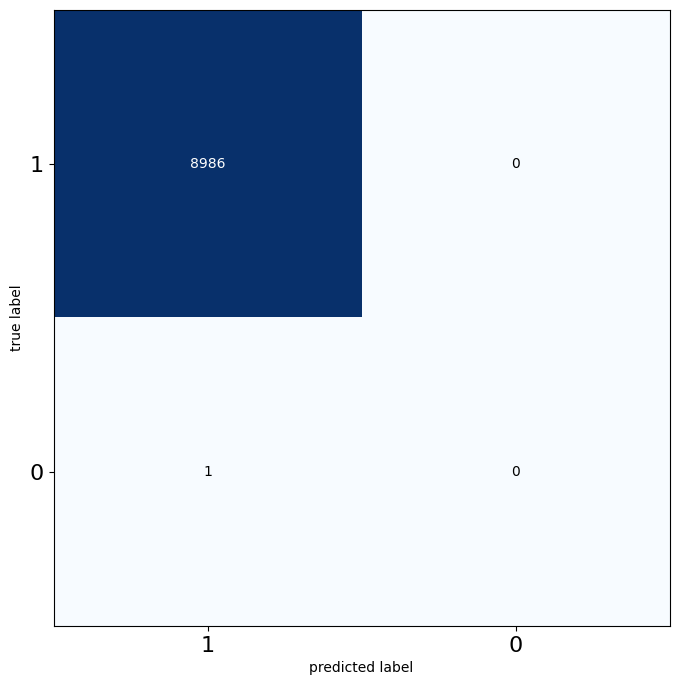

Steel Fabricators & Products
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

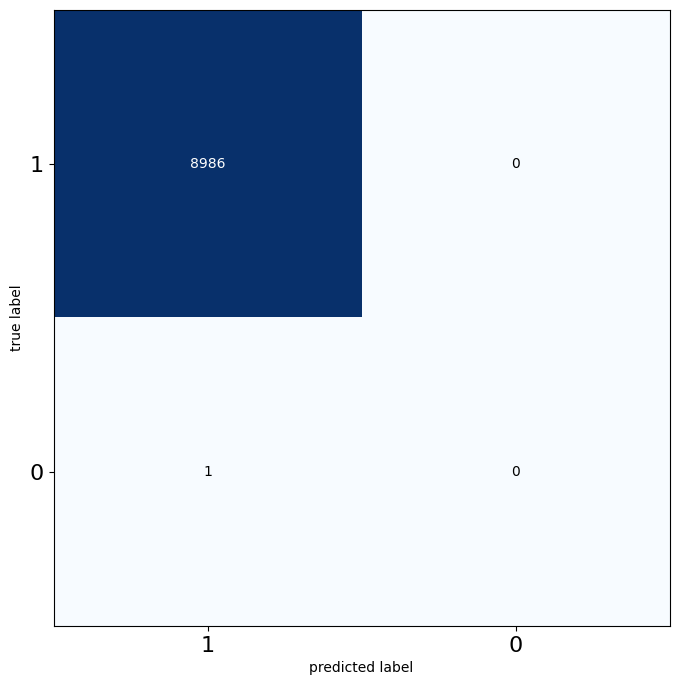

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Steel Mills
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

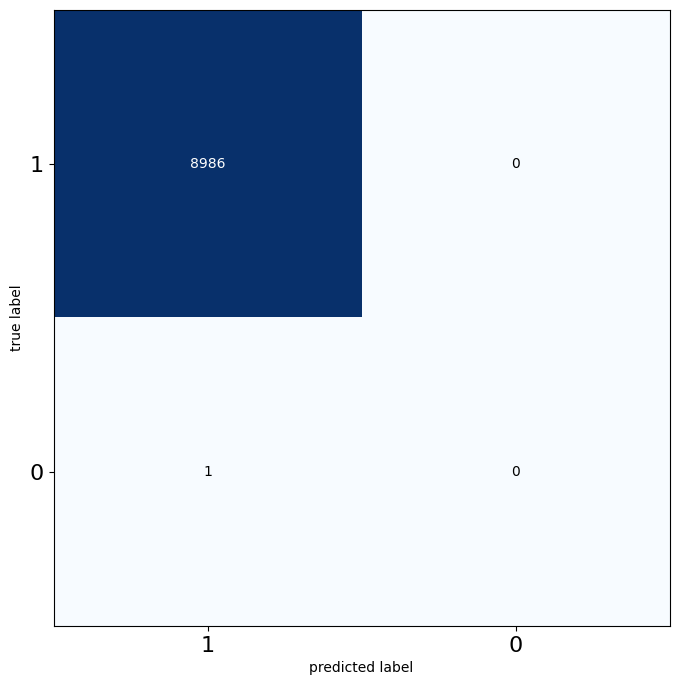

Stock & Share Brokers
accuracy: 0.9991098253032158 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

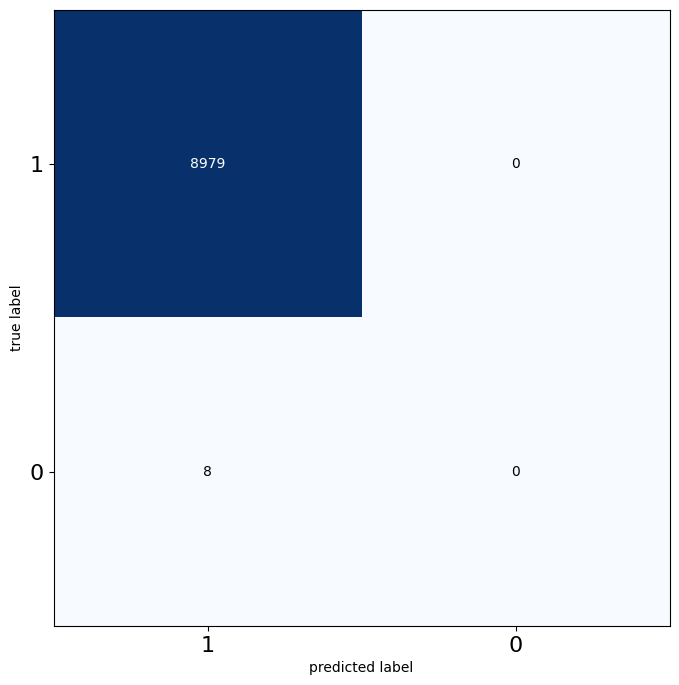

Stock Exchange
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

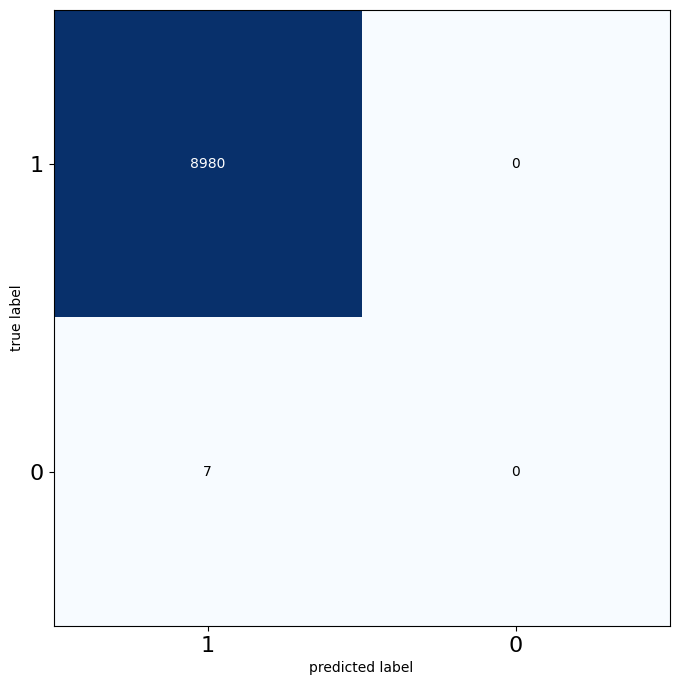

Sugar Manufacturers & Dealers
accuracy: 0.9934349616112162 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

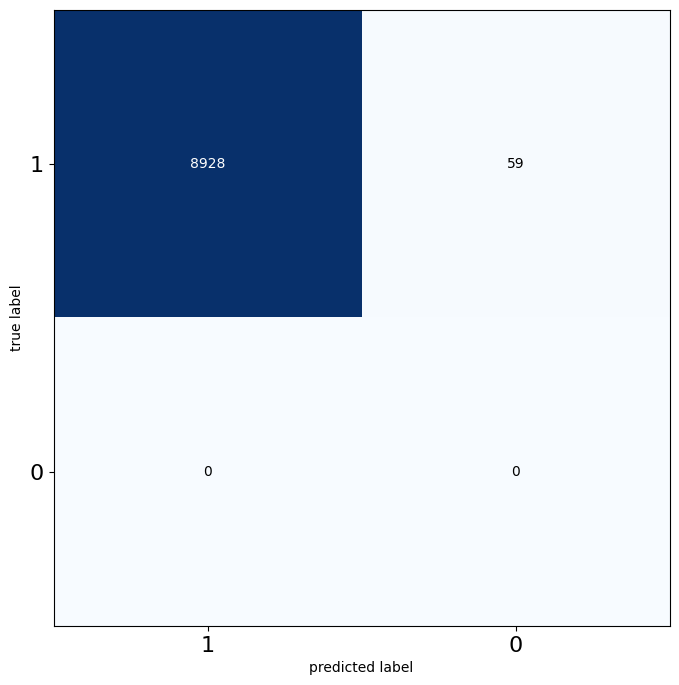

Supermarkets
accuracy: 0.9910982530321576 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

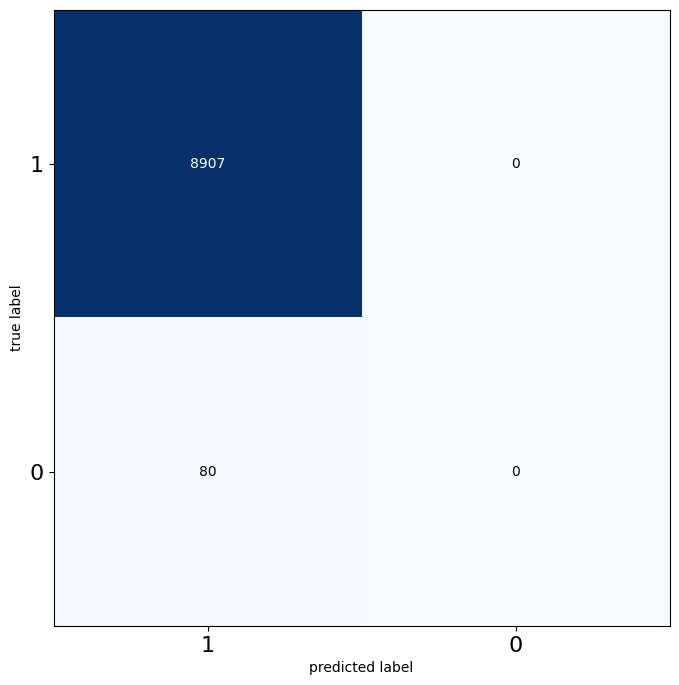

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Surgical Supplies
accuracy: 0.9924335150773339 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

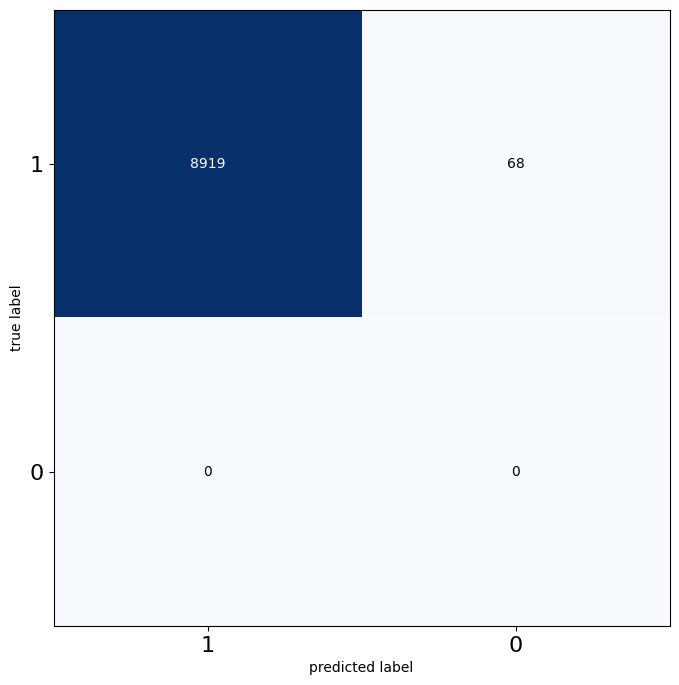

Surveyors
accuracy: 0.9987760097919217 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

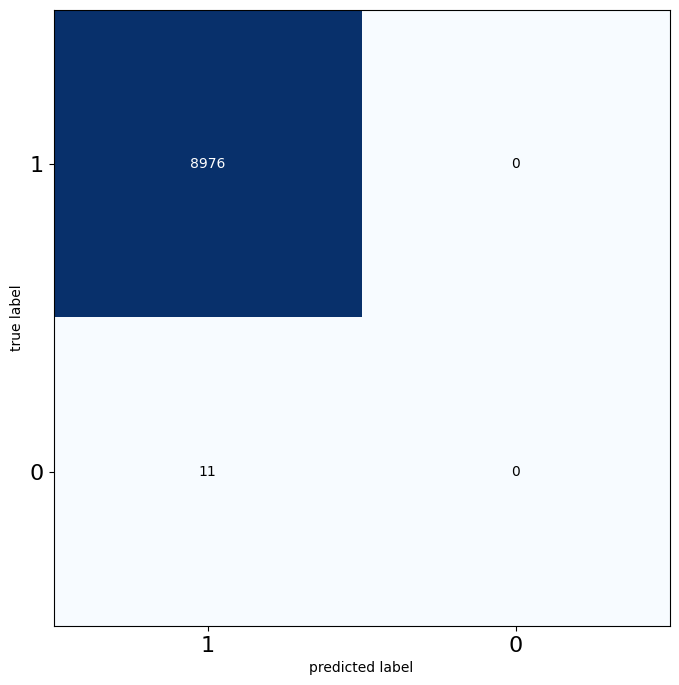

Sweets
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

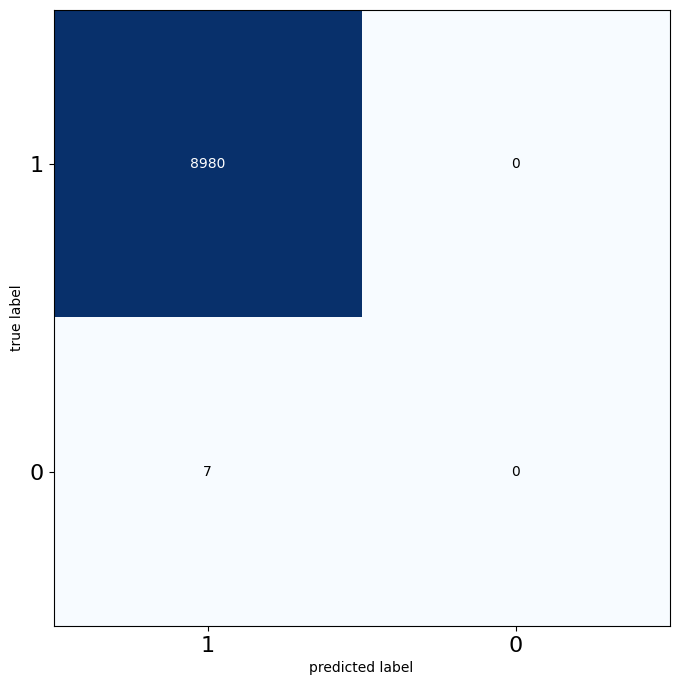

Swimming Pools
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

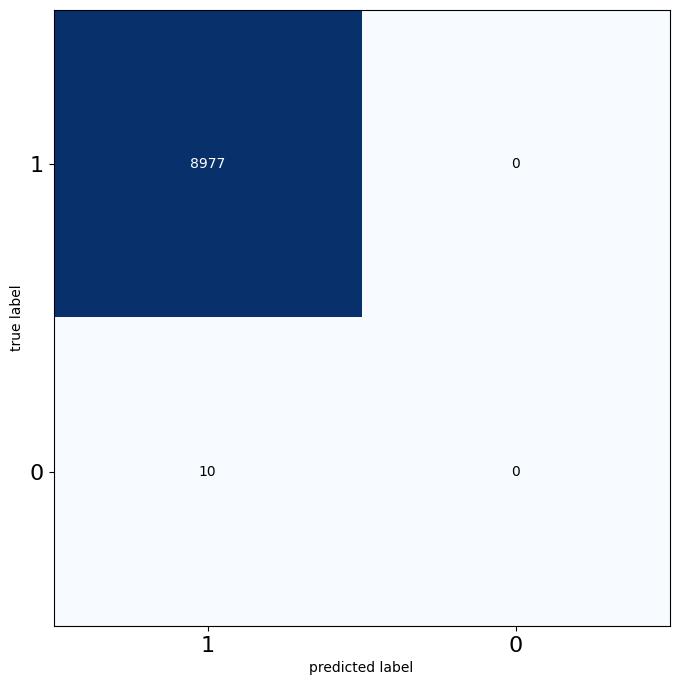

Tailors - General
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

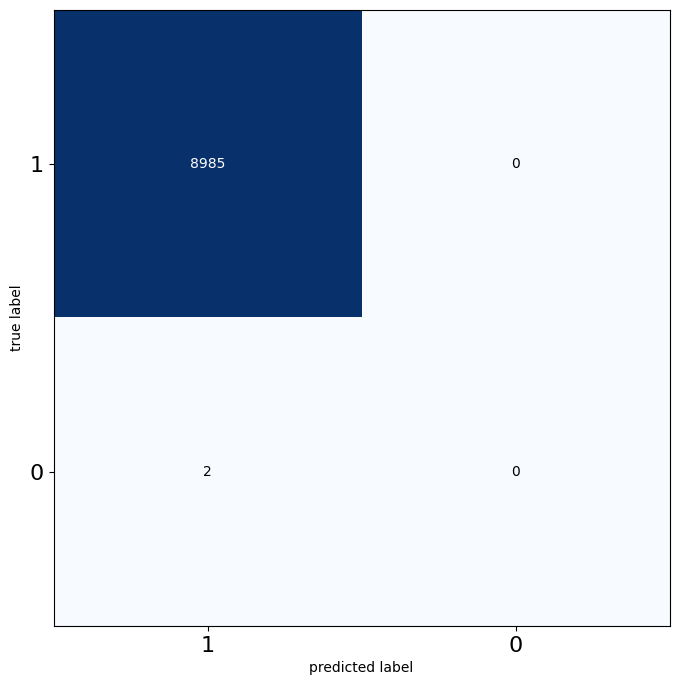

Tax Consultants
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

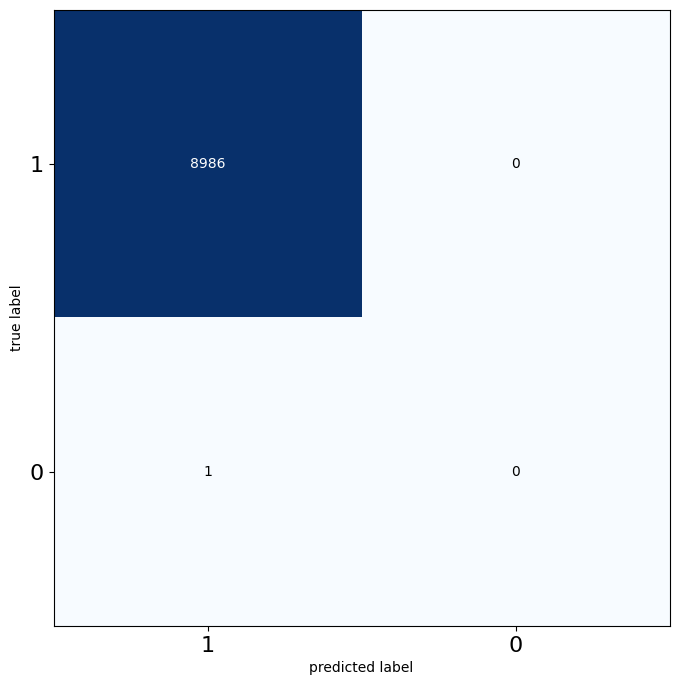

Telecommunication Operators
accuracy: 0.9985534661177256 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

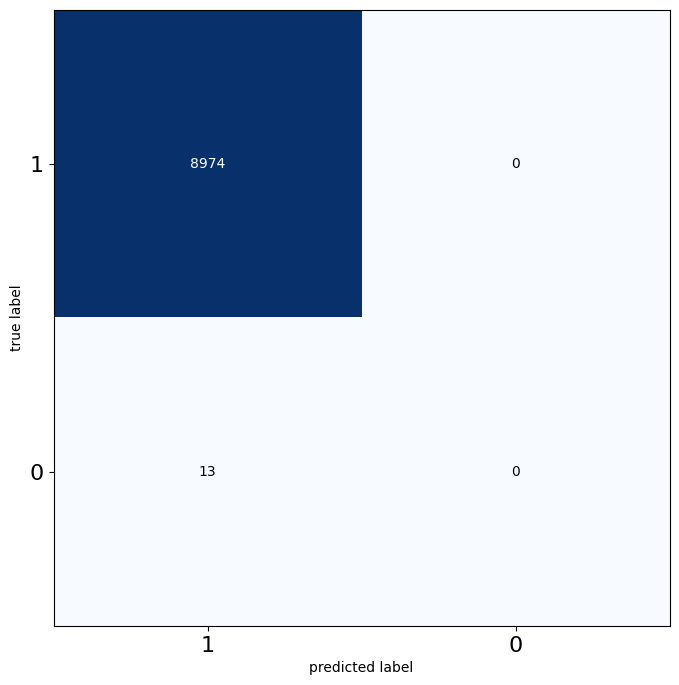

Telecommunication Service
accuracy: 0.9860910203627462 precision: 0.009615384615384616 recall: 0.043478260869565216 f1: 0.015748031496062992


<Figure size 640x480 with 0 Axes>

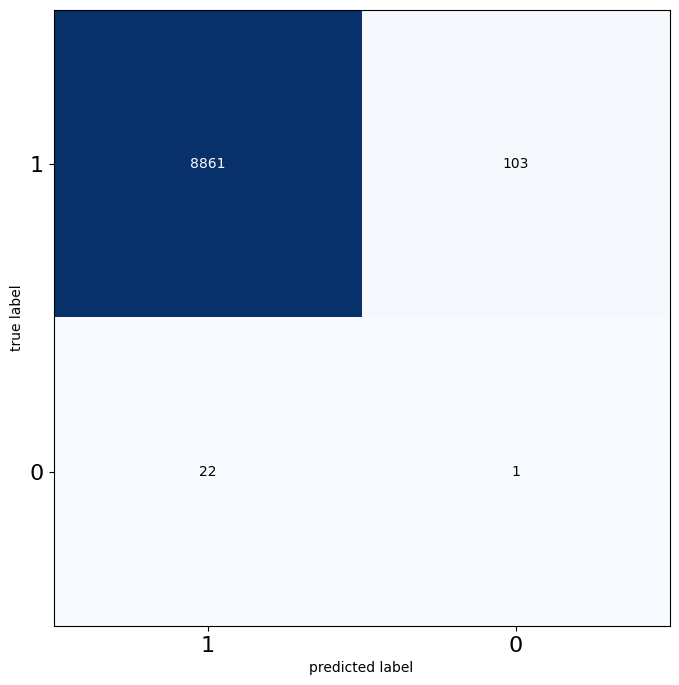

Television Dealers
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

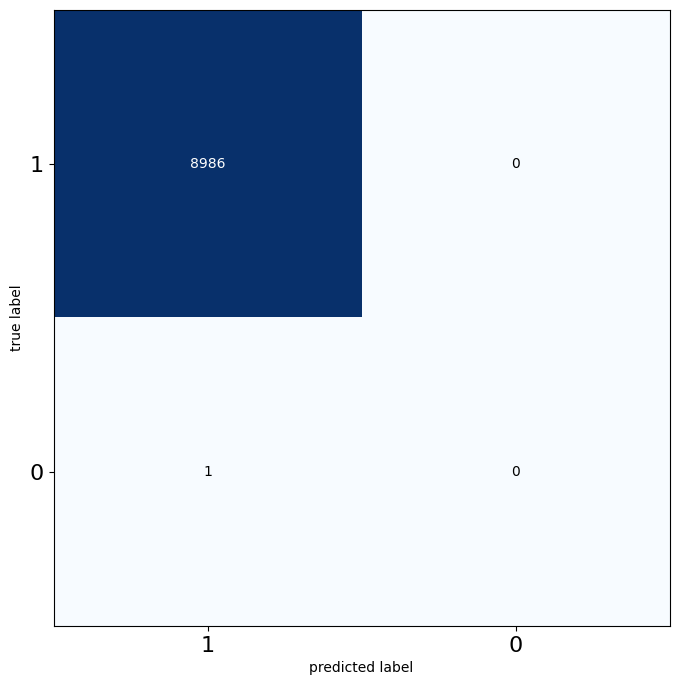

Television Stations
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

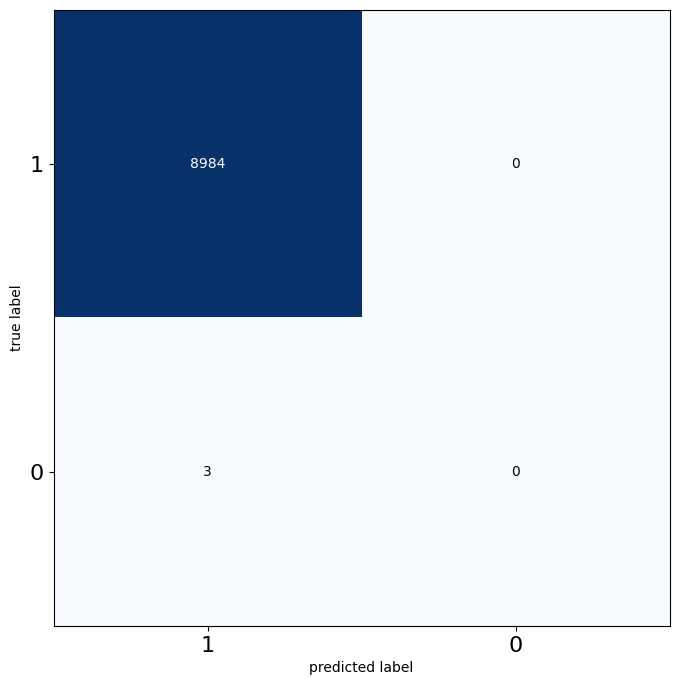

Television Systems & Equipment
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

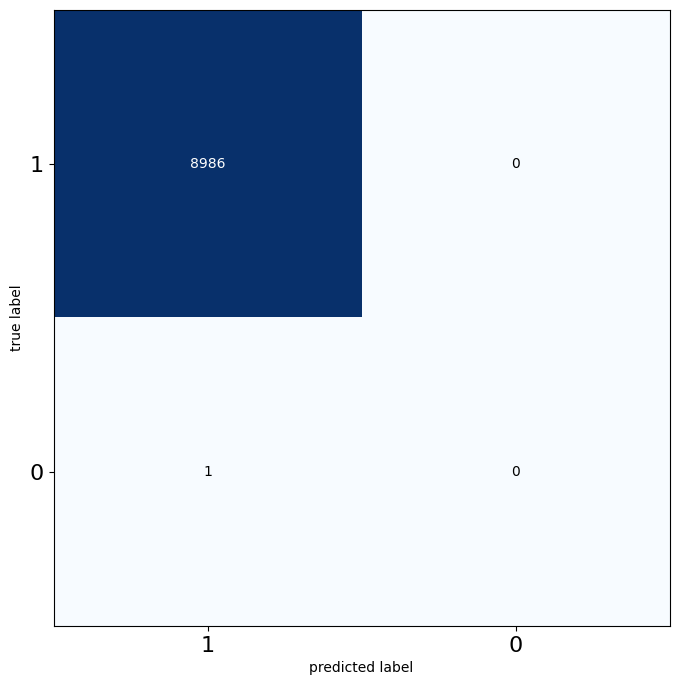

Textile Manufacturers
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

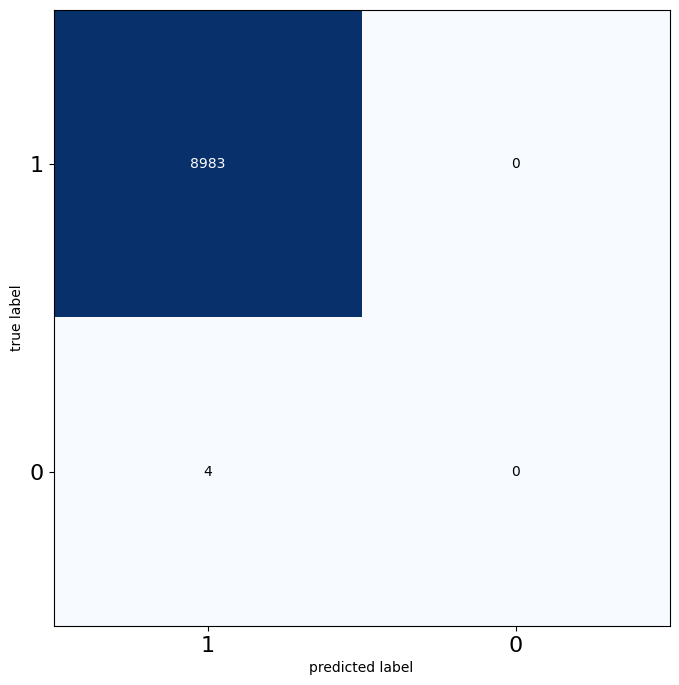

Textile Merchants
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

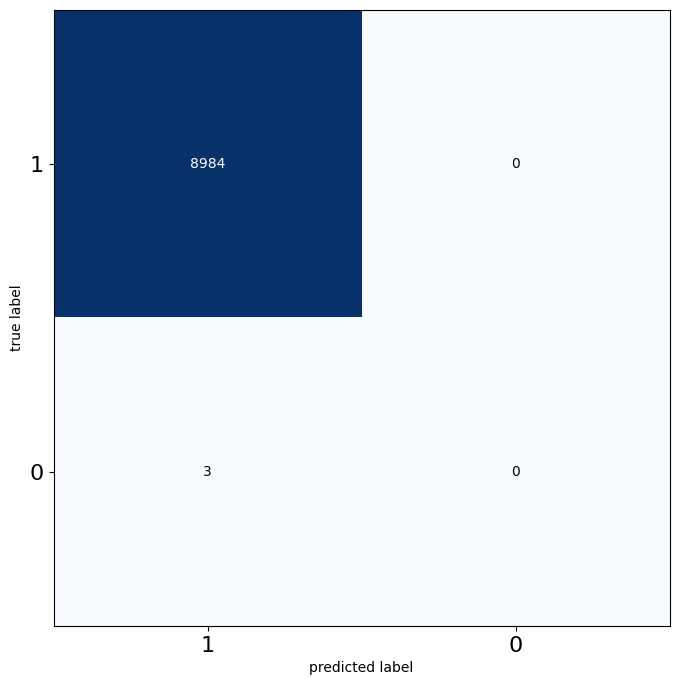

Theatres & Cinemas
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

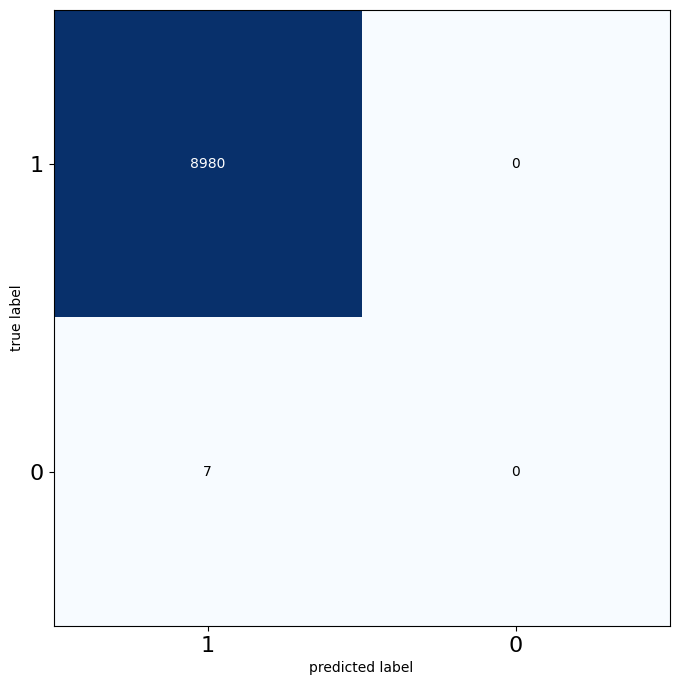

Theological Colleges
accuracy: 0.9976632914209413 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

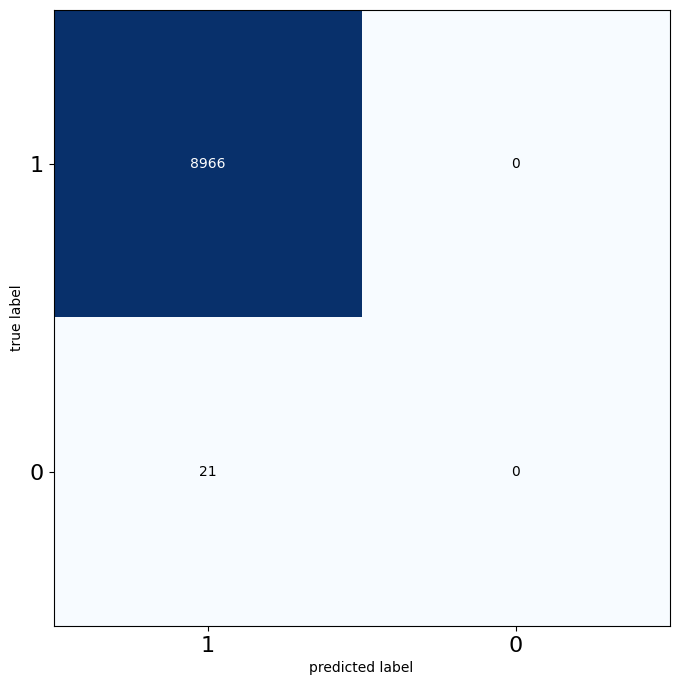

Timber and Wood Dealers
accuracy: 0.992989874262824 precision: 0.015873015873015872 recall: 0.5 f1: 0.03076923076923077


<Figure size 640x480 with 0 Axes>

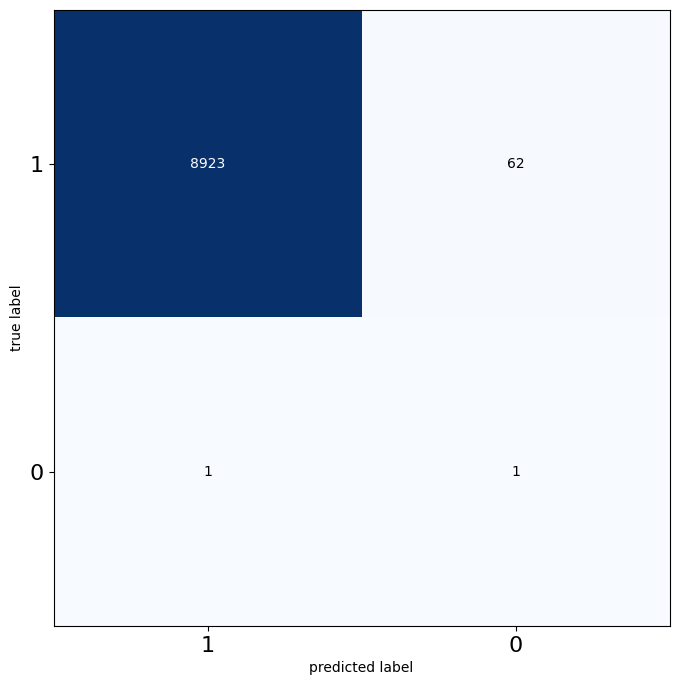

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tourist Attractions & Information
accuracy: 0.9988872816290197 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

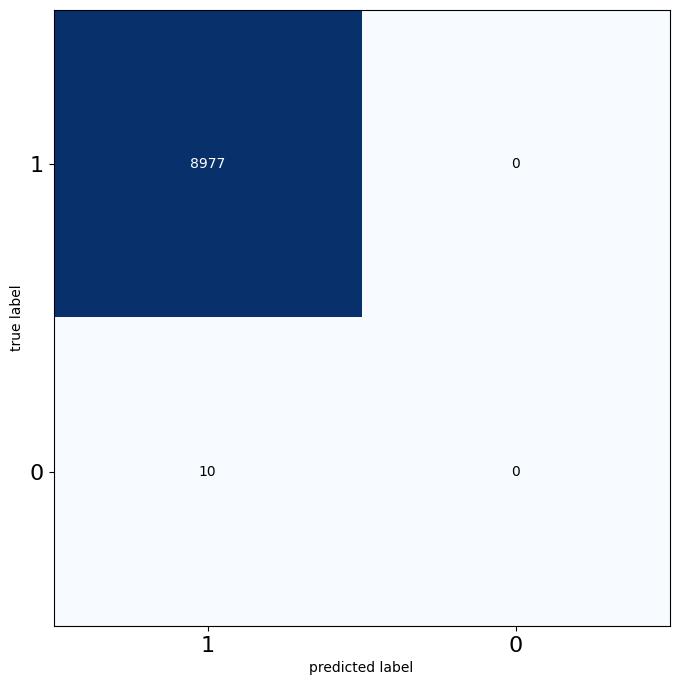

Towing-Motor Vehicles
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

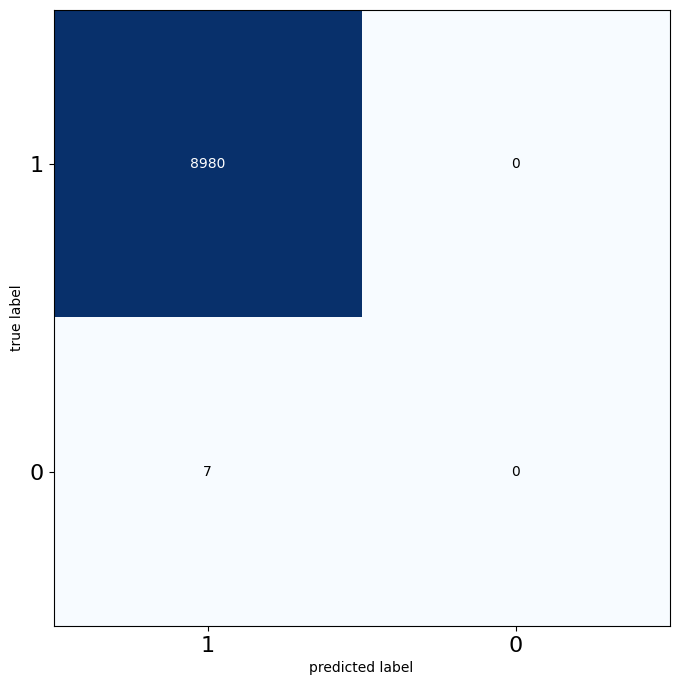

Toys-Retail
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

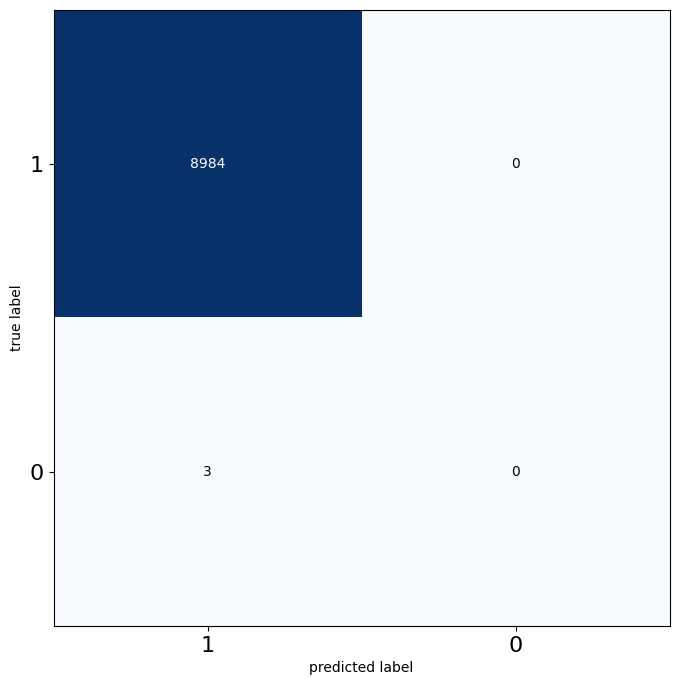

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tractors-Dealers, Service & Spares
accuracy: 0.9949927673305886 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

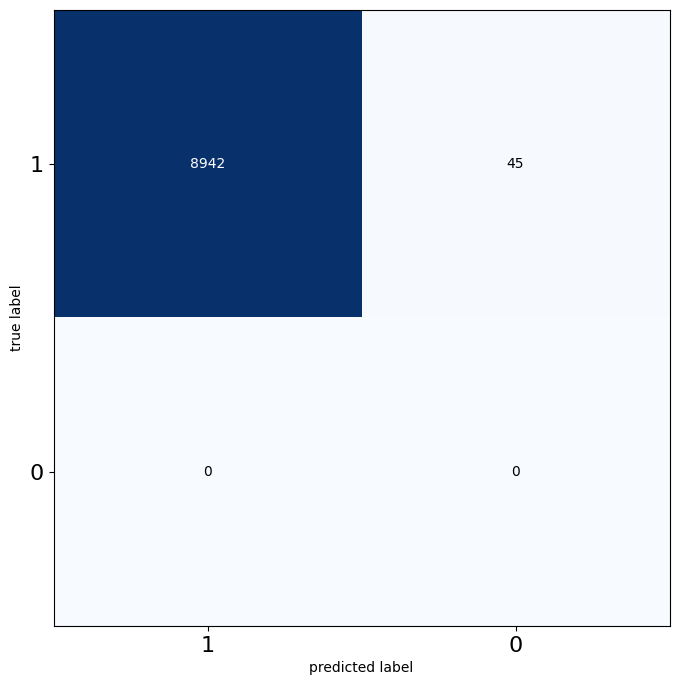

Trade Unions
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

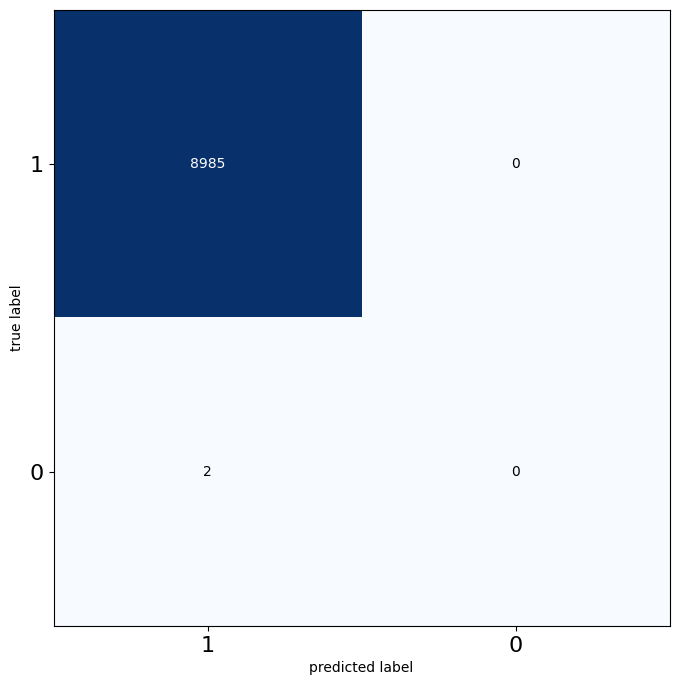

Trading Companies
accuracy: 0.9978858350951374 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

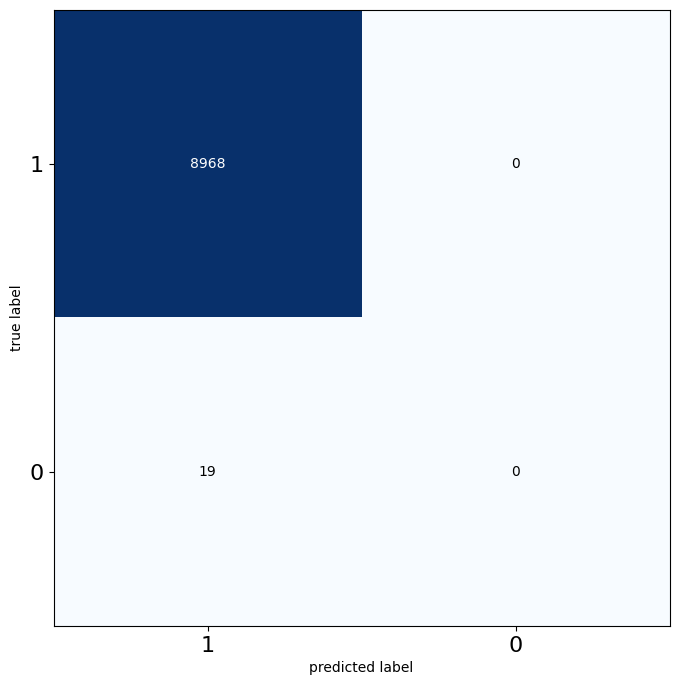

Trailers
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

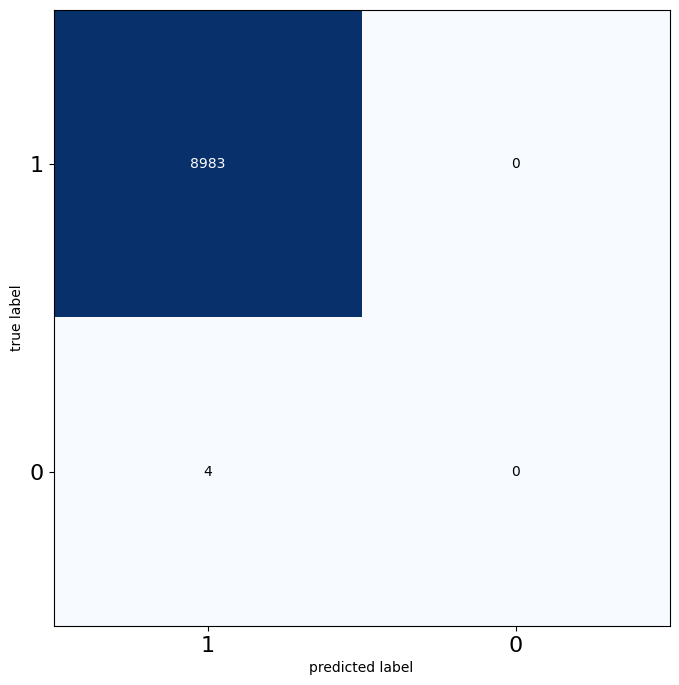

Training Consultants
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

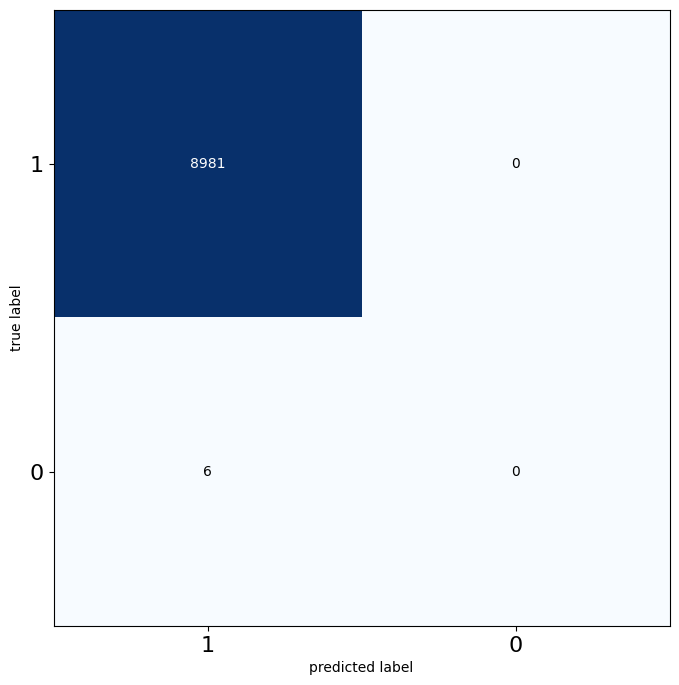

Training Institutes
accuracy: 0.9866473795482363 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

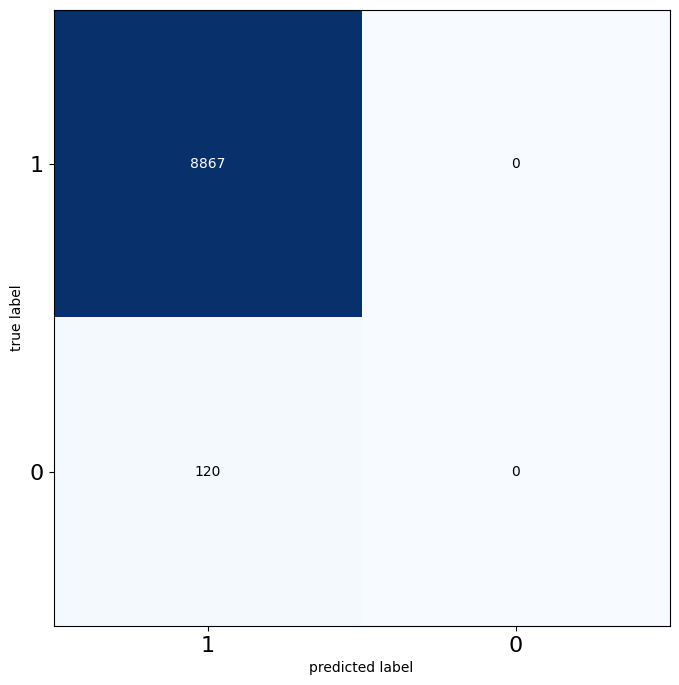

Transport
accuracy: 0.9372426838767108 precision: 0.0625 recall: 0.0037313432835820895 f1: 0.007042253521126761


<Figure size 640x480 with 0 Axes>

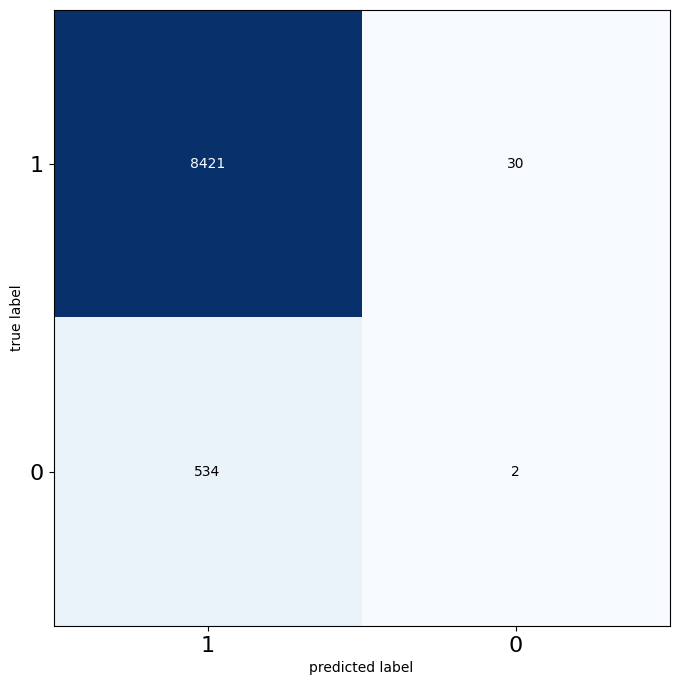

Transporters
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

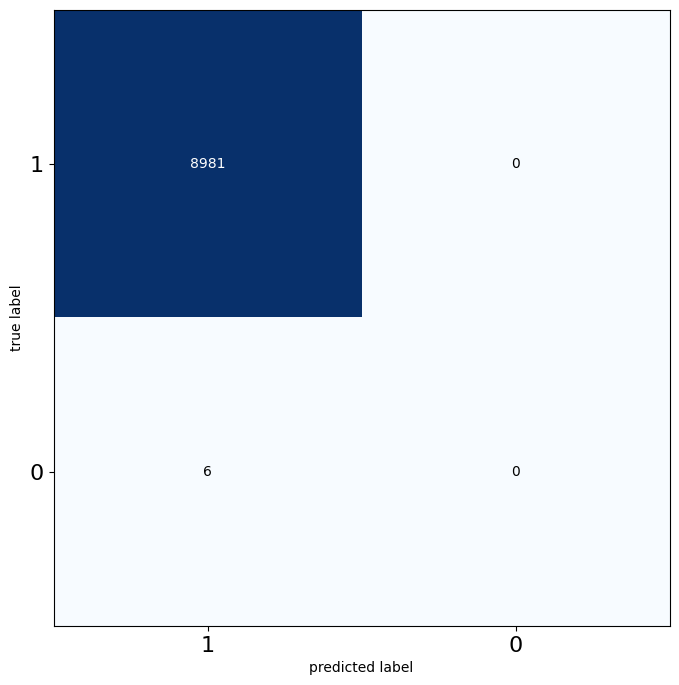

Travel Agencies
accuracy: 0.9925447869144319 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

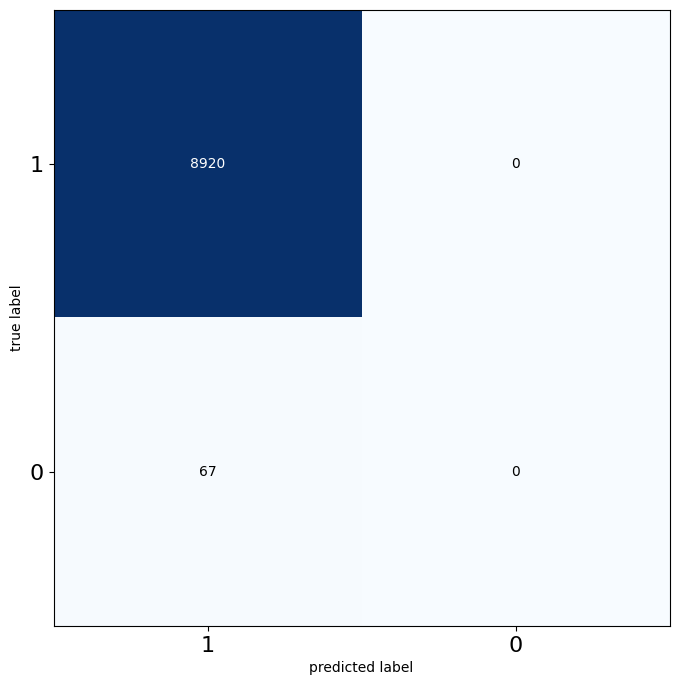

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Truck Dealers
accuracy: 0.9987760097919217 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

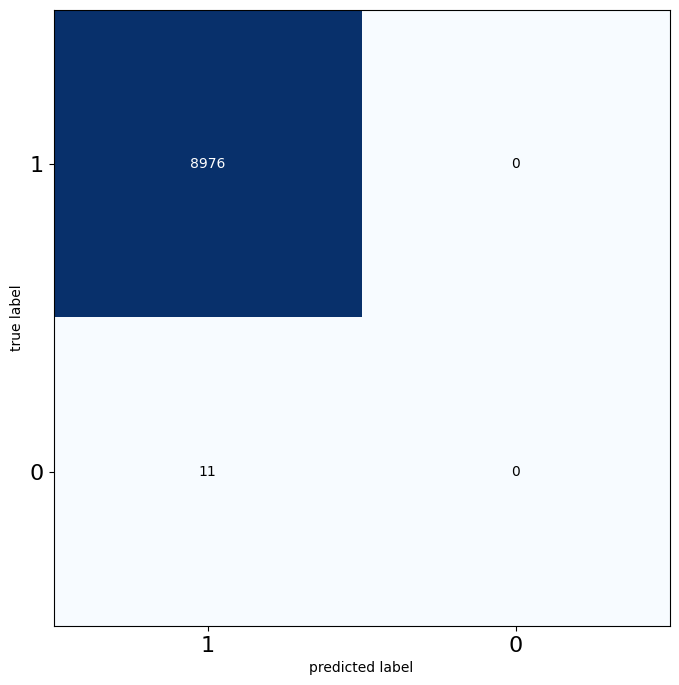

Truck Parts & Supplies
accuracy: 0.9954378546789807 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

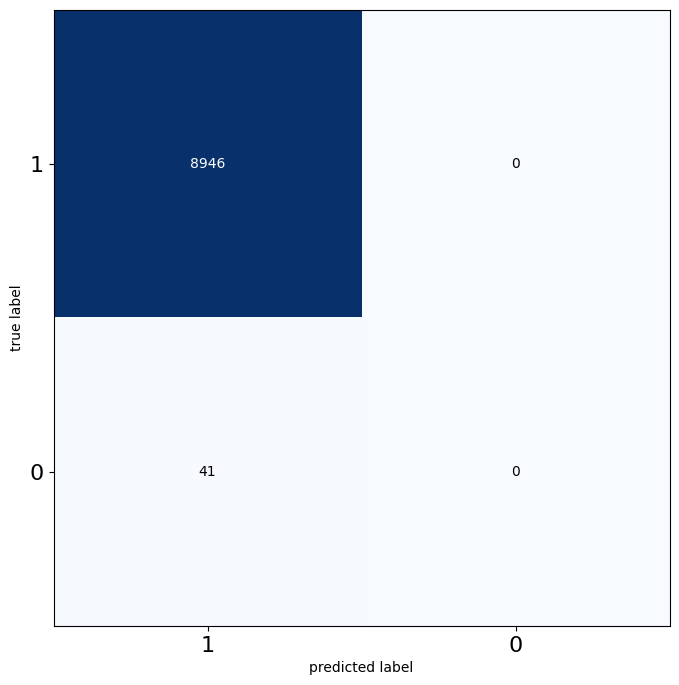

Tuition
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

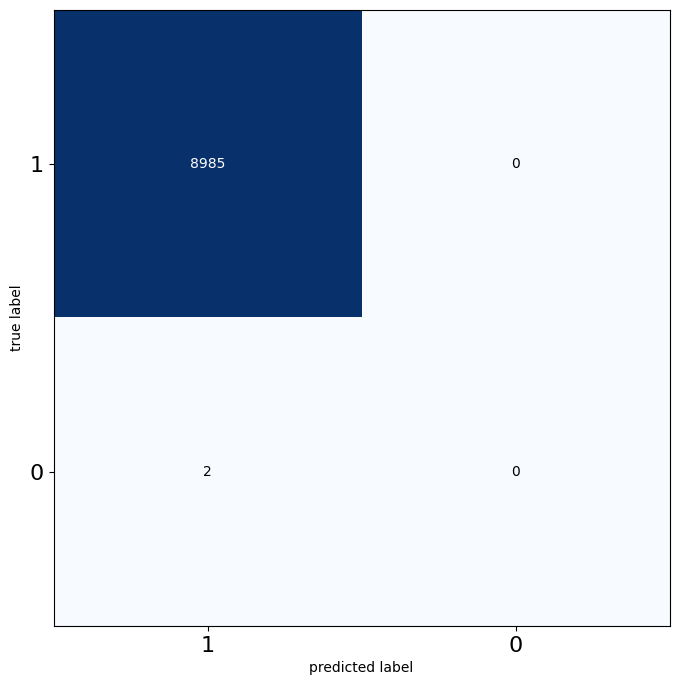

Tyre Dealers & Equipment Supplies
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

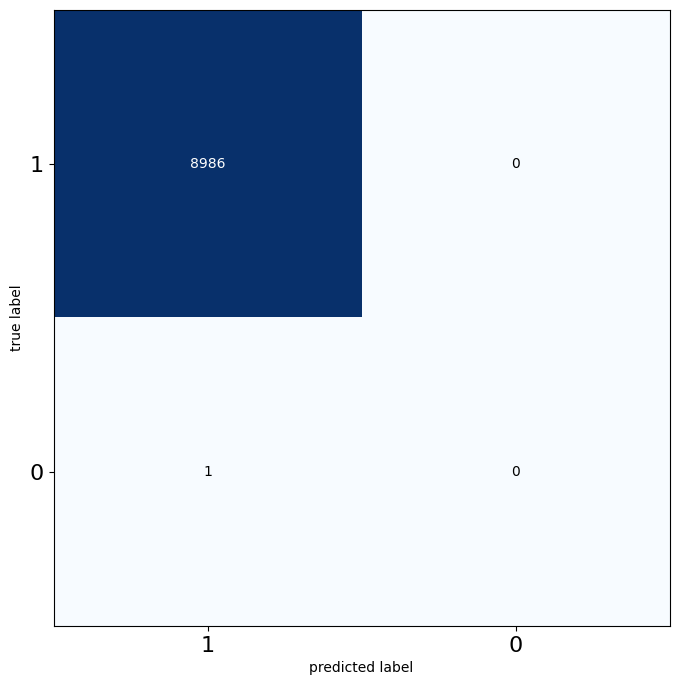

Tyre Distributors & Manufacturers
accuracy: 0.9979971069322354 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

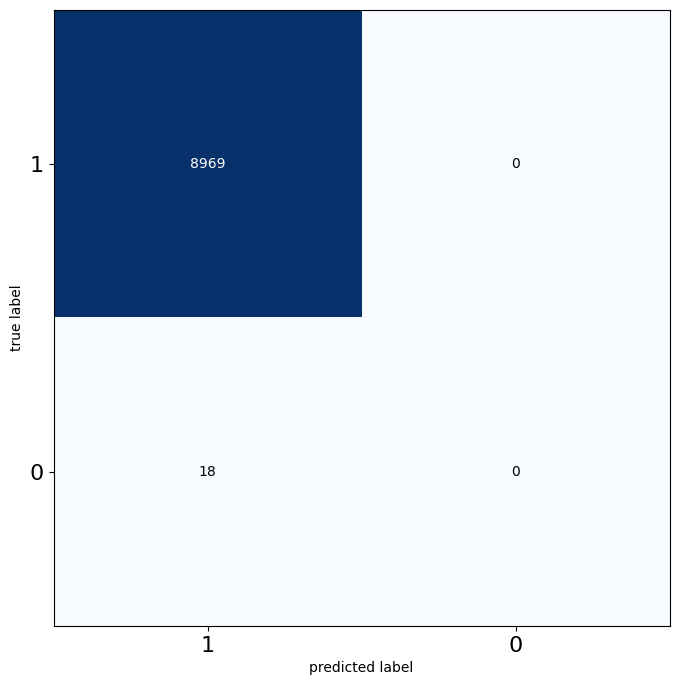

Uniforms
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

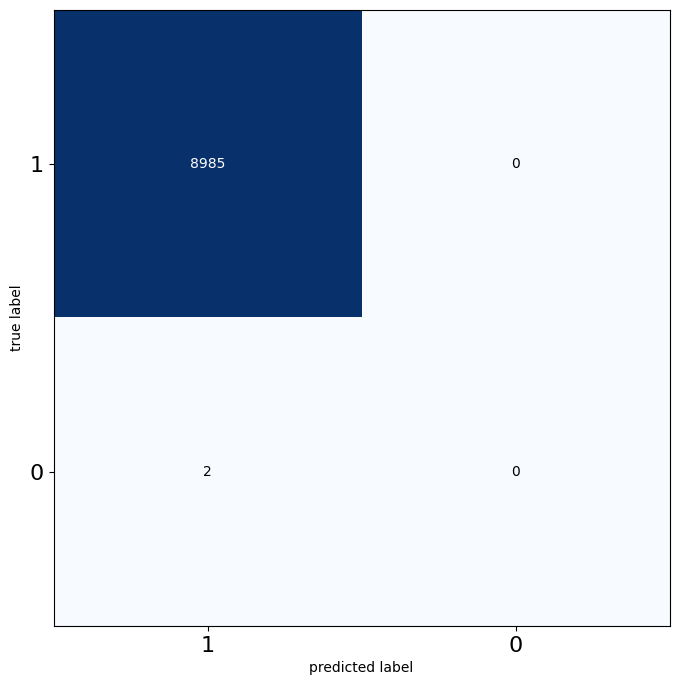

Universities
accuracy: 0.9978858350951374 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

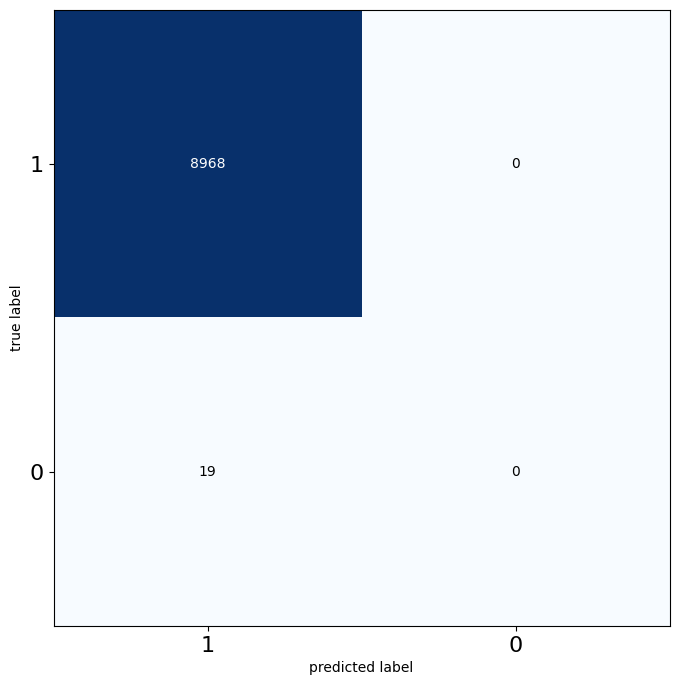

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Upholstery Fabrics & Supplies
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

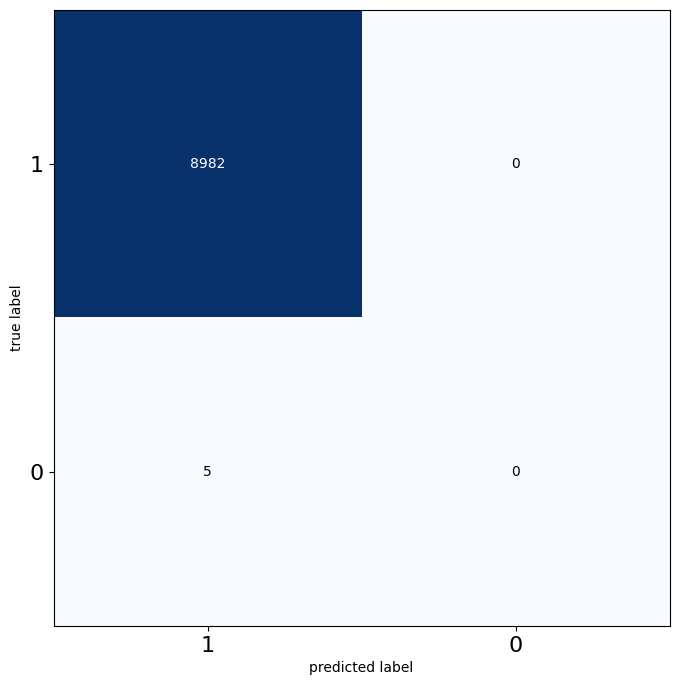

Valuers
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

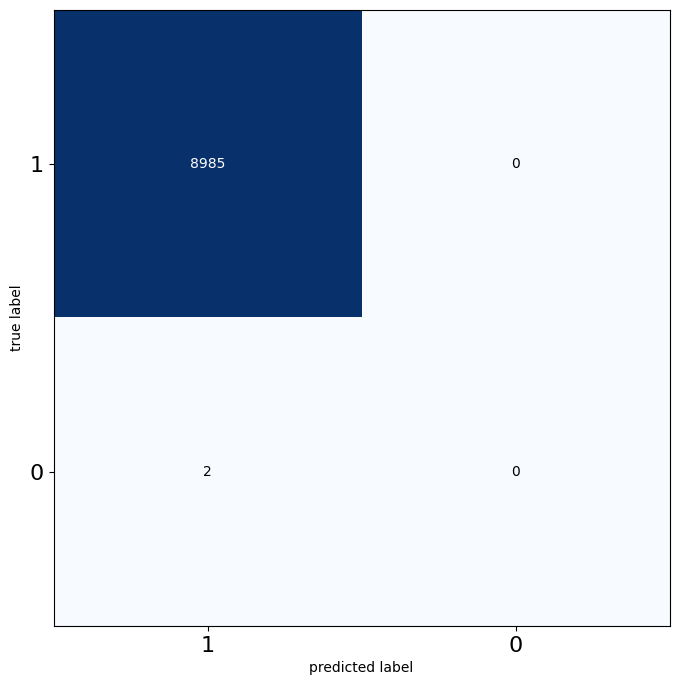

Vegetables
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

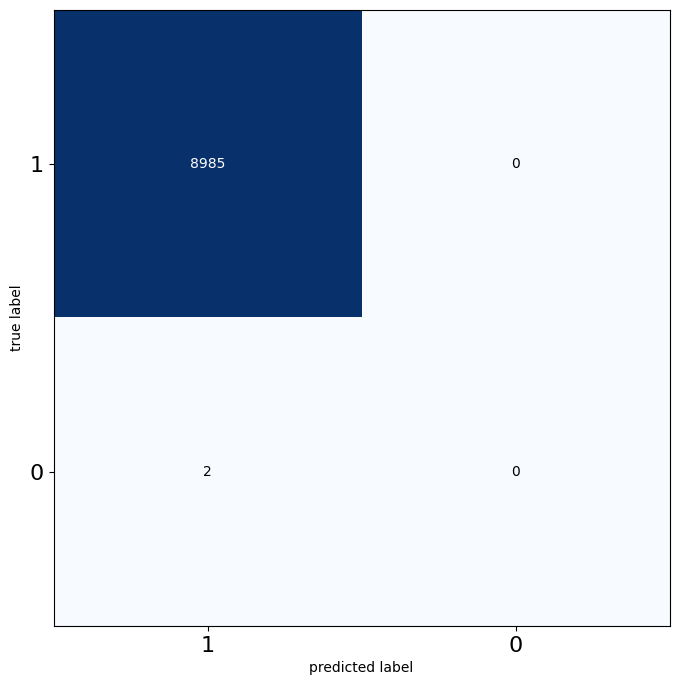

Veterinary Surgeons
accuracy: 0.9977745632580394 precision: 0.1111111111111111 recall: 0.07692307692307693 f1: 0.09090909090909093


<Figure size 640x480 with 0 Axes>

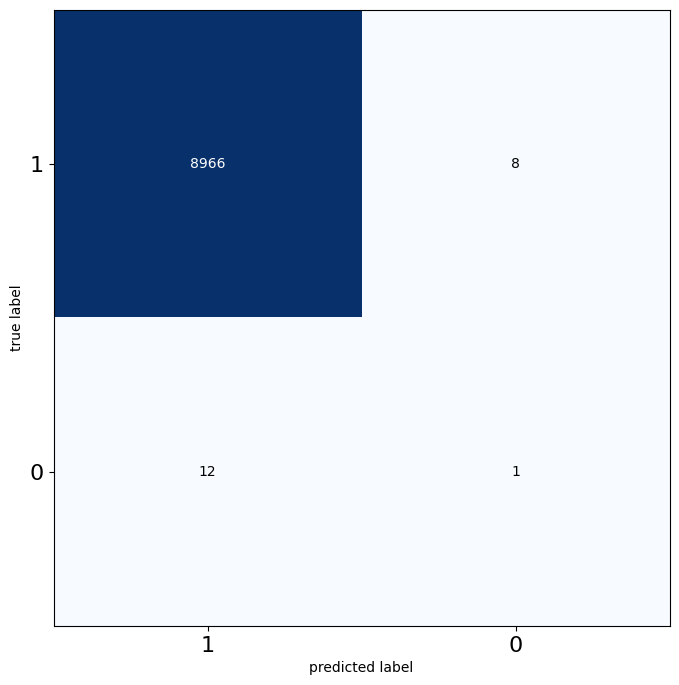

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Video Tape Recorders-Equipment & Supplies
accuracy: 0.992989874262824 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

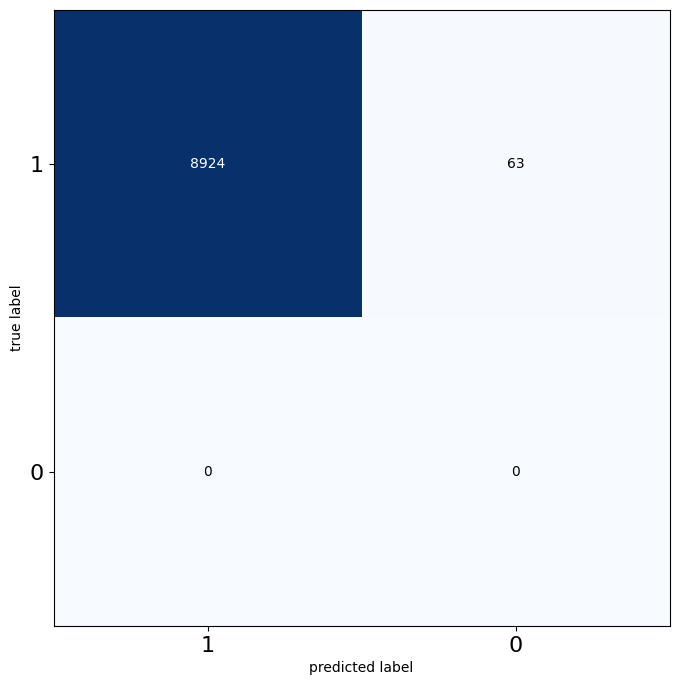

Videographics
accuracy: 0.9996661844887059 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

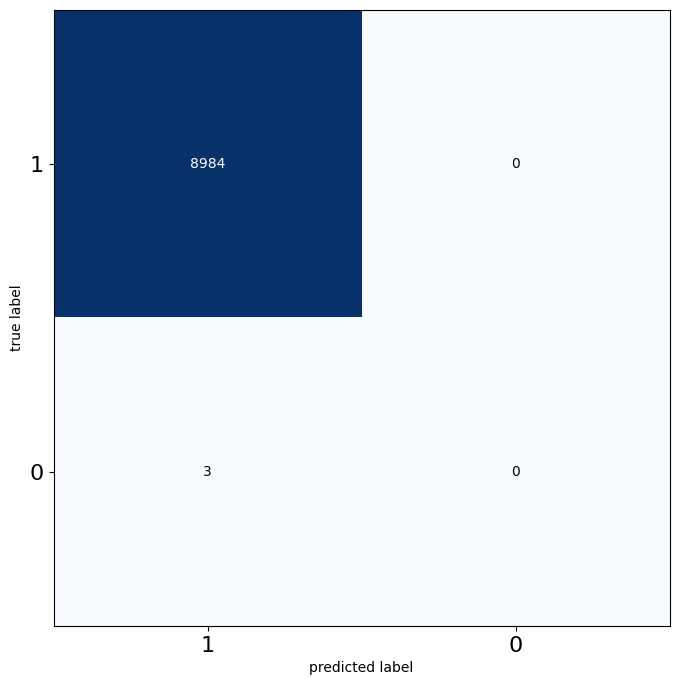

Videography
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

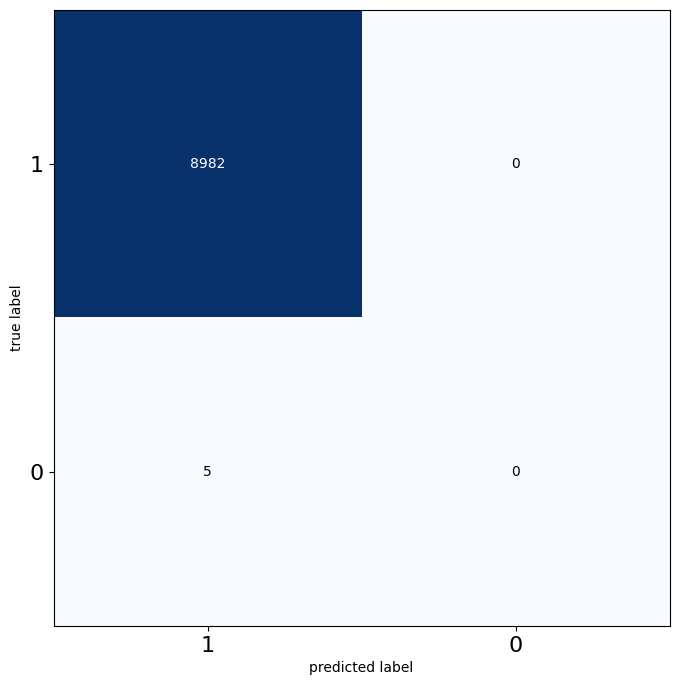

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Warehouses
accuracy: 0.9936575052854123 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

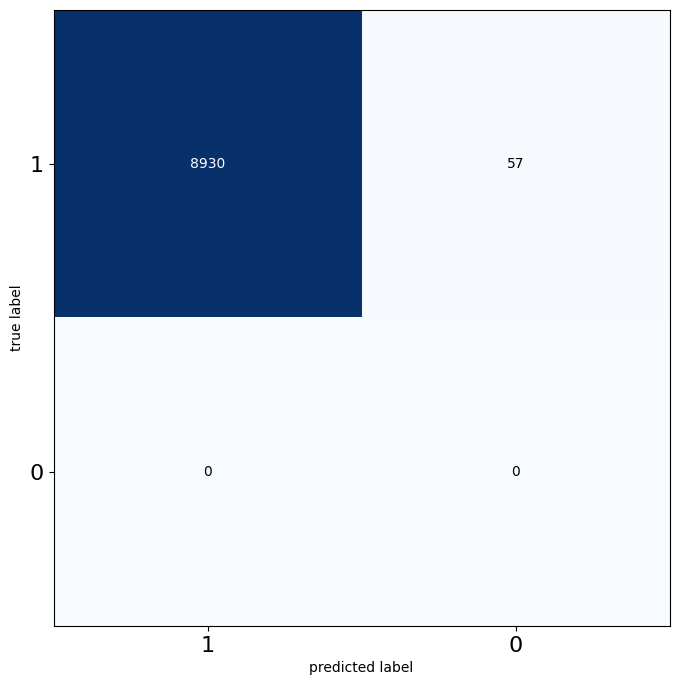

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Waste Disposal
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

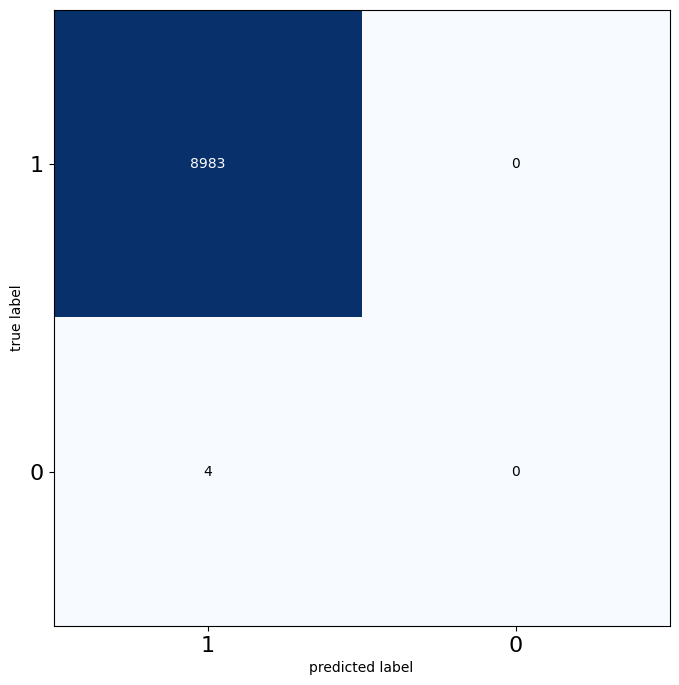

Watches-Dealers & Repairs
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

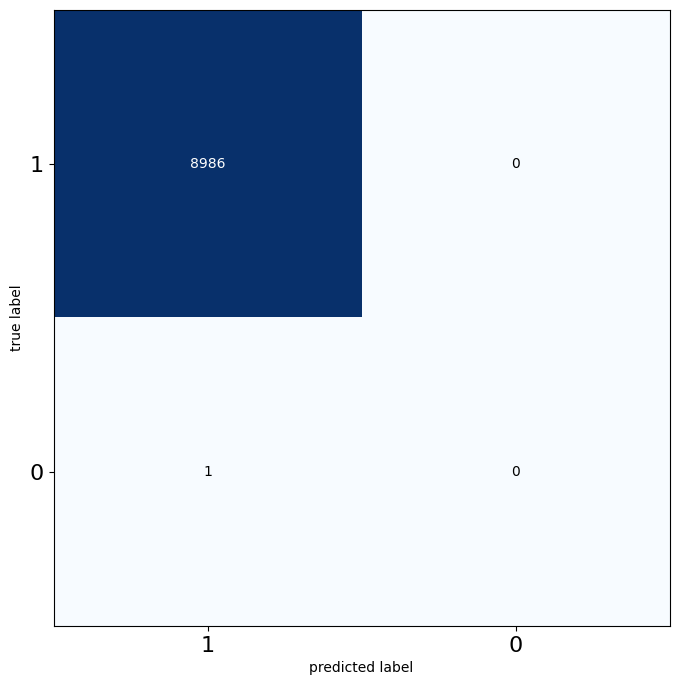

Water
accuracy: 0.9992210971403138 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

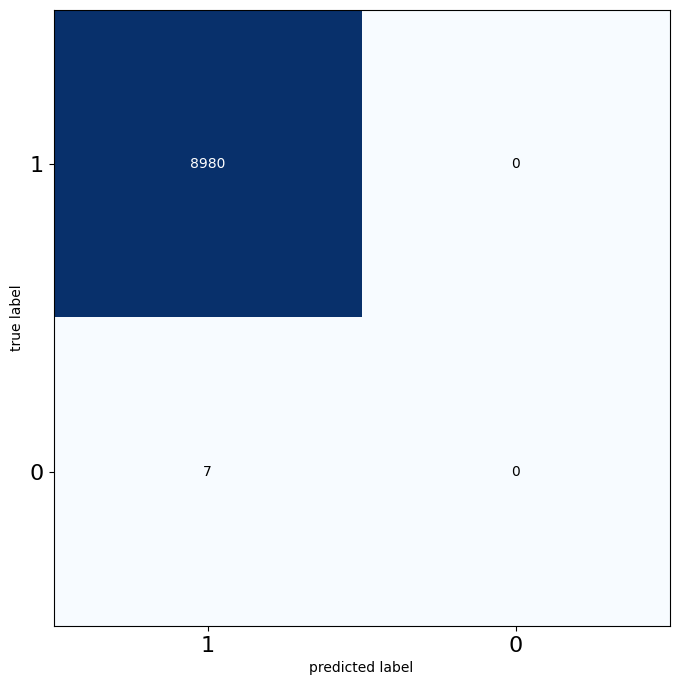

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Water Engineers
accuracy: 0.9987760097919217 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

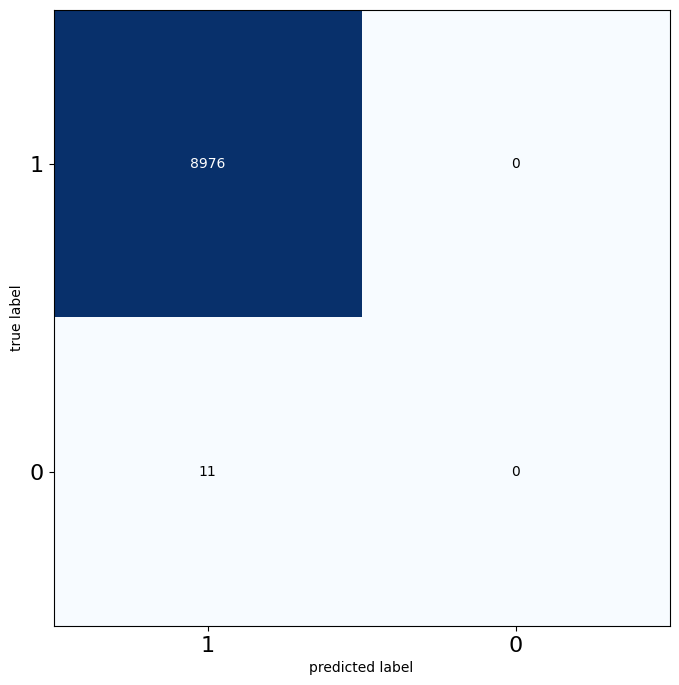

Water Tanks
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

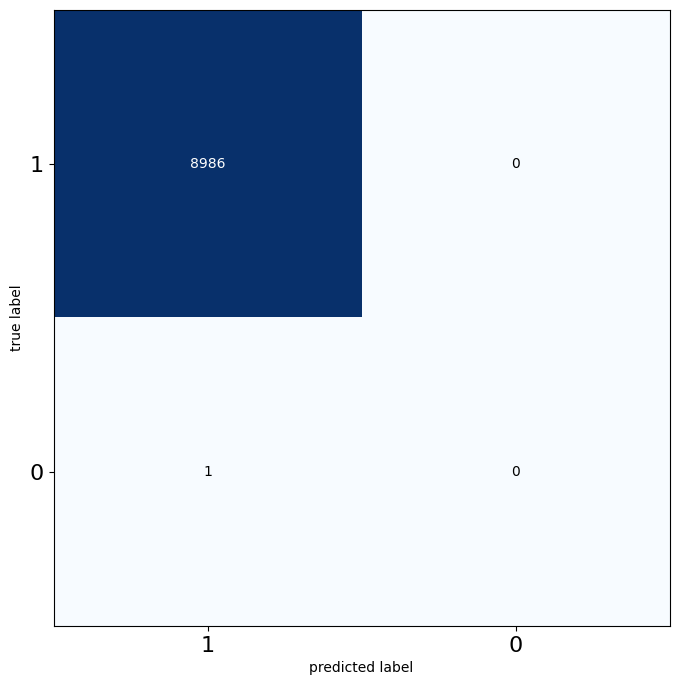

Water Treatment
accuracy: 0.9944364081450985 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

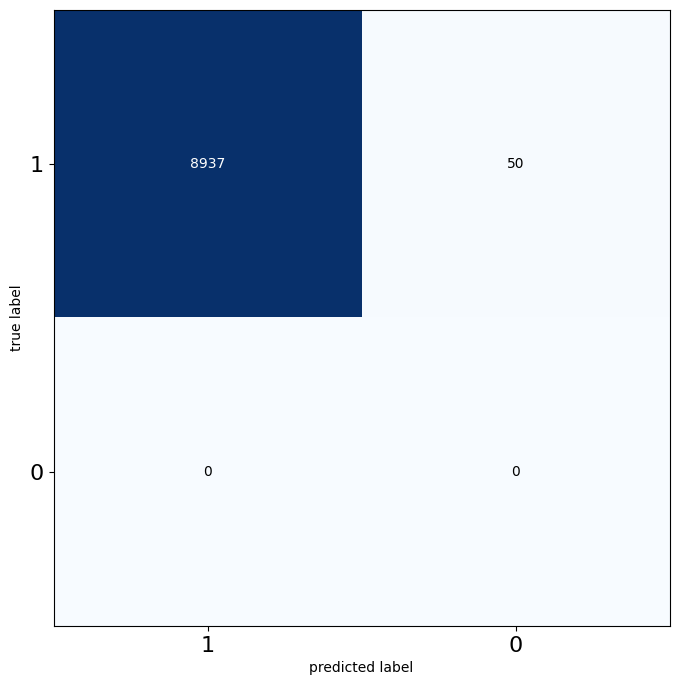

Website Designers
accuracy: 0.992989874262824 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

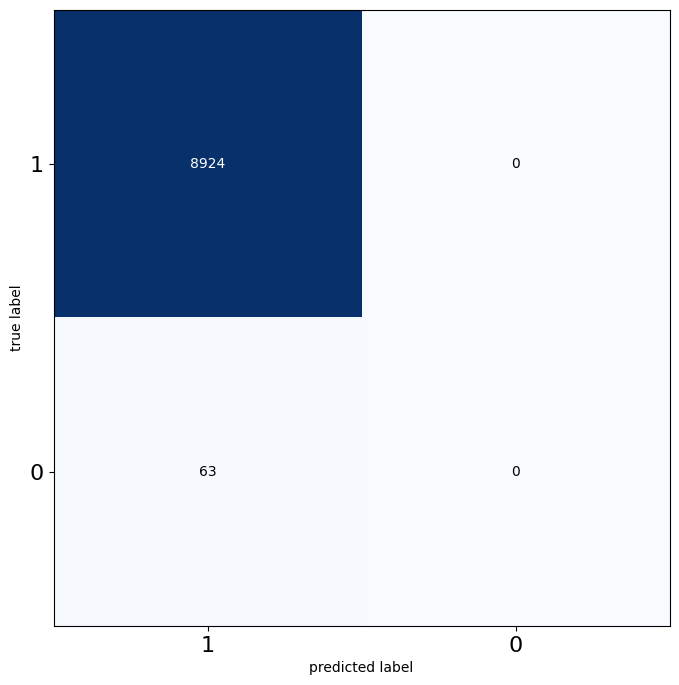

Wedding Supplies & Service
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

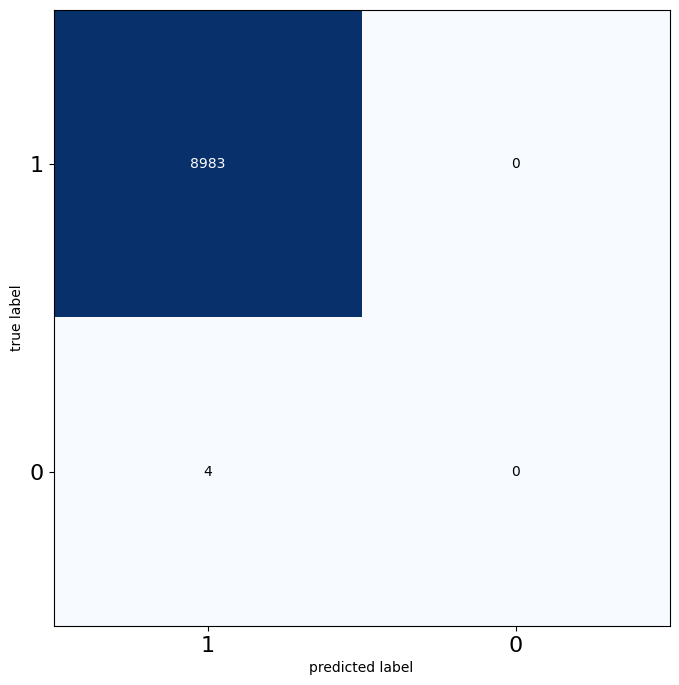

Welding Equipment & Supplies
accuracy: 0.9994436408145099 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

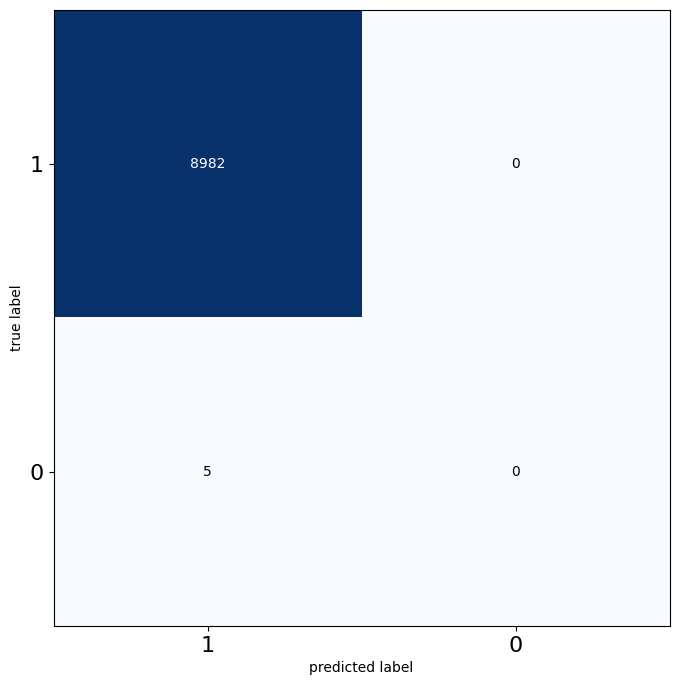

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Welding-Industrial
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

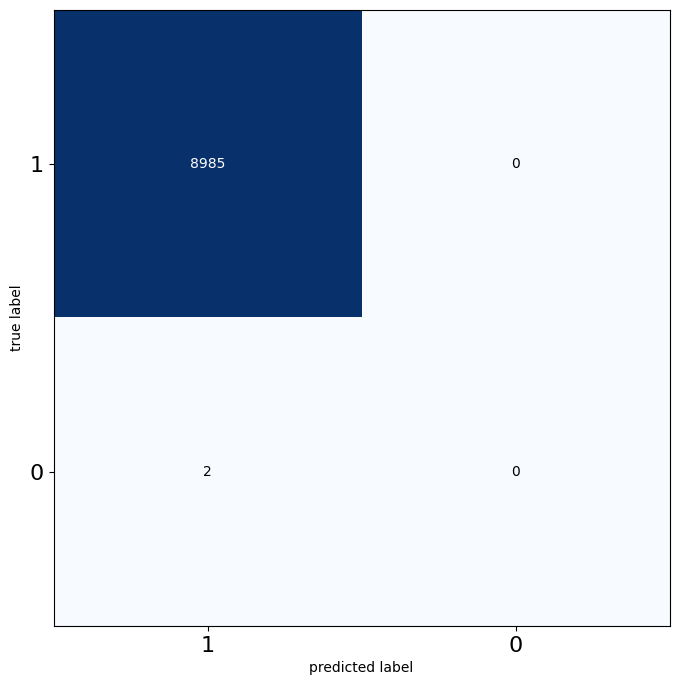

Wildlife Conservation
accuracy: 0.992989874262824 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

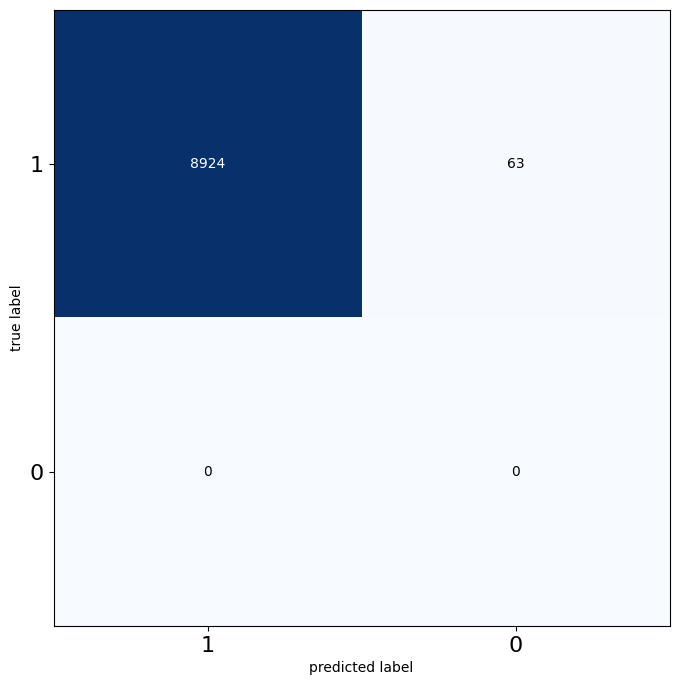

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Wire Products
accuracy: 0.999777456325804 precision: 0.0 recall: 0.0 f1: 0.0


<Figure size 640x480 with 0 Axes>

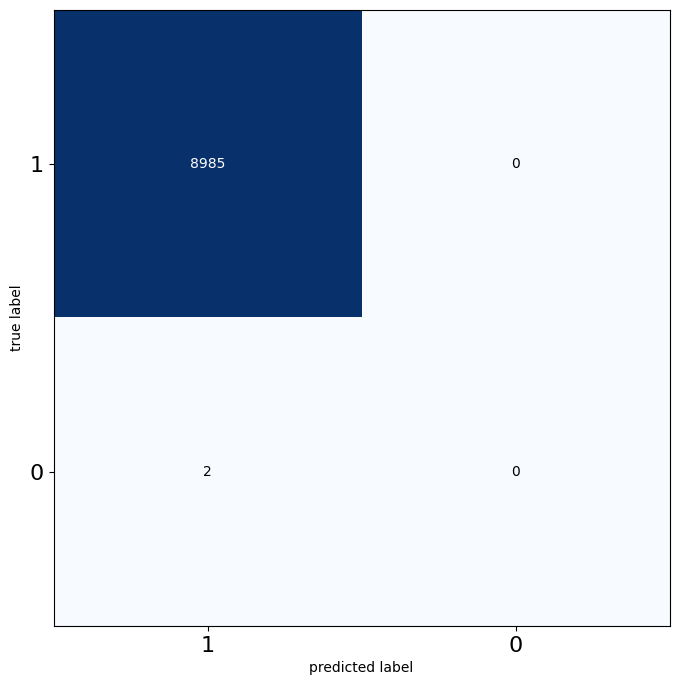

Wireless Networking & Solutions
accuracy: 0.9942138644709024 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

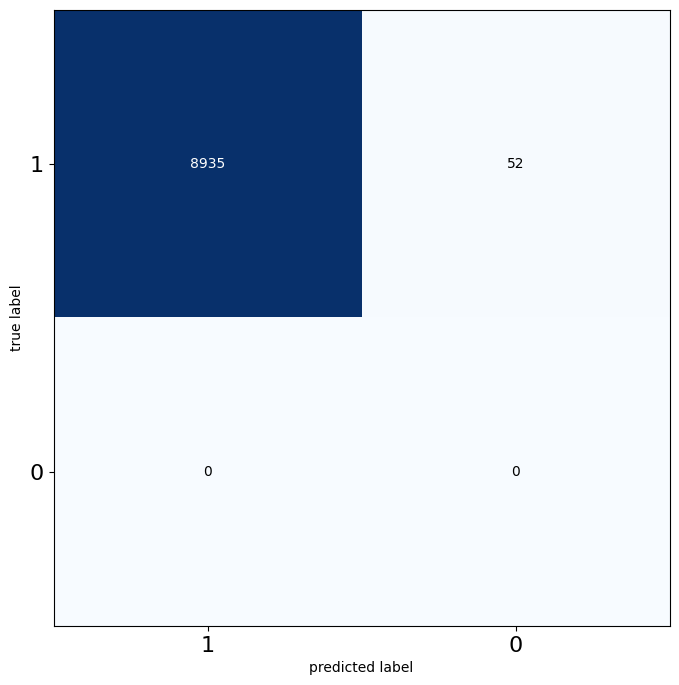

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Wood Carving Manufacturers & Dealers
accuracy: 0.9947702236563926 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

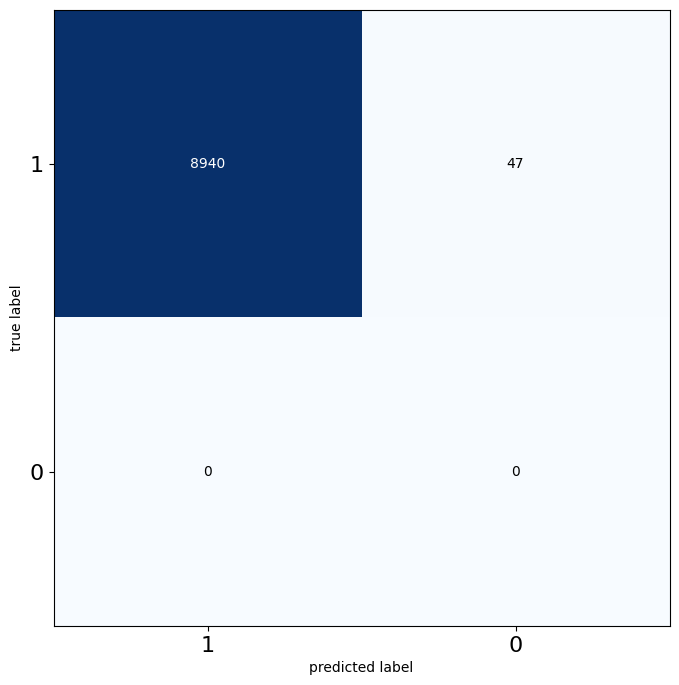

Workshop Equipment & Supplies
accuracy: 0.9993323689774118 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

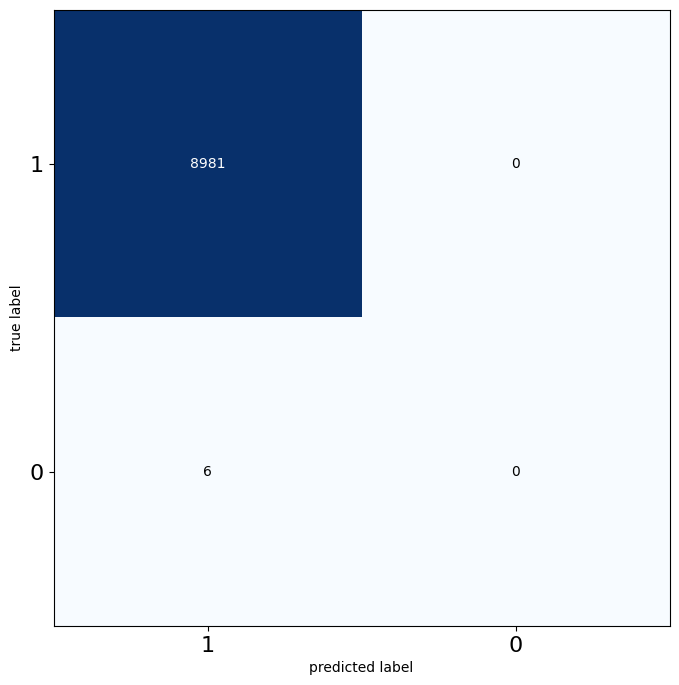

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X-Ray Apparatus & Supplies
accuracy: 0.9944364081450985 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

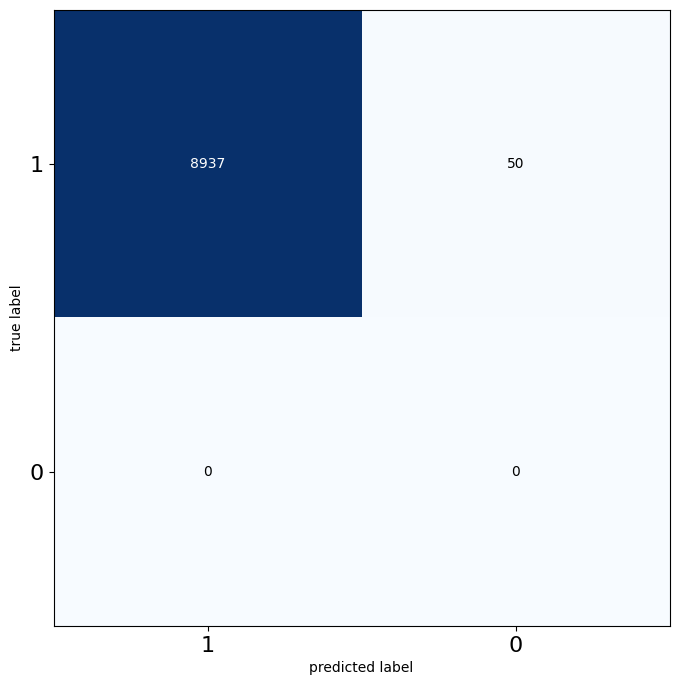

X-Ray Services
accuracy: 0.999888728162902 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

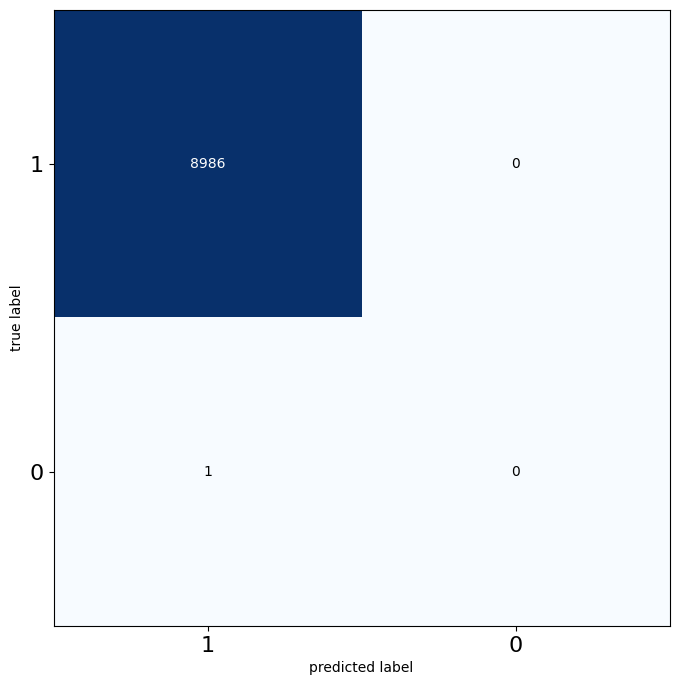

Yoga
accuracy: 0.9995549126516079 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

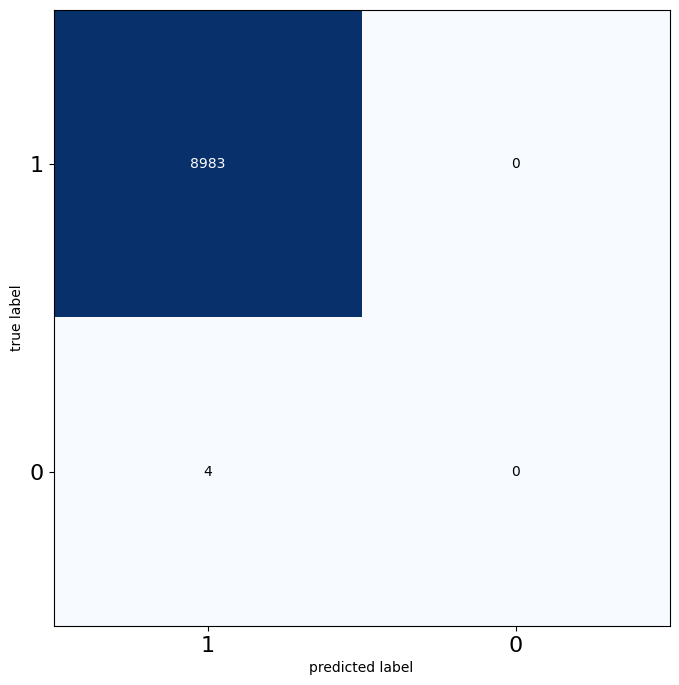

Zippers-Manufacturers & Distributors
accuracy: 0.9966618448870591 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

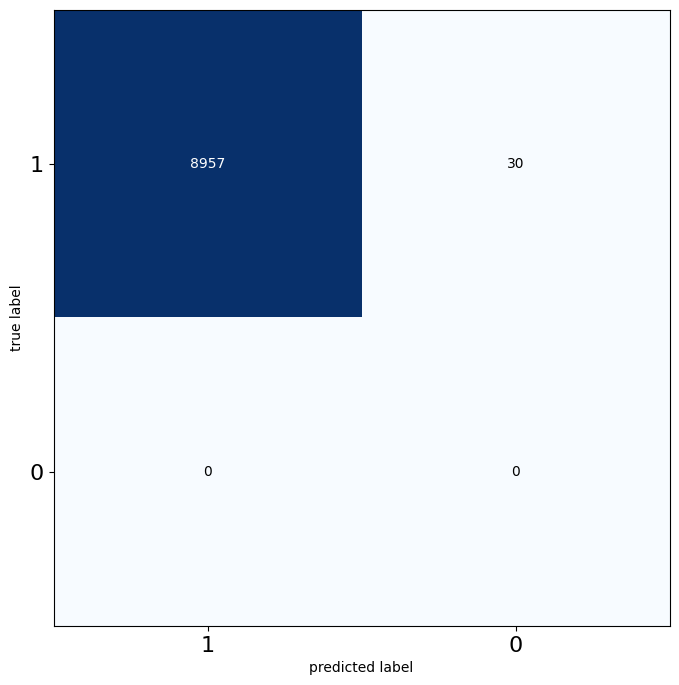

stationery
accuracy: 0.9948814954934906 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

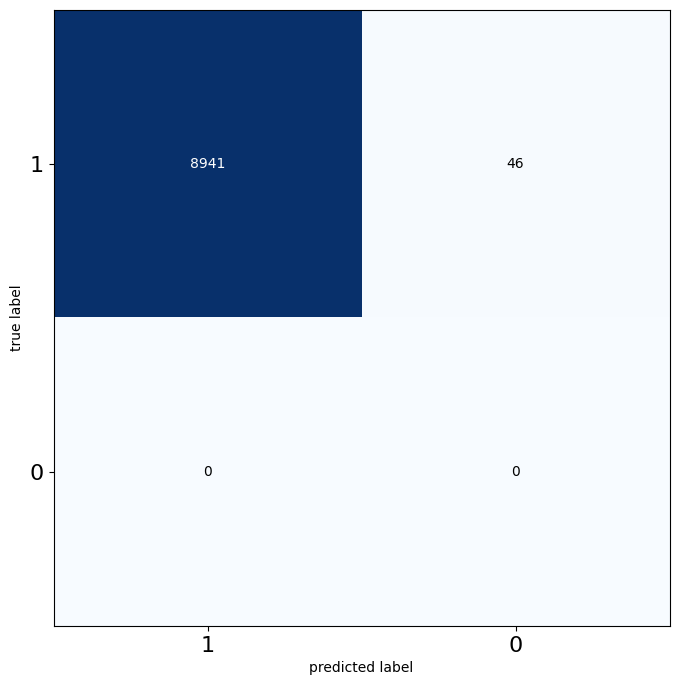

vehicle-Retail
accuracy: 0.9953265828418827 precision: 0.0 recall: 0.0 f1: 0.0


C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


<Figure size 640x480 with 0 Axes>

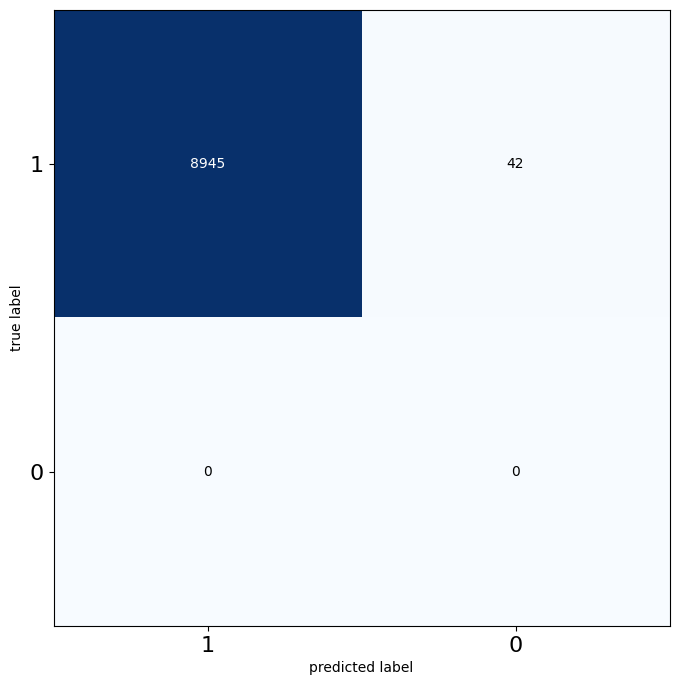

In [36]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

accuracy_per_class = []
precision_per_class = []
recall_per_class = []
f1_per_class = []
classes = list(mlb.classes_)
for i in range(labels.shape[0]):
  #print(len(labels[i, :]), len(preds[i, :]))
  accuracy_per_class.append(accuracy_score(labels[i, :], preds[i, :]))
  precision_per_class.append(precision_score(labels[i, :], preds[i, :]))
  recall_per_class.append(recall_score(labels[i, :], preds[i, :]))
  f1_per_class.append(f1_score(labels[i, :], preds[i, :]))
  print(classes[i])
  print("accuracy:", accuracy_per_class[i], "precision:", precision_per_class[i],
        "recall:", recall_per_class[i], "f1:", f1_per_class[i])
  cm  = confusion_matrix(labels[i, :], preds[i, :])
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
  plt.xticks(range(2), ['1', '0'], fontsize=16)
  plt.yticks(range(2), ['1', '0'], fontsize=16)
  plt.show()

In [37]:
print("Acc:", np.mean(accuracy_per_class), "Precision:", np.mean(precision_per_class), "Recall:",
      np.mean(recall_per_class), "f1:", np.mean(f1_per_class))

Acc: 0.9724277218769262 Precision: 0.0033844219895897867 Recall: 0.032355723351200676 f1: 0.003585266336754025


### implementation of the model using Multi-Label Classification

In [38]:
y = mlb.transform(dataset['categories'])

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [40]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(dataset['description'], y, test_size=0.2, random_state=9)
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [41]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [42]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [43]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 47 is present in all training examples.
  warnings.warn(
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 85 is present in all training examples.
  warnings.warn(
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 117 is present in all training examples.
  warnings.warn(
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 123 is present in all training examples.
  warnings.warn(
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 163 is present in all training examples.
  warnings.warn(
C:\Users\derek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: Use

OneVsRestClassifier(estimator=LogisticRegression())

In [44]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

# evaluate performance
f1_score(yval, y_pred, average="micro")

0.5805071527251661

In [45]:
#Let’s try to change this threshold value and see if that improves our model’s score:

# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

##Now set a threshold value:

t = 0.20 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [46]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.6653360429670488

In [47]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    pred_prob = clf.predict_proba(q_vec)
    q_pred = (pred_prob >= t).astype(int)
    #q_pred = clf.predict(q_vec)
    return mlb.inverse_transform(q_pred)

In [48]:
from nltk.stem import WordNetLemmatizer

In [49]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


In [50]:
#Test on Addis Ab data
path=r"C:\Users\derek\Downloads\addis_ababa_data_categories .csv"
dataset=pd.read_csv(path)
dataset['description']=dataset['description'].astype(str)
dataset['pred_category'] = dataset['description'].apply(lambda x: infer_tags(str(x)))
dataset.to_excel(r"C:\Users\derek\OneDrive\Documents\Predicted Values.xlsx")

In [51]:
# for i in range(5): 
#   k = xval.sample(1).index[0] 
#   print("Company: ", dataset['description'][k], "\nPredicted Category: ", infer_tags(xval[k])), print("Actual category: ",dataset['category'][k], "\n")

In [52]:

def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = word2vec_model.predict(q_vec)
    return mlb.inverse_transform(q_pred)



In [53]:
# dataset['pred_category'] = dataset['description'].apply(lambda x: infer_tags(str(x)))
# dataset.to_excel(r"C:\Users\derek\OneDrive\Documents\Predicted Values_Keras.xlsx")

In [82]:
import googletrans

#print(googletrans.LANGUAGES)
from googletrans import Translator
translator = Translator()
result = translator.translate("የህንጻ ስራ ተቋራጭነት ጠቅላላ ስራ ተቋራጭ ከውሀ ፣ኤሌክትሪክ እና ኤሌክትሮ መካኒካል ስራ በስተቀር")
result

AttributeError: 'NoneType' object has no attribute 'group'

In [79]:
from googletrans import Translator, constants
from pprint import pprint
translator = Translator()

In [80]:
translation = translator.translate("Hola Mundo").apply(getattr, args=('text',))
translation

AttributeError: 'NoneType' object has no attribute 'group'

In [81]:
from google_trans_new import google_translator  
  
translator = google_translator()  
translate_text = translator.translate('Hola mundo!', lang_src='es', lang_tgt='en')

google_new_transError: 404 (Not Found) from TTS API. Probable cause: Unknown